Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534

* https://pompom168.hatenablog.com/entry/2019/07/22/113433


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pasude labeling (thresholds:0.5), timeout
# Version = "v9" # pasude labeling (thresholds:0.6), timeout
# Version = "v10" # pasude labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP
# Version = "v11" # pasude labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP, lgbm parames adjust
# Version = "v12" # Feature engineering based on feature importance
# Version = "v13" # Calibration, SMOTE(k_neighbors=5→1)
# Version = "v14" # Removed the Calibration, SMOTE(k_neighbors=1), pasude labeling (thresholds:0.7)
# Version = "v15" # Updata anotated data
# Version = "v16" # Remove noisy label(confidence: 0.5)
# Version = "v17" # Modifications with remove noisy label func, Calibration, confidence = y_prob.probability.max()*0.3
# Version = "v18" # SMOTE(k_neighbors=1→2), confidence = y_prob.probability.max()*0.2
# Version = "v19" # SMOTE(k_neighbors=2→3),
# Version = "v20" # Modifications with confidence, Removed the Calibration, SMOTE(k_neighbors=2), 
# Version = "v21" # DEBUG = False
Version = "v21" # minor modifications, Max_depth = 7→6

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
import imblearn
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)
print("imblearn Version: ", imblearn.__version__)

lightgbm Version:  2.3.1
numpy Version:  1.18.5
pandas Version:  1.1.1
imblearn Version:  0.7.0


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=39
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

In [7]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

In [8]:
annot = pd.read_csv("../input/moa-annot-data/20201024_moa_sig_list.v2.csv")
annot

,sig_id,nonscored1,nonscored2
0,adenylyl_cyclase_activator,adenylyl_cyclase_inhibitor,NaN
1,aldehyde_dehydrogenase_inhibitor,alcohol_dehydrogenase_inhibitor,NaN
2,antiarrhythmic,na_k-atpase_inhibitor,potassium_channel_blocker
3,anticonvulsant,gaba_gated_chloride_channel_blocker,NaN
4,antifungal,fungal_ergosterol_inhibitor,fungal_lanosterol_demethylase_inhibitor
5,antihistamine,histamine_release_inhibitor,NaN
6,atp-sensitive_potassium_channel_antagonist,atp-sensitive_potassium_channel_inhibitor,NaN
7,bacterial_membrane_integrity_inhibitor,bacterial_protein_synthesis_inhibitor,NaN
8,calcineurin_inhibitor,t_cell_inhibitor,NaN
9,catechol_o_methyltransferase_inhibitor,dopamine_release_enhancer,NaN


In [9]:
annot_sig = []
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'atp-sensitive_potassium_channel_antagonist', 'bacterial_membrane_integrity_inhibitor', 'calcineurin_inhibitor', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'coagulation_factor_inhibitor', 'elastase_inhibitor', 'erbb2_inhibitor', 'nicotinic_receptor_agonist', 'nitric_oxide_production_inhibitor', 'protein_phosphatase_inhibitor', 'sphingosine_receptor_agonist', 'steroid', 'ubiquitin_specific_protease_inhibitor']


In [10]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Training Utils

In [11]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1 or more, replace it with 1.
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [12]:
#def calibration(y_pred, target_rate):
#    return y_pred / (y_pred + (1 - y_pred) / target_rate)

In [13]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    target = get_target(target_col, annot_sig)
    target_rate = target.sum() / len(target)
    
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    n_target = max(500,len(trt))
    
    logger.info(f"{target_col} , len(trt) : {len(trt)}")
        
    othr = train[target==0].copy().reset_index(drop=True)
    othr = othr.drop("sig_id", axis=1)
    othr = othr.sample(n=n_target, random_state=42)
    othr["target"] = 0
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_train = X_train.fillna(0)
    
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)


    if len(trt) < n_target:
        sm = SMOTE(k_neighbors=2, n_jobs=2, random_state=SEED)
        X_train, y_train = sm.fit_sample(X_train, y_train)
    
    X_test = test.drop("sig_id", axis=1)
    
    train_X, train_y = pseudo_labeling(X_train, y_train, X_test, target_rate)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
        
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = train_X.loc[train_index, :]
        X_val = train_X.loc[valid_index, :]
        y_tr = train_y[train_index]
        y_val = train_y[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)

        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        #y_pred = calibration(y_pred, target_rate)
        y_preds.append(y_pred)
        models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")

    return sum(y_preds) / len(y_preds), score, models, 

In [14]:
classifier_params = {
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'n_estimators': Num_boost_round,
    'learning_rate': Learning_rate,
    'objective': "binary",
    'colsample_bytree':0.7,
    'subsample':0.9,
    'subsample_freq':5,
    'reg_alpha':0.1,
    'reg_lambda':0.1,
    'random_state':SEED,
    'n_jobs':2,
}

In [15]:
def convert_label(df, conf_0, conf_1, threshold=0.5):
    df = df.copy()
    Probability = df.iloc[:,0]
    # Remove low confidence labels
    conf_index = df[(Probability <= conf_0) & (conf_1 <= Probability)].index.values
    
    Probability = Probability.where(Probability < threshold, 1).copy()
    p_label = Probability.where(Probability >= threshold, 0).copy()
    
    return p_label, conf_index

In [16]:
def pseudo_labeling(X_train, y_train, X_test, target_rate, max_iter=3):
       
    X = X_train.copy()
    y = y_train.copy()
    
    Threshold = 0.5
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = np.zeros((X.shape[0], 2))
        y_preds[:, 0] = y.copy()
        
        y_prob = np.zeros((X_test.shape[0]))
        
        X_conf = pd.DataFrame()
        y_conf = pd.DataFrame()
        
        for fold_, (train_idx, valid_idx) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_idx, :], X.loc[valid_idx, :]
            y_tr, y_val = y[train_idx], y[valid_idx]
            
            clf = LGBMClassifier(**classifier_params)
            
            clf.fit(X_tr, y_tr,
                    eval_set=[(X_tr, y_tr), (X_val, y_val)],
                    eval_metric='logloss',
                    verbose=100,
                    early_stopping_rounds=Early_stopping_rounds)
            
            y_preds[valid_idx, 1] = clf.predict(X_val, num_iteration=clf.best_iteration_)
            y_prob += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / N_FOLD
        
        y_preds = pd.DataFrame(y_preds, index=X.index, columns=[["Labels", "Preds"]])
        y_preds = y_preds.sum(axis=1)
                
        corect_idx = y_preds[y_preds != 1].index.values
        X_corect, y_corect = X[X.index.isin(corect_idx)], y[y.index.isin(corect_idx)]
        
        logger.info(f"Remove_noisy_labels: {len(y)-len(y_corect)} → positive_corect_labels: {sum(y_corect)}/{len(y_corect)}")
            
        # Remove low confidence labels
        y_prob = pd.DataFrame(y_prob, index=X_test.index, columns=["probability"])
        high_conf_0, high_conf_1 = y_prob.probability.min()*3, y_prob.probability.max()*0.7
        p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
        
        p_label_rate = sum(p_label)/len(p_label)        
        logger.info(f"p_label_rate: {p_label_rate:.5f} Vs.target_rate: {target_rate:.5f}, Num_p_label: {sum(p_label)}, conf_0:{high_conf_0:.5f}, conf_1:{high_conf_1:.5f}")
        
        # Set the params of threshold based on train labels rate (target_rate).
        # target_rate = target.sum() / len(target)
        if p_label_rate*3 < target_rate:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.2f}")
                if sum(p_label)*1.5 > check: break
                Threshold -= 0.04
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
               
                
        if p_label_rate > target_rate*3:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.2f}")
                if sum(p_label) < check*1.5: break
                Threshold += 0.04
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
                
        if iter_ == max_iter:
            X_conf = X_test.copy()
        else:
            X_conf = X_test[X_test.index.isin(conf_idx)].copy()
            
        logger.info(f"threshold:{Threshold:.2f}, positive p_label:{sum(p_label)}/{len(p_label)}, p_label_rate: {sum(p_label)/len(p_label):.5f}")
 
        X = pd.concat([X_corect, X_conf], axis=0, ignore_index=True)
        y = pd.concat([y_corect, p_label], axis=0, ignore_index=True)
        
        X = X.drop_duplicates().reset_index(drop=True)
        y = y[X.index.values].reset_index(drop=True)
        
    return X, y

In [17]:
def show_feature_importance(feature_importance_df, num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 30))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [18]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [19]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [20]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [21]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,train
1,id_000779bfc,1,2,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,train
2,id_000a6266a,1,1,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,train
3,id_0015fd391,1,1,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,train
4,id_001626bd3,1,2,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,1,0,0,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,...,-0.6422,-0.4367,0.0159,-0.6539,-0.4791,-1.2680,-1.1280,-0.4167,-0.6600,test
27792,id_ff925dd0d,1,0,0,-0.5885,-0.2548,2.5850,0.3456,0.4401,0.3107,...,0.5780,-0.5888,0.8057,0.9312,1.2730,0.2614,-0.2790,-0.0131,-0.0934,test
27793,id_ffb710450,1,2,0,-0.3985,-0.1554,0.2677,-0.6813,0.0152,0.4791,...,0.9153,-0.1862,0.4049,0.9568,0.4666,0.0461,0.5888,-0.4205,-0.1504,test
27794,id_ffbb869f2,1,1,1,-1.0960,-1.7750,-0.3977,1.0160,-1.3350,-0.2207,...,-0.4473,-0.8192,0.7785,0.3133,0.1286,-0.2618,0.5074,0.7430,-0.0484,test


In [22]:
# Select control data
ctl = train[(train.cp_type==0)]
ctl

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
25,id_0054388ec,0,1,0,-0.6696,-0.2718,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-0.6828,-0.6594,-0.2043,0.3571,-0.1319,0.2187,0.0737,0.6498,-1.4820,train
40,id_007bfbb91,0,0,1,-1.3200,-1.7340,-0.0741,1.5440,-1.8290,-0.0951,...,1.0340,0.7393,1.1020,0.3786,0.2636,-0.5751,0.3362,0.8543,0.9180,train
47,id_008a986b7,0,1,1,0.4860,0.1430,0.5281,-0.0022,-0.2334,-0.6607,...,-0.1866,0.7629,0.3288,-0.9915,-0.3694,-0.4979,0.5281,-0.9245,-0.9367,train
63,id_009d8340f,0,0,1,0.4471,-0.0839,-0.3864,0.3196,0.2584,-0.3156,...,0.3939,0.7665,0.7932,-0.6804,-0.0435,0.0949,0.2000,-0.4326,0.9364,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23729,id_ff1f9e5fc,0,0,0,0.0465,0.6430,-0.2453,0.3521,0.6195,-0.6659,...,0.1621,-0.2065,0.8314,-0.1891,-0.0074,0.2131,-0.1419,-0.2422,0.0457,train
23747,id_ff469c482,0,2,0,-0.6204,-1.3800,-1.1880,-0.6573,-0.8408,-0.2447,...,0.7366,0.5468,1.1450,0.5254,0.6224,-0.9630,0.8872,-0.0742,-0.6777,train
23768,id_ff89331ca,0,2,1,-0.1051,0.4335,0.3648,-0.0525,-0.3632,-0.3228,...,0.4885,0.4963,0.9434,-0.4779,0.6951,0.9517,-0.8110,-0.1748,-0.3626,train
23793,id_ffd26f361,0,1,1,0.6008,0.2781,-0.3319,-0.8782,0.9281,0.7535,...,0.9569,-0.2065,-0.4918,0.7863,0.0504,0.8813,0.7757,-0.5272,0.7082,train


In [23]:
# clipping

def outlaier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlaier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_0054388ec,0,1,0,-0.6696,-0.27180,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
1,id_01b05de6c,0,1,0,-0.3176,0.48512,-0.3773,0.5555,-0.4877,0.3413,...,-0.6163,0.8001,0.3389,0.7437,0.7533,0.2406,0.5057,0.8017,1.0280,train
2,id_020ba48d9,0,1,0,0.8094,-0.33390,1.1130,-0.4192,0.4545,-0.4771,...,-0.4414,-0.2442,0.0557,-0.6597,-0.3713,-0.6929,-0.3258,0.3602,-0.0595,train
3,id_02c93b4a5,0,1,0,-0.0884,-1.54100,0.5562,0.4661,-0.1683,0.9515,...,0.4766,0.9697,0.4613,0.8957,0.8227,1.2300,1.7180,0.6542,0.0580,train
4,id_03bc6d412,0,1,0,0.8431,0.09310,-0.0958,-0.4337,1.0690,-0.6440,...,-1.1510,-0.5010,-0.2736,0.1270,0.3511,0.1233,-0.8520,0.1767,0.1153,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,id_fbb620181,0,2,1,-0.3490,0.72970,-4.1480,-1.0030,2.4070,-0.9784,...,-1.4260,-0.8613,-0.0243,-0.6109,0.6377,-1.2590,-0.7238,-0.7734,-0.1274,train
1862,id_fbba92030,0,2,1,-0.8921,1.13520,0.4227,1.3270,-0.9839,-0.8469,...,1.1340,0.7007,1.3320,0.6622,0.6167,0.9459,-0.0344,-0.0186,0.5173,train
1863,id_fbc0849ad,0,2,1,-0.2948,0.21960,-0.3252,-0.2084,-0.6518,0.3542,...,0.5014,0.6009,0.4560,-0.3360,-0.5091,0.6569,0.6203,0.6764,0.4504,train
1864,id_fd93fa37d,0,2,1,-0.2984,-0.47880,-2.3560,-0.6848,1.8700,1.0240,...,-0.4422,-0.6665,-0.8033,-1.0520,0.4103,0.4462,-1.1580,-1.3060,0.1925,train


In [24]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in data.cp_time.unique():
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']):
                      Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        f_div = lambda x: (x+d) / (abs(med)+d)
        select_d = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select,select_d], axis=1, sort=False)
        data_df = pd.concat([data_df, tmp_data], axis=0)
data_df

4534
4538
4561
4536
5079
4548


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [25]:
# clipping
clipping = data_df.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [26]:
data_df.cp_type = data_df.cp_type.astype('int64')
data_df.cp_time = data_df.cp_time.astype('int64')
data_df.cp_dose = data_df.cp_dose.astype('int64')
data_df.dtypes

sig_id      object
cp_type      int64
cp_time      int64
cp_dose      int64
g-0        float64
            ...   
d_c-95     float64
d_c-96     float64
d_c-97     float64
d_c-98     float64
d_c-99     float64
Length: 1748, dtype: object

In [27]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [28]:
data_df['WHERE'] = Splitdata
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303,train
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866,train
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519,train
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843,test
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932,test
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938,test
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391,test


In [29]:
train = data_df[data_df['WHERE']=="train"].drop('WHERE', axis=1)
test = data_df[data_df['WHERE']=="test"].drop('WHERE', axis=1)

In [30]:
# Kolmogorov-Smirnov test applied for train data and test data.

from scipy.stats import ks_2samp

tr = train.iloc[:, 4:]
ts = test.iloc[:, 4:]

list_p_value =[ks_2samp(ts[i], tr[i])[1] for i in tqdm(tr.columns)]
Se = pd.Series(list_p_value, index=tr.columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

train = train.drop(list_discarded, axis=1)
test = test.drop(list_discarded, axis=1)

print(f"Removed {len(list_discarded)} columns")


Removed 408 columns


In [31]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99,WHERE
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303,train
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866,train
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032,train
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519,train
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843,test
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932,test
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938,test
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391,test


In [32]:
Splitdata = data["WHERE"]
data = data.drop('WHERE', axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-85,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,0.610453,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,2.368506,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,-2.098055,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.927045,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-12.466870,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,0.977743,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-3.525817,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,2.350949,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-6.247984,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391


In [33]:
# Based on v8 notebook with feature importance

def select_importance_cols(feature_importance_df, num=103):
    best_cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    return best_cols


Feature_importance_df = pd.read_csv("../input/../input/moa-annot-data/feature_importance_df.v8.colab.csv")
Feature_importance_df

importance_cols = select_importance_cols(Feature_importance_df)

len(importance_cols)

103

In [34]:
FI = data[importance_cols]
FI = FI.drop(["cp_type", "cp_time", "cp_dose"], axis=1)
FI

,c-98,g-763,g-231,g-178,g-91,g-635,d_g-87,g-254,d_g-202,g-207,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,0.3801,-0.3167,-1.6510,-0.6217,-1.1230,-0.2461,4.183851,-1.3310,20.720024,-0.22130,...,-0.463249,0.1242,0.0251,2.647177,-10.548861,-1.2560,-0.262194,0.4171,-2.345232,1.2570
1,0.7848,0.4842,0.0333,-0.5141,0.4944,-1.1160,-9.101135,0.5149,-121.467612,0.07920,...,0.712450,0.4590,-0.2584,1.543021,2.532123,-0.2533,-2.819025,-0.4584,3.110345,0.4290
2,0.3193,0.4587,-0.8791,0.2905,-0.1851,0.0860,-5.791252,-1.6090,134.510130,-0.07250,...,1.025284,-0.2491,0.1676,-3.476730,-1.085747,-0.5656,-3.664973,0.6659,-3.906875,-0.3232
3,0.6498,0.6086,-0.5522,0.4275,-0.7775,0.2270,-2.712772,0.8298,74.254500,-1.66400,...,-0.539958,1.3530,-0.2259,-0.720046,31.350629,0.3576,0.201876,0.0597,3.599244,-0.9233
4,-4.8360,-1.1320,2.3720,-0.8283,1.5840,-2.3630,-1.055764,-0.9043,140.770455,3.85415,...,3.627592,-4.4690,1.8870,-9.592403,43.259989,0.0328,-3.335726,4.2690,3.422303,-0.8781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.2310,-0.2914,0.1655,0.2242,0.1058,-1.0330,-2.921354,0.5788,-13.888734,-0.31340,...,-1.244962,-0.4987,-0.4098,0.769766,-155.100886,0.1914,-4.482931,-0.5465,0.340697,-0.6500
27792,-2.4700,1.0300,0.2641,-1.0190,5.7110,-2.3140,-19.551915,1.8170,56.104299,0.69710,...,1.129264,-4.7070,4.7440,2.384589,1016.814588,-0.1688,6.439848,0.8439,-2.063460,-5.1430
27793,-2.1970,0.0199,0.0428,0.7036,2.8370,0.9448,5.732132,-1.6010,-249.158505,-2.55600,...,-1.024153,-0.0303,0.7360,-5.974495,-110.383776,1.5240,9.631421,0.1586,1.600912,-0.7809
27794,-1.0450,-0.2809,-0.8224,0.2189,-1.0990,0.9241,-0.123390,-1.4440,-7.429982,0.82050,...,1.669632,0.6461,-0.4913,3.565008,253.578959,0.7208,5.579313,-0.2808,-0.563337,-0.8265


In [35]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]

g_list

['g-1',
 'g-2',
 'g-4',
 'g-5',
 'g-6',
 'g-8',
 'g-9',
 'g-10',
 'g-12',
 'g-13',
 'g-14',
 'g-15',
 'g-16',
 'g-18',
 'g-19',
 'g-20',
 'g-23',
 'g-24',
 'g-25',
 'g-26',
 'g-27',
 'g-28',
 'g-29',
 'g-30',
 'g-31',
 'g-32',
 'g-33',
 'g-34',
 'g-35',
 'g-36',
 'g-38',
 'g-39',
 'g-40',
 'g-41',
 'g-42',
 'g-43',
 'g-44',
 'g-45',
 'g-46',
 'g-47',
 'g-48',
 'g-49',
 'g-50',
 'g-51',
 'g-53',
 'g-54',
 'g-55',
 'g-56',
 'g-57',
 'g-58',
 'g-59',
 'g-61',
 'g-62',
 'g-64',
 'g-65',
 'g-67',
 'g-69',
 'g-70',
 'g-71',
 'g-73',
 'g-74',
 'g-77',
 'g-78',
 'g-79',
 'g-81',
 'g-83',
 'g-87',
 'g-88',
 'g-89',
 'g-90',
 'g-91',
 'g-93',
 'g-94',
 'g-95',
 'g-96',
 'g-97',
 'g-99',
 'g-103',
 'g-104',
 'g-105',
 'g-106',
 'g-107',
 'g-108',
 'g-109',
 'g-110',
 'g-111',
 'g-113',
 'g-114',
 'g-115',
 'g-116',
 'g-117',
 'g-118',
 'g-119',
 'g-121',
 'g-122',
 'g-123',
 'g-124',
 'g-125',
 'g-126',
 'g-127',
 'g-128',
 'g-129',
 'g-130',
 'g-131',
 'g-132',
 'g-133',
 'g-136',
 'g-137',
 'g-

In [36]:
from sklearn.preprocessing import StandardScaler
    
# Z-score
scaler = StandardScaler(with_mean=True, with_std=True)
std_values = scaler.fit_transform(data.iloc[:, 4:])
std_df = pd.DataFrame(std_values, index=data.index, columns=data.columns[4:])
    

In [37]:
from sklearn.decomposition import PCA
from umap import UMAP

# PCA for all data
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_all = pca_transformer.fit_transform(std_df)

# PCA → UMAP for all data
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_all = umap.fit_transform(pca_all)

print(pca_umap_all.shape)

(27796, 10)


In [38]:
# PCA for merged categories
g_d_g_list = g_list + d_g_list
c_d_c_list = c_list + d_c_list

pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])

# PCA → UMAP for merged categories
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g_d_g = umap.fit_transform(pca_g_d_g)

umap = UMAP(n_components=2, random_state=SEED)
pca_umap_c_d_c = umap.fit_transform(pca_c_d_c)

print(pca_umap_g_d_g.shape)
print(pca_umap_c_d_c.shape)

(27796, 10)
(27796, 2)


In [39]:
# PCA for each category
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

# PCA → UMAP for each category
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g = umap.fit_transform(pca_g)
pca_umap_d_g = umap.fit_transform(pca_d_g)

umap = UMAP(n_components=2, random_state=SEED)
pca_umap_c = umap.fit_transform(pca_c)
pca_umap_d_c = umap.fit_transform(pca_d_c)

print(pca_umap_g.shape)
print(pca_umap_c.shape)
print(pca_umap_d_g.shape)
print(pca_umap_d_c.shape)

(27796, 323)
(27796, 13)
(27796, 394)
(27796, 25)
(27796, 10)
(27796, 2)
(27796, 10)
(27796, 2)


In [40]:
# PCA for all categories
pca_transformer = PCA(n_components=3, whiten=True, random_state=SEED)

pca_all = pca_transformer.fit_transform(std_df)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_all.shape)
print(pca_g_d_g.shape)
print(pca_c_d_c.shape)
print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)


In [41]:
data_list = [ 
    pca_umap_all,
    pca_umap_g_d_g,
    pca_umap_c_d_c,
    pca_umap_g,
    pca_umap_c,
    pca_umap_d_g,
    pca_umap_d_c,
    pca_all,
    pca_g_d_g,
    pca_c_d_c,
    pca_g,
    pca_c,
    pca_d_g,
    pca_d_c,
]

data_names = [ 
    "pca_umap_all",
    "pca_umap_g_d_g",
    "pca_umap_c_d_c",
    "pca_umap_g",
    "pca_umap_c",
    "pca_umap_d_g",
    "pca_umap_d_c",
    "pca_all",
    "pca_g_d_g",
    "pca_c_d_c",
    "pca_g",
    "pca_c",
    "pca_d_g",
    "pca_d_c",
]

In [42]:
col_list = []
for i, d in enumerate(data_list):
    for j in range(d.shape[1]):
        col_list.append( f"{data_names[i]}_{j+1}")
col_list

['pca_umap_all_1',
 'pca_umap_all_2',
 'pca_umap_all_3',
 'pca_umap_all_4',
 'pca_umap_all_5',
 'pca_umap_all_6',
 'pca_umap_all_7',
 'pca_umap_all_8',
 'pca_umap_all_9',
 'pca_umap_all_10',
 'pca_umap_g_d_g_1',
 'pca_umap_g_d_g_2',
 'pca_umap_g_d_g_3',
 'pca_umap_g_d_g_4',
 'pca_umap_g_d_g_5',
 'pca_umap_g_d_g_6',
 'pca_umap_g_d_g_7',
 'pca_umap_g_d_g_8',
 'pca_umap_g_d_g_9',
 'pca_umap_g_d_g_10',
 'pca_umap_c_d_c_1',
 'pca_umap_c_d_c_2',
 'pca_umap_g_1',
 'pca_umap_g_2',
 'pca_umap_g_3',
 'pca_umap_g_4',
 'pca_umap_g_5',
 'pca_umap_g_6',
 'pca_umap_g_7',
 'pca_umap_g_8',
 'pca_umap_g_9',
 'pca_umap_g_10',
 'pca_umap_c_1',
 'pca_umap_c_2',
 'pca_umap_d_g_1',
 'pca_umap_d_g_2',
 'pca_umap_d_g_3',
 'pca_umap_d_g_4',
 'pca_umap_d_g_5',
 'pca_umap_d_g_6',
 'pca_umap_d_g_7',
 'pca_umap_d_g_8',
 'pca_umap_d_g_9',
 'pca_umap_d_g_10',
 'pca_umap_d_c_1',
 'pca_umap_d_c_2',
 'pca_all_1',
 'pca_all_2',
 'pca_all_3',
 'pca_g_d_g_1',
 'pca_g_d_g_2',
 'pca_g_d_g_3',
 'pca_c_d_c_1',
 'pca_c_d_c_2',


In [43]:
result_df = pd.DataFrame(data_list[0])
for d in data_list[1:]:
    tmp_df = pd.DataFrame(d)
    result_df = pd.concat([result_df, tmp_df], axis=1)
result_df.columns = col_list
result_df

,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,pca_umap_all_7,pca_umap_all_8,pca_umap_all_9,pca_umap_all_10,...,pca_g_3,pca_c_1,pca_c_2,pca_c_3,pca_d_g_1,pca_d_g_2,pca_d_g_3,pca_d_c_1,pca_d_c_2,pca_d_c_3
0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,-0.631963,0.520953,-0.489372,0.596058,...,-1.140890,-0.469951,0.099505,0.543770,-0.412404,0.344801,0.037566,-0.352178,0.185292,0.004245
1,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,-0.837569,0.656989,0.557744,0.862181,...,0.393231,-0.814709,0.613391,-0.238404,-0.522178,-0.182825,0.440264,-0.575022,0.122275,0.280131
2,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,-1.044028,0.611787,0.327000,0.522496,...,-0.603388,-0.262629,-0.104706,0.204114,-0.150261,0.224066,-0.477699,-0.254322,0.146491,-0.005201
3,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,-0.463792,0.222208,0.172640,0.482514,...,0.520171,-0.202956,-0.340746,-1.418043,-0.040187,-0.775782,-0.318853,-0.157597,-0.122486,-0.020528
4,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,-0.936194,0.003462,1.613957,0.086733,...,-2.687000,1.478095,0.804459,2.194776,1.834257,0.532104,-2.136533,0.808826,-0.534457,-0.547478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,-0.518431,0.616687,-0.967858,0.699507,...,0.282427,-0.124308,-0.178446,0.631366,-0.533474,1.250751,0.927038,-0.070210,0.002111,-0.157756
27792,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,-0.553066,0.555583,-0.925586,0.635752,...,-2.186621,0.986815,5.615881,-1.809798,1.305137,1.420641,-1.273816,1.123556,-2.183204,0.610776
27793,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,-1.325753,0.832510,0.902315,1.563123,...,-1.047883,-0.212064,0.409555,2.046140,-0.126035,0.358089,-0.604766,-0.223797,0.372728,0.561805
27794,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,-0.554051,0.652266,-0.881698,0.647011,...,0.111515,0.261040,-0.357443,0.309463,-0.092845,-0.936262,-0.360358,0.259394,-0.407341,0.143140


In [44]:
# Merge data
result_df = pd.concat([result_df, FI], axis=1)

In [45]:
# Add data with sig_id, cp_type, cp_time, and cp_dose
data = pd.concat([data.iloc[:, :4], result_df], axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,...,-0.463249,0.1242,0.0251,2.647177,-10.548861,-1.2560,-0.262194,0.4171,-2.345232,1.2570
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,0.712450,0.4590,-0.2584,1.543021,2.532123,-0.2533,-2.819025,-0.4584,3.110345,0.4290
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,1.025284,-0.2491,0.1676,-3.476730,-1.085747,-0.5656,-3.664973,0.6659,-3.906875,-0.3232
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,-0.539958,1.3530,-0.2259,-0.720046,31.350629,0.3576,0.201876,0.0597,3.599244,-0.9233
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,...,3.627592,-4.4690,1.8870,-9.592403,43.259989,0.0328,-3.335726,4.2690,3.422303,-0.8781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,-1.244962,-0.4987,-0.4098,0.769766,-155.100886,0.1914,-4.482931,-0.5465,0.340697,-0.6500
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,1.129264,-4.7070,4.7440,2.384589,1016.814588,-0.1688,6.439848,0.8439,-2.063460,-5.1430
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,...,-1.024153,-0.0303,0.7360,-5.974495,-110.383776,1.5240,9.631421,0.1586,1.600912,-0.7809
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,...,1.669632,0.6461,-0.4913,3.565008,253.578959,0.7208,5.579313,-0.2808,-0.563337,-0.8265


In [46]:
# clipping
clipping = data.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.407962,0.927889,-0.848250,0.769027,...,-0.463249,0.1242,0.0251,2.647177,-10.548861,-1.2560,-0.262194,0.4171,-2.345232,1.2570
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,0.712450,0.4590,-0.2584,1.543021,2.532123,-0.2533,-2.819025,-0.4584,3.110345,0.4290
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,1.025284,-0.2491,0.1676,-3.476730,-1.085747,-0.5656,-3.664973,0.6659,-3.906875,-0.3232
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,-0.539958,1.3530,-0.2259,-0.720046,31.350629,0.3576,0.201876,0.0597,3.599244,-0.9233
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.923120,0.013562,...,3.627592,-4.4690,1.8870,-9.592403,43.259989,0.0328,-3.335726,4.2690,3.422303,-0.8781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,-1.244962,-0.4987,-0.4098,0.769766,-155.100886,0.1914,-4.482931,-0.5465,0.340697,-0.6500
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,1.129264,-4.7070,4.7440,2.384589,1016.814588,-0.1688,6.439848,0.8439,-2.063460,-5.1430
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.162132,-0.885569,-0.035729,...,-1.024153,-0.0303,0.7360,-5.974495,-110.383776,1.5240,9.631421,0.1586,1.600912,-0.7809
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.407962,0.766808,-0.643382,0.663832,...,1.669632,0.6461,-0.4913,3.565008,253.578959,0.7208,5.579313,-0.2808,-0.563337,-0.8265


In [47]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

# Modeling

In [48]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    # 'metric': 'average_precision',
    'is_unbalance': True,
    'learning_rate': Learning_rate,
    'num_threads': 2,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.7, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,

}

categorical_cols = []
feature_importance_df = pd.DataFrame()
models = []
scores = []

In [49]:
for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
    
    
    if DEBUG:
        for model in models:
            _importance_df = pd.DataFrame()
            _importance_df["Feature"] = train.columns[1:]
            _importance_df["importance"] = model.feature_importance(importance_type='gain')
            feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)

5-alpha_reductase_inhibitor , len(trt) : 17
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0699271	valid_1's binary_logloss: 0.107593
[200]	training's binary_logloss: 0.0121739	valid_1's binary_logloss: 0.0361376
[300]	training's binary_logloss: 0.00400716	valid_1's binary_logloss: 0.0205506
[400]	training's binary_logloss: 0.00218123	valid_1's binary_logloss: 0.015774
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00177955	valid_1's binary_logloss: 0.01426
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0709371	valid_1's binary_logloss: 0.110442
[200]	training's binary_logloss: 0.0127245	valid_1's binary_logloss: 0.0413447
[300]	training's binary_logloss: 0.0041688	valid_1's binary_logloss: 0.0257183


Remove_noisy_labels: 3 → positive_corect_labels: 500/997
p_label_rate: 0.00251 Vs.target_rate: 0.00071, Num_p_label: 10.0, conf_0:0.00033, conf_1:0.63557
Num_p_label: 10.0, Expected: 2.8, Adj_threshold_1: 0.50
Num_p_label: 8.0, Expected: 2.8, Adj_threshold_2: 0.54
Num_p_label: 7.0, Expected: 2.8, Adj_threshold_3: 0.58


[400]	training's binary_logloss: 0.00225933	valid_1's binary_logloss: 0.0204457
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00180216	valid_1's binary_logloss: 0.0189061


Num_p_label: 6.0, Expected: 2.8, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 2.8, Adj_threshold_5: 0.66
Num_p_label: 5.0, Expected: 2.8, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 2.8, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0691353	valid_1's binary_logloss: 0.114858
[200]	training's binary_logloss: 0.0122701	valid_1's binary_logloss: 0.0372322
[300]	training's binary_logloss: 0.0040014	valid_1's binary_logloss: 0.0195033
[400]	training's binary_logloss: 0.002159	valid_1's binary_logloss: 0.0139667
[500]	training's binary_logloss: 0.00161803	valid_1's binary_logloss: 0.0119516
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00156816	valid_1's binary_logloss: 0.011574
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.069372	valid_1's binary_logloss: 0.102971
[200]	training's binary_logloss: 0.0121284	valid_1's binary_logloss: 0.0330715
[300]	training's binary_logloss: 0.00394777	valid_1's binary_logloss: 0.0175603
[400]	training's binary_logloss: 0.00217607	valid_1's binary_logloss: 0.0127159
[500]	training's binary_logloss: 0.00161516	valid_1's 

Remove_noisy_labels: 0 → positive_corect_labels: 500.0/997
p_label_rate: 0.00100 Vs.target_rate: 0.00071, Num_p_label: 4.0, conf_0:0.00022, conf_1:0.66402
threshold:0.74, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0691353	valid_1's binary_logloss: 0.114858
[200]	training's binary_logloss: 0.0122701	valid_1's binary_logloss: 0.0372322
[300]	training's binary_logloss: 0.0040014	valid_1's binary_logloss: 0.0195033
[400]	training's binary_logloss: 0.002159	valid_1's binary_logloss: 0.0139667
[500]	training's binary_logloss: 0.00161803	valid_1's binary_logloss: 0.0119516
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00156816	valid_1's binary_logloss: 0.011574
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.069372	valid_1's binary_logloss: 0.102971
[200]	training's binary_logloss: 0.0121284	valid_1's binary_logloss: 0.0330715
[300]	training's binary_logloss: 0.00394777	valid_1's binary_logloss: 0.0175603
[400]	training's binary_logloss: 0.00217607	valid_1's binary_logloss: 0.0127159
[500]	training's binary_logloss: 0.00161516	valid_1's 

Remove_noisy_labels: 0 → positive_corect_labels: 500.0/997
p_label_rate: 0.00100 Vs.target_rate: 0.00071, Num_p_label: 4.0, conf_0:0.00022, conf_1:0.66402
threshold:0.74, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2489
len(valid_index) : 2490
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223009	valid_1's binary_logloss: 0.0313793
[200]	training's binary_logloss: 0.00264682	valid_1's binary_logloss: 0.0104411
[300]	training's binary_logloss: 0.000596924	valid_1's binary_logloss: 0.00617548
[400]	training's binary_logloss: 0.000272649	valid_1's binary_logloss: 0.00496679
[500]	training's binary_logloss: 0.000184737	valid_1's binary_logloss: 0.00448488


len(train_index) : 2490


Early stopping, best iteration is:
[507]	training's binary_logloss: 0.000184481	valid_1's binary_logloss: 0.00448324


len(valid_index) : 2489
================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0211643	valid_1's binary_logloss: 0.0362831
[200]	training's binary_logloss: 0.00250737	valid_1's binary_logloss: 0.0126833
[300]	training's binary_logloss: 0.000595356	valid_1's binary_logloss: 0.00702909
[400]	training's binary_logloss: 0.000279807	valid_1's binary_logloss: 0.00498169
[500]	training's binary_logloss: 0.000189795	valid_1's binary_logloss: 0.00411987
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000176782	valid_1's binary_logloss: 0.00397371


5-alpha_reductase_inhibitor logloss: 0.004228527538609664
11-beta-hsd1_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0726866	valid_1's binary_logloss: 0.132255
[200]	training's binary_logloss: 0.0130961	valid_1's binary_logloss: 0.0564888
[300]	training's binary_logloss: 0.00432703	valid_1's binary_logloss: 0.0371499
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.00370432	valid_1's binary_logloss: 0.03473
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.070481	valid_1's binary_logloss: 0.132552
[200]	training's binary_logloss: 0.0127126	valid_1's binary_logloss: 0.0570025
[300]	training's binary_logloss: 0.00424329	valid_1's binary_logloss: 0.0382728
[400]	training's binary_logloss: 0.00233867	valid_1's binary_logloss: 0.031077
[500]	training's binary_logloss: 0.00171439	valid_1's binary_logloss: 0.0284885
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.00157317	valid_1's binary_logloss: 0.0277048


Remove_noisy_labels: 8 → positive_corect_labels: 500/992
p_label_rate: 0.00402 Vs.target_rate: 0.00076, Num_p_label: 16.0, conf_0:0.00096, conf_1:0.63993
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0705821	valid_1's binary_logloss: 0.118277
[200]	training's binary_logloss: 0.0126702	valid_1's binary_logloss: 0.0464428
[300]	training's binary_logloss: 0.0041827	valid_1's binary_logloss: 0.0284838
[400]	training's binary_logloss: 0.00229841	valid_1's binary_logloss: 0.0222054
[500]	training's binary_logloss: 0.00166714	valid_1's binary_logloss: 0.019161
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00162268	valid_1's binary_logloss: 0.0187694
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0673936	valid_1's binary_logloss: 0.11829
[200]	training's binary_logloss: 0.0120699	valid_1's binary_logloss: 0.0433497
[300]	training's binary_logloss: 0.00420779	valid_1's binary_logloss: 0.0275654
[400]	training's binary_logloss: 0.00235693	valid_1's binary_logloss: 0.0211663
[500]	training's binary_logloss: 0.001744	valid_1's 

Remove_noisy_labels: 6 → positive_corect_labels: 500.0/986
p_label_rate: 0.00151 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.00050, conf_1:0.63538
threshold:0.74, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0697408	valid_1's binary_logloss: 0.105199
[200]	training's binary_logloss: 0.0127388	valid_1's binary_logloss: 0.0347717
[300]	training's binary_logloss: 0.00432352	valid_1's binary_logloss: 0.0177905
[400]	training's binary_logloss: 0.00237305	valid_1's binary_logloss: 0.0125209
[500]	training's binary_logloss: 0.00174045	valid_1's binary_logloss: 0.0102602
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00157929	valid_1's binary_logloss: 0.00965848
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0653396	valid_1's binary_logloss: 0.116818
[200]	training's binary_logloss: 0.0110074	valid_1's binary_logloss: 0.0457095
[300]	training's binary_logloss: 0.00373329	valid_1's binary_logloss: 0.0289989
[400]	training's binary_logloss: 0.00213642	valid_1's binary_logloss: 0.0236257
[500]	training's binary_logloss: 0.00163047	vali

Remove_noisy_labels: 2 → positive_corect_labels: 500.0/984
p_label_rate: 0.00201 Vs.target_rate: 0.00076, Num_p_label: 8.0, conf_0:0.00032, conf_1:0.64803
threshold:0.74, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 2483
len(valid_index) : 2483
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194852	valid_1's binary_logloss: 0.0444289
[200]	training's binary_logloss: 0.0023512	valid_1's binary_logloss: 0.0241632
[300]	training's binary_logloss: 0.000613211	valid_1's binary_logloss: 0.0189757
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000515773	valid_1's binary_logloss: 0.0186937


len(train_index) : 2483
len(valid_index) : 2483
================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216453	valid_1's binary_logloss: 0.0315381
[200]	training's binary_logloss: 0.00270198	valid_1's binary_logloss: 0.0114212


11-beta-hsd1_inhibitor logloss: 0.013473038056072192
acat_inhibitor , len(trt) : 24


[300]	training's binary_logloss: 0.000670841	valid_1's binary_logloss: 0.00829176
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.000718727	valid_1's binary_logloss: 0.00825242


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0840184	valid_1's binary_logloss: 0.139159
[200]	training's binary_logloss: 0.0167879	valid_1's binary_logloss: 0.060237
[300]	training's binary_logloss: 0.00552246	valid_1's binary_logloss: 0.0379257
[400]	training's binary_logloss: 0.0028772	valid_1's binary_logloss: 0.0291567
[500]	training's binary_logloss: 0.00200876	valid_1's binary_logloss: 0.0251425
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00174622	valid_1's binary_logloss: 0.0236207
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.082134	valid_1's binary_logloss: 0.163065
[200]	training's binary_logloss: 0.0160438	valid_1's binary_logloss: 0.0766699
[300]	training's binary_logloss: 0.00532085	valid_1's binary_logloss: 0.0520448
[400]	training's binary_logloss: 0.00285002	valid_1's binary_logloss: 0.0416755


Remove_noisy_labels: 9 → positive_corect_labels: 498/991


[500]	training's binary_logloss: 0.00200759	valid_1's binary_logloss: 0.036986
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.00177876	valid_1's binary_logloss: 0.0352881


p_label_rate: 0.00829 Vs.target_rate: 0.00101, Num_p_label: 33.0, conf_0:0.00024, conf_1:0.60275
Num_p_label: 33.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 25.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 21.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 4.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0782938	valid_1's binary_logloss: 0.19087
[200]	training's binary_logloss: 0.0149651	valid_1's binary_logloss: 0.131209
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.00567433	valid_1's binary_logloss: 0.118401
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0776536	valid_1's binary_logloss: 0.135476
[200]	training's binary_logloss: 0.0155333	valid_1's binary_logloss: 0.0585345
[300]	training's binary_logloss: 0.00523447	valid_1's binary_logloss: 0.0371528
[400]	training's binary_logloss: 0.00279056	valid_1's binary_logloss: 0.0293539


Remove_noisy_labels: 21 → positive_corect_labels: 487.0/970
p_label_rate: 0.00176 Vs.target_rate: 0.00101, Num_p_label: 7.0, conf_0:0.00103, conf_1:0.61418
threshold:0.74, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00267327	valid_1's binary_logloss: 0.0290333
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0759546	valid_1's binary_logloss: 0.133472
[200]	training's binary_logloss: 0.0146994	valid_1's binary_logloss: 0.059589
[300]	training's binary_logloss: 0.0048521	valid_1's binary_logloss: 0.0406507
[400]	training's binary_logloss: 0.00259823	valid_1's binary_logloss: 0.034802
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.0019936	valid_1's binary_logloss: 0.0327563
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0745374	valid_1's binary_logloss: 0.143074
[200]	training's binary_logloss: 0.0145331	valid_1's binary_logloss: 0.0623374
[300]	training's binary_logloss: 0.00480505	valid_1's binary_logloss: 0.0372461
[400]	training's binary_logloss: 0.00260982	valid_1's binary_logloss: 0.0275699
[500]	training's b

Remove_noisy_labels: 7 → positive_corect_labels: 484.0/963
p_label_rate: 0.00352 Vs.target_rate: 0.00101, Num_p_label: 14.0, conf_0:0.00023, conf_1:0.62982
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_1: 0.74
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_2: 0.78
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_3: 0.82
Num_p_label: 3.0, Expected: 4.0, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2472
len(valid_index) : 2473
================================= fold 1/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191429	valid_1's binary_logloss: 0.0531813
[200]	training's binary_logloss: 0.00257609	valid_1's binary_logloss: 0.034807
[300]	training's binary_logloss: 0.000652539	valid_1's binary_logloss: 0.0255205


len(train_index) : 2473
len(valid_index) : 2472
================================= fold 2/2 acat_inhibitor=================================


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00035631	valid_1's binary_logloss: 0.0221878
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210097	valid_1's binary_logloss: 0.0376926
[200]	training's binary_logloss: 0.0026034	valid_1's binary_logloss: 0.018459
[300]	training's binary_logloss: 0.000663816	valid_1's binary_logloss: 0.0145761
[400]	training's binary_logloss: 0.000320597	valid_1's binary_logloss: 0.0132149


acat_inhibitor logloss: 0.01732113194274051


[500]	training's binary_logloss: 0.000214969	valid_1's binary_logloss: 0.0124698
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000209193	valid_1's binary_logloss: 0.0124525


acetylcholine_receptor_agonist , len(trt) : 190
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.220903	valid_1's binary_logloss: 0.530225
[200]	training's binary_logloss: 0.0869121	valid_1's binary_logloss: 0.473135
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.0450898	valid_1's binary_logloss: 0.456085
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.224761	valid_1's binary_logloss: 0.558395
[200]	training's binary_logloss: 0.0938479	valid_1's binary_logloss: 0.513457


Remove_noisy_labels: 233 → positive_corect_labels: 394/767
p_label_rate: 0.25088 Vs.target_rate: 0.00798, Num_p_label: 999.0, conf_0:0.12300, conf_1:0.65542
Num_p_label: 999.0, Expected: 31.8, Adj_threshold_1: 0.50
Num_p_label: 746.0, Expected: 31.8, Adj_threshold_2: 0.54
Num_p_label: 557.0, Expected: 31.8, Adj_threshold_3: 0.58
Num_p_label: 388.0, Expected: 31.8, Adj_threshold_4: 0.62
Num_p_label: 262.0, Expected: 31.8, Adj_threshold_5: 0.66
Num_p_label: 180.0, Expected: 31.8, Adj_threshold_6: 0.70
Num_p_label: 110.0, Expected: 31.8, Adj_threshold_7: 0.74
Num_p_label: 61.0, Expected: 31.8, Adj_threshold_8: 0.78
Num_p_label: 33.0, Expected: 31.8, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:33.0/3982, p_label_rate: 0.00829
================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0430643	valid_1's binary_logloss: 0.494322
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0461142	valid_1's binary_logloss: 0.492281
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185966	valid_1's binary_logloss: 0.479073
[200]	training's binary_logloss: 0.0632205	valid_1's binary_logloss: 0.417633
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0305823	valid_1's binary_logloss: 0.39437
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191493	valid_1's binary_logloss: 0.457738
[200]	training's binary_logloss: 0.0668313	valid_1's binary_logloss: 0.372379


Remove_noisy_labels: 120 → positive_corect_labels: 347.0/647
p_label_rate: 0.04621 Vs.target_rate: 0.00798, Num_p_label: 184.0, conf_0:0.03820, conf_1:0.68742
Num_p_label: 184.0, Expected: 31.8, Adj_threshold_1: 0.82
Num_p_label: 101.0, Expected: 31.8, Adj_threshold_2: 0.86
Num_p_label: 51.0, Expected: 31.8, Adj_threshold_3: 0.90
Num_p_label: 14.0, Expected: 31.8, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0279056	valid_1's binary_logloss: 0.347383
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.0276844	valid_1's binary_logloss: 0.346704
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173794	valid_1's binary_logloss: 0.402921
[200]	training's binary_logloss: 0.0566141	valid_1's binary_logloss: 0.292047
[300]	training's binary_logloss: 0.0230143	valid_1's binary_logloss: 0.254071
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.0150453	valid_1's binary_logloss: 0.241094
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173941	valid_1's binary_logloss: 0.387302
[200]	training's binary_logloss: 0.0581081	valid_1's binary_logloss: 0.301758


Remove_noisy_labels: 70 → positive_corect_labels: 324.0/577
p_label_rate: 0.02963 Vs.target_rate: 0.00798, Num_p_label: 118.0, conf_0:0.01320, conf_1:0.69841
Num_p_label: 118.0, Expected: 31.8, Adj_threshold_1: 0.94
Num_p_label: 18.0, Expected: 31.8, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:18.0/3982, p_label_rate: 0.00452


[300]	training's binary_logloss: 0.0240852	valid_1's binary_logloss: 0.271845
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.0182934	valid_1's binary_logloss: 0.265763


len(train_index) : 2279
len(valid_index) : 2280
================================= fold 1/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0466526	valid_1's binary_logloss: 0.105145
[200]	training's binary_logloss: 0.00905782	valid_1's binary_logloss: 0.0810304


len(train_index) : 2280
len(valid_index) : 2279
================================= fold 2/2 acetylcholine_receptor_agonist=================================


Early stopping, best iteration is:
[269]	training's binary_logloss: 0.0033451	valid_1's binary_logloss: 0.0758402
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0450339	valid_1's binary_logloss: 0.103787
[200]	training's binary_logloss: 0.00874519	valid_1's binary_logloss: 0.0792817


acetylcholine_receptor_agonist logloss: 0.07493657830975908
acetylcholine_receptor_antagonist , len(trt) : 301


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00276344	valid_1's binary_logloss: 0.0740325


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[57]	training's binary_logloss: 0.358542	valid_1's binary_logloss: 0.645285
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 379 → positive_corect_labels: 322/621
p_label_rate: 0.33601 Vs.target_rate: 0.01264, Num_p_label: 1338.0, conf_0:0.67722, conf_1:0.51809
Num_p_label: 1338.0, Expected: 50.3, Adj_threshold_1: 0.50
Num_p_label: 750.0, Expected: 50.3, Adj_threshold_2: 0.54
Num_p_label: 343.0, Expected: 50.3, Adj_threshold_3: 0.58
Num_p_label: 98.0, Expected: 50.3, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 50.3, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[40]	training's binary_logloss: 0.443996	valid_1's binary_logloss: 0.652112
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.08947	valid_1's binary_logloss: 0.240782
[200]	training's binary_logloss: 0.0275621	valid_1's binary_logloss: 0.221212
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.0164369	valid_1's binary_logloss: 0.216903
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.091193	valid_1's binary_logloss: 0.230456


Remove_noisy_labels: 150 → positive_corect_labels: 234.0/1521
p_label_rate: 0.00000 Vs.target_rate: 0.01264, Num_p_label: 0.0, conf_0:0.00194, conf_1:0.33667
Num_p_label: 0.0, Expected: 50.3, Adj_threshold_1: 0.66
Num_p_label: 0.0, Expected: 50.3, Adj_threshold_2: 0.62
Num_p_label: 0.0, Expected: 50.3, Adj_threshold_3: 0.58
Num_p_label: 0.0, Expected: 50.3, Adj_threshold_4: 0.54
Num_p_label: 0.0, Expected: 50.3, Adj_threshold_5: 0.50
Num_p_label: 2.0, Expected: 50.3, Adj_threshold_6: 0.46
Num_p_label: 4.0, Expected: 50.3, Adj_threshold_7: 0.42
Num_p_label: 9.0, Expected: 50.3, Adj_threshold_8: 0.38
Num_p_label: 15.0, Expected: 50.3, Adj_threshold_9: 0.34
Num_p_label: 24.0, Expected: 50.3, Adj_threshold_10: 0.30
threshold:0.26, positive p_label:37.0/3982, p_label_rate: 0.00929
================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0269905	valid_1's binary_logloss: 0.206464
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.029577	valid_1's binary_logloss: 0.205985
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0545551	valid_1's binary_logloss: 0.184453
Early stopping, best iteration is:
[186]	training's binary_logloss: 0.0168239	valid_1's binary_logloss: 0.16153
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0583118	valid_1's binary_logloss: 0.148415


Remove_noisy_labels: 80 → positive_corect_labels: 171.0/1441
p_label_rate: 0.00477 Vs.target_rate: 0.01264, Num_p_label: 19.0, conf_0:0.00212, conf_1:0.45297
threshold:0.26, positive p_label:19.0/3982, p_label_rate: 0.00477
len(train_index) : 2194
len(valid_index) : 2194
================================= fold 1/2 acetylcholine_receptor_antagonist=================================


[200]	training's binary_logloss: 0.0148426	valid_1's binary_logloss: 0.120228
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.0158201	valid_1's binary_logloss: 0.11965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256944	valid_1's binary_logloss: 0.0673206
[200]	training's binary_logloss: 0.00553976	valid_1's binary_logloss: 0.0576793


len(train_index) : 2194
len(valid_index) : 2194
================================= fold 2/2 acetylcholine_receptor_antagonist=================================


Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00409606	valid_1's binary_logloss: 0.0571397
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214957	valid_1's binary_logloss: 0.0752886
Early stopping, best iteration is:
[121]	training's binary_logloss: 0.0159147	valid_1's binary_logloss: 0.0741761


acetylcholine_receptor_antagonist logloss: 0.06565793850422023
acetylcholinesterase_inhibitor , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155774	valid_1's binary_logloss: 0.341408
[200]	training's binary_logloss: 0.0481662	valid_1's binary_logloss: 0.245967
[300]	training's binary_logloss: 0.0182955	valid_1's binary_logloss: 0.21435
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.0164951	valid_1's binary_logloss: 0.210666
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165662	valid_1's binary_logloss: 0.349314
[200]	training's binary_logloss: 0.050567	valid_1's binary_logloss: 0.254177
[300]	training's binary_logloss: 0.0190857	valid_1's binary_logloss: 0.213478
[400]	training's binary_logloss: 0.00931027	valid_1's binary_logloss: 0.195015
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00657678	valid_1's binary_logloss: 0.189939


Remove_noisy_labels: 87 → positive_corect_labels: 467/913
p_label_rate: 0.08338 Vs.target_rate: 0.00307, Num_p_label: 332.0, conf_0:0.00914, conf_1:0.64808
Num_p_label: 332.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 264.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 195.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 152.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 109.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 74.0, Expected: 12.2, Adj_threshold_6: 0.70
Num_p_label: 48.0, Expected: 12.2, Adj_threshold_7: 0.74
Num_p_label: 27.0, Expected: 12.2, Adj_threshold_8: 0.78
Num_p_label: 14.0, Expected: 12.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138503	valid_1's binary_logloss: 0.328653
[200]	training's binary_logloss: 0.0385194	valid_1's binary_logloss: 0.229317
[300]	training's binary_logloss: 0.0142162	valid_1's binary_logloss: 0.198885
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.0150778	valid_1's binary_logloss: 0.198066
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139207	valid_1's binary_logloss: 0.339155
[200]	training's binary_logloss: 0.0397608	valid_1's binary_logloss: 0.256817


Remove_noisy_labels: 69 → positive_corect_labels: 441.0/844
p_label_rate: 0.02260 Vs.target_rate: 0.00307, Num_p_label: 90.0, conf_0:0.00477, conf_1:0.68701
Num_p_label: 90.0, Expected: 12.2, Adj_threshold_1: 0.82


[300]	training's binary_logloss: 0.0147005	valid_1's binary_logloss: 0.229628
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.0139226	valid_1's binary_logloss: 0.228688


Num_p_label: 46.0, Expected: 12.2, Adj_threshold_2: 0.86
Num_p_label: 20.0, Expected: 12.2, Adj_threshold_3: 0.90
Num_p_label: 5.0, Expected: 12.2, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127968	valid_1's binary_logloss: 0.270681
[200]	training's binary_logloss: 0.0341349	valid_1's binary_logloss: 0.163772
[300]	training's binary_logloss: 0.0123636	valid_1's binary_logloss: 0.126687
[400]	training's binary_logloss: 0.00634903	valid_1's binary_logloss: 0.107668
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00468659	valid_1's binary_logloss: 0.0994195
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133242	valid_1's binary_logloss: 0.260755
[200]	training's binary_logloss: 0.0365097	valid_1's binary_logloss: 0.157356
[300]	training's binary_logloss: 0.0133339	valid_1's binary_logloss: 0.1193
[400]	training's binary_logloss: 0.00678201	valid_1's binary_logloss: 0.100358
[500]	training's binary_logloss: 0.00430364	valid_1's binary_logloss: 0.0920961
[600]	training's binary_logloss: 0.00325459	valid_1's binary_

Remove_noisy_labels: 26 → positive_corect_labels: 435.0/818
p_label_rate: 0.01632 Vs.target_rate: 0.00307, Num_p_label: 65.0, conf_0:0.00066, conf_1:0.69811
Num_p_label: 65.0, Expected: 12.2, Adj_threshold_1: 0.94
Num_p_label: 13.0, Expected: 12.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:13.0/3982, p_label_rate: 0.00326
len(train_index) : 2400
len(valid_index) : 2400
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0453591	valid_1's binary_logloss: 0.0849566
[200]	training's binary_logloss: 0.00714374	valid_1's binary_logloss: 0.0476845
[300]	training's binary_logloss: 0.00169915	valid_1's binary_logloss: 0.0375209


len(train_index) : 2400
len(valid_index) : 2400
================================= fold 2/2 acetylcholinesterase_inhibitor=================================


Early stopping, best iteration is:
[387]	training's binary_logloss: 0.000773807	valid_1's binary_logloss: 0.0346809
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458256	valid_1's binary_logloss: 0.0937828
[200]	training's binary_logloss: 0.00792847	valid_1's binary_logloss: 0.0587305
[300]	training's binary_logloss: 0.00192566	valid_1's binary_logloss: 0.0480108


acetylcholinesterase_inhibitor logloss: 0.04117736454409436
adenosine_receptor_agonist , len(trt) : 54


Early stopping, best iteration is:
[326]	training's binary_logloss: 0.0014626	valid_1's binary_logloss: 0.0476739


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142563	valid_1's binary_logloss: 0.286428
[200]	training's binary_logloss: 0.0415433	valid_1's binary_logloss: 0.179515
[300]	training's binary_logloss: 0.015252	valid_1's binary_logloss: 0.13525
[400]	training's binary_logloss: 0.00747994	valid_1's binary_logloss: 0.116339
[500]	training's binary_logloss: 0.00468815	valid_1's binary_logloss: 0.105311
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00362369	valid_1's binary_logloss: 0.101118
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143117	valid_1's binary_logloss: 0.281022
[200]	training's binary_logloss: 0.040123	valid_1's binary_logloss: 0.174255
[300]	training's binary_logloss: 0.0145336	valid_1's binary_logloss: 0.136106
[400]	training's binary_logloss: 0.00719773	valid_1's binary_logloss: 0.121162
[500]	training's binary_logloss: 0.0045493	valid_1's binary_logl

Remove_noisy_labels: 33 → positive_corect_labels: 487/967
p_label_rate: 0.01205 Vs.target_rate: 0.00227, Num_p_label: 48.0, conf_0:0.00102, conf_1:0.58252
Num_p_label: 48.0, Expected: 9.0, Adj_threshold_1: 0.50
Num_p_label: 41.0, Expected: 9.0, Adj_threshold_2: 0.54
Num_p_label: 34.0, Expected: 9.0, Adj_threshold_3: 0.58
Num_p_label: 23.0, Expected: 9.0, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 9.0, Adj_threshold_5: 0.66


[600]	training's binary_logloss: 0.00337373	valid_1's binary_logloss: 0.110673
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.00333725	valid_1's binary_logloss: 0.110249


Num_p_label: 11.0, Expected: 9.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135816	valid_1's binary_logloss: 0.297452
[200]	training's binary_logloss: 0.0363878	valid_1's binary_logloss: 0.195585
[300]	training's binary_logloss: 0.0133576	valid_1's binary_logloss: 0.157594
[400]	training's binary_logloss: 0.00664856	valid_1's binary_logloss: 0.138477
[500]	training's binary_logloss: 0.00422325	valid_1's binary_logloss: 0.127137
[600]	training's binary_logloss: 0.00318683	valid_1's binary_logloss: 0.121982
Early stopping, best iteration is:
[597]	training's binary_logloss: 0.00320413	valid_1's binary_logloss: 0.121807
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132132	valid_1's binary_logloss: 0.276425
[200]	training's binary_logloss: 0.0357902	valid_1's binary_logloss: 0.169033
[300]	training's binary_logloss: 0.0129895	valid_1's binary_logloss: 0.137194
Early stopping, best iteration is:
[356]	training's binary_lo

Remove_noisy_labels: 47 → positive_corect_labels: 464.0/920
p_label_rate: 0.00854 Vs.target_rate: 0.00227, Num_p_label: 34.0, conf_0:0.00165, conf_1:0.63535
Num_p_label: 34.0, Expected: 9.0, Adj_threshold_1: 0.70
Num_p_label: 25.0, Expected: 9.0, Adj_threshold_2: 0.74
Num_p_label: 14.0, Expected: 9.0, Adj_threshold_3: 0.78
Num_p_label: 7.0, Expected: 9.0, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119316	valid_1's binary_logloss: 0.265954
[200]	training's binary_logloss: 0.031461	valid_1's binary_logloss: 0.171156
[300]	training's binary_logloss: 0.0115135	valid_1's binary_logloss: 0.134457
[400]	training's binary_logloss: 0.00587348	valid_1's binary_logloss: 0.115794
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00483136	valid_1's binary_logloss: 0.111757
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123686	valid_1's binary_logloss: 0.271664
[200]	training's binary_logloss: 0.0316428	valid_1's binary_logloss: 0.171088
[300]	training's binary_logloss: 0.0112218	valid_1's binary_logloss: 0.135936
[400]	training's binary_logloss: 0.00570273	valid_1's binary_logloss: 0.120838


Remove_noisy_labels: 38 → positive_corect_labels: 451.0/882
p_label_rate: 0.00427 Vs.target_rate: 0.00227, Num_p_label: 17.0, conf_0:0.00148, conf_1:0.64191
threshold:0.82, positive p_label:17.0/3982, p_label_rate: 0.00427


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00422647	valid_1's binary_logloss: 0.117236


len(train_index) : 2432
len(valid_index) : 2432
================================= fold 1/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408954	valid_1's binary_logloss: 0.0805265
[200]	training's binary_logloss: 0.0059753	valid_1's binary_logloss: 0.0458787
[300]	training's binary_logloss: 0.00146019	valid_1's binary_logloss: 0.0367974


len(train_index) : 2432
len(valid_index) : 2432
================================= fold 2/2 adenosine_receptor_agonist=================================


Early stopping, best iteration is:
[348]	training's binary_logloss: 0.000925346	valid_1's binary_logloss: 0.0352449
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346731	valid_1's binary_logloss: 0.0760074
[200]	training's binary_logloss: 0.00524173	valid_1's binary_logloss: 0.0487079
[300]	training's binary_logloss: 0.00138851	valid_1's binary_logloss: 0.0409134
[400]	training's binary_logloss: 0.000621638	valid_1's binary_logloss: 0.0378459


adenosine_receptor_agonist logloss: 0.03608856657633192


Early stopping, best iteration is:
[487]	training's binary_logloss: 0.000415088	valid_1's binary_logloss: 0.0369322


adenosine_receptor_antagonist , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167108	valid_1's binary_logloss: 0.420804
[200]	training's binary_logloss: 0.0561513	valid_1's binary_logloss: 0.355515
[300]	training's binary_logloss: 0.0218262	valid_1's binary_logloss: 0.331011
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.021639	valid_1's binary_logloss: 0.33069
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171761	valid_1's binary_logloss: 0.410229
[200]	training's binary_logloss: 0.0580132	valid_1's binary_logloss: 0.339461


Remove_noisy_labels: 131 → positive_corect_labels: 444/869
p_label_rate: 0.04244 Vs.target_rate: 0.00403, Num_p_label: 169.0, conf_0:0.01440, conf_1:0.64368
Num_p_label: 169.0, Expected: 16.1, Adj_threshold_1: 0.50
Num_p_label: 116.0, Expected: 16.1, Adj_threshold_2: 0.54
Num_p_label: 89.0, Expected: 16.1, Adj_threshold_3: 0.58
Num_p_label: 58.0, Expected: 16.1, Adj_threshold_4: 0.62
Num_p_label: 42.0, Expected: 16.1, Adj_threshold_5: 0.66
Num_p_label: 30.0, Expected: 16.1, Adj_threshold_6: 0.70
Num_p_label: 20.0, Expected: 16.1, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:20.0/3982, p_label_rate: 0.00502
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.025183	valid_1's binary_logloss: 0.314346
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147139	valid_1's binary_logloss: 0.309742
[200]	training's binary_logloss: 0.0443406	valid_1's binary_logloss: 0.212038
[300]	training's binary_logloss: 0.0170457	valid_1's binary_logloss: 0.178609
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.0105259	valid_1's binary_logloss: 0.168588
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144109	valid_1's binary_logloss: 0.293461
[200]	training's binary_logloss: 0.042914	valid_1's binary_logloss: 0.19356
[300]	training's binary_logloss: 0.0165142	valid_1's binary_logloss: 0.156154


Remove_noisy_labels: 49 → positive_corect_labels: 426.0/820
p_label_rate: 0.02461 Vs.target_rate: 0.00403, Num_p_label: 98.0, conf_0:0.00274, conf_1:0.69727
Num_p_label: 98.0, Expected: 16.1, Adj_threshold_1: 0.74
Num_p_label: 70.0, Expected: 16.1, Adj_threshold_2: 0.78
Num_p_label: 53.0, Expected: 16.1, Adj_threshold_3: 0.82
Num_p_label: 34.0, Expected: 16.1, Adj_threshold_4: 0.86
Num_p_label: 19.0, Expected: 16.1, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:19.0/3982, p_label_rate: 0.00477


[400]	training's binary_logloss: 0.00829418	valid_1's binary_logloss: 0.141394
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00824481	valid_1's binary_logloss: 0.141219


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131004	valid_1's binary_logloss: 0.294286
[200]	training's binary_logloss: 0.0364802	valid_1's binary_logloss: 0.190809
[300]	training's binary_logloss: 0.0139126	valid_1's binary_logloss: 0.159328
[400]	training's binary_logloss: 0.00713301	valid_1's binary_logloss: 0.144353
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00657343	valid_1's binary_logloss: 0.14319
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131103	valid_1's binary_logloss: 0.309057
[200]	training's binary_logloss: 0.03705	valid_1's binary_logloss: 0.22399
[300]	training's binary_logloss: 0.0136009	valid_1's binary_logloss: 0.189566


Remove_noisy_labels: 59 → positive_corect_labels: 399.0/761
p_label_rate: 0.01205 Vs.target_rate: 0.00403, Num_p_label: 48.0, conf_0:0.00203, conf_1:0.69865
threshold:0.90, positive p_label:48.0/3982, p_label_rate: 0.01205
len(train_index) : 2371
len(valid_index) : 2372
================================= fold 1/2 adenosine_receptor_antagonist=================================


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0094239	valid_1's binary_logloss: 0.182032
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384015	valid_1's binary_logloss: 0.100503
[200]	training's binary_logloss: 0.00734261	valid_1's binary_logloss: 0.0729292
[300]	training's binary_logloss: 0.00200013	valid_1's binary_logloss: 0.0649294
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00194009	valid_1's binary_logloss: 0.0649155


len(train_index) : 2372
len(valid_index) : 2371
================================= fold 2/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384774	valid_1's binary_logloss: 0.0857012
[200]	training's binary_logloss: 0.00724989	valid_1's binary_logloss: 0.05739
[300]	training's binary_logloss: 0.00198864	valid_1's binary_logloss: 0.051151


adenosine_receptor_antagonist logloss: 0.05759082698956919


Early stopping, best iteration is:
[324]	training's binary_logloss: 0.0015876	valid_1's binary_logloss: 0.0502631


adenylyl_cyclase_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0749652	valid_1's binary_logloss: 0.123462
[200]	training's binary_logloss: 0.0137779	valid_1's binary_logloss: 0.0450415
[300]	training's binary_logloss: 0.00451239	valid_1's binary_logloss: 0.0269713
[400]	training's binary_logloss: 0.00249284	valid_1's binary_logloss: 0.0210209
[500]	training's binary_logloss: 0.00180432	valid_1's binary_logloss: 0.0182811
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.00171404	valid_1's binary_logloss: 0.017791
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.073737	valid_1's binary_logloss: 0.137438
[200]	training's binary_logloss: 0.0138367	valid_1's binary_logloss: 0.0574321
[300]	training's binary_logloss: 0.00452109	valid_1's binary_logloss: 0.0395717
[400]	training's binary_logloss: 0.00247504	valid_1's binary_logloss: 0.0327572
[500]	training's binary_logloss: 0.00177269	valid_1

Remove_noisy_labels: 5 → positive_corect_labels: 498/995
p_label_rate: 0.01683 Vs.target_rate: 0.00076, Num_p_label: 67.0, conf_0:0.00030, conf_1:0.69248
Num_p_label: 67.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 56.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 49.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 41.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 37.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 35.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 32.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0733251	valid_1's binary_logloss: 0.124186
[200]	training's binary_logloss: 0.0133054	valid_1's binary_logloss: 0.0472127
[300]	training's binary_logloss: 0.00436227	valid_1's binary_logloss: 0.0313602
[400]	training's binary_logloss: 0.00237401	valid_1's binary_logloss: 0.026146
[500]	training's binary_logloss: 0.00173539	valid_1's binary_logloss: 0.0235583
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00159588	valid_1's binary_logloss: 0.0223941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0748027	valid_1's binary_logloss: 0.122001
[200]	training's binary_logloss: 0.0140942	valid_1's binary_logloss: 0.0437331
[300]	training's binary_logloss: 0.00458417	valid_1's binary_logloss: 0.0250704
[400]	training's binary_logloss: 0.00246844	valid_1's binary_logloss: 0.0203438
[500]	training's binary_logloss: 0.00176992	valid_

Remove_noisy_labels: 7 → positive_corect_labels: 496.0/988
p_label_rate: 0.00251 Vs.target_rate: 0.00076, Num_p_label: 10.0, conf_0:0.00023, conf_1:0.68267
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0700817	valid_1's binary_logloss: 0.131388
[200]	training's binary_logloss: 0.0127213	valid_1's binary_logloss: 0.0451822
[300]	training's binary_logloss: 0.00426587	valid_1's binary_logloss: 0.0240571
[400]	training's binary_logloss: 0.00233783	valid_1's binary_logloss: 0.0170936
[500]	training's binary_logloss: 0.00174641	valid_1's binary_logloss: 0.0147313
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00169597	valid_1's binary_logloss: 0.0145042
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0736786	valid_1's binary_logloss: 0.119667
[200]	training's binary_logloss: 0.013367	valid_1's binary_logloss: 0.0407707
[300]	training's binary_logloss: 0.00437922	valid_1's binary_logloss: 0.0225863
[400]	training's binary_logloss: 0.0023948	valid_1's binary_logloss: 0.0171947
[500]	training's binary_logloss: 0.00172338	valid_1

Remove_noisy_labels: 1 → positive_corect_labels: 496.0/987
p_label_rate: 0.00226 Vs.target_rate: 0.00076, Num_p_label: 9.0, conf_0:0.00026, conf_1:0.69442
threshold:0.98, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 2484
len(valid_index) : 2485
================================= fold 1/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254187	valid_1's binary_logloss: 0.0453729
[200]	training's binary_logloss: 0.00283898	valid_1's binary_logloss: 0.0179501
[300]	training's binary_logloss: 0.000693247	valid_1's binary_logloss: 0.0131527
[400]	training's binary_logloss: 0.000327056	valid_1's binary_logloss: 0.0115318
[500]	training's binary_logloss: 0.000223634	valid_1's binary_logloss: 0.0108179
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.000207	valid_1's binary_logloss: 0.0106726


len(train_index) : 2485
len(valid_index) : 2484
================================= fold 2/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025303	valid_1's binary_logloss: 0.0386212
[200]	training's binary_logloss: 0.00299909	valid_1's binary_logloss: 0.0149596
[300]	training's binary_logloss: 0.00071837	valid_1's binary_logloss: 0.0106985
[400]	training's binary_logloss: 0.000335811	valid_1's binary_logloss: 0.00959939
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000286588	valid_1's binary_logloss: 0.00949808


adenylyl_cyclase_activator logloss: 0.010085432777308672
adrenergic_receptor_agonist , len(trt) : 270
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.24026	valid_1's binary_logloss: 0.620962
Early stopping, best iteration is:
[141]	training's binary_logloss: 0.16522	valid_1's binary_logloss: 0.611384
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 331 → positive_corect_labels: 331/669
p_label_rate: 0.17529 Vs.target_rate: 0.01134, Num_p_label: 698.0, conf_0:0.34454, conf_1:0.58528
Num_p_label: 698.0, Expected: 45.1, Adj_threshold_1: 0.50
Num_p_label: 425.0, Expected: 45.1, Adj_threshold_2: 0.54
Num_p_label: 256.0, Expected: 45.1, Adj_threshold_3: 0.58
Num_p_label: 149.0, Expected: 45.1, Adj_threshold_4: 0.62
Num_p_label: 83.0, Expected: 45.1, Adj_threshold_5: 0.66
Num_p_label: 36.0, Expected: 45.1, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:36.0/3982, p_label_rate: 0.00904
================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.234034	valid_1's binary_logloss: 0.610541
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.212434	valid_1's binary_logloss: 0.607641
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185781	valid_1's binary_logloss: 0.494726
[200]	training's binary_logloss: 0.0662069	valid_1's binary_logloss: 0.442633
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0482547	valid_1's binary_logloss: 0.437292
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.195868	valid_1's binary_logloss: 0.48807
[200]	training's binary_logloss: 0.0689455	valid_1's binary_logloss: 0.439926


Remove_noisy_labels: 125 → positive_corect_labels: 272.0/544
p_label_rate: 0.11602 Vs.target_rate: 0.01134, Num_p_label: 462.0, conf_0:0.04172, conf_1:0.68901
Num_p_label: 462.0, Expected: 45.1, Adj_threshold_1: 0.70
Num_p_label: 356.0, Expected: 45.1, Adj_threshold_2: 0.74
Num_p_label: 268.0, Expected: 45.1, Adj_threshold_3: 0.78
Num_p_label: 189.0, Expected: 45.1, Adj_threshold_4: 0.82
Num_p_label: 140.0, Expected: 45.1, Adj_threshold_5: 0.86
Num_p_label: 80.0, Expected: 45.1, Adj_threshold_6: 0.90
Num_p_label: 29.0, Expected: 45.1, Adj_threshold_7: 0.94
threshold:0.94, positive p_label:29.0/3982, p_label_rate: 0.00728
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0293634	valid_1's binary_logloss: 0.420161
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0293634	valid_1's binary_logloss: 0.420161
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167513	valid_1's binary_logloss: 0.390436
[200]	training's binary_logloss: 0.0550316	valid_1's binary_logloss: 0.316404
Early stopping, best iteration is:
[202]	training's binary_logloss: 0.0540039	valid_1's binary_logloss: 0.316218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171101	valid_1's binary_logloss: 0.367276
[200]	training's binary_logloss: 0.0590766	valid_1's binary_logloss: 0.278759


Remove_noisy_labels: 67 → positive_corect_labels: 238.0/477
p_label_rate: 0.03039 Vs.target_rate: 0.01134, Num_p_label: 121.0, conf_0:0.02443, conf_1:0.69584
threshold:0.94, positive p_label:121.0/3982, p_label_rate: 0.03039


[300]	training's binary_logloss: 0.0236876	valid_1's binary_logloss: 0.240585
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.0156596	valid_1's binary_logloss: 0.227787


len(train_index) : 2229
len(valid_index) : 2230
================================= fold 1/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0456792	valid_1's binary_logloss: 0.0969676
[200]	training's binary_logloss: 0.00958216	valid_1's binary_logloss: 0.0714144


len(train_index) : 2230
len(valid_index) : 2229
================================= fold 2/2 adrenergic_receptor_agonist=================================


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00332218	valid_1's binary_logloss: 0.0677677
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037252	valid_1's binary_logloss: 0.0916749
[200]	training's binary_logloss: 0.0080981	valid_1's binary_logloss: 0.073497


adrenergic_receptor_agonist logloss: 0.06997200174699258
adrenergic_receptor_antagonist , len(trt) : 360


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00461238	valid_1's binary_logloss: 0.0721773


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.374563	valid_1's binary_logloss: 0.657341


Remove_noisy_labels: 416 → positive_corect_labels: 302/584
p_label_rate: 0.48795 Vs.target_rate: 0.01512, Num_p_label: 1943.0, conf_0:0.89201, conf_1:0.46003
Num_p_label: 1943.0, Expected: 60.2, Adj_threshold_1: 0.50
Num_p_label: 1012.0, Expected: 60.2, Adj_threshold_2: 0.54
Num_p_label: 301.0, Expected: 60.2, Adj_threshold_3: 0.58
Num_p_label: 37.0, Expected: 60.2, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:37.0/3982, p_label_rate: 0.00929
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.634177	valid_1's binary_logloss: 0.681703
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0514636	valid_1's binary_logloss: 0.160163
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.0330627	valid_1's binary_logloss: 0.157911
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0483235	valid_1's binary_logloss: 0.168356


Remove_noisy_labels: 197 → positive_corect_labels: 161.0/3216
p_label_rate: 0.00000 Vs.target_rate: 0.01512, Num_p_label: 0.0, conf_0:0.00473, conf_1:0.35907
Num_p_label: 0.0, Expected: 60.2, Adj_threshold_1: 0.62
Num_p_label: 0.0, Expected: 60.2, Adj_threshold_2: 0.58
Num_p_label: 0.0, Expected: 60.2, Adj_threshold_3: 0.54
Num_p_label: 1.0, Expected: 60.2, Adj_threshold_4: 0.50
Num_p_label: 2.0, Expected: 60.2, Adj_threshold_5: 0.46
Num_p_label: 5.0, Expected: 60.2, Adj_threshold_6: 0.42
Num_p_label: 11.0, Expected: 60.2, Adj_threshold_7: 0.38
Num_p_label: 23.0, Expected: 60.2, Adj_threshold_8: 0.34
Num_p_label: 29.0, Expected: 60.2, Adj_threshold_9: 0.30
Num_p_label: 38.0, Expected: 60.2, Adj_threshold_10: 0.26
threshold:0.22, positive p_label:48.0/3982, p_label_rate: 0.01205


Early stopping, best iteration is:
[153]	training's binary_logloss: 0.0234398	valid_1's binary_logloss: 0.165074


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164999	valid_1's binary_logloss: 0.0569317
[200]	training's binary_logloss: 0.00395622	valid_1's binary_logloss: 0.0470234
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00177118	valid_1's binary_logloss: 0.0443491
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168651	valid_1's binary_logloss: 0.0660478
[200]	training's binary_logloss: 0.00385834	valid_1's binary_logloss: 0.0562041
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.0035933	valid_1's binary_logloss: 0.0560148


Remove_noisy_labels: 59 → positive_corect_labels: 107.0/3157
p_label_rate: 0.00251 Vs.target_rate: 0.01512, Num_p_label: 10.0, conf_0:0.00034, conf_1:0.54764
Num_p_label: 10.0, Expected: 60.2, Adj_threshold_1: 0.22
Num_p_label: 12.0, Expected: 60.2, Adj_threshold_2: 0.18
Num_p_label: 14.0, Expected: 60.2, Adj_threshold_3: 0.14
Num_p_label: 21.0, Expected: 60.2, Adj_threshold_4: 0.10
Num_p_label: 30.0, Expected: 60.2, Adj_threshold_5: 0.06
Num_p_label: 84.0, Expected: 60.2, Adj_threshold_6: 0.02
threshold:0.02, positive p_label:84.0/3982, p_label_rate: 0.02109
len(train_index) : 2174
len(valid_index) : 2174
================================= fold 1/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214279	valid_1's binary_logloss: 0.0609007


len(train_index) : 2174
len(valid_index) : 2174
================================= fold 2/2 adrenergic_receptor_antagonist=================================


Early stopping, best iteration is:
[177]	training's binary_logloss: 0.00654568	valid_1's binary_logloss: 0.0525679
Training until validation scores don't improve for 10 rounds


adrenergic_receptor_antagonist logloss: 0.06041688923640328
akt_inhibitor , len(trt) : 66
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[70]	training's binary_logloss: 0.0182099	valid_1's binary_logloss: 0.0682659
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140093	valid_1's binary_logloss: 0.32663
[200]	training's binary_logloss: 0.040381	valid_1's binary_logloss: 0.223603
[300]	training's binary_logloss: 0.0150004	valid_1's binary_logloss: 0.190371
[400]	training's binary_logloss: 0.00740061	valid_1's binary_logloss: 0.174851
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00570192	valid_1's binary_logloss: 0.170033
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156001	valid_1's binary_logloss: 0.294114
[200]	training's binary_logloss: 0.0473084	valid_1's binary_logloss: 0.184469
[300]	training's binary_logloss: 0.0177204	valid_1's binary_logloss: 0.142297
[400]	training's binary_logloss: 0.00854662	valid_1's binary_logloss: 0.126152
[500]	training's binary_loglo

Remove_noisy_labels: 49 → positive_corect_labels: 483/951
p_label_rate: 0.06906 Vs.target_rate: 0.00277, Num_p_label: 275.0, conf_0:0.00247, conf_1:0.68263
Num_p_label: 275.0, Expected: 11.0, Adj_threshold_1: 0.50
Num_p_label: 225.0, Expected: 11.0, Adj_threshold_2: 0.54
Num_p_label: 171.0, Expected: 11.0, Adj_threshold_3: 0.58
Num_p_label: 142.0, Expected: 11.0, Adj_threshold_4: 0.62
Num_p_label: 111.0, Expected: 11.0, Adj_threshold_5: 0.66
Num_p_label: 80.0, Expected: 11.0, Adj_threshold_6: 0.70
Num_p_label: 61.0, Expected: 11.0, Adj_threshold_7: 0.74
Num_p_label: 46.0, Expected: 11.0, Adj_threshold_8: 0.78
Num_p_label: 28.0, Expected: 11.0, Adj_threshold_9: 0.82
Num_p_label: 16.0, Expected: 11.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137328	valid_1's binary_logloss: 0.280404
[200]	training's binary_logloss: 0.0381443	valid_1's binary_logloss: 0.166053
[300]	training's binary_logloss: 0.0139806	valid_1's binary_logloss: 0.12015
[400]	training's binary_logloss: 0.0070572	valid_1's binary_logloss: 0.100942
[500]	training's binary_logloss: 0.00450957	valid_1's binary_logloss: 0.0923915
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.00458519	valid_1's binary_logloss: 0.0923666
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138862	valid_1's binary_logloss: 0.274789
[200]	training's binary_logloss: 0.0381969	valid_1's binary_logloss: 0.169681
[300]	training's binary_logloss: 0.0139224	valid_1's binary_logloss: 0.130805
[400]	training's binary_logloss: 0.0070384	valid_1's binary_logloss: 0.115122
[500]	training's binary_logloss: 0.0044726	valid_1's binary_lo

Remove_noisy_labels: 35 → positive_corect_labels: 470.0/916
p_label_rate: 0.00603 Vs.target_rate: 0.00277, Num_p_label: 24.0, conf_0:0.00164, conf_1:0.68682
threshold:0.86, positive p_label:24.0/3982, p_label_rate: 0.00603
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00409689	valid_1's binary_logloss: 0.105812
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132794	valid_1's binary_logloss: 0.272412
[200]	training's binary_logloss: 0.0368654	valid_1's binary_logloss: 0.162187
[300]	training's binary_logloss: 0.0136468	valid_1's binary_logloss: 0.122437
[400]	training's binary_logloss: 0.00677009	valid_1's binary_logloss: 0.10263
[500]	training's binary_logloss: 0.00430792	valid_1's binary_logloss: 0.0927156
[600]	training's binary_logloss: 0.00321899	valid_1's binary_logloss: 0.0873633
Early stopping, best iteration is:
[611]	training's binary_logloss: 0.00314085	valid_1's binary_logloss: 0.0867048
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130366	valid_1's binary_logloss: 0.278672
[200]	training's binary_logloss: 0.0359343	valid_1's binary_logloss: 0.175519
[300]	training's binary

Remove_noisy_labels: 25 → positive_corect_labels: 463.0/891
p_label_rate: 0.01331 Vs.target_rate: 0.00277, Num_p_label: 53.0, conf_0:0.00090, conf_1:0.69669
Num_p_label: 53.0, Expected: 11.0, Adj_threshold_1: 0.86
Num_p_label: 33.0, Expected: 11.0, Adj_threshold_2: 0.90
Num_p_label: 18.0, Expected: 11.0, Adj_threshold_3: 0.94
Num_p_label: 2.0, Expected: 11.0, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050


Early stopping, best iteration is:
[589]	training's binary_logloss: 0.0032112	valid_1's binary_logloss: 0.0925783


len(train_index) : 2436
len(valid_index) : 2437
================================= fold 1/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.04376	valid_1's binary_logloss: 0.0918722
[200]	training's binary_logloss: 0.0068397	valid_1's binary_logloss: 0.0544863
[300]	training's binary_logloss: 0.00161063	valid_1's binary_logloss: 0.0429834
[400]	training's binary_logloss: 0.000680903	valid_1's binary_logloss: 0.0381097


len(train_index) : 2437
len(valid_index) : 2436
================================= fold 2/2 akt_inhibitor=================================


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000484641	valid_1's binary_logloss: 0.0361137
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0489535	valid_1's binary_logloss: 0.0770878
[200]	training's binary_logloss: 0.00746684	valid_1's binary_logloss: 0.0373625
[300]	training's binary_logloss: 0.00179311	valid_1's binary_logloss: 0.0262425
[400]	training's binary_logloss: 0.000742912	valid_1's binary_logloss: 0.021527
[500]	training's binary_logloss: 0.000445284	valid_1's binary_logloss: 0.0190817
[600]	training's binary_logloss: 0.000329084	valid_1's binary_logloss: 0.0176164
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.000309007	valid_1's binary_logloss: 0.0173372


akt_inhibitor logloss: 0.026727361375344056
aldehyde_dehydrogenase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0775091	valid_1's binary_logloss: 0.145473
[200]	training's binary_logloss: 0.014314	valid_1's binary_logloss: 0.0613642
[300]	training's binary_logloss: 0.00474498	valid_1's binary_logloss: 0.0412568
[400]	training's binary_logloss: 0.00257726	valid_1's binary_logloss: 0.0343113
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00205887	valid_1's binary_logloss: 0.0322715
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0770428	valid_1's binary_logloss: 0.139243
[200]	training's binary_logloss: 0.014199	valid_1's binary_logloss: 0.0602472
[300]	training's binary_logloss: 0.00465038	valid_1's binary_logloss: 0.0403412
[400]	training's binary_logloss: 0.00252654	valid_1's binary_logloss: 0.0338981
[500]	training's binary_logloss: 0.00184764	valid_1's binary_logloss: 0.0306326
Early stopping, best iteration is:
[515]	training's

Remove_noisy_labels: 9 → positive_corect_labels: 498/991
p_label_rate: 0.01858 Vs.target_rate: 0.00080, Num_p_label: 74.0, conf_0:0.00055, conf_1:0.68290
Num_p_label: 74.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 56.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 44.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 32.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 27.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_8: 0.78
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_9: 0.82
Num_p_label: 4.0, Expected: 3.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0792584	valid_1's binary_logloss: 0.131467
[200]	training's binary_logloss: 0.014079	valid_1's binary_logloss: 0.0440645
[300]	training's binary_logloss: 0.00469907	valid_1's binary_logloss: 0.0247599
[400]	training's binary_logloss: 0.00250047	valid_1's binary_logloss: 0.0185202
[500]	training's binary_logloss: 0.00178953	valid_1's binary_logloss: 0.015724
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00169156	valid_1's binary_logloss: 0.0151418
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.078083	valid_1's binary_logloss: 0.132271
[200]	training's binary_logloss: 0.0142963	valid_1's binary_logloss: 0.0513507
[300]	training's binary_logloss: 0.00474632	valid_1's binary_logloss: 0.0318169


Remove_noisy_labels: 2 → positive_corect_labels: 498.0/989
p_label_rate: 0.00151 Vs.target_rate: 0.00080, Num_p_label: 6.0, conf_0:0.00047, conf_1:0.65815
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151


[400]	training's binary_logloss: 0.00255212	valid_1's binary_logloss: 0.0266151
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00219821	valid_1's binary_logloss: 0.0253892


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0758093	valid_1's binary_logloss: 0.118232
[200]	training's binary_logloss: 0.0136883	valid_1's binary_logloss: 0.0377199
[300]	training's binary_logloss: 0.00450173	valid_1's binary_logloss: 0.0203826
[400]	training's binary_logloss: 0.00243815	valid_1's binary_logloss: 0.015103
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00196003	valid_1's binary_logloss: 0.0132452
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0777217	valid_1's binary_logloss: 0.141846
[200]	training's binary_logloss: 0.0144956	valid_1's binary_logloss: 0.058754
[300]	training's binary_logloss: 0.00473885	valid_1's binary_logloss: 0.0356412
[400]	training's binary_logloss: 0.00256826	valid_1's binary_logloss: 0.0283451
[500]	training's binary_logloss: 0.0018641	valid_1's binary_logloss: 0.0253617
Early stopping, best iteration is:
[560]	training's 

Remove_noisy_labels: 3 → positive_corect_labels: 498.0/986
p_label_rate: 0.00201 Vs.target_rate: 0.00080, Num_p_label: 8.0, conf_0:0.00046, conf_1:0.67421
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 2484
len(valid_index) : 2484
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234625	valid_1's binary_logloss: 0.0480747
[200]	training's binary_logloss: 0.00320453	valid_1's binary_logloss: 0.0257563
[300]	training's binary_logloss: 0.000744778	valid_1's binary_logloss: 0.0197167


len(train_index) : 2484
len(valid_index) : 2484
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


Early stopping, best iteration is:
[356]	training's binary_logloss: 0.000447796	valid_1's binary_logloss: 0.0186082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243343	valid_1's binary_logloss: 0.0514026
[200]	training's binary_logloss: 0.00323346	valid_1's binary_logloss: 0.0263147
[300]	training's binary_logloss: 0.000772162	valid_1's binary_logloss: 0.0193514
[400]	training's binary_logloss: 0.000350698	valid_1's binary_logloss: 0.0173949


aldehyde_dehydrogenase_inhibitor logloss: 0.017639985966988306
alk_inhibitor , len(trt) : 42


[500]	training's binary_logloss: 0.000227805	valid_1's binary_logloss: 0.0166877
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000224981	valid_1's binary_logloss: 0.0166718


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117413	valid_1's binary_logloss: 0.239786
[200]	training's binary_logloss: 0.0294223	valid_1's binary_logloss: 0.130454
[300]	training's binary_logloss: 0.0102758	valid_1's binary_logloss: 0.0949272
[400]	training's binary_logloss: 0.00525569	valid_1's binary_logloss: 0.0830489
[500]	training's binary_logloss: 0.00344275	valid_1's binary_logloss: 0.0764418
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00300025	valid_1's binary_logloss: 0.0741756
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124589	valid_1's binary_logloss: 0.241951
[200]	training's binary_logloss: 0.0319852	valid_1's binary_logloss: 0.141045
[300]	training's binary_logloss: 0.011045	valid_1's binary_logloss: 0.107211
[400]	training's binary_logloss: 0.00550764	valid_1's binary_logloss: 0.0939418
[500]	training's binary_logloss: 0.00355193	valid_1's bin

Remove_noisy_labels: 30 → positive_corect_labels: 490/970
p_label_rate: 0.02185 Vs.target_rate: 0.00176, Num_p_label: 87.0, conf_0:0.00078, conf_1:0.64760
Num_p_label: 87.0, Expected: 7.0, Adj_threshold_1: 0.50
Num_p_label: 70.0, Expected: 7.0, Adj_threshold_2: 0.54
Num_p_label: 59.0, Expected: 7.0, Adj_threshold_3: 0.58
Num_p_label: 50.0, Expected: 7.0, Adj_threshold_4: 0.62
Num_p_label: 32.0, Expected: 7.0, Adj_threshold_5: 0.66
Num_p_label: 24.0, Expected: 7.0, Adj_threshold_6: 0.70
Num_p_label: 18.0, Expected: 7.0, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 7.0, Adj_threshold_8: 0.78
Num_p_label: 7.0, Expected: 7.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112723	valid_1's binary_logloss: 0.222746
[200]	training's binary_logloss: 0.0270718	valid_1's binary_logloss: 0.118477
[300]	training's binary_logloss: 0.00944305	valid_1's binary_logloss: 0.0859629
[400]	training's binary_logloss: 0.00484355	valid_1's binary_logloss: 0.0767465
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.00358102	valid_1's binary_logloss: 0.0715081
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111044	valid_1's binary_logloss: 0.23374
[200]	training's binary_logloss: 0.0266432	valid_1's binary_logloss: 0.14344
[300]	training's binary_logloss: 0.00925808	valid_1's binary_logloss: 0.113192
[400]	training's binary_logloss: 0.00474559	valid_1's binary_logloss: 0.0999213
[500]	training's binary_logloss: 0.00314254	valid_1's binary_logloss: 0.0947653


Remove_noisy_labels: 29 → positive_corect_labels: 478.0/941
p_label_rate: 0.00226 Vs.target_rate: 0.00176, Num_p_label: 9.0, conf_0:0.00057, conf_1:0.66499
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[570]	training's binary_logloss: 0.0026205	valid_1's binary_logloss: 0.0924303
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109998	valid_1's binary_logloss: 0.241404
[200]	training's binary_logloss: 0.024962	valid_1's binary_logloss: 0.139165
[300]	training's binary_logloss: 0.00859361	valid_1's binary_logloss: 0.109039
[400]	training's binary_logloss: 0.00442357	valid_1's binary_logloss: 0.0966718
[500]	training's binary_logloss: 0.0029559	valid_1's binary_logloss: 0.0906633
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00270457	valid_1's binary_logloss: 0.0893993
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105445	valid_1's binary_logloss: 0.213956
[200]	training's binary_logloss: 0.0254616	valid_1's binary_logloss: 0.107882
[300]	training's binary_logloss: 0.00889706	valid_1's binary_logloss: 0.0732321
[400]	training's binar

Remove_noisy_labels: 17 → positive_corect_labels: 471.0/924
p_label_rate: 0.00276 Vs.target_rate: 0.00176, Num_p_label: 11.0, conf_0:0.00051, conf_1:0.67477
threshold:0.82, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00257311	valid_1's binary_logloss: 0.0486793


len(train_index) : 2453
len(valid_index) : 2453
================================= fold 1/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328012	valid_1's binary_logloss: 0.0714258
[200]	training's binary_logloss: 0.00479365	valid_1's binary_logloss: 0.0417546
[300]	training's binary_logloss: 0.00116062	valid_1's binary_logloss: 0.0347218


len(train_index) : 2453
len(valid_index) : 2453
================================= fold 2/2 alk_inhibitor=================================


Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000645191	valid_1's binary_logloss: 0.0331711
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362928	valid_1's binary_logloss: 0.0589724
[200]	training's binary_logloss: 0.00570306	valid_1's binary_logloss: 0.0287145
[300]	training's binary_logloss: 0.00131502	valid_1's binary_logloss: 0.0198144
[400]	training's binary_logloss: 0.000564317	valid_1's binary_logloss: 0.0160892
[500]	training's binary_logloss: 0.000350999	valid_1's binary_logloss: 0.0148209
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000333486	valid_1's binary_logloss: 0.0147869


alk_inhibitor logloss: 0.02397899901505296
ampk_activator , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0670201	valid_1's binary_logloss: 0.117518
[200]	training's binary_logloss: 0.0106741	valid_1's binary_logloss: 0.0443294
[300]	training's binary_logloss: 0.00341997	valid_1's binary_logloss: 0.0310673
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.002049	valid_1's binary_logloss: 0.0277386
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0631867	valid_1's binary_logloss: 0.0994758
[200]	training's binary_logloss: 0.010357	valid_1's binary_logloss: 0.0347749
[300]	training's binary_logloss: 0.00338027	valid_1's binary_logloss: 0.0201041


Remove_noisy_labels: 6 → positive_corect_labels: 500/994
p_label_rate: 0.00628 Vs.target_rate: 0.00050, Num_p_label: 25.0, conf_0:0.00040, conf_1:0.61821
Num_p_label: 25.0, Expected: 2.0, Adj_threshold_1: 0.50


[400]	training's binary_logloss: 0.00187315	valid_1's binary_logloss: 0.0155809
[500]	training's binary_logloss: 0.00147554	valid_1's binary_logloss: 0.0138603
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.00146117	valid_1's binary_logloss: 0.01378


Num_p_label: 19.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0650939	valid_1's binary_logloss: 0.097149
[200]	training's binary_logloss: 0.0106701	valid_1's binary_logloss: 0.0272379
[300]	training's binary_logloss: 0.00339077	valid_1's binary_logloss: 0.0136046
[400]	training's binary_logloss: 0.00188719	valid_1's binary_logloss: 0.00975457
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.00157193	valid_1's binary_logloss: 0.00857182
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0635572	valid_1's binary_logloss: 0.121219
[200]	training's binary_logloss: 0.00987961	valid_1's binary_logloss: 0.0465332
[300]	training's binary_logloss: 0.00320614	valid_1's binary_logloss: 0.0304572
[400]	training's binary_logloss: 0.00180026	valid_1's binary_logloss: 0.0240978
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00165093	valid_1's binary_logloss: 0.0232637


Remove_noisy_labels: 4 → positive_corect_labels: 500.0/990
p_label_rate: 0.00226 Vs.target_rate: 0.00050, Num_p_label: 9.0, conf_0:0.00041, conf_1:0.68363
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_1: 0.78
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_2: 0.82
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_3: 0.86
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_4: 0.90
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0624243	valid_1's binary_logloss: 0.109311
[200]	training's binary_logloss: 0.0100551	valid_1's binary_logloss: 0.0404529
[300]	training's binary_logloss: 0.00328391	valid_1's binary_logloss: 0.0262245
[400]	training's binary_logloss: 0.00179732	valid_1's binary_logloss: 0.0208803
[500]	training's binary_logloss: 0.00143628	valid_1's binary_logloss: 0.019281
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00143628	valid_1's binary_logloss: 0.019281
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0611373	valid_1's binary_logloss: 0.09576
[200]	training's binary_logloss: 0.00967286	valid_1's binary_logloss: 0.0318202
[300]	training's binary_logloss: 0.00315111	valid_1's binary_logloss: 0.0169009
[400]	training's binary_logloss: 0.00180532	valid_1's binary_logloss: 0.012749
Early stopping, best iteration is:
[457]	training's 

Remove_noisy_labels: 3 → positive_corect_labels: 499.0/987
p_label_rate: 0.00100 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.00028, conf_1:0.67557
threshold:0.94, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2484
len(valid_index) : 2485
================================= fold 1/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169871	valid_1's binary_logloss: 0.0314535
[200]	training's binary_logloss: 0.001879	valid_1's binary_logloss: 0.0146108
[300]	training's binary_logloss: 0.000482451	valid_1's binary_logloss: 0.0104751
[400]	training's binary_logloss: 0.000230789	valid_1's binary_logloss: 0.0088218
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000192019	valid_1's binary_logloss: 0.00850226


len(train_index) : 2485
len(valid_index) : 2484
================================= fold 2/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168289	valid_1's binary_logloss: 0.025729
[200]	training's binary_logloss: 0.00187289	valid_1's binary_logloss: 0.00970492
[300]	training's binary_logloss: 0.000493896	valid_1's binary_logloss: 0.00693623
[400]	training's binary_logloss: 0.000232736	valid_1's binary_logloss: 0.00565928
[500]	training's binary_logloss: 0.000166835	valid_1's binary_logloss: 0.00524122
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.000166798	valid_1's binary_logloss: 0.00524108


ampk_activator logloss: 0.006871996142734073
analgesic , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0580122	valid_1's binary_logloss: 0.087558
[200]	training's binary_logloss: 0.00904007	valid_1's binary_logloss: 0.0251706
[300]	training's binary_logloss: 0.0030098	valid_1's binary_logloss: 0.0137048
[400]	training's binary_logloss: 0.00172101	valid_1's binary_logloss: 0.0105285
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00141511	valid_1's binary_logloss: 0.00931982
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0544453	valid_1's binary_logloss: 0.0825364
[200]	training's binary_logloss: 0.00865332	valid_1's binary_logloss: 0.0265185
[300]	training's binary_logloss: 0.00290049	valid_1's binary_logloss: 0.0161366
[400]	training's binary_logloss: 0.00168319	valid_1's binary_logloss: 0.0135267
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00134994	valid_1's binary_logloss: 0.0124662


Remove_noisy_labels: 4 → positive_corect_labels: 499/996
p_label_rate: 0.00000 Vs.target_rate: 0.00050, Num_p_label: 0.0, conf_0:0.00024, conf_1:0.32723
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 1.0, Expected: 2.0, Adj_threshold_2: 0.46
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_3: 0.42
threshold:0.42, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0556933	valid_1's binary_logloss: 0.0838537
[200]	training's binary_logloss: 0.00871152	valid_1's binary_logloss: 0.023641
[300]	training's binary_logloss: 0.00289179	valid_1's binary_logloss: 0.0129241
[400]	training's binary_logloss: 0.00167644	valid_1's binary_logloss: 0.00999073
[500]	training's binary_logloss: 0.00136166	valid_1's binary_logloss: 0.0089764
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00136166	valid_1's binary_logloss: 0.0089764
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0539477	valid_1's binary_logloss: 0.0831376
[200]	training's binary_logloss: 0.00838159	valid_1's binary_logloss: 0.0251439
[300]	training's binary_logloss: 0.00286921	valid_1's binary_logloss: 0.0132215
[400]	training's binary_logloss: 0.00167649	valid_1's binary_logloss: 0.00958042
Early stopping, best iteration is:
[460]	tra

Remove_noisy_labels: 1 → positive_corect_labels: 499.0/995
p_label_rate: 0.00100 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.00026, conf_1:0.45587
threshold:0.42, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.055504	valid_1's binary_logloss: 0.0919083
[200]	training's binary_logloss: 0.00869623	valid_1's binary_logloss: 0.0275581
[300]	training's binary_logloss: 0.00291161	valid_1's binary_logloss: 0.0144396
[400]	training's binary_logloss: 0.00167753	valid_1's binary_logloss: 0.0108457
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.001588	valid_1's binary_logloss: 0.0105349
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0532854	valid_1's binary_logloss: 0.0798634
[200]	training's binary_logloss: 0.00848802	valid_1's binary_logloss: 0.0236748
[300]	training's binary_logloss: 0.00284646	valid_1's binary_logloss: 0.0118357
[400]	training's binary_logloss: 0.00164259	valid_1's binary_logloss: 0.00854774
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00140888	valid_1's binary_logloss: 0.00772811


Remove_noisy_labels: 0 → positive_corect_labels: 499.0/995
p_label_rate: 0.00100 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.00035, conf_1:0.46575
threshold:0.42, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2488
len(valid_index) : 2489
================================= fold 1/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144619	valid_1's binary_logloss: 0.0264546
[200]	training's binary_logloss: 0.00160379	valid_1's binary_logloss: 0.0121557
[300]	training's binary_logloss: 0.000409863	valid_1's binary_logloss: 0.00841304
[400]	training's binary_logloss: 0.00021211	valid_1's binary_logloss: 0.00692717
[500]	training's binary_logloss: 0.000157503	valid_1's binary_logloss: 0.00639619
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000158495	valid_1's binary_logloss: 0.00639368


len(train_index) : 2489
len(valid_index) : 2488
================================= fold 2/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148133	valid_1's binary_logloss: 0.0257469
[200]	training's binary_logloss: 0.00167877	valid_1's binary_logloss: 0.0110481
[300]	training's binary_logloss: 0.000435718	valid_1's binary_logloss: 0.00824024


analgesic logloss: 0.006820720356198728
androgen_receptor_agonist , len(trt) : 48


[400]	training's binary_logloss: 0.00021823	valid_1's binary_logloss: 0.00726499
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000213625	valid_1's binary_logloss: 0.00724793


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122506	valid_1's binary_logloss: 0.265984
[200]	training's binary_logloss: 0.0318599	valid_1's binary_logloss: 0.156056
[300]	training's binary_logloss: 0.0113852	valid_1's binary_logloss: 0.120497
[400]	training's binary_logloss: 0.00577248	valid_1's binary_logloss: 0.1059
[500]	training's binary_logloss: 0.00375548	valid_1's binary_logloss: 0.0984916
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.00340694	valid_1's binary_logloss: 0.0963888
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127147	valid_1's binary_logloss: 0.269134
[200]	training's binary_logloss: 0.0321685	valid_1's binary_logloss: 0.159227
[300]	training's binary_logloss: 0.0113752	valid_1's binary_logloss: 0.119292
[400]	training's binary_logloss: 0.00570365	valid_1's binary_logloss: 0.102824
[500]	training's binary_logloss: 0.00364771	valid_1's binary_

Remove_noisy_labels: 32 → positive_corect_labels: 491/968
p_label_rate: 0.01607 Vs.target_rate: 0.00202, Num_p_label: 64.0, conf_0:0.00147, conf_1:0.66653
Num_p_label: 64.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 55.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 48.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 30.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 25.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_7: 0.74
Num_p_label: 14.0, Expected: 8.0, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 8.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226


Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00314	valid_1's binary_logloss: 0.0904029


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120899	valid_1's binary_logloss: 0.266118
[200]	training's binary_logloss: 0.0302224	valid_1's binary_logloss: 0.15976
[300]	training's binary_logloss: 0.0104212	valid_1's binary_logloss: 0.126192
[400]	training's binary_logloss: 0.00525099	valid_1's binary_logloss: 0.113294
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.00374984	valid_1's binary_logloss: 0.107245
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119262	valid_1's binary_logloss: 0.253148
[200]	training's binary_logloss: 0.0302142	valid_1's binary_logloss: 0.137424
[300]	training's binary_logloss: 0.0106633	valid_1's binary_logloss: 0.0982241
[400]	training's binary_logloss: 0.00534367	valid_1's binary_logloss: 0.0831977


Remove_noisy_labels: 27 → positive_corect_labels: 481.0/941
p_label_rate: 0.00653 Vs.target_rate: 0.00202, Num_p_label: 26.0, conf_0:0.00158, conf_1:0.69293
Num_p_label: 26.0, Expected: 8.0, Adj_threshold_1: 0.82
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_2: 0.86
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_3: 0.90
Num_p_label: 7.0, Expected: 8.0, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00382124	valid_1's binary_logloss: 0.0780942


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113431	valid_1's binary_logloss: 0.237619
[200]	training's binary_logloss: 0.0274161	valid_1's binary_logloss: 0.136989
[300]	training's binary_logloss: 0.00953328	valid_1's binary_logloss: 0.0991703
[400]	training's binary_logloss: 0.00487505	valid_1's binary_logloss: 0.0842001
[500]	training's binary_logloss: 0.00320055	valid_1's binary_logloss: 0.0764815
Early stopping, best iteration is:
[557]	training's binary_logloss: 0.00270852	valid_1's binary_logloss: 0.0737699
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114775	valid_1's binary_logloss: 0.254191
[200]	training's binary_logloss: 0.0280621	valid_1's binary_logloss: 0.148245
[300]	training's binary_logloss: 0.00984441	valid_1's binary_logloss: 0.115233
[400]	training's binary_logloss: 0.0050093	valid_1's binary_logloss: 0.105126


Remove_noisy_labels: 28 → positive_corect_labels: 466.0/913
p_label_rate: 0.00402 Vs.target_rate: 0.00202, Num_p_label: 16.0, conf_0:0.00105, conf_1:0.69537
threshold:0.94, positive p_label:16.0/3982, p_label_rate: 0.00402


Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00358114	valid_1's binary_logloss: 0.0993303


len(train_index) : 2447
len(valid_index) : 2448
================================= fold 1/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031768	valid_1's binary_logloss: 0.0677052
[200]	training's binary_logloss: 0.00499257	valid_1's binary_logloss: 0.0393517
[300]	training's binary_logloss: 0.00132032	valid_1's binary_logloss: 0.03197
[400]	training's binary_logloss: 0.000586498	valid_1's binary_logloss: 0.0291294


len(train_index) : 2448
len(valid_index) : 2447
================================= fold 2/2 androgen_receptor_agonist=================================


Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000436771	valid_1's binary_logloss: 0.0283612
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306195	valid_1's binary_logloss: 0.0696141
[200]	training's binary_logloss: 0.00434628	valid_1's binary_logloss: 0.0404146
[300]	training's binary_logloss: 0.00116307	valid_1's binary_logloss: 0.0331288
[400]	training's binary_logloss: 0.000539603	valid_1's binary_logloss: 0.0305441


androgen_receptor_agonist logloss: 0.02888488408879399
androgen_receptor_antagonist , len(trt) : 89


Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000360489	valid_1's binary_logloss: 0.0294088


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174277	valid_1's binary_logloss: 0.410595
[200]	training's binary_logloss: 0.0575738	valid_1's binary_logloss: 0.317457
[300]	training's binary_logloss: 0.0225385	valid_1's binary_logloss: 0.285595
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.0136313	valid_1's binary_logloss: 0.278488
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174129	valid_1's binary_logloss: 0.406365
[200]	training's binary_logloss: 0.0568066	valid_1's binary_logloss: 0.311192
[300]	training's binary_logloss: 0.0225748	valid_1's binary_logloss: 0.271884


Remove_noisy_labels: 109 → positive_corect_labels: 450/891
p_label_rate: 0.02386 Vs.target_rate: 0.00374, Num_p_label: 95.0, conf_0:0.00931, conf_1:0.58289
Num_p_label: 95.0, Expected: 14.9, Adj_threshold_1: 0.50
Num_p_label: 64.0, Expected: 14.9, Adj_threshold_2: 0.54
Num_p_label: 42.0, Expected: 14.9, Adj_threshold_3: 0.58
Num_p_label: 29.0, Expected: 14.9, Adj_threshold_4: 0.62
Num_p_label: 20.0, Expected: 14.9, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:20.0/3982, p_label_rate: 0.00502
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[377]	training's binary_logloss: 0.0127752	valid_1's binary_logloss: 0.258901
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152278	valid_1's binary_logloss: 0.343637
[200]	training's binary_logloss: 0.0457746	valid_1's binary_logloss: 0.246426
[300]	training's binary_logloss: 0.0174466	valid_1's binary_logloss: 0.20124
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.0106093	valid_1's binary_logloss: 0.189007
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154512	valid_1's binary_logloss: 0.338805
[200]	training's binary_logloss: 0.0467094	valid_1's binary_logloss: 0.234362
[300]	training's binary_logloss: 0.0179294	valid_1's binary_logloss: 0.191315
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0130976	valid_1's binary_logloss: 0.182256


Remove_noisy_labels: 65 → positive_corect_labels: 421.0/826
p_label_rate: 0.00829 Vs.target_rate: 0.00374, Num_p_label: 33.0, conf_0:0.00668, conf_1:0.64817
threshold:0.66, positive p_label:33.0/3982, p_label_rate: 0.00829
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142078	valid_1's binary_logloss: 0.351149
[200]	training's binary_logloss: 0.0391818	valid_1's binary_logloss: 0.259026
[300]	training's binary_logloss: 0.0147028	valid_1's binary_logloss: 0.222467
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0116926	valid_1's binary_logloss: 0.219632
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147452	valid_1's binary_logloss: 0.323719
[200]	training's binary_logloss: 0.0438786	valid_1's binary_logloss: 0.221859
[300]	training's binary_logloss: 0.0167441	valid_1's binary_logloss: 0.185845


Remove_noisy_labels: 68 → positive_corect_labels: 388.0/758
p_label_rate: 0.02260 Vs.target_rate: 0.00374, Num_p_label: 90.0, conf_0:0.00440, conf_1:0.66051
Num_p_label: 90.0, Expected: 14.9, Adj_threshold_1: 0.66
Num_p_label: 71.0, Expected: 14.9, Adj_threshold_2: 0.70
Num_p_label: 43.0, Expected: 14.9, Adj_threshold_3: 0.74
Num_p_label: 27.0, Expected: 14.9, Adj_threshold_4: 0.78
Num_p_label: 17.0, Expected: 14.9, Adj_threshold_5: 0.82
threshold:0.82, positive p_label:17.0/3982, p_label_rate: 0.00427


Early stopping, best iteration is:
[318]	training's binary_logloss: 0.0144538	valid_1's binary_logloss: 0.181344


len(train_index) : 2370
len(valid_index) : 2370
================================= fold 1/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377176	valid_1's binary_logloss: 0.0828479
[200]	training's binary_logloss: 0.00652979	valid_1's binary_logloss: 0.0505872
[300]	training's binary_logloss: 0.0017088	valid_1's binary_logloss: 0.0400123


len(train_index) : 2370
len(valid_index) : 2370
================================= fold 2/2 androgen_receptor_antagonist=================================


Early stopping, best iteration is:
[376]	training's binary_logloss: 0.000870822	valid_1's binary_logloss: 0.0359426
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412218	valid_1's binary_logloss: 0.0771857
[200]	training's binary_logloss: 0.00686029	valid_1's binary_logloss: 0.043836
[300]	training's binary_logloss: 0.00177703	valid_1's binary_logloss: 0.0368436


androgen_receptor_antagonist logloss: 0.035851792395298475
anesthetic_-_local , len(trt) : 80


Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00125839	valid_1's binary_logloss: 0.035761


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162168	valid_1's binary_logloss: 0.369284
[200]	training's binary_logloss: 0.0529824	valid_1's binary_logloss: 0.268845
[300]	training's binary_logloss: 0.0204017	valid_1's binary_logloss: 0.228127
[400]	training's binary_logloss: 0.0100188	valid_1's binary_logloss: 0.212024
[500]	training's binary_logloss: 0.00614515	valid_1's binary_logloss: 0.203153
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00556557	valid_1's binary_logloss: 0.201247
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168639	valid_1's binary_logloss: 0.382853
[200]	training's binary_logloss: 0.05412	valid_1's binary_logloss: 0.291152
[300]	training's binary_logloss: 0.0207746	valid_1's binary_logloss: 0.245591


Remove_noisy_labels: 87 → positive_corect_labels: 471/913
p_label_rate: 0.07685 Vs.target_rate: 0.00336, Num_p_label: 306.0, conf_0:0.00515, conf_1:0.65438
Num_p_label: 306.0, Expected: 13.4, Adj_threshold_1: 0.50
Num_p_label: 240.0, Expected: 13.4, Adj_threshold_2: 0.54


[400]	training's binary_logloss: 0.0101701	valid_1's binary_logloss: 0.224453
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00909526	valid_1's binary_logloss: 0.222673


Num_p_label: 180.0, Expected: 13.4, Adj_threshold_3: 0.58
Num_p_label: 136.0, Expected: 13.4, Adj_threshold_4: 0.62
Num_p_label: 94.0, Expected: 13.4, Adj_threshold_5: 0.66
Num_p_label: 55.0, Expected: 13.4, Adj_threshold_6: 0.70
Num_p_label: 37.0, Expected: 13.4, Adj_threshold_7: 0.74
Num_p_label: 24.0, Expected: 13.4, Adj_threshold_8: 0.78
Num_p_label: 16.0, Expected: 13.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146795	valid_1's binary_logloss: 0.33636
[200]	training's binary_logloss: 0.0440918	valid_1's binary_logloss: 0.251426
[300]	training's binary_logloss: 0.0165966	valid_1's binary_logloss: 0.21521
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0159108	valid_1's binary_logloss: 0.213908
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151589	valid_1's binary_logloss: 0.330449
[200]	training's binary_logloss: 0.0462979	valid_1's binary_logloss: 0.212072
[300]	training's binary_logloss: 0.0174805	valid_1's binary_logloss: 0.164413
[400]	training's binary_logloss: 0.00878249	valid_1's binary_logloss: 0.145912


Remove_noisy_labels: 55 → positive_corect_labels: 450.0/858
p_label_rate: 0.02034 Vs.target_rate: 0.00336, Num_p_label: 81.0, conf_0:0.00708, conf_1:0.68076
Num_p_label: 81.0, Expected: 13.4, Adj_threshold_1: 0.82


[500]	training's binary_logloss: 0.00549726	valid_1's binary_logloss: 0.13811
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.005031	valid_1's binary_logloss: 0.136166


Num_p_label: 56.0, Expected: 13.4, Adj_threshold_2: 0.86
Num_p_label: 32.0, Expected: 13.4, Adj_threshold_3: 0.90
Num_p_label: 15.0, Expected: 13.4, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14061	valid_1's binary_logloss: 0.302441
[200]	training's binary_logloss: 0.0401765	valid_1's binary_logloss: 0.202918
[300]	training's binary_logloss: 0.0151988	valid_1's binary_logloss: 0.165542
[400]	training's binary_logloss: 0.00775372	valid_1's binary_logloss: 0.154522
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00635399	valid_1's binary_logloss: 0.151933
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148174	valid_1's binary_logloss: 0.320856
[200]	training's binary_logloss: 0.0435409	valid_1's binary_logloss: 0.216612
[300]	training's binary_logloss: 0.0165862	valid_1's binary_logloss: 0.179162


Remove_noisy_labels: 49 → positive_corect_labels: 434.0/809
p_label_rate: 0.00402 Vs.target_rate: 0.00336, Num_p_label: 16.0, conf_0:0.00773, conf_1:0.68901
threshold:0.94, positive p_label:16.0/3982, p_label_rate: 0.00402
len(train_index) : 2395
len(valid_index) : 2396
================================= fold 1/2 anesthetic_-_local=================================


Early stopping, best iteration is:
[296]	training's binary_logloss: 0.0171043	valid_1's binary_logloss: 0.178284
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0526753	valid_1's binary_logloss: 0.110421
[200]	training's binary_logloss: 0.00837808	valid_1's binary_logloss: 0.0636123
[300]	training's binary_logloss: 0.00206342	valid_1's binary_logloss: 0.0494112


len(train_index) : 2396
len(valid_index) : 2395
================================= fold 2/2 anesthetic_-_local=================================


[400]	training's binary_logloss: 0.000873385	valid_1's binary_logloss: 0.0449354
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000927017	valid_1's binary_logloss: 0.0446333
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0468541	valid_1's binary_logloss: 0.09163
[200]	training's binary_logloss: 0.00870246	valid_1's binary_logloss: 0.0586351
[300]	training's binary_logloss: 0.00209246	valid_1's binary_logloss: 0.0525764
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00186033	valid_1's binary_logloss: 0.0522878


anesthetic_-_local logloss: 0.04845975787408399
angiogenesis_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113982	valid_1's binary_logloss: 0.204187
[200]	training's binary_logloss: 0.0268312	valid_1's binary_logloss: 0.106312
[300]	training's binary_logloss: 0.00911819	valid_1's binary_logloss: 0.0763383
[400]	training's binary_logloss: 0.00458569	valid_1's binary_logloss: 0.065151
[500]	training's binary_logloss: 0.00305035	valid_1's binary_logloss: 0.0605378
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00254412	valid_1's binary_logloss: 0.0583474
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112608	valid_1's binary_logloss: 0.218421
[200]	training's binary_logloss: 0.0275176	valid_1's binary_logloss: 0.108866
[300]	training's binary_logloss: 0.00945488	valid_1's binary_logloss: 0.0747263
[400]	training's binary_logloss: 0.00481585	valid_1's binary_logloss: 0.0641208
Early stopping, best iteration is:
[453]	training's bi

Remove_noisy_labels: 18 → positive_corect_labels: 497/982
p_label_rate: 0.01632 Vs.target_rate: 0.00151, Num_p_label: 65.0, conf_0:0.00102, conf_1:0.66982
Num_p_label: 65.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 53.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 43.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 32.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108453	valid_1's binary_logloss: 0.191623
[200]	training's binary_logloss: 0.0250679	valid_1's binary_logloss: 0.0972397
[300]	training's binary_logloss: 0.00850337	valid_1's binary_logloss: 0.0672525
[400]	training's binary_logloss: 0.00438956	valid_1's binary_logloss: 0.0564978
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00366053	valid_1's binary_logloss: 0.0537989
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1023	valid_1's binary_logloss: 0.211971
[200]	training's binary_logloss: 0.0241542	valid_1's binary_logloss: 0.114103
[300]	training's binary_logloss: 0.0082382	valid_1's binary_logloss: 0.0843081
[400]	training's binary_logloss: 0.00417198	valid_1's binary_logloss: 0.0734249
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00300857	valid_1's binary_logloss: 0.0667392


Remove_noisy_labels: 15 → positive_corect_labels: 494.0/967
p_label_rate: 0.00678 Vs.target_rate: 0.00151, Num_p_label: 27.0, conf_0:0.00099, conf_1:0.69206
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_1: 0.82
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_2: 0.86
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0978438	valid_1's binary_logloss: 0.201457
[200]	training's binary_logloss: 0.0229543	valid_1's binary_logloss: 0.115508
[300]	training's binary_logloss: 0.00787992	valid_1's binary_logloss: 0.0882713
[400]	training's binary_logloss: 0.00416553	valid_1's binary_logloss: 0.0748614
[500]	training's binary_logloss: 0.00285585	valid_1's binary_logloss: 0.0664318
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00273883	valid_1's binary_logloss: 0.0655102
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101107	valid_1's binary_logloss: 0.201455
[200]	training's binary_logloss: 0.022418	valid_1's binary_logloss: 0.0972517
[300]	training's binary_logloss: 0.0075125	valid_1's binary_logloss: 0.0664583
[400]	training's binary_logloss: 0.00390819	valid_1's binary_logloss: 0.055729
[500]	training's binary_logloss: 0.00265969	valid_1's 

Remove_noisy_labels: 18 → positive_corect_labels: 490.0/949
p_label_rate: 0.00427 Vs.target_rate: 0.00151, Num_p_label: 17.0, conf_0:0.00040, conf_1:0.68967
threshold:0.90, positive p_label:17.0/3982, p_label_rate: 0.00427
len(train_index) : 2465
len(valid_index) : 2466
================================= fold 1/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307116	valid_1's binary_logloss: 0.054867
[200]	training's binary_logloss: 0.00484194	valid_1's binary_logloss: 0.0256321
[300]	training's binary_logloss: 0.00120735	valid_1's binary_logloss: 0.0179804
[400]	training's binary_logloss: 0.000540973	valid_1's binary_logloss: 0.0152896


len(train_index) : 2466
len(valid_index) : 2465
================================= fold 2/2 angiogenesis_inhibitor=================================


Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00037411	valid_1's binary_logloss: 0.0143858
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345766	valid_1's binary_logloss: 0.060913
[200]	training's binary_logloss: 0.00506642	valid_1's binary_logloss: 0.0299688
[300]	training's binary_logloss: 0.00127041	valid_1's binary_logloss: 0.0210425
[400]	training's binary_logloss: 0.00054841	valid_1's binary_logloss: 0.017998
[500]	training's binary_logloss: 0.000349571	valid_1's binary_logloss: 0.0170566
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000297914	valid_1's binary_logloss: 0.016681


angiogenesis_inhibitor logloss: 0.015533165362418173
angiotensin_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111768	valid_1's binary_logloss: 0.197366
[200]	training's binary_logloss: 0.0271703	valid_1's binary_logloss: 0.0907451
[300]	training's binary_logloss: 0.00942108	valid_1's binary_logloss: 0.0574791
[400]	training's binary_logloss: 0.00473576	valid_1's binary_logloss: 0.0438238
[500]	training's binary_logloss: 0.0031416	valid_1's binary_logloss: 0.0373232
[600]	training's binary_logloss: 0.00243895	valid_1's binary_logloss: 0.0343251
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00236494	valid_1's binary_logloss: 0.0341257
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103783	valid_1's binary_logloss: 0.226368
[200]	training's binary_logloss: 0.0240028	valid_1's binary_logloss: 0.135292
[300]	training's binary_logloss: 0.00815984	valid_1's binary_logloss: 0.102831
[400]	training's binary_logloss: 0.00421385	valid_1's 

Remove_noisy_labels: 17 → positive_corect_labels: 495/983
p_label_rate: 0.01708 Vs.target_rate: 0.00155, Num_p_label: 68.0, conf_0:0.00055, conf_1:0.65325
Num_p_label: 68.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 51.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 42.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 29.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 9.0, Expected: 6.2, Adj_threshold_7: 0.74


[500]	training's binary_logloss: 0.00279541	valid_1's binary_logloss: 0.086965
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00258407	valid_1's binary_logloss: 0.0859013


threshold:0.74, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108803	valid_1's binary_logloss: 0.204256
[200]	training's binary_logloss: 0.0255425	valid_1's binary_logloss: 0.0987882
[300]	training's binary_logloss: 0.00878033	valid_1's binary_logloss: 0.0650441
[400]	training's binary_logloss: 0.00445943	valid_1's binary_logloss: 0.0520294
[500]	training's binary_logloss: 0.00296795	valid_1's binary_logloss: 0.0463879
[600]	training's binary_logloss: 0.00234724	valid_1's binary_logloss: 0.0434246
Early stopping, best iteration is:
[638]	training's binary_logloss: 0.00225612	valid_1's binary_logloss: 0.0428442
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104648	valid_1's binary_logloss: 0.195171
[200]	training's binary_logloss: 0.0236772	valid_1's binary_logloss: 0.0972831
[300]	training's binary_logloss: 0.00809838	valid_1's binary_logloss: 0.0668006
[400]	training's binary_logloss: 0.00410315	valid_1

Remove_noisy_labels: 14 → positive_corect_labels: 488.0/969


[500]	training's binary_logloss: 0.00274608	valid_1's binary_logloss: 0.0487346
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.00232729	valid_1's binary_logloss: 0.046836


p_label_rate: 0.00578 Vs.target_rate: 0.00155, Num_p_label: 23.0, conf_0:0.00039, conf_1:0.68078
Num_p_label: 23.0, Expected: 6.2, Adj_threshold_1: 0.74
Num_p_label: 18.0, Expected: 6.2, Adj_threshold_2: 0.78
Num_p_label: 10.0, Expected: 6.2, Adj_threshold_3: 0.82
Num_p_label: 6.0, Expected: 6.2, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102391	valid_1's binary_logloss: 0.201587
[200]	training's binary_logloss: 0.0226992	valid_1's binary_logloss: 0.0938615
[300]	training's binary_logloss: 0.00787165	valid_1's binary_logloss: 0.0648014
[400]	training's binary_logloss: 0.00404007	valid_1's binary_logloss: 0.0522295
[500]	training's binary_logloss: 0.00272105	valid_1's binary_logloss: 0.0466513
[600]	training's binary_logloss: 0.00218394	valid_1's binary_logloss: 0.0436824
Early stopping, best iteration is:
[642]	training's binary_logloss: 0.00208135	valid_1's binary_logloss: 0.0426175
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102674	valid_1's binary_logloss: 0.189559
[200]	training's binary_logloss: 0.0230614	valid_1's binary_logloss: 0.0893264
[300]	training's binary_logloss: 0.0081441	valid_1's binary_logloss: 0.0575438
[400]	training's binary_logloss: 0.0042036	valid_1's

Remove_noisy_labels: 8 → positive_corect_labels: 483.0/961
p_label_rate: 0.00075 Vs.target_rate: 0.00155, Num_p_label: 3.0, conf_0:0.00036, conf_1:0.65298
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2471
len(valid_index) : 2472
================================= fold 1/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368102	valid_1's binary_logloss: 0.0776381
[200]	training's binary_logloss: 0.00486215	valid_1's binary_logloss: 0.0351726
[300]	training's binary_logloss: 0.00112523	valid_1's binary_logloss: 0.0232118
[400]	training's binary_logloss: 0.000480835	valid_1's binary_logloss: 0.0179401
[500]	training's binary_logloss: 0.000304956	valid_1's binary_logloss: 0.015863
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.000249016	valid_1's binary_logloss: 0.0146538


len(train_index) : 2472
len(valid_index) : 2471
================================= fold 2/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383764	valid_1's binary_logloss: 0.0572277
[200]	training's binary_logloss: 0.00496217	valid_1's binary_logloss: 0.02181
[300]	training's binary_logloss: 0.00114219	valid_1's binary_logloss: 0.0140603
[400]	training's binary_logloss: 0.000500682	valid_1's binary_logloss: 0.0119302
[500]	training's binary_logloss: 0.000315034	valid_1's binary_logloss: 0.0110608
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.000277183	valid_1's binary_logloss: 0.010832


angiotensin_receptor_antagonist logloss: 0.012743253025076942
anti-inflammatory , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159003	valid_1's binary_logloss: 0.344984
[200]	training's binary_logloss: 0.0468267	valid_1's binary_logloss: 0.24974
[300]	training's binary_logloss: 0.0176816	valid_1's binary_logloss: 0.216917
[400]	training's binary_logloss: 0.00869237	valid_1's binary_logloss: 0.201156
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00684192	valid_1's binary_logloss: 0.193855
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15717	valid_1's binary_logloss: 0.35563
[200]	training's binary_logloss: 0.0464832	valid_1's binary_logloss: 0.253268


Remove_noisy_labels: 84 → positive_corect_labels: 460/916
p_label_rate: 0.01708 Vs.target_rate: 0.00307, Num_p_label: 68.0, conf_0:0.00765, conf_1:0.66677
Num_p_label: 68.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 48.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 38.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 29.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 19.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 16.0, Expected: 12.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.0191947	valid_1's binary_logloss: 0.222204
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143905	valid_1's binary_logloss: 0.311035
[200]	training's binary_logloss: 0.0405365	valid_1's binary_logloss: 0.20335
[300]	training's binary_logloss: 0.0150292	valid_1's binary_logloss: 0.163886
[400]	training's binary_logloss: 0.00748525	valid_1's binary_logloss: 0.149697
[500]	training's binary_logloss: 0.00479343	valid_1's binary_logloss: 0.141132
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00462564	valid_1's binary_logloss: 0.140367
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136012	valid_1's binary_logloss: 0.32231
[200]	training's binary_logloss: 0.0381105	valid_1's binary_logloss: 0.231049
[300]	training's binary_logloss: 0.0143034	valid_1's binary_logloss: 0.195522
[400]	training's binary_loglo

Remove_noisy_labels: 58 → positive_corect_labels: 436.0/858
p_label_rate: 0.00779 Vs.target_rate: 0.00307, Num_p_label: 31.0, conf_0:0.00219, conf_1:0.68719
threshold:0.70, positive p_label:31.0/3982, p_label_rate: 0.00779
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[402]	training's binary_logloss: 0.00705971	valid_1's binary_logloss: 0.177046
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129123	valid_1's binary_logloss: 0.284726
[200]	training's binary_logloss: 0.0342534	valid_1's binary_logloss: 0.190047
[300]	training's binary_logloss: 0.0122104	valid_1's binary_logloss: 0.14285
[400]	training's binary_logloss: 0.00624451	valid_1's binary_logloss: 0.127897
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00582993	valid_1's binary_logloss: 0.125418
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127552	valid_1's binary_logloss: 0.26274
[200]	training's binary_logloss: 0.0343635	valid_1's binary_logloss: 0.162747
[300]	training's binary_logloss: 0.0125075	valid_1's binary_logloss: 0.130094
[400]	training's binary_logloss: 0.00644581	valid_1's binary_logloss: 0.115013
[500]	training's binary_logl

Remove_noisy_labels: 32 → positive_corect_labels: 422.0/826
p_label_rate: 0.01180 Vs.target_rate: 0.00307, Num_p_label: 47.0, conf_0:0.00123, conf_1:0.69034
Num_p_label: 47.0, Expected: 12.2, Adj_threshold_1: 0.70
Num_p_label: 36.0, Expected: 12.2, Adj_threshold_2: 0.74
Num_p_label: 30.0, Expected: 12.2, Adj_threshold_3: 0.78
Num_p_label: 27.0, Expected: 12.2, Adj_threshold_4: 0.82
Num_p_label: 19.0, Expected: 12.2, Adj_threshold_5: 0.86
Num_p_label: 13.0, Expected: 12.2, Adj_threshold_6: 0.90
threshold:0.90, positive p_label:13.0/3982, p_label_rate: 0.00326


Early stopping, best iteration is:
[561]	training's binary_logloss: 0.00352586	valid_1's binary_logloss: 0.104611


len(train_index) : 2404
len(valid_index) : 2404
================================= fold 1/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340319	valid_1's binary_logloss: 0.0755594
[200]	training's binary_logloss: 0.00585958	valid_1's binary_logloss: 0.0509673
[300]	training's binary_logloss: 0.00148029	valid_1's binary_logloss: 0.0433409
[400]	training's binary_logloss: 0.000644101	valid_1's binary_logloss: 0.039618
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.000567315	valid_1's binary_logloss: 0.0390697


len(train_index) : 2404
len(valid_index) : 2404
================================= fold 2/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0367537	valid_1's binary_logloss: 0.0679321
[200]	training's binary_logloss: 0.00599416	valid_1's binary_logloss: 0.0386909
[300]	training's binary_logloss: 0.00146458	valid_1's binary_logloss: 0.0300434
[400]	training's binary_logloss: 0.00064791	valid_1's binary_logloss: 0.0272279
[500]	training's binary_logloss: 0.000404826	valid_1's binary_logloss: 0.0260149
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.000372537	valid_1's binary_logloss: 0.0257693


anti-inflammatory logloss: 0.03241950636960897
antiarrhythmic , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0876756	valid_1's binary_logloss: 0.158562
[200]	training's binary_logloss: 0.0179418	valid_1's binary_logloss: 0.0702209
[300]	training's binary_logloss: 0.00603044	valid_1's binary_logloss: 0.0474022
[400]	training's binary_logloss: 0.00327759	valid_1's binary_logloss: 0.0387093
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.00244104	valid_1's binary_logloss: 0.0346673
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0918404	valid_1's binary_logloss: 0.176271
[200]	training's binary_logloss: 0.0193508	valid_1's binary_logloss: 0.080001
[300]	training's binary_logloss: 0.00640885	valid_1's binary_logloss: 0.0508654


Remove_noisy_labels: 11 → positive_corect_labels: 494/989
p_label_rate: 0.00100 Vs.target_rate: 0.00101, Num_p_label: 4.0, conf_0:0.00061, conf_1:0.44872
threshold:0.50, positive p_label:4.0/3982, p_label_rate: 0.00100


[400]	training's binary_logloss: 0.00333566	valid_1's binary_logloss: 0.0400718
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00323808	valid_1's binary_logloss: 0.0395771


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0902345	valid_1's binary_logloss: 0.177274
[200]	training's binary_logloss: 0.0187041	valid_1's binary_logloss: 0.0958767
[300]	training's binary_logloss: 0.00626056	valid_1's binary_logloss: 0.0746986
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00352519	valid_1's binary_logloss: 0.0671473
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.086793	valid_1's binary_logloss: 0.162464
[200]	training's binary_logloss: 0.0178444	valid_1's binary_logloss: 0.0753405
[300]	training's binary_logloss: 0.00605968	valid_1's binary_logloss: 0.0518243
[400]	training's binary_logloss: 0.00323018	valid_1's binary_logloss: 0.0450217


Remove_noisy_labels: 14 → positive_corect_labels: 487.0/975
p_label_rate: 0.00126 Vs.target_rate: 0.00101, Num_p_label: 5.0, conf_0:0.00040, conf_1:0.42727
threshold:0.50, positive p_label:5.0/3982, p_label_rate: 0.00126


[500]	training's binary_logloss: 0.00223677	valid_1's binary_logloss: 0.0403009
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.00204714	valid_1's binary_logloss: 0.0395183


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0919965	valid_1's binary_logloss: 0.149292
[200]	training's binary_logloss: 0.0192629	valid_1's binary_logloss: 0.0597937
[300]	training's binary_logloss: 0.0064425	valid_1's binary_logloss: 0.0373799
[400]	training's binary_logloss: 0.00338531	valid_1's binary_logloss: 0.0298926
[500]	training's binary_logloss: 0.00230929	valid_1's binary_logloss: 0.0272273
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.00213748	valid_1's binary_logloss: 0.0264441
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0867977	valid_1's binary_logloss: 0.181617
[200]	training's binary_logloss: 0.01762	valid_1's binary_logloss: 0.0803342
[300]	training's binary_logloss: 0.00586346	valid_1's binary_logloss: 0.0521877
[400]	training's binary_logloss: 0.00306246	valid_1's binary_logloss: 0.0429971
[500]	training's binary_logloss: 0.00212549	valid_1'

Remove_noisy_labels: 10 → positive_corect_labels: 485.0/965
p_label_rate: 0.00151 Vs.target_rate: 0.00101, Num_p_label: 6.0, conf_0:0.00031, conf_1:0.51997
threshold:0.50, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00190336	valid_1's binary_logloss: 0.037394


len(train_index) : 2473
len(valid_index) : 2474
================================= fold 1/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226865	valid_1's binary_logloss: 0.0410721
[200]	training's binary_logloss: 0.00302369	valid_1's binary_logloss: 0.0212031
[300]	training's binary_logloss: 0.000769713	valid_1's binary_logloss: 0.0165299


len(train_index) : 2474
len(valid_index) : 2473


[400]	training's binary_logloss: 0.000364957	valid_1's binary_logloss: 0.015001
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000347475	valid_1's binary_logloss: 0.0148973


================================= fold 2/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02308	valid_1's binary_logloss: 0.0392089
[200]	training's binary_logloss: 0.00319067	valid_1's binary_logloss: 0.0186896
[300]	training's binary_logloss: 0.000777349	valid_1's binary_logloss: 0.0138799
[400]	training's binary_logloss: 0.000362205	valid_1's binary_logloss: 0.0124388
[500]	training's binary_logloss: 0.000241112	valid_1's binary_logloss: 0.0119473
[600]	training's binary_logloss: 0.000204814	valid_1's binary_logloss: 0.0116539
Early stopping, best iteration is:
[600]	training's binary_logloss: 0.000204814	valid_1's binary_logloss: 0.0116539


antiarrhythmic logloss: 0.013275954327121855
antibiotic , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12558	valid_1's binary_logloss: 0.26069
[200]	training's binary_logloss: 0.032368	valid_1's binary_logloss: 0.148659
[300]	training's binary_logloss: 0.0118525	valid_1's binary_logloss: 0.111736
[400]	training's binary_logloss: 0.00596141	valid_1's binary_logloss: 0.0981244
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00446935	valid_1's binary_logloss: 0.0946878
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129338	valid_1's binary_logloss: 0.272328
[200]	training's binary_logloss: 0.0337266	valid_1's binary_logloss: 0.165616
[300]	training's binary_logloss: 0.0121076	valid_1's binary_logloss: 0.129957
[400]	training's binary_logloss: 0.00605865	valid_1's binary_logloss: 0.113233
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.00493263	valid_1's binary_logloss: 0.108484


Remove_noisy_labels: 28 → positive_corect_labels: 490/972
p_label_rate: 0.00502 Vs.target_rate: 0.00181, Num_p_label: 20.0, conf_0:0.00183, conf_1:0.62753
threshold:0.50, positive p_label:20.0/3982, p_label_rate: 0.00502
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120465	valid_1's binary_logloss: 0.267777
[200]	training's binary_logloss: 0.0307256	valid_1's binary_logloss: 0.160028
[300]	training's binary_logloss: 0.0109736	valid_1's binary_logloss: 0.124069
[400]	training's binary_logloss: 0.0056175	valid_1's binary_logloss: 0.110018
[500]	training's binary_logloss: 0.00367401	valid_1's binary_logloss: 0.102964
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00374135	valid_1's binary_logloss: 0.102607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124597	valid_1's binary_logloss: 0.247287
[200]	training's binary_logloss: 0.0318064	valid_1's binary_logloss: 0.142361
[300]	training's binary_logloss: 0.0113722	valid_1's binary_logloss: 0.107003
[400]	training's binary_logloss: 0.00565572	valid_1's binary_logloss: 0.091932
[500]	training's binary_logloss: 0.00367438	valid_1's binary_l

Remove_noisy_labels: 34 → positive_corect_labels: 473.0/938
p_label_rate: 0.00753 Vs.target_rate: 0.00181, Num_p_label: 30.0, conf_0:0.00075, conf_1:0.63650
Num_p_label: 30.0, Expected: 7.2, Adj_threshold_1: 0.50
Num_p_label: 23.0, Expected: 7.2, Adj_threshold_2: 0.54
Num_p_label: 17.0, Expected: 7.2, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 7.2, Adj_threshold_4: 0.62
Num_p_label: 8.0, Expected: 7.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119005	valid_1's binary_logloss: 0.243409
[200]	training's binary_logloss: 0.0300309	valid_1's binary_logloss: 0.141656
[300]	training's binary_logloss: 0.0107569	valid_1's binary_logloss: 0.109408
[400]	training's binary_logloss: 0.00542389	valid_1's binary_logloss: 0.100943
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00426378	valid_1's binary_logloss: 0.0973689
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118362	valid_1's binary_logloss: 0.239938
[200]	training's binary_logloss: 0.0295829	valid_1's binary_logloss: 0.134938
[300]	training's binary_logloss: 0.010763	valid_1's binary_logloss: 0.0996447
[400]	training's binary_logloss: 0.00553214	valid_1's binary_logloss: 0.0826912
[500]	training's binary_logloss: 0.00365211	valid_1's binary_logloss: 0.0757806
Early stopping, best iteration is:
[525]	training's binary

Remove_noisy_labels: 27 → positive_corect_labels: 461.0/911
p_label_rate: 0.00276 Vs.target_rate: 0.00181, Num_p_label: 11.0, conf_0:0.00096, conf_1:0.66718
threshold:0.66, positive p_label:11.0/3982, p_label_rate: 0.00276
len(train_index) : 2446
len(valid_index) : 2447
================================= fold 1/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350828	valid_1's binary_logloss: 0.0716054
[200]	training's binary_logloss: 0.00515108	valid_1's binary_logloss: 0.0406189
[300]	training's binary_logloss: 0.0012764	valid_1's binary_logloss: 0.0319848
[400]	training's binary_logloss: 0.000566726	valid_1's binary_logloss: 0.0294216


len(train_index) : 2447
len(valid_index) : 2446
================================= fold 2/2 antibiotic=================================


Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000420945	valid_1's binary_logloss: 0.0286844
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035742	valid_1's binary_logloss: 0.0715632
[200]	training's binary_logloss: 0.00526354	valid_1's binary_logloss: 0.0406166
[300]	training's binary_logloss: 0.00130126	valid_1's binary_logloss: 0.0328529
[400]	training's binary_logloss: 0.000574059	valid_1's binary_logloss: 0.0288107
[500]	training's binary_logloss: 0.000362015	valid_1's binary_logloss: 0.0272085
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.000319858	valid_1's binary_logloss: 0.0267313


antibiotic logloss: 0.027708070273443904
anticonvulsant , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0723809	valid_1's binary_logloss: 0.115947
[200]	training's binary_logloss: 0.0122175	valid_1's binary_logloss: 0.0528684
[300]	training's binary_logloss: 0.00399078	valid_1's binary_logloss: 0.0422568
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00328642	valid_1's binary_logloss: 0.0414484
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0728449	valid_1's binary_logloss: 0.131426
[200]	training's binary_logloss: 0.012725	valid_1's binary_logloss: 0.0466949
[300]	training's binary_logloss: 0.00415539	valid_1's binary_logloss: 0.0266543
[400]	training's binary_logloss: 0.00223439	valid_1's binary_logloss: 0.0206295
[500]	training's binary_logloss: 0.00166303	valid_1's binary_logloss: 0.0183992
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00158877	valid_1's binary_logloss: 0.0179801


Remove_noisy_labels: 7 → positive_corect_labels: 497/993
p_label_rate: 0.00979 Vs.target_rate: 0.00076, Num_p_label: 39.0, conf_0:0.00059, conf_1:0.65845
Num_p_label: 39.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0642946	valid_1's binary_logloss: 0.11065
[200]	training's binary_logloss: 0.011111	valid_1's binary_logloss: 0.053053
[300]	training's binary_logloss: 0.00365899	valid_1's binary_logloss: 0.0394149
[400]	training's binary_logloss: 0.00204684	valid_1's binary_logloss: 0.0343036
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00193556	valid_1's binary_logloss: 0.0333564
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.069617	valid_1's binary_logloss: 0.138554
[200]	training's binary_logloss: 0.0116879	valid_1's binary_logloss: 0.0632224


Remove_noisy_labels: 21 → positive_corect_labels: 488.0/972
p_label_rate: 0.00126 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00186, conf_1:0.66485
threshold:0.78, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00823093	valid_1's binary_logloss: 0.0554602
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0697438	valid_1's binary_logloss: 0.088069
[200]	training's binary_logloss: 0.0122285	valid_1's binary_logloss: 0.0251229
[300]	training's binary_logloss: 0.00385663	valid_1's binary_logloss: 0.0121691
[400]	training's binary_logloss: 0.00209722	valid_1's binary_logloss: 0.00869665
[500]	training's binary_logloss: 0.0015536	valid_1's binary_logloss: 0.00727933
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00152555	valid_1's binary_logloss: 0.00725657
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0588775	valid_1's binary_logloss: 0.132712
[200]	training's binary_logloss: 0.00988436	valid_1's binary_logloss: 0.0544845
[300]	training's binary_logloss: 0.00319241	valid_1's binary_logloss: 0.0361139


Remove_noisy_labels: 4 → positive_corect_labels: 488.0/968
p_label_rate: 0.00829 Vs.target_rate: 0.00076, Num_p_label: 33.0, conf_0:0.00024, conf_1:0.68333
Num_p_label: 33.0, Expected: 3.0, Adj_threshold_1: 0.78
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_2: 0.82
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_3: 0.86
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_4: 0.90
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_5: 0.94
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_6: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000


[400]	training's binary_logloss: 0.00180656	valid_1's binary_logloss: 0.0296689
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00152604	valid_1's binary_logloss: 0.0270822


len(train_index) : 2475
len(valid_index) : 2475
================================= fold 1/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178284	valid_1's binary_logloss: 0.0290943
[200]	training's binary_logloss: 0.00224793	valid_1's binary_logloss: 0.0133437
[300]	training's binary_logloss: 0.000535842	valid_1's binary_logloss: 0.00804556
[400]	training's binary_logloss: 0.000249131	valid_1's binary_logloss: 0.00625083
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00017599	valid_1's binary_logloss: 0.00567685


len(train_index) : 2475
len(valid_index) : 2475
================================= fold 2/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172078	valid_1's binary_logloss: 0.0269084
[200]	training's binary_logloss: 0.00221679	valid_1's binary_logloss: 0.00958583
[300]	training's binary_logloss: 0.000534341	valid_1's binary_logloss: 0.00544186
[400]	training's binary_logloss: 0.000252275	valid_1's binary_logloss: 0.00393391
[500]	training's binary_logloss: 0.000177901	valid_1's binary_logloss: 0.00320241
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.000168091	valid_1's binary_logloss: 0.00308926


anticonvulsant logloss: 0.004384549971576514
antifungal , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0950597	valid_1's binary_logloss: 0.168531
[200]	training's binary_logloss: 0.0198095	valid_1's binary_logloss: 0.0770832
[300]	training's binary_logloss: 0.00655205	valid_1's binary_logloss: 0.0528134
[400]	training's binary_logloss: 0.00343818	valid_1's binary_logloss: 0.0459123
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00267887	valid_1's binary_logloss: 0.0427131
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0916691	valid_1's binary_logloss: 0.176461
[200]	training's binary_logloss: 0.0188849	valid_1's binary_logloss: 0.0847555
[300]	training's binary_logloss: 0.00623856	valid_1's binary_logloss: 0.0631274
[400]	training's binary_logloss: 0.00332062	valid_1's binary_logloss: 0.0556405


Remove_noisy_labels: 14 → positive_corect_labels: 500/986
p_label_rate: 0.01155 Vs.target_rate: 0.00109, Num_p_label: 46.0, conf_0:0.00035, conf_1:0.61592
Num_p_label: 46.0, Expected: 4.3, Adj_threshold_1: 0.50
Num_p_label: 35.0, Expected: 4.3, Adj_threshold_2: 0.54
Num_p_label: 24.0, Expected: 4.3, Adj_threshold_3: 0.58
Num_p_label: 19.0, Expected: 4.3, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 4.3, Adj_threshold_5: 0.66
Num_p_label: 11.0, Expected: 4.3, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 4.3, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00260433	valid_1's binary_logloss: 0.053513


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0909374	valid_1's binary_logloss: 0.172209
[200]	training's binary_logloss: 0.0189585	valid_1's binary_logloss: 0.0833834
[300]	training's binary_logloss: 0.00632138	valid_1's binary_logloss: 0.0595702
[400]	training's binary_logloss: 0.00334252	valid_1's binary_logloss: 0.0517944
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00258408	valid_1's binary_logloss: 0.0492018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0884314	valid_1's binary_logloss: 0.1659
[200]	training's binary_logloss: 0.0181581	valid_1's binary_logloss: 0.0803295
[300]	training's binary_logloss: 0.00601384	valid_1's binary_logloss: 0.0597986
[400]	training's binary_logloss: 0.00317901	valid_1's binary_logloss: 0.0531882


Remove_noisy_labels: 16 → positive_corect_labels: 500.0/970
p_label_rate: 0.00728 Vs.target_rate: 0.00109, Num_p_label: 29.0, conf_0:0.00051, conf_1:0.69132
Num_p_label: 29.0, Expected: 4.3, Adj_threshold_1: 0.74
Num_p_label: 22.0, Expected: 4.3, Adj_threshold_2: 0.78
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_3: 0.82
Num_p_label: 6.0, Expected: 4.3, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00272883	valid_1's binary_logloss: 0.0513106
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0887687	valid_1's binary_logloss: 0.152601
[200]	training's binary_logloss: 0.0181866	valid_1's binary_logloss: 0.0585403
[300]	training's binary_logloss: 0.00606899	valid_1's binary_logloss: 0.0356307
[400]	training's binary_logloss: 0.00319172	valid_1's binary_logloss: 0.0286494
[500]	training's binary_logloss: 0.00225284	valid_1's binary_logloss: 0.0251305
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00207633	valid_1's binary_logloss: 0.0243386
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0885752	valid_1's binary_logloss: 0.168244
[200]	training's binary_logloss: 0.017403	valid_1's binary_logloss: 0.0762509
[300]	training's binary_logloss: 0.00593686	valid_1's binary_logloss: 0.0570328
[400]	training'

Remove_noisy_labels: 12 → positive_corect_labels: 500.0/958
p_label_rate: 0.00276 Vs.target_rate: 0.00109, Num_p_label: 11.0, conf_0:0.00051, conf_1:0.67852
threshold:0.86, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00266587	valid_1's binary_logloss: 0.0482883


len(train_index) : 2470
len(valid_index) : 2470
================================= fold 1/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306021	valid_1's binary_logloss: 0.0561973
[200]	training's binary_logloss: 0.00439014	valid_1's binary_logloss: 0.0274472
[300]	training's binary_logloss: 0.00104438	valid_1's binary_logloss: 0.0221807


len(train_index) : 2470
len(valid_index) : 2470
================================= fold 2/2 antifungal=================================


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000653843	valid_1's binary_logloss: 0.0212341
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293916	valid_1's binary_logloss: 0.053666
[200]	training's binary_logloss: 0.00388818	valid_1's binary_logloss: 0.0258568
[300]	training's binary_logloss: 0.000925126	valid_1's binary_logloss: 0.0212333


antifungal logloss: 0.020590377712271558
antihistamine , len(trt) : 18


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000487753	valid_1's binary_logloss: 0.0199467


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0712714	valid_1's binary_logloss: 0.128364
[200]	training's binary_logloss: 0.0125018	valid_1's binary_logloss: 0.0614051
[300]	training's binary_logloss: 0.00414019	valid_1's binary_logloss: 0.0486122
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.0038708	valid_1's binary_logloss: 0.0484008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0731885	valid_1's binary_logloss: 0.130597
[200]	training's binary_logloss: 0.0133685	valid_1's binary_logloss: 0.0544215


Remove_noisy_labels: 16 → positive_corect_labels: 493/984
p_label_rate: 0.02562 Vs.target_rate: 0.00076, Num_p_label: 102.0, conf_0:0.00143, conf_1:0.69540
Num_p_label: 102.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 84.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 68.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 62.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 50.0, Expected: 3.0, Adj_threshold_5: 0.66


[300]	training's binary_logloss: 0.00437728	valid_1's binary_logloss: 0.0397355
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00360226	valid_1's binary_logloss: 0.038074


Num_p_label: 39.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 34.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0684383	valid_1's binary_logloss: 0.103039
[200]	training's binary_logloss: 0.0122543	valid_1's binary_logloss: 0.0355409
[300]	training's binary_logloss: 0.00406684	valid_1's binary_logloss: 0.0195466
[400]	training's binary_logloss: 0.00224169	valid_1's binary_logloss: 0.0156015
[500]	training's binary_logloss: 0.00165533	valid_1's binary_logloss: 0.0139806
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.00161157	valid_1's binary_logloss: 0.0137308
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0695363	valid_1's binary_logloss: 0.119487
[200]	training's binary_logloss: 0.0125207	valid_1's binary_logloss: 0.0439302
[300]	training's binary_logloss: 0.00412455	valid_1's binary_logloss: 0.0250022
[400]	training's binary_logloss: 0.00228097	valid_1's binary_logloss: 0.0196114
[500]	training's binary_logloss: 0.00165834	valid

Remove_noisy_labels: 1 → positive_corect_labels: 493.0/983
p_label_rate: 0.00552 Vs.target_rate: 0.00076, Num_p_label: 22.0, conf_0:0.00031, conf_1:0.69767
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0696218	valid_1's binary_logloss: 0.0997474
[200]	training's binary_logloss: 0.0123582	valid_1's binary_logloss: 0.0314317
[300]	training's binary_logloss: 0.00409607	valid_1's binary_logloss: 0.0171041
[400]	training's binary_logloss: 0.00224638	valid_1's binary_logloss: 0.0130608
[500]	training's binary_logloss: 0.00163362	valid_1's binary_logloss: 0.0114302
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.0015926	valid_1's binary_logloss: 0.0112233
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0686874	valid_1's binary_logloss: 0.116041
[200]	training's binary_logloss: 0.0122503	valid_1's binary_logloss: 0.0404663
[300]	training's binary_logloss: 0.00405297	valid_1's binary_logloss: 0.0238553
[400]	training's binary_logloss: 0.0022383	valid_1's binary_logloss: 0.0184178
[500]	training's binary_logloss: 0.00163934	valid_

Remove_noisy_labels: 1 → positive_corect_labels: 493.0/982
p_label_rate: 0.00000 Vs.target_rate: 0.00076, Num_p_label: 0.0, conf_0:0.00029, conf_1:0.69819
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_1: 1.02
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:11.0/3982, p_label_rate: 0.00276
len(train_index) : 2482
len(valid_index) : 2482
================================= fold 1/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217742	valid_1's binary_logloss: 0.0336227
[200]	training's binary_logloss: 0.00275594	valid_1's binary_logloss: 0.0115392
[300]	training's binary_logloss: 0.000660894	valid_1's binary_logloss: 0.00689404


len(train_index) : 2482
len(valid_index) : 2482
================================= fold 2/2 antihistamine=================================


[400]	training's binary_logloss: 0.000311431	valid_1's binary_logloss: 0.00583547
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.000293855	valid_1's binary_logloss: 0.0058205
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210533	valid_1's binary_logloss: 0.0333807
[200]	training's binary_logloss: 0.0026344	valid_1's binary_logloss: 0.0114348
[300]	training's binary_logloss: 0.000661414	valid_1's binary_logloss: 0.00732211
[400]	training's binary_logloss: 0.00033247	valid_1's binary_logloss: 0.00607128


antihistamine logloss: 0.005706892929850991
antimalarial , len(trt) : 18


Early stopping, best iteration is:
[487]	training's binary_logloss: 0.000243033	valid_1's binary_logloss: 0.00559328


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0707565	valid_1's binary_logloss: 0.139388
[200]	training's binary_logloss: 0.0125804	valid_1's binary_logloss: 0.0707879
[300]	training's binary_logloss: 0.00415177	valid_1's binary_logloss: 0.0548112
[400]	training's binary_logloss: 0.00231194	valid_1's binary_logloss: 0.0502836
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00195262	valid_1's binary_logloss: 0.0484005
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0753234	valid_1's binary_logloss: 0.127802
[200]	training's binary_logloss: 0.013791	valid_1's binary_logloss: 0.0568867
[300]	training's binary_logloss: 0.00452556	valid_1's binary_logloss: 0.0395122
[400]	training's binary_logloss: 0.00245423	valid_1's binary_logloss: 0.03474
[500]	training's binary_logloss: 0.00179528	valid_1's binary_logloss: 0.0332238
Early stopping, best iteration is:
[513]	training's 

Remove_noisy_labels: 16 → positive_corect_labels: 496/984
p_label_rate: 0.01030 Vs.target_rate: 0.00076, Num_p_label: 41.0, conf_0:0.00032, conf_1:0.66953
Num_p_label: 41.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 36.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.070056	valid_1's binary_logloss: 0.129402
[200]	training's binary_logloss: 0.0124219	valid_1's binary_logloss: 0.0619278
[300]	training's binary_logloss: 0.00403218	valid_1's binary_logloss: 0.0465664
[400]	training's binary_logloss: 0.00221002	valid_1's binary_logloss: 0.042421
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.0017955	valid_1's binary_logloss: 0.0406331
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0695859	valid_1's binary_logloss: 0.131922
[200]	training's binary_logloss: 0.0121087	valid_1's binary_logloss: 0.0611319
[300]	training's binary_logloss: 0.00402051	valid_1's binary_logloss: 0.0473783


Remove_noisy_labels: 15 → positive_corect_labels: 496.0/969
p_label_rate: 0.00276 Vs.target_rate: 0.00076, Num_p_label: 11.0, conf_0:0.00062, conf_1:0.68901
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_1: 0.82
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.86
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_3: 0.90
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00320602	valid_1's binary_logloss: 0.0444082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0685981	valid_1's binary_logloss: 0.113291
[200]	training's binary_logloss: 0.0117754	valid_1's binary_logloss: 0.0425174
[300]	training's binary_logloss: 0.00387998	valid_1's binary_logloss: 0.0273038
[400]	training's binary_logloss: 0.00212099	valid_1's binary_logloss: 0.0231295
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.0016912	valid_1's binary_logloss: 0.0216496
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0678108	valid_1's binary_logloss: 0.113353
[200]	training's binary_logloss: 0.0116641	valid_1's binary_logloss: 0.0452699
[300]	training's binary_logloss: 0.00384083	valid_1's binary_logloss: 0.0276459


Remove_noisy_labels: 6 → positive_corect_labels: 494.0/963


[400]	training's binary_logloss: 0.00214496	valid_1's binary_logloss: 0.0218867
[500]	training's binary_logloss: 0.00164142	valid_1's binary_logloss: 0.0195622
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00161505	valid_1's binary_logloss: 0.0193104


p_label_rate: 0.00151 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.00033, conf_1:0.69024
threshold:0.94, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2472
len(valid_index) : 2473
================================= fold 1/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175491	valid_1's binary_logloss: 0.0354606
[200]	training's binary_logloss: 0.002109	valid_1's binary_logloss: 0.0181561
[300]	training's binary_logloss: 0.000566521	valid_1's binary_logloss: 0.0139676
[400]	training's binary_logloss: 0.000275541	valid_1's binary_logloss: 0.0122343
[500]	training's binary_logloss: 0.000195072	valid_1's binary_logloss: 0.0115004
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.000180354	valid_1's binary_logloss: 0.0113589


len(train_index) : 2473
len(valid_index) : 2472
================================= fold 2/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185206	valid_1's binary_logloss: 0.0322288
[200]	training's binary_logloss: 0.00231144	valid_1's binary_logloss: 0.012063
[300]	training's binary_logloss: 0.000602201	valid_1's binary_logloss: 0.00777433
[400]	training's binary_logloss: 0.000293089	valid_1's binary_logloss: 0.00601221
[500]	training's binary_logloss: 0.000199362	valid_1's binary_logloss: 0.00528201
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.000181232	valid_1's binary_logloss: 0.00517326


antimalarial logloss: 0.008266845533570509
antioxidant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154167	valid_1's binary_logloss: 0.327759
[200]	training's binary_logloss: 0.0452208	valid_1's binary_logloss: 0.234328
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0191633	valid_1's binary_logloss: 0.205197
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159285	valid_1's binary_logloss: 0.310578
[200]	training's binary_logloss: 0.0490358	valid_1's binary_logloss: 0.224141
[300]	training's binary_logloss: 0.0181996	valid_1's binary_logloss: 0.193287
[400]	training's binary_logloss: 0.00876269	valid_1's binary_logloss: 0.177382
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00635996	valid_1's binary_logloss: 0.172402


Remove_noisy_labels: 75 → positive_corect_labels: 478/925
p_label_rate: 0.03641 Vs.target_rate: 0.00307, Num_p_label: 145.0, conf_0:0.00396, conf_1:0.62846
Num_p_label: 145.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 111.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 88.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 70.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 56.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 41.0, Expected: 12.2, Adj_threshold_6: 0.70
Num_p_label: 33.0, Expected: 12.2, Adj_threshold_7: 0.74
Num_p_label: 23.0, Expected: 12.2, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 12.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128378	valid_1's binary_logloss: 0.274261
[200]	training's binary_logloss: 0.033857	valid_1's binary_logloss: 0.197949
[300]	training's binary_logloss: 0.0122322	valid_1's binary_logloss: 0.174942
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00761329	valid_1's binary_logloss: 0.169193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137016	valid_1's binary_logloss: 0.271201
[200]	training's binary_logloss: 0.0389113	valid_1's binary_logloss: 0.178568
[300]	training's binary_logloss: 0.0144908	valid_1's binary_logloss: 0.140861
[400]	training's binary_logloss: 0.00723179	valid_1's binary_logloss: 0.124269
[500]	training's binary_logloss: 0.00456538	valid_1's binary_logloss: 0.116267
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00383266	valid_1's binary_logloss: 0.111477


Remove_noisy_labels: 58 → positive_corect_labels: 458.0/867
p_label_rate: 0.00954 Vs.target_rate: 0.00307, Num_p_label: 38.0, conf_0:0.00134, conf_1:0.67970
Num_p_label: 38.0, Expected: 12.2, Adj_threshold_1: 0.82
Num_p_label: 24.0, Expected: 12.2, Adj_threshold_2: 0.86
Num_p_label: 15.0, Expected: 12.2, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119062	valid_1's binary_logloss: 0.25776
[200]	training's binary_logloss: 0.0311521	valid_1's binary_logloss: 0.179841
[300]	training's binary_logloss: 0.0113753	valid_1's binary_logloss: 0.152071
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.0106216	valid_1's binary_logloss: 0.150391
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117668	valid_1's binary_logloss: 0.262731
[200]	training's binary_logloss: 0.030664	valid_1's binary_logloss: 0.173846
[300]	training's binary_logloss: 0.0110602	valid_1's binary_logloss: 0.147601
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00942282	valid_1's binary_logloss: 0.144711


Remove_noisy_labels: 51 → positive_corect_labels: 448.0/816
p_label_rate: 0.01934 Vs.target_rate: 0.00307, Num_p_label: 77.0, conf_0:0.00450, conf_1:0.69297
Num_p_label: 77.0, Expected: 12.2, Adj_threshold_1: 0.90
Num_p_label: 41.0, Expected: 12.2, Adj_threshold_2: 0.94
Num_p_label: 5.0, Expected: 12.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2399
len(valid_index) : 2399
================================= fold 1/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293266	valid_1's binary_logloss: 0.0528906
[200]	training's binary_logloss: 0.00471882	valid_1's binary_logloss: 0.0296371
[300]	training's binary_logloss: 0.001195	valid_1's binary_logloss: 0.0227487
[400]	training's binary_logloss: 0.000558348	valid_1's binary_logloss: 0.0196642
[500]	training's binary_logloss: 0.000356681	valid_1's binary_logloss: 0.018101
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.000292288	valid_1's binary_logloss: 0.0173478


len(train_index) : 2399
len(valid_index) : 2399
================================= fold 2/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288987	valid_1's binary_logloss: 0.0711572
[200]	training's binary_logloss: 0.00472792	valid_1's binary_logloss: 0.0518298
[300]	training's binary_logloss: 0.00118335	valid_1's binary_logloss: 0.0443935


antioxidant logloss: 0.03021579345799221
antiprotozoal , len(trt) : 36


Early stopping, best iteration is:
[333]	training's binary_logloss: 0.000867399	valid_1's binary_logloss: 0.0430838


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113345	valid_1's binary_logloss: 0.222549
[200]	training's binary_logloss: 0.026212	valid_1's binary_logloss: 0.124797
[300]	training's binary_logloss: 0.00875199	valid_1's binary_logloss: 0.0975864
[400]	training's binary_logloss: 0.00452451	valid_1's binary_logloss: 0.087081
[500]	training's binary_logloss: 0.00304584	valid_1's binary_logloss: 0.0834964
[600]	training's binary_logloss: 0.00237399	valid_1's binary_logloss: 0.0805078
Early stopping, best iteration is:
[604]	training's binary_logloss: 0.00235695	valid_1's binary_logloss: 0.0803225
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10557	valid_1's binary_logloss: 0.214305
[200]	training's binary_logloss: 0.0236773	valid_1's binary_logloss: 0.110586
[300]	training's binary_logloss: 0.00803768	valid_1's binary_logloss: 0.0791542
[400]	training's binary_logloss: 0.00410919	valid_1's bi

Remove_noisy_labels: 22 → positive_corect_labels: 491/978
p_label_rate: 0.00251 Vs.target_rate: 0.00151, Num_p_label: 10.0, conf_0:0.00043, conf_1:0.58831
threshold:0.50, positive p_label:10.0/3982, p_label_rate: 0.00251


[500]	training's binary_logloss: 0.00274394	valid_1's binary_logloss: 0.0618521
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00255454	valid_1's binary_logloss: 0.0610633


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102637	valid_1's binary_logloss: 0.18447
[200]	training's binary_logloss: 0.0235753	valid_1's binary_logloss: 0.0943614
[300]	training's binary_logloss: 0.00782811	valid_1's binary_logloss: 0.068655
[400]	training's binary_logloss: 0.00403772	valid_1's binary_logloss: 0.0610483
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00338197	valid_1's binary_logloss: 0.058127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101489	valid_1's binary_logloss: 0.198991
[200]	training's binary_logloss: 0.0224153	valid_1's binary_logloss: 0.106844
[300]	training's binary_logloss: 0.00771698	valid_1's binary_logloss: 0.0777044
[400]	training's binary_logloss: 0.00396881	valid_1's binary_logloss: 0.0672873


Remove_noisy_labels: 17 → positive_corect_labels: 485.0/961
p_label_rate: 0.00427 Vs.target_rate: 0.00151, Num_p_label: 17.0, conf_0:0.00054, conf_1:0.59266
threshold:0.50, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00325255	valid_1's binary_logloss: 0.0636284
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0980157	valid_1's binary_logloss: 0.195682
[200]	training's binary_logloss: 0.0210365	valid_1's binary_logloss: 0.106371
[300]	training's binary_logloss: 0.00715168	valid_1's binary_logloss: 0.0769741
[400]	training's binary_logloss: 0.00370622	valid_1's binary_logloss: 0.0668632
[500]	training's binary_logloss: 0.00250806	valid_1's binary_logloss: 0.0625144
Early stopping, best iteration is:
[557]	training's binary_logloss: 0.00216603	valid_1's binary_logloss: 0.0611648
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101633	valid_1's binary_logloss: 0.182649
[200]	training's binary_logloss: 0.0227969	valid_1's binary_logloss: 0.0870348
[300]	training's binary_logloss: 0.00773378	valid_1's binary_logloss: 0.0585159
[400]	training's

Remove_noisy_labels: 16 → positive_corect_labels: 478.0/945
p_label_rate: 0.00352 Vs.target_rate: 0.00151, Num_p_label: 14.0, conf_0:0.00024, conf_1:0.66539
threshold:0.50, positive p_label:14.0/3982, p_label_rate: 0.00352


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00283141	valid_1's binary_logloss: 0.0433768


len(train_index) : 2463
len(valid_index) : 2464
================================= fold 1/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247194	valid_1's binary_logloss: 0.051664
[200]	training's binary_logloss: 0.00363807	valid_1's binary_logloss: 0.0294993
[300]	training's binary_logloss: 0.000939404	valid_1's binary_logloss: 0.0239169
[400]	training's binary_logloss: 0.000443605	valid_1's binary_logloss: 0.0216805


len(train_index) : 2464
len(valid_index) : 2463
================================= fold 2/2 antiprotozoal=================================


Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000356295	valid_1's binary_logloss: 0.0210435
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027146	valid_1's binary_logloss: 0.0516796
[200]	training's binary_logloss: 0.00379962	valid_1's binary_logloss: 0.0284623


antiprotozoal logloss: 0.02192099968250177


[300]	training's binary_logloss: 0.00098833	valid_1's binary_logloss: 0.0229838
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00104032	valid_1's binary_logloss: 0.0227988


antiviral , len(trt) : 23
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0821874	valid_1's binary_logloss: 0.147488
[200]	training's binary_logloss: 0.0158036	valid_1's binary_logloss: 0.061514
[300]	training's binary_logloss: 0.00523549	valid_1's binary_logloss: 0.0409548
[400]	training's binary_logloss: 0.00275136	valid_1's binary_logloss: 0.0333018
[500]	training's binary_logloss: 0.00195434	valid_1's binary_logloss: 0.0307999
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.00183708	valid_1's binary_logloss: 0.0299583
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0828986	valid_1's binary_logloss: 0.177974
[200]	training's binary_logloss: 0.0156954	valid_1's binary_logloss: 0.0939101
[300]	training's binary_logloss: 0.00515005	valid_1's binary_logloss: 0.0719322
[400]	training's binary_logloss: 0.0026867	valid_1's binary_logloss: 0.0612113


Remove_noisy_labels: 11 → positive_corect_labels: 493/989
p_label_rate: 0.00603 Vs.target_rate: 0.00097, Num_p_label: 24.0, conf_0:0.00036, conf_1:0.61796
Num_p_label: 24.0, Expected: 3.8, Adj_threshold_1: 0.50
Num_p_label: 15.0, Expected: 3.8, Adj_threshold_2: 0.54
Num_p_label: 15.0, Expected: 3.8, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 3.8, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 3.8, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 3.8, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 3.8, Adj_threshold_7: 0.74
Num_p_label: 4.0, Expected: 3.8, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00235361	valid_1's binary_logloss: 0.060356


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0774446	valid_1's binary_logloss: 0.157032
[200]	training's binary_logloss: 0.0150147	valid_1's binary_logloss: 0.0741023
[300]	training's binary_logloss: 0.00501463	valid_1's binary_logloss: 0.045187
[400]	training's binary_logloss: 0.00267292	valid_1's binary_logloss: 0.0353645
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00227248	valid_1's binary_logloss: 0.0331316
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0811733	valid_1's binary_logloss: 0.139375
[200]	training's binary_logloss: 0.014687	valid_1's binary_logloss: 0.0563812
[300]	training's binary_logloss: 0.00476447	valid_1's binary_logloss: 0.0378465
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00289182	valid_1's binary_logloss: 0.0339627


Remove_noisy_labels: 9 → positive_corect_labels: 490.0/980
p_label_rate: 0.00201 Vs.target_rate: 0.00097, Num_p_label: 8.0, conf_0:0.00056, conf_1:0.65297
threshold:0.78, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0738457	valid_1's binary_logloss: 0.15864
[200]	training's binary_logloss: 0.0133752	valid_1's binary_logloss: 0.0806784
[300]	training's binary_logloss: 0.00447004	valid_1's binary_logloss: 0.0601996
[400]	training's binary_logloss: 0.00242212	valid_1's binary_logloss: 0.0515845
[500]	training's binary_logloss: 0.00174206	valid_1's binary_logloss: 0.0473578
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00170328	valid_1's binary_logloss: 0.04707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0789863	valid_1's binary_logloss: 0.126993
[200]	training's binary_logloss: 0.0151846	valid_1's binary_logloss: 0.0466534
[300]	training's binary_logloss: 0.00503505	valid_1's binary_logloss: 0.0274671
[400]	training's binary_logloss: 0.00271617	valid_1's binary_logloss: 0.0210346
[500]	training's binary_logloss: 0.00191309	valid_1'

Remove_noisy_labels: 9 → positive_corect_labels: 486.0/971
p_label_rate: 0.00301 Vs.target_rate: 0.00097, Num_p_label: 12.0, conf_0:0.00028, conf_1:0.67328
Num_p_label: 12.0, Expected: 3.8, Adj_threshold_1: 0.78
Num_p_label: 10.0, Expected: 3.8, Adj_threshold_2: 0.82
Num_p_label: 6.0, Expected: 3.8, Adj_threshold_3: 0.86
Num_p_label: 4.0, Expected: 3.8, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2476
len(valid_index) : 2477
================================= fold 1/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218517	valid_1's binary_logloss: 0.0404516
[200]	training's binary_logloss: 0.00261965	valid_1's binary_logloss: 0.0162048
[300]	training's binary_logloss: 0.000641821	valid_1's binary_logloss: 0.0117292


len(train_index) : 2477
len(valid_index) : 2476
================================= fold 2/2 antiviral=================================


[400]	training's binary_logloss: 0.000299552	valid_1's binary_logloss: 0.0105692
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.000294361	valid_1's binary_logloss: 0.0105449
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022565	valid_1's binary_logloss: 0.0414052
[200]	training's binary_logloss: 0.00260536	valid_1's binary_logloss: 0.0173484
[300]	training's binary_logloss: 0.000645002	valid_1's binary_logloss: 0.012276
[400]	training's binary_logloss: 0.000303973	valid_1's binary_logloss: 0.0108552
[500]	training's binary_logloss: 0.000202519	valid_1's binary_logloss: 0.0103594
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000186457	valid_1's binary_logloss: 0.0102824


antiviral logloss: 0.010413680272255928
apoptosis_stimulant , len(trt) : 49
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134823	valid_1's binary_logloss: 0.30205
[200]	training's binary_logloss: 0.0374914	valid_1's binary_logloss: 0.194629
[300]	training's binary_logloss: 0.0134185	valid_1's binary_logloss: 0.15091
[400]	training's binary_logloss: 0.00675328	valid_1's binary_logloss: 0.137156
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00515996	valid_1's binary_logloss: 0.130695
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139339	valid_1's binary_logloss: 0.271172
[200]	training's binary_logloss: 0.0383448	valid_1's binary_logloss: 0.158824
[300]	training's binary_logloss: 0.01401	valid_1's binary_logloss: 0.119812
[400]	training's binary_logloss: 0.00697463	valid_1's binary_logloss: 0.10278


Remove_noisy_labels: 42 → positive_corect_labels: 485/958
p_label_rate: 0.04746 Vs.target_rate: 0.00206, Num_p_label: 189.0, conf_0:0.00096, conf_1:0.66111
Num_p_label: 189.0, Expected: 8.2, Adj_threshold_1: 0.50
Num_p_label: 142.0, Expected: 8.2, Adj_threshold_2: 0.54
Num_p_label: 113.0, Expected: 8.2, Adj_threshold_3: 0.58
Num_p_label: 85.0, Expected: 8.2, Adj_threshold_4: 0.62


[500]	training's binary_logloss: 0.00440923	valid_1's binary_logloss: 0.0937531
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.00437453	valid_1's binary_logloss: 0.0934521


Num_p_label: 59.0, Expected: 8.2, Adj_threshold_5: 0.66
Num_p_label: 40.0, Expected: 8.2, Adj_threshold_6: 0.70
Num_p_label: 29.0, Expected: 8.2, Adj_threshold_7: 0.74
Num_p_label: 20.0, Expected: 8.2, Adj_threshold_8: 0.78
Num_p_label: 15.0, Expected: 8.2, Adj_threshold_9: 0.82
Num_p_label: 6.0, Expected: 8.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135461	valid_1's binary_logloss: 0.261802
[200]	training's binary_logloss: 0.0376139	valid_1's binary_logloss: 0.157428
[300]	training's binary_logloss: 0.0136224	valid_1's binary_logloss: 0.119835
[400]	training's binary_logloss: 0.00674849	valid_1's binary_logloss: 0.104308
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.00668186	valid_1's binary_logloss: 0.104119
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126958	valid_1's binary_logloss: 0.289182
[200]	training's binary_logloss: 0.0333326	valid_1's binary_logloss: 0.192975


Remove_noisy_labels: 38 → positive_corect_labels: 464.0/920
p_label_rate: 0.00301 Vs.target_rate: 0.00206, Num_p_label: 12.0, conf_0:0.00452, conf_1:0.64337
threshold:0.86, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0121038	valid_1's binary_logloss: 0.154006
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0116363	valid_1's binary_logloss: 0.153408
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121026	valid_1's binary_logloss: 0.251192
[200]	training's binary_logloss: 0.031147	valid_1's binary_logloss: 0.153071
[300]	training's binary_logloss: 0.0112714	valid_1's binary_logloss: 0.125021
[400]	training's binary_logloss: 0.00566336	valid_1's binary_logloss: 0.111441
[500]	training's binary_logloss: 0.00371325	valid_1's binary_logloss: 0.105234
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.0034175	valid_1's binary_logloss: 0.103921
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122452	valid_1's binary_logloss: 0.262255
[200]	training's binary_logloss: 0.032668	valid_1's binary_logloss: 0.158909


Remove_noisy_labels: 23 → positive_corect_labels: 450.0/897
p_label_rate: 0.00904 Vs.target_rate: 0.00206, Num_p_label: 36.0, conf_0:0.00145, conf_1:0.68228
Num_p_label: 36.0, Expected: 8.2, Adj_threshold_1: 0.86
Num_p_label: 19.0, Expected: 8.2, Adj_threshold_2: 0.90
Num_p_label: 9.0, Expected: 8.2, Adj_threshold_3: 0.94


[300]	training's binary_logloss: 0.0117977	valid_1's binary_logloss: 0.12311
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.0097407	valid_1's binary_logloss: 0.116977


threshold:0.94, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 2439
len(valid_index) : 2440
================================= fold 1/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412707	valid_1's binary_logloss: 0.073311
[200]	training's binary_logloss: 0.00608108	valid_1's binary_logloss: 0.0344354
[300]	training's binary_logloss: 0.00150668	valid_1's binary_logloss: 0.0243467


len(train_index) : 2440
len(valid_index) : 2439
================================= fold 2/2 apoptosis_stimulant=================================


Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00071588	valid_1's binary_logloss: 0.0219406
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0538608	valid_1's binary_logloss: 0.0888434
[200]	training's binary_logloss: 0.00775713	valid_1's binary_logloss: 0.0417159
[300]	training's binary_logloss: 0.00179574	valid_1's binary_logloss: 0.0291054
[400]	training's binary_logloss: 0.000733387	valid_1's binary_logloss: 0.0253007
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00051199	valid_1's binary_logloss: 0.0243143


apoptosis_stimulant logloss: 0.02312719638583024
aromatase_inhibitor , len(trt) : 47
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124797	valid_1's binary_logloss: 0.271716
[200]	training's binary_logloss: 0.0313065	valid_1's binary_logloss: 0.166949
[300]	training's binary_logloss: 0.010934	valid_1's binary_logloss: 0.132102
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00591823	valid_1's binary_logloss: 0.118663
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12178	valid_1's binary_logloss: 0.249734
[200]	training's binary_logloss: 0.0318114	valid_1's binary_logloss: 0.143074
[300]	training's binary_logloss: 0.0111941	valid_1's binary_logloss: 0.104694
[400]	training's binary_logloss: 0.0055977	valid_1's binary_logloss: 0.0856575
[500]	training's binary_logloss: 0.0036129	valid_1's binary_logloss: 0.0764123
[600]	training's binary_logloss: 0.00273191	valid_1's binary_logloss: 0.0708637
Early stopping, best iteration is:
[644]	training's binary_log

Remove_noisy_labels: 35 → positive_corect_labels: 489/965
p_label_rate: 0.04771 Vs.target_rate: 0.00197, Num_p_label: 190.0, conf_0:0.00074, conf_1:0.66811
Num_p_label: 190.0, Expected: 7.9, Adj_threshold_1: 0.50
Num_p_label: 152.0, Expected: 7.9, Adj_threshold_2: 0.54
Num_p_label: 124.0, Expected: 7.9, Adj_threshold_3: 0.58
Num_p_label: 99.0, Expected: 7.9, Adj_threshold_4: 0.62
Num_p_label: 78.0, Expected: 7.9, Adj_threshold_5: 0.66
Num_p_label: 61.0, Expected: 7.9, Adj_threshold_6: 0.70
Num_p_label: 49.0, Expected: 7.9, Adj_threshold_7: 0.74
Num_p_label: 29.0, Expected: 7.9, Adj_threshold_8: 0.78
Num_p_label: 17.0, Expected: 7.9, Adj_threshold_9: 0.82
Num_p_label: 15.0, Expected: 7.9, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109094	valid_1's binary_logloss: 0.263358
[200]	training's binary_logloss: 0.0260455	valid_1's binary_logloss: 0.171448
[300]	training's binary_logloss: 0.00910889	valid_1's binary_logloss: 0.138796
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00630156	valid_1's binary_logloss: 0.131772
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121901	valid_1's binary_logloss: 0.213143
[200]	training's binary_logloss: 0.0309063	valid_1's binary_logloss: 0.107864
[300]	training's binary_logloss: 0.0107405	valid_1's binary_logloss: 0.0729275
[400]	training's binary_logloss: 0.00533857	valid_1's binary_logloss: 0.058481
[500]	training's binary_logloss: 0.00347413	valid_1's binary_logloss: 0.0514375
[600]	training's binary_logloss: 0.00265093	valid_1's binary_logloss: 0.0471077
[700]	training's binary_logloss: 0.00228584	valid_1's bin

Remove_noisy_labels: 25 → positive_corect_labels: 477.0/940
p_label_rate: 0.00402 Vs.target_rate: 0.00197, Num_p_label: 16.0, conf_0:0.00122, conf_1:0.68816
threshold:0.90, positive p_label:16.0/3982, p_label_rate: 0.00402


Early stopping, best iteration is:
[740]	training's binary_logloss: 0.00222509	valid_1's binary_logloss: 0.0440964


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114007	valid_1's binary_logloss: 0.253112
[200]	training's binary_logloss: 0.026561	valid_1's binary_logloss: 0.152414
[300]	training's binary_logloss: 0.00908187	valid_1's binary_logloss: 0.118208
[400]	training's binary_logloss: 0.00461963	valid_1's binary_logloss: 0.106682
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00359414	valid_1's binary_logloss: 0.101349
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112484	valid_1's binary_logloss: 0.233439
[200]	training's binary_logloss: 0.0270977	valid_1's binary_logloss: 0.126347
[300]	training's binary_logloss: 0.00940534	valid_1's binary_logloss: 0.0937046
[400]	training's binary_logloss: 0.00476921	valid_1's binary_logloss: 0.0783011
[500]	training's binary_logloss: 0.00313084	valid_1's binary_logloss: 0.0720806
Early stopping, best iteration is:
[510]	training's binar

Remove_noisy_labels: 29 → positive_corect_labels: 469.0/911
p_label_rate: 0.00954 Vs.target_rate: 0.00197, Num_p_label: 38.0, conf_0:0.00100, conf_1:0.68788
Num_p_label: 38.0, Expected: 7.9, Adj_threshold_1: 0.90
Num_p_label: 13.0, Expected: 7.9, Adj_threshold_2: 0.94
Num_p_label: 2.0, Expected: 7.9, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 2446
len(valid_index) : 2447
================================= fold 1/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319535	valid_1's binary_logloss: 0.0586805
[200]	training's binary_logloss: 0.00452963	valid_1's binary_logloss: 0.0284649
[300]	training's binary_logloss: 0.00109959	valid_1's binary_logloss: 0.0217228
[400]	training's binary_logloss: 0.000496654	valid_1's binary_logloss: 0.0195983


len(train_index) : 2447
len(valid_index) : 2446
================================= fold 2/2 aromatase_inhibitor=================================


Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000345392	valid_1's binary_logloss: 0.0186341
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314053	valid_1's binary_logloss: 0.0529757
[200]	training's binary_logloss: 0.00470142	valid_1's binary_logloss: 0.0249463
[300]	training's binary_logloss: 0.00122889	valid_1's binary_logloss: 0.0168424
[400]	training's binary_logloss: 0.000544064	valid_1's binary_logloss: 0.0132741
[500]	training's binary_logloss: 0.00034226	valid_1's binary_logloss: 0.0112857
[600]	training's binary_logloss: 0.000266149	valid_1's binary_logloss: 0.0104076
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.000241301	valid_1's binary_logloss: 0.0101074


aromatase_inhibitor logloss: 0.01437165424597201
atm_kinase_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410022	valid_1's binary_logloss: 0.0513886
[200]	training's binary_logloss: 0.00475269	valid_1's binary_logloss: 0.00900789
[300]	training's binary_logloss: 0.00153489	valid_1's binary_logloss: 0.0039942
[400]	training's binary_logloss: 0.000950535	valid_1's binary_logloss: 0.00289951
[500]	training's binary_logloss: 0.00084693	valid_1's binary_logloss: 0.00264531
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00084693	valid_1's binary_logloss: 0.00264531
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403222	valid_1's binary_logloss: 0.0560696
[200]	training's binary_logloss: 0.00485225	valid_1's binary_logloss: 0.0140528
[300]	training's binary_logloss: 0.00156754	valid_1's binary_logloss: 0.00763478


Remove_noisy_labels: 1 → positive_corect_labels: 499/999
p_label_rate: 0.00126 Vs.target_rate: 0.00025, Num_p_label: 5.0, conf_0:0.00040, conf_1:0.68082
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:1.0/3982, p_label_rate: 0.00025


[400]	training's binary_logloss: 0.00095947	valid_1's binary_logloss: 0.00580519
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.000869721	valid_1's binary_logloss: 0.00555165


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383198	valid_1's binary_logloss: 0.0503813
[200]	training's binary_logloss: 0.00451683	valid_1's binary_logloss: 0.0113523
[300]	training's binary_logloss: 0.00148768	valid_1's binary_logloss: 0.00558491
[400]	training's binary_logloss: 0.000935707	valid_1's binary_logloss: 0.00422702
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000856013	valid_1's binary_logloss: 0.00399599
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402274	valid_1's binary_logloss: 0.0515116
[200]	training's binary_logloss: 0.00481097	valid_1's binary_logloss: 0.00995136


Remove_noisy_labels: 0 → positive_corect_labels: 499.0/999
p_label_rate: 0.00025 Vs.target_rate: 0.00025, Num_p_label: 1.0, conf_0:0.00038, conf_1:0.68690


[300]	training's binary_logloss: 0.00154319	valid_1's binary_logloss: 0.00459994
[400]	training's binary_logloss: 0.000960386	valid_1's binary_logloss: 0.00332397
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000845138	valid_1's binary_logloss: 0.00305154


threshold:0.66, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383198	valid_1's binary_logloss: 0.0503813
[200]	training's binary_logloss: 0.00451683	valid_1's binary_logloss: 0.0113523
[300]	training's binary_logloss: 0.00148768	valid_1's binary_logloss: 0.00558491
[400]	training's binary_logloss: 0.000935707	valid_1's binary_logloss: 0.00422702
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000856013	valid_1's binary_logloss: 0.00399599
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402274	valid_1's binary_logloss: 0.0515116
[200]	training's binary_logloss: 0.00481097	valid_1's binary_logloss: 0.00995136
[300]	training's binary_logloss: 0.00154319	valid_1's binary_logloss: 0.00459994
[400]	training's binary_logloss: 0.000960386	valid_1's binary_logloss: 0.00332397
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000845138	valid_1's binary_logloss: 0.00305154

Remove_noisy_labels: 0 → positive_corect_labels: 499.0/999
p_label_rate: 0.00025 Vs.target_rate: 0.00025, Num_p_label: 1.0, conf_0:0.00038, conf_1:0.68690
threshold:0.66, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2490
len(valid_index) : 2491
================================= fold 1/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00996248	valid_1's binary_logloss: 0.0241109
[200]	training's binary_logloss: 0.000847852	valid_1's binary_logloss: 0.0164312
[300]	training's binary_logloss: 0.00020962	valid_1's binary_logloss: 0.0132684


len(train_index) : 2491
len(valid_index) : 2490
================================= fold 2/2 atm_kinase_inhibitor=================================


[400]	training's binary_logloss: 0.000113339	valid_1's binary_logloss: 0.011947
Early stopping, best iteration is:
[450]	training's binary_logloss: 9.98869e-05	valid_1's binary_logloss: 0.0117703
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101602	valid_1's binary_logloss: 0.0110266
[200]	training's binary_logloss: 0.000883214	valid_1's binary_logloss: 0.00170399
[300]	training's binary_logloss: 0.00020839	valid_1's binary_logloss: 0.000813642


atm_kinase_inhibitor logloss: 0.006198949914687078
atp-sensitive_potassium_channel_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


[400]	training's binary_logloss: 0.000113979	valid_1's binary_logloss: 0.000626934
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000117813	valid_1's binary_logloss: 0.000625321
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397669	valid_1's binary_logloss: 0.0747407
[200]	training's binary_logloss: 0.00504606	valid_1's binary_logloss: 0.0314459
[300]	training's binary_logloss: 0.00168799	valid_1's binary_logloss: 0.0242339
[400]	training's binary_logloss: 0.00106195	valid_1's binary_logloss: 0.0212954
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000950447	valid_1's binary_logloss: 0.0208557
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0432378	valid_1's binary_logloss: 0.0502279
[200]	training's binary_logloss: 0.0057778	valid_1's binary_logloss: 0.00882397


Remove_noisy_labels: 5 → positive_corect_labels: 500/995
p_label_rate: 0.01833 Vs.target_rate: 0.00029, Num_p_label: 73.0, conf_0:0.00038, conf_1:0.67800
Num_p_label: 73.0, Expected: 1.2, Adj_threshold_1: 0.50


[300]	training's binary_logloss: 0.0018871	valid_1's binary_logloss: 0.00397152
[400]	training's binary_logloss: 0.00116687	valid_1's binary_logloss: 0.00281661
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.00110769	valid_1's binary_logloss: 0.00270164


Num_p_label: 56.0, Expected: 1.2, Adj_threshold_2: 0.54
Num_p_label: 49.0, Expected: 1.2, Adj_threshold_3: 0.58
Num_p_label: 41.0, Expected: 1.2, Adj_threshold_4: 0.62
Num_p_label: 34.0, Expected: 1.2, Adj_threshold_5: 0.66
Num_p_label: 26.0, Expected: 1.2, Adj_threshold_6: 0.70
Num_p_label: 22.0, Expected: 1.2, Adj_threshold_7: 0.74
Num_p_label: 20.0, Expected: 1.2, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 1.2, Adj_threshold_9: 0.82
Num_p_label: 7.0, Expected: 1.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0394364	valid_1's binary_logloss: 0.0491982
[200]	training's binary_logloss: 0.00514829	valid_1's binary_logloss: 0.0116775
[300]	training's binary_logloss: 0.00170988	valid_1's binary_logloss: 0.00649182
[400]	training's binary_logloss: 0.00104169	valid_1's binary_logloss: 0.00516762
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000912485	valid_1's binary_logloss: 0.00477393
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408919	valid_1's binary_logloss: 0.0518973
[200]	training's binary_logloss: 0.00530709	valid_1's binary_logloss: 0.0110746


Remove_noisy_labels: 1 → positive_corect_labels: 500.0/994


[300]	training's binary_logloss: 0.00176336	valid_1's binary_logloss: 0.00518811
[400]	training's binary_logloss: 0.00108559	valid_1's binary_logloss: 0.00356862
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000991261	valid_1's binary_logloss: 0.00327531


p_label_rate: 0.00176 Vs.target_rate: 0.00029, Num_p_label: 7.0, conf_0:0.00036, conf_1:0.68818
Num_p_label: 7.0, Expected: 1.2, Adj_threshold_1: 0.90
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387953	valid_1's binary_logloss: 0.0585397
[200]	training's binary_logloss: 0.00501331	valid_1's binary_logloss: 0.0209696
[300]	training's binary_logloss: 0.00167521	valid_1's binary_logloss: 0.0131669
[400]	training's binary_logloss: 0.00102848	valid_1's binary_logloss: 0.0109235
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000917729	valid_1's binary_logloss: 0.0103092
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414159	valid_1's binary_logloss: 0.0523053
[200]	training's binary_logloss: 0.00541198	valid_1's binary_logloss: 0.0107099
[300]	training's binary_logloss: 0.00177983	valid_1's binary_logloss: 0.00475978
[400]	training's binary_logloss: 0.00109815	valid_1's binary_logloss: 0.00324304
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00100565	valid_1's binary_logloss: 0.00299637


Remove_noisy_labels: 2 → positive_corect_labels: 499.0/992
p_label_rate: 0.00000 Vs.target_rate: 0.00029, Num_p_label: 0.0, conf_0:0.00041, conf_1:0.68477
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_1: 0.98
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2487
len(valid_index) : 2487
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011429	valid_1's binary_logloss: 0.0168252
[200]	training's binary_logloss: 0.00113217	valid_1's binary_logloss: 0.00681539


len(train_index) : 2487
len(valid_index) : 2487
================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================


Early stopping, best iteration is:
[251]	training's binary_logloss: 0.000504218	valid_1's binary_logloss: 0.00559641
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0115485	valid_1's binary_logloss: 0.0190969


atp-sensitive_potassium_channel_antagonist logloss: 0.007918908796537264


[200]	training's binary_logloss: 0.00115036	valid_1's binary_logloss: 0.010379
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.000769759	valid_1's binary_logloss: 0.0102414


atp_synthase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0611033	valid_1's binary_logloss: 0.0882444
[200]	training's binary_logloss: 0.0093773	valid_1's binary_logloss: 0.0268503
[300]	training's binary_logloss: 0.00295028	valid_1's binary_logloss: 0.0147868
[400]	training's binary_logloss: 0.00167291	valid_1's binary_logloss: 0.0112798
[500]	training's binary_logloss: 0.00131329	valid_1's binary_logloss: 0.009925
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.00128208	valid_1's binary_logloss: 0.00981739
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0545769	valid_1's binary_logloss: 0.104298
[200]	training's binary_logloss: 0.00827515	valid_1's binary_logloss: 0.0546698
[300]	training's binary_logloss: 0.00268776	valid_1's binary_logloss: 0.0416683


Remove_noisy_labels: 6 → positive_corect_labels: 500/994
p_label_rate: 0.01959 Vs.target_rate: 0.00050, Num_p_label: 78.0, conf_0:0.00041, conf_1:0.69393
Num_p_label: 78.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 72.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 64.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 58.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 41.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 38.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 32.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 26.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_9: 0.82
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251


[400]	training's binary_logloss: 0.00156136	valid_1's binary_logloss: 0.0371135
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00138468	valid_1's binary_logloss: 0.0362487


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0571091	valid_1's binary_logloss: 0.0890881
[200]	training's binary_logloss: 0.00863484	valid_1's binary_logloss: 0.030309
[300]	training's binary_logloss: 0.0027007	valid_1's binary_logloss: 0.0186028
[400]	training's binary_logloss: 0.00154123	valid_1's binary_logloss: 0.0152948
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00126854	valid_1's binary_logloss: 0.0137181
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0554336	valid_1's binary_logloss: 0.0966685
[200]	training's binary_logloss: 0.00807233	valid_1's binary_logloss: 0.0395826


Remove_noisy_labels: 7 → positive_corect_labels: 500.0/987
p_label_rate: 0.00879 Vs.target_rate: 0.00050, Num_p_label: 35.0, conf_0:0.00135, conf_1:0.69833
Num_p_label: 35.0, Expected: 2.0, Adj_threshold_1: 0.90
Num_p_label: 23.0, Expected: 2.0, Adj_threshold_2: 0.94
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0046203	valid_1's binary_logloss: 0.0338193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0532401	valid_1's binary_logloss: 0.0834112
[200]	training's binary_logloss: 0.0074539	valid_1's binary_logloss: 0.0332805
[300]	training's binary_logloss: 0.00239576	valid_1's binary_logloss: 0.0226855
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00177026	valid_1's binary_logloss: 0.0210372
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0539168	valid_1's binary_logloss: 0.084022
[200]	training's binary_logloss: 0.0078071	valid_1's binary_logloss: 0.0265446
[300]	training's binary_logloss: 0.00250889	valid_1's binary_logloss: 0.0166975
[400]	training's binary_logloss: 0.00145973	valid_1's binary_logloss: 0.0145375


Remove_noisy_labels: 8 → positive_corect_labels: 499.0/979
p_label_rate: 0.00000 Vs.target_rate: 0.00050, Num_p_label: 0.0, conf_0:0.00050, conf_1:0.69862
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_1: 1.02
Num_p_label: 29.0, Expected: 2.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:29.0/3982, p_label_rate: 0.00728


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00123962	valid_1's binary_logloss: 0.0137994


len(train_index) : 2480
len(valid_index) : 2481
================================= fold 1/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155683	valid_1's binary_logloss: 0.0251842
[200]	training's binary_logloss: 0.00173874	valid_1's binary_logloss: 0.0111622
[300]	training's binary_logloss: 0.000455567	valid_1's binary_logloss: 0.00939828
[400]	training's binary_logloss: 0.000234378	valid_1's binary_logloss: 0.00863406
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.000206352	valid_1's binary_logloss: 0.00853825


len(train_index) : 2481
len(valid_index) : 2480
================================= fold 2/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0147433	valid_1's binary_logloss: 0.0269927
[200]	training's binary_logloss: 0.00174876	valid_1's binary_logloss: 0.0120837
[300]	training's binary_logloss: 0.00046107	valid_1's binary_logloss: 0.00935466
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000371109	valid_1's binary_logloss: 0.00930339


atp_synthase_inhibitor logloss: 0.00892074380959712
atpase_inhibitor , len(trt) : 97
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174797	valid_1's binary_logloss: 0.417173
[200]	training's binary_logloss: 0.0599965	valid_1's binary_logloss: 0.330012
[300]	training's binary_logloss: 0.0241454	valid_1's binary_logloss: 0.287316
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.0144764	valid_1's binary_logloss: 0.273116
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183342	valid_1's binary_logloss: 0.412609
[200]	training's binary_logloss: 0.0633229	valid_1's binary_logloss: 0.321155
[300]	training's binary_logloss: 0.0251756	valid_1's binary_logloss: 0.275013
[400]	training's binary_logloss: 0.0124934	valid_1's binary_logloss: 0.253858


Remove_noisy_labels: 108 → positive_corect_labels: 455/892
p_label_rate: 0.07936 Vs.target_rate: 0.00407, Num_p_label: 316.0, conf_0:0.00735, conf_1:0.64544
Num_p_label: 316.0, Expected: 16.2, Adj_threshold_1: 0.50
Num_p_label: 251.0, Expected: 16.2, Adj_threshold_2: 0.54
Num_p_label: 193.0, Expected: 16.2, Adj_threshold_3: 0.58
Num_p_label: 141.0, Expected: 16.2, Adj_threshold_4: 0.62
Num_p_label: 93.0, Expected: 16.2, Adj_threshold_5: 0.66
Num_p_label: 68.0, Expected: 16.2, Adj_threshold_6: 0.70
Num_p_label: 44.0, Expected: 16.2, Adj_threshold_7: 0.74
Num_p_label: 30.0, Expected: 16.2, Adj_threshold_8: 0.78
Num_p_label: 14.0, Expected: 16.2, Adj_threshold_9: 0.82


Early stopping, best iteration is:
[484]	training's binary_logloss: 0.0080942	valid_1's binary_logloss: 0.24409


threshold:0.82, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16281	valid_1's binary_logloss: 0.364451
[200]	training's binary_logloss: 0.0532234	valid_1's binary_logloss: 0.261975
[300]	training's binary_logloss: 0.0210073	valid_1's binary_logloss: 0.213752
[400]	training's binary_logloss: 0.0103612	valid_1's binary_logloss: 0.193645
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00711197	valid_1's binary_logloss: 0.184408
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162122	valid_1's binary_logloss: 0.369187
[200]	training's binary_logloss: 0.0510255	valid_1's binary_logloss: 0.281784
[300]	training's binary_logloss: 0.0197896	valid_1's binary_logloss: 0.245955
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.0111305	valid_1's binary_logloss: 0.230923


Remove_noisy_labels: 71 → positive_corect_labels: 423.0/821
p_label_rate: 0.01180 Vs.target_rate: 0.00407, Num_p_label: 47.0, conf_0:0.00325, conf_1:0.67929
threshold:0.82, positive p_label:47.0/3982, p_label_rate: 0.01180
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148574	valid_1's binary_logloss: 0.363064
[200]	training's binary_logloss: 0.0447497	valid_1's binary_logloss: 0.274349
[300]	training's binary_logloss: 0.0170694	valid_1's binary_logloss: 0.241737
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.0113321	valid_1's binary_logloss: 0.231696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146302	valid_1's binary_logloss: 0.373697
[200]	training's binary_logloss: 0.0437461	valid_1's binary_logloss: 0.287449


Remove_noisy_labels: 88 → positive_corect_labels: 389.0/733
p_label_rate: 0.01657 Vs.target_rate: 0.00407, Num_p_label: 66.0, conf_0:0.00638, conf_1:0.68609
Num_p_label: 66.0, Expected: 16.2, Adj_threshold_1: 0.82
Num_p_label: 44.0, Expected: 16.2, Adj_threshold_2: 0.86
Num_p_label: 22.0, Expected: 16.2, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:22.0/3982, p_label_rate: 0.00552
len(train_index) : 2357
len(valid_index) : 2358


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0188646	valid_1's binary_logloss: 0.262909


================================= fold 1/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039246	valid_1's binary_logloss: 0.0985995
[200]	training's binary_logloss: 0.00681484	valid_1's binary_logloss: 0.0735328
[300]	training's binary_logloss: 0.00174944	valid_1's binary_logloss: 0.0683883


len(train_index) : 2358
len(valid_index) : 2357
================================= fold 2/2 atpase_inhibitor=================================


Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00134427	valid_1's binary_logloss: 0.0675671
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0436842	valid_1's binary_logloss: 0.0878018
[200]	training's binary_logloss: 0.00745478	valid_1's binary_logloss: 0.0555591


atpase_inhibitor logloss: 0.05862692355758045
atr_kinase_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00267988	valid_1's binary_logloss: 0.0496829


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0762217	valid_1's binary_logloss: 0.141433
[200]	training's binary_logloss: 0.0142828	valid_1's binary_logloss: 0.0631728
[300]	training's binary_logloss: 0.00468087	valid_1's binary_logloss: 0.0448151
[400]	training's binary_logloss: 0.00255003	valid_1's binary_logloss: 0.0376954
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0020578	valid_1's binary_logloss: 0.0358586
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0748988	valid_1's binary_logloss: 0.136389
[200]	training's binary_logloss: 0.0140187	valid_1's binary_logloss: 0.0586738
[300]	training's binary_logloss: 0.00465161	valid_1's binary_logloss: 0.0383096
[400]	training's binary_logloss: 0.00256482	valid_1's binary_logloss: 0.0317111
[500]	training's binary_logloss: 0.00188367	valid_1's binary_logloss: 0.0288044
Early stopping, best iteration is:
[513]	training'

Remove_noisy_labels: 11 → positive_corect_labels: 500/989
p_label_rate: 0.00502 Vs.target_rate: 0.00080, Num_p_label: 20.0, conf_0:0.00034, conf_1:0.66018
Num_p_label: 20.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_7: 0.74
Num_p_label: 2.0, Expected: 3.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.076684	valid_1's binary_logloss: 0.139191
[200]	training's binary_logloss: 0.0137467	valid_1's binary_logloss: 0.057508
[300]	training's binary_logloss: 0.00450533	valid_1's binary_logloss: 0.0378498
[400]	training's binary_logloss: 0.00244641	valid_1's binary_logloss: 0.0311906
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00208074	valid_1's binary_logloss: 0.0293905
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0739335	valid_1's binary_logloss: 0.125629
[200]	training's binary_logloss: 0.0132567	valid_1's binary_logloss: 0.0501987
[300]	training's binary_logloss: 0.00435913	valid_1's binary_logloss: 0.035507


Remove_noisy_labels: 12 → positive_corect_labels: 499.0/977
p_label_rate: 0.00201 Vs.target_rate: 0.00080, Num_p_label: 8.0, conf_0:0.00032, conf_1:0.65711
threshold:0.78, positive p_label:8.0/3982, p_label_rate: 0.00201


[400]	training's binary_logloss: 0.00236714	valid_1's binary_logloss: 0.0306336
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00199306	valid_1's binary_logloss: 0.0294038


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0701571	valid_1's binary_logloss: 0.140763
[200]	training's binary_logloss: 0.0125325	valid_1's binary_logloss: 0.0584086
[300]	training's binary_logloss: 0.00422494	valid_1's binary_logloss: 0.0403486
[400]	training's binary_logloss: 0.00232978	valid_1's binary_logloss: 0.0341423
[500]	training's binary_logloss: 0.00170929	valid_1's binary_logloss: 0.0314328
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.00169455	valid_1's binary_logloss: 0.0313556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0718509	valid_1's binary_logloss: 0.122781
[200]	training's binary_logloss: 0.0129473	valid_1's binary_logloss: 0.0536511
[300]	training's binary_logloss: 0.00420094	valid_1's binary_logloss: 0.0336655


Remove_noisy_labels: 7 → positive_corect_labels: 497.0/970


[400]	training's binary_logloss: 0.00231096	valid_1's binary_logloss: 0.0282965
[500]	training's binary_logloss: 0.00172592	valid_1's binary_logloss: 0.0254148
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00167147	valid_1's binary_logloss: 0.0253172


p_label_rate: 0.00829 Vs.target_rate: 0.00080, Num_p_label: 33.0, conf_0:0.00021, conf_1:0.68779
Num_p_label: 33.0, Expected: 3.2, Adj_threshold_1: 0.78
Num_p_label: 26.0, Expected: 3.2, Adj_threshold_2: 0.82
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_3: 0.86
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_4: 0.90
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_5: 0.94
Num_p_label: 1.0, Expected: 3.2, Adj_threshold_6: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2476
len(valid_index) : 2476
================================= fold 1/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195579	valid_1's binary_logloss: 0.0347031
[200]	training's binary_logloss: 0.00234546	valid_1's binary_logloss: 0.0179692
[300]	training's binary_logloss: 0.000604134	valid_1's binary_logloss: 0.0130025
[400]	training's binary_logloss: 0.000295658	valid_1's binary_logloss: 0.0104026


len(train_index) : 2476
len(valid_index) : 2476
================================= fold 2/2 atr_kinase_inhibitor=================================


[500]	training's binary_logloss: 0.000200411	valid_1's binary_logloss: 0.00905846
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000202391	valid_1's binary_logloss: 0.00902151
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246774	valid_1's binary_logloss: 0.0502282
[200]	training's binary_logloss: 0.00304093	valid_1's binary_logloss: 0.0245982
[300]	training's binary_logloss: 0.000678292	valid_1's binary_logloss: 0.0163956
[400]	training's binary_logloss: 0.00031179	valid_1's binary_logloss: 0.0135281
[500]	training's binary_logloss: 0.000203631	valid_1's binary_logloss: 0.0122381
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000183081	valid_1's binary_logloss: 0.0118411


atr_kinase_inhibitor logloss: 0.010431281074838858
aurora_kinase_inhibitor , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174564	valid_1's binary_logloss: 0.381958
[200]	training's binary_logloss: 0.0596403	valid_1's binary_logloss: 0.295268
[300]	training's binary_logloss: 0.0235133	valid_1's binary_logloss: 0.258875
[400]	training's binary_logloss: 0.0115245	valid_1's binary_logloss: 0.240797
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00819739	valid_1's binary_logloss: 0.234663
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170297	valid_1's binary_logloss: 0.410367
[200]	training's binary_logloss: 0.055767	valid_1's binary_logloss: 0.33226


Remove_noisy_labels: 107 → positive_corect_labels: 459/893
p_label_rate: 0.09016 Vs.target_rate: 0.00403, Num_p_label: 359.0, conf_0:0.01585, conf_1:0.65651
Num_p_label: 359.0, Expected: 16.1, Adj_threshold_1: 0.50
Num_p_label: 259.0, Expected: 16.1, Adj_threshold_2: 0.54


[300]	training's binary_logloss: 0.0213903	valid_1's binary_logloss: 0.298229
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.020645	valid_1's binary_logloss: 0.296489


Num_p_label: 188.0, Expected: 16.1, Adj_threshold_3: 0.58
Num_p_label: 138.0, Expected: 16.1, Adj_threshold_4: 0.62
Num_p_label: 108.0, Expected: 16.1, Adj_threshold_5: 0.66
Num_p_label: 77.0, Expected: 16.1, Adj_threshold_6: 0.70
Num_p_label: 56.0, Expected: 16.1, Adj_threshold_7: 0.74
Num_p_label: 32.0, Expected: 16.1, Adj_threshold_8: 0.78
Num_p_label: 21.0, Expected: 16.1, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:21.0/3982, p_label_rate: 0.00527
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14775	valid_1's binary_logloss: 0.319766
[200]	training's binary_logloss: 0.0435276	valid_1's binary_logloss: 0.222844
[300]	training's binary_logloss: 0.0164885	valid_1's binary_logloss: 0.179763
[400]	training's binary_logloss: 0.00815191	valid_1's binary_logloss: 0.160545
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.0056016	valid_1's binary_logloss: 0.152099
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147699	valid_1's binary_logloss: 0.323374
[200]	training's binary_logloss: 0.0450968	valid_1's binary_logloss: 0.226428
[300]	training's binary_logloss: 0.01703	valid_1's binary_logloss: 0.191219
[400]	training's binary_logloss: 0.00842774	valid_1's binary_logloss: 0.17273
[500]	training's binary_logloss: 0.00521805	valid_1's binary_logloss: 0.165163
Early stopping, best iteration is:
[500]	training's binary_logloss

Remove_noisy_labels: 54 → positive_corect_labels: 439.0/839
p_label_rate: 0.00929 Vs.target_rate: 0.00403, Num_p_label: 37.0, conf_0:0.00388, conf_1:0.66172
threshold:0.82, positive p_label:37.0/3982, p_label_rate: 0.00929
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131993	valid_1's binary_logloss: 0.328782
[200]	training's binary_logloss: 0.0362607	valid_1's binary_logloss: 0.24115
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.027839	valid_1's binary_logloss: 0.23059
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136005	valid_1's binary_logloss: 0.29555
[200]	training's binary_logloss: 0.0385726	valid_1's binary_logloss: 0.193291


Remove_noisy_labels: 68 → positive_corect_labels: 411.0/771
p_label_rate: 0.01934 Vs.target_rate: 0.00403, Num_p_label: 77.0, conf_0:0.01801, conf_1:0.67882
Num_p_label: 77.0, Expected: 16.1, Adj_threshold_1: 0.82
Num_p_label: 43.0, Expected: 16.1, Adj_threshold_2: 0.86
Num_p_label: 13.0, Expected: 16.1, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:13.0/3982, p_label_rate: 0.00326


[300]	training's binary_logloss: 0.0144465	valid_1's binary_logloss: 0.160666
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.011545	valid_1's binary_logloss: 0.154883


len(train_index) : 2376
len(valid_index) : 2377
================================= fold 1/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334425	valid_1's binary_logloss: 0.076163
[200]	training's binary_logloss: 0.00538002	valid_1's binary_logloss: 0.0568213
[300]	training's binary_logloss: 0.00143157	valid_1's binary_logloss: 0.0499753
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00129278	valid_1's binary_logloss: 0.0497379


len(train_index) : 2377
len(valid_index) : 2376
================================= fold 2/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345574	valid_1's binary_logloss: 0.0808048
[200]	training's binary_logloss: 0.00619179	valid_1's binary_logloss: 0.0575294
[300]	training's binary_logloss: 0.00156881	valid_1's binary_logloss: 0.0491825


aurora_kinase_inhibitor logloss: 0.04860381178147423
autotaxin_inhibitor , len(trt) : 6


Early stopping, best iteration is:
[356]	training's binary_logloss: 0.000947787	valid_1's binary_logloss: 0.0474693


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03835	valid_1's binary_logloss: 0.0681108
[200]	training's binary_logloss: 0.00451648	valid_1's binary_logloss: 0.0319862
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.00256013	valid_1's binary_logloss: 0.0277803
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419922	valid_1's binary_logloss: 0.0583284
[200]	training's binary_logloss: 0.00528941	valid_1's binary_logloss: 0.0175093


Remove_noisy_labels: 10 → positive_corect_labels: 496/990
p_label_rate: 0.00552 Vs.target_rate: 0.00025, Num_p_label: 22.0, conf_0:0.00139, conf_1:0.60010
Num_p_label: 22.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_8: 0.78


[300]	training's binary_logloss: 0.00163637	valid_1's binary_logloss: 0.0115558
[400]	training's binary_logloss: 0.000991701	valid_1's binary_logloss: 0.0097015
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00102298	valid_1's binary_logloss: 0.00968387


threshold:0.78, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385029	valid_1's binary_logloss: 0.047846
[200]	training's binary_logloss: 0.00460645	valid_1's binary_logloss: 0.00882953
[300]	training's binary_logloss: 0.00147162	valid_1's binary_logloss: 0.00451777
[400]	training's binary_logloss: 0.000920691	valid_1's binary_logloss: 0.00355764
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000816703	valid_1's binary_logloss: 0.00337971
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0405774	valid_1's binary_logloss: 0.0504302
[200]	training's binary_logloss: 0.00469789	valid_1's binary_logloss: 0.00898273
[300]	training's binary_logloss: 0.00150002	valid_1's binary_logloss: 0.00465245
[400]	training's binary_logloss: 0.000933023	valid_1's binary_logloss: 0.00361294
[500]	training's binary_logloss: 0.000812402	valid_1's binary_logloss: 0.00325618
Early stopping, best iteration is:

Remove_noisy_labels: 0 → positive_corect_labels: 496.0/990
p_label_rate: 0.00075 Vs.target_rate: 0.00025, Num_p_label: 3.0, conf_0:0.00036, conf_1:0.62891
threshold:0.78, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385029	valid_1's binary_logloss: 0.047846
[200]	training's binary_logloss: 0.00460645	valid_1's binary_logloss: 0.00882953
[300]	training's binary_logloss: 0.00147162	valid_1's binary_logloss: 0.00451777
[400]	training's binary_logloss: 0.000920691	valid_1's binary_logloss: 0.00355764
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000816703	valid_1's binary_logloss: 0.00337971
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0405774	valid_1's binary_logloss: 0.0504302
[200]	training's binary_logloss: 0.00469789	valid_1's binary_logloss: 0.00898273


Remove_noisy_labels: 0 → positive_corect_labels: 496.0/990


[300]	training's binary_logloss: 0.00150002	valid_1's binary_logloss: 0.00465245
[400]	training's binary_logloss: 0.000933023	valid_1's binary_logloss: 0.00361294
[500]	training's binary_logloss: 0.000812402	valid_1's binary_logloss: 0.00325618
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000812402	valid_1's binary_logloss: 0.00325618


p_label_rate: 0.00075 Vs.target_rate: 0.00025, Num_p_label: 3.0, conf_0:0.00036, conf_1:0.62891
threshold:0.78, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2486
len(valid_index) : 2486
================================= fold 1/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103969	valid_1's binary_logloss: 0.0133556
[200]	training's binary_logloss: 0.000914973	valid_1's binary_logloss: 0.00345014
[300]	training's binary_logloss: 0.000238717	valid_1's binary_logloss: 0.00244226
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000149408	valid_1's binary_logloss: 0.0022125


len(train_index) : 2486
len(valid_index) : 2486
================================= fold 2/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010339	valid_1's binary_logloss: 0.0123866
[200]	training's binary_logloss: 0.000880995	valid_1's binary_logloss: 0.00339506
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.000390163	valid_1's binary_logloss: 0.00307828


autotaxin_inhibitor logloss: 0.0026453862865835794
bacterial_30s_ribosomal_subunit_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148331	valid_1's binary_logloss: 0.390018
[200]	training's binary_logloss: 0.0424879	valid_1's binary_logloss: 0.286602
[300]	training's binary_logloss: 0.0155462	valid_1's binary_logloss: 0.246145
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.0141875	valid_1's binary_logloss: 0.242088
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149779	valid_1's binary_logloss: 0.302535
[200]	training's binary_logloss: 0.0472652	valid_1's binary_logloss: 0.190357
[300]	training's binary_logloss: 0.0180543	valid_1's binary_logloss: 0.140609
[400]	training's binary_logloss: 0.00889503	valid_1's binary_logloss: 0.119122
[500]	training's binary_logloss: 0.00555359	valid_1's binary_logloss: 0.107077
[600]	training's binary_logloss: 0.00401547	valid_1's binary_logloss: 0.101416
Early stopping, best iteration is:
[680]	training's binary_log

Remove_noisy_labels: 58 → positive_corect_labels: 473/942
p_label_rate: 0.02361 Vs.target_rate: 0.00252, Num_p_label: 94.0, conf_0:0.00599, conf_1:0.65441
Num_p_label: 94.0, Expected: 10.0, Adj_threshold_1: 0.50
Num_p_label: 70.0, Expected: 10.0, Adj_threshold_2: 0.54
Num_p_label: 43.0, Expected: 10.0, Adj_threshold_3: 0.58
Num_p_label: 28.0, Expected: 10.0, Adj_threshold_4: 0.62
Num_p_label: 18.0, Expected: 10.0, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 10.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138235	valid_1's binary_logloss: 0.303511
[200]	training's binary_logloss: 0.0383176	valid_1's binary_logloss: 0.196951
[300]	training's binary_logloss: 0.0140799	valid_1's binary_logloss: 0.151252
[400]	training's binary_logloss: 0.00705129	valid_1's binary_logloss: 0.136086
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.00596551	valid_1's binary_logloss: 0.131935
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147135	valid_1's binary_logloss: 0.29515
[200]	training's binary_logloss: 0.041913	valid_1's binary_logloss: 0.19258
[300]	training's binary_logloss: 0.0155052	valid_1's binary_logloss: 0.157662
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00847788	valid_1's binary_logloss: 0.144425


Remove_noisy_labels: 40 → positive_corect_labels: 452.0/902
p_label_rate: 0.00653 Vs.target_rate: 0.00252, Num_p_label: 26.0, conf_0:0.00204, conf_1:0.66562
threshold:0.70, positive p_label:26.0/3982, p_label_rate: 0.00653
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143665	valid_1's binary_logloss: 0.277274
[200]	training's binary_logloss: 0.0403999	valid_1's binary_logloss: 0.165859
[300]	training's binary_logloss: 0.0147507	valid_1's binary_logloss: 0.124262
[400]	training's binary_logloss: 0.00725198	valid_1's binary_logloss: 0.106323
[500]	training's binary_logloss: 0.00461974	valid_1's binary_logloss: 0.0968755
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00417446	valid_1's binary_logloss: 0.0939664
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128353	valid_1's binary_logloss: 0.292358
[200]	training's binary_logloss: 0.0356323	valid_1's binary_logloss: 0.186036
[300]	training's binary_logloss: 0.0129516	valid_1's binary_logloss: 0.144511


Remove_noisy_labels: 34 → positive_corect_labels: 443.0/868
p_label_rate: 0.01758 Vs.target_rate: 0.00252, Num_p_label: 70.0, conf_0:0.00221, conf_1:0.68019
Num_p_label: 70.0, Expected: 10.0, Adj_threshold_1: 0.70
Num_p_label: 54.0, Expected: 10.0, Adj_threshold_2: 0.74
Num_p_label: 39.0, Expected: 10.0, Adj_threshold_3: 0.78
Num_p_label: 27.0, Expected: 10.0, Adj_threshold_4: 0.82
Num_p_label: 20.0, Expected: 10.0, Adj_threshold_5: 0.86


[400]	training's binary_logloss: 0.0064808	valid_1's binary_logloss: 0.126182
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00569343	valid_1's binary_logloss: 0.123621


Num_p_label: 13.0, Expected: 10.0, Adj_threshold_6: 0.90
threshold:0.90, positive p_label:13.0/3982, p_label_rate: 0.00326
len(train_index) : 2425
len(valid_index) : 2425
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354628	valid_1's binary_logloss: 0.0760048
[200]	training's binary_logloss: 0.00596561	valid_1's binary_logloss: 0.0465137
[300]	training's binary_logloss: 0.00153411	valid_1's binary_logloss: 0.0377189
[400]	training's binary_logloss: 0.00069109	valid_1's binary_logloss: 0.0338537
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000647942	valid_1's binary_logloss: 0.033508


len(train_index) : 2425
len(valid_index) : 2425
================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388435	valid_1's binary_logloss: 0.0737766
[200]	training's binary_logloss: 0.00625282	valid_1's binary_logloss: 0.0449638


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.03573518596567755
bacterial_50s_ribosomal_subunit_inhibitor , len(trt) : 80


[300]	training's binary_logloss: 0.0015703	valid_1's binary_logloss: 0.0381111
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.001625	valid_1's binary_logloss: 0.0379624


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164725	valid_1's binary_logloss: 0.350807
[200]	training's binary_logloss: 0.0520874	valid_1's binary_logloss: 0.251779
[300]	training's binary_logloss: 0.0202966	valid_1's binary_logloss: 0.21362
[400]	training's binary_logloss: 0.0100293	valid_1's binary_logloss: 0.199191
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.0077979	valid_1's binary_logloss: 0.194457
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164484	valid_1's binary_logloss: 0.349926
[200]	training's binary_logloss: 0.0528335	valid_1's binary_logloss: 0.260383
[300]	training's binary_logloss: 0.0201603	valid_1's binary_logloss: 0.226519
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.0150205	valid_1's binary_logloss: 0.220155


Remove_noisy_labels: 88 → positive_corect_labels: 469/912
p_label_rate: 0.08212 Vs.target_rate: 0.00336, Num_p_label: 327.0, conf_0:0.00580, conf_1:0.65794
Num_p_label: 327.0, Expected: 13.4, Adj_threshold_1: 0.50
Num_p_label: 252.0, Expected: 13.4, Adj_threshold_2: 0.54
Num_p_label: 190.0, Expected: 13.4, Adj_threshold_3: 0.58
Num_p_label: 154.0, Expected: 13.4, Adj_threshold_4: 0.62
Num_p_label: 110.0, Expected: 13.4, Adj_threshold_5: 0.66
Num_p_label: 83.0, Expected: 13.4, Adj_threshold_6: 0.70
Num_p_label: 53.0, Expected: 13.4, Adj_threshold_7: 0.74
Num_p_label: 34.0, Expected: 13.4, Adj_threshold_8: 0.78
Num_p_label: 20.0, Expected: 13.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:20.0/3982, p_label_rate: 0.00502
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140287	valid_1's binary_logloss: 0.322961
[200]	training's binary_logloss: 0.0410626	valid_1's binary_logloss: 0.236876
[300]	training's binary_logloss: 0.0152759	valid_1's binary_logloss: 0.199091
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00912003	valid_1's binary_logloss: 0.184478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145504	valid_1's binary_logloss: 0.333756
[200]	training's binary_logloss: 0.0423322	valid_1's binary_logloss: 0.248635
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.0212554	valid_1's binary_logloss: 0.228968


Remove_noisy_labels: 74 → positive_corect_labels: 440.0/838
p_label_rate: 0.02210 Vs.target_rate: 0.00336, Num_p_label: 88.0, conf_0:0.00901, conf_1:0.68170
Num_p_label: 88.0, Expected: 13.4, Adj_threshold_1: 0.82
Num_p_label: 51.0, Expected: 13.4, Adj_threshold_2: 0.86
Num_p_label: 27.0, Expected: 13.4, Adj_threshold_3: 0.90
Num_p_label: 11.0, Expected: 13.4, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130521	valid_1's binary_logloss: 0.272422
[200]	training's binary_logloss: 0.0358679	valid_1's binary_logloss: 0.181494
[300]	training's binary_logloss: 0.0134382	valid_1's binary_logloss: 0.145739
[400]	training's binary_logloss: 0.00677796	valid_1's binary_logloss: 0.132931
[500]	training's binary_logloss: 0.0043336	valid_1's binary_logloss: 0.125452
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00343306	valid_1's binary_logloss: 0.122998
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129523	valid_1's binary_logloss: 0.304004


Remove_noisy_labels: 60 → positive_corect_labels: 417.0/778


[200]	training's binary_logloss: 0.034855	valid_1's binary_logloss: 0.219065
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.018675	valid_1's binary_logloss: 0.197868


p_label_rate: 0.00829 Vs.target_rate: 0.00336, Num_p_label: 33.0, conf_0:0.00273, conf_1:0.69374
threshold:0.94, positive p_label:33.0/3982, p_label_rate: 0.00829
len(train_index) : 2380
len(valid_index) : 2380
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330744	valid_1's binary_logloss: 0.0763961
[200]	training's binary_logloss: 0.00617726	valid_1's binary_logloss: 0.0568757


len(train_index) : 2380
len(valid_index) : 2380
================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Early stopping, best iteration is:
[247]	training's binary_logloss: 0.00314954	valid_1's binary_logloss: 0.0545409
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371628	valid_1's binary_logloss: 0.0804801
[200]	training's binary_logloss: 0.00621989	valid_1's binary_logloss: 0.0550992


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.0520816994256449
bacterial_antifolate , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[279]	training's binary_logloss: 0.00206085	valid_1's binary_logloss: 0.0496225
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114615	valid_1's binary_logloss: 0.221618
[200]	training's binary_logloss: 0.0280136	valid_1's binary_logloss: 0.131049
[300]	training's binary_logloss: 0.00943618	valid_1's binary_logloss: 0.104465
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00751782	valid_1's binary_logloss: 0.101736
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114658	valid_1's binary_logloss: 0.22061
[200]	training's binary_logloss: 0.0269809	valid_1's binary_logloss: 0.124011
[300]	training's binary_logloss: 0.0092662	valid_1's binary_logloss: 0.093628
[400]	training's binary_logloss: 0.00466313	valid_1's binary_logloss: 0.0814329


Remove_noisy_labels: 27 → positive_corect_labels: 488/973
p_label_rate: 0.02863 Vs.target_rate: 0.00151, Num_p_label: 114.0, conf_0:0.00181, conf_1:0.65103
Num_p_label: 114.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 96.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 60.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 50.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[474]	training's binary_logloss: 0.00336968	valid_1's binary_logloss: 0.0772054


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102482	valid_1's binary_logloss: 0.199143
[200]	training's binary_logloss: 0.0231327	valid_1's binary_logloss: 0.105744
[300]	training's binary_logloss: 0.00807071	valid_1's binary_logloss: 0.0776436
[400]	training's binary_logloss: 0.0042067	valid_1's binary_logloss: 0.0680205
[500]	training's binary_logloss: 0.00283605	valid_1's binary_logloss: 0.062249
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00272093	valid_1's binary_logloss: 0.0612129
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0986534	valid_1's binary_logloss: 0.211663
[200]	training's binary_logloss: 0.0224933	valid_1's binary_logloss: 0.121339
[300]	training's binary_logloss: 0.00785155	valid_1's binary_logloss: 0.0883081
[400]	training's binary_logloss: 0.00412959	valid_1's binary_logloss: 0.0787241
[500]	training's binary_logloss: 0.0028069	valid_1's b

Remove_noisy_labels: 27 → positive_corect_labels: 478.0/946
p_label_rate: 0.00603 Vs.target_rate: 0.00151, Num_p_label: 24.0, conf_0:0.00053, conf_1:0.68124
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_1: 0.86
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_2: 0.90
Num_p_label: 6.0, Expected: 6.0, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0976316	valid_1's binary_logloss: 0.200005
[200]	training's binary_logloss: 0.0211843	valid_1's binary_logloss: 0.11493
[300]	training's binary_logloss: 0.00727439	valid_1's binary_logloss: 0.0846943
[400]	training's binary_logloss: 0.00384295	valid_1's binary_logloss: 0.075766
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00301937	valid_1's binary_logloss: 0.0716775
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0961909	valid_1's binary_logloss: 0.193471
[200]	training's binary_logloss: 0.021628	valid_1's binary_logloss: 0.107394
[300]	training's binary_logloss: 0.00763149	valid_1's binary_logloss: 0.0806949
[400]	training's binary_logloss: 0.00401803	valid_1's binary_logloss: 0.0716956


Remove_noisy_labels: 30 → positive_corect_labels: 466.0/916
p_label_rate: 0.00628 Vs.target_rate: 0.00151, Num_p_label: 25.0, conf_0:0.00075, conf_1:0.69101
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_1: 0.94
Num_p_label: 4.0, Expected: 6.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[447]	training's binary_logloss: 0.00326683	valid_1's binary_logloss: 0.0689081


len(train_index) : 2449
len(valid_index) : 2449
================================= fold 1/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322226	valid_1's binary_logloss: 0.068319
[200]	training's binary_logloss: 0.00462377	valid_1's binary_logloss: 0.0389546
[300]	training's binary_logloss: 0.0011161	valid_1's binary_logloss: 0.0285561
[400]	training's binary_logloss: 0.000491303	valid_1's binary_logloss: 0.0231265
[500]	training's binary_logloss: 0.000312757	valid_1's binary_logloss: 0.0211505
[600]	training's binary_logloss: 0.00025012	valid_1's binary_logloss: 0.0203747
Early stopping, best iteration is:
[606]	training's binary_logloss: 0.000246222	valid_1's binary_logloss: 0.020351


len(train_index) : 2449
len(valid_index) : 2449
================================= fold 2/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343167	valid_1's binary_logloss: 0.0563173
[200]	training's binary_logloss: 0.00497691	valid_1's binary_logloss: 0.0250598
[300]	training's binary_logloss: 0.00112643	valid_1's binary_logloss: 0.0172157
[400]	training's binary_logloss: 0.000490672	valid_1's binary_logloss: 0.0154209
[500]	training's binary_logloss: 0.000309189	valid_1's binary_logloss: 0.0144985
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.00029225	valid_1's binary_logloss: 0.0143719


bacterial_antifolate logloss: 0.01736148795884553
bacterial_cell_wall_synthesis_inhibitor , len(trt) : 192
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.218492	valid_1's binary_logloss: 0.589714
Early stopping, best iteration is:
[145]	training's binary_logloss: 0.144545	valid_1's binary_logloss: 0.574292
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.214912	valid_1's binary_logloss: 0.58041


Remove_noisy_labels: 292 → positive_corect_labels: 348/708
p_label_rate: 0.14490 Vs.target_rate: 0.00806, Num_p_label: 577.0, conf_0:0.19585, conf_1:0.59724
Num_p_label: 577.0, Expected: 32.1, Adj_threshold_1: 0.50
Num_p_label: 378.0, Expected: 32.1, Adj_threshold_2: 0.54
Num_p_label: 237.0, Expected: 32.1, Adj_threshold_3: 0.58
Num_p_label: 148.0, Expected: 32.1, Adj_threshold_4: 0.62
Num_p_label: 84.0, Expected: 32.1, Adj_threshold_5: 0.66
Num_p_label: 41.0, Expected: 32.1, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:41.0/3982, p_label_rate: 0.01030


[200]	training's binary_logloss: 0.086063	valid_1's binary_logloss: 0.549352
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.0839267	valid_1's binary_logloss: 0.547772


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.189527	valid_1's binary_logloss: 0.475641
[200]	training's binary_logloss: 0.0674994	valid_1's binary_logloss: 0.405719
[300]	training's binary_logloss: 0.0285013	valid_1's binary_logloss: 0.379854
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.0223587	valid_1's binary_logloss: 0.37196
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185292	valid_1's binary_logloss: 0.462533
[200]	training's binary_logloss: 0.064011	valid_1's binary_logloss: 0.386952


Remove_noisy_labels: 111 → positive_corect_labels: 291.0/597
p_label_rate: 0.04194 Vs.target_rate: 0.00806, Num_p_label: 167.0, conf_0:0.01015, conf_1:0.68411
Num_p_label: 167.0, Expected: 32.1, Adj_threshold_1: 0.70
Num_p_label: 120.0, Expected: 32.1, Adj_threshold_2: 0.74
Num_p_label: 80.0, Expected: 32.1, Adj_threshold_3: 0.78
Num_p_label: 60.0, Expected: 32.1, Adj_threshold_4: 0.82
Num_p_label: 36.0, Expected: 32.1, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:36.0/3982, p_label_rate: 0.00904
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0267727	valid_1's binary_logloss: 0.361151
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0259006	valid_1's binary_logloss: 0.360835
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174907	valid_1's binary_logloss: 0.426262
[200]	training's binary_logloss: 0.0605739	valid_1's binary_logloss: 0.343882
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0319253	valid_1's binary_logloss: 0.317953
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181278	valid_1's binary_logloss: 0.426058
[200]	training's binary_logloss: 0.0627157	valid_1's binary_logloss: 0.35884


Remove_noisy_labels: 83 → positive_corect_labels: 251.0/514
p_label_rate: 0.01833 Vs.target_rate: 0.00806, Num_p_label: 73.0, conf_0:0.02716, conf_1:0.68789
threshold:0.86, positive p_label:73.0/3982, p_label_rate: 0.01833
len(train_index) : 2248
len(valid_index) : 2248
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.0341128	valid_1's binary_logloss: 0.334314
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384456	valid_1's binary_logloss: 0.103874
[200]	training's binary_logloss: 0.00787208	valid_1's binary_logloss: 0.0807942


len(train_index) : 2248
len(valid_index) : 2248
================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================


Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00388041	valid_1's binary_logloss: 0.0773717
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376315	valid_1's binary_logloss: 0.101018
[200]	training's binary_logloss: 0.00809146	valid_1's binary_logloss: 0.0803849


bacterial_cell_wall_synthesis_inhibitor logloss: 0.078049957733976
bacterial_dna_gyrase_inhibitor , len(trt) : 89


Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00405996	valid_1's binary_logloss: 0.0787282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174036	valid_1's binary_logloss: 0.383871
[200]	training's binary_logloss: 0.0575022	valid_1's binary_logloss: 0.286121
[300]	training's binary_logloss: 0.0224287	valid_1's binary_logloss: 0.250143
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.0186976	valid_1's binary_logloss: 0.243096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168361	valid_1's binary_logloss: 0.381154
[200]	training's binary_logloss: 0.0543528	valid_1's binary_logloss: 0.307167
[300]	training's binary_logloss: 0.0210352	valid_1's binary_logloss: 0.283329


Remove_noisy_labels: 103 → positive_corect_labels: 455/897
p_label_rate: 0.07911 Vs.target_rate: 0.00374, Num_p_label: 315.0, conf_0:0.01776, conf_1:0.64060
Num_p_label: 315.0, Expected: 14.9, Adj_threshold_1: 0.50
Num_p_label: 252.0, Expected: 14.9, Adj_threshold_2: 0.54
Num_p_label: 183.0, Expected: 14.9, Adj_threshold_3: 0.58
Num_p_label: 141.0, Expected: 14.9, Adj_threshold_4: 0.62
Num_p_label: 107.0, Expected: 14.9, Adj_threshold_5: 0.66
Num_p_label: 72.0, Expected: 14.9, Adj_threshold_6: 0.70
Num_p_label: 53.0, Expected: 14.9, Adj_threshold_7: 0.74
Num_p_label: 36.0, Expected: 14.9, Adj_threshold_8: 0.78
Num_p_label: 20.0, Expected: 14.9, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:20.0/3982, p_label_rate: 0.00502


Early stopping, best iteration is:
[376]	training's binary_logloss: 0.0119041	valid_1's binary_logloss: 0.274652


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153253	valid_1's binary_logloss: 0.330727
[200]	training's binary_logloss: 0.0461124	valid_1's binary_logloss: 0.226325
[300]	training's binary_logloss: 0.0175303	valid_1's binary_logloss: 0.184774
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00986561	valid_1's binary_logloss: 0.170772
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146308	valid_1's binary_logloss: 0.355737
[200]	training's binary_logloss: 0.0429521	valid_1's binary_logloss: 0.265205
[300]	training's binary_logloss: 0.0161327	valid_1's binary_logloss: 0.234836


Remove_noisy_labels: 69 → positive_corect_labels: 430.0/828
p_label_rate: 0.02034 Vs.target_rate: 0.00374, Num_p_label: 81.0, conf_0:0.00598, conf_1:0.69162
Num_p_label: 81.0, Expected: 14.9, Adj_threshold_1: 0.82
Num_p_label: 49.0, Expected: 14.9, Adj_threshold_2: 0.86
Num_p_label: 28.0, Expected: 14.9, Adj_threshold_3: 0.90
Num_p_label: 12.0, Expected: 14.9, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[358]	training's binary_logloss: 0.0105486	valid_1's binary_logloss: 0.226015


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137929	valid_1's binary_logloss: 0.305309
[200]	training's binary_logloss: 0.0391438	valid_1's binary_logloss: 0.206514
[300]	training's binary_logloss: 0.0147853	valid_1's binary_logloss: 0.174489
[400]	training's binary_logloss: 0.00741378	valid_1's binary_logloss: 0.15953
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00546827	valid_1's binary_logloss: 0.15495
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128289	valid_1's binary_logloss: 0.312416
[200]	training's binary_logloss: 0.0358174	valid_1's binary_logloss: 0.22886
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0161716	valid_1's binary_logloss: 0.205759


Remove_noisy_labels: 60 → positive_corect_labels: 399.0/768
p_label_rate: 0.01507 Vs.target_rate: 0.00374, Num_p_label: 60.0, conf_0:0.00596, conf_1:0.69603
Num_p_label: 60.0, Expected: 14.9, Adj_threshold_1: 0.94
Num_p_label: 9.0, Expected: 14.9, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 2375
len(valid_index) : 2375
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0411647	valid_1's binary_logloss: 0.0822762
[200]	training's binary_logloss: 0.00699372	valid_1's binary_logloss: 0.0422711
[300]	training's binary_logloss: 0.00187169	valid_1's binary_logloss: 0.0329649


len(train_index) : 2375
len(valid_index) : 2375
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================


Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00141945	valid_1's binary_logloss: 0.0316201
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403697	valid_1's binary_logloss: 0.0747127
[200]	training's binary_logloss: 0.00677611	valid_1's binary_logloss: 0.0365594
[300]	training's binary_logloss: 0.00174617	valid_1's binary_logloss: 0.0267585
[400]	training's binary_logloss: 0.000765209	valid_1's binary_logloss: 0.0240897
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000677248	valid_1's binary_logloss: 0.0235133


bacterial_dna_gyrase_inhibitor logloss: 0.027566713894712942
bacterial_dna_inhibitor , len(trt) : 115
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.188831	valid_1's binary_logloss: 0.464966
[200]	training's binary_logloss: 0.0661282	valid_1's binary_logloss: 0.385254
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.0315314	valid_1's binary_logloss: 0.357912
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192539	valid_1's binary_logloss: 0.449561
[200]	training's binary_logloss: 0.0676371	valid_1's binary_logloss: 0.366435


Remove_noisy_labels: 147 → positive_corect_labels: 447/853
p_label_rate: 0.03641 Vs.target_rate: 0.00483, Num_p_label: 145.0, conf_0:0.01680, conf_1:0.55567
Num_p_label: 145.0, Expected: 19.2, Adj_threshold_1: 0.50
Num_p_label: 83.0, Expected: 19.2, Adj_threshold_2: 0.54
Num_p_label: 48.0, Expected: 19.2, Adj_threshold_3: 0.58
Num_p_label: 31.0, Expected: 19.2, Adj_threshold_4: 0.62
Num_p_label: 15.0, Expected: 19.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:15.0/3982, p_label_rate: 0.00377


[300]	training's binary_logloss: 0.0276817	valid_1's binary_logloss: 0.337612
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.026962	valid_1's binary_logloss: 0.337075


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161543	valid_1's binary_logloss: 0.351993
[200]	training's binary_logloss: 0.0517791	valid_1's binary_logloss: 0.26645
[300]	training's binary_logloss: 0.0201397	valid_1's binary_logloss: 0.237653
[400]	training's binary_logloss: 0.0101531	valid_1's binary_logloss: 0.221949
[500]	training's binary_logloss: 0.00624657	valid_1's binary_logloss: 0.215921
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.00634512	valid_1's binary_logloss: 0.215465
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160664	valid_1's binary_logloss: 0.378172
[200]	training's binary_logloss: 0.0501964	valid_1's binary_logloss: 0.273813
[300]	training's binary_logloss: 0.0197814	valid_1's binary_logloss: 0.239718


Remove_noisy_labels: 81 → positive_corect_labels: 422.0/772
p_label_rate: 0.03390 Vs.target_rate: 0.00483, Num_p_label: 135.0, conf_0:0.00378, conf_1:0.67928
Num_p_label: 135.0, Expected: 19.2, Adj_threshold_1: 0.66
Num_p_label: 101.0, Expected: 19.2, Adj_threshold_2: 0.70
Num_p_label: 72.0, Expected: 19.2, Adj_threshold_3: 0.74
Num_p_label: 52.0, Expected: 19.2, Adj_threshold_4: 0.78
Num_p_label: 38.0, Expected: 19.2, Adj_threshold_5: 0.82
Num_p_label: 14.0, Expected: 19.2, Adj_threshold_6: 0.86
threshold:0.86, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[336]	training's binary_logloss: 0.0150186	valid_1's binary_logloss: 0.231588
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145377	valid_1's binary_logloss: 0.337022
[200]	training's binary_logloss: 0.0438233	valid_1's binary_logloss: 0.250501
[300]	training's binary_logloss: 0.0168944	valid_1's binary_logloss: 0.217162
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0134178	valid_1's binary_logloss: 0.213513
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150218	valid_1's binary_logloss: 0.340851
[200]	training's binary_logloss: 0.0451604	valid_1's binary_logloss: 0.25092


Remove_noisy_labels: 72 → positive_corect_labels: 404.0/700
p_label_rate: 0.01883 Vs.target_rate: 0.00483, Num_p_label: 75.0, conf_0:0.00510, conf_1:0.68799
Num_p_label: 75.0, Expected: 19.2, Adj_threshold_1: 0.86
Num_p_label: 38.0, Expected: 19.2, Adj_threshold_2: 0.90
Num_p_label: 17.0, Expected: 19.2, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:17.0/3982, p_label_rate: 0.00427


[300]	training's binary_logloss: 0.0174074	valid_1's binary_logloss: 0.211612
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.0129935	valid_1's binary_logloss: 0.20579


len(train_index) : 2341
len(valid_index) : 2341
================================= fold 1/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372332	valid_1's binary_logloss: 0.091698
[200]	training's binary_logloss: 0.00618853	valid_1's binary_logloss: 0.0700432


len(train_index) : 2341
len(valid_index) : 2341
================================= fold 2/2 bacterial_dna_inhibitor=================================


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00196582	valid_1's binary_logloss: 0.0646947
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423159	valid_1's binary_logloss: 0.083525
[200]	training's binary_logloss: 0.00683169	valid_1's binary_logloss: 0.0526755
[300]	training's binary_logloss: 0.00183065	valid_1's binary_logloss: 0.0445934


bacterial_dna_inhibitor logloss: 0.05352600645711144
bacterial_membrane_integrity_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00102412	valid_1's binary_logloss: 0.0423574


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0653625	valid_1's binary_logloss: 0.128057
[200]	training's binary_logloss: 0.0114711	valid_1's binary_logloss: 0.0638821
[300]	training's binary_logloss: 0.00392514	valid_1's binary_logloss: 0.0448232
[400]	training's binary_logloss: 0.00222247	valid_1's binary_logloss: 0.0375886
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00180125	valid_1's binary_logloss: 0.0351211
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0707674	valid_1's binary_logloss: 0.116519
[200]	training's binary_logloss: 0.012621	valid_1's binary_logloss: 0.0460963
[300]	training's binary_logloss: 0.004162	valid_1's binary_logloss: 0.0276744
[400]	training's binary_logloss: 0.00229299	valid_1's binary_logloss: 0.0218787
[500]	training's binary_logloss: 0.00169412	valid_1's binary_logloss: 0.0188371
Early stopping, best iteration is:
[526]	training's 

Remove_noisy_labels: 9 → positive_corect_labels: 496/991
p_label_rate: 0.01883 Vs.target_rate: 0.00080, Num_p_label: 75.0, conf_0:0.00052, conf_1:0.68260
Num_p_label: 75.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 66.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 51.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 34.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 23.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_7: 0.74
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_8: 0.78
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_9: 0.82
Num_p_label: 4.0, Expected: 3.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0640291	valid_1's binary_logloss: 0.0991963
[200]	training's binary_logloss: 0.011137	valid_1's binary_logloss: 0.0341871
[300]	training's binary_logloss: 0.00377218	valid_1's binary_logloss: 0.0200489
[400]	training's binary_logloss: 0.00214679	valid_1's binary_logloss: 0.0161508
[500]	training's binary_logloss: 0.00159651	valid_1's binary_logloss: 0.0138252
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.00154008	valid_1's binary_logloss: 0.0132747
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.066056	valid_1's binary_logloss: 0.113058
[200]	training's binary_logloss: 0.0113237	valid_1's binary_logloss: 0.0395602
[300]	training's binary_logloss: 0.00382663	valid_1's binary_logloss: 0.0230401
[400]	training's binary_logloss: 0.00217171	valid_1's binary_logloss: 0.0179102
[500]	training's binary_logloss: 0.00162532	valid_

Remove_noisy_labels: 1 → positive_corect_labels: 496.0/990
p_label_rate: 0.00126 Vs.target_rate: 0.00080, Num_p_label: 5.0, conf_0:0.00038, conf_1:0.66471
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0627845	valid_1's binary_logloss: 0.116347
[200]	training's binary_logloss: 0.0108141	valid_1's binary_logloss: 0.0551899
[300]	training's binary_logloss: 0.00366734	valid_1's binary_logloss: 0.03519
[400]	training's binary_logloss: 0.00211998	valid_1's binary_logloss: 0.028543
[500]	training's binary_logloss: 0.00160372	valid_1's binary_logloss: 0.0257629
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.00153264	valid_1's binary_logloss: 0.0248871
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0642642	valid_1's binary_logloss: 0.103521
[200]	training's binary_logloss: 0.0114509	valid_1's binary_logloss: 0.0383838
[300]	training's binary_logloss: 0.00391085	valid_1's binary_logloss: 0.0232016
[400]	training's binary_logloss: 0.00221694	valid_1's binary_logloss: 0.0175072
[500]	training's binary_logloss: 0.00164779	valid_1'

Remove_noisy_labels: 5 → positive_corect_labels: 496.0/985
p_label_rate: 0.00151 Vs.target_rate: 0.00080, Num_p_label: 6.0, conf_0:0.00046, conf_1:0.65207
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2483
len(valid_index) : 2484
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182205	valid_1's binary_logloss: 0.036308
[200]	training's binary_logloss: 0.00252334	valid_1's binary_logloss: 0.0223947
[300]	training's binary_logloss: 0.000663296	valid_1's binary_logloss: 0.0187428
[400]	training's binary_logloss: 0.000307862	valid_1's binary_logloss: 0.0173781
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000271249	valid_1's binary_logloss: 0.0171817


len(train_index) : 2484
len(valid_index) : 2483
================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177793	valid_1's binary_logloss: 0.0325857
[200]	training's binary_logloss: 0.00227218	valid_1's binary_logloss: 0.0150673
[300]	training's binary_logloss: 0.000598	valid_1's binary_logloss: 0.0119584
[400]	training's binary_logloss: 0.000287421	valid_1's binary_logloss: 0.0110095
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.000272227	valid_1's binary_logloss: 0.0109627


bacterial_membrane_integrity_inhibitor logloss: 0.014072822285690286
bcl_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100928	valid_1's binary_logloss: 0.182957
[200]	training's binary_logloss: 0.0219843	valid_1's binary_logloss: 0.0963595
[300]	training's binary_logloss: 0.00733328	valid_1's binary_logloss: 0.0732798
[400]	training's binary_logloss: 0.00382029	valid_1's binary_logloss: 0.0653829
[500]	training's binary_logloss: 0.0025984	valid_1's binary_logloss: 0.0609222
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00250124	valid_1's binary_logloss: 0.0603509
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0990742	valid_1's binary_logloss: 0.180467
[200]	training's binary_logloss: 0.0215443	valid_1's binary_logloss: 0.0870066
[300]	training's binary_logloss: 0.00743829	valid_1's binary_logloss: 0.0630526
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00517323	valid_1's binary_logloss: 0.0560409


Remove_noisy_labels: 19 → positive_corect_labels: 497/981
p_label_rate: 0.01105 Vs.target_rate: 0.00130, Num_p_label: 44.0, conf_0:0.00083, conf_1:0.67838
Num_p_label: 44.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 41.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 29.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 24.0, Expected: 5.2, Adj_threshold_4: 0.62
Num_p_label: 19.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 15.0, Expected: 5.2, Adj_threshold_6: 0.70
Num_p_label: 10.0, Expected: 5.2, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 5.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.092434	valid_1's binary_logloss: 0.171863
[200]	training's binary_logloss: 0.0205283	valid_1's binary_logloss: 0.0976132
[300]	training's binary_logloss: 0.00688543	valid_1's binary_logloss: 0.0771748
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.00497881	valid_1's binary_logloss: 0.0710656
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0922807	valid_1's binary_logloss: 0.171857
[200]	training's binary_logloss: 0.0199731	valid_1's binary_logloss: 0.0794402
[300]	training's binary_logloss: 0.00676676	valid_1's binary_logloss: 0.0550919
[400]	training's binary_logloss: 0.00360164	valid_1's binary_logloss: 0.0463892


Remove_noisy_labels: 19 → positive_corect_labels: 495.0/962
p_label_rate: 0.00527 Vs.target_rate: 0.00130, Num_p_label: 21.0, conf_0:0.00086, conf_1:0.68833
Num_p_label: 21.0, Expected: 5.2, Adj_threshold_1: 0.78
Num_p_label: 17.0, Expected: 5.2, Adj_threshold_2: 0.82
Num_p_label: 10.0, Expected: 5.2, Adj_threshold_3: 0.86
Num_p_label: 6.0, Expected: 5.2, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151


[500]	training's binary_logloss: 0.00247364	valid_1's binary_logloss: 0.0419453
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00240583	valid_1's binary_logloss: 0.0415747


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0922409	valid_1's binary_logloss: 0.152716
[200]	training's binary_logloss: 0.0192894	valid_1's binary_logloss: 0.0643455
[300]	training's binary_logloss: 0.00654968	valid_1's binary_logloss: 0.042011
[400]	training's binary_logloss: 0.00345848	valid_1's binary_logloss: 0.033288
[500]	training's binary_logloss: 0.00237263	valid_1's binary_logloss: 0.0293635
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00199793	valid_1's binary_logloss: 0.0274047
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0891926	valid_1's binary_logloss: 0.170054
[200]	training's binary_logloss: 0.0191507	valid_1's binary_logloss: 0.0795724
[300]	training's binary_logloss: 0.00641976	valid_1's binary_logloss: 0.0508857
[400]	training's binary_logloss: 0.00337819	valid_1's binary_logloss: 0.0418569
[500]	training's binary_logloss: 0.00232686	valid_1

Remove_noisy_labels: 6 → positive_corect_labels: 493.0/956
p_label_rate: 0.00402 Vs.target_rate: 0.00130, Num_p_label: 16.0, conf_0:0.00024, conf_1:0.69452
Num_p_label: 16.0, Expected: 5.2, Adj_threshold_1: 0.90
Num_p_label: 9.0, Expected: 5.2, Adj_threshold_2: 0.94
Num_p_label: 2.0, Expected: 5.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 2469
len(valid_index) : 2469
================================= fold 1/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256787	valid_1's binary_logloss: 0.0427149
[200]	training's binary_logloss: 0.00379093	valid_1's binary_logloss: 0.0207364
[300]	training's binary_logloss: 0.00094683	valid_1's binary_logloss: 0.0151809
[400]	training's binary_logloss: 0.000432946	valid_1's binary_logloss: 0.0125783
[500]	training's binary_logloss: 0.000284223	valid_1's binary_logloss: 0.0113432
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000250265	valid_1's binary_logloss: 0.0108308


len(train_index) : 2469
len(valid_index) : 2469
================================= fold 2/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236475	valid_1's binary_logloss: 0.0451564
[200]	training's binary_logloss: 0.00357644	valid_1's binary_logloss: 0.0221474
[300]	training's binary_logloss: 0.000890921	valid_1's binary_logloss: 0.0145578
[400]	training's binary_logloss: 0.000416257	valid_1's binary_logloss: 0.0120396
[500]	training's binary_logloss: 0.000274473	valid_1's binary_logloss: 0.0106467
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.000235284	valid_1's binary_logloss: 0.0101325


bcl_inhibitor logloss: 0.010481648201150249
bcr-abl_inhibitor , len(trt) : 38
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113962	valid_1's binary_logloss: 0.241828
[200]	training's binary_logloss: 0.0268357	valid_1's binary_logloss: 0.137939
[300]	training's binary_logloss: 0.00925849	valid_1's binary_logloss: 0.10306
[400]	training's binary_logloss: 0.00473952	valid_1's binary_logloss: 0.0903053
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.00366835	valid_1's binary_logloss: 0.0870949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121097	valid_1's binary_logloss: 0.222845
[200]	training's binary_logloss: 0.0305771	valid_1's binary_logloss: 0.110383
[300]	training's binary_logloss: 0.0106777	valid_1's binary_logloss: 0.0752907
[400]	training's binary_logloss: 0.00536224	valid_1's binary_logloss: 0.0619613
[500]	training's binary_logloss: 0.00347772	valid_1's binary_logloss: 0.0559085


Remove_noisy_labels: 21 → positive_corect_labels: 498/979
p_label_rate: 0.05048 Vs.target_rate: 0.00160, Num_p_label: 201.0, conf_0:0.00087, conf_1:0.69349
Num_p_label: 201.0, Expected: 6.4, Adj_threshold_1: 0.50
Num_p_label: 168.0, Expected: 6.4, Adj_threshold_2: 0.54
Num_p_label: 134.0, Expected: 6.4, Adj_threshold_3: 0.58
Num_p_label: 108.0, Expected: 6.4, Adj_threshold_4: 0.62
Num_p_label: 85.0, Expected: 6.4, Adj_threshold_5: 0.66
Num_p_label: 69.0, Expected: 6.4, Adj_threshold_6: 0.70
Num_p_label: 50.0, Expected: 6.4, Adj_threshold_7: 0.74
Num_p_label: 39.0, Expected: 6.4, Adj_threshold_8: 0.78


Early stopping, best iteration is:
[575]	training's binary_logloss: 0.0028283	valid_1's binary_logloss: 0.0528602


Num_p_label: 27.0, Expected: 6.4, Adj_threshold_9: 0.82
Num_p_label: 16.0, Expected: 6.4, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109266	valid_1's binary_logloss: 0.235851
[200]	training's binary_logloss: 0.0261051	valid_1's binary_logloss: 0.128445
[300]	training's binary_logloss: 0.00922773	valid_1's binary_logloss: 0.0967296
[400]	training's binary_logloss: 0.00480592	valid_1's binary_logloss: 0.0845974
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00431684	valid_1's binary_logloss: 0.0816841
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114539	valid_1's binary_logloss: 0.217012
[200]	training's binary_logloss: 0.0278983	valid_1's binary_logloss: 0.108006
[300]	training's binary_logloss: 0.00956772	valid_1's binary_logloss: 0.0733116
[400]	training's binary_logloss: 0.00482543	valid_1's binary_logloss: 0.0602226
[500]	training's binary_logloss: 0.00315233	valid_1's binary_logloss: 0.0554514
Early stopping, best iteration is:
[575]	training's b

Remove_noisy_labels: 23 → positive_corect_labels: 490.0/956
p_label_rate: 0.00603 Vs.target_rate: 0.00160, Num_p_label: 24.0, conf_0:0.00136, conf_1:0.68997
Num_p_label: 24.0, Expected: 6.4, Adj_threshold_1: 0.90
Num_p_label: 8.0, Expected: 6.4, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107319	valid_1's binary_logloss: 0.228121
[200]	training's binary_logloss: 0.0248948	valid_1's binary_logloss: 0.124073
[300]	training's binary_logloss: 0.0083716	valid_1's binary_logloss: 0.0870693
[400]	training's binary_logloss: 0.00428633	valid_1's binary_logloss: 0.0720241
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.00369667	valid_1's binary_logloss: 0.0690972
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114738	valid_1's binary_logloss: 0.184783
[200]	training's binary_logloss: 0.0280608	valid_1's binary_logloss: 0.085605
[300]	training's binary_logloss: 0.00978899	valid_1's binary_logloss: 0.0543386
[400]	training's binary_logloss: 0.00499009	valid_1's binary_logloss: 0.0432265
[500]	training's binary_logloss: 0.00328945	valid_1's binary_logloss: 0.0372975
Early stopping, best iteration is:
[580]	training's bi

Remove_noisy_labels: 15 → positive_corect_labels: 485.0/941
p_label_rate: 0.00653 Vs.target_rate: 0.00160, Num_p_label: 26.0, conf_0:0.00082, conf_1:0.69110
Num_p_label: 26.0, Expected: 6.4, Adj_threshold_1: 0.94
Num_p_label: 4.0, Expected: 6.4, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2461
len(valid_index) : 2462
================================= fold 1/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327442	valid_1's binary_logloss: 0.0568714
[200]	training's binary_logloss: 0.00477906	valid_1's binary_logloss: 0.0329963


len(train_index) : 2462
len(valid_index) : 2461
================================= fold 2/2 bcr-abl_inhibitor=================================


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00137116	valid_1's binary_logloss: 0.0278748
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348827	valid_1's binary_logloss: 0.0610448
[200]	training's binary_logloss: 0.00539322	valid_1's binary_logloss: 0.0289828
[300]	training's binary_logloss: 0.00127179	valid_1's binary_logloss: 0.0200175
[400]	training's binary_logloss: 0.000542056	valid_1's binary_logloss: 0.0166676
[500]	training's binary_logloss: 0.000337886	valid_1's binary_logloss: 0.0153356
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000298042	valid_1's binary_logloss: 0.0150249


bcr-abl_inhibitor logloss: 0.021451187708924176
benzodiazepine_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135577	valid_1's binary_logloss: 0.32608
[200]	training's binary_logloss: 0.0389748	valid_1's binary_logloss: 0.236926
[300]	training's binary_logloss: 0.0145123	valid_1's binary_logloss: 0.20387
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00975445	valid_1's binary_logloss: 0.192777
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146893	valid_1's binary_logloss: 0.327361
[200]	training's binary_logloss: 0.0433128	valid_1's binary_logloss: 0.237292
[300]	training's binary_logloss: 0.0158733	valid_1's binary_logloss: 0.201211


Remove_noisy_labels: 75 → positive_corect_labels: 476/925
p_label_rate: 0.00829 Vs.target_rate: 0.00281, Num_p_label: 33.0, conf_0:0.00248, conf_1:0.62614
threshold:0.50, positive p_label:33.0/3982, p_label_rate: 0.00829


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.0100238	valid_1's binary_logloss: 0.191536


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133146	valid_1's binary_logloss: 0.29233
[200]	training's binary_logloss: 0.0360519	valid_1's binary_logloss: 0.189194
[300]	training's binary_logloss: 0.0131182	valid_1's binary_logloss: 0.156058
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00732135	valid_1's binary_logloss: 0.14221
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129715	valid_1's binary_logloss: 0.270436
[200]	training's binary_logloss: 0.0357763	valid_1's binary_logloss: 0.168857
[300]	training's binary_logloss: 0.0128505	valid_1's binary_logloss: 0.130275
[400]	training's binary_logloss: 0.00640804	valid_1's binary_logloss: 0.114409
[500]	training's binary_logloss: 0.00409179	valid_1's binary_logloss: 0.105359
[600]	training's binary_logloss: 0.0030759	valid_1's binary_logloss: 0.102562
Early stopping, best iteration is:
[605]	training's binary_loglo

Remove_noisy_labels: 49 → positive_corect_labels: 463.0/876
p_label_rate: 0.04420 Vs.target_rate: 0.00281, Num_p_label: 176.0, conf_0:0.00124, conf_1:0.67956
Num_p_label: 176.0, Expected: 11.2, Adj_threshold_1: 0.50
Num_p_label: 147.0, Expected: 11.2, Adj_threshold_2: 0.54
Num_p_label: 118.0, Expected: 11.2, Adj_threshold_3: 0.58
Num_p_label: 96.0, Expected: 11.2, Adj_threshold_4: 0.62
Num_p_label: 79.0, Expected: 11.2, Adj_threshold_5: 0.66
Num_p_label: 59.0, Expected: 11.2, Adj_threshold_6: 0.70
Num_p_label: 40.0, Expected: 11.2, Adj_threshold_7: 0.74
Num_p_label: 26.0, Expected: 11.2, Adj_threshold_8: 0.78
Num_p_label: 19.0, Expected: 11.2, Adj_threshold_9: 0.82
Num_p_label: 12.0, Expected: 11.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120291	valid_1's binary_logloss: 0.266355
[200]	training's binary_logloss: 0.0316807	valid_1's binary_logloss: 0.173009
[300]	training's binary_logloss: 0.0116231	valid_1's binary_logloss: 0.140802
[400]	training's binary_logloss: 0.00596507	valid_1's binary_logloss: 0.127743
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00563419	valid_1's binary_logloss: 0.126182
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123957	valid_1's binary_logloss: 0.246212
[200]	training's binary_logloss: 0.0318479	valid_1's binary_logloss: 0.142211
[300]	training's binary_logloss: 0.01136	valid_1's binary_logloss: 0.10479
[400]	training's binary_logloss: 0.00578768	valid_1's binary_logloss: 0.0907807
[500]	training's binary_logloss: 0.00380334	valid_1's binary_logloss: 0.0821758
Early stopping, best iteration is:
[509]	training's binary_log

Remove_noisy_labels: 30 → positive_corect_labels: 456.0/846
p_label_rate: 0.00352 Vs.target_rate: 0.00281, Num_p_label: 14.0, conf_0:0.00131, conf_1:0.68047
threshold:0.86, positive p_label:14.0/3982, p_label_rate: 0.00352
len(train_index) : 2414
len(valid_index) : 2414
================================= fold 1/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332129	valid_1's binary_logloss: 0.0793036
[200]	training's binary_logloss: 0.00548801	valid_1's binary_logloss: 0.0555363
[300]	training's binary_logloss: 0.00139682	valid_1's binary_logloss: 0.0493958


len(train_index) : 2414
len(valid_index) : 2414
================================= fold 2/2 benzodiazepine_receptor_agonist=================================


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000757138	valid_1's binary_logloss: 0.047295
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351829	valid_1's binary_logloss: 0.0694689
[200]	training's binary_logloss: 0.0057451	valid_1's binary_logloss: 0.0412318
[300]	training's binary_logloss: 0.00145222	valid_1's binary_logloss: 0.033592
[400]	training's binary_logloss: 0.000630906	valid_1's binary_logloss: 0.0311796


benzodiazepine_receptor_agonist logloss: 0.03898387742842045
beta_amyloid_inhibitor , len(trt) : 24


Early stopping, best iteration is:
[439]	training's binary_logloss: 0.000505707	valid_1's binary_logloss: 0.0306728


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0931503	valid_1's binary_logloss: 0.160121
[200]	training's binary_logloss: 0.0189718	valid_1's binary_logloss: 0.0682216
[300]	training's binary_logloss: 0.00627301	valid_1's binary_logloss: 0.0460323
[400]	training's binary_logloss: 0.00325545	valid_1's binary_logloss: 0.0373936
[500]	training's binary_logloss: 0.00225446	valid_1's binary_logloss: 0.0340706
[600]	training's binary_logloss: 0.00184858	valid_1's binary_logloss: 0.0323795
Early stopping, best iteration is:
[621]	training's binary_logloss: 0.00182699	valid_1's binary_logloss: 0.0322639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0878355	valid_1's binary_logloss: 0.202586
[200]	training's binary_logloss: 0.0170694	valid_1's binary_logloss: 0.10627
[300]	training's binary_logloss: 0.00567974	valid_1's binary_logloss: 0.0816659
Early stopping, best iteration is:
[372]	training's

Remove_noisy_labels: 16 → positive_corect_labels: 490/984
p_label_rate: 0.00552 Vs.target_rate: 0.00101, Num_p_label: 22.0, conf_0:0.00061, conf_1:0.65503
Num_p_label: 22.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0851352	valid_1's binary_logloss: 0.165501
[200]	training's binary_logloss: 0.0169533	valid_1's binary_logloss: 0.0850335
[300]	training's binary_logloss: 0.00561451	valid_1's binary_logloss: 0.0629553
[400]	training's binary_logloss: 0.00290955	valid_1's binary_logloss: 0.053999
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.0023377	valid_1's binary_logloss: 0.0521209
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0838623	valid_1's binary_logloss: 0.160852
[200]	training's binary_logloss: 0.0166631	valid_1's binary_logloss: 0.0731304
[300]	training's binary_logloss: 0.00560964	valid_1's binary_logloss: 0.0524877


Remove_noisy_labels: 17 → positive_corect_labels: 482.0/967
p_label_rate: 0.00176 Vs.target_rate: 0.00101, Num_p_label: 7.0, conf_0:0.00095, conf_1:0.65034
threshold:0.74, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00476483	valid_1's binary_logloss: 0.051607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0814835	valid_1's binary_logloss: 0.134222
[200]	training's binary_logloss: 0.0157779	valid_1's binary_logloss: 0.0535843
[300]	training's binary_logloss: 0.00529712	valid_1's binary_logloss: 0.0318718
[400]	training's binary_logloss: 0.00283735	valid_1's binary_logloss: 0.024414
[500]	training's binary_logloss: 0.00200355	valid_1's binary_logloss: 0.0213674
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.00180265	valid_1's binary_logloss: 0.020618
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0828037	valid_1's binary_logloss: 0.160447
[200]	training's binary_logloss: 0.016167	valid_1's binary_logloss: 0.0677451
[300]	training's binary_logloss: 0.00541377	valid_1's binary_logloss: 0.0437952
[400]	training's b

Remove_noisy_labels: 6 → positive_corect_labels: 480.0/961
p_label_rate: 0.00603 Vs.target_rate: 0.00101, Num_p_label: 24.0, conf_0:0.00025, conf_1:0.68338
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_1: 0.74
Num_p_label: 23.0, Expected: 4.0, Adj_threshold_2: 0.78
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_3: 0.82
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_4: 0.86
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_5: 0.90
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_6: 0.94
Num_p_label: 0.0, Expected: 4.0, Adj_threshold_7: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2471
len(valid_index) : 2472
================================= fold 1/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249782	valid_1's binary_logloss: 0.0465478
[200]	training's binary_logloss: 0.00301663	valid_1's binary_logloss: 0.0197875
[300]	training's binary_logloss: 0.000692729	valid_1's binary_logloss: 0.0120386
[400]	training's binary_logloss: 0.000322955	valid_1's binary_logloss: 0.00956947
[500]	training's binary_logloss: 0.000214223	valid_1's binary_logloss: 0.00846622
[600]	training's binary_logloss: 0.000189516	valid_1's binary_logloss: 0.00817528
Early stopping, best iteration is:
[599]	training's binary_logloss: 0.000189719	valid_1's binary_logloss: 0.00817446


len(train_index) : 2472
len(valid_index) : 2471
================================= fold 2/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237332	valid_1's binary_logloss: 0.0374871
[200]	training's binary_logloss: 0.00306534	valid_1's binary_logloss: 0.017199
[300]	training's binary_logloss: 0.000713594	valid_1's binary_logloss: 0.0112948
[400]	training's binary_logloss: 0.000326268	valid_1's binary_logloss: 0.00940128
[500]	training's binary_logloss: 0.000213372	valid_1's binary_logloss: 0.00856509
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000191874	valid_1's binary_logloss: 0.00842199


beta_amyloid_inhibitor logloss: 0.00829860985318962
bromodomain_inhibitor , len(trt) : 68
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156219	valid_1's binary_logloss: 0.330953
[200]	training's binary_logloss: 0.0473666	valid_1's binary_logloss: 0.233628
[300]	training's binary_logloss: 0.0178035	valid_1's binary_logloss: 0.190531
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00939504	valid_1's binary_logloss: 0.17541
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15837	valid_1's binary_logloss: 0.362863
[200]	training's binary_logloss: 0.0458068	valid_1's binary_logloss: 0.271323


Remove_noisy_labels: 85 → positive_corect_labels: 469/915
p_label_rate: 0.03139 Vs.target_rate: 0.00286, Num_p_label: 125.0, conf_0:0.00603, conf_1:0.61437
Num_p_label: 125.0, Expected: 11.4, Adj_threshold_1: 0.50
Num_p_label: 92.0, Expected: 11.4, Adj_threshold_2: 0.54
Num_p_label: 63.0, Expected: 11.4, Adj_threshold_3: 0.58
Num_p_label: 49.0, Expected: 11.4, Adj_threshold_4: 0.62
Num_p_label: 27.0, Expected: 11.4, Adj_threshold_5: 0.66
Num_p_label: 20.0, Expected: 11.4, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 11.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:12.0/3982, p_label_rate: 0.00301


[300]	training's binary_logloss: 0.0167439	valid_1's binary_logloss: 0.235658
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.0173398	valid_1's binary_logloss: 0.234902


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148644	valid_1's binary_logloss: 0.286707
[200]	training's binary_logloss: 0.0430581	valid_1's binary_logloss: 0.174145
[300]	training's binary_logloss: 0.0160796	valid_1's binary_logloss: 0.131166
[400]	training's binary_logloss: 0.00779068	valid_1's binary_logloss: 0.111673
[500]	training's binary_logloss: 0.00488864	valid_1's binary_logloss: 0.10226
[600]	training's binary_logloss: 0.00359552	valid_1's binary_logloss: 0.0956118
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.0031795	valid_1's binary_logloss: 0.0938917
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133996	valid_1's binary_logloss: 0.305141
[200]	training's binary_logloss: 0.0374467	valid_1's binary_logloss: 0.218019
[300]	training's binary_logloss: 0.0136294	valid_1's binary_logloss: 0.189843
[400]	training's binary_logloss: 0.00677808	valid_1's binary_

Remove_noisy_labels: 44 → positive_corect_labels: 456.0/871


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00458322	valid_1's binary_logloss: 0.170414


p_label_rate: 0.01105 Vs.target_rate: 0.00286, Num_p_label: 44.0, conf_0:0.00113, conf_1:0.67298
Num_p_label: 44.0, Expected: 11.4, Adj_threshold_1: 0.74
Num_p_label: 30.0, Expected: 11.4, Adj_threshold_2: 0.78
Num_p_label: 20.0, Expected: 11.4, Adj_threshold_3: 0.82
Num_p_label: 10.0, Expected: 11.4, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127586	valid_1's binary_logloss: 0.286768
[200]	training's binary_logloss: 0.0345182	valid_1's binary_logloss: 0.176023
[300]	training's binary_logloss: 0.0123991	valid_1's binary_logloss: 0.137123
[400]	training's binary_logloss: 0.00634331	valid_1's binary_logloss: 0.12617
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00467319	valid_1's binary_logloss: 0.121092
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123668	valid_1's binary_logloss: 0.266648
[200]	training's binary_logloss: 0.0329912	valid_1's binary_logloss: 0.174964
[300]	training's binary_logloss: 0.0123503	valid_1's binary_logloss: 0.148614
[400]	training's binary_logloss: 0.00620092	valid_1's binary_logloss: 0.135047


Remove_noisy_labels: 43 → positive_corect_labels: 440.0/828
p_label_rate: 0.01482 Vs.target_rate: 0.00286, Num_p_label: 59.0, conf_0:0.00183, conf_1:0.67997
Num_p_label: 59.0, Expected: 11.4, Adj_threshold_1: 0.86
Num_p_label: 36.0, Expected: 11.4, Adj_threshold_2: 0.90
Num_p_label: 13.0, Expected: 11.4, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:13.0/3982, p_label_rate: 0.00326


Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00465955	valid_1's binary_logloss: 0.131181


len(train_index) : 2405
len(valid_index) : 2405
================================= fold 1/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325576	valid_1's binary_logloss: 0.0749737
[200]	training's binary_logloss: 0.00533685	valid_1's binary_logloss: 0.0453573
[300]	training's binary_logloss: 0.00139839	valid_1's binary_logloss: 0.0372114


len(train_index) : 2405
len(valid_index) : 2405
================================= fold 2/2 bromodomain_inhibitor=================================


Early stopping, best iteration is:
[339]	training's binary_logloss: 0.000965686	valid_1's binary_logloss: 0.0352913
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334909	valid_1's binary_logloss: 0.0712766
[200]	training's binary_logloss: 0.00559006	valid_1's binary_logloss: 0.0472695
[300]	training's binary_logloss: 0.00146965	valid_1's binary_logloss: 0.0407111


bromodomain_inhibitor logloss: 0.03723966744520855
btk_inhibitor , len(trt) : 29


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000964922	valid_1's binary_logloss: 0.039188


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0958586	valid_1's binary_logloss: 0.166371
[200]	training's binary_logloss: 0.0201299	valid_1's binary_logloss: 0.0799918
[300]	training's binary_logloss: 0.00677725	valid_1's binary_logloss: 0.0550294
[400]	training's binary_logloss: 0.00349227	valid_1's binary_logloss: 0.0462158
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00318007	valid_1's binary_logloss: 0.044935
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0872444	valid_1's binary_logloss: 0.184581
[200]	training's binary_logloss: 0.0180443	valid_1's binary_logloss: 0.0920458
[300]	training's binary_logloss: 0.00600451	valid_1's binary_logloss: 0.0651896
[400]	training's binary_logloss: 0.00315601	valid_1's binary_logloss: 0.0559063
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.00235726	valid_1's binary_logloss: 0.052479


Remove_noisy_labels: 19 → positive_corect_labels: 492/981
p_label_rate: 0.01733 Vs.target_rate: 0.00122, Num_p_label: 69.0, conf_0:0.00029, conf_1:0.69349
Num_p_label: 69.0, Expected: 4.8, Adj_threshold_1: 0.50
Num_p_label: 60.0, Expected: 4.8, Adj_threshold_2: 0.54
Num_p_label: 52.0, Expected: 4.8, Adj_threshold_3: 0.58
Num_p_label: 43.0, Expected: 4.8, Adj_threshold_4: 0.62
Num_p_label: 36.0, Expected: 4.8, Adj_threshold_5: 0.66
Num_p_label: 27.0, Expected: 4.8, Adj_threshold_6: 0.70
Num_p_label: 23.0, Expected: 4.8, Adj_threshold_7: 0.74
Num_p_label: 18.0, Expected: 4.8, Adj_threshold_8: 0.78
Num_p_label: 15.0, Expected: 4.8, Adj_threshold_9: 0.82
Num_p_label: 12.0, Expected: 4.8, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0877098	valid_1's binary_logloss: 0.161068
[200]	training's binary_logloss: 0.0188642	valid_1's binary_logloss: 0.0720321
[300]	training's binary_logloss: 0.00625745	valid_1's binary_logloss: 0.0460941
[400]	training's binary_logloss: 0.00325845	valid_1's binary_logloss: 0.0366538
[500]	training's binary_logloss: 0.00223197	valid_1's binary_logloss: 0.0326494
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00197122	valid_1's binary_logloss: 0.0313532
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0863402	valid_1's binary_logloss: 0.158953
[200]	training's binary_logloss: 0.0176754	valid_1's binary_logloss: 0.0654319
[300]	training's binary_logloss: 0.00592811	valid_1's binary_logloss: 0.0412917
[400]	training's binary_logloss: 0.00312247	valid_1's binary_logloss: 0.0325799


Remove_noisy_labels: 7 → positive_corect_labels: 491.0/974
p_label_rate: 0.00402 Vs.target_rate: 0.00122, Num_p_label: 16.0, conf_0:0.00014, conf_1:0.69719
Num_p_label: 16.0, Expected: 4.8, Adj_threshold_1: 0.90
Num_p_label: 10.0, Expected: 4.8, Adj_threshold_2: 0.94


[500]	training's binary_logloss: 0.00216206	valid_1's binary_logloss: 0.0291788
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00187449	valid_1's binary_logloss: 0.0276019


Num_p_label: 3.0, Expected: 4.8, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0902775	valid_1's binary_logloss: 0.148168
[200]	training's binary_logloss: 0.0186281	valid_1's binary_logloss: 0.0580258
[300]	training's binary_logloss: 0.0061178	valid_1's binary_logloss: 0.033451
[400]	training's binary_logloss: 0.00321308	valid_1's binary_logloss: 0.025307
[500]	training's binary_logloss: 0.00219733	valid_1's binary_logloss: 0.0218935
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00189658	valid_1's binary_logloss: 0.0204922
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0854193	valid_1's binary_logloss: 0.160727
[200]	training's binary_logloss: 0.0175427	valid_1's binary_logloss: 0.075367


Remove_noisy_labels: 6 → positive_corect_labels: 488.0/968
p_label_rate: 0.00075 Vs.target_rate: 0.00122, Num_p_label: 3.0, conf_0:0.00059, conf_1:0.69605
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075


[300]	training's binary_logloss: 0.00583154	valid_1's binary_logloss: 0.0501538
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00449187	valid_1's binary_logloss: 0.0462614


len(train_index) : 2475
len(valid_index) : 2475
================================= fold 1/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226663	valid_1's binary_logloss: 0.0398916
[200]	training's binary_logloss: 0.00302336	valid_1's binary_logloss: 0.0136161
[300]	training's binary_logloss: 0.000794344	valid_1's binary_logloss: 0.00794704
[400]	training's binary_logloss: 0.000383783	valid_1's binary_logloss: 0.00590335
[500]	training's binary_logloss: 0.000253646	valid_1's binary_logloss: 0.00507985
[600]	training's binary_logloss: 0.000210399	valid_1's binary_logloss: 0.00469965
Early stopping, best iteration is:
[612]	training's binary_logloss: 0.000208366	valid_1's binary_logloss: 0.00467666


len(train_index) : 2475
len(valid_index) : 2475
================================= fold 2/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026194	valid_1's binary_logloss: 0.0443155
[200]	training's binary_logloss: 0.00332012	valid_1's binary_logloss: 0.0190747
[300]	training's binary_logloss: 0.000794204	valid_1's binary_logloss: 0.0137447
[400]	training's binary_logloss: 0.000362814	valid_1's binary_logloss: 0.0120619
[500]	training's binary_logloss: 0.000240432	valid_1's binary_logloss: 0.0113734
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000220846	valid_1's binary_logloss: 0.0112937


btk_inhibitor logloss: 0.007985175661564071
calcineurin_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0555982	valid_1's binary_logloss: 0.085007
[200]	training's binary_logloss: 0.00843154	valid_1's binary_logloss: 0.0303683
[300]	training's binary_logloss: 0.00281032	valid_1's binary_logloss: 0.0223594
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00281032	valid_1's binary_logloss: 0.0223594
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0544444	valid_1's binary_logloss: 0.0868345
[200]	training's binary_logloss: 0.0081242	valid_1's binary_logloss: 0.0294666
[300]	training's binary_logloss: 0.00268169	valid_1's binary_logloss: 0.0203958
[400]	training's binary_logloss: 0.00155428	valid_1's binary_logloss: 0.0171899
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00138988	valid_1's binary_logloss: 0.0165219


Remove_noisy_labels: 6 → positive_corect_labels: 500/994
p_label_rate: 0.00502 Vs.target_rate: 0.00050, Num_p_label: 20.0, conf_0:0.00062, conf_1:0.69538
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_9: 0.82
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0521108	valid_1's binary_logloss: 0.0861045
[200]	training's binary_logloss: 0.00789202	valid_1's binary_logloss: 0.0260294
[300]	training's binary_logloss: 0.00261357	valid_1's binary_logloss: 0.0155547
[400]	training's binary_logloss: 0.00153257	valid_1's binary_logloss: 0.0116746
[500]	training's binary_logloss: 0.00123011	valid_1's binary_logloss: 0.0104008
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00120549	valid_1's binary_logloss: 0.0103754
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0566292	valid_1's binary_logloss: 0.0874706
[200]	training's binary_logloss: 0.00829413	valid_1's binary_logloss: 0.0269429
[300]	training's binary_logloss: 0.00266231	valid_1's binary_logloss: 0.017276
[400]	training's binary_logloss: 0.00151937	valid_1's binary_logloss: 0.0149173
[500]	training's binary_logloss: 0.0012053	val

Remove_noisy_labels: 3 → positive_corect_labels: 500.0/991
p_label_rate: 0.00075 Vs.target_rate: 0.00050, Num_p_label: 3.0, conf_0:0.00024, conf_1:0.69490
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0532958	valid_1's binary_logloss: 0.0855531
[200]	training's binary_logloss: 0.0079028	valid_1's binary_logloss: 0.0263672
[300]	training's binary_logloss: 0.00263563	valid_1's binary_logloss: 0.017239
[400]	training's binary_logloss: 0.00153672	valid_1's binary_logloss: 0.0144756
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00130055	valid_1's binary_logloss: 0.0137743
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0543841	valid_1's binary_logloss: 0.0818839
[200]	training's binary_logloss: 0.00807629	valid_1's binary_logloss: 0.0251852
[300]	training's binary_logloss: 0.00261591	valid_1's binary_logloss: 0.0158578
[400]	training's binary_logloss: 0.00151407	valid_1's binary_logloss: 0.0135817
[500]	training's binary_logloss: 0.00121858	valid_1's binary_logloss: 0.0126511


Remove_noisy_labels: 2 → positive_corect_labels: 500.0/989
p_label_rate: 0.00075 Vs.target_rate: 0.00050, Num_p_label: 3.0, conf_0:0.00025, conf_1:0.69827
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00117532	valid_1's binary_logloss: 0.0123943


len(train_index) : 2485
len(valid_index) : 2486
================================= fold 1/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130057	valid_1's binary_logloss: 0.0272202
[200]	training's binary_logloss: 0.00136421	valid_1's binary_logloss: 0.0138595
[300]	training's binary_logloss: 0.000359045	valid_1's binary_logloss: 0.010548
[400]	training's binary_logloss: 0.000195542	valid_1's binary_logloss: 0.00931958
[500]	training's binary_logloss: 0.000149514	valid_1's binary_logloss: 0.00872124
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000149514	valid_1's binary_logloss: 0.00872124


len(train_index) : 2486
len(valid_index) : 2485
================================= fold 2/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0134862	valid_1's binary_logloss: 0.0242687
[200]	training's binary_logloss: 0.0014503	valid_1's binary_logloss: 0.011345
[300]	training's binary_logloss: 0.000359124	valid_1's binary_logloss: 0.0074195


calcineurin_inhibitor logloss: 0.007670293177672837
calcium_channel_blocker , len(trt) : 281


[400]	training's binary_logloss: 0.000187929	valid_1's binary_logloss: 0.0066282
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000184373	valid_1's binary_logloss: 0.00661893


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[63]	training's binary_logloss: 0.336808	valid_1's binary_logloss: 0.652064
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 389 → positive_corect_labels: 313/611
p_label_rate: 0.31868 Vs.target_rate: 0.01180, Num_p_label: 1269.0, conf_0:0.51246, conf_1:0.52813
Num_p_label: 1269.0, Expected: 47.0, Adj_threshold_1: 0.50
Num_p_label: 762.0, Expected: 47.0, Adj_threshold_2: 0.54
Num_p_label: 419.0, Expected: 47.0, Adj_threshold_3: 0.58
Num_p_label: 195.0, Expected: 47.0, Adj_threshold_4: 0.62
Num_p_label: 70.0, Expected: 47.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:70.0/3982, p_label_rate: 0.01758
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[83]	training's binary_logloss: 0.299223	valid_1's binary_logloss: 0.642155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.189184	valid_1's binary_logloss: 0.475676
Early stopping, best iteration is:
[179]	training's binary_logloss: 0.0827494	valid_1's binary_logloss: 0.440227
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186835	valid_1's binary_logloss: 0.453163
[200]	training's binary_logloss: 0.0687785	valid_1's binary_logloss: 0.406542
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.0687785	valid_1's binary_logloss: 0.406542


Remove_noisy_labels: 123 → positive_corect_labels: 257.0/488
p_label_rate: 0.22978 Vs.target_rate: 0.01180, Num_p_label: 915.0, conf_0:0.04270, conf_1:0.68367
Num_p_label: 915.0, Expected: 47.0, Adj_threshold_1: 0.66
Num_p_label: 749.0, Expected: 47.0, Adj_threshold_2: 0.70
Num_p_label: 574.0, Expected: 47.0, Adj_threshold_3: 0.74
Num_p_label: 458.0, Expected: 47.0, Adj_threshold_4: 0.78
Num_p_label: 325.0, Expected: 47.0, Adj_threshold_5: 0.82
Num_p_label: 214.0, Expected: 47.0, Adj_threshold_6: 0.86
Num_p_label: 113.0, Expected: 47.0, Adj_threshold_7: 0.90
Num_p_label: 21.0, Expected: 47.0, Adj_threshold_8: 0.94
threshold:0.94, positive p_label:21.0/3982, p_label_rate: 0.00527
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150101	valid_1's binary_logloss: 0.323019
[200]	training's binary_logloss: 0.0463083	valid_1's binary_logloss: 0.245776
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.0463083	valid_1's binary_logloss: 0.245776
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144135	valid_1's binary_logloss: 0.359388
Early stopping, best iteration is:
[97]	training's binary_logloss: 0.149635	valid_1's binary_logloss: 0.359256


Remove_noisy_labels: 62 → positive_corect_labels: 233.0/426
p_label_rate: 0.01582 Vs.target_rate: 0.01180, Num_p_label: 63.0, conf_0:0.07377, conf_1:0.68150
threshold:0.94, positive p_label:63.0/3982, p_label_rate: 0.01582
len(train_index) : 2204
len(valid_index) : 2204
================================= fold 1/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363993	valid_1's binary_logloss: 0.0822832
[200]	training's binary_logloss: 0.00803533	valid_1's binary_logloss: 0.0619994


len(train_index) : 2204
len(valid_index) : 2204
================================= fold 2/2 calcium_channel_blocker=================================


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00317252	valid_1's binary_logloss: 0.0564731
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302806	valid_1's binary_logloss: 0.0972269
[200]	training's binary_logloss: 0.00590375	valid_1's binary_logloss: 0.0856701
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00548876	valid_1's binary_logloss: 0.0852429


calcium_channel_blocker logloss: 0.07085797824097635
cannabinoid_receptor_agonist , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122756	valid_1's binary_logloss: 0.232647
[200]	training's binary_logloss: 0.0312473	valid_1's binary_logloss: 0.134924
[300]	training's binary_logloss: 0.0108986	valid_1's binary_logloss: 0.104918
[400]	training's binary_logloss: 0.00549502	valid_1's binary_logloss: 0.0932902
[500]	training's binary_logloss: 0.00358336	valid_1's binary_logloss: 0.0886501
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.00359802	valid_1's binary_logloss: 0.0885787
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12138	valid_1's binary_logloss: 0.25953
[200]	training's binary_logloss: 0.0295515	valid_1's binary_logloss: 0.148679
[300]	training's binary_logloss: 0.0104017	valid_1's binary_logloss: 0.115595
[400]	training's binary_logloss: 0.00520498	valid_1's binary_logloss: 0.1038


Remove_noisy_labels: 33 → positive_corect_labels: 493/967
p_label_rate: 0.02687 Vs.target_rate: 0.00176, Num_p_label: 107.0, conf_0:0.00113, conf_1:0.65744
Num_p_label: 107.0, Expected: 7.0, Adj_threshold_1: 0.50
Num_p_label: 88.0, Expected: 7.0, Adj_threshold_2: 0.54
Num_p_label: 73.0, Expected: 7.0, Adj_threshold_3: 0.58
Num_p_label: 57.0, Expected: 7.0, Adj_threshold_4: 0.62
Num_p_label: 45.0, Expected: 7.0, Adj_threshold_5: 0.66
Num_p_label: 37.0, Expected: 7.0, Adj_threshold_6: 0.70
Num_p_label: 26.0, Expected: 7.0, Adj_threshold_7: 0.74
Num_p_label: 18.0, Expected: 7.0, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 7.0, Adj_threshold_9: 0.82
Num_p_label: 8.0, Expected: 7.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201


Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00529148	valid_1's binary_logloss: 0.103606


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114494	valid_1's binary_logloss: 0.222367
[200]	training's binary_logloss: 0.0280197	valid_1's binary_logloss: 0.119022
[300]	training's binary_logloss: 0.00978579	valid_1's binary_logloss: 0.0879056
[400]	training's binary_logloss: 0.00496234	valid_1's binary_logloss: 0.0760654
[500]	training's binary_logloss: 0.00325016	valid_1's binary_logloss: 0.0710583
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00300845	valid_1's binary_logloss: 0.0693936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116868	valid_1's binary_logloss: 0.222273
[200]	training's binary_logloss: 0.0273406	valid_1's binary_logloss: 0.115573
[300]	training's binary_logloss: 0.00949325	valid_1's binary_logloss: 0.084438
[400]	training's binary_logloss: 0.00478867	valid_1's binary_logloss: 0.0742209


Remove_noisy_labels: 22 → positive_corect_labels: 485.0/945
p_label_rate: 0.00728 Vs.target_rate: 0.00176, Num_p_label: 29.0, conf_0:0.00078, conf_1:0.69073
Num_p_label: 29.0, Expected: 7.0, Adj_threshold_1: 0.86
Num_p_label: 21.0, Expected: 7.0, Adj_threshold_2: 0.90
Num_p_label: 11.0, Expected: 7.0, Adj_threshold_3: 0.94
Num_p_label: 1.0, Expected: 7.0, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[435]	training's binary_logloss: 0.0040379	valid_1's binary_logloss: 0.0716767
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105725	valid_1's binary_logloss: 0.196332
[200]	training's binary_logloss: 0.0248017	valid_1's binary_logloss: 0.105109
[300]	training's binary_logloss: 0.00880331	valid_1's binary_logloss: 0.0759932
[400]	training's binary_logloss: 0.00456161	valid_1's binary_logloss: 0.0650287
[500]	training's binary_logloss: 0.00304437	valid_1's binary_logloss: 0.0596109
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00294853	valid_1's binary_logloss: 0.0588575
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104713	valid_1's binary_logloss: 0.215144
[200]	training's binary_logloss: 0.0243667	valid_1's binary_logloss: 0.120999


Remove_noisy_labels: 26 → positive_corect_labels: 481.0/919
p_label_rate: 0.00100 Vs.target_rate: 0.00176, Num_p_label: 4.0, conf_0:0.00040, conf_1:0.69232
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100


[300]	training's binary_logloss: 0.00845133	valid_1's binary_logloss: 0.0907298
[400]	training's binary_logloss: 0.00436903	valid_1's binary_logloss: 0.0782965
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00367134	valid_1's binary_logloss: 0.0746234


len(train_index) : 2450
len(valid_index) : 2451
================================= fold 1/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300454	valid_1's binary_logloss: 0.052548
[200]	training's binary_logloss: 0.00500335	valid_1's binary_logloss: 0.0280913
[300]	training's binary_logloss: 0.00125093	valid_1's binary_logloss: 0.0209006
[400]	training's binary_logloss: 0.000560134	valid_1's binary_logloss: 0.0174992
[500]	training's binary_logloss: 0.000353161	valid_1's binary_logloss: 0.0162758
Early stopping, best iteration is:
[559]	training's binary_logloss: 0.000295571	valid_1's binary_logloss: 0.0156946


len(train_index) : 2451
len(valid_index) : 2450
================================= fold 2/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330098	valid_1's binary_logloss: 0.0639323
[200]	training's binary_logloss: 0.00488366	valid_1's binary_logloss: 0.0328669
[300]	training's binary_logloss: 0.00113629	valid_1's binary_logloss: 0.0247924
[400]	training's binary_logloss: 0.000498253	valid_1's binary_logloss: 0.0212721
[500]	training's binary_logloss: 0.000315973	valid_1's binary_logloss: 0.0200358
[600]	training's binary_logloss: 0.00025918	valid_1's binary_logloss: 0.0194238
Early stopping, best iteration is:
[652]	training's binary_logloss: 0.00024685	valid_1's binary_logloss: 0.0192304


cannabinoid_receptor_agonist logloss: 0.017462133151291966
cannabinoid_receptor_antagonist , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140307	valid_1's binary_logloss: 0.28948
[200]	training's binary_logloss: 0.040193	valid_1's binary_logloss: 0.179024
[300]	training's binary_logloss: 0.0144837	valid_1's binary_logloss: 0.134729
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00888395	valid_1's binary_logloss: 0.122671
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139799	valid_1's binary_logloss: 0.329968
[200]	training's binary_logloss: 0.039333	valid_1's binary_logloss: 0.233111
[300]	training's binary_logloss: 0.0142156	valid_1's binary_logloss: 0.197372
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.00939359	valid_1's binary_logloss: 0.192083


Remove_noisy_labels: 57 → positive_corect_labels: 480/943
p_label_rate: 0.00678 Vs.target_rate: 0.00231, Num_p_label: 27.0, conf_0:0.00397, conf_1:0.59242
threshold:0.50, positive p_label:27.0/3982, p_label_rate: 0.00678
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129803	valid_1's binary_logloss: 0.263285
[200]	training's binary_logloss: 0.0355432	valid_1's binary_logloss: 0.154106
[300]	training's binary_logloss: 0.0128668	valid_1's binary_logloss: 0.115581
[400]	training's binary_logloss: 0.00649424	valid_1's binary_logloss: 0.102586
[500]	training's binary_logloss: 0.00413754	valid_1's binary_logloss: 0.0938296
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00395016	valid_1's binary_logloss: 0.0935367
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130516	valid_1's binary_logloss: 0.259137
[200]	training's binary_logloss: 0.0356087	valid_1's binary_logloss: 0.160088
[300]	training's binary_logloss: 0.0128766	valid_1's binary_logloss: 0.126349
[400]	training's binary_logloss: 0.00648383	valid_1's binary_logloss: 0.113347


Remove_noisy_labels: 33 → positive_corect_labels: 464.0/910
p_label_rate: 0.01130 Vs.target_rate: 0.00231, Num_p_label: 45.0, conf_0:0.00133, conf_1:0.67040
Num_p_label: 45.0, Expected: 9.2, Adj_threshold_1: 0.50
Num_p_label: 37.0, Expected: 9.2, Adj_threshold_2: 0.54
Num_p_label: 31.0, Expected: 9.2, Adj_threshold_3: 0.58
Num_p_label: 24.0, Expected: 9.2, Adj_threshold_4: 0.62
Num_p_label: 22.0, Expected: 9.2, Adj_threshold_5: 0.66


[500]	training's binary_logloss: 0.00417323	valid_1's binary_logloss: 0.104388
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.0039723	valid_1's binary_logloss: 0.103101


Num_p_label: 17.0, Expected: 9.2, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 9.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122512	valid_1's binary_logloss: 0.243584
[200]	training's binary_logloss: 0.0324431	valid_1's binary_logloss: 0.146402
[300]	training's binary_logloss: 0.0115652	valid_1's binary_logloss: 0.108288
[400]	training's binary_logloss: 0.005936	valid_1's binary_logloss: 0.0938255
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00442114	valid_1's binary_logloss: 0.0894991
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124288	valid_1's binary_logloss: 0.251732
[200]	training's binary_logloss: 0.0335739	valid_1's binary_logloss: 0.152991
[300]	training's binary_logloss: 0.0121178	valid_1's binary_logloss: 0.120216
[400]	training's binary_logloss: 0.00614369	valid_1's binary_logloss: 0.107668


Remove_noisy_labels: 27 → positive_corect_labels: 450.0/883
p_label_rate: 0.00352 Vs.target_rate: 0.00231, Num_p_label: 14.0, conf_0:0.00187, conf_1:0.68269
threshold:0.74, positive p_label:14.0/3982, p_label_rate: 0.00352


Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00512929	valid_1's binary_logloss: 0.105134


len(train_index) : 2432
len(valid_index) : 2433
================================= fold 1/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365731	valid_1's binary_logloss: 0.07761
[200]	training's binary_logloss: 0.00596972	valid_1's binary_logloss: 0.04905
[300]	training's binary_logloss: 0.00144709	valid_1's binary_logloss: 0.0413643


len(train_index) : 2433
len(valid_index) : 2432
================================= fold 2/2 cannabinoid_receptor_antagonist=================================


Early stopping, best iteration is:
[361]	training's binary_logloss: 0.000812446	valid_1's binary_logloss: 0.0392161
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352739	valid_1's binary_logloss: 0.065693
[200]	training's binary_logloss: 0.00573335	valid_1's binary_logloss: 0.0372837
[300]	training's binary_logloss: 0.00148846	valid_1's binary_logloss: 0.0296317
[400]	training's binary_logloss: 0.000647124	valid_1's binary_logloss: 0.025907
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.000587811	valid_1's binary_logloss: 0.025578


cannabinoid_receptor_antagonist logloss: 0.032398418831910136
carbonic_anhydrase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110995	valid_1's binary_logloss: 0.21813
[200]	training's binary_logloss: 0.0274869	valid_1's binary_logloss: 0.118777
[300]	training's binary_logloss: 0.0096393	valid_1's binary_logloss: 0.0908699
[400]	training's binary_logloss: 0.00494362	valid_1's binary_logloss: 0.0802056
[500]	training's binary_logloss: 0.00328106	valid_1's binary_logloss: 0.075601
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00295953	valid_1's binary_logloss: 0.0745146
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118513	valid_1's binary_logloss: 0.234123
[200]	training's binary_logloss: 0.0297169	valid_1's binary_logloss: 0.130431
[300]	training's binary_logloss: 0.0102356	valid_1's binary_logloss: 0.0927175
[400]	training's binary_logloss: 0.0051645	valid_1's binary_logloss: 0.0800882
[500]	training's binary_logloss: 0.0034039	valid_1's binar

Remove_noisy_labels: 22 → positive_corect_labels: 494/978
p_label_rate: 0.02863 Vs.target_rate: 0.00151, Num_p_label: 114.0, conf_0:0.00071, conf_1:0.63526
Num_p_label: 114.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 90.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 74.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 52.0, Expected: 6.0, Adj_threshold_4: 0.62


[600]	training's binary_logloss: 0.00265302	valid_1's binary_logloss: 0.06821
Early stopping, best iteration is:
[608]	training's binary_logloss: 0.00261674	valid_1's binary_logloss: 0.0679872


Num_p_label: 46.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 5.0, Expected: 6.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107803	valid_1's binary_logloss: 0.242473
[200]	training's binary_logloss: 0.0258048	valid_1's binary_logloss: 0.139057
[300]	training's binary_logloss: 0.00896829	valid_1's binary_logloss: 0.11037
[400]	training's binary_logloss: 0.00459749	valid_1's binary_logloss: 0.100685
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00429881	valid_1's binary_logloss: 0.0993568
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11793	valid_1's binary_logloss: 0.240755
[200]	training's binary_logloss: 0.0278158	valid_1's binary_logloss: 0.133051
[300]	training's binary_logloss: 0.00947458	valid_1's binary_logloss: 0.0994027
[400]	training's binary_logloss: 0.00476473	valid_1's binary_logloss: 0.0859395


Remove_noisy_labels: 27 → positive_corect_labels: 480.0/951
p_label_rate: 0.00226 Vs.target_rate: 0.00151, Num_p_label: 9.0, conf_0:0.00110, conf_1:0.65424
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[466]	training's binary_logloss: 0.0035092	valid_1's binary_logloss: 0.0809164
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112105	valid_1's binary_logloss: 0.192149
[200]	training's binary_logloss: 0.0256951	valid_1's binary_logloss: 0.0906822
[300]	training's binary_logloss: 0.00889256	valid_1's binary_logloss: 0.0612152
[400]	training's binary_logloss: 0.00451783	valid_1's binary_logloss: 0.0503129
[500]	training's binary_logloss: 0.00304416	valid_1's binary_logloss: 0.0450498
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.00255979	valid_1's binary_logloss: 0.0429121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103498	valid_1's binary_logloss: 0.208832
[200]	training's binary_logloss: 0.0248609	valid_1's binary_logloss: 0.108084
[300]	training's binary_logloss: 0.00867035	valid_1's binary_logloss: 0.0747977
[400]	training's b

Remove_noisy_labels: 12 → positive_corect_labels: 475.0/939
p_label_rate: 0.00779 Vs.target_rate: 0.00151, Num_p_label: 31.0, conf_0:0.00037, conf_1:0.66455
Num_p_label: 31.0, Expected: 6.0, Adj_threshold_1: 0.82
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_2: 0.86
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 2460
len(valid_index) : 2461
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350999	valid_1's binary_logloss: 0.0629221
[200]	training's binary_logloss: 0.0046289	valid_1's binary_logloss: 0.0299076
[300]	training's binary_logloss: 0.00115092	valid_1's binary_logloss: 0.022755
[400]	training's binary_logloss: 0.00051243	valid_1's binary_logloss: 0.0201704
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000498031	valid_1's binary_logloss: 0.020109


len(train_index) : 2461
len(valid_index) : 2460
================================= fold 2/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03716	valid_1's binary_logloss: 0.0642502
[200]	training's binary_logloss: 0.00505226	valid_1's binary_logloss: 0.0347696
[300]	training's binary_logloss: 0.00119396	valid_1's binary_logloss: 0.0270673
[400]	training's binary_logloss: 0.000517318	valid_1's binary_logloss: 0.0245555
[500]	training's binary_logloss: 0.000327176	valid_1's binary_logloss: 0.0235438
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000311402	valid_1's binary_logloss: 0.0234657


carbonic_anhydrase_inhibitor logloss: 0.021786976936437788
casein_kinase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104145	valid_1's binary_logloss: 0.224158
[200]	training's binary_logloss: 0.0236036	valid_1's binary_logloss: 0.147607
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00988069	valid_1's binary_logloss: 0.130939
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102204	valid_1's binary_logloss: 0.230213
[200]	training's binary_logloss: 0.0229423	valid_1's binary_logloss: 0.131767
[300]	training's binary_logloss: 0.0078313	valid_1's binary_logloss: 0.10303
[400]	training's binary_logloss: 0.00402573	valid_1's binary_logloss: 0.0923842
[500]	training's binary_logloss: 0.00269905	valid_1's binary_logloss: 0.0859354
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00247898	valid_1's binary_logloss: 0.0841592


Remove_noisy_labels: 43 → positive_corect_labels: 485/957
p_label_rate: 0.05399 Vs.target_rate: 0.00151, Num_p_label: 215.0, conf_0:0.00294, conf_1:0.68258
Num_p_label: 215.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 167.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 134.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 107.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 85.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 65.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 50.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101219	valid_1's binary_logloss: 0.170646
[200]	training's binary_logloss: 0.0232796	valid_1's binary_logloss: 0.080633
[300]	training's binary_logloss: 0.00781414	valid_1's binary_logloss: 0.0554384
[400]	training's binary_logloss: 0.00400688	valid_1's binary_logloss: 0.0455849
[500]	training's binary_logloss: 0.00267684	valid_1's binary_logloss: 0.0401549
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00223494	valid_1's binary_logloss: 0.0378458
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.092066	valid_1's binary_logloss: 0.199107
[200]	training's binary_logloss: 0.019488	valid_1's binary_logloss: 0.107506
[300]	training's binary_logloss: 0.0067369	valid_1's binary_logloss: 0.080415


Remove_noisy_labels: 16 → positive_corect_labels: 481.0/941
p_label_rate: 0.00653 Vs.target_rate: 0.00151, Num_p_label: 26.0, conf_0:0.00061, conf_1:0.69271
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_1: 0.90
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:9.0/3982, p_label_rate: 0.00226


[400]	training's binary_logloss: 0.00353134	valid_1's binary_logloss: 0.0710362
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00315978	valid_1's binary_logloss: 0.0697783


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0914987	valid_1's binary_logloss: 0.164972
[200]	training's binary_logloss: 0.0199619	valid_1's binary_logloss: 0.0793767
[300]	training's binary_logloss: 0.00695665	valid_1's binary_logloss: 0.0548062
[400]	training's binary_logloss: 0.00366965	valid_1's binary_logloss: 0.0445192
[500]	training's binary_logloss: 0.0025419	valid_1's binary_logloss: 0.0387142
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00213641	valid_1's binary_logloss: 0.0363183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0960491	valid_1's binary_logloss: 0.181361
[200]	training's binary_logloss: 0.0205037	valid_1's binary_logloss: 0.0882094
[300]	training's binary_logloss: 0.00695373	valid_1's binary_logloss: 0.0639132
[400]	training's binary_logloss: 0.00361716	valid_1's binary_logloss: 0.0542436
[500]	training's binary_logloss: 0.00246279	valid_

Remove_noisy_labels: 9 → positive_corect_labels: 478.0/932
p_label_rate: 0.01055 Vs.target_rate: 0.00151, Num_p_label: 42.0, conf_0:0.00042, conf_1:0.69465
Num_p_label: 42.0, Expected: 6.0, Adj_threshold_1: 0.94
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_2: 0.98
Num_p_label: 0.0, Expected: 6.0, Adj_threshold_3: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2457
len(valid_index) : 2457
================================= fold 1/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272565	valid_1's binary_logloss: 0.0520221
[200]	training's binary_logloss: 0.00382774	valid_1's binary_logloss: 0.0256541
[300]	training's binary_logloss: 0.000977201	valid_1's binary_logloss: 0.0190332
[400]	training's binary_logloss: 0.000461028	valid_1's binary_logloss: 0.0162157
[500]	training's binary_logloss: 0.000298699	valid_1's binary_logloss: 0.0144988
[600]	training's binary_logloss: 0.000234889	valid_1's binary_logloss: 0.013661
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.000234889	valid_1's binary_logloss: 0.013661


len(train_index) : 2457
len(valid_index) : 2457
================================= fold 2/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233333	valid_1's binary_logloss: 0.0485061
[200]	training's binary_logloss: 0.00323797	valid_1's binary_logloss: 0.029487
[300]	training's binary_logloss: 0.000869082	valid_1's binary_logloss: 0.0254605
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.000736145	valid_1's binary_logloss: 0.0254336


casein_kinase_inhibitor logloss: 0.019547299322393234
caspase_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0787032	valid_1's binary_logloss: 0.121984
[200]	training's binary_logloss: 0.0147359	valid_1's binary_logloss: 0.0426382
[300]	training's binary_logloss: 0.00478709	valid_1's binary_logloss: 0.0250187
[400]	training's binary_logloss: 0.00257613	valid_1's binary_logloss: 0.0203525
[500]	training's binary_logloss: 0.00188029	valid_1's binary_logloss: 0.0186791
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00179028	valid_1's binary_logloss: 0.0183516
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0800134	valid_1's binary_logloss: 0.151358
[200]	training's binary_logloss: 0.014094	valid_1's binary_logloss: 0.0642551


Remove_noisy_labels: 9 → positive_corect_labels: 493/991
p_label_rate: 0.00025 Vs.target_rate: 0.00076, Num_p_label: 1.0, conf_0:0.00069, conf_1:0.44615
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_2: 0.46
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_3: 0.42
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_4: 0.38
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_5: 0.34
threshold:0.34, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00456182	valid_1's binary_logloss: 0.045818
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00422612	valid_1's binary_logloss: 0.044895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0767134	valid_1's binary_logloss: 0.124205
[200]	training's binary_logloss: 0.0139839	valid_1's binary_logloss: 0.0462853
[300]	training's binary_logloss: 0.00461474	valid_1's binary_logloss: 0.0259064
[400]	training's binary_logloss: 0.00252095	valid_1's binary_logloss: 0.019711
[500]	training's binary_logloss: 0.00181453	valid_1's binary_logloss: 0.0169627
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.00175013	valid_1's binary_logloss: 0.016679
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0764471	valid_1's binary_logloss: 0.12974
[200]	training's binary_logloss: 0.01419	valid_1's binary_logloss: 0.049851
[300]	training's binar

Remove_noisy_labels: 3 → positive_corect_labels: 492.0/988
p_label_rate: 0.00075 Vs.target_rate: 0.00076, Num_p_label: 3.0, conf_0:0.00019, conf_1:0.49155
threshold:0.34, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0758289	valid_1's binary_logloss: 0.12793
[200]	training's binary_logloss: 0.013481	valid_1's binary_logloss: 0.0459376
[300]	training's binary_logloss: 0.0043629	valid_1's binary_logloss: 0.0262259
[400]	training's binary_logloss: 0.00235877	valid_1's binary_logloss: 0.0198264
[500]	training's binary_logloss: 0.0017781	valid_1's binary_logloss: 0.0176119
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.00172312	valid_1's binary_logloss: 0.0173288
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0739524	valid_1's binary_logloss: 0.121687
[200]	training's binary_logloss: 0.0138856	valid_1's binary_logloss: 0.0439627
[300]	training's binary_logloss: 0.00457243	valid_1's binary_logloss: 0.0246993


Remove_noisy_labels: 2 → positive_corect_labels: 491.0/986
p_label_rate: 0.00126 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00027, conf_1:0.50256
threshold:0.34, positive p_label:5.0/3982, p_label_rate: 0.00126


[400]	training's binary_logloss: 0.00249922	valid_1's binary_logloss: 0.0186431
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00197931	valid_1's binary_logloss: 0.0165507


len(train_index) : 2484
len(valid_index) : 2484
================================= fold 1/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191042	valid_1's binary_logloss: 0.0423184
[200]	training's binary_logloss: 0.00244726	valid_1's binary_logloss: 0.0245844
[300]	training's binary_logloss: 0.000610008	valid_1's binary_logloss: 0.0182046
[400]	training's binary_logloss: 0.00028669	valid_1's binary_logloss: 0.015294
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.000238001	valid_1's binary_logloss: 0.0146123


len(train_index) : 2484
len(valid_index) : 2484
================================= fold 2/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214885	valid_1's binary_logloss: 0.0348374
[200]	training's binary_logloss: 0.00258671	valid_1's binary_logloss: 0.0163933
[300]	training's binary_logloss: 0.000630228	valid_1's binary_logloss: 0.01194
[400]	training's binary_logloss: 0.000285608	valid_1's binary_logloss: 0.0107061
[500]	training's binary_logloss: 0.000198066	valid_1's binary_logloss: 0.0102652


caspase_activator logloss: 0.012403680148652178
catechol_o_methyltransferase_inhibitor , len(trt) : 18


Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000192234	valid_1's binary_logloss: 0.010195


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0762867	valid_1's binary_logloss: 0.127505
[200]	training's binary_logloss: 0.0141615	valid_1's binary_logloss: 0.048898
[300]	training's binary_logloss: 0.00467562	valid_1's binary_logloss: 0.0305613
[400]	training's binary_logloss: 0.00252805	valid_1's binary_logloss: 0.0243643
[500]	training's binary_logloss: 0.00181035	valid_1's binary_logloss: 0.021844
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00177592	valid_1's binary_logloss: 0.0216061
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0799987	valid_1's binary_logloss: 0.133116
[200]	training's binary_logloss: 0.01491	valid_1's binary_logloss: 0.0491459
[300]	training's binary_logloss: 0.00476181	valid_1's binary_logloss: 0.0307147
[400]	training's binary_logloss: 0.00252886	valid_1's binary_logloss: 0.0252827
[500]	training's binary_logloss: 0.00181275	valid_1's

Remove_noisy_labels: 5 → positive_corect_labels: 497/995
p_label_rate: 0.00352 Vs.target_rate: 0.00076, Num_p_label: 14.0, conf_0:0.00029, conf_1:0.66383
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0752791	valid_1's binary_logloss: 0.154541
[200]	training's binary_logloss: 0.0135777	valid_1's binary_logloss: 0.0615602
[300]	training's binary_logloss: 0.00448951	valid_1's binary_logloss: 0.0401611
[400]	training's binary_logloss: 0.00239502	valid_1's binary_logloss: 0.0337757
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00207017	valid_1's binary_logloss: 0.0326597
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0772118	valid_1's binary_logloss: 0.115739
[200]	training's binary_logloss: 0.0144273	valid_1's binary_logloss: 0.0401834
[300]	training's binary_logloss: 0.00468534	valid_1's binary_logloss: 0.0219789
[400]	training's binary_logloss: 0.00251027	valid_1's binary_logloss: 0.0159156
[500]	training's binary_logloss: 0.00180705	valid_1's binary_logloss: 0.0134899
Early stopping, best iteration is:
[512]	training

Remove_noisy_labels: 3 → positive_corect_labels: 496.0/992
p_label_rate: 0.00201 Vs.target_rate: 0.00076, Num_p_label: 8.0, conf_0:0.00029, conf_1:0.68182
threshold:0.66, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0749101	valid_1's binary_logloss: 0.131409
[200]	training's binary_logloss: 0.0138203	valid_1's binary_logloss: 0.0512741
[300]	training's binary_logloss: 0.00447688	valid_1's binary_logloss: 0.0305654
[400]	training's binary_logloss: 0.00238343	valid_1's binary_logloss: 0.0239494
[500]	training's binary_logloss: 0.00174597	valid_1's binary_logloss: 0.0212849
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.00170065	valid_1's binary_logloss: 0.0209676
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0792443	valid_1's binary_logloss: 0.120793
[200]	training's binary_logloss: 0.014311	valid_1's binary_logloss: 0.0372523
[300]	training's binary_logloss: 0.0047147	valid_1's binary_logloss: 0.0198988
[400]	training's binary_logloss: 0.00253548	valid_1's binary_logloss: 0.0146026
[500]	training's binary_logloss: 0.00181916	valid_1

Remove_noisy_labels: 3 → positive_corect_labels: 496.0/989
p_label_rate: 0.00251 Vs.target_rate: 0.00076, Num_p_label: 10.0, conf_0:0.00023, conf_1:0.69098
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_1: 0.66
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_2: 0.70
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_3: 0.74
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_4: 0.78
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_5: 0.82
threshold:0.82, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2485
len(valid_index) : 2486
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207389	valid_1's binary_logloss: 0.0366778
[200]	training's binary_logloss: 0.00269097	valid_1's binary_logloss: 0.0137337
[300]	training's binary_logloss: 0.00062565	valid_1's binary_logloss: 0.00649011
[400]	training's binary_logloss: 0.000293791	valid_1's binary_logloss: 0.00456485
[500]	training's binary_logloss: 0.000200525	valid_1's binary_logloss: 0.00379489
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000181566	valid_1's binary_logloss: 0.0036418


len(train_index) : 2486
len(valid_index) : 2485
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213595	valid_1's binary_logloss: 0.0383465
[200]	training's binary_logloss: 0.00301951	valid_1's binary_logloss: 0.017909
[300]	training's binary_logloss: 0.000711424	valid_1's binary_logloss: 0.0103607
[400]	training's binary_logloss: 0.000317166	valid_1's binary_logloss: 0.00828682
[500]	training's binary_logloss: 0.000206203	valid_1's binary_logloss: 0.00748262
Early stopping, best iteration is:
[553]	training's binary_logloss: 0.00019426	valid_1's binary_logloss: 0.00733677


catechol_o_methyltransferase_inhibitor logloss: 0.005488913568002238
cc_chemokine_receptor_antagonist , len(trt) : 102
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178683	valid_1's binary_logloss: 0.417928
[200]	training's binary_logloss: 0.0616162	valid_1's binary_logloss: 0.346838
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0284737	valid_1's binary_logloss: 0.319968
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184453	valid_1's binary_logloss: 0.405452
[200]	training's binary_logloss: 0.0624591	valid_1's binary_logloss: 0.321396
[300]	training's binary_logloss: 0.0250136	valid_1's binary_logloss: 0.28634
[400]	training's binary_logloss: 0.0120503	valid_1's binary_logloss: 0.271271
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.00919709	valid_1's binary_logloss: 0.26948


Remove_noisy_labels: 114 → positive_corect_labels: 449/886
p_label_rate: 0.08338 Vs.target_rate: 0.00428, Num_p_label: 332.0, conf_0:0.01447, conf_1:0.67468
Num_p_label: 332.0, Expected: 17.1, Adj_threshold_1: 0.50
Num_p_label: 243.0, Expected: 17.1, Adj_threshold_2: 0.54
Num_p_label: 182.0, Expected: 17.1, Adj_threshold_3: 0.58
Num_p_label: 146.0, Expected: 17.1, Adj_threshold_4: 0.62
Num_p_label: 108.0, Expected: 17.1, Adj_threshold_5: 0.66
Num_p_label: 71.0, Expected: 17.1, Adj_threshold_6: 0.70
Num_p_label: 46.0, Expected: 17.1, Adj_threshold_7: 0.74
Num_p_label: 27.0, Expected: 17.1, Adj_threshold_8: 0.78
Num_p_label: 16.0, Expected: 17.1, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149413	valid_1's binary_logloss: 0.378419
[200]	training's binary_logloss: 0.0446783	valid_1's binary_logloss: 0.302797
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.0245136	valid_1's binary_logloss: 0.284514
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160111	valid_1's binary_logloss: 0.365794
[200]	training's binary_logloss: 0.0496698	valid_1's binary_logloss: 0.266564
[300]	training's binary_logloss: 0.018997	valid_1's binary_logloss: 0.234053
[400]	training's binary_logloss: 0.00927123	valid_1's binary_logloss: 0.218042


Remove_noisy_labels: 87 → positive_corect_labels: 394.0/799
p_label_rate: 0.01557 Vs.target_rate: 0.00428, Num_p_label: 62.0, conf_0:0.00964, conf_1:0.68376
Num_p_label: 62.0, Expected: 17.1, Adj_threshold_1: 0.82
Num_p_label: 35.0, Expected: 17.1, Adj_threshold_2: 0.86
Num_p_label: 17.0, Expected: 17.1, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00653193	valid_1's binary_logloss: 0.212239
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137709	valid_1's binary_logloss: 0.317763
[200]	training's binary_logloss: 0.0385869	valid_1's binary_logloss: 0.199381
[300]	training's binary_logloss: 0.0145692	valid_1's binary_logloss: 0.157714
[400]	training's binary_logloss: 0.00742151	valid_1's binary_logloss: 0.14002
[500]	training's binary_logloss: 0.00480858	valid_1's binary_logloss: 0.128813
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00457791	valid_1's binary_logloss: 0.128364
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138546	valid_1's binary_logloss: 0.319435
[200]	training's binary_logloss: 0.039412	valid_1's binary_logloss: 0.216254
[300]	training's binary_logloss: 0.015049	valid_1's binary_logloss: 0.177207
[400]	training's binary_loglo

Remove_noisy_labels: 37 → positive_corect_labels: 380.0/762
p_label_rate: 0.02235 Vs.target_rate: 0.00428, Num_p_label: 89.0, conf_0:0.00372, conf_1:0.69757
Num_p_label: 89.0, Expected: 17.1, Adj_threshold_1: 0.90
Num_p_label: 49.0, Expected: 17.1, Adj_threshold_2: 0.94
Num_p_label: 8.0, Expected: 17.1, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 2372
len(valid_index) : 2372
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389252	valid_1's binary_logloss: 0.0877472
[200]	training's binary_logloss: 0.00598247	valid_1's binary_logloss: 0.0495927
[300]	training's binary_logloss: 0.00155523	valid_1's binary_logloss: 0.0394113


len(train_index) : 2372
len(valid_index) : 2372
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================


Early stopping, best iteration is:
[356]	training's binary_logloss: 0.000939505	valid_1's binary_logloss: 0.0374702
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0442103	valid_1's binary_logloss: 0.0800963
[200]	training's binary_logloss: 0.00760824	valid_1's binary_logloss: 0.0536077
[300]	training's binary_logloss: 0.00185855	valid_1's binary_logloss: 0.046318


cc_chemokine_receptor_antagonist logloss: 0.04160499016729501
cck_receptor_antagonist , len(trt) : 18


Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00153439	valid_1's binary_logloss: 0.0457397


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0695733	valid_1's binary_logloss: 0.115526
[200]	training's binary_logloss: 0.0122747	valid_1's binary_logloss: 0.0581103
[300]	training's binary_logloss: 0.00400703	valid_1's binary_logloss: 0.0466967
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.00277738	valid_1's binary_logloss: 0.0434326
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0685573	valid_1's binary_logloss: 0.138748
[200]	training's binary_logloss: 0.0122239	valid_1's binary_logloss: 0.0694528
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0053142	valid_1's binary_logloss: 0.0582738


Remove_noisy_labels: 17 → positive_corect_labels: 495/983
p_label_rate: 0.02612 Vs.target_rate: 0.00076, Num_p_label: 104.0, conf_0:0.00129, conf_1:0.68447
Num_p_label: 104.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 85.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 71.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 53.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 49.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 41.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 33.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0638482	valid_1's binary_logloss: 0.105903
[200]	training's binary_logloss: 0.0105822	valid_1's binary_logloss: 0.0367836
[300]	training's binary_logloss: 0.00347706	valid_1's binary_logloss: 0.0230524
[400]	training's binary_logloss: 0.00192702	valid_1's binary_logloss: 0.0176227
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.00154169	valid_1's binary_logloss: 0.0161541
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0611942	valid_1's binary_logloss: 0.114593
[200]	training's binary_logloss: 0.010319	valid_1's binary_logloss: 0.0466174
[300]	training's binary_logloss: 0.00347458	valid_1's binary_logloss: 0.0297674


Remove_noisy_labels: 4 → positive_corect_labels: 494.0/979
p_label_rate: 0.01231 Vs.target_rate: 0.00076, Num_p_label: 49.0, conf_0:0.00023, conf_1:0.69847
Num_p_label: 49.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


[400]	training's binary_logloss: 0.00195596	valid_1's binary_logloss: 0.0242877
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.00156901	valid_1's binary_logloss: 0.0224484


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0623356	valid_1's binary_logloss: 0.0916666
[200]	training's binary_logloss: 0.0104405	valid_1's binary_logloss: 0.0331954
[300]	training's binary_logloss: 0.00347951	valid_1's binary_logloss: 0.0187458
[400]	training's binary_logloss: 0.00197435	valid_1's binary_logloss: 0.0144545
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00160038	valid_1's binary_logloss: 0.013099
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0636478	valid_1's binary_logloss: 0.103442
[200]	training's binary_logloss: 0.0105468	valid_1's binary_logloss: 0.0354104
[300]	training's binary_logloss: 0.00348226	valid_1's binary_logloss: 0.0215067


Remove_noisy_labels: 2 → positive_corect_labels: 494.0/977
p_label_rate: 0.00000 Vs.target_rate: 0.00076, Num_p_label: 0.0, conf_0:0.00026, conf_1:0.69779
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_1: 1.02
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:9.0/3982, p_label_rate: 0.00226


[400]	training's binary_logloss: 0.00189445	valid_1's binary_logloss: 0.0158662
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00168525	valid_1's binary_logloss: 0.0152543


len(train_index) : 2479
len(valid_index) : 2480
================================= fold 1/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195095	valid_1's binary_logloss: 0.0455402
[200]	training's binary_logloss: 0.00211033	valid_1's binary_logloss: 0.0215838
[300]	training's binary_logloss: 0.000548387	valid_1's binary_logloss: 0.017041
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.000409557	valid_1's binary_logloss: 0.0164442


len(train_index) : 2480
len(valid_index) : 2479
================================= fold 2/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199393	valid_1's binary_logloss: 0.0301511
[200]	training's binary_logloss: 0.00231566	valid_1's binary_logloss: 0.0101818
[300]	training's binary_logloss: 0.000634534	valid_1's binary_logloss: 0.00686173
[400]	training's binary_logloss: 0.000306017	valid_1's binary_logloss: 0.00580196
[500]	training's binary_logloss: 0.000203562	valid_1's binary_logloss: 0.00536301
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.000188883	valid_1's binary_logloss: 0.0052943


cck_receptor_antagonist logloss: 0.010871069844818141
cdk_inhibitor , len(trt) : 352
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[80]	training's binary_logloss: 0.305811	valid_1's binary_logloss: 0.64766
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 397 → positive_corect_labels: 333/603
p_label_rate: 0.40507 Vs.target_rate: 0.01478, Num_p_label: 1613.0, conf_0:0.62851, conf_1:0.50374
Num_p_label: 1613.0, Expected: 58.9, Adj_threshold_1: 0.50
Num_p_label: 924.0, Expected: 58.9, Adj_threshold_2: 0.54
Num_p_label: 445.0, Expected: 58.9, Adj_threshold_3: 0.58
Num_p_label: 155.0, Expected: 58.9, Adj_threshold_4: 0.62
Num_p_label: 43.0, Expected: 58.9, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:43.0/3982, p_label_rate: 0.01080
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[51]	training's binary_logloss: 0.412906	valid_1's binary_logloss: 0.662448
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0888976	valid_1's binary_logloss: 0.260776
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.0559606	valid_1's binary_logloss: 0.255691
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0864726	valid_1's binary_logloss: 0.258385


Remove_noisy_labels: 222 → positive_corect_labels: 172.0/1786
p_label_rate: 0.00025 Vs.target_rate: 0.01478, Num_p_label: 1.0, conf_0:0.00884, conf_1:0.50909
Num_p_label: 1.0, Expected: 58.9, Adj_threshold_1: 0.66
Num_p_label: 2.0, Expected: 58.9, Adj_threshold_2: 0.62
Num_p_label: 3.0, Expected: 58.9, Adj_threshold_3: 0.58
Num_p_label: 3.0, Expected: 58.9, Adj_threshold_4: 0.54
Num_p_label: 5.0, Expected: 58.9, Adj_threshold_5: 0.50
Num_p_label: 6.0, Expected: 58.9, Adj_threshold_6: 0.46
Num_p_label: 9.0, Expected: 58.9, Adj_threshold_7: 0.42
Num_p_label: 17.0, Expected: 58.9, Adj_threshold_8: 0.38
Num_p_label: 32.0, Expected: 58.9, Adj_threshold_9: 0.34
Num_p_label: 51.0, Expected: 58.9, Adj_threshold_10: 0.30
threshold:0.30, positive p_label:51.0/3982, p_label_rate: 0.01281
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[151]	training's binary_logloss: 0.0460293	valid_1's binary_logloss: 0.246436
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334408	valid_1's binary_logloss: 0.121659
Early stopping, best iteration is:
[168]	training's binary_logloss: 0.012282	valid_1's binary_logloss: 0.111864
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.036413	valid_1's binary_logloss: 0.118105


Remove_noisy_labels: 66 → positive_corect_labels: 119.0/1720
p_label_rate: 0.00427 Vs.target_rate: 0.01478, Num_p_label: 17.0, conf_0:0.00232, conf_1:0.58742
Num_p_label: 17.0, Expected: 58.9, Adj_threshold_1: 0.30
Num_p_label: 20.0, Expected: 58.9, Adj_threshold_2: 0.26
Num_p_label: 24.0, Expected: 58.9, Adj_threshold_3: 0.22
Num_p_label: 36.0, Expected: 58.9, Adj_threshold_4: 0.18
Num_p_label: 51.0, Expected: 58.9, Adj_threshold_5: 0.14
threshold:0.14, positive p_label:51.0/3982, p_label_rate: 0.01281
len(train_index) : 2159
len(valid_index) : 2159
================================= fold 1/2 cdk_inhibitor=================================


Early stopping, best iteration is:
[167]	training's binary_logloss: 0.0133566	valid_1's binary_logloss: 0.10179
Training until validation scores don't improve for 10 rounds


len(train_index) : 2159
len(valid_index) : 2159
================================= fold 2/2 cdk_inhibitor=================================


Early stopping, best iteration is:
[69]	training's binary_logloss: 0.0397379	valid_1's binary_logloss: 0.0861425
Training until validation scores don't improve for 10 rounds


cdk_inhibitor logloss: 0.08806252667474455
chelating_agent , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.0346507	valid_1's binary_logloss: 0.0899825
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134893	valid_1's binary_logloss: 0.292628
[200]	training's binary_logloss: 0.0382239	valid_1's binary_logloss: 0.194852
[300]	training's binary_logloss: 0.0138405	valid_1's binary_logloss: 0.156824
[400]	training's binary_logloss: 0.00686065	valid_1's binary_logloss: 0.145716
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00521817	valid_1's binary_logloss: 0.141532
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142115	valid_1's binary_logloss: 0.301404
[200]	training's binary_logloss: 0.0396913	valid_1's binary_logloss: 0.206458


Remove_noisy_labels: 61 → positive_corect_labels: 477/939


[300]	training's binary_logloss: 0.0145086	valid_1's binary_logloss: 0.178092
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.0111679	valid_1's binary_logloss: 0.173358


p_label_rate: 0.03340 Vs.target_rate: 0.00227, Num_p_label: 133.0, conf_0:0.00235, conf_1:0.68229
Num_p_label: 133.0, Expected: 9.0, Adj_threshold_1: 0.50
Num_p_label: 113.0, Expected: 9.0, Adj_threshold_2: 0.54
Num_p_label: 93.0, Expected: 9.0, Adj_threshold_3: 0.58
Num_p_label: 78.0, Expected: 9.0, Adj_threshold_4: 0.62
Num_p_label: 63.0, Expected: 9.0, Adj_threshold_5: 0.66
Num_p_label: 50.0, Expected: 9.0, Adj_threshold_6: 0.70
Num_p_label: 45.0, Expected: 9.0, Adj_threshold_7: 0.74
Num_p_label: 36.0, Expected: 9.0, Adj_threshold_8: 0.78
Num_p_label: 27.0, Expected: 9.0, Adj_threshold_9: 0.82
Num_p_label: 23.0, Expected: 9.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128392	valid_1's binary_logloss: 0.290565
[200]	training's binary_logloss: 0.0338846	valid_1's binary_logloss: 0.184563
[300]	training's binary_logloss: 0.0118618	valid_1's binary_logloss: 0.150092
[400]	training's binary_logloss: 0.00588134	valid_1's binary_logloss: 0.133549
[500]	training's binary_logloss: 0.00379561	valid_1's binary_logloss: 0.125277
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.00338818	valid_1's binary_logloss: 0.122998
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125873	valid_1's binary_logloss: 0.281859
[200]	training's binary_logloss: 0.0345045	valid_1's binary_logloss: 0.192651
[300]	training's binary_logloss: 0.0124346	valid_1's binary_logloss: 0.164472


Remove_noisy_labels: 55 → positive_corect_labels: 452.0/884
p_label_rate: 0.00854 Vs.target_rate: 0.00227, Num_p_label: 34.0, conf_0:0.00141, conf_1:0.69371
Num_p_label: 34.0, Expected: 9.0, Adj_threshold_1: 0.90
Num_p_label: 21.0, Expected: 9.0, Adj_threshold_2: 0.94
Num_p_label: 7.0, Expected: 9.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00797041	valid_1's binary_logloss: 0.15615


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119603	valid_1's binary_logloss: 0.254046
[200]	training's binary_logloss: 0.0297459	valid_1's binary_logloss: 0.160229
[300]	training's binary_logloss: 0.0107293	valid_1's binary_logloss: 0.134532
[400]	training's binary_logloss: 0.00551277	valid_1's binary_logloss: 0.12249
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00565905	valid_1's binary_logloss: 0.121987
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11709	valid_1's binary_logloss: 0.25375


Remove_noisy_labels: 44 → positive_corect_labels: 432.0/840
p_label_rate: 0.00050 Vs.target_rate: 0.00227, Num_p_label: 2.0, conf_0:0.00455, conf_1:0.68841
Num_p_label: 2.0, Expected: 9.0, Adj_threshold_1: 0.98
Num_p_label: 20.0, Expected: 9.0, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:20.0/3982, p_label_rate: 0.00502


[200]	training's binary_logloss: 0.0297533	valid_1's binary_logloss: 0.171932
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0188599	valid_1's binary_logloss: 0.161935


len(train_index) : 2411
len(valid_index) : 2411
================================= fold 1/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351783	valid_1's binary_logloss: 0.0659681
[200]	training's binary_logloss: 0.00545516	valid_1's binary_logloss: 0.0371262
[300]	training's binary_logloss: 0.00141664	valid_1's binary_logloss: 0.0315886


len(train_index) : 2411
len(valid_index) : 2411
================================= fold 2/2 chelating_agent=================================


Early stopping, best iteration is:
[353]	training's binary_logloss: 0.000870932	valid_1's binary_logloss: 0.0304659
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331948	valid_1's binary_logloss: 0.06604
[200]	training's binary_logloss: 0.00537045	valid_1's binary_logloss: 0.0370322
[300]	training's binary_logloss: 0.00137706	valid_1's binary_logloss: 0.0291743


chelating_agent logloss: 0.027907883155557582


[400]	training's binary_logloss: 0.000615889	valid_1's binary_logloss: 0.0253499
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000615889	valid_1's binary_logloss: 0.0253499


chk_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0905929	valid_1's binary_logloss: 0.164307
[200]	training's binary_logloss: 0.0180128	valid_1's binary_logloss: 0.0765634
[300]	training's binary_logloss: 0.00596332	valid_1's binary_logloss: 0.0579699
[400]	training's binary_logloss: 0.00311616	valid_1's binary_logloss: 0.0495866
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00242794	valid_1's binary_logloss: 0.0472135
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0870887	valid_1's binary_logloss: 0.198796
[200]	training's binary_logloss: 0.0171419	valid_1's binary_logloss: 0.116048
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00725047	valid_1's binary_logloss: 0.101618


Remove_noisy_labels: 24 → positive_corect_labels: 498/976
p_label_rate: 0.02461 Vs.target_rate: 0.00101, Num_p_label: 98.0, conf_0:0.00140, conf_1:0.68556
Num_p_label: 98.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 71.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 60.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 50.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 43.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 33.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 27.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_8: 0.78
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_9: 0.82
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0816718	valid_1's binary_logloss: 0.165459
[200]	training's binary_logloss: 0.0157186	valid_1's binary_logloss: 0.0811808
[300]	training's binary_logloss: 0.0050176	valid_1's binary_logloss: 0.0576532
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00325557	valid_1's binary_logloss: 0.0521945
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0817397	valid_1's binary_logloss: 0.15589
[200]	training's binary_logloss: 0.0159799	valid_1's binary_logloss: 0.0697594
[300]	training's binary_logloss: 0.00528811	valid_1's binary_logloss: 0.0499801


Remove_noisy_labels: 15 → positive_corect_labels: 495.0/961
p_label_rate: 0.01808 Vs.target_rate: 0.00101, Num_p_label: 72.0, conf_0:0.00048, conf_1:0.69415
Num_p_label: 72.0, Expected: 4.0, Adj_threshold_1: 0.90
Num_p_label: 54.0, Expected: 4.0, Adj_threshold_2: 0.94


[400]	training's binary_logloss: 0.00279176	valid_1's binary_logloss: 0.042843
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.0021617	valid_1's binary_logloss: 0.0403318


Num_p_label: 14.0, Expected: 4.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 4.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.081942	valid_1's binary_logloss: 0.169452
[200]	training's binary_logloss: 0.014823	valid_1's binary_logloss: 0.0853393
[300]	training's binary_logloss: 0.0047003	valid_1's binary_logloss: 0.0668759
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00371499	valid_1's binary_logloss: 0.0632
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0771147	valid_1's binary_logloss: 0.126568
[200]	training's binary_logloss: 0.0149707	valid_1's binary_logloss: 0.0498486
[300]	training's binary_logloss: 0.00495456	valid_1's binary_logloss: 0.0332963


Remove_noisy_labels: 14 → positive_corect_labels: 494.0/947
p_label_rate: 0.00000 Vs.target_rate: 0.00101, Num_p_label: 0.0, conf_0:0.00049, conf_1:0.69808


[400]	training's binary_logloss: 0.00266957	valid_1's binary_logloss: 0.0280225
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00201465	valid_1's binary_logloss: 0.0257514


Num_p_label: 0.0, Expected: 4.0, Adj_threshold_1: 1.02
Num_p_label: 30.0, Expected: 4.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:30.0/3982, p_label_rate: 0.00753
len(train_index) : 2464
len(valid_index) : 2465
================================= fold 1/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259723	valid_1's binary_logloss: 0.0541128
[200]	training's binary_logloss: 0.00371163	valid_1's binary_logloss: 0.0329033
[300]	training's binary_logloss: 0.000955942	valid_1's binary_logloss: 0.0261902


len(train_index) : 2465
len(valid_index) : 2464
================================= fold 2/2 chk_inhibitor=================================


Early stopping, best iteration is:
[327]	training's binary_logloss: 0.000742617	valid_1's binary_logloss: 0.0251833
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244474	valid_1's binary_logloss: 0.0449948
[200]	training's binary_logloss: 0.0033819	valid_1's binary_logloss: 0.0242846


chk_inhibitor logloss: 0.022578181674184065


[300]	training's binary_logloss: 0.000875763	valid_1's binary_logloss: 0.0200081
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.000815526	valid_1's binary_logloss: 0.019972


chloride_channel_blocker , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121456	valid_1's binary_logloss: 0.233138
[200]	training's binary_logloss: 0.0311762	valid_1's binary_logloss: 0.131869
[300]	training's binary_logloss: 0.010922	valid_1's binary_logloss: 0.0976579
[400]	training's binary_logloss: 0.00542073	valid_1's binary_logloss: 0.0855948
[500]	training's binary_logloss: 0.00350259	valid_1's binary_logloss: 0.0802102
[600]	training's binary_logloss: 0.00270938	valid_1's binary_logloss: 0.0768685
Early stopping, best iteration is:
[609]	training's binary_logloss: 0.00266243	valid_1's binary_logloss: 0.0766042
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118545	valid_1's binary_logloss: 0.247818
[200]	training's binary_logloss: 0.0292503	valid_1's binary_logloss: 0.145662
[300]	training's binary_logloss: 0.0102052	valid_1's binary_logloss: 0.111623
[400]	training's binary_logloss: 0.00513415	valid_1's bin

Remove_noisy_labels: 20 → positive_corect_labels: 493/980
p_label_rate: 0.00653 Vs.target_rate: 0.00176, Num_p_label: 26.0, conf_0:0.00048, conf_1:0.62681
Num_p_label: 26.0, Expected: 7.0, Adj_threshold_1: 0.50
Num_p_label: 18.0, Expected: 7.0, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 7.0, Adj_threshold_3: 0.58
Num_p_label: 10.0, Expected: 7.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00429288	valid_1's binary_logloss: 0.0992127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115023	valid_1's binary_logloss: 0.242419
[200]	training's binary_logloss: 0.0278209	valid_1's binary_logloss: 0.135657
[300]	training's binary_logloss: 0.00956438	valid_1's binary_logloss: 0.0996076
[400]	training's binary_logloss: 0.00484645	valid_1's binary_logloss: 0.0865782
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00328312	valid_1's binary_logloss: 0.0789836
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116163	valid_1's binary_logloss: 0.22331
[200]	training's binary_logloss: 0.0285164	valid_1's binary_logloss: 0.11769
[300]	training's binary_logloss: 0.010064	valid_1's binary_logloss: 0.080438
[400]	training's binary_logloss: 0.00504479	valid_1's binary_logloss: 0.0668929
[500]	training's binary

Remove_noisy_labels: 18 → positive_corect_labels: 479.0/962
p_label_rate: 0.00804 Vs.target_rate: 0.00176, Num_p_label: 32.0, conf_0:0.00055, conf_1:0.67318
Num_p_label: 32.0, Expected: 7.0, Adj_threshold_1: 0.62
Num_p_label: 26.0, Expected: 7.0, Adj_threshold_2: 0.66
Num_p_label: 22.0, Expected: 7.0, Adj_threshold_3: 0.70
Num_p_label: 20.0, Expected: 7.0, Adj_threshold_4: 0.74
Num_p_label: 13.0, Expected: 7.0, Adj_threshold_5: 0.78
Num_p_label: 9.0, Expected: 7.0, Adj_threshold_6: 0.82
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113324	valid_1's binary_logloss: 0.227638
[200]	training's binary_logloss: 0.0268219	valid_1's binary_logloss: 0.12732
[300]	training's binary_logloss: 0.00906164	valid_1's binary_logloss: 0.101333
[400]	training's binary_logloss: 0.00460006	valid_1's binary_logloss: 0.0929802
[500]	training's binary_logloss: 0.00303185	valid_1's binary_logloss: 0.089336
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00278578	valid_1's binary_logloss: 0.0884502
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116794	valid_1's binary_logloss: 0.207041
[200]	training's binary_logloss: 0.0290596	valid_1's binary_logloss: 0.0937427
[300]	training's binary_logloss: 0.0101058	valid_1's binary_logloss: 0.0570005
[400]	training's binary_logloss: 0.00507384	valid_1's binary_logloss: 0.0443915
[500]	training's binary_logloss: 0.00329571	valid_1's bi

Remove_noisy_labels: 13 → positive_corect_labels: 474.0/949
p_label_rate: 0.00301 Vs.target_rate: 0.00176, Num_p_label: 12.0, conf_0:0.00022, conf_1:0.66182
threshold:0.82, positive p_label:12.0/3982, p_label_rate: 0.00301
len(train_index) : 2465
len(valid_index) : 2466
================================= fold 1/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344616	valid_1's binary_logloss: 0.0646485
[200]	training's binary_logloss: 0.0051889	valid_1's binary_logloss: 0.0325999
[300]	training's binary_logloss: 0.00124327	valid_1's binary_logloss: 0.0227043
[400]	training's binary_logloss: 0.000549854	valid_1's binary_logloss: 0.0187189
[500]	training's binary_logloss: 0.000352366	valid_1's binary_logloss: 0.0165919
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.00028672	valid_1's binary_logloss: 0.0158503


len(train_index) : 2466
len(valid_index) : 2465
================================= fold 2/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0360068	valid_1's binary_logloss: 0.0626232
[200]	training's binary_logloss: 0.00551772	valid_1's binary_logloss: 0.0336249
[300]	training's binary_logloss: 0.00133631	valid_1's binary_logloss: 0.0253618
[400]	training's binary_logloss: 0.000576983	valid_1's binary_logloss: 0.0222465


chloride_channel_blocker logloss: 0.018752134551398777
cholesterol_inhibitor , len(trt) : 48


Early stopping, best iteration is:
[439]	training's binary_logloss: 0.000462675	valid_1's binary_logloss: 0.0216552


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128895	valid_1's binary_logloss: 0.279012
[200]	training's binary_logloss: 0.0344219	valid_1's binary_logloss: 0.186462
[300]	training's binary_logloss: 0.0122744	valid_1's binary_logloss: 0.156802
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.00801385	valid_1's binary_logloss: 0.148585
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128045	valid_1's binary_logloss: 0.258446
[200]	training's binary_logloss: 0.0340773	valid_1's binary_logloss: 0.155501
[300]	training's binary_logloss: 0.0121125	valid_1's binary_logloss: 0.121763
[400]	training's binary_logloss: 0.00604617	valid_1's binary_logloss: 0.109113
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.00423487	valid_1's binary_logloss: 0.104112


Remove_noisy_labels: 47 → positive_corect_labels: 482/953
p_label_rate: 0.02562 Vs.target_rate: 0.00202, Num_p_label: 102.0, conf_0:0.00185, conf_1:0.69414
Num_p_label: 102.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 83.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 61.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 52.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 43.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 35.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 30.0, Expected: 8.0, Adj_threshold_7: 0.74
Num_p_label: 22.0, Expected: 8.0, Adj_threshold_8: 0.78
Num_p_label: 14.0, Expected: 8.0, Adj_threshold_9: 0.82
Num_p_label: 11.0, Expected: 8.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117177	valid_1's binary_logloss: 0.2356
[200]	training's binary_logloss: 0.0302329	valid_1's binary_logloss: 0.132601
[300]	training's binary_logloss: 0.0108964	valid_1's binary_logloss: 0.0961921
[400]	training's binary_logloss: 0.00552913	valid_1's binary_logloss: 0.0817691
[500]	training's binary_logloss: 0.00358888	valid_1's binary_logloss: 0.0737321
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00302994	valid_1's binary_logloss: 0.071119
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11123	valid_1's binary_logloss: 0.235669
[200]	training's binary_logloss: 0.0287218	valid_1's binary_logloss: 0.137814
[300]	training's binary_logloss: 0.0102308	valid_1's binary_logloss: 0.106057
[400]	training's binary_logloss: 0.0052032	valid_1's binary_logloss: 0.0956574


Remove_noisy_labels: 33 → positive_corect_labels: 469.0/920
p_label_rate: 0.00779 Vs.target_rate: 0.00202, Num_p_label: 31.0, conf_0:0.00047, conf_1:0.69883
Num_p_label: 31.0, Expected: 8.0, Adj_threshold_1: 0.86
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_2: 0.90
Num_p_label: 9.0, Expected: 8.0, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:9.0/3982, p_label_rate: 0.00226


[500]	training's binary_logloss: 0.00337163	valid_1's binary_logloss: 0.0897956
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00327316	valid_1's binary_logloss: 0.0890827


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111278	valid_1's binary_logloss: 0.21948
[200]	training's binary_logloss: 0.0269896	valid_1's binary_logloss: 0.120361
[300]	training's binary_logloss: 0.00940339	valid_1's binary_logloss: 0.0850306
[400]	training's binary_logloss: 0.00483379	valid_1's binary_logloss: 0.0712277
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00370158	valid_1's binary_logloss: 0.0665844
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110557	valid_1's binary_logloss: 0.231866
[200]	training's binary_logloss: 0.0269783	valid_1's binary_logloss: 0.139999
[300]	training's binary_logloss: 0.00964612	valid_1's binary_logloss: 0.10758
[400]	training's binary_logloss: 0.00491698	valid_1's binary_logloss: 0.0969751
[500]	training's binary_logloss: 0.00323275	valid_1's binary_logloss: 0.0905779
Early stopping, best iteration is:
[525]	training's bina

Remove_noisy_labels: 23 → positive_corect_labels: 455.0/897
p_label_rate: 0.00251 Vs.target_rate: 0.00202, Num_p_label: 10.0, conf_0:0.00052, conf_1:0.69839
threshold:0.94, positive p_label:10.0/3982, p_label_rate: 0.00251
len(train_index) : 2439
len(valid_index) : 2440
================================= fold 1/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285098	valid_1's binary_logloss: 0.057629
[200]	training's binary_logloss: 0.0043194	valid_1's binary_logloss: 0.0325315
[300]	training's binary_logloss: 0.0011374	valid_1's binary_logloss: 0.0262173
[400]	training's binary_logloss: 0.000528641	valid_1's binary_logloss: 0.0234843
[500]	training's binary_logloss: 0.000337025	valid_1's binary_logloss: 0.0226004
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.000277067	valid_1's binary_logloss: 0.0221436


len(train_index) : 2440
len(valid_index) : 2439
================================= fold 2/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318793	valid_1's binary_logloss: 0.0593182
[200]	training's binary_logloss: 0.00475103	valid_1's binary_logloss: 0.0288218
[300]	training's binary_logloss: 0.00119029	valid_1's binary_logloss: 0.0214937
[400]	training's binary_logloss: 0.000523433	valid_1's binary_logloss: 0.0183848
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.000489956	valid_1's binary_logloss: 0.0183646


cholesterol_inhibitor logloss: 0.020254499960406708
cholinergic_receptor_antagonist , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133056	valid_1's binary_logloss: 0.301958
[200]	training's binary_logloss: 0.0368043	valid_1's binary_logloss: 0.194599
[300]	training's binary_logloss: 0.0132992	valid_1's binary_logloss: 0.158972
[400]	training's binary_logloss: 0.006576	valid_1's binary_logloss: 0.145503
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00618012	valid_1's binary_logloss: 0.144804
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135066	valid_1's binary_logloss: 0.296994
[200]	training's binary_logloss: 0.0370113	valid_1's binary_logloss: 0.199585


Remove_noisy_labels: 59 → positive_corect_labels: 482/941
p_label_rate: 0.01231 Vs.target_rate: 0.00227, Num_p_label: 49.0, conf_0:0.00353, conf_1:0.62411
Num_p_label: 49.0, Expected: 9.0, Adj_threshold_1: 0.50
Num_p_label: 34.0, Expected: 9.0, Adj_threshold_2: 0.54
Num_p_label: 19.0, Expected: 9.0, Adj_threshold_3: 0.58
Num_p_label: 15.0, Expected: 9.0, Adj_threshold_4: 0.62


[300]	training's binary_logloss: 0.0131683	valid_1's binary_logloss: 0.171912
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0104184	valid_1's binary_logloss: 0.166716


Num_p_label: 11.0, Expected: 9.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120225	valid_1's binary_logloss: 0.275124
[200]	training's binary_logloss: 0.0312623	valid_1's binary_logloss: 0.168355
[300]	training's binary_logloss: 0.0111214	valid_1's binary_logloss: 0.128961
[400]	training's binary_logloss: 0.00555467	valid_1's binary_logloss: 0.112313
[500]	training's binary_logloss: 0.0036098	valid_1's binary_logloss: 0.10247
[600]	training's binary_logloss: 0.00276625	valid_1's binary_logloss: 0.0965367
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00268117	valid_1's binary_logloss: 0.0960062
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123348	valid_1's binary_logloss: 0.260254
[200]	training's binary_logloss: 0.0320015	valid_1's binary_logloss: 0.165809
[300]	training's binary_logloss: 0.0114733	valid_1's binary_logloss: 0.13606


Remove_noisy_labels: 39 → positive_corect_labels: 475.0/902
p_label_rate: 0.00527 Vs.target_rate: 0.00227, Num_p_label: 21.0, conf_0:0.00123, conf_1:0.65881
threshold:0.66, positive p_label:21.0/3982, p_label_rate: 0.00527


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00691593	valid_1's binary_logloss: 0.127481


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113626	valid_1's binary_logloss: 0.26268
[200]	training's binary_logloss: 0.0286687	valid_1's binary_logloss: 0.172778
[300]	training's binary_logloss: 0.0101475	valid_1's binary_logloss: 0.141434
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00674115	valid_1's binary_logloss: 0.134911
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116008	valid_1's binary_logloss: 0.235396
[200]	training's binary_logloss: 0.0287975	valid_1's binary_logloss: 0.135261
[300]	training's binary_logloss: 0.0102279	valid_1's binary_logloss: 0.103227


Remove_noisy_labels: 32 → positive_corect_labels: 463.0/870
p_label_rate: 0.01080 Vs.target_rate: 0.00227, Num_p_label: 43.0, conf_0:0.00161, conf_1:0.68306
Num_p_label: 43.0, Expected: 9.0, Adj_threshold_1: 0.66
Num_p_label: 35.0, Expected: 9.0, Adj_threshold_2: 0.70
Num_p_label: 31.0, Expected: 9.0, Adj_threshold_3: 0.74
Num_p_label: 25.0, Expected: 9.0, Adj_threshold_4: 0.78
Num_p_label: 17.0, Expected: 9.0, Adj_threshold_5: 0.82
Num_p_label: 12.0, Expected: 9.0, Adj_threshold_6: 0.86


[400]	training's binary_logloss: 0.00519111	valid_1's binary_logloss: 0.0913841
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.00454182	valid_1's binary_logloss: 0.0882923


threshold:0.86, positive p_label:12.0/3982, p_label_rate: 0.00301
len(train_index) : 2426
len(valid_index) : 2426
================================= fold 1/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327414	valid_1's binary_logloss: 0.0603753
[200]	training's binary_logloss: 0.00466336	valid_1's binary_logloss: 0.0311691
[300]	training's binary_logloss: 0.00119028	valid_1's binary_logloss: 0.0255065


len(train_index) : 2426
len(valid_index) : 2426
================================= fold 2/2 cholinergic_receptor_antagonist=================================


Early stopping, best iteration is:
[356]	training's binary_logloss: 0.000714745	valid_1's binary_logloss: 0.0245583
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340137	valid_1's binary_logloss: 0.0805331
[200]	training's binary_logloss: 0.00498548	valid_1's binary_logloss: 0.0595352


cholinergic_receptor_antagonist logloss: 0.03965215727714409
coagulation_factor_inhibitor , len(trt) : 24


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00156801	valid_1's binary_logloss: 0.054746


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0883817	valid_1's binary_logloss: 0.155853
[200]	training's binary_logloss: 0.0177963	valid_1's binary_logloss: 0.0676134
[300]	training's binary_logloss: 0.00592764	valid_1's binary_logloss: 0.0431754
[400]	training's binary_logloss: 0.00307445	valid_1's binary_logloss: 0.0346358
[500]	training's binary_logloss: 0.00211165	valid_1's binary_logloss: 0.0306176
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00205439	valid_1's binary_logloss: 0.0302022
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0888634	valid_1's binary_logloss: 0.175987
[200]	training's binary_logloss: 0.018291	valid_1's binary_logloss: 0.0753883
[300]	training's binary_logloss: 0.00611284	valid_1's binary_logloss: 0.0505445
[400]	training's binary_logloss: 0.00322135	valid_1's binary_logloss: 0.0420791


Remove_noisy_labels: 10 → positive_corect_labels: 499/990
p_label_rate: 0.00603 Vs.target_rate: 0.00101, Num_p_label: 24.0, conf_0:0.00031, conf_1:0.62758
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_3: 0.58


[500]	training's binary_logloss: 0.00223867	valid_1's binary_logloss: 0.0383268
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.00198265	valid_1's binary_logloss: 0.0363967


Num_p_label: 11.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0882139	valid_1's binary_logloss: 0.145527
[200]	training's binary_logloss: 0.0181354	valid_1's binary_logloss: 0.0546926
[300]	training's binary_logloss: 0.00596325	valid_1's binary_logloss: 0.0316033
[400]	training's binary_logloss: 0.00313369	valid_1's binary_logloss: 0.024362
[500]	training's binary_logloss: 0.00214456	valid_1's binary_logloss: 0.0210173
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.00202468	valid_1's binary_logloss: 0.0203603
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0848098	valid_1's binary_logloss: 0.162462
[200]	training's binary_logloss: 0.0171442	valid_1's binary_logloss: 0.0754739
[300]	training's binary_logloss: 0.00575115	valid_1's binary_logloss: 0.0491597
[400]	training's binary_logloss: 0.00307055	valid_1's binary_logloss: 0.0403974


Remove_noisy_labels: 7 → positive_corect_labels: 498.0/983
p_label_rate: 0.00527 Vs.target_rate: 0.00101, Num_p_label: 21.0, conf_0:0.00026, conf_1:0.61483
Num_p_label: 21.0, Expected: 4.0, Adj_threshold_1: 0.66
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_2: 0.70
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_3: 0.74
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_4: 0.78
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_5: 0.82
threshold:0.82, positive p_label:6.0/3982, p_label_rate: 0.00151


[500]	training's binary_logloss: 0.00212599	valid_1's binary_logloss: 0.0368296
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00198681	valid_1's binary_logloss: 0.035909


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0830242	valid_1's binary_logloss: 0.167724
[200]	training's binary_logloss: 0.0165949	valid_1's binary_logloss: 0.0821939
[300]	training's binary_logloss: 0.00543989	valid_1's binary_logloss: 0.0610321
[400]	training's binary_logloss: 0.00288849	valid_1's binary_logloss: 0.0524237
[500]	training's binary_logloss: 0.00200073	valid_1's binary_logloss: 0.0467266
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00176327	valid_1's binary_logloss: 0.0450561
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0862485	valid_1's binary_logloss: 0.167018
[200]	training's binary_logloss: 0.0172427	valid_1's binary_logloss: 0.0744616
[300]	training's binary_logloss: 0.00577985	valid_1's binary_logloss: 0.0478084
[400]	training's binary_logloss: 0.00304464	valid_1's binary_logloss: 0.0381115


Remove_noisy_labels: 13 → positive_corect_labels: 494.0/970
p_label_rate: 0.00527 Vs.target_rate: 0.00101, Num_p_label: 21.0, conf_0:0.00030, conf_1:0.67842
Num_p_label: 21.0, Expected: 4.0, Adj_threshold_1: 0.82
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_2: 0.86
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_3: 0.90
Num_p_label: 4.0, Expected: 4.0, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:4.0/3982, p_label_rate: 0.00100


[500]	training's binary_logloss: 0.00211599	valid_1's binary_logloss: 0.0331567
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00200363	valid_1's binary_logloss: 0.0321626


len(train_index) : 2476
len(valid_index) : 2476
================================= fold 1/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261533	valid_1's binary_logloss: 0.0625901
[200]	training's binary_logloss: 0.00352807	valid_1's binary_logloss: 0.0380795
[300]	training's binary_logloss: 0.000835409	valid_1's binary_logloss: 0.0301517
[400]	training's binary_logloss: 0.0003818	valid_1's binary_logloss: 0.0276866


len(train_index) : 2476
len(valid_index) : 2476
================================= fold 2/2 coagulation_factor_inhibitor=================================


[500]	training's binary_logloss: 0.000247217	valid_1's binary_logloss: 0.0267099
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000246946	valid_1's binary_logloss: 0.0267034
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236385	valid_1's binary_logloss: 0.0386277
[200]	training's binary_logloss: 0.00306956	valid_1's binary_logloss: 0.0180134
[300]	training's binary_logloss: 0.000798439	valid_1's binary_logloss: 0.0139233
[400]	training's binary_logloss: 0.000368312	valid_1's binary_logloss: 0.0125779


coagulation_factor_inhibitor logloss: 0.01937108874087389
corticosteroid_agonist , len(trt) : 36


Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000270601	valid_1's binary_logloss: 0.0120388


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107659	valid_1's binary_logloss: 0.20735
[200]	training's binary_logloss: 0.0246396	valid_1's binary_logloss: 0.109214
[300]	training's binary_logloss: 0.00825631	valid_1's binary_logloss: 0.0808602
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00452685	valid_1's binary_logloss: 0.0699109
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105875	valid_1's binary_logloss: 0.211299
[200]	training's binary_logloss: 0.0240695	valid_1's binary_logloss: 0.109417
[300]	training's binary_logloss: 0.00797835	valid_1's binary_logloss: 0.0737773
[400]	training's binary_logloss: 0.00408735	valid_1's binary_logloss: 0.0609886
[500]	training's binary_logloss: 0.00276581	valid_1's binary_logloss: 0.0544316
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00230862	valid_1's binary_logloss: 0.0511668


Remove_noisy_labels: 17 → positive_corect_labels: 492/983
p_label_rate: 0.02461 Vs.target_rate: 0.00151, Num_p_label: 98.0, conf_0:0.00091, conf_1:0.63934
Num_p_label: 98.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 75.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 52.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 43.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104032	valid_1's binary_logloss: 0.202852
[200]	training's binary_logloss: 0.0233957	valid_1's binary_logloss: 0.103161
[300]	training's binary_logloss: 0.00789543	valid_1's binary_logloss: 0.0703809
[400]	training's binary_logloss: 0.00406853	valid_1's binary_logloss: 0.0570676
[500]	training's binary_logloss: 0.00269455	valid_1's binary_logloss: 0.0503696
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00220082	valid_1's binary_logloss: 0.0466856
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0978108	valid_1's binary_logloss: 0.205816
[200]	training's binary_logloss: 0.021569	valid_1's binary_logloss: 0.113172
[300]	training's binary_logloss: 0.00738682	valid_1's binary_logloss: 0.0863837
[400]	training's binary_logloss: 0.00384543	valid_1's binary_logloss: 0.0778017


Remove_noisy_labels: 24 → positive_corect_labels: 485.0/959
p_label_rate: 0.00502 Vs.target_rate: 0.00151, Num_p_label: 20.0, conf_0:0.00029, conf_1:0.66312
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_1: 0.82
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_2: 0.86
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176


[500]	training's binary_logloss: 0.00258851	valid_1's binary_logloss: 0.0728067
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.0023576	valid_1's binary_logloss: 0.0715209


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.093288	valid_1's binary_logloss: 0.188794
[200]	training's binary_logloss: 0.0199942	valid_1's binary_logloss: 0.0998871
[300]	training's binary_logloss: 0.00669728	valid_1's binary_logloss: 0.0705752
[400]	training's binary_logloss: 0.00346622	valid_1's binary_logloss: 0.0598133
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.0025596	valid_1's binary_logloss: 0.0563964
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0936767	valid_1's binary_logloss: 0.17753
[200]	training's binary_logloss: 0.0214763	valid_1's binary_logloss: 0.0908264
[300]	training's binary_logloss: 0.00735969	valid_1's binary_logloss: 0.0616732
[400]	training's binary_logloss: 0.00383095	valid_1's binary_logloss: 0.0523109
[500]	training's binary_logloss: 0.00261289	valid_1's binary_logloss: 0.0463828
[600]	training's binary_logloss: 0.00211111	valid_1'

Remove_noisy_labels: 16 → positive_corect_labels: 484.0/943
p_label_rate: 0.00276 Vs.target_rate: 0.00151, Num_p_label: 11.0, conf_0:0.00034, conf_1:0.68318
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
len(train_index) : 2462
len(valid_index) : 2463
================================= fold 1/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286373	valid_1's binary_logloss: 0.0656113
[200]	training's binary_logloss: 0.00417648	valid_1's binary_logloss: 0.0379361
[300]	training's binary_logloss: 0.00103211	valid_1's binary_logloss: 0.0307411


len(train_index) : 2463
len(valid_index) : 2462
================================= fold 2/2 corticosteroid_agonist=================================


Early stopping, best iteration is:
[351]	training's binary_logloss: 0.000647123	valid_1's binary_logloss: 0.029277
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319175	valid_1's binary_logloss: 0.0533965
[200]	training's binary_logloss: 0.00426464	valid_1's binary_logloss: 0.0227973
[300]	training's binary_logloss: 0.00102271	valid_1's binary_logloss: 0.0163003
[400]	training's binary_logloss: 0.000461117	valid_1's binary_logloss: 0.0143636
[500]	training's binary_logloss: 0.00029568	valid_1's binary_logloss: 0.0136027
Early stopping, best iteration is:
[508]	training's binary_logloss: 0.000287416	valid_1's binary_logloss: 0.013558


corticosteroid_agonist logloss: 0.021419115659548765
cyclooxygenase_inhibitor , len(trt) : 435
================= Pseudo labeling 1 / 3 =================
Remove_noisy_labels: 522 → positive_corect_labels: 231/478
p_label_rate: 0.23656 Vs.target_rate: 0.01827, Num_p_label: 942.0, conf_0:1.45801, conf_1:0.35851
Num_p_label: 942.0, Expected: 72.7, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 72.7, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.685064	valid_1's binary_logloss: 0.694139
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.684729	valid_1's binary_logloss: 0.693686


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[80]	training's binary_logloss: 0.0309043	valid_1's binary_logloss: 0.106797
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251198	valid_1's binary_logloss: 0.0930202


Remove_noisy_labels: 188 → positive_corect_labels: 65.0/4272
p_label_rate: 0.00000 Vs.target_rate: 0.01827, Num_p_label: 0.0, conf_0:0.00920, conf_1:0.23771
Num_p_label: 0.0, Expected: 72.7, Adj_threshold_1: 0.54
Num_p_label: 0.0, Expected: 72.7, Adj_threshold_2: 0.50
Num_p_label: 0.0, Expected: 72.7, Adj_threshold_3: 0.46
Num_p_label: 0.0, Expected: 72.7, Adj_threshold_4: 0.42
Num_p_label: 0.0, Expected: 72.7, Adj_threshold_5: 0.38
Num_p_label: 0.0, Expected: 72.7, Adj_threshold_6: 0.34
Num_p_label: 2.0, Expected: 72.7, Adj_threshold_7: 0.30
Num_p_label: 3.0, Expected: 72.7, Adj_threshold_8: 0.26
Num_p_label: 8.0, Expected: 72.7, Adj_threshold_9: 0.22
Num_p_label: 15.0, Expected: 72.7, Adj_threshold_10: 0.18
threshold:0.14, positive p_label:27.0/3982, p_label_rate: 0.00678


Early stopping, best iteration is:
[122]	training's binary_logloss: 0.01798	valid_1's binary_logloss: 0.0918309


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00386057	valid_1's binary_logloss: 0.0264635
Early stopping, best iteration is:
[126]	training's binary_logloss: 0.00245945	valid_1's binary_logloss: 0.0255788
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00410778	valid_1's binary_logloss: 0.0285246


Remove_noisy_labels: 42 → positive_corect_labels: 27.0/4230
p_label_rate: 0.00050 Vs.target_rate: 0.01827, Num_p_label: 2.0, conf_0:0.00082, conf_1:0.11650
Num_p_label: 2.0, Expected: 72.7, Adj_threshold_1: 0.14
Num_p_label: 4.0, Expected: 72.7, Adj_threshold_2: 0.10
Num_p_label: 4.0, Expected: 72.7, Adj_threshold_3: 0.06
Num_p_label: 20.0, Expected: 72.7, Adj_threshold_4: 0.02
Num_p_label: 3982.0, Expected: 72.7, Adj_threshold_5: -0.02
threshold:-0.02, positive p_label:3982.0/3982, p_label_rate: 1.00000


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.00114153	valid_1's binary_logloss: 0.0254773


len(train_index) : 2116
len(valid_index) : 2116
================================= fold 1/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2116
len(valid_index) : 2116
================================= fold 2/2 cyclooxygenase_inhibitor=================================


[100]	training's binary_logloss: 0.00135699	valid_1's binary_logloss: 0.0195045
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.00114657	valid_1's binary_logloss: 0.0193004
Training until validation scores don't improve for 10 rounds


cyclooxygenase_inhibitor logloss: 0.020154997912220494
cytochrome_p450_inhibitor , len(trt) : 104


[100]	training's binary_logloss: 0.00134876	valid_1's binary_logloss: 0.02168
Early stopping, best iteration is:
[131]	training's binary_logloss: 0.000773493	valid_1's binary_logloss: 0.0210096


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174271	valid_1's binary_logloss: 0.412309
[200]	training's binary_logloss: 0.0575035	valid_1's binary_logloss: 0.338064
[300]	training's binary_logloss: 0.0230236	valid_1's binary_logloss: 0.30798
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.0135583	valid_1's binary_logloss: 0.291201
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168444	valid_1's binary_logloss: 0.416902
[200]	training's binary_logloss: 0.0548841	valid_1's binary_logloss: 0.355113


Remove_noisy_labels: 138 → positive_corect_labels: 435/862
p_label_rate: 0.11125 Vs.target_rate: 0.00437, Num_p_label: 443.0, conf_0:0.00780, conf_1:0.65538
Num_p_label: 443.0, Expected: 17.4, Adj_threshold_1: 0.50
Num_p_label: 333.0, Expected: 17.4, Adj_threshold_2: 0.54
Num_p_label: 230.0, Expected: 17.4, Adj_threshold_3: 0.58
Num_p_label: 171.0, Expected: 17.4, Adj_threshold_4: 0.62
Num_p_label: 126.0, Expected: 17.4, Adj_threshold_5: 0.66


[300]	training's binary_logloss: 0.0214882	valid_1's binary_logloss: 0.336976
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.0184193	valid_1's binary_logloss: 0.334005


Num_p_label: 94.0, Expected: 17.4, Adj_threshold_6: 0.70
Num_p_label: 56.0, Expected: 17.4, Adj_threshold_7: 0.74
Num_p_label: 39.0, Expected: 17.4, Adj_threshold_8: 0.78
Num_p_label: 24.0, Expected: 17.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:24.0/3982, p_label_rate: 0.00603
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144031	valid_1's binary_logloss: 0.352496
[200]	training's binary_logloss: 0.0420192	valid_1's binary_logloss: 0.264909
[300]	training's binary_logloss: 0.0162512	valid_1's binary_logloss: 0.234907
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00881815	valid_1's binary_logloss: 0.222231
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147302	valid_1's binary_logloss: 0.328726
[200]	training's binary_logloss: 0.0440346	valid_1's binary_logloss: 0.233185
[300]	training's binary_logloss: 0.0170379	valid_1's binary_logloss: 0.192452
[400]	training's binary_logloss: 0.00849018	valid_1's binary_logloss: 0.177491
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00614212	valid_1's binary_logloss: 0.171255


Remove_noisy_labels: 74 → positive_corect_labels: 406.0/788
p_label_rate: 0.03817 Vs.target_rate: 0.00437, Num_p_label: 152.0, conf_0:0.00308, conf_1:0.68920
Num_p_label: 152.0, Expected: 17.4, Adj_threshold_1: 0.82
Num_p_label: 102.0, Expected: 17.4, Adj_threshold_2: 0.86
Num_p_label: 66.0, Expected: 17.4, Adj_threshold_3: 0.90
Num_p_label: 19.0, Expected: 17.4, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:19.0/3982, p_label_rate: 0.00477
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130713	valid_1's binary_logloss: 0.304046
[200]	training's binary_logloss: 0.0367456	valid_1's binary_logloss: 0.216901
[300]	training's binary_logloss: 0.0136969	valid_1's binary_logloss: 0.18341
[400]	training's binary_logloss: 0.0070158	valid_1's binary_logloss: 0.169601
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.0059221	valid_1's binary_logloss: 0.165825
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138009	valid_1's binary_logloss: 0.305496
[200]	training's binary_logloss: 0.0399926	valid_1's binary_logloss: 0.203819
[300]	training's binary_logloss: 0.0150137	valid_1's binary_logloss: 0.164064
[400]	training's binary_logloss: 0.00759355	valid_1's binary_logloss: 0.152417
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00647725	valid_1's binary_logloss: 0.148636


Remove_noisy_labels: 45 → positive_corect_labels: 390.0/743
p_label_rate: 0.01607 Vs.target_rate: 0.00437, Num_p_label: 64.0, conf_0:0.00198, conf_1:0.69647
Num_p_label: 64.0, Expected: 17.4, Adj_threshold_1: 0.94
Num_p_label: 14.0, Expected: 17.4, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:14.0/3982, p_label_rate: 0.00352
len(train_index) : 2362
len(valid_index) : 2363
================================= fold 1/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356243	valid_1's binary_logloss: 0.078634
[200]	training's binary_logloss: 0.00606054	valid_1's binary_logloss: 0.0513909


len(train_index) : 2363
len(valid_index) : 2362
================================= fold 2/2 cytochrome_p450_inhibitor=================================


[300]	training's binary_logloss: 0.00158186	valid_1's binary_logloss: 0.0466105
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00169022	valid_1's binary_logloss: 0.0464472
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356507	valid_1's binary_logloss: 0.0766497
[200]	training's binary_logloss: 0.00600602	valid_1's binary_logloss: 0.047655
[300]	training's binary_logloss: 0.00162702	valid_1's binary_logloss: 0.0384596
[400]	training's binary_logloss: 0.000707587	valid_1's binary_logloss: 0.0343016


cytochrome_p450_inhibitor logloss: 0.039879598026453085
dihydrofolate_reductase_inhibitor , len(trt) : 36


Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000561984	valid_1's binary_logloss: 0.0333092


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117604	valid_1's binary_logloss: 0.218611
[200]	training's binary_logloss: 0.029222	valid_1's binary_logloss: 0.116515
[300]	training's binary_logloss: 0.0101204	valid_1's binary_logloss: 0.081204
[400]	training's binary_logloss: 0.00503051	valid_1's binary_logloss: 0.0680075
[500]	training's binary_logloss: 0.00328828	valid_1's binary_logloss: 0.0620326
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00288697	valid_1's binary_logloss: 0.0593915
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113869	valid_1's binary_logloss: 0.232317
[200]	training's binary_logloss: 0.0267273	valid_1's binary_logloss: 0.129734
[300]	training's binary_logloss: 0.00922332	valid_1's binary_logloss: 0.0964759
[400]	training's binary_logloss: 0.00468045	valid_1's binary_logloss: 0.0822693


Remove_noisy_labels: 22 → positive_corect_labels: 495/978
p_label_rate: 0.01281 Vs.target_rate: 0.00151, Num_p_label: 51.0, conf_0:0.00085, conf_1:0.67037
Num_p_label: 51.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 43.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 31.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:7.0/3982, p_label_rate: 0.00176


[500]	training's binary_logloss: 0.00312452	valid_1's binary_logloss: 0.0754862
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00301584	valid_1's binary_logloss: 0.0742568


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110539	valid_1's binary_logloss: 0.244129
[200]	training's binary_logloss: 0.0263402	valid_1's binary_logloss: 0.136578
[300]	training's binary_logloss: 0.0091919	valid_1's binary_logloss: 0.0958886
[400]	training's binary_logloss: 0.00465372	valid_1's binary_logloss: 0.079777
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00362025	valid_1's binary_logloss: 0.0748921
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107462	valid_1's binary_logloss: 0.222665
[200]	training's binary_logloss: 0.0246244	valid_1's binary_logloss: 0.119039
[300]	training's binary_logloss: 0.00839881	valid_1's binary_logloss: 0.082186
[400]	training's binary_logloss: 0.00434229	valid_1's binary_logloss: 0.0673027


Remove_noisy_labels: 25 → positive_corect_labels: 482.0/953
p_label_rate: 0.00352 Vs.target_rate: 0.00151, Num_p_label: 14.0, conf_0:0.00108, conf_1:0.65015
threshold:0.74, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[464]	training's binary_logloss: 0.0032872	valid_1's binary_logloss: 0.0639087
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106101	valid_1's binary_logloss: 0.205546
[200]	training's binary_logloss: 0.0250117	valid_1's binary_logloss: 0.104185
[300]	training's binary_logloss: 0.00857069	valid_1's binary_logloss: 0.0687145
[400]	training's binary_logloss: 0.00444824	valid_1's binary_logloss: 0.0545045
[500]	training's binary_logloss: 0.00298754	valid_1's binary_logloss: 0.0479327
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00275724	valid_1's binary_logloss: 0.0461753
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102026	valid_1's binary_logloss: 0.216939
[200]	training's binary_logloss: 0.0232459	valid_1's binary_logloss: 0.105985
[300]	training's binary_logloss: 0.00796651	valid_1's binary_logloss: 0.0720658
[400]	training's bi

Remove_noisy_labels: 10 → positive_corect_labels: 480.0/943
p_label_rate: 0.00879 Vs.target_rate: 0.00151, Num_p_label: 35.0, conf_0:0.00068, conf_1:0.65473
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_1: 0.74
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_2: 0.78
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_3: 0.82
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 2462
len(valid_index) : 2463
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381365	valid_1's binary_logloss: 0.0597989
[200]	training's binary_logloss: 0.00528401	valid_1's binary_logloss: 0.024673
[300]	training's binary_logloss: 0.00129657	valid_1's binary_logloss: 0.0170425
[400]	training's binary_logloss: 0.000576711	valid_1's binary_logloss: 0.0148014
[500]	training's binary_logloss: 0.000360047	valid_1's binary_logloss: 0.0137629
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.000302911	valid_1's binary_logloss: 0.0133234


len(train_index) : 2463
len(valid_index) : 2462
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371634	valid_1's binary_logloss: 0.0744973
[200]	training's binary_logloss: 0.00587182	valid_1's binary_logloss: 0.0400928
[300]	training's binary_logloss: 0.00141928	valid_1's binary_logloss: 0.02924
[400]	training's binary_logloss: 0.000600049	valid_1's binary_logloss: 0.0245971


dihydrofolate_reductase_inhibitor logloss: 0.017888496829056546


[500]	training's binary_logloss: 0.000371349	valid_1's binary_logloss: 0.0224924
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000373921	valid_1's binary_logloss: 0.0224555


dipeptidyl_peptidase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.093353	valid_1's binary_logloss: 0.156925
[200]	training's binary_logloss: 0.0192336	valid_1's binary_logloss: 0.0647287
[300]	training's binary_logloss: 0.00654965	valid_1's binary_logloss: 0.0388127
[400]	training's binary_logloss: 0.00345509	valid_1's binary_logloss: 0.0301261
[500]	training's binary_logloss: 0.00236314	valid_1's binary_logloss: 0.0264416
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00206887	valid_1's binary_logloss: 0.0245974
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0846881	valid_1's binary_logloss: 0.18893
[200]	training's binary_logloss: 0.0170744	valid_1's binary_logloss: 0.114227
[300]	training's binary_logloss: 0.00571695	valid_1's binary_logloss: 0.0938373
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00472383	valid_1's binary_logloss: 0.0913112


Remove_noisy_labels: 16 → positive_corect_labels: 487/984
p_label_rate: 0.00326 Vs.target_rate: 0.00105, Num_p_label: 13.0, conf_0:0.00062, conf_1:0.55719
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0849619	valid_1's binary_logloss: 0.151115
[200]	training's binary_logloss: 0.0174953	valid_1's binary_logloss: 0.0615412
[300]	training's binary_logloss: 0.0058925	valid_1's binary_logloss: 0.0372106
[400]	training's binary_logloss: 0.0031605	valid_1's binary_logloss: 0.0297276
[500]	training's binary_logloss: 0.00221417	valid_1's binary_logloss: 0.0257442
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.00205933	valid_1's binary_logloss: 0.0249975
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0878601	valid_1's binary_logloss: 0.155672
[200]	training's binary_logloss: 0.017932	valid_1's binary_logloss: 0.0601028
[300]	training's binary_logloss: 0.00606315	valid_1's binary_logloss: 0.034875
[400]	training's binary_logloss: 0.00324854	valid_1's binary_logloss: 0.0259375
[500]	training's binary_logloss: 0.00225492	valid_1's

Remove_noisy_labels: 3 → positive_corect_labels: 486.0/981
p_label_rate: 0.00226 Vs.target_rate: 0.00105, Num_p_label: 9.0, conf_0:0.00036, conf_1:0.60575
threshold:0.58, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0849787	valid_1's binary_logloss: 0.14142
[200]	training's binary_logloss: 0.0169742	valid_1's binary_logloss: 0.0567421
[300]	training's binary_logloss: 0.00580992	valid_1's binary_logloss: 0.0357883
[400]	training's binary_logloss: 0.00313176	valid_1's binary_logloss: 0.028044
[500]	training's binary_logloss: 0.00219508	valid_1's binary_logloss: 0.0237818
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.0020768	valid_1's binary_logloss: 0.0229589
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0815977	valid_1's binary_logloss: 0.151176
[200]	training's binary_logloss: 0.0171399	valid_1's binary_logloss: 0.0663826
[300]	training's binary_logloss: 0.00572745	valid_1's binary_logloss: 0.0404297
[400]	training's binary_logloss: 0.00305891	valid_1's binary_logloss: 0.0321414
[500]	training's binary_logloss: 0.00216507	valid_1'

Remove_noisy_labels: 4 → positive_corect_labels: 485.0/977
p_label_rate: 0.00201 Vs.target_rate: 0.00105, Num_p_label: 8.0, conf_0:0.00023, conf_1:0.62049
threshold:0.58, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 2479
len(valid_index) : 2480
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233539	valid_1's binary_logloss: 0.0543094
[200]	training's binary_logloss: 0.00330968	valid_1's binary_logloss: 0.0326411
[300]	training's binary_logloss: 0.000814823	valid_1's binary_logloss: 0.0264019
[400]	training's binary_logloss: 0.000386961	valid_1's binary_logloss: 0.0246211


len(train_index) : 2480
len(valid_index) : 2479
================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000286868	valid_1's binary_logloss: 0.0238215
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233963	valid_1's binary_logloss: 0.0394978
[200]	training's binary_logloss: 0.00327597	valid_1's binary_logloss: 0.0197726
[300]	training's binary_logloss: 0.000829649	valid_1's binary_logloss: 0.0150846
[400]	training's binary_logloss: 0.000391079	valid_1's binary_logloss: 0.0139244


dipeptidyl_peptidase_inhibitor logloss: 0.018632688898387092
diuretic , len(trt) : 6


Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000304511	valid_1's binary_logloss: 0.0134417


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365057	valid_1's binary_logloss: 0.0629945
Early stopping, best iteration is:
[187]	training's binary_logloss: 0.0051313	valid_1's binary_logloss: 0.0354454
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0427389	valid_1's binary_logloss: 0.0551202
[200]	training's binary_logloss: 0.00495879	valid_1's binary_logloss: 0.0126633
[300]	training's binary_logloss: 0.00163515	valid_1's binary_logloss: 0.00747465
[400]	training's binary_logloss: 0.00102137	valid_1's binary_logloss: 0.00601525
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000909204	valid_1's binary_logloss: 0.00576491


Remove_noisy_labels: 6 → positive_corect_labels: 499/994
p_label_rate: 0.00477 Vs.target_rate: 0.00025, Num_p_label: 19.0, conf_0:0.00388, conf_1:0.68246
Num_p_label: 19.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_9: 0.82
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0405087	valid_1's binary_logloss: 0.0539256
[200]	training's binary_logloss: 0.00464882	valid_1's binary_logloss: 0.0147165
[300]	training's binary_logloss: 0.0015447	valid_1's binary_logloss: 0.00936972
[400]	training's binary_logloss: 0.000985898	valid_1's binary_logloss: 0.00800051
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000875691	valid_1's binary_logloss: 0.00768262
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0390675	valid_1's binary_logloss: 0.0490171
[200]	training's binary_logloss: 0.00461308	valid_1's binary_logloss: 0.0110606


Remove_noisy_labels: 2 → positive_corect_labels: 498.0/992


[300]	training's binary_logloss: 0.00156382	valid_1's binary_logloss: 0.006332
[400]	training's binary_logloss: 0.000990544	valid_1's binary_logloss: 0.00508785
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000904786	valid_1's binary_logloss: 0.00481963


p_label_rate: 0.00075 Vs.target_rate: 0.00025, Num_p_label: 3.0, conf_0:0.00044, conf_1:0.68872
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388075	valid_1's binary_logloss: 0.0530438
[200]	training's binary_logloss: 0.00440053	valid_1's binary_logloss: 0.0134177
[300]	training's binary_logloss: 0.00148811	valid_1's binary_logloss: 0.0079237
[400]	training's binary_logloss: 0.000955854	valid_1's binary_logloss: 0.00661765
[500]	training's binary_logloss: 0.000832197	valid_1's binary_logloss: 0.00618415
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000831393	valid_1's binary_logloss: 0.00618261
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395344	valid_1's binary_logloss: 0.047354
[200]	training's binary_logloss: 0.00470724	valid_1's binary_logloss: 0.00858364


Remove_noisy_labels: 0 → positive_corect_labels: 498.0/992
p_label_rate: 0.00050 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.00046, conf_1:0.68684
threshold:0.90, positive p_label:2.0/3982, p_label_rate: 0.00050


[300]	training's binary_logloss: 0.00155357	valid_1's binary_logloss: 0.00419833
[400]	training's binary_logloss: 0.000984539	valid_1's binary_logloss: 0.00329239
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00099764	valid_1's binary_logloss: 0.00328458


len(train_index) : 2487
len(valid_index) : 2487
================================= fold 1/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101865	valid_1's binary_logloss: 0.0139906
[200]	training's binary_logloss: 0.000855592	valid_1's binary_logloss: 0.00491936
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.00042218	valid_1's binary_logloss: 0.004454


len(train_index) : 2487
len(valid_index) : 2487
================================= fold 2/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103687	valid_1's binary_logloss: 0.011476


diuretic logloss: 0.003665835883607745
dna_alkylating_agent , len(trt) : 48


[200]	training's binary_logloss: 0.000904464	valid_1's binary_logloss: 0.0030124
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.00059283	valid_1's binary_logloss: 0.00287767


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135355	valid_1's binary_logloss: 0.291481
[200]	training's binary_logloss: 0.0359696	valid_1's binary_logloss: 0.185084
[300]	training's binary_logloss: 0.0126677	valid_1's binary_logloss: 0.150517
[400]	training's binary_logloss: 0.00627032	valid_1's binary_logloss: 0.137561
[500]	training's binary_logloss: 0.004075	valid_1's binary_logloss: 0.127816
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00351061	valid_1's binary_logloss: 0.125968
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135678	valid_1's binary_logloss: 0.259991
[200]	training's binary_logloss: 0.0361432	valid_1's binary_logloss: 0.152777
[300]	training's binary_logloss: 0.0129085	valid_1's binary_logloss: 0.115294
[400]	training's binary_logloss: 0.00650273	valid_1's binary_logloss: 0.102446
Early stopping, best iteration is:
[435]	training's binary_logl

Remove_noisy_labels: 31 → positive_corect_labels: 494/969
p_label_rate: 0.01030 Vs.target_rate: 0.00202, Num_p_label: 41.0, conf_0:0.00117, conf_1:0.68903
Num_p_label: 41.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 36.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 25.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 14.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 8.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119149	valid_1's binary_logloss: 0.274172
[200]	training's binary_logloss: 0.0304168	valid_1's binary_logloss: 0.188211
[300]	training's binary_logloss: 0.0109163	valid_1's binary_logloss: 0.161786
[400]	training's binary_logloss: 0.00551655	valid_1's binary_logloss: 0.15186
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00397139	valid_1's binary_logloss: 0.147468
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121073	valid_1's binary_logloss: 0.248394
[200]	training's binary_logloss: 0.0315182	valid_1's binary_logloss: 0.16867
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.0178043	valid_1's binary_logloss: 0.153993


Remove_noisy_labels: 42 → positive_corect_labels: 474.0/927
p_label_rate: 0.00427 Vs.target_rate: 0.00202, Num_p_label: 17.0, conf_0:0.00322, conf_1:0.66623
threshold:0.70, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116912	valid_1's binary_logloss: 0.226257
[200]	training's binary_logloss: 0.0302465	valid_1's binary_logloss: 0.114858
[300]	training's binary_logloss: 0.0106987	valid_1's binary_logloss: 0.0815746
[400]	training's binary_logloss: 0.00544565	valid_1's binary_logloss: 0.0666594
[500]	training's binary_logloss: 0.00363588	valid_1's binary_logloss: 0.0599623
[600]	training's binary_logloss: 0.00281739	valid_1's binary_logloss: 0.056132
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.00269333	valid_1's binary_logloss: 0.0556115
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114192	valid_1's binary_logloss: 0.218846
[200]	training's binary_logloss: 0.02787	valid_1's binary_logloss: 0.130785
[300]	training's binary_logloss: 0.00974438	valid_1's binary_logloss: 0.0974067
[400]	training's binary_logloss: 0.00505354	valid_1's bin

Remove_noisy_labels: 20 → positive_corect_labels: 466.0/907
p_label_rate: 0.00603 Vs.target_rate: 0.00202, Num_p_label: 24.0, conf_0:0.00035, conf_1:0.68740
threshold:0.70, positive p_label:24.0/3982, p_label_rate: 0.00603
len(train_index) : 2444
len(valid_index) : 2445
================================= fold 1/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350416	valid_1's binary_logloss: 0.0644222
[200]	training's binary_logloss: 0.00560369	valid_1's binary_logloss: 0.0375662
[300]	training's binary_logloss: 0.00139397	valid_1's binary_logloss: 0.0291201
[400]	training's binary_logloss: 0.00061303	valid_1's binary_logloss: 0.0248466
[500]	training's binary_logloss: 0.000382169	valid_1's binary_logloss: 0.0232966
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.00033876	valid_1's binary_logloss: 0.0228561


len(train_index) : 2445
len(valid_index) : 2444
================================= fold 2/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356806	valid_1's binary_logloss: 0.060533
[200]	training's binary_logloss: 0.00597562	valid_1's binary_logloss: 0.0330552
[300]	training's binary_logloss: 0.00147437	valid_1's binary_logloss: 0.0261499
[400]	training's binary_logloss: 0.000639199	valid_1's binary_logloss: 0.0224613
[500]	training's binary_logloss: 0.000403819	valid_1's binary_logloss: 0.020807
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.000333334	valid_1's binary_logloss: 0.0203726


dna_alkylating_agent logloss: 0.02161457308341248
dna_inhibitor , len(trt) : 402
================= Pseudo labeling 1 / 3 =================
Remove_noisy_labels: 482 → positive_corect_labels: 259/518
p_label_rate: 0.49422 Vs.target_rate: 0.01688, Num_p_label: 1968.0, conf_0:1.41989, conf_1:0.36942
Num_p_label: 1968.0, Expected: 67.2, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 67.2, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.666525	valid_1's binary_logloss: 0.691623
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.683969	valid_1's binary_logloss: 0.692604


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278725	valid_1's binary_logloss: 0.102777
Early stopping, best iteration is:
[127]	training's binary_logloss: 0.0190961	valid_1's binary_logloss: 0.101051
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 198 → positive_corect_labels: 86.0/4302
p_label_rate: 0.00000 Vs.target_rate: 0.01688, Num_p_label: 0.0, conf_0:0.00638, conf_1:0.22860
Num_p_label: 0.0, Expected: 67.2, Adj_threshold_1: 0.54
Num_p_label: 0.0, Expected: 67.2, Adj_threshold_2: 0.50
Num_p_label: 0.0, Expected: 67.2, Adj_threshold_3: 0.46
Num_p_label: 0.0, Expected: 67.2, Adj_threshold_4: 0.42
Num_p_label: 0.0, Expected: 67.2, Adj_threshold_5: 0.38
Num_p_label: 0.0, Expected: 67.2, Adj_threshold_6: 0.34
Num_p_label: 1.0, Expected: 67.2, Adj_threshold_7: 0.30
Num_p_label: 3.0, Expected: 67.2, Adj_threshold_8: 0.26
Num_p_label: 6.0, Expected: 67.2, Adj_threshold_9: 0.22
Num_p_label: 22.0, Expected: 67.2, Adj_threshold_10: 0.18
threshold:0.14, positive p_label:30.0/3982, p_label_rate: 0.00753


[100]	training's binary_logloss: 0.0269708	valid_1's binary_logloss: 0.110502
Early stopping, best iteration is:
[100]	training's binary_logloss: 0.0269708	valid_1's binary_logloss: 0.110502


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00546629	valid_1's binary_logloss: 0.0377717
Early stopping, best iteration is:
[129]	training's binary_logloss: 0.00322981	valid_1's binary_logloss: 0.0361089
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 59 → positive_corect_labels: 32.0/4243
p_label_rate: 0.00000 Vs.target_rate: 0.01688, Num_p_label: 0.0, conf_0:0.00165, conf_1:0.05264
Num_p_label: 0.0, Expected: 67.2, Adj_threshold_1: 0.14
Num_p_label: 0.0, Expected: 67.2, Adj_threshold_2: 0.10
Num_p_label: 3.0, Expected: 67.2, Adj_threshold_3: 0.06
Num_p_label: 22.0, Expected: 67.2, Adj_threshold_4: 0.02


[100]	training's binary_logloss: 0.00589498	valid_1's binary_logloss: 0.039076
Early stopping, best iteration is:
[124]	training's binary_logloss: 0.00389947	valid_1's binary_logloss: 0.0387703


Num_p_label: 3982.0, Expected: 67.2, Adj_threshold_5: -0.02
threshold:-0.02, positive p_label:3982.0/3982, p_label_rate: 1.00000
len(train_index) : 2122
len(valid_index) : 2122
================================= fold 1/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2122
len(valid_index) : 2122
================================= fold 2/2 dna_inhibitor=================================


[100]	training's binary_logloss: 0.00187514	valid_1's binary_logloss: 0.0202852
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.00156726	valid_1's binary_logloss: 0.0198417
Training until validation scores don't improve for 10 rounds


dna_inhibitor logloss: 0.02161044982968502
dopamine_receptor_agonist , len(trt) : 121
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[61]	training's binary_logloss: 0.00388144	valid_1's binary_logloss: 0.0233792
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184455	valid_1's binary_logloss: 0.430951
[200]	training's binary_logloss: 0.0644205	valid_1's binary_logloss: 0.352962
[300]	training's binary_logloss: 0.0256591	valid_1's binary_logloss: 0.318869
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.0137681	valid_1's binary_logloss: 0.305821
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183974	valid_1's binary_logloss: 0.421713
[200]	training's binary_logloss: 0.0656353	valid_1's binary_logloss: 0.333262
[300]	training's binary_logloss: 0.0272219	valid_1's binary_logloss: 0.298146
[400]	training's binary_logloss: 0.0135609	valid_1's binary_logloss: 0.278975


Remove_noisy_labels: 124 → positive_corect_labels: 454/876
p_label_rate: 0.24360 Vs.target_rate: 0.00508, Num_p_label: 970.0, conf_0:0.00658, conf_1:0.68545
Num_p_label: 970.0, Expected: 20.2, Adj_threshold_1: 0.50
Num_p_label: 833.0, Expected: 20.2, Adj_threshold_2: 0.54
Num_p_label: 687.0, Expected: 20.2, Adj_threshold_3: 0.58
Num_p_label: 576.0, Expected: 20.2, Adj_threshold_4: 0.62
Num_p_label: 463.0, Expected: 20.2, Adj_threshold_5: 0.66
Num_p_label: 355.0, Expected: 20.2, Adj_threshold_6: 0.70
Num_p_label: 269.0, Expected: 20.2, Adj_threshold_7: 0.74
Num_p_label: 183.0, Expected: 20.2, Adj_threshold_8: 0.78
Num_p_label: 131.0, Expected: 20.2, Adj_threshold_9: 0.82
Num_p_label: 86.0, Expected: 20.2, Adj_threshold_10: 0.86


Early stopping, best iteration is:
[487]	training's binary_logloss: 0.0086072	valid_1's binary_logloss: 0.268676


threshold:0.90, positive p_label:43.0/3982, p_label_rate: 0.01080
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160046	valid_1's binary_logloss: 0.355554
[200]	training's binary_logloss: 0.0505486	valid_1's binary_logloss: 0.273752
[300]	training's binary_logloss: 0.0198992	valid_1's binary_logloss: 0.239502
[400]	training's binary_logloss: 0.0100006	valid_1's binary_logloss: 0.223473
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.0104609	valid_1's binary_logloss: 0.223051
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157857	valid_1's binary_logloss: 0.378699
[200]	training's binary_logloss: 0.0486954	valid_1's binary_logloss: 0.2925
[300]	training's binary_logloss: 0.0190469	valid_1's binary_logloss: 0.262656


Remove_noisy_labels: 80 → positive_corect_labels: 423.0/796
p_label_rate: 0.04194 Vs.target_rate: 0.00508, Num_p_label: 167.0, conf_0:0.01244, conf_1:0.69579
Num_p_label: 167.0, Expected: 20.2, Adj_threshold_1: 0.90
Num_p_label: 88.0, Expected: 20.2, Adj_threshold_2: 0.94
Num_p_label: 18.0, Expected: 20.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[362]	training's binary_logloss: 0.0121003	valid_1's binary_logloss: 0.251573
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138466	valid_1's binary_logloss: 0.342739
[200]	training's binary_logloss: 0.0415656	valid_1's binary_logloss: 0.261487
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0179114	valid_1's binary_logloss: 0.235219
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145247	valid_1's binary_logloss: 0.308703
[200]	training's binary_logloss: 0.0437465	valid_1's binary_logloss: 0.218235
[300]	training's binary_logloss: 0.0171155	valid_1's binary_logloss: 0.190846


Remove_noisy_labels: 61 → positive_corect_labels: 392.0/735
p_label_rate: 0.01155 Vs.target_rate: 0.00508, Num_p_label: 46.0, conf_0:0.00814, conf_1:0.69844
threshold:0.98, positive p_label:46.0/3982, p_label_rate: 0.01155
len(train_index) : 2358
len(valid_index) : 2359


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00968812	valid_1's binary_logloss: 0.176448


================================= fold 1/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0430627	valid_1's binary_logloss: 0.103485
[200]	training's binary_logloss: 0.00821879	valid_1's binary_logloss: 0.0775525


len(train_index) : 2359
len(valid_index) : 2358
================================= fold 2/2 dopamine_receptor_agonist=================================


Early stopping, best iteration is:
[267]	training's binary_logloss: 0.00321659	valid_1's binary_logloss: 0.0724259
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0451234	valid_1's binary_logloss: 0.101339
[200]	training's binary_logloss: 0.00868078	valid_1's binary_logloss: 0.0685395


dopamine_receptor_agonist logloss: 0.06787488036927256
dopamine_receptor_antagonist , len(trt) : 424


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00331177	valid_1's binary_logloss: 0.063322


================= Pseudo labeling 1 / 3 =================
Remove_noisy_labels: 518 → positive_corect_labels: 240/482
p_label_rate: 0.52762 Vs.target_rate: 0.01780, Num_p_label: 2101.0, conf_0:1.45836, conf_1:0.35969
Num_p_label: 2101.0, Expected: 70.9, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.684163	valid_1's binary_logloss: 0.693455
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.684295	valid_1's binary_logloss: 0.694432


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269047	valid_1's binary_logloss: 0.110527
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.0283105	valid_1's binary_logloss: 0.11037
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263699	valid_1's binary_logloss: 0.11113
Early stopping, best iteration is:
[112]	training's binary_logloss: 0.0219904	valid_1's binary_logloss: 0.110177


Remove_noisy_labels: 214 → positive_corect_labels: 58.0/4250
p_label_rate: 0.00000 Vs.target_rate: 0.01780, Num_p_label: 0.0, conf_0:0.00749, conf_1:0.25579
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_1: 0.54
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_2: 0.50
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_3: 0.46
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_4: 0.42
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_5: 0.38
Num_p_label: 1.0, Expected: 70.9, Adj_threshold_6: 0.34
Num_p_label: 4.0, Expected: 70.9, Adj_threshold_7: 0.30
Num_p_label: 4.0, Expected: 70.9, Adj_threshold_8: 0.26
Num_p_label: 6.0, Expected: 70.9, Adj_threshold_9: 0.22
Num_p_label: 11.0, Expected: 70.9, Adj_threshold_10: 0.18
threshold:0.14, positive p_label:27.0/3982, p_label_rate: 0.00678
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00376715	valid_1's binary_logloss: 0.0281371
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.00348115	valid_1's binary_logloss: 0.0279753
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 44 → positive_corect_labels: 17.0/4206
p_label_rate: 0.00025 Vs.target_rate: 0.01780, Num_p_label: 1.0, conf_0:0.00254, conf_1:0.16034
Num_p_label: 1.0, Expected: 70.9, Adj_threshold_1: 0.14
Num_p_label: 2.0, Expected: 70.9, Adj_threshold_2: 0.10
Num_p_label: 3.0, Expected: 70.9, Adj_threshold_3: 0.06
Num_p_label: 21.0, Expected: 70.9, Adj_threshold_4: 0.02
Num_p_label: 3982.0, Expected: 70.9, Adj_threshold_5: -0.02
threshold:-0.02, positive p_label:3982.0/3982, p_label_rate: 1.00000
len(train_index) : 2104
len(valid_index) : 2105
================================= fold 1/2 dopamine_receptor_antagonist=================================


[100]	training's binary_logloss: 0.0037562	valid_1's binary_logloss: 0.0395178
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.00441585	valid_1's binary_logloss: 0.0389008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00140208	valid_1's binary_logloss: 0.0189964
[200]	training's binary_logloss: 0.000345648	valid_1's binary_logloss: 0.016854


len(train_index) : 2105
len(valid_index) : 2104
================================= fold 2/2 dopamine_receptor_antagonist=================================


Early stopping, best iteration is:
[267]	training's binary_logloss: 0.000177907	valid_1's binary_logloss: 0.0162146
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00131919	valid_1's binary_logloss: 0.0175391


dopamine_receptor_antagonist logloss: 0.016332084017521065
egfr_inhibitor , len(trt) : 336
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[150]	training's binary_logloss: 0.000579665	valid_1's binary_logloss: 0.0164496
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	training's binary_logloss: 0.500939	valid_1's binary_logloss: 0.671338
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 402 → positive_corect_labels: 299/598
p_label_rate: 0.47740 Vs.target_rate: 0.01411, Num_p_label: 1901.0, conf_0:0.76597, conf_1:0.52349
Num_p_label: 1901.0, Expected: 56.2, Adj_threshold_1: 0.50
Num_p_label: 1162.0, Expected: 56.2, Adj_threshold_2: 0.54
Num_p_label: 557.0, Expected: 56.2, Adj_threshold_3: 0.58
Num_p_label: 234.0, Expected: 56.2, Adj_threshold_4: 0.62
Num_p_label: 68.0, Expected: 56.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:68.0/3982, p_label_rate: 0.01708
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[88]	training's binary_logloss: 0.278797	valid_1's binary_logloss: 0.646719
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0829023	valid_1's binary_logloss: 0.270816
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.0807079	valid_1's binary_logloss: 0.270035
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.082493	valid_1's binary_logloss: 0.25969


Remove_noisy_labels: 233 → positive_corect_labels: 149.0/1812
p_label_rate: 0.00000 Vs.target_rate: 0.01411, Num_p_label: 0.0, conf_0:0.01844, conf_1:0.34103
Num_p_label: 0.0, Expected: 56.2, Adj_threshold_1: 0.66
Num_p_label: 0.0, Expected: 56.2, Adj_threshold_2: 0.62
Num_p_label: 0.0, Expected: 56.2, Adj_threshold_3: 0.58
Num_p_label: 0.0, Expected: 56.2, Adj_threshold_4: 0.54
Num_p_label: 0.0, Expected: 56.2, Adj_threshold_5: 0.50
Num_p_label: 3.0, Expected: 56.2, Adj_threshold_6: 0.46
Num_p_label: 6.0, Expected: 56.2, Adj_threshold_7: 0.42
Num_p_label: 12.0, Expected: 56.2, Adj_threshold_8: 0.38
Num_p_label: 26.0, Expected: 56.2, Adj_threshold_9: 0.34
Num_p_label: 38.0, Expected: 56.2, Adj_threshold_10: 0.30
threshold:0.30, positive p_label:38.0/3982, p_label_rate: 0.00954
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[127]	training's binary_logloss: 0.0590595	valid_1's binary_logloss: 0.256572
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305534	valid_1's binary_logloss: 0.0954564
[200]	training's binary_logloss: 0.00772039	valid_1's binary_logloss: 0.0789184
[300]	training's binary_logloss: 0.00291009	valid_1's binary_logloss: 0.0756909
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00310131	valid_1's binary_logloss: 0.0749842
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290501	valid_1's binary_logloss: 0.0955208


Remove_noisy_labels: 57 → positive_corect_labels: 100.0/1755
p_label_rate: 0.00301 Vs.target_rate: 0.01411, Num_p_label: 12.0, conf_0:0.00078, conf_1:0.51401
Num_p_label: 12.0, Expected: 56.2, Adj_threshold_1: 0.30
Num_p_label: 14.0, Expected: 56.2, Adj_threshold_2: 0.26
Num_p_label: 14.0, Expected: 56.2, Adj_threshold_3: 0.22
Num_p_label: 16.0, Expected: 56.2, Adj_threshold_4: 0.18
Num_p_label: 23.0, Expected: 56.2, Adj_threshold_5: 0.14
Num_p_label: 39.0, Expected: 56.2, Adj_threshold_6: 0.10
threshold:0.10, positive p_label:39.0/3982, p_label_rate: 0.00979
len(train_index) : 2163
len(valid_index) : 2163
================================= fold 1/2 egfr_inhibitor=================================


Early stopping, best iteration is:
[187]	training's binary_logloss: 0.00835359	valid_1's binary_logloss: 0.0856667


len(train_index) : 2163
len(valid_index) : 2163
================================= fold 2/2 egfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.0799738	valid_1's binary_logloss: 0.102415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192829	valid_1's binary_logloss: 0.0729183


egfr_inhibitor logloss: 0.08645272571759205
elastase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[143]	training's binary_logloss: 0.0101585	valid_1's binary_logloss: 0.0704907
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0545614	valid_1's binary_logloss: 0.0658206
[200]	training's binary_logloss: 0.00843778	valid_1's binary_logloss: 0.0155223
[300]	training's binary_logloss: 0.00284173	valid_1's binary_logloss: 0.00771959
[400]	training's binary_logloss: 0.00166398	valid_1's binary_logloss: 0.00588874
[500]	training's binary_logloss: 0.00129445	valid_1's binary_logloss: 0.00516615
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00126626	valid_1's binary_logloss: 0.00509959
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0523293	valid_1's binary_logloss: 0.109249
[200]	training's binary_logloss: 0.00751284	valid_1's binary_logloss: 0.0463592
[300]	training's binary_logloss: 0.0025514	valid_1's binary_logloss: 0.0324173
[400]	tra

Remove_noisy_labels: 4 → positive_corect_labels: 499/996
p_label_rate: 0.00075 Vs.target_rate: 0.00050, Num_p_label: 3.0, conf_0:0.00045, conf_1:0.56516
threshold:0.50, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0502483	valid_1's binary_logloss: 0.100345
[200]	training's binary_logloss: 0.00776992	valid_1's binary_logloss: 0.0543892
[300]	training's binary_logloss: 0.0025853	valid_1's binary_logloss: 0.0415165
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00166407	valid_1's binary_logloss: 0.03907
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0536968	valid_1's binary_logloss: 0.068058
[200]	training's binary_logloss: 0.00829363	valid_1's binary_logloss: 0.0165828
[300]	training's binary_logloss: 0.00277881	valid_1's binary_logloss: 0.00847068
[400]	training's binary_logloss: 0.00162738	valid_1's binary_logloss: 0.00637467
[500]	training's binary_logloss: 0.00128772	valid_1's binary_logloss: 0.00559493


Remove_noisy_labels: 7 → positive_corect_labels: 495.0/989
p_label_rate: 0.00151 Vs.target_rate: 0.00050, Num_p_label: 6.0, conf_0:0.00042, conf_1:0.58488
threshold:0.50, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00125853	valid_1's binary_logloss: 0.00550038
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0508626	valid_1's binary_logloss: 0.0870892
[200]	training's binary_logloss: 0.00754848	valid_1's binary_logloss: 0.0265987
[300]	training's binary_logloss: 0.00258726	valid_1's binary_logloss: 0.0152067
[400]	training's binary_logloss: 0.00154789	valid_1's binary_logloss: 0.0115192
[500]	training's binary_logloss: 0.00124593	valid_1's binary_logloss: 0.0103267
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00122038	valid_1's binary_logloss: 0.0101988
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0532723	valid_1's binary_logloss: 0.0748301
[200]	training's binary_logloss: 0.00784914	valid_1's binary_logloss: 0.0213372
[300]	training's binary_logloss: 0.00264985	valid_1's binary_logloss: 0.0124875
[400]	tra

Remove_noisy_labels: 2 → positive_corect_labels: 494.0/987
p_label_rate: 0.00226 Vs.target_rate: 0.00050, Num_p_label: 9.0, conf_0:0.00033, conf_1:0.64779
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00123905	valid_1's binary_logloss: 0.00909428


len(train_index) : 2484
len(valid_index) : 2485
================================= fold 1/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123163	valid_1's binary_logloss: 0.0197581
[200]	training's binary_logloss: 0.00141573	valid_1's binary_logloss: 0.00816019
[300]	training's binary_logloss: 0.000371423	valid_1's binary_logloss: 0.00460772
[400]	training's binary_logloss: 0.000195168	valid_1's binary_logloss: 0.00356578
[500]	training's binary_logloss: 0.00014643	valid_1's binary_logloss: 0.00321856
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.000146424	valid_1's binary_logloss: 0.00321678


len(train_index) : 2485
len(valid_index) : 2484
================================= fold 2/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121025	valid_1's binary_logloss: 0.0203692
[200]	training's binary_logloss: 0.00138155	valid_1's binary_logloss: 0.00945706
[300]	training's binary_logloss: 0.000353478	valid_1's binary_logloss: 0.00623703
[400]	training's binary_logloss: 0.000187262	valid_1's binary_logloss: 0.00551012
[500]	training's binary_logloss: 0.000145745	valid_1's binary_logloss: 0.00531463
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000145745	valid_1's binary_logloss: 0.00531463


elastase_inhibitor logloss: 0.0042654899022959245
erbb2_inhibitor , len(trt) : 20
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0750544	valid_1's binary_logloss: 0.151241
[200]	training's binary_logloss: 0.0136872	valid_1's binary_logloss: 0.0680068
[300]	training's binary_logloss: 0.00454013	valid_1's binary_logloss: 0.0465761
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00328242	valid_1's binary_logloss: 0.0422347
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0755232	valid_1's binary_logloss: 0.142511
[200]	training's binary_logloss: 0.0142427	valid_1's binary_logloss: 0.055169
[300]	training's binary_logloss: 0.00475602	valid_1's binary_logloss: 0.0329202
[400]	training's binary_logloss: 0.00253952	valid_1's binary_logloss: 0.0242799
[500]	training's binary_logloss: 0.00182253	valid_1's binary_logloss: 0.0209331
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00178875	valid_1's binary_logloss: 0.0206432


Remove_noisy_labels: 11 → positive_corect_labels: 493/989
p_label_rate: 0.00603 Vs.target_rate: 0.00084, Num_p_label: 24.0, conf_0:0.00083, conf_1:0.57827
Num_p_label: 24.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 20.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 17.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 3.3, Adj_threshold_4: 0.62
Num_p_label: 8.0, Expected: 3.3, Adj_threshold_5: 0.66
Num_p_label: 6.0, Expected: 3.3, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 3.3, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0758364	valid_1's binary_logloss: 0.129811
[200]	training's binary_logloss: 0.0139281	valid_1's binary_logloss: 0.0478873
[300]	training's binary_logloss: 0.00455974	valid_1's binary_logloss: 0.0290576
[400]	training's binary_logloss: 0.00252119	valid_1's binary_logloss: 0.0250025
[500]	training's binary_logloss: 0.0018219	valid_1's binary_logloss: 0.0230494
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00161365	valid_1's binary_logloss: 0.0219736
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0717886	valid_1's binary_logloss: 0.134885
[200]	training's binary_logloss: 0.0134964	valid_1's binary_logloss: 0.056281
[300]	training's binary_logloss: 0.0045092	valid_1's binary_logloss: 0.0335397
[400]	training's binary_logloss: 0.00243911	valid_1's binary_logloss: 0.0259529


Remove_noisy_labels: 5 → positive_corect_labels: 492.0/984
p_label_rate: 0.00075 Vs.target_rate: 0.00084, Num_p_label: 3.0, conf_0:0.00021, conf_1:0.62394
threshold:0.74, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


[500]	training's binary_logloss: 0.00176046	valid_1's binary_logloss: 0.0223443
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.00170394	valid_1's binary_logloss: 0.0220009
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0730317	valid_1's binary_logloss: 0.138571
[200]	training's binary_logloss: 0.013601	valid_1's binary_logloss: 0.0534206
[300]	training's binary_logloss: 0.00442823	valid_1's binary_logloss: 0.0316365
[400]	training's binary_logloss: 0.00240289	valid_1's binary_logloss: 0.0253704
[500]	training's binary_logloss: 0.00171206	valid_1's binary_logloss: 0.0224476
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00162476	valid_1's binary_logloss: 0.0220389
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0742544	valid_1's binary_logloss: 0.120663
[200]	training's binary_logloss: 0.0138882	valid_1's binary_logloss: 0.0433202
[300]	training'

Remove_noisy_labels: 1 → positive_corect_labels: 492.0/983
p_label_rate: 0.00075 Vs.target_rate: 0.00084, Num_p_label: 3.0, conf_0:0.00031, conf_1:0.61563
threshold:0.74, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2482
len(valid_index) : 2483
================================= fold 1/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208437	valid_1's binary_logloss: 0.0466451
[200]	training's binary_logloss: 0.0024226	valid_1's binary_logloss: 0.0236819
[300]	training's binary_logloss: 0.000623693	valid_1's binary_logloss: 0.0185519
[400]	training's binary_logloss: 0.000304314	valid_1's binary_logloss: 0.0157406
[500]	training's binary_logloss: 0.000206866	valid_1's binary_logloss: 0.0148968
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000186047	valid_1's binary_logloss: 0.0146821


len(train_index) : 2483
len(valid_index) : 2482
================================= fold 2/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223794	valid_1's binary_logloss: 0.0381433
[200]	training's binary_logloss: 0.00256155	valid_1's binary_logloss: 0.0160512
[300]	training's binary_logloss: 0.000631994	valid_1's binary_logloss: 0.00988816
[400]	training's binary_logloss: 0.000307967	valid_1's binary_logloss: 0.00804775
[500]	training's binary_logloss: 0.000202629	valid_1's binary_logloss: 0.00747423
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.000181244	valid_1's binary_logloss: 0.00728595


erbb2_inhibitor logloss: 0.010985194176798992
estrogen_receptor_agonist , len(trt) : 158
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.208471	valid_1's binary_logloss: 0.522031
[200]	training's binary_logloss: 0.0814373	valid_1's binary_logloss: 0.478221
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0652139	valid_1's binary_logloss: 0.474359
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.207433	valid_1's binary_logloss: 0.515334
[200]	training's binary_logloss: 0.078246	valid_1's binary_logloss: 0.45238


Remove_noisy_labels: 208 → positive_corect_labels: 397/792
p_label_rate: 0.09191 Vs.target_rate: 0.00663, Num_p_label: 366.0, conf_0:0.07198, conf_1:0.62438
Num_p_label: 366.0, Expected: 26.4, Adj_threshold_1: 0.50
Num_p_label: 269.0, Expected: 26.4, Adj_threshold_2: 0.54
Num_p_label: 208.0, Expected: 26.4, Adj_threshold_3: 0.58
Num_p_label: 156.0, Expected: 26.4, Adj_threshold_4: 0.62
Num_p_label: 97.0, Expected: 26.4, Adj_threshold_5: 0.66
Num_p_label: 66.0, Expected: 26.4, Adj_threshold_6: 0.70
Num_p_label: 41.0, Expected: 26.4, Adj_threshold_7: 0.74
Num_p_label: 19.0, Expected: 26.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:19.0/3982, p_label_rate: 0.00477


[300]	training's binary_logloss: 0.0340002	valid_1's binary_logloss: 0.430407
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0353531	valid_1's binary_logloss: 0.429293


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172217	valid_1's binary_logloss: 0.425065
[200]	training's binary_logloss: 0.0579981	valid_1's binary_logloss: 0.34431
[300]	training's binary_logloss: 0.0233985	valid_1's binary_logloss: 0.313193
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.0174586	valid_1's binary_logloss: 0.307716
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182174	valid_1's binary_logloss: 0.414347
[200]	training's binary_logloss: 0.0611917	valid_1's binary_logloss: 0.325006


Remove_noisy_labels: 98 → positive_corect_labels: 358.0/694
p_label_rate: 0.02788 Vs.target_rate: 0.00663, Num_p_label: 111.0, conf_0:0.01563, conf_1:0.69270
Num_p_label: 111.0, Expected: 26.4, Adj_threshold_1: 0.78
Num_p_label: 77.0, Expected: 26.4, Adj_threshold_2: 0.82
Num_p_label: 49.0, Expected: 26.4, Adj_threshold_3: 0.86
Num_p_label: 33.0, Expected: 26.4, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:33.0/3982, p_label_rate: 0.00829
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0251128	valid_1's binary_logloss: 0.28593
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.0262803	valid_1's binary_logloss: 0.285556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15193	valid_1's binary_logloss: 0.389154
[200]	training's binary_logloss: 0.0458717	valid_1's binary_logloss: 0.320904
[300]	training's binary_logloss: 0.0184246	valid_1's binary_logloss: 0.293005
[400]	training's binary_logloss: 0.00937303	valid_1's binary_logloss: 0.279826
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00996125	valid_1's binary_logloss: 0.27927
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157765	valid_1's binary_logloss: 0.386148
[200]	training's binary_logloss: 0.0499174	valid_1's binary_logloss: 0.286106
[300]	training's binary_logloss: 0.0200714	valid_1's binary_logloss: 0.250516


Remove_noisy_labels: 73 → positive_corect_labels: 324.0/621
p_label_rate: 0.02486 Vs.target_rate: 0.00663, Num_p_label: 99.0, conf_0:0.00408, conf_1:0.69616
Num_p_label: 99.0, Expected: 26.4, Adj_threshold_1: 0.90
Num_p_label: 55.0, Expected: 26.4, Adj_threshold_2: 0.94
Num_p_label: 16.0, Expected: 26.4, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:16.0/3982, p_label_rate: 0.00402
len(train_index) : 2301
len(valid_index) : 2302


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.0122208	valid_1's binary_logloss: 0.236283


================================= fold 1/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358227	valid_1's binary_logloss: 0.0854236
[200]	training's binary_logloss: 0.00623144	valid_1's binary_logloss: 0.0601964


len(train_index) : 2302
len(valid_index) : 2301
================================= fold 2/2 estrogen_receptor_agonist=================================


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00251165	valid_1's binary_logloss: 0.055127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412215	valid_1's binary_logloss: 0.0746178
[200]	training's binary_logloss: 0.00726064	valid_1's binary_logloss: 0.0493886
[300]	training's binary_logloss: 0.00193944	valid_1's binary_logloss: 0.0424426
[400]	training's binary_logloss: 0.000854401	valid_1's binary_logloss: 0.0401449
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.000884761	valid_1's binary_logloss: 0.0399749


estrogen_receptor_agonist logloss: 0.047552580272729524
estrogen_receptor_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127712	valid_1's binary_logloss: 0.276779
[200]	training's binary_logloss: 0.0340381	valid_1's binary_logloss: 0.16643
[300]	training's binary_logloss: 0.0121615	valid_1's binary_logloss: 0.123315
[400]	training's binary_logloss: 0.00605886	valid_1's binary_logloss: 0.10151
[500]	training's binary_logloss: 0.00387643	valid_1's binary_logloss: 0.0930794
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.00326068	valid_1's binary_logloss: 0.090005
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133535	valid_1's binary_logloss: 0.27186
[200]	training's binary_logloss: 0.0363138	valid_1's binary_logloss: 0.164384
[300]	training's binary_logloss: 0.01274	valid_1's binary_logloss: 0.126028


Remove_noisy_labels: 37 → positive_corect_labels: 486/963
p_label_rate: 0.00653 Vs.target_rate: 0.00202, Num_p_label: 26.0, conf_0:0.00101, conf_1:0.63077
Num_p_label: 26.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 9.0, Expected: 8.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:9.0/3982, p_label_rate: 0.00226


[400]	training's binary_logloss: 0.00627443	valid_1's binary_logloss: 0.114267
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.00574305	valid_1's binary_logloss: 0.113659


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117258	valid_1's binary_logloss: 0.247736
[200]	training's binary_logloss: 0.0303271	valid_1's binary_logloss: 0.147513
[300]	training's binary_logloss: 0.0111065	valid_1's binary_logloss: 0.111291
[400]	training's binary_logloss: 0.00573332	valid_1's binary_logloss: 0.0931869
[500]	training's binary_logloss: 0.00374514	valid_1's binary_logloss: 0.0851109
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.00324702	valid_1's binary_logloss: 0.0834121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122893	valid_1's binary_logloss: 0.251838
[200]	training's binary_logloss: 0.0316608	valid_1's binary_logloss: 0.140812
[300]	training's binary_logloss: 0.0113068	valid_1's binary_logloss: 0.104055
[400]	training's binary_logloss: 0.00581527	valid_1's binary_logloss: 0.0917398
[500]	training's binary_logloss: 0.00376393	valid_1's bin

Remove_noisy_labels: 27 → positive_corect_labels: 477.0/936
p_label_rate: 0.00653 Vs.target_rate: 0.00202, Num_p_label: 26.0, conf_0:0.00049, conf_1:0.65046
Num_p_label: 26.0, Expected: 8.0, Adj_threshold_1: 0.62
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_2: 0.66
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_3: 0.70
Num_p_label: 11.0, Expected: 8.0, Adj_threshold_4: 0.74
threshold:0.74, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[722]	training's binary_logloss: 0.00240938	valid_1's binary_logloss: 0.0765644


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108349	valid_1's binary_logloss: 0.286218
[200]	training's binary_logloss: 0.0256725	valid_1's binary_logloss: 0.212465
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0107513	valid_1's binary_logloss: 0.190126
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128253	valid_1's binary_logloss: 0.234492
[200]	training's binary_logloss: 0.0335694	valid_1's binary_logloss: 0.119711
[300]	training's binary_logloss: 0.0120916	valid_1's binary_logloss: 0.0794254
[400]	training's binary_logloss: 0.00602892	valid_1's binary_logloss: 0.0639383
[500]	training's binary_logloss: 0.00387373	valid_1's binary_logloss: 0.0569336
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00311555	valid_1's binary_logloss: 0.0529324


Remove_noisy_labels: 44 → positive_corect_labels: 459.0/892
p_label_rate: 0.00352 Vs.target_rate: 0.00202, Num_p_label: 14.0, conf_0:0.00200, conf_1:0.66011
threshold:0.74, positive p_label:14.0/3982, p_label_rate: 0.00352
len(train_index) : 2437
len(valid_index) : 2437
================================= fold 1/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363396	valid_1's binary_logloss: 0.0655134
[200]	training's binary_logloss: 0.00509432	valid_1's binary_logloss: 0.0340253
[300]	training's binary_logloss: 0.00129785	valid_1's binary_logloss: 0.0277068
[400]	training's binary_logloss: 0.000581916	valid_1's binary_logloss: 0.0258745
[500]	training's binary_logloss: 0.000368167	valid_1's binary_logloss: 0.0246986
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.000355424	valid_1's binary_logloss: 0.0246277


len(train_index) : 2437
len(valid_index) : 2437
================================= fold 2/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355164	valid_1's binary_logloss: 0.0656045
[200]	training's binary_logloss: 0.0054427	valid_1's binary_logloss: 0.0387616
[300]	training's binary_logloss: 0.00132015	valid_1's binary_logloss: 0.0323187


estrogen_receptor_antagonist logloss: 0.027744677609626314
faah_inhibitor , len(trt) : 36


Early stopping, best iteration is:
[352]	training's binary_logloss: 0.000815083	valid_1's binary_logloss: 0.0308617


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113056	valid_1's binary_logloss: 0.209382
[200]	training's binary_logloss: 0.0273097	valid_1's binary_logloss: 0.101648
[300]	training's binary_logloss: 0.00950249	valid_1's binary_logloss: 0.0659153
[400]	training's binary_logloss: 0.00487024	valid_1's binary_logloss: 0.0520845
[500]	training's binary_logloss: 0.00318007	valid_1's binary_logloss: 0.0455361
[600]	training's binary_logloss: 0.00249862	valid_1's binary_logloss: 0.0423229
Early stopping, best iteration is:
[641]	training's binary_logloss: 0.002416	valid_1's binary_logloss: 0.0418272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114661	valid_1's binary_logloss: 0.213953
[200]	training's binary_logloss: 0.0278765	valid_1's binary_logloss: 0.105416
[300]	training's binary_logloss: 0.00959115	valid_1's binary_logloss: 0.0742488
[400]	training's binary_logloss: 0.00490123	valid_1's b

Remove_noisy_labels: 12 → positive_corect_labels: 498/988
p_label_rate: 0.01281 Vs.target_rate: 0.00151, Num_p_label: 51.0, conf_0:0.00107, conf_1:0.60959
Num_p_label: 51.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 6.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10956	valid_1's binary_logloss: 0.217101
[200]	training's binary_logloss: 0.0263415	valid_1's binary_logloss: 0.115914
[300]	training's binary_logloss: 0.00937633	valid_1's binary_logloss: 0.0809443
[400]	training's binary_logloss: 0.0047019	valid_1's binary_logloss: 0.067802
[500]	training's binary_logloss: 0.00311432	valid_1's binary_logloss: 0.0606833
Early stopping, best iteration is:
[543]	training's binary_logloss: 0.00276808	valid_1's binary_logloss: 0.0590155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1113	valid_1's binary_logloss: 0.224153
[200]	training's binary_logloss: 0.0275054	valid_1's binary_logloss: 0.122078
[300]	training's binary_logloss: 0.00945969	valid_1's binary_logloss: 0.0872015
[400]	training's binary_logloss: 0.00478578	valid_1's binary_logloss: 0.0747596


Remove_noisy_labels: 17 → positive_corect_labels: 487.0/971
p_label_rate: 0.00100 Vs.target_rate: 0.00151, Num_p_label: 4.0, conf_0:0.00118, conf_1:0.65471
threshold:0.78, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


[500]	training's binary_logloss: 0.00312146	valid_1's binary_logloss: 0.0692258
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00324388	valid_1's binary_logloss: 0.0691279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115389	valid_1's binary_logloss: 0.209353
[200]	training's binary_logloss: 0.0275811	valid_1's binary_logloss: 0.103393
[300]	training's binary_logloss: 0.0095426	valid_1's binary_logloss: 0.0692346
[400]	training's binary_logloss: 0.00480885	valid_1's binary_logloss: 0.0557771
[500]	training's binary_logloss: 0.00315193	valid_1's binary_logloss: 0.0484835
[600]	training's binary_logloss: 0.00245444	valid_1's binary_logloss: 0.0451378
Early stopping, best iteration is:
[619]	training's binary_logloss: 0.00239546	valid_1's binary_logloss: 0.0445618
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108244	valid_1's binary_logloss: 0.240873
[200]	training's 

Remove_noisy_labels: 14 → positive_corect_labels: 479.0/957
p_label_rate: 0.00126 Vs.target_rate: 0.00151, Num_p_label: 5.0, conf_0:0.00055, conf_1:0.63434
threshold:0.78, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2469
len(valid_index) : 2470
================================= fold 1/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341877	valid_1's binary_logloss: 0.0670018
[200]	training's binary_logloss: 0.00483738	valid_1's binary_logloss: 0.0331012
[300]	training's binary_logloss: 0.00116203	valid_1's binary_logloss: 0.0243165
[400]	training's binary_logloss: 0.000506087	valid_1's binary_logloss: 0.0201404
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000450968	valid_1's binary_logloss: 0.0196565


len(train_index) : 2470
len(valid_index) : 2469
================================= fold 2/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351045	valid_1's binary_logloss: 0.0576148
[200]	training's binary_logloss: 0.00475248	valid_1's binary_logloss: 0.029083
[300]	training's binary_logloss: 0.00111513	valid_1's binary_logloss: 0.0220037


faah_inhibitor logloss: 0.019625279383173346
farnesyltransferase_inhibitor , len(trt) : 18


[400]	training's binary_logloss: 0.000493363	valid_1's binary_logloss: 0.0196214
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000519543	valid_1's binary_logloss: 0.0195941


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.07215	valid_1's binary_logloss: 0.115394
[200]	training's binary_logloss: 0.0131549	valid_1's binary_logloss: 0.0382979
[300]	training's binary_logloss: 0.00429562	valid_1's binary_logloss: 0.0204699
[400]	training's binary_logloss: 0.00235941	valid_1's binary_logloss: 0.0151766
[500]	training's binary_logloss: 0.00171611	valid_1's binary_logloss: 0.0130403
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00169512	valid_1's binary_logloss: 0.0130145
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0642314	valid_1's binary_logloss: 0.12874
[200]	training's binary_logloss: 0.0112842	valid_1's binary_logloss: 0.061776
[300]	training's binary_logloss: 0.00383588	valid_1's binary_logloss: 0.044573
[400]	training's binary_logloss: 0.00214576	valid_1's binary_logloss: 0.0376813
[500]	training's binary_logloss: 0.00160211	valid_1's 

Remove_noisy_labels: 6 → positive_corect_labels: 497/994
p_label_rate: 0.00075 Vs.target_rate: 0.00076, Num_p_label: 3.0, conf_0:0.00024, conf_1:0.54524
threshold:0.50, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0705838	valid_1's binary_logloss: 0.102854
[200]	training's binary_logloss: 0.0126947	valid_1's binary_logloss: 0.0359051
[300]	training's binary_logloss: 0.00418701	valid_1's binary_logloss: 0.0194751
[400]	training's binary_logloss: 0.00230774	valid_1's binary_logloss: 0.014717
[500]	training's binary_logloss: 0.00165779	valid_1's binary_logloss: 0.0118314
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00151253	valid_1's binary_logloss: 0.0108938
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0684637	valid_1's binary_logloss: 0.116623
[200]	training's binary_logloss: 0.0121158	valid_1's binary_logloss: 0.0418137
[300]	training's binary_logloss: 0.00402676	valid_1's binary_logloss: 0.0250298


Remove_noisy_labels: 2 → positive_corect_labels: 497.0/992
p_label_rate: 0.00100 Vs.target_rate: 0.00076, Num_p_label: 4.0, conf_0:0.00030, conf_1:0.60386
threshold:0.50, positive p_label:4.0/3982, p_label_rate: 0.00100


[400]	training's binary_logloss: 0.00218359	valid_1's binary_logloss: 0.0202693
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00191878	valid_1's binary_logloss: 0.019002


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0673401	valid_1's binary_logloss: 0.111609
[200]	training's binary_logloss: 0.0116498	valid_1's binary_logloss: 0.0408484
[300]	training's binary_logloss: 0.00389787	valid_1's binary_logloss: 0.0240106
[400]	training's binary_logloss: 0.00218338	valid_1's binary_logloss: 0.0179376
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00167618	valid_1's binary_logloss: 0.0155917
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0681643	valid_1's binary_logloss: 0.103907
[200]	training's binary_logloss: 0.0121979	valid_1's binary_logloss: 0.0341046
[300]	training's binary_logloss: 0.00410562	valid_1's binary_logloss: 0.0186179
[400]	training's binary_logloss: 0.00226659	valid_1's binary_logloss: 0.0135728
[500]	training's binary_logloss: 0.0016438	valid_1's binary_logloss: 0.0112563
Early stopping, best iteration is:
[563]	training'

Remove_noisy_labels: 1 → positive_corect_labels: 497.0/991
p_label_rate: 0.00100 Vs.target_rate: 0.00076, Num_p_label: 4.0, conf_0:0.00027, conf_1:0.66696
threshold:0.50, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2486
len(valid_index) : 2487
================================= fold 1/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146005	valid_1's binary_logloss: 0.0366374


len(train_index) : 2487
len(valid_index) : 2486
================================= fold 2/2 farnesyltransferase_inhibitor=================================


Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00285969	valid_1's binary_logloss: 0.0267344
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167004	valid_1's binary_logloss: 0.0262515
[200]	training's binary_logloss: 0.0020668	valid_1's binary_logloss: 0.0124108
[300]	training's binary_logloss: 0.000528094	valid_1's binary_logloss: 0.00898441
[400]	training's binary_logloss: 0.000263325	valid_1's binary_logloss: 0.00793094


farnesyltransferase_inhibitor logloss: 0.01711128903189695
fatty_acid_receptor_agonist , len(trt) : 25


[500]	training's binary_logloss: 0.00018149	valid_1's binary_logloss: 0.00749734
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000175845	valid_1's binary_logloss: 0.00748433


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0919962	valid_1's binary_logloss: 0.169033
[200]	training's binary_logloss: 0.0187628	valid_1's binary_logloss: 0.0690724
[300]	training's binary_logloss: 0.00630032	valid_1's binary_logloss: 0.0430696
[400]	training's binary_logloss: 0.00327882	valid_1's binary_logloss: 0.0342448
[500]	training's binary_logloss: 0.00228169	valid_1's binary_logloss: 0.030389
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00195657	valid_1's binary_logloss: 0.0287458
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0886743	valid_1's binary_logloss: 0.172755
[200]	training's binary_logloss: 0.0181338	valid_1's binary_logloss: 0.0882409
[300]	training's binary_logloss: 0.00610616	valid_1's binary_logloss: 0.065072
[400]	training's binary_logloss: 0.00322721	valid_1's binary_logloss: 0.0542831
Early stopping, best iteration is:
[450]	training's

Remove_noisy_labels: 10 → positive_corect_labels: 494/990
p_label_rate: 0.00201 Vs.target_rate: 0.00105, Num_p_label: 8.0, conf_0:0.00048, conf_1:0.58074
threshold:0.50, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0911666	valid_1's binary_logloss: 0.184091
[200]	training's binary_logloss: 0.0185469	valid_1's binary_logloss: 0.0827004
[300]	training's binary_logloss: 0.00613012	valid_1's binary_logloss: 0.0536772
[400]	training's binary_logloss: 0.00316945	valid_1's binary_logloss: 0.0433779
[500]	training's binary_logloss: 0.00216977	valid_1's binary_logloss: 0.0396253
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.0020044	valid_1's binary_logloss: 0.0385054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0878687	valid_1's binary_logloss: 0.164726
[200]	training's binary_logloss: 0.0181992	valid_1's binary_logloss: 0.0673554
[300]	training's binary_logloss: 0.00611552	valid_1's binary_logloss: 0.0422283
[400]	training's binary_logloss: 0.00321756	valid_1's binary_logloss: 0.0360492


Remove_noisy_labels: 9 → positive_corect_labels: 490.0/981
p_label_rate: 0.00251 Vs.target_rate: 0.00105, Num_p_label: 10.0, conf_0:0.00040, conf_1:0.54761
threshold:0.50, positive p_label:10.0/3982, p_label_rate: 0.00251


[500]	training's binary_logloss: 0.00223918	valid_1's binary_logloss: 0.0321335
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00212054	valid_1's binary_logloss: 0.0311593


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0875166	valid_1's binary_logloss: 0.156875
[200]	training's binary_logloss: 0.0178686	valid_1's binary_logloss: 0.061622
[300]	training's binary_logloss: 0.00596396	valid_1's binary_logloss: 0.0368939
[400]	training's binary_logloss: 0.00314088	valid_1's binary_logloss: 0.0278538
[500]	training's binary_logloss: 0.00217808	valid_1's binary_logloss: 0.0241245
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00187769	valid_1's binary_logloss: 0.0226786
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0883147	valid_1's binary_logloss: 0.165228
[200]	training's binary_logloss: 0.0177448	valid_1's binary_logloss: 0.0668785
[300]	training's binary_logloss: 0.00587484	valid_1's binary_logloss: 0.0413803
[400]	training's binary_logloss: 0.00308397	valid_1's binary_logloss: 0.0328829


Remove_noisy_labels: 4 → positive_corect_labels: 488.0/977
p_label_rate: 0.00226 Vs.target_rate: 0.00105, Num_p_label: 9.0, conf_0:0.00037, conf_1:0.60659
threshold:0.50, positive p_label:9.0/3982, p_label_rate: 0.00226


[500]	training's binary_logloss: 0.00214128	valid_1's binary_logloss: 0.0286045
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00185211	valid_1's binary_logloss: 0.0270475


len(train_index) : 2479
len(valid_index) : 2480
================================= fold 1/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269904	valid_1's binary_logloss: 0.0534979
[200]	training's binary_logloss: 0.00366948	valid_1's binary_logloss: 0.0249651
[300]	training's binary_logloss: 0.000870916	valid_1's binary_logloss: 0.0175971
[400]	training's binary_logloss: 0.000383718	valid_1's binary_logloss: 0.0154188
[500]	training's binary_logloss: 0.000246367	valid_1's binary_logloss: 0.0143053
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.000228981	valid_1's binary_logloss: 0.0141603


len(train_index) : 2480
len(valid_index) : 2479
================================= fold 2/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273424	valid_1's binary_logloss: 0.0471785
[200]	training's binary_logloss: 0.00363684	valid_1's binary_logloss: 0.0260105
[300]	training's binary_logloss: 0.000887052	valid_1's binary_logloss: 0.0218488
[400]	training's binary_logloss: 0.000397005	valid_1's binary_logloss: 0.0203923


fatty_acid_receptor_agonist logloss: 0.01694874694276259
fgfr_inhibitor , len(trt) : 50


Early stopping, best iteration is:
[484]	training's binary_logloss: 0.000267316	valid_1's binary_logloss: 0.0197383


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123057	valid_1's binary_logloss: 0.298354
[200]	training's binary_logloss: 0.0321508	valid_1's binary_logloss: 0.222019
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.0153031	valid_1's binary_logloss: 0.204509
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140119	valid_1's binary_logloss: 0.275114
[200]	training's binary_logloss: 0.0400279	valid_1's binary_logloss: 0.15717
[300]	training's binary_logloss: 0.0145349	valid_1's binary_logloss: 0.112045
[400]	training's binary_logloss: 0.00710783	valid_1's binary_logloss: 0.0919665
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00473545	valid_1's binary_logloss: 0.0841118


Remove_noisy_labels: 51 → positive_corect_labels: 477/949
p_label_rate: 0.02059 Vs.target_rate: 0.00210, Num_p_label: 82.0, conf_0:0.00452, conf_1:0.63671
Num_p_label: 82.0, Expected: 8.4, Adj_threshold_1: 0.50
Num_p_label: 60.0, Expected: 8.4, Adj_threshold_2: 0.54
Num_p_label: 51.0, Expected: 8.4, Adj_threshold_3: 0.58
Num_p_label: 37.0, Expected: 8.4, Adj_threshold_4: 0.62
Num_p_label: 22.0, Expected: 8.4, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 8.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116322	valid_1's binary_logloss: 0.275499
[200]	training's binary_logloss: 0.0297845	valid_1's binary_logloss: 0.184639
[300]	training's binary_logloss: 0.0105544	valid_1's binary_logloss: 0.149511
[400]	training's binary_logloss: 0.00538907	valid_1's binary_logloss: 0.133551
[500]	training's binary_logloss: 0.00351643	valid_1's binary_logloss: 0.123821
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00339291	valid_1's binary_logloss: 0.122983
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119858	valid_1's binary_logloss: 0.234827
[200]	training's binary_logloss: 0.031005	valid_1's binary_logloss: 0.129508
[300]	training's binary_logloss: 0.0111083	valid_1's binary_logloss: 0.0964396
[400]	training's binary_logloss: 0.00563444	valid_1's binary_logloss: 0.0852284


Remove_noisy_labels: 43 → positive_corect_labels: 461.0/906
p_label_rate: 0.01708 Vs.target_rate: 0.00210, Num_p_label: 68.0, conf_0:0.00124, conf_1:0.68733
Num_p_label: 68.0, Expected: 8.4, Adj_threshold_1: 0.70
Num_p_label: 56.0, Expected: 8.4, Adj_threshold_2: 0.74


[500]	training's binary_logloss: 0.00364831	valid_1's binary_logloss: 0.0792188
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00332256	valid_1's binary_logloss: 0.077918


Num_p_label: 45.0, Expected: 8.4, Adj_threshold_3: 0.78
Num_p_label: 30.0, Expected: 8.4, Adj_threshold_4: 0.82
Num_p_label: 18.0, Expected: 8.4, Adj_threshold_5: 0.86
Num_p_label: 8.0, Expected: 8.4, Adj_threshold_6: 0.90
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115347	valid_1's binary_logloss: 0.248099
[200]	training's binary_logloss: 0.0281849	valid_1's binary_logloss: 0.142894
[300]	training's binary_logloss: 0.00992978	valid_1's binary_logloss: 0.105674
[400]	training's binary_logloss: 0.00500991	valid_1's binary_logloss: 0.0945403
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00411497	valid_1's binary_logloss: 0.0918247
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11846	valid_1's binary_logloss: 0.22604
[200]	training's binary_logloss: 0.0302179	valid_1's binary_logloss: 0.120267
[300]	training's binary_logloss: 0.0105832	valid_1's binary_logloss: 0.0843344


Remove_noisy_labels: 21 → positive_corect_labels: 452.0/885
p_label_rate: 0.00578 Vs.target_rate: 0.00210, Num_p_label: 23.0, conf_0:0.00119, conf_1:0.69330
threshold:0.90, positive p_label:23.0/3982, p_label_rate: 0.00578


[400]	training's binary_logloss: 0.00539924	valid_1's binary_logloss: 0.0700238
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00442798	valid_1's binary_logloss: 0.0660805


len(train_index) : 2433
len(valid_index) : 2434
================================= fold 1/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038805	valid_1's binary_logloss: 0.0704289
[200]	training's binary_logloss: 0.00565779	valid_1's binary_logloss: 0.0362302
[300]	training's binary_logloss: 0.00142118	valid_1's binary_logloss: 0.0291059
[400]	training's binary_logloss: 0.000627723	valid_1's binary_logloss: 0.0267053
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00064851	valid_1's binary_logloss: 0.0266664


len(train_index) : 2434
len(valid_index) : 2433
================================= fold 2/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037276	valid_1's binary_logloss: 0.0934771
[200]	training's binary_logloss: 0.00561928	valid_1's binary_logloss: 0.0682065
[300]	training's binary_logloss: 0.00138977	valid_1's binary_logloss: 0.0553011
[400]	training's binary_logloss: 0.000603605	valid_1's binary_logloss: 0.0503272


fgfr_inhibitor logloss: 0.03751279748276716
flt3_inhibitor , len(trt) : 279


Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000440238	valid_1's binary_logloss: 0.0483637


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.39	valid_1's binary_logloss: 0.668788
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.258285	valid_1's binary_logloss: 0.617743
Early stopping, best iteration is:
[147]	training's binary_logloss: 0.174154	valid_1's binary_logloss: 0.605285


Remove_noisy_labels: 390 → positive_corect_labels: 325/610
p_label_rate: 0.26770 Vs.target_rate: 0.01172, Num_p_label: 1066.0, conf_0:0.54000, conf_1:0.51203
Num_p_label: 1066.0, Expected: 46.7, Adj_threshold_1: 0.50
Num_p_label: 613.0, Expected: 46.7, Adj_threshold_2: 0.54
Num_p_label: 306.0, Expected: 46.7, Adj_threshold_3: 0.58
Num_p_label: 125.0, Expected: 46.7, Adj_threshold_4: 0.62
Num_p_label: 32.0, Expected: 46.7, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:32.0/3982, p_label_rate: 0.00804
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151367	valid_1's binary_logloss: 0.40005
Early stopping, best iteration is:
[179]	training's binary_logloss: 0.0612751	valid_1's binary_logloss: 0.375735
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158628	valid_1's binary_logloss: 0.40094
[200]	training's binary_logloss: 0.0534951	valid_1's binary_logloss: 0.362055
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0278009	valid_1's binary_logloss: 0.354764


Remove_noisy_labels: 151 → positive_corect_labels: 249.0/758
p_label_rate: 0.00301 Vs.target_rate: 0.01172, Num_p_label: 12.0, conf_0:0.00952, conf_1:0.59943
Num_p_label: 12.0, Expected: 46.7, Adj_threshold_1: 0.66
Num_p_label: 17.0, Expected: 46.7, Adj_threshold_2: 0.62
Num_p_label: 20.0, Expected: 46.7, Adj_threshold_3: 0.58
Num_p_label: 25.0, Expected: 46.7, Adj_threshold_4: 0.54
Num_p_label: 30.0, Expected: 46.7, Adj_threshold_5: 0.50
Num_p_label: 39.0, Expected: 46.7, Adj_threshold_6: 0.46
threshold:0.46, positive p_label:39.0/3982, p_label_rate: 0.00979
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114446	valid_1's binary_logloss: 0.283864
[200]	training's binary_logloss: 0.0319334	valid_1's binary_logloss: 0.228421
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.0175267	valid_1's binary_logloss: 0.218842
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109574	valid_1's binary_logloss: 0.245118
[200]	training's binary_logloss: 0.0313285	valid_1's binary_logloss: 0.198616


Remove_noisy_labels: 65 → positive_corect_labels: 220.0/693
p_label_rate: 0.00779 Vs.target_rate: 0.01172, Num_p_label: 31.0, conf_0:0.00164, conf_1:0.66409
threshold:0.46, positive p_label:31.0/3982, p_label_rate: 0.00779
len(train_index) : 2195
len(valid_index) : 2196
================================= fold 1/2 flt3_inhibitor=================================


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0140824	valid_1's binary_logloss: 0.187027
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270983	valid_1's binary_logloss: 0.0920053


len(train_index) : 2196
len(valid_index) : 2195
================================= fold 2/2 flt3_inhibitor=================================


Early stopping, best iteration is:
[171]	training's binary_logloss: 0.00900094	valid_1's binary_logloss: 0.088007
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303928	valid_1's binary_logloss: 0.0910619


flt3_inhibitor logloss: 0.08548719448611643
focal_adhesion_kinase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[166]	training's binary_logloss: 0.0103855	valid_1's binary_logloss: 0.0829662
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0716166	valid_1's binary_logloss: 0.126068
[200]	training's binary_logloss: 0.0130026	valid_1's binary_logloss: 0.0563488
[300]	training's binary_logloss: 0.00428034	valid_1's binary_logloss: 0.0398736
[400]	training's binary_logloss: 0.00233455	valid_1's binary_logloss: 0.0343909
[500]	training's binary_logloss: 0.00169562	valid_1's binary_logloss: 0.0324205
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00165933	valid_1's binary_logloss: 0.032268
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0664979	valid_1's binary_logloss: 0.136873
[200]	training's binary_logloss: 0.0115681	valid_1's binary_logloss: 0.0653765
[300]	training's binary_logloss: 0.00386487	valid_1's binary_logloss: 0.0487632
Early stopping, 

Remove_noisy_labels: 13 → positive_corect_labels: 493/987
p_label_rate: 0.00929 Vs.target_rate: 0.00076, Num_p_label: 37.0, conf_0:0.00101, conf_1:0.62911
Num_p_label: 37.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 32.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0685634	valid_1's binary_logloss: 0.102051
[200]	training's binary_logloss: 0.0120792	valid_1's binary_logloss: 0.0322059
[300]	training's binary_logloss: 0.00402309	valid_1's binary_logloss: 0.0170814
[400]	training's binary_logloss: 0.00223196	valid_1's binary_logloss: 0.0127099
[500]	training's binary_logloss: 0.00166348	valid_1's binary_logloss: 0.0108698
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00161864	valid_1's binary_logloss: 0.0106735
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0656641	valid_1's binary_logloss: 0.116314
[200]	training's binary_logloss: 0.0114563	valid_1's binary_logloss: 0.0430492
[300]	training's binary_logloss: 0.00389815	valid_1's binary_logloss: 0.0254745
[400]	training's binary_logloss: 0.00220747	valid_1's binary_logloss: 0.0190201
[500]	training's binary_logloss: 0.0016305	valid_

Remove_noisy_labels: 2 → positive_corect_labels: 491.0/985
p_label_rate: 0.00050 Vs.target_rate: 0.00076, Num_p_label: 2.0, conf_0:0.00030, conf_1:0.65749
threshold:0.86, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0662101	valid_1's binary_logloss: 0.117124
[200]	training's binary_logloss: 0.0116102	valid_1's binary_logloss: 0.0456215
[300]	training's binary_logloss: 0.00392243	valid_1's binary_logloss: 0.0255462
[400]	training's binary_logloss: 0.00219085	valid_1's binary_logloss: 0.0188621
[500]	training's binary_logloss: 0.00165786	valid_1's binary_logloss: 0.0163591
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00161047	valid_1's binary_logloss: 0.0160136
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.06649	valid_1's binary_logloss: 0.117783
[200]	training's binary_logloss: 0.0115191	valid_1's binary_logloss: 0.0449461
[300]	training's binary_logloss: 0.00395482	valid_1's binary_logloss: 0.0271336
[400]	training's binary_logloss: 0.00219256	valid_1's binary_logloss: 0.021873


Remove_noisy_labels: 4 → positive_corect_labels: 488.0/981
p_label_rate: 0.00025 Vs.target_rate: 0.00076, Num_p_label: 1.0, conf_0:0.00033, conf_1:0.62305
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_1: 0.86
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_2: 0.82
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100


[500]	training's binary_logloss: 0.00162912	valid_1's binary_logloss: 0.0191253
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.00157806	valid_1's binary_logloss: 0.0188442


len(train_index) : 2481
len(valid_index) : 2482
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191978	valid_1's binary_logloss: 0.0349099
[200]	training's binary_logloss: 0.00231868	valid_1's binary_logloss: 0.0140828
[300]	training's binary_logloss: 0.00058984	valid_1's binary_logloss: 0.00990566
[400]	training's binary_logloss: 0.000291284	valid_1's binary_logloss: 0.00857264
[500]	training's binary_logloss: 0.000199778	valid_1's binary_logloss: 0.00811974
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000186351	valid_1's binary_logloss: 0.00807147


len(train_index) : 2482
len(valid_index) : 2481
================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199229	valid_1's binary_logloss: 0.0331944
[200]	training's binary_logloss: 0.00226762	valid_1's binary_logloss: 0.0133009
[300]	training's binary_logloss: 0.00055919	valid_1's binary_logloss: 0.0104874


focal_adhesion_kinase_inhibitor logloss: 0.00907997021858772
free_radical_scavenger , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[344]	training's binary_logloss: 0.000382911	valid_1's binary_logloss: 0.0100889
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0702632	valid_1's binary_logloss: 0.121465
[200]	training's binary_logloss: 0.0125122	valid_1's binary_logloss: 0.0452949
[300]	training's binary_logloss: 0.0041566	valid_1's binary_logloss: 0.0280083
[400]	training's binary_logloss: 0.00231846	valid_1's binary_logloss: 0.0234282
[500]	training's binary_logloss: 0.00169002	valid_1's binary_logloss: 0.0211495
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.0015429	valid_1's binary_logloss: 0.0207361
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0703183	valid_1's binary_logloss: 0.120364
[200]	training's binary_logloss: 0.0129836	valid_1's binary_logloss: 0.0467364
[300]	training's binary_logloss: 0.00434357	valid_1's binary_logloss: 0.027603
[400]	training's

Remove_noisy_labels: 4 → positive_corect_labels: 498/996
p_label_rate: 0.01155 Vs.target_rate: 0.00076, Num_p_label: 46.0, conf_0:0.00041, conf_1:0.60437
Num_p_label: 46.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 34.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_3: 0.58


[500]	training's binary_logloss: 0.00178436	valid_1's binary_logloss: 0.019933
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00161838	valid_1's binary_logloss: 0.0186036


Num_p_label: 20.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.071457	valid_1's binary_logloss: 0.10746
[200]	training's binary_logloss: 0.0129662	valid_1's binary_logloss: 0.0362508
[300]	training's binary_logloss: 0.00433042	valid_1's binary_logloss: 0.021758
[400]	training's binary_logloss: 0.00237707	valid_1's binary_logloss: 0.0169386
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.00187254	valid_1's binary_logloss: 0.0154284
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0693746	valid_1's binary_logloss: 0.127596
[200]	training's binary_logloss: 0.0126259	valid_1's binary_logloss: 0.0489425
[300]	training's binary_logloss: 0.00425039	valid_1's binary_logloss: 0.0306098


Remove_noisy_labels: 3 → positive_corect_labels: 498.0/993


[400]	training's binary_logloss: 0.00230788	valid_1's binary_logloss: 0.0235868
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00174209	valid_1's binary_logloss: 0.020086


p_label_rate: 0.00075 Vs.target_rate: 0.00076, Num_p_label: 3.0, conf_0:0.00041, conf_1:0.59050
threshold:0.78, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0719182	valid_1's binary_logloss: 0.112808
[200]	training's binary_logloss: 0.0132251	valid_1's binary_logloss: 0.0397584
[300]	training's binary_logloss: 0.00440506	valid_1's binary_logloss: 0.0230934
[400]	training's binary_logloss: 0.00244066	valid_1's binary_logloss: 0.0183717
[500]	training's binary_logloss: 0.00177881	valid_1's binary_logloss: 0.0164151
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.00174381	valid_1's binary_logloss: 0.0161679
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0681846	valid_1's binary_logloss: 0.12244
[200]	training's binary_logloss: 0.0124792	valid_1's binary_logloss: 0.0464137
[300]	training's binary_logloss: 0.00412449	valid_1's binary_logloss: 0.02894
[400]	training's binary_logloss: 0.00227952	valid_1's binary_logloss: 0.0236684
[500]	training's binary_logloss: 0.0016557	valid_1's

Remove_noisy_labels: 3 → positive_corect_labels: 498.0/990
p_label_rate: 0.00000 Vs.target_rate: 0.00076, Num_p_label: 0.0, conf_0:0.00033, conf_1:0.54195
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_1: 0.78
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_2: 0.74
threshold:0.74, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 2486
len(valid_index) : 2486
================================= fold 1/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230767	valid_1's binary_logloss: 0.0464642
[200]	training's binary_logloss: 0.00257498	valid_1's binary_logloss: 0.0189776
[300]	training's binary_logloss: 0.000626766	valid_1's binary_logloss: 0.0135361
[400]	training's binary_logloss: 0.000299418	valid_1's binary_logloss: 0.0120069
[500]	training's binary_logloss: 0.000201466	valid_1's binary_logloss: 0.0116145
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.000181904	valid_1's binary_logloss: 0.0115274


len(train_index) : 2486
len(valid_index) : 2486
================================= fold 2/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244813	valid_1's binary_logloss: 0.0399353
[200]	training's binary_logloss: 0.00285923	valid_1's binary_logloss: 0.0168532
[300]	training's binary_logloss: 0.000700707	valid_1's binary_logloss: 0.0122049
[400]	training's binary_logloss: 0.000325214	valid_1's binary_logloss: 0.0114619
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.000290516	valid_1's binary_logloss: 0.0114244


free_radical_scavenger logloss: 0.011475908223915308
fungal_squalene_epoxidase_inhibitor , len(trt) : 23
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0853488	valid_1's binary_logloss: 0.160112
[200]	training's binary_logloss: 0.0174487	valid_1's binary_logloss: 0.0731251
[300]	training's binary_logloss: 0.00595974	valid_1's binary_logloss: 0.0484942
[400]	training's binary_logloss: 0.00322587	valid_1's binary_logloss: 0.0408967
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00241048	valid_1's binary_logloss: 0.0375588
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0875465	valid_1's binary_logloss: 0.167774
[200]	training's binary_logloss: 0.0181842	valid_1's binary_logloss: 0.0849397
[300]	training's binary_logloss: 0.00615627	valid_1's binary_logloss: 0.0613474
[400]	training's binary_logloss: 0.00329444	valid_1's binary_logloss: 0.0523119


Remove_noisy_labels: 14 → positive_corect_labels: 491/986
p_label_rate: 0.00251 Vs.target_rate: 0.00097, Num_p_label: 10.0, conf_0:0.00084, conf_1:0.53663
threshold:0.50, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00314553	valid_1's binary_logloss: 0.0520935
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0791256	valid_1's binary_logloss: 0.150881
[200]	training's binary_logloss: 0.0159031	valid_1's binary_logloss: 0.0686584
[300]	training's binary_logloss: 0.00541385	valid_1's binary_logloss: 0.0441222
[400]	training's binary_logloss: 0.0029512	valid_1's binary_logloss: 0.0361037
[500]	training's binary_logloss: 0.00210918	valid_1's binary_logloss: 0.0319621
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00190115	valid_1's binary_logloss: 0.0301191
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0860781	valid_1's binary_logloss: 0.134
[200]	training's binary_logloss: 0.0173486	valid_1's binary_logloss: 0.0516477
[300]	training's binary_logloss: 0.00590309	valid_1's binary_logloss: 0.029506
[400]	training's bi

Remove_noisy_labels: 5 → positive_corect_labels: 489.0/981
p_label_rate: 0.00226 Vs.target_rate: 0.00097, Num_p_label: 9.0, conf_0:0.00034, conf_1:0.59767
threshold:0.50, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0776985	valid_1's binary_logloss: 0.141434
[200]	training's binary_logloss: 0.0153968	valid_1's binary_logloss: 0.0601301
[300]	training's binary_logloss: 0.00525389	valid_1's binary_logloss: 0.0371941
[400]	training's binary_logloss: 0.00288218	valid_1's binary_logloss: 0.0300242
[500]	training's binary_logloss: 0.00208569	valid_1's binary_logloss: 0.0266995
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00188965	valid_1's binary_logloss: 0.0256669
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0774518	valid_1's binary_logloss: 0.14292
[200]	training's binary_logloss: 0.0150681	valid_1's binary_logloss: 0.0653525
[300]	training's binary_logloss: 0.00522191	valid_1's binary_logloss: 0.0445197


Remove_noisy_labels: 7 → positive_corect_labels: 484.0/974
p_label_rate: 0.00377 Vs.target_rate: 0.00097, Num_p_label: 15.0, conf_0:0.00085, conf_1:0.55474
Num_p_label: 15.0, Expected: 3.8, Adj_threshold_1: 0.50
Num_p_label: 8.0, Expected: 3.8, Adj_threshold_2: 0.54
Num_p_label: 5.0, Expected: 3.8, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00363467	valid_1's binary_logloss: 0.0389339


len(train_index) : 2478
len(valid_index) : 2478
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026794	valid_1's binary_logloss: 0.04922
[200]	training's binary_logloss: 0.00340222	valid_1's binary_logloss: 0.0243426
[300]	training's binary_logloss: 0.000814977	valid_1's binary_logloss: 0.0173355
[400]	training's binary_logloss: 0.000375099	valid_1's binary_logloss: 0.0152203
[500]	training's binary_logloss: 0.00024971	valid_1's binary_logloss: 0.0142094
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000228789	valid_1's binary_logloss: 0.014008


len(train_index) : 2478
len(valid_index) : 2478
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027495	valid_1's binary_logloss: 0.0476844
[200]	training's binary_logloss: 0.00359139	valid_1's binary_logloss: 0.0229866
[300]	training's binary_logloss: 0.000813469	valid_1's binary_logloss: 0.0158079
[400]	training's binary_logloss: 0.000371471	valid_1's binary_logloss: 0.0136684
[500]	training's binary_logloss: 0.000248682	valid_1's binary_logloss: 0.0127185
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.000232009	valid_1's binary_logloss: 0.012572


fungal_squalene_epoxidase_inhibitor logloss: 0.013289997368828462
gaba_receptor_agonist , len(trt) : 106
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184977	valid_1's binary_logloss: 0.425145
[200]	training's binary_logloss: 0.0627966	valid_1's binary_logloss: 0.345437
[300]	training's binary_logloss: 0.0256041	valid_1's binary_logloss: 0.319837
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.020322	valid_1's binary_logloss: 0.315877
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.195285	valid_1's binary_logloss: 0.423139
[200]	training's binary_logloss: 0.0669736	valid_1's binary_logloss: 0.353738
[300]	training's binary_logloss: 0.0267022	valid_1's binary_logloss: 0.331034


Remove_noisy_labels: 127 → positive_corect_labels: 454/873
p_label_rate: 0.15671 Vs.target_rate: 0.00445, Num_p_label: 624.0, conf_0:0.01652, conf_1:0.64785
Num_p_label: 624.0, Expected: 17.7, Adj_threshold_1: 0.50
Num_p_label: 502.0, Expected: 17.7, Adj_threshold_2: 0.54
Num_p_label: 395.0, Expected: 17.7, Adj_threshold_3: 0.58
Num_p_label: 284.0, Expected: 17.7, Adj_threshold_4: 0.62
Num_p_label: 201.0, Expected: 17.7, Adj_threshold_5: 0.66
Num_p_label: 146.0, Expected: 17.7, Adj_threshold_6: 0.70
Num_p_label: 100.0, Expected: 17.7, Adj_threshold_7: 0.74
Num_p_label: 54.0, Expected: 17.7, Adj_threshold_8: 0.78
Num_p_label: 32.0, Expected: 17.7, Adj_threshold_9: 0.82
Num_p_label: 13.0, Expected: 17.7, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:13.0/3982, p_label_rate: 0.00326


Early stopping, best iteration is:
[381]	training's binary_logloss: 0.0146956	valid_1's binary_logloss: 0.321892


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162571	valid_1's binary_logloss: 0.339426
[200]	training's binary_logloss: 0.0507459	valid_1's binary_logloss: 0.252549
[300]	training's binary_logloss: 0.0195609	valid_1's binary_logloss: 0.217651
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.0181929	valid_1's binary_logloss: 0.215231
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154148	valid_1's binary_logloss: 0.345445
[200]	training's binary_logloss: 0.0471155	valid_1's binary_logloss: 0.259027


Remove_noisy_labels: 77 → positive_corect_labels: 427.0/796
p_label_rate: 0.01733 Vs.target_rate: 0.00445, Num_p_label: 69.0, conf_0:0.00860, conf_1:0.67546
Num_p_label: 69.0, Expected: 17.7, Adj_threshold_1: 0.86
Num_p_label: 30.0, Expected: 17.7, Adj_threshold_2: 0.90
Num_p_label: 10.0, Expected: 17.7, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.0219341	valid_1's binary_logloss: 0.236413
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148932	valid_1's binary_logloss: 0.309497
[200]	training's binary_logloss: 0.044836	valid_1's binary_logloss: 0.213685
[300]	training's binary_logloss: 0.0171718	valid_1's binary_logloss: 0.177735
[400]	training's binary_logloss: 0.00850958	valid_1's binary_logloss: 0.161812
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00896516	valid_1's binary_logloss: 0.161374
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141153	valid_1's binary_logloss: 0.338604
[200]	training's binary_logloss: 0.0396846	valid_1's binary_logloss: 0.247294


Remove_noisy_labels: 57 → positive_corect_labels: 412.0/739
p_label_rate: 0.04520 Vs.target_rate: 0.00445, Num_p_label: 180.0, conf_0:0.00395, conf_1:0.69747
Num_p_label: 180.0, Expected: 17.7, Adj_threshold_1: 0.94
Num_p_label: 38.0, Expected: 17.7, Adj_threshold_2: 0.98
Num_p_label: 0.0, Expected: 17.7, Adj_threshold_3: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


[300]	training's binary_logloss: 0.0148348	valid_1's binary_logloss: 0.217176
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0142416	valid_1's binary_logloss: 0.216441


len(train_index) : 2360
len(valid_index) : 2361
================================= fold 1/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0400417	valid_1's binary_logloss: 0.0966949
[200]	training's binary_logloss: 0.00692706	valid_1's binary_logloss: 0.0738222
[300]	training's binary_logloss: 0.00175831	valid_1's binary_logloss: 0.0677986
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0016643	valid_1's binary_logloss: 0.0674057


len(train_index) : 2361
len(valid_index) : 2360
================================= fold 2/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470014	valid_1's binary_logloss: 0.0687451
[200]	training's binary_logloss: 0.0079404	valid_1's binary_logloss: 0.0369447
[300]	training's binary_logloss: 0.00197431	valid_1's binary_logloss: 0.0268859
[400]	training's binary_logloss: 0.000844969	valid_1's binary_logloss: 0.023297
[500]	training's binary_logloss: 0.000505186	valid_1's binary_logloss: 0.0217774
[600]	training's binary_logloss: 0.000368693	valid_1's binary_logloss: 0.0207031
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.000362038	valid_1's binary_logloss: 0.0206444


gaba_receptor_agonist logloss: 0.044030000955139106
gaba_receptor_antagonist , len(trt) : 165
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196759	valid_1's binary_logloss: 0.545884
Early stopping, best iteration is:
[166]	training's binary_logloss: 0.0988726	valid_1's binary_logloss: 0.518436
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.216457	valid_1's binary_logloss: 0.530135
[200]	training's binary_logloss: 0.0797936	valid_1's binary_logloss: 0.476182


Remove_noisy_labels: 228 → positive_corect_labels: 386/772
p_label_rate: 0.04420 Vs.target_rate: 0.00693, Num_p_label: 176.0, conf_0:0.10010, conf_1:0.59988
Num_p_label: 176.0, Expected: 27.6, Adj_threshold_1: 0.50
Num_p_label: 108.0, Expected: 27.6, Adj_threshold_2: 0.54
Num_p_label: 65.0, Expected: 27.6, Adj_threshold_3: 0.58
Num_p_label: 30.0, Expected: 27.6, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:30.0/3982, p_label_rate: 0.00753
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0473557	valid_1's binary_logloss: 0.459982
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.189951	valid_1's binary_logloss: 0.414463
[200]	training's binary_logloss: 0.0658913	valid_1's binary_logloss: 0.323125
[300]	training's binary_logloss: 0.0270414	valid_1's binary_logloss: 0.289213
[400]	training's binary_logloss: 0.0137969	valid_1's binary_logloss: 0.27723
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.0119272	valid_1's binary_logloss: 0.27324
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1853	valid_1's binary_logloss: 0.413444
[200]	training's binary_logloss: 0.0652013	valid_1's binary_logloss: 0.324146
[300]	training's binary_logloss: 0.0271367	valid_1's binary_logloss: 0.284161
[400]	training's binary_logloss: 0.0136816	valid_1's binary_logloss: 0.267584


Remove_noisy_labels: 85 → positive_corect_labels: 355.0/687
p_label_rate: 0.02386 Vs.target_rate: 0.00693, Num_p_label: 95.0, conf_0:0.00846, conf_1:0.68447
Num_p_label: 95.0, Expected: 27.6, Adj_threshold_1: 0.62
Num_p_label: 72.0, Expected: 27.6, Adj_threshold_2: 0.66
Num_p_label: 57.0, Expected: 27.6, Adj_threshold_3: 0.70
Num_p_label: 41.0, Expected: 27.6, Adj_threshold_4: 0.74
threshold:0.74, positive p_label:41.0/3982, p_label_rate: 0.01030
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[455]	training's binary_logloss: 0.0102145	valid_1's binary_logloss: 0.260028
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170797	valid_1's binary_logloss: 0.380161
[200]	training's binary_logloss: 0.0555987	valid_1's binary_logloss: 0.294758
[300]	training's binary_logloss: 0.0228535	valid_1's binary_logloss: 0.257946
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.0163676	valid_1's binary_logloss: 0.250237
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169343	valid_1's binary_logloss: 0.379922
[200]	training's binary_logloss: 0.0551433	valid_1's binary_logloss: 0.270536


Remove_noisy_labels: 62 → positive_corect_labels: 336.0/625


[300]	training's binary_logloss: 0.0221763	valid_1's binary_logloss: 0.235848
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.0136297	valid_1's binary_logloss: 0.220117


p_label_rate: 0.03139 Vs.target_rate: 0.00693, Num_p_label: 125.0, conf_0:0.00607, conf_1:0.69634
Num_p_label: 125.0, Expected: 27.6, Adj_threshold_1: 0.74
Num_p_label: 96.0, Expected: 27.6, Adj_threshold_2: 0.78
Num_p_label: 73.0, Expected: 27.6, Adj_threshold_3: 0.82
Num_p_label: 53.0, Expected: 27.6, Adj_threshold_4: 0.86
Num_p_label: 32.0, Expected: 27.6, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:32.0/3982, p_label_rate: 0.00804
len(train_index) : 2303
len(valid_index) : 2304
================================= fold 1/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0405017	valid_1's binary_logloss: 0.088132
[200]	training's binary_logloss: 0.00702793	valid_1's binary_logloss: 0.0645258


len(train_index) : 2304
len(valid_index) : 2303
================================= fold 2/2 gaba_receptor_antagonist=================================


[300]	training's binary_logloss: 0.00187171	valid_1's binary_logloss: 0.0579573
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00208625	valid_1's binary_logloss: 0.0577384
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414233	valid_1's binary_logloss: 0.093866
[200]	training's binary_logloss: 0.00727793	valid_1's binary_logloss: 0.0643647
[300]	training's binary_logloss: 0.00187098	valid_1's binary_logloss: 0.0570056


gaba_receptor_antagonist logloss: 0.05596110587656813
gamma_secretase_inhibitor , len(trt) : 56


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000884741	valid_1's binary_logloss: 0.054183


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129902	valid_1's binary_logloss: 0.31074
[200]	training's binary_logloss: 0.0351901	valid_1's binary_logloss: 0.224281
[300]	training's binary_logloss: 0.0127174	valid_1's binary_logloss: 0.197607
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00712855	valid_1's binary_logloss: 0.189786
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135291	valid_1's binary_logloss: 0.286991
[200]	training's binary_logloss: 0.0370251	valid_1's binary_logloss: 0.185296
[300]	training's binary_logloss: 0.013133	valid_1's binary_logloss: 0.150179
[400]	training's binary_logloss: 0.00650185	valid_1's binary_logloss: 0.137056
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00439216	valid_1's binary_logloss: 0.131347


Remove_noisy_labels: 59 → positive_corect_labels: 480/941
p_label_rate: 0.00603 Vs.target_rate: 0.00235, Num_p_label: 24.0, conf_0:0.00190, conf_1:0.61797
threshold:0.50, positive p_label:24.0/3982, p_label_rate: 0.00603
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126143	valid_1's binary_logloss: 0.256282
[200]	training's binary_logloss: 0.0328567	valid_1's binary_logloss: 0.154959
[300]	training's binary_logloss: 0.0115847	valid_1's binary_logloss: 0.114491
[400]	training's binary_logloss: 0.00590494	valid_1's binary_logloss: 0.0983927
[500]	training's binary_logloss: 0.00387218	valid_1's binary_logloss: 0.0888727
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00304801	valid_1's binary_logloss: 0.0837584
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126558	valid_1's binary_logloss: 0.25331
[200]	training's binary_logloss: 0.0327791	valid_1's binary_logloss: 0.154399
[300]	training's binary_logloss: 0.0116385	valid_1's binary_logloss: 0.122013
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00626771	valid_1's binary_logloss: 0.11023


Remove_noisy_labels: 32 → positive_corect_labels: 465.0/909
p_label_rate: 0.01155 Vs.target_rate: 0.00235, Num_p_label: 46.0, conf_0:0.00114, conf_1:0.60833
Num_p_label: 46.0, Expected: 9.4, Adj_threshold_1: 0.50
Num_p_label: 40.0, Expected: 9.4, Adj_threshold_2: 0.54
Num_p_label: 34.0, Expected: 9.4, Adj_threshold_3: 0.58
Num_p_label: 22.0, Expected: 9.4, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 9.4, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 9.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124384	valid_1's binary_logloss: 0.248594
[200]	training's binary_logloss: 0.0316648	valid_1's binary_logloss: 0.149895
[300]	training's binary_logloss: 0.0111238	valid_1's binary_logloss: 0.114597
[400]	training's binary_logloss: 0.00559349	valid_1's binary_logloss: 0.101734
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00509341	valid_1's binary_logloss: 0.0999754
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110858	valid_1's binary_logloss: 0.275482
[200]	training's binary_logloss: 0.0269962	valid_1's binary_logloss: 0.199376
[300]	training's binary_logloss: 0.00958214	valid_1's binary_logloss: 0.174444


Remove_noisy_labels: 47 → positive_corect_labels: 438.0/862
p_label_rate: 0.00377 Vs.target_rate: 0.00235, Num_p_label: 15.0, conf_0:0.00118, conf_1:0.60640
threshold:0.70, positive p_label:15.0/3982, p_label_rate: 0.00377
len(train_index) : 2422
len(valid_index) : 2422
================================= fold 1/2 gamma_secretase_inhibitor=================================


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00708629	valid_1's binary_logloss: 0.166224
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030972	valid_1's binary_logloss: 0.066035
[200]	training's binary_logloss: 0.00461335	valid_1's binary_logloss: 0.042245


len(train_index) : 2422
len(valid_index) : 2422
================================= fold 2/2 gamma_secretase_inhibitor=================================


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00162893	valid_1's binary_logloss: 0.0391525
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336852	valid_1's binary_logloss: 0.0621608
[200]	training's binary_logloss: 0.00496921	valid_1's binary_logloss: 0.0333821
[300]	training's binary_logloss: 0.00121073	valid_1's binary_logloss: 0.0257855


gamma_secretase_inhibitor logloss: 0.031315962791218434
glucocorticoid_receptor_agonist , len(trt) : 266


[400]	training's binary_logloss: 0.000538883	valid_1's binary_logloss: 0.0235184
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.000549134	valid_1's binary_logloss: 0.0234794


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.232125	valid_1's binary_logloss: 0.625798
Early stopping, best iteration is:
[139]	training's binary_logloss: 0.163257	valid_1's binary_logloss: 0.619505
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 364 → positive_corect_labels: 342/636
p_label_rate: 0.40105 Vs.target_rate: 0.01117, Num_p_label: 1597.0, conf_0:0.46224, conf_1:0.57842
Num_p_label: 1597.0, Expected: 44.5, Adj_threshold_1: 0.50
Num_p_label: 1127.0, Expected: 44.5, Adj_threshold_2: 0.54
Num_p_label: 723.0, Expected: 44.5, Adj_threshold_3: 0.58
Num_p_label: 390.0, Expected: 44.5, Adj_threshold_4: 0.62
Num_p_label: 195.0, Expected: 44.5, Adj_threshold_5: 0.66
Num_p_label: 96.0, Expected: 44.5, Adj_threshold_6: 0.70
Num_p_label: 32.0, Expected: 44.5, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:32.0/3982, p_label_rate: 0.00804
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[64]	training's binary_logloss: 0.346176	valid_1's binary_logloss: 0.638337
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186851	valid_1's binary_logloss: 0.462107
Early stopping, best iteration is:
[182]	training's binary_logloss: 0.079682	valid_1's binary_logloss: 0.429412
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183144	valid_1's binary_logloss: 0.479229


Remove_noisy_labels: 133 → positive_corect_labels: 296.0/503
p_label_rate: 0.19463 Vs.target_rate: 0.01117, Num_p_label: 775.0, conf_0:0.04496, conf_1:0.68020
Num_p_label: 775.0, Expected: 44.5, Adj_threshold_1: 0.74
Num_p_label: 554.0, Expected: 44.5, Adj_threshold_2: 0.78
Num_p_label: 385.0, Expected: 44.5, Adj_threshold_3: 0.82
Num_p_label: 210.0, Expected: 44.5, Adj_threshold_4: 0.86
Num_p_label: 77.0, Expected: 44.5, Adj_threshold_5: 0.90
Num_p_label: 15.0, Expected: 44.5, Adj_threshold_6: 0.94
threshold:0.94, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0647135	valid_1's binary_logloss: 0.434564
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0716507	valid_1's binary_logloss: 0.433733
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13845	valid_1's binary_logloss: 0.357066
[200]	training's binary_logloss: 0.0438279	valid_1's binary_logloss: 0.306577
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.0460512	valid_1's binary_logloss: 0.305685
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139475	valid_1's binary_logloss: 0.322582
[200]	training's binary_logloss: 0.0431299	valid_1's binary_logloss: 0.252299
[300]	training's binary_logloss: 0.0173732	valid_1's binary_logloss: 0.228786


Remove_noisy_labels: 61 → positive_corect_labels: 276.0/442
p_label_rate: 0.12933 Vs.target_rate: 0.01117, Num_p_label: 515.0, conf_0:0.01888, conf_1:0.69553
Num_p_label: 515.0, Expected: 44.5, Adj_threshold_1: 0.94
Num_p_label: 92.0, Expected: 44.5, Adj_threshold_2: 0.98
Num_p_label: 0.0, Expected: 44.5, Adj_threshold_3: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2212
len(valid_index) : 2212
================================= fold 1/2 glucocorticoid_receptor_agonist=================================


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0120992	valid_1's binary_logloss: 0.22255
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256369	valid_1's binary_logloss: 0.0770289
[200]	training's binary_logloss: 0.00455036	valid_1's binary_logloss: 0.0597984


len(train_index) : 2212
len(valid_index) : 2212
================================= fold 2/2 glucocorticoid_receptor_agonist=================================


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00176271	valid_1's binary_logloss: 0.0533779
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254738	valid_1's binary_logloss: 0.063145
[200]	training's binary_logloss: 0.00455682	valid_1's binary_logloss: 0.0468412


glucocorticoid_receptor_agonist logloss: 0.048525929437488666
glutamate_inhibitor , len(trt) : 13


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00159704	valid_1's binary_logloss: 0.0436739


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0540422	valid_1's binary_logloss: 0.0940086
[200]	training's binary_logloss: 0.0079608	valid_1's binary_logloss: 0.0343953
[300]	training's binary_logloss: 0.00263339	valid_1's binary_logloss: 0.0231524
[400]	training's binary_logloss: 0.00155101	valid_1's binary_logloss: 0.0199304
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00130849	valid_1's binary_logloss: 0.0187199
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0589712	valid_1's binary_logloss: 0.0872967
[200]	training's binary_logloss: 0.00843835	valid_1's binary_logloss: 0.027741
[300]	training's binary_logloss: 0.00271945	valid_1's binary_logloss: 0.0168117


Remove_noisy_labels: 5 → positive_corect_labels: 497/995
p_label_rate: 0.00151 Vs.target_rate: 0.00055, Num_p_label: 6.0, conf_0:0.00043, conf_1:0.65636
threshold:0.50, positive p_label:6.0/3982, p_label_rate: 0.00151


[400]	training's binary_logloss: 0.00155539	valid_1's binary_logloss: 0.0135086
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00149291	valid_1's binary_logloss: 0.0132277


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0544451	valid_1's binary_logloss: 0.08193
[200]	training's binary_logloss: 0.00815922	valid_1's binary_logloss: 0.0236197
[300]	training's binary_logloss: 0.00267122	valid_1's binary_logloss: 0.0131238
[400]	training's binary_logloss: 0.00155729	valid_1's binary_logloss: 0.010489
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00148747	valid_1's binary_logloss: 0.0102585
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0521575	valid_1's binary_logloss: 0.0943285
[200]	training's binary_logloss: 0.00763613	valid_1's binary_logloss: 0.0424475
[300]	training's binary_logloss: 0.00244749	valid_1's binary_logloss: 0.0325048
[400]	training's binary_logloss: 0.0014157	valid_1's binary_logloss: 0.028588
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00125602	valid_1's binary_logloss: 0.0280189


Remove_noisy_labels: 8 → positive_corect_labels: 494.0/987
p_label_rate: 0.00151 Vs.target_rate: 0.00055, Num_p_label: 6.0, conf_0:0.00050, conf_1:0.63660
threshold:0.50, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0497731	valid_1's binary_logloss: 0.0960252
[200]	training's binary_logloss: 0.00709644	valid_1's binary_logloss: 0.0402357
[300]	training's binary_logloss: 0.00227423	valid_1's binary_logloss: 0.0285309
[400]	training's binary_logloss: 0.0013786	valid_1's binary_logloss: 0.0237584
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00139238	valid_1's binary_logloss: 0.0237101
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0553911	valid_1's binary_logloss: 0.0757909
[200]	training's binary_logloss: 0.00833432	valid_1's binary_logloss: 0.0197568
[300]	training's binary_logloss: 0.00265465	valid_1's binary_logloss: 0.0104619
[400]	training's binary_logloss: 0.0015106	valid_1's binary_logloss: 0.00766803
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00122266	valid_1's binary_logloss: 0.00674492


Remove_noisy_labels: 2 → positive_corect_labels: 493.0/985
p_label_rate: 0.00176 Vs.target_rate: 0.00055, Num_p_label: 7.0, conf_0:0.00048, conf_1:0.65007
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_1: 0.50
Num_p_label: 6.0, Expected: 2.2, Adj_threshold_2: 0.54
Num_p_label: 6.0, Expected: 2.2, Adj_threshold_3: 0.58
Num_p_label: 6.0, Expected: 2.2, Adj_threshold_4: 0.62
Num_p_label: 4.0, Expected: 2.2, Adj_threshold_5: 0.66
Num_p_label: 3.0, Expected: 2.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2483
len(valid_index) : 2484
================================= fold 1/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0116809	valid_1's binary_logloss: 0.0184174
[200]	training's binary_logloss: 0.00119287	valid_1's binary_logloss: 0.00681922


len(train_index) : 2484
len(valid_index) : 2483
================================= fold 2/2 glutamate_inhibitor=================================


Early stopping, best iteration is:
[289]	training's binary_logloss: 0.000363631	valid_1's binary_logloss: 0.00550386
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0120239	valid_1's binary_logloss: 0.0187704
[200]	training's binary_logloss: 0.00130213	valid_1's binary_logloss: 0.00775252
[300]	training's binary_logloss: 0.000364025	valid_1's binary_logloss: 0.00595103


glutamate_inhibitor logloss: 0.0054775097931701495
glutamate_receptor_agonist , len(trt) : 74
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000206871	valid_1's binary_logloss: 0.00545115
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156782	valid_1's binary_logloss: 0.346327
[200]	training's binary_logloss: 0.0474529	valid_1's binary_logloss: 0.258635
[300]	training's binary_logloss: 0.017618	valid_1's binary_logloss: 0.226882
[400]	training's binary_logloss: 0.00855641	valid_1's binary_logloss: 0.212893
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00556303	valid_1's binary_logloss: 0.206403
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156207	valid_1's binary_logloss: 0.341169
[200]	training's binary_logloss: 0.047481	valid_1's binary_logloss: 0.250167
[300]	training's binary_logloss: 0.0180229	valid_1's binary_logloss: 0.218969


Remove_noisy_labels: 81 → positive_corect_labels: 457/919
p_label_rate: 0.03440 Vs.target_rate: 0.00311, Num_p_label: 137.0, conf_0:0.00274, conf_1:0.67157
Num_p_label: 137.0, Expected: 12.4, Adj_threshold_1: 0.50
Num_p_label: 108.0, Expected: 12.4, Adj_threshold_2: 0.54
Num_p_label: 83.0, Expected: 12.4, Adj_threshold_3: 0.58
Num_p_label: 58.0, Expected: 12.4, Adj_threshold_4: 0.62
Num_p_label: 41.0, Expected: 12.4, Adj_threshold_5: 0.66
Num_p_label: 30.0, Expected: 12.4, Adj_threshold_6: 0.70
Num_p_label: 23.0, Expected: 12.4, Adj_threshold_7: 0.74
Num_p_label: 19.0, Expected: 12.4, Adj_threshold_8: 0.78
Num_p_label: 15.0, Expected: 12.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:15.0/3982, p_label_rate: 0.00377


[400]	training's binary_logloss: 0.00885808	valid_1's binary_logloss: 0.206934
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00912692	valid_1's binary_logloss: 0.206409


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130343	valid_1's binary_logloss: 0.299941
[200]	training's binary_logloss: 0.036463	valid_1's binary_logloss: 0.20536
[300]	training's binary_logloss: 0.0133737	valid_1's binary_logloss: 0.177322
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.0085497	valid_1's binary_logloss: 0.171096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136779	valid_1's binary_logloss: 0.321651
[200]	training's binary_logloss: 0.0376078	valid_1's binary_logloss: 0.212682
[300]	training's binary_logloss: 0.0139405	valid_1's binary_logloss: 0.177926
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00864185	valid_1's binary_logloss: 0.169704


Remove_noisy_labels: 62 → positive_corect_labels: 427.0/857
p_label_rate: 0.01180 Vs.target_rate: 0.00311, Num_p_label: 47.0, conf_0:0.00253, conf_1:0.69043
Num_p_label: 47.0, Expected: 12.4, Adj_threshold_1: 0.82
Num_p_label: 28.0, Expected: 12.4, Adj_threshold_2: 0.86
Num_p_label: 17.0, Expected: 12.4, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121368	valid_1's binary_logloss: 0.262216
[200]	training's binary_logloss: 0.0313843	valid_1's binary_logloss: 0.171381
[300]	training's binary_logloss: 0.0114121	valid_1's binary_logloss: 0.136981
[400]	training's binary_logloss: 0.00588273	valid_1's binary_logloss: 0.127444
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00534786	valid_1's binary_logloss: 0.125396
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120539	valid_1's binary_logloss: 0.276116
[200]	training's binary_logloss: 0.0307266	valid_1's binary_logloss: 0.177475
[300]	training's binary_logloss: 0.0108816	valid_1's binary_logloss: 0.150824


Remove_noisy_labels: 41 → positive_corect_labels: 415.0/816
p_label_rate: 0.03265 Vs.target_rate: 0.00311, Num_p_label: 130.0, conf_0:0.00217, conf_1:0.69664
Num_p_label: 130.0, Expected: 12.4, Adj_threshold_1: 0.90
Num_p_label: 78.0, Expected: 12.4, Adj_threshold_2: 0.94
Num_p_label: 20.0, Expected: 12.4, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 12.4, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00681115	valid_1's binary_logloss: 0.143933


len(train_index) : 2399
len(valid_index) : 2399
================================= fold 1/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340864	valid_1's binary_logloss: 0.0560979
[200]	training's binary_logloss: 0.00540602	valid_1's binary_logloss: 0.0309966
[300]	training's binary_logloss: 0.00139907	valid_1's binary_logloss: 0.0253698


len(train_index) : 2399
len(valid_index) : 2399
================================= fold 2/2 glutamate_receptor_agonist=================================


Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00073979	valid_1's binary_logloss: 0.0236072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349225	valid_1's binary_logloss: 0.0678645
[200]	training's binary_logloss: 0.00571875	valid_1's binary_logloss: 0.0366007
[300]	training's binary_logloss: 0.0014691	valid_1's binary_logloss: 0.0280681
[400]	training's binary_logloss: 0.000645799	valid_1's binary_logloss: 0.0243777
[500]	training's binary_logloss: 0.000402456	valid_1's binary_logloss: 0.0220974
[600]	training's binary_logloss: 0.00030252	valid_1's binary_logloss: 0.0206774
Early stopping, best iteration is:
[668]	training's binary_logloss: 0.000275089	valid_1's binary_logloss: 0.0203872


glutamate_receptor_agonist logloss: 0.021997172426590727
glutamate_receptor_antagonist , len(trt) : 367
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.567459	valid_1's binary_logloss: 0.686542
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 444 → positive_corect_labels: 301/556
p_label_rate: 0.44350 Vs.target_rate: 0.01541, Num_p_label: 1766.0, conf_0:0.91712, conf_1:0.49020
Num_p_label: 1766.0, Expected: 61.4, Adj_threshold_1: 0.50
Num_p_label: 927.0, Expected: 61.4, Adj_threshold_2: 0.54
Num_p_label: 331.0, Expected: 61.4, Adj_threshold_3: 0.58
Num_p_label: 65.0, Expected: 61.4, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:65.0/3982, p_label_rate: 0.01632
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[71]	training's binary_logloss: 0.335793	valid_1's binary_logloss: 0.659718
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0729249	valid_1's binary_logloss: 0.231064
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.0707888	valid_1's binary_logloss: 0.230503
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 256 → positive_corect_labels: 142.0/2326
p_label_rate: 0.00000 Vs.target_rate: 0.01541, Num_p_label: 0.0, conf_0:0.02401, conf_1:0.43120
Num_p_label: 0.0, Expected: 61.4, Adj_threshold_1: 0.62
Num_p_label: 1.0, Expected: 61.4, Adj_threshold_2: 0.58
Num_p_label: 1.0, Expected: 61.4, Adj_threshold_3: 0.54
Num_p_label: 1.0, Expected: 61.4, Adj_threshold_4: 0.50
Num_p_label: 1.0, Expected: 61.4, Adj_threshold_5: 0.46
Num_p_label: 2.0, Expected: 61.4, Adj_threshold_6: 0.42
Num_p_label: 8.0, Expected: 61.4, Adj_threshold_7: 0.38
Num_p_label: 19.0, Expected: 61.4, Adj_threshold_8: 0.34
Num_p_label: 30.0, Expected: 61.4, Adj_threshold_9: 0.30
Num_p_label: 56.0, Expected: 61.4, Adj_threshold_10: 0.26
threshold:0.26, positive p_label:56.0/3982, p_label_rate: 0.01406
================= Pseudo labeling 3 / 3 =================


[100]	training's binary_logloss: 0.07066	valid_1's binary_logloss: 0.247884
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.0821561	valid_1's binary_logloss: 0.246862
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218168	valid_1's binary_logloss: 0.0905033
Early stopping, best iteration is:
[138]	training's binary_logloss: 0.0119401	valid_1's binary_logloss: 0.0860266
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 81 → positive_corect_labels: 76.0/2245
p_label_rate: 0.00251 Vs.target_rate: 0.01541, Num_p_label: 10.0, conf_0:0.00403, conf_1:0.55931
Num_p_label: 10.0, Expected: 61.4, Adj_threshold_1: 0.26
Num_p_label: 12.0, Expected: 61.4, Adj_threshold_2: 0.22
Num_p_label: 17.0, Expected: 61.4, Adj_threshold_3: 0.18


[100]	training's binary_logloss: 0.02051	valid_1's binary_logloss: 0.0871167
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.0133692	valid_1's binary_logloss: 0.0843663


Num_p_label: 26.0, Expected: 61.4, Adj_threshold_4: 0.14
Num_p_label: 37.0, Expected: 61.4, Adj_threshold_5: 0.10
Num_p_label: 69.0, Expected: 61.4, Adj_threshold_6: 0.06
threshold:0.06, positive p_label:69.0/3982, p_label_rate: 0.01733
len(train_index) : 2128
len(valid_index) : 2129
================================= fold 1/2 glutamate_receptor_antagonist=================================
len(train_index) : 2129
len(valid_index) : 2128
================================= fold 2/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.0919395	valid_1's binary_logloss: 0.109575


glutamate_receptor_antagonist logloss: 0.10938995946525969
gonadotropin_receptor_agonist , len(trt) : 18


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	training's binary_logloss: 0.0655528	valid_1's binary_logloss: 0.109204


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0713634	valid_1's binary_logloss: 0.106729
[200]	training's binary_logloss: 0.0126471	valid_1's binary_logloss: 0.0341151
[300]	training's binary_logloss: 0.00421312	valid_1's binary_logloss: 0.0192692
[400]	training's binary_logloss: 0.00232815	valid_1's binary_logloss: 0.0150775
[500]	training's binary_logloss: 0.0016968	valid_1's binary_logloss: 0.0132157
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.00152549	valid_1's binary_logloss: 0.0127296
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0708575	valid_1's binary_logloss: 0.120731
[200]	training's binary_logloss: 0.0127527	valid_1's binary_logloss: 0.0496605
[300]	training's binary_logloss: 0.00415407	valid_1's binary_logloss: 0.0349992
[400]	training's binary_logloss: 0.00222045	valid_1's binary_logloss: 0.0304934
[500]	training's binary_logloss: 0.00161353	valid_

Remove_noisy_labels: 7 → positive_corect_labels: 498/993
p_label_rate: 0.00176 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.00017, conf_1:0.66773
threshold:0.50, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.069923	valid_1's binary_logloss: 0.133769
[200]	training's binary_logloss: 0.0121436	valid_1's binary_logloss: 0.0445478
[300]	training's binary_logloss: 0.00399183	valid_1's binary_logloss: 0.024124
[400]	training's binary_logloss: 0.00220543	valid_1's binary_logloss: 0.017549
[500]	training's binary_logloss: 0.00162596	valid_1's binary_logloss: 0.015245
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.00150696	valid_1's binary_logloss: 0.0146823
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0699075	valid_1's binary_logloss: 0.125759
[200]	training's binary_logloss: 0.011773	valid_1's binary_logloss: 0.0463183
[300]	training's binary_logloss: 0.00388348	valid_1's binary_logloss: 0.0281613


Remove_noisy_labels: 3 → positive_corect_labels: 497.0/990
p_label_rate: 0.00151 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.00022, conf_1:0.65891
threshold:0.50, positive p_label:6.0/3982, p_label_rate: 0.00151


[400]	training's binary_logloss: 0.00214902	valid_1's binary_logloss: 0.0222536
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00175057	valid_1's binary_logloss: 0.0201981


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0710333	valid_1's binary_logloss: 0.126667
[200]	training's binary_logloss: 0.0123282	valid_1's binary_logloss: 0.0446968
[300]	training's binary_logloss: 0.0039978	valid_1's binary_logloss: 0.0262796
[400]	training's binary_logloss: 0.00216607	valid_1's binary_logloss: 0.0208013
[500]	training's binary_logloss: 0.00158696	valid_1's binary_logloss: 0.0190685
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00155286	valid_1's binary_logloss: 0.0189198
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0695466	valid_1's binary_logloss: 0.110933
[200]	training's binary_logloss: 0.0122938	valid_1's binary_logloss: 0.037033
[300]	training's binary_logloss: 0.00400426	valid_1's binary_logloss: 0.0218596
[400]	training's binary_logloss: 0.00221872	valid_1's binary_logloss: 0.0177483
[500]	training's binary_logloss: 0.00161386	valid_1

Remove_noisy_labels: 4 → positive_corect_labels: 493.0/986
p_label_rate: 0.00176 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.00025, conf_1:0.67374
threshold:0.50, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 2484
len(valid_index) : 2484
================================= fold 1/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181391	valid_1's binary_logloss: 0.0376687
[200]	training's binary_logloss: 0.00206854	valid_1's binary_logloss: 0.017404
[300]	training's binary_logloss: 0.000548274	valid_1's binary_logloss: 0.0126772
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.000405315	valid_1's binary_logloss: 0.0121277


len(train_index) : 2484
len(valid_index) : 2484
================================= fold 2/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177972	valid_1's binary_logloss: 0.0346634
[200]	training's binary_logloss: 0.0021642	valid_1's binary_logloss: 0.0184908
[300]	training's binary_logloss: 0.000570359	valid_1's binary_logloss: 0.0152537
[400]	training's binary_logloss: 0.000281012	valid_1's binary_logloss: 0.0136486


gonadotropin_receptor_agonist logloss: 0.012687142085505173
gsk_inhibitor , len(trt) : 60


[500]	training's binary_logloss: 0.000193292	valid_1's binary_logloss: 0.0132909
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000198055	valid_1's binary_logloss: 0.0132466


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136798	valid_1's binary_logloss: 0.308744
[200]	training's binary_logloss: 0.0390319	valid_1's binary_logloss: 0.219654
[300]	training's binary_logloss: 0.0141646	valid_1's binary_logloss: 0.183323
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.0089156	valid_1's binary_logloss: 0.173207
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14112	valid_1's binary_logloss: 0.262939
[200]	training's binary_logloss: 0.0400234	valid_1's binary_logloss: 0.157462
[300]	training's binary_logloss: 0.014646	valid_1's binary_logloss: 0.121153
[400]	training's binary_logloss: 0.00729954	valid_1's binary_logloss: 0.10562
[500]	training's binary_logloss: 0.0046171	valid_1's binary_logloss: 0.0970463


Remove_noisy_labels: 50 → positive_corect_labels: 487/950
p_label_rate: 0.01331 Vs.target_rate: 0.00252, Num_p_label: 53.0, conf_0:0.00186, conf_1:0.60851
Num_p_label: 53.0, Expected: 10.0, Adj_threshold_1: 0.50
Num_p_label: 40.0, Expected: 10.0, Adj_threshold_2: 0.54
Num_p_label: 29.0, Expected: 10.0, Adj_threshold_3: 0.58
Num_p_label: 23.0, Expected: 10.0, Adj_threshold_4: 0.62
Num_p_label: 15.0, Expected: 10.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00419877	valid_1's binary_logloss: 0.0958336


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131843	valid_1's binary_logloss: 0.250953
[200]	training's binary_logloss: 0.0347476	valid_1's binary_logloss: 0.146519
[300]	training's binary_logloss: 0.0124756	valid_1's binary_logloss: 0.109881
[400]	training's binary_logloss: 0.00625892	valid_1's binary_logloss: 0.0949645
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.00529802	valid_1's binary_logloss: 0.0918779
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123604	valid_1's binary_logloss: 0.267567
[200]	training's binary_logloss: 0.0317665	valid_1's binary_logloss: 0.172745
[300]	training's binary_logloss: 0.0114437	valid_1's binary_logloss: 0.137511
[400]	training's binary_logloss: 0.00580121	valid_1's binary_logloss: 0.125394


Remove_noisy_labels: 31 → positive_corect_labels: 473.0/919
p_label_rate: 0.00603 Vs.target_rate: 0.00252, Num_p_label: 24.0, conf_0:0.00094, conf_1:0.64442
threshold:0.66, positive p_label:24.0/3982, p_label_rate: 0.00603
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00470074	valid_1's binary_logloss: 0.121771
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12035	valid_1's binary_logloss: 0.284874
[200]	training's binary_logloss: 0.0300106	valid_1's binary_logloss: 0.209907
[300]	training's binary_logloss: 0.0106128	valid_1's binary_logloss: 0.186888
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0110953	valid_1's binary_logloss: 0.186133
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113439	valid_1's binary_logloss: 0.2556
[200]	training's binary_logloss: 0.0283003	valid_1's binary_logloss: 0.174091


Remove_noisy_labels: 55 → positive_corect_labels: 445.0/864
p_label_rate: 0.00929 Vs.target_rate: 0.00252, Num_p_label: 37.0, conf_0:0.00339, conf_1:0.65536
Num_p_label: 37.0, Expected: 10.0, Adj_threshold_1: 0.66
Num_p_label: 30.0, Expected: 10.0, Adj_threshold_2: 0.70
Num_p_label: 24.0, Expected: 10.0, Adj_threshold_3: 0.74
Num_p_label: 17.0, Expected: 10.0, Adj_threshold_4: 0.78
Num_p_label: 10.0, Expected: 10.0, Adj_threshold_5: 0.82
threshold:0.82, positive p_label:10.0/3982, p_label_rate: 0.00251


[300]	training's binary_logloss: 0.0102313	valid_1's binary_logloss: 0.15403
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00960978	valid_1's binary_logloss: 0.152792


len(train_index) : 2423
len(valid_index) : 2423
================================= fold 1/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344247	valid_1's binary_logloss: 0.0634442
[200]	training's binary_logloss: 0.00481309	valid_1's binary_logloss: 0.0371894
[300]	training's binary_logloss: 0.00120617	valid_1's binary_logloss: 0.0296061
[400]	training's binary_logloss: 0.00053847	valid_1's binary_logloss: 0.0265472


len(train_index) : 2423
len(valid_index) : 2423
================================= fold 2/2 gsk_inhibitor=================================


[500]	training's binary_logloss: 0.000340171	valid_1's binary_logloss: 0.0252792
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.000344982	valid_1's binary_logloss: 0.0252568
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346407	valid_1's binary_logloss: 0.063619
[200]	training's binary_logloss: 0.00522358	valid_1's binary_logloss: 0.0353999
[300]	training's binary_logloss: 0.0013517	valid_1's binary_logloss: 0.0270514
[400]	training's binary_logloss: 0.000582974	valid_1's binary_logloss: 0.0232177
[500]	training's binary_logloss: 0.00036863	valid_1's binary_logloss: 0.0211445
[600]	training's binary_logloss: 0.000279499	valid_1's binary_logloss: 0.0199818
Early stopping, best iteration is:
[661]	training's binary_logloss: 0.00025531	valid_1's binary_logloss: 0.0196493


gsk_inhibitor logloss: 0.022454569342772235
hcv_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15765	valid_1's binary_logloss: 0.340608
[200]	training's binary_logloss: 0.0486134	valid_1's binary_logloss: 0.254318
[300]	training's binary_logloss: 0.0185184	valid_1's binary_logloss: 0.217055
[400]	training's binary_logloss: 0.0090594	valid_1's binary_logloss: 0.198131
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00595055	valid_1's binary_logloss: 0.192945
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150705	valid_1's binary_logloss: 0.329655
[200]	training's binary_logloss: 0.0454283	valid_1's binary_logloss: 0.232527
[300]	training's binary_logloss: 0.01711	valid_1's binary_logloss: 0.199545
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.0110334	valid_1's binary_logloss: 0.192147


Remove_noisy_labels: 64 → positive_corect_labels: 477/936
p_label_rate: 0.08338 Vs.target_rate: 0.00302, Num_p_label: 332.0, conf_0:0.00600, conf_1:0.67291
Num_p_label: 332.0, Expected: 12.0, Adj_threshold_1: 0.50
Num_p_label: 254.0, Expected: 12.0, Adj_threshold_2: 0.54
Num_p_label: 202.0, Expected: 12.0, Adj_threshold_3: 0.58
Num_p_label: 167.0, Expected: 12.0, Adj_threshold_4: 0.62
Num_p_label: 127.0, Expected: 12.0, Adj_threshold_5: 0.66
Num_p_label: 84.0, Expected: 12.0, Adj_threshold_6: 0.70
Num_p_label: 60.0, Expected: 12.0, Adj_threshold_7: 0.74
Num_p_label: 41.0, Expected: 12.0, Adj_threshold_8: 0.78
Num_p_label: 21.0, Expected: 12.0, Adj_threshold_9: 0.82
Num_p_label: 13.0, Expected: 12.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134331	valid_1's binary_logloss: 0.289623
[200]	training's binary_logloss: 0.0375562	valid_1's binary_logloss: 0.204309
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.0191487	valid_1's binary_logloss: 0.180342
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136958	valid_1's binary_logloss: 0.283761
[200]	training's binary_logloss: 0.0397	valid_1's binary_logloss: 0.1854
[300]	training's binary_logloss: 0.014845	valid_1's binary_logloss: 0.148655
[400]	training's binary_logloss: 0.00742591	valid_1's binary_logloss: 0.130697
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00539343	valid_1's binary_logloss: 0.125049


Remove_noisy_labels: 55 → positive_corect_labels: 463.0/881
p_label_rate: 0.00753 Vs.target_rate: 0.00302, Num_p_label: 30.0, conf_0:0.00618, conf_1:0.67318
threshold:0.86, positive p_label:30.0/3982, p_label_rate: 0.00753
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124866	valid_1's binary_logloss: 0.279611
[200]	training's binary_logloss: 0.0345675	valid_1's binary_logloss: 0.186567
[300]	training's binary_logloss: 0.0125695	valid_1's binary_logloss: 0.150757
[400]	training's binary_logloss: 0.00628522	valid_1's binary_logloss: 0.137375
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00490959	valid_1's binary_logloss: 0.132837
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131991	valid_1's binary_logloss: 0.26283
[200]	training's binary_logloss: 0.0356232	valid_1's binary_logloss: 0.16325
[300]	training's binary_logloss: 0.0130288	valid_1's binary_logloss: 0.13067


Remove_noisy_labels: 44 → positive_corect_labels: 446.0/837
p_label_rate: 0.01657 Vs.target_rate: 0.00302, Num_p_label: 66.0, conf_0:0.00221, conf_1:0.69252
Num_p_label: 66.0, Expected: 12.0, Adj_threshold_1: 0.86
Num_p_label: 46.0, Expected: 12.0, Adj_threshold_2: 0.90
Num_p_label: 22.0, Expected: 12.0, Adj_threshold_3: 0.94


[400]	training's binary_logloss: 0.00659683	valid_1's binary_logloss: 0.11512
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00610418	valid_1's binary_logloss: 0.113711


Num_p_label: 2.0, Expected: 12.0, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 2409
len(valid_index) : 2410
================================= fold 1/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351984	valid_1's binary_logloss: 0.0714627
[200]	training's binary_logloss: 0.00554593	valid_1's binary_logloss: 0.0383547
[300]	training's binary_logloss: 0.00143795	valid_1's binary_logloss: 0.0286279
[400]	training's binary_logloss: 0.00063393	valid_1's binary_logloss: 0.0244698
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000559921	valid_1's binary_logloss: 0.0239767


len(train_index) : 2410
len(valid_index) : 2409
================================= fold 2/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365888	valid_1's binary_logloss: 0.056604
[200]	training's binary_logloss: 0.00579575	valid_1's binary_logloss: 0.0283188
[300]	training's binary_logloss: 0.00145488	valid_1's binary_logloss: 0.0207292
[400]	training's binary_logloss: 0.000659834	valid_1's binary_logloss: 0.0182098
[500]	training's binary_logloss: 0.000411745	valid_1's binary_logloss: 0.0166026
[600]	training's binary_logloss: 0.000312423	valid_1's binary_logloss: 0.0158689
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.000285855	valid_1's binary_logloss: 0.0155003


hcv_inhibitor logloss: 0.019739350462896783
hdac_inhibitor , len(trt) : 106
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.18118	valid_1's binary_logloss: 0.444384
[200]	training's binary_logloss: 0.0630917	valid_1's binary_logloss: 0.357011
[300]	training's binary_logloss: 0.0260512	valid_1's binary_logloss: 0.325679
[400]	training's binary_logloss: 0.0127085	valid_1's binary_logloss: 0.306684
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.0127782	valid_1's binary_logloss: 0.306094
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17334	valid_1's binary_logloss: 0.444523
[200]	training's binary_logloss: 0.0582202	valid_1's binary_logloss: 0.378695
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.036247	valid_1's binary_logloss: 0.367873


Remove_noisy_labels: 147 → positive_corect_labels: 440/853
p_label_rate: 0.09216 Vs.target_rate: 0.00445, Num_p_label: 367.0, conf_0:0.02007, conf_1:0.65491
Num_p_label: 367.0, Expected: 17.7, Adj_threshold_1: 0.50
Num_p_label: 277.0, Expected: 17.7, Adj_threshold_2: 0.54
Num_p_label: 209.0, Expected: 17.7, Adj_threshold_3: 0.58
Num_p_label: 159.0, Expected: 17.7, Adj_threshold_4: 0.62
Num_p_label: 112.0, Expected: 17.7, Adj_threshold_5: 0.66
Num_p_label: 70.0, Expected: 17.7, Adj_threshold_6: 0.70
Num_p_label: 47.0, Expected: 17.7, Adj_threshold_7: 0.74
Num_p_label: 33.0, Expected: 17.7, Adj_threshold_8: 0.78
Num_p_label: 19.0, Expected: 17.7, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:19.0/3982, p_label_rate: 0.00477
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150319	valid_1's binary_logloss: 0.372925
[200]	training's binary_logloss: 0.0455236	valid_1's binary_logloss: 0.303783
[300]	training's binary_logloss: 0.0177829	valid_1's binary_logloss: 0.2815
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.0144599	valid_1's binary_logloss: 0.279439
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160818	valid_1's binary_logloss: 0.377823
[200]	training's binary_logloss: 0.0511182	valid_1's binary_logloss: 0.301532
[300]	training's binary_logloss: 0.0204159	valid_1's binary_logloss: 0.274153


Remove_noisy_labels: 86 → positive_corect_labels: 405.0/767
p_label_rate: 0.02963 Vs.target_rate: 0.00445, Num_p_label: 118.0, conf_0:0.00842, conf_1:0.68055
Num_p_label: 118.0, Expected: 17.7, Adj_threshold_1: 0.82
Num_p_label: 70.0, Expected: 17.7, Adj_threshold_2: 0.86
Num_p_label: 34.0, Expected: 17.7, Adj_threshold_3: 0.90
Num_p_label: 11.0, Expected: 17.7, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0160577	valid_1's binary_logloss: 0.269919
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138655	valid_1's binary_logloss: 0.324012
[200]	training's binary_logloss: 0.040021	valid_1's binary_logloss: 0.232867
[300]	training's binary_logloss: 0.0154104	valid_1's binary_logloss: 0.204695
[400]	training's binary_logloss: 0.00788072	valid_1's binary_logloss: 0.19337
[500]	training's binary_logloss: 0.00504455	valid_1's binary_logloss: 0.189148
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.00506246	valid_1's binary_logloss: 0.189085
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135455	valid_1's binary_logloss: 0.326542
[200]	training's binary_logloss: 0.0392235	valid_1's binary_logloss: 0.249334


Remove_noisy_labels: 67 → positive_corect_labels: 384.0/700
p_label_rate: 0.02310 Vs.target_rate: 0.00445, Num_p_label: 92.0, conf_0:0.00327, conf_1:0.69208
Num_p_label: 92.0, Expected: 17.7, Adj_threshold_1: 0.94
Num_p_label: 8.0, Expected: 17.7, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 2341


[300]	training's binary_logloss: 0.0148622	valid_1's binary_logloss: 0.225821
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.0145133	valid_1's binary_logloss: 0.225663


len(valid_index) : 2341
================================= fold 1/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318235	valid_1's binary_logloss: 0.0737883
[200]	training's binary_logloss: 0.00565955	valid_1's binary_logloss: 0.0497977
[300]	training's binary_logloss: 0.00148045	valid_1's binary_logloss: 0.0439046
[400]	training's binary_logloss: 0.000656093	valid_1's binary_logloss: 0.0413261
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000569845	valid_1's binary_logloss: 0.0410272


len(train_index) : 2341
len(valid_index) : 2341
================================= fold 2/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368685	valid_1's binary_logloss: 0.0705053
[200]	training's binary_logloss: 0.00655226	valid_1's binary_logloss: 0.0415838
[300]	training's binary_logloss: 0.00173438	valid_1's binary_logloss: 0.0333638
[400]	training's binary_logloss: 0.000763293	valid_1's binary_logloss: 0.0301222
[500]	training's binary_logloss: 0.000462199	valid_1's binary_logloss: 0.0288324
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.000400498	valid_1's binary_logloss: 0.0284462


hdac_inhibitor logloss: 0.03473669759383486
histamine_receptor_agonist , len(trt) : 59
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133784	valid_1's binary_logloss: 0.358188
[200]	training's binary_logloss: 0.0363852	valid_1's binary_logloss: 0.267938
[300]	training's binary_logloss: 0.0130561	valid_1's binary_logloss: 0.244248
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.0100405	valid_1's binary_logloss: 0.239127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150098	valid_1's binary_logloss: 0.32691
[200]	training's binary_logloss: 0.0431706	valid_1's binary_logloss: 0.222574
[300]	training's binary_logloss: 0.0153517	valid_1's binary_logloss: 0.178219
[400]	training's binary_logloss: 0.00749955	valid_1's binary_logloss: 0.159518
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00554083	valid_1's binary_logloss: 0.15215


Remove_noisy_labels: 73 → positive_corect_labels: 482/927
p_label_rate: 0.01758 Vs.target_rate: 0.00248, Num_p_label: 70.0, conf_0:0.00237, conf_1:0.64401
Num_p_label: 70.0, Expected: 9.9, Adj_threshold_1: 0.50
Num_p_label: 51.0, Expected: 9.9, Adj_threshold_2: 0.54
Num_p_label: 39.0, Expected: 9.9, Adj_threshold_3: 0.58
Num_p_label: 23.0, Expected: 9.9, Adj_threshold_4: 0.62
Num_p_label: 21.0, Expected: 9.9, Adj_threshold_5: 0.66
Num_p_label: 15.0, Expected: 9.9, Adj_threshold_6: 0.70
Num_p_label: 11.0, Expected: 9.9, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127131	valid_1's binary_logloss: 0.264254
[200]	training's binary_logloss: 0.0342759	valid_1's binary_logloss: 0.164363
[300]	training's binary_logloss: 0.0123796	valid_1's binary_logloss: 0.127329
[400]	training's binary_logloss: 0.00622374	valid_1's binary_logloss: 0.112007
[500]	training's binary_logloss: 0.00399968	valid_1's binary_logloss: 0.103448
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.00356122	valid_1's binary_logloss: 0.100629
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124829	valid_1's binary_logloss: 0.256925
[200]	training's binary_logloss: 0.0340241	valid_1's binary_logloss: 0.170091
[300]	training's binary_logloss: 0.0121548	valid_1's binary_logloss: 0.135647
[400]	training's binary_logloss: 0.00615857	valid_1's binary_logloss: 0.126636


Remove_noisy_labels: 41 → positive_corect_labels: 478.0/886
p_label_rate: 0.00653 Vs.target_rate: 0.00248, Num_p_label: 26.0, conf_0:0.00102, conf_1:0.66064
threshold:0.74, positive p_label:26.0/3982, p_label_rate: 0.00653
================= Pseudo labeling 3 / 3 =================


[500]	training's binary_logloss: 0.00397605	valid_1's binary_logloss: 0.122535
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00404936	valid_1's binary_logloss: 0.122155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112321	valid_1's binary_logloss: 0.258576
[200]	training's binary_logloss: 0.0283706	valid_1's binary_logloss: 0.167048
[300]	training's binary_logloss: 0.0102427	valid_1's binary_logloss: 0.133825
[400]	training's binary_logloss: 0.00523954	valid_1's binary_logloss: 0.121171
[500]	training's binary_logloss: 0.00345215	valid_1's binary_logloss: 0.115114
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.0028107	valid_1's binary_logloss: 0.109895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117855	valid_1's binary_logloss: 0.275209
[200]	training's binary_logloss: 0.0306351	valid_1's binary_logloss: 0.176657
[300]	training's binary_lo

Remove_noisy_labels: 43 → positive_corect_labels: 465.0/843
p_label_rate: 0.01381 Vs.target_rate: 0.00248, Num_p_label: 55.0, conf_0:0.00063, conf_1:0.69517
Num_p_label: 55.0, Expected: 9.9, Adj_threshold_1: 0.74
Num_p_label: 34.0, Expected: 9.9, Adj_threshold_2: 0.78
Num_p_label: 22.0, Expected: 9.9, Adj_threshold_3: 0.82
Num_p_label: 14.0, Expected: 9.9, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:14.0/3982, p_label_rate: 0.00352
len(train_index) : 2412
len(valid_index) : 2413
================================= fold 1/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358034	valid_1's binary_logloss: 0.0699098
[200]	training's binary_logloss: 0.0052185	valid_1's binary_logloss: 0.0448894
[300]	training's binary_logloss: 0.00134401	valid_1's binary_logloss: 0.0393685


len(train_index) : 2413
len(valid_index) : 2412
================================= fold 2/2 histamine_receptor_agonist=================================


Early stopping, best iteration is:
[342]	training's binary_logloss: 0.000899415	valid_1's binary_logloss: 0.0378381
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338116	valid_1's binary_logloss: 0.0826287
[200]	training's binary_logloss: 0.00485133	valid_1's binary_logloss: 0.0558043


histamine_receptor_agonist logloss: 0.04437090314190267
histamine_receptor_antagonist , len(trt) : 241


[300]	training's binary_logloss: 0.00120701	valid_1's binary_logloss: 0.0509064
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00120701	valid_1's binary_logloss: 0.0509064


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.2284	valid_1's binary_logloss: 0.602029
Early stopping, best iteration is:
[163]	training's binary_logloss: 0.127137	valid_1's binary_logloss: 0.582998
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.235593	valid_1's binary_logloss: 0.579825
[200]	training's binary_logloss: 0.0984525	valid_1's binary_logloss: 0.55399
Early stopping, best iteration is:
[233]	training's binary_logloss: 0.0752828	valid_1's binary_logloss: 0.549812


Remove_noisy_labels: 296 → positive_corect_labels: 349/704
p_label_rate: 0.10598 Vs.target_rate: 0.01012, Num_p_label: 422.0, conf_0:0.15692, conf_1:0.58296
Num_p_label: 422.0, Expected: 40.3, Adj_threshold_1: 0.50
Num_p_label: 271.0, Expected: 40.3, Adj_threshold_2: 0.54
Num_p_label: 165.0, Expected: 40.3, Adj_threshold_3: 0.58
Num_p_label: 85.0, Expected: 40.3, Adj_threshold_4: 0.62
Num_p_label: 43.0, Expected: 40.3, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:43.0/3982, p_label_rate: 0.01080
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.201645	valid_1's binary_logloss: 0.498262
[200]	training's binary_logloss: 0.0731053	valid_1's binary_logloss: 0.445612
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.0588397	valid_1's binary_logloss: 0.437567
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193988	valid_1's binary_logloss: 0.497701
[200]	training's binary_logloss: 0.0710766	valid_1's binary_logloss: 0.431619
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.0685677	valid_1's binary_logloss: 0.429338


Remove_noisy_labels: 139 → positive_corect_labels: 288.0/565
p_label_rate: 0.03943 Vs.target_rate: 0.01012, Num_p_label: 157.0, conf_0:0.04920, conf_1:0.65542
Num_p_label: 157.0, Expected: 40.3, Adj_threshold_1: 0.66
Num_p_label: 106.0, Expected: 40.3, Adj_threshold_2: 0.70
Num_p_label: 68.0, Expected: 40.3, Adj_threshold_3: 0.74
Num_p_label: 45.0, Expected: 40.3, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:45.0/3982, p_label_rate: 0.01130
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158924	valid_1's binary_logloss: 0.42048
[200]	training's binary_logloss: 0.0519559	valid_1's binary_logloss: 0.370242
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.0272594	valid_1's binary_logloss: 0.356042
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 78 → positive_corect_labels: 254.0/487
p_label_rate: 0.05173 Vs.target_rate: 0.01012, Num_p_label: 206.0, conf_0:0.03518, conf_1:0.68137
Num_p_label: 206.0, Expected: 40.3, Adj_threshold_1: 0.78
Num_p_label: 153.0, Expected: 40.3, Adj_threshold_2: 0.82
Num_p_label: 94.0, Expected: 40.3, Adj_threshold_3: 0.86
Num_p_label: 43.0, Expected: 40.3, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:43.0/3982, p_label_rate: 0.01080


[100]	training's binary_logloss: 0.181384	valid_1's binary_logloss: 0.399246
Early stopping, best iteration is:
[189]	training's binary_logloss: 0.0688782	valid_1's binary_logloss: 0.32846


len(train_index) : 2234
len(valid_index) : 2235
================================= fold 1/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305396	valid_1's binary_logloss: 0.081945


len(train_index) : 2235
len(valid_index) : 2234
================================= fold 2/2 histamine_receptor_antagonist=================================


[200]	training's binary_logloss: 0.00588765	valid_1's binary_logloss: 0.0679621
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00588765	valid_1's binary_logloss: 0.0679621
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306833	valid_1's binary_logloss: 0.0824258
[200]	training's binary_logloss: 0.00654452	valid_1's binary_logloss: 0.0672838


histamine_receptor_antagonist logloss: 0.06612234392318163
histone_lysine_demethylase_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00255025	valid_1's binary_logloss: 0.0642818
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0941732	valid_1's binary_logloss: 0.177384
[200]	training's binary_logloss: 0.0204563	valid_1's binary_logloss: 0.0844043
[300]	training's binary_logloss: 0.00681096	valid_1's binary_logloss: 0.0571117
[400]	training's binary_logloss: 0.00354222	valid_1's binary_logloss: 0.0458345
[500]	training's binary_logloss: 0.00246229	valid_1's binary_logloss: 0.0404721
[600]	training's binary_logloss: 0.00203984	valid_1's binary_logloss: 0.0378955
Early stopping, best iteration is:
[611]	training's binary_logloss: 0.00201099	valid_1's binary_logloss: 0.0377245
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0900191	valid_1's binary_logloss: 0.164107
[200]	training's binary_logloss: 0.0190908	valid_1's binary_logloss: 0.0731145
[300]	training

Remove_noisy_labels: 10 → positive_corect_labels: 495/990
p_label_rate: 0.00678 Vs.target_rate: 0.00101, Num_p_label: 27.0, conf_0:0.00030, conf_1:0.58694


[500]	training's binary_logloss: 0.00232525	valid_1's binary_logloss: 0.0363036
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.00199688	valid_1's binary_logloss: 0.0347799


Num_p_label: 27.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 4.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0889852	valid_1's binary_logloss: 0.201766
[200]	training's binary_logloss: 0.0185527	valid_1's binary_logloss: 0.108118
[300]	training's binary_logloss: 0.00618806	valid_1's binary_logloss: 0.0812908
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0046057	valid_1's binary_logloss: 0.0765928
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.091102	valid_1's binary_logloss: 0.157941
[200]	training's binary_logloss: 0.0193887	valid_1's binary_logloss: 0.0637283
[300]	training's binary_logloss: 0.00660143	valid_1's binary_logloss: 0.0368859
[400]	training's binary_logloss: 0.00345711	valid_1's binary_logloss: 0.0278729


Remove_noisy_labels: 11 → positive_corect_labels: 487.0/979
p_label_rate: 0.00100 Vs.target_rate: 0.00101, Num_p_label: 4.0, conf_0:0.00085, conf_1:0.61817


[500]	training's binary_logloss: 0.00238153	valid_1's binary_logloss: 0.0237609
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00202706	valid_1's binary_logloss: 0.0220315


threshold:0.74, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0919986	valid_1's binary_logloss: 0.162624
[200]	training's binary_logloss: 0.0191054	valid_1's binary_logloss: 0.0675589
[300]	training's binary_logloss: 0.00627652	valid_1's binary_logloss: 0.0428388
[400]	training's binary_logloss: 0.00325895	valid_1's binary_logloss: 0.0341441
[500]	training's binary_logloss: 0.00222587	valid_1's binary_logloss: 0.0303096
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00210178	valid_1's binary_logloss: 0.0299652
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0942195	valid_1's binary_logloss: 0.164883
[200]	training's binary_logloss: 0.019939	valid_1's binary_logloss: 0.0684781
[300]	training's binary_logloss: 0.0065734	valid_1's binary_logloss: 0.0388244
[400]	training's binary_logloss: 0.00342183	valid_1's binary_logloss: 0.0279726
[500]	training's binary_logloss: 0.00233791	valid_1

Remove_noisy_labels: 3 → positive_corect_labels: 487.0/976
p_label_rate: 0.00151 Vs.target_rate: 0.00101, Num_p_label: 6.0, conf_0:0.00032, conf_1:0.59716
threshold:0.74, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2479
len(valid_index) : 2479
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254973	valid_1's binary_logloss: 0.0460649
[200]	training's binary_logloss: 0.00343713	valid_1's binary_logloss: 0.0219007
[300]	training's binary_logloss: 0.000861582	valid_1's binary_logloss: 0.0175448


len(train_index) : 2479
len(valid_index) : 2479
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================


Early stopping, best iteration is:
[336]	training's binary_logloss: 0.000626162	valid_1's binary_logloss: 0.0166475
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294664	valid_1's binary_logloss: 0.0554741
[200]	training's binary_logloss: 0.00399631	valid_1's binary_logloss: 0.0242867
[300]	training's binary_logloss: 0.000947007	valid_1's binary_logloss: 0.0157723
[400]	training's binary_logloss: 0.000435923	valid_1's binary_logloss: 0.0132137
[500]	training's binary_logloss: 0.00028584	valid_1's binary_logloss: 0.0123201
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.000245833	valid_1's binary_logloss: 0.0119189


histone_lysine_demethylase_inhibitor logloss: 0.014283195639244737
histone_lysine_methyltransferase_inhibitor , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0997257	valid_1's binary_logloss: 0.17197
[200]	training's binary_logloss: 0.0226221	valid_1's binary_logloss: 0.0791948
[300]	training's binary_logloss: 0.00772661	valid_1's binary_logloss: 0.049938
[400]	training's binary_logloss: 0.00399325	valid_1's binary_logloss: 0.0402945
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00318128	valid_1's binary_logloss: 0.0372733
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0973405	valid_1's binary_logloss: 0.214565
[200]	training's binary_logloss: 0.0215489	valid_1's binary_logloss: 0.116428
[300]	training's binary_logloss: 0.00712022	valid_1's binary_logloss: 0.0850228
[400]	training's binary_logloss: 0.00372776	valid_1's binary_logloss: 0.0715573
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00390932	valid_1's binary_logloss: 0.0715351


Remove_noisy_labels: 13 → positive_corect_labels: 496/987
p_label_rate: 0.01155 Vs.target_rate: 0.00134, Num_p_label: 46.0, conf_0:0.00118, conf_1:0.66179
Num_p_label: 46.0, Expected: 5.4, Adj_threshold_1: 0.50
Num_p_label: 31.0, Expected: 5.4, Adj_threshold_2: 0.54
Num_p_label: 20.0, Expected: 5.4, Adj_threshold_3: 0.58
Num_p_label: 18.0, Expected: 5.4, Adj_threshold_4: 0.62
Num_p_label: 14.0, Expected: 5.4, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 5.4, Adj_threshold_6: 0.70
Num_p_label: 9.0, Expected: 5.4, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 5.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.094186	valid_1's binary_logloss: 0.186011
[200]	training's binary_logloss: 0.0209778	valid_1's binary_logloss: 0.0929424
[300]	training's binary_logloss: 0.00705072	valid_1's binary_logloss: 0.0653941
[400]	training's binary_logloss: 0.00368642	valid_1's binary_logloss: 0.0534653
[500]	training's binary_logloss: 0.0025054	valid_1's binary_logloss: 0.0495101
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00239975	valid_1's binary_logloss: 0.0488052
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101147	valid_1's binary_logloss: 0.169445
[200]	training's binary_logloss: 0.0223302	valid_1's binary_logloss: 0.0723544
[300]	training's binary_logloss: 0.0073813	valid_1's binary_logloss: 0.044012
[400]	training's binary_logloss: 0.00378462	valid_1's binary_logloss: 0.0338124
[500]	training's binary_logloss: 0.00255968	valid_1's 

Remove_noisy_labels: 10 → positive_corect_labels: 491.0/977


[600]	training's binary_logloss: 0.002076	valid_1's binary_logloss: 0.0270693
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00204126	valid_1's binary_logloss: 0.0266454


p_label_rate: 0.00176 Vs.target_rate: 0.00134, Num_p_label: 7.0, conf_0:0.00067, conf_1:0.65082
threshold:0.78, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0956639	valid_1's binary_logloss: 0.151096
[200]	training's binary_logloss: 0.0212101	valid_1's binary_logloss: 0.0606067
[300]	training's binary_logloss: 0.00715571	valid_1's binary_logloss: 0.0366912
[400]	training's binary_logloss: 0.00370592	valid_1's binary_logloss: 0.0275943
[500]	training's binary_logloss: 0.00253106	valid_1's binary_logloss: 0.0229588
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00227678	valid_1's binary_logloss: 0.0216553
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0930686	valid_1's binary_logloss: 0.190972
[200]	training's binary_logloss: 0.0195691	valid_1's binary_logloss: 0.0982787
[300]	training's binary_logloss: 0.00652548	valid_1's binary_logloss: 0.0695461
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00405255	valid_1's binary_logloss: 0.0602797


Remove_noisy_labels: 11 → positive_corect_labels: 488.0/966
p_label_rate: 0.00151 Vs.target_rate: 0.00134, Num_p_label: 6.0, conf_0:0.00086, conf_1:0.62061
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2474
len(valid_index) : 2474
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299293	valid_1's binary_logloss: 0.0479104
[200]	training's binary_logloss: 0.00409624	valid_1's binary_logloss: 0.0208765
[300]	training's binary_logloss: 0.00100106	valid_1's binary_logloss: 0.0153804
[400]	training's binary_logloss: 0.000461193	valid_1's binary_logloss: 0.0134383
[500]	training's binary_logloss: 0.000296644	valid_1's binary_logloss: 0.0125072
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.000281163	valid_1's binary_logloss: 0.0124445


len(train_index) : 2474
len(valid_index) : 2474
================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283851	valid_1's binary_logloss: 0.0556355
[200]	training's binary_logloss: 0.00403954	valid_1's binary_logloss: 0.0268883
[300]	training's binary_logloss: 0.00101801	valid_1's binary_logloss: 0.0201793


histone_lysine_methyltransferase_inhibitor logloss: 0.015416509415186094
hiv_inhibitor , len(trt) : 72


[400]	training's binary_logloss: 0.000443881	valid_1's binary_logloss: 0.0183886
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000443881	valid_1's binary_logloss: 0.0183886


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153994	valid_1's binary_logloss: 0.326412
[200]	training's binary_logloss: 0.0467595	valid_1's binary_logloss: 0.220615
[300]	training's binary_logloss: 0.0177027	valid_1's binary_logloss: 0.180536
[400]	training's binary_logloss: 0.00885086	valid_1's binary_logloss: 0.162551
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00652311	valid_1's binary_logloss: 0.156294
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154562	valid_1's binary_logloss: 0.34203
[200]	training's binary_logloss: 0.046532	valid_1's binary_logloss: 0.235999
[300]	training's binary_logloss: 0.017754	valid_1's binary_logloss: 0.196565
[400]	training's binary_logloss: 0.0087539	valid_1's binary_logloss: 0.179401
[500]	training's binary_logloss: 0.00547935	valid_1's binary_logloss: 0.171418
Early stopping, best iteration is:
[536]	training's binary_loglos

Remove_noisy_labels: 62 → positive_corect_labels: 483/938
p_label_rate: 0.07308 Vs.target_rate: 0.00302, Num_p_label: 291.0, conf_0:0.00255, conf_1:0.65936
Num_p_label: 291.0, Expected: 12.0, Adj_threshold_1: 0.50
Num_p_label: 236.0, Expected: 12.0, Adj_threshold_2: 0.54
Num_p_label: 179.0, Expected: 12.0, Adj_threshold_3: 0.58
Num_p_label: 136.0, Expected: 12.0, Adj_threshold_4: 0.62
Num_p_label: 109.0, Expected: 12.0, Adj_threshold_5: 0.66
Num_p_label: 81.0, Expected: 12.0, Adj_threshold_6: 0.70
Num_p_label: 55.0, Expected: 12.0, Adj_threshold_7: 0.74
Num_p_label: 36.0, Expected: 12.0, Adj_threshold_8: 0.78
Num_p_label: 26.0, Expected: 12.0, Adj_threshold_9: 0.82
Num_p_label: 17.0, Expected: 12.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142223	valid_1's binary_logloss: 0.31639
[200]	training's binary_logloss: 0.0407593	valid_1's binary_logloss: 0.221598
[300]	training's binary_logloss: 0.0151939	valid_1's binary_logloss: 0.187189
[400]	training's binary_logloss: 0.00750637	valid_1's binary_logloss: 0.171659
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00673872	valid_1's binary_logloss: 0.169431
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144756	valid_1's binary_logloss: 0.319019
[200]	training's binary_logloss: 0.0420807	valid_1's binary_logloss: 0.205597
[300]	training's binary_logloss: 0.0156544	valid_1's binary_logloss: 0.165353
[400]	training's binary_logloss: 0.00773399	valid_1's binary_logloss: 0.145991


Remove_noisy_labels: 61 → positive_corect_labels: 458.0/877
p_label_rate: 0.01657 Vs.target_rate: 0.00302, Num_p_label: 66.0, conf_0:0.00383, conf_1:0.68527
Num_p_label: 66.0, Expected: 12.0, Adj_threshold_1: 0.86
Num_p_label: 45.0, Expected: 12.0, Adj_threshold_2: 0.90
Num_p_label: 19.0, Expected: 12.0, Adj_threshold_3: 0.94
Num_p_label: 0.0, Expected: 12.0, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00515514	valid_1's binary_logloss: 0.138369


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134572	valid_1's binary_logloss: 0.302288
[200]	training's binary_logloss: 0.0364353	valid_1's binary_logloss: 0.203855
[300]	training's binary_logloss: 0.0135267	valid_1's binary_logloss: 0.169552
[400]	training's binary_logloss: 0.00688019	valid_1's binary_logloss: 0.155451
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00707101	valid_1's binary_logloss: 0.15477
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131374	valid_1's binary_logloss: 0.305148
[200]	training's binary_logloss: 0.0369896	valid_1's binary_logloss: 0.192683
[300]	training's binary_logloss: 0.0138735	valid_1's binary_logloss: 0.150444


Remove_noisy_labels: 48 → positive_corect_labels: 442.0/829
p_label_rate: 0.00301 Vs.target_rate: 0.00302, Num_p_label: 12.0, conf_0:0.00588, conf_1:0.69538
threshold:0.98, positive p_label:12.0/3982, p_label_rate: 0.00301


[400]	training's binary_logloss: 0.00704827	valid_1's binary_logloss: 0.135444
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00736732	valid_1's binary_logloss: 0.135366


len(train_index) : 2405
len(valid_index) : 2406
================================= fold 1/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0491018	valid_1's binary_logloss: 0.0988853
[200]	training's binary_logloss: 0.00762962	valid_1's binary_logloss: 0.0597407
[300]	training's binary_logloss: 0.00185548	valid_1's binary_logloss: 0.0512079


len(train_index) : 2406
len(valid_index) : 2405
================================= fold 2/2 hiv_inhibitor=================================


Early stopping, best iteration is:
[358]	training's binary_logloss: 0.00106265	valid_1's binary_logloss: 0.0485489
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0498004	valid_1's binary_logloss: 0.0861134
[200]	training's binary_logloss: 0.00853858	valid_1's binary_logloss: 0.0443476
[300]	training's binary_logloss: 0.00200079	valid_1's binary_logloss: 0.0325505
[400]	training's binary_logloss: 0.000806244	valid_1's binary_logloss: 0.0282036
[500]	training's binary_logloss: 0.000474	valid_1's binary_logloss: 0.0262488
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000399883	valid_1's binary_logloss: 0.0256248


hiv_inhibitor logloss: 0.037089244099862334
hmgcr_inhibitor , len(trt) : 283
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[85]	training's binary_logloss: 0.273373	valid_1's binary_logloss: 0.640221
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 359 → positive_corect_labels: 325/641
p_label_rate: 0.25665 Vs.target_rate: 0.01188, Num_p_label: 1022.0, conf_0:0.49265, conf_1:0.52411
Num_p_label: 1022.0, Expected: 47.3, Adj_threshold_1: 0.50
Num_p_label: 610.0, Expected: 47.3, Adj_threshold_2: 0.54
Num_p_label: 311.0, Expected: 47.3, Adj_threshold_3: 0.58
Num_p_label: 150.0, Expected: 47.3, Adj_threshold_4: 0.62
Num_p_label: 56.0, Expected: 47.3, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:56.0/3982, p_label_rate: 0.01406
================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.252139	valid_1's binary_logloss: 0.626136
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.272133	valid_1's binary_logloss: 0.625586
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.200385	valid_1's binary_logloss: 0.500794
Early stopping, best iteration is:
[179]	training's binary_logloss: 0.0885994	valid_1's binary_logloss: 0.465437
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192549	valid_1's binary_logloss: 0.493585


Remove_noisy_labels: 140 → positive_corect_labels: 268.0/501
p_label_rate: 0.16750 Vs.target_rate: 0.01188, Num_p_label: 667.0, conf_0:0.04573, conf_1:0.68289
Num_p_label: 667.0, Expected: 47.3, Adj_threshold_1: 0.66
Num_p_label: 526.0, Expected: 47.3, Adj_threshold_2: 0.70
Num_p_label: 398.0, Expected: 47.3, Adj_threshold_3: 0.74
Num_p_label: 284.0, Expected: 47.3, Adj_threshold_4: 0.78
Num_p_label: 178.0, Expected: 47.3, Adj_threshold_5: 0.82
Num_p_label: 103.0, Expected: 47.3, Adj_threshold_6: 0.86
Num_p_label: 40.0, Expected: 47.3, Adj_threshold_7: 0.90
threshold:0.90, positive p_label:40.0/3982, p_label_rate: 0.01005
================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0706356	valid_1's binary_logloss: 0.452815
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.064938	valid_1's binary_logloss: 0.448371
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175074	valid_1's binary_logloss: 0.353625
[200]	training's binary_logloss: 0.0594989	valid_1's binary_logloss: 0.268537
[300]	training's binary_logloss: 0.0252231	valid_1's binary_logloss: 0.222098
[400]	training's binary_logloss: 0.0131233	valid_1's binary_logloss: 0.206916
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.0138864	valid_1's binary_logloss: 0.206043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15821	valid_1's binary_logloss: 0.39596
[200]	training's binary_logloss: 0.0506168	valid_1's binary_logloss: 0.323788
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.0232842	valid_1's binary_logloss: 0.29820

Remove_noisy_labels: 52 → positive_corect_labels: 250.0/449
p_label_rate: 0.11150 Vs.target_rate: 0.01188, Num_p_label: 444.0, conf_0:0.00641, conf_1:0.69827
Num_p_label: 444.0, Expected: 47.3, Adj_threshold_1: 0.90
Num_p_label: 267.0, Expected: 47.3, Adj_threshold_2: 0.94
Num_p_label: 60.0, Expected: 47.3, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:60.0/3982, p_label_rate: 0.01507
len(train_index) : 2215
len(valid_index) : 2216
================================= fold 1/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0438092	valid_1's binary_logloss: 0.11395
[200]	training's binary_logloss: 0.0096809	valid_1's binary_logloss: 0.0890685


len(train_index) : 2216
len(valid_index) : 2215
================================= fold 2/2 hmgcr_inhibitor=================================


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.003437	valid_1's binary_logloss: 0.085977
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410616	valid_1's binary_logloss: 0.108231


hmgcr_inhibitor logloss: 0.0875178645300783
hsp_inhibitor , len(trt) : 93


[200]	training's binary_logloss: 0.00875024	valid_1's binary_logloss: 0.0890594
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00875024	valid_1's binary_logloss: 0.0890594


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171355	valid_1's binary_logloss: 0.422013
[200]	training's binary_logloss: 0.058194	valid_1's binary_logloss: 0.328575
[300]	training's binary_logloss: 0.0235753	valid_1's binary_logloss: 0.294374
[400]	training's binary_logloss: 0.0114368	valid_1's binary_logloss: 0.278488
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.0103105	valid_1's binary_logloss: 0.275752
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178704	valid_1's binary_logloss: 0.405216
[200]	training's binary_logloss: 0.0623223	valid_1's binary_logloss: 0.317145
[300]	training's binary_logloss: 0.0249488	valid_1's binary_logloss: 0.281382
[400]	training's binary_logloss: 0.0123816	valid_1's binary_logloss: 0.265641
[500]	training's binary_logloss: 0.00744622	valid_1's binary_logloss: 0.253289
Early stopping, best iteration is:
[588]	training's binary_loglos

Remove_noisy_labels: 109 → positive_corect_labels: 461/891
p_label_rate: 0.09669 Vs.target_rate: 0.00391, Num_p_label: 385.0, conf_0:0.00758, conf_1:0.68741
Num_p_label: 385.0, Expected: 15.6, Adj_threshold_1: 0.50
Num_p_label: 306.0, Expected: 15.6, Adj_threshold_2: 0.54
Num_p_label: 254.0, Expected: 15.6, Adj_threshold_3: 0.58
Num_p_label: 192.0, Expected: 15.6, Adj_threshold_4: 0.62
Num_p_label: 140.0, Expected: 15.6, Adj_threshold_5: 0.66
Num_p_label: 112.0, Expected: 15.6, Adj_threshold_6: 0.70
Num_p_label: 83.0, Expected: 15.6, Adj_threshold_7: 0.74
Num_p_label: 56.0, Expected: 15.6, Adj_threshold_8: 0.78
Num_p_label: 33.0, Expected: 15.6, Adj_threshold_9: 0.82
Num_p_label: 18.0, Expected: 15.6, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153969	valid_1's binary_logloss: 0.343241
[200]	training's binary_logloss: 0.0483051	valid_1's binary_logloss: 0.251184
[300]	training's binary_logloss: 0.0185031	valid_1's binary_logloss: 0.210667
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.0118793	valid_1's binary_logloss: 0.20093
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157063	valid_1's binary_logloss: 0.317112
[200]	training's binary_logloss: 0.0471523	valid_1's binary_logloss: 0.219613
[300]	training's binary_logloss: 0.0182386	valid_1's binary_logloss: 0.18203
[400]	training's binary_logloss: 0.00914447	valid_1's binary_logloss: 0.168663
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00659167	valid_1's binary_logloss: 0.159629


Remove_noisy_labels: 64 → positive_corect_labels: 437.0/827
p_label_rate: 0.01808 Vs.target_rate: 0.00391, Num_p_label: 72.0, conf_0:0.00381, conf_1:0.69243
Num_p_label: 72.0, Expected: 15.6, Adj_threshold_1: 0.86
Num_p_label: 41.0, Expected: 15.6, Adj_threshold_2: 0.90
Num_p_label: 21.0, Expected: 15.6, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:21.0/3982, p_label_rate: 0.00527
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144723	valid_1's binary_logloss: 0.310992
[200]	training's binary_logloss: 0.0425436	valid_1's binary_logloss: 0.228125
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.0184316	valid_1's binary_logloss: 0.196482
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140094	valid_1's binary_logloss: 0.351328
[200]	training's binary_logloss: 0.0401888	valid_1's binary_logloss: 0.272608
[300]	training's binary_logloss: 0.0150726	valid_1's binary_logloss: 0.242348


Remove_noisy_labels: 71 → positive_corect_labels: 415.0/756
p_label_rate: 0.01758 Vs.target_rate: 0.00391, Num_p_label: 70.0, conf_0:0.00490, conf_1:0.69071
Num_p_label: 70.0, Expected: 15.6, Adj_threshold_1: 0.94
Num_p_label: 6.0, Expected: 15.6, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00929244	valid_1's binary_logloss: 0.234776


len(train_index) : 2369
len(valid_index) : 2369
================================= fold 1/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435705	valid_1's binary_logloss: 0.0790007
[200]	training's binary_logloss: 0.00747423	valid_1's binary_logloss: 0.0434203
[300]	training's binary_logloss: 0.00191163	valid_1's binary_logloss: 0.0340353
[400]	training's binary_logloss: 0.000811942	valid_1's binary_logloss: 0.0309678
[500]	training's binary_logloss: 0.000488363	valid_1's binary_logloss: 0.0294977
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000452096	valid_1's binary_logloss: 0.0293201


len(train_index) : 2369
len(valid_index) : 2369
================================= fold 2/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0453275	valid_1's binary_logloss: 0.0784452
[200]	training's binary_logloss: 0.00845041	valid_1's binary_logloss: 0.0460823
[300]	training's binary_logloss: 0.00213716	valid_1's binary_logloss: 0.0353857
[400]	training's binary_logloss: 0.00089535	valid_1's binary_logloss: 0.0312743


hsp_inhibitor logloss: 0.02981581923841405


Early stopping, best iteration is:
[444]	training's binary_logloss: 0.000682598	valid_1's binary_logloss: 0.0303116


igf-1_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125949	valid_1's binary_logloss: 0.250288
[200]	training's binary_logloss: 0.0322762	valid_1's binary_logloss: 0.143139
[300]	training's binary_logloss: 0.011289	valid_1's binary_logloss: 0.106357
[400]	training's binary_logloss: 0.00563625	valid_1's binary_logloss: 0.0924096
[500]	training's binary_logloss: 0.00363074	valid_1's binary_logloss: 0.0856665
[600]	training's binary_logloss: 0.00272673	valid_1's binary_logloss: 0.0801491
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00260767	valid_1's binary_logloss: 0.0791097
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120843	valid_1's binary_logloss: 0.234522
[200]	training's binary_logloss: 0.0302192	valid_1's binary_logloss: 0.123804
[300]	training's binary_logloss: 0.0105532	valid_1's binary_logloss: 0.0888964
[400]	training's binary_logloss: 0.00532264	valid_1's bin

Remove_noisy_labels: 27 → positive_corect_labels: 496/973
p_label_rate: 0.01632 Vs.target_rate: 0.00155, Num_p_label: 65.0, conf_0:0.00085, conf_1:0.66410
Num_p_label: 65.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 50.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 42.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 34.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 28.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 22.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_7: 0.74
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 6.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115812	valid_1's binary_logloss: 0.279253
[200]	training's binary_logloss: 0.0282225	valid_1's binary_logloss: 0.189282
[300]	training's binary_logloss: 0.00972823	valid_1's binary_logloss: 0.16383
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00591754	valid_1's binary_logloss: 0.153192
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119723	valid_1's binary_logloss: 0.219753
[200]	training's binary_logloss: 0.0289587	valid_1's binary_logloss: 0.114423
[300]	training's binary_logloss: 0.0100336	valid_1's binary_logloss: 0.0798381
[400]	training's binary_logloss: 0.00506967	valid_1's binary_logloss: 0.067202
[500]	training's binary_logloss: 0.00334462	valid_1's binary_logloss: 0.0625548


Remove_noisy_labels: 32 → positive_corect_labels: 477.0/941
p_label_rate: 0.00201 Vs.target_rate: 0.00155, Num_p_label: 8.0, conf_0:0.00109, conf_1:0.65755
threshold:0.82, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[549]	training's binary_logloss: 0.00287877	valid_1's binary_logloss: 0.0608343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111384	valid_1's binary_logloss: 0.236844
[200]	training's binary_logloss: 0.0269866	valid_1's binary_logloss: 0.133245
[300]	training's binary_logloss: 0.00923246	valid_1's binary_logloss: 0.100907
[400]	training's binary_logloss: 0.00467918	valid_1's binary_logloss: 0.0898023
[500]	training's binary_logloss: 0.00308051	valid_1's binary_logloss: 0.0856006
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00298762	valid_1's binary_logloss: 0.0850444
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114838	valid_1's binary_logloss: 0.214943
[200]	training's binary_logloss: 0.0276322	valid_1's binary_logloss: 0.102596
[300]	training's binary_logloss: 0.00973082	valid_1's binary_logloss: 0.0684694
[400]	training's bi

Remove_noisy_labels: 19 → positive_corect_labels: 469.0/922
p_label_rate: 0.00653 Vs.target_rate: 0.00155, Num_p_label: 26.0, conf_0:0.00079, conf_1:0.67984
Num_p_label: 26.0, Expected: 6.2, Adj_threshold_1: 0.82
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_2: 0.86
Num_p_label: 7.0, Expected: 6.2, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176


[600]	training's binary_logloss: 0.00251298	valid_1's binary_logloss: 0.0438413
Early stopping, best iteration is:
[614]	training's binary_logloss: 0.00246298	valid_1's binary_logloss: 0.0434893


len(train_index) : 2452
len(valid_index) : 2452
================================= fold 1/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339477	valid_1's binary_logloss: 0.0592447
[200]	training's binary_logloss: 0.00520382	valid_1's binary_logloss: 0.0321791
[300]	training's binary_logloss: 0.00128188	valid_1's binary_logloss: 0.0241079
[400]	training's binary_logloss: 0.000565288	valid_1's binary_logloss: 0.0212908
[500]	training's binary_logloss: 0.000352455	valid_1's binary_logloss: 0.0198161
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.00029307	valid_1's binary_logloss: 0.0192931


len(train_index) : 2452
len(valid_index) : 2452
================================= fold 2/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348277	valid_1's binary_logloss: 0.0581394
[200]	training's binary_logloss: 0.00500888	valid_1's binary_logloss: 0.0256726
[300]	training's binary_logloss: 0.00126512	valid_1's binary_logloss: 0.017786
[400]	training's binary_logloss: 0.000565492	valid_1's binary_logloss: 0.015424
[500]	training's binary_logloss: 0.000357462	valid_1's binary_logloss: 0.0142567
[600]	training's binary_logloss: 0.000275949	valid_1's binary_logloss: 0.0136773
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.000280995	valid_1's binary_logloss: 0.0136574


igf-1_inhibitor logloss: 0.01647522367336956
ikk_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.095289	valid_1's binary_logloss: 0.183891
[200]	training's binary_logloss: 0.0202946	valid_1's binary_logloss: 0.0900633
[300]	training's binary_logloss: 0.00677525	valid_1's binary_logloss: 0.0672736
[400]	training's binary_logloss: 0.00347089	valid_1's binary_logloss: 0.0573837
[500]	training's binary_logloss: 0.00232318	valid_1's binary_logloss: 0.053554
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00196594	valid_1's binary_logloss: 0.0513302
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0894382	valid_1's binary_logloss: 0.191721
[200]	training's binary_logloss: 0.0182136	valid_1's binary_logloss: 0.103155
[300]	training's binary_logloss: 0.0061762	valid_1's binary_logloss: 0.079652
[400]	training's binary_logloss: 0.00327169	valid_1's binary_logloss: 0.0701348
Early stopping, best iteration is:
[463]	training's bi

Remove_noisy_labels: 20 → positive_corect_labels: 495/980
p_label_rate: 0.01231 Vs.target_rate: 0.00126, Num_p_label: 49.0, conf_0:0.00080, conf_1:0.65261
Num_p_label: 49.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 39.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 33.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 21.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 7.0, Expected: 5.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0881935	valid_1's binary_logloss: 0.175993
[200]	training's binary_logloss: 0.0183089	valid_1's binary_logloss: 0.0838514
[300]	training's binary_logloss: 0.00618602	valid_1's binary_logloss: 0.053996
[400]	training's binary_logloss: 0.00324241	valid_1's binary_logloss: 0.0444551
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00329538	valid_1's binary_logloss: 0.0442732
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0860534	valid_1's binary_logloss: 0.162103
[200]	training's binary_logloss: 0.0179193	valid_1's binary_logloss: 0.0753742
[300]	training's binary_logloss: 0.00603256	valid_1's binary_logloss: 0.0476331
[400]	training's binary_logloss: 0.00317527	valid_1's binary_logloss: 0.0384481
[500]	training's binary_logloss: 0.00217642	valid_1's binary_logloss: 0.0336383
Early stopping, best iteration is:
[575]	training'

Remove_noisy_labels: 9 → positive_corect_labels: 495.0/971
p_label_rate: 0.00402 Vs.target_rate: 0.00126, Num_p_label: 16.0, conf_0:0.00067, conf_1:0.67438
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_1: 0.78
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_2: 0.82
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_3: 0.86
Num_p_label: 4.0, Expected: 5.0, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0867742	valid_1's binary_logloss: 0.15122
[200]	training's binary_logloss: 0.0180006	valid_1's binary_logloss: 0.0683753
[300]	training's binary_logloss: 0.00609846	valid_1's binary_logloss: 0.0465436
[400]	training's binary_logloss: 0.00316824	valid_1's binary_logloss: 0.0372781
[500]	training's binary_logloss: 0.00218091	valid_1's binary_logloss: 0.0337898
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.0022464	valid_1's binary_logloss: 0.0336606
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0850432	valid_1's binary_logloss: 0.162296
[200]	training's binary_logloss: 0.0176544	valid_1's binary_logloss: 0.0686094
[300]	training's binary_logloss: 0.00593533	valid_1's binary_logloss: 0.0435592
[400]	training's binary_logloss: 0.00311673	valid_1's binary_logloss: 0.0341521
Early stopping, best iteration is:
[460]	training's

Remove_noisy_labels: 8 → positive_corect_labels: 495.0/963
p_label_rate: 0.00100 Vs.target_rate: 0.00126, Num_p_label: 4.0, conf_0:0.00055, conf_1:0.65653
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2472
len(valid_index) : 2473
================================= fold 1/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282361	valid_1's binary_logloss: 0.0420223
[200]	training's binary_logloss: 0.00359066	valid_1's binary_logloss: 0.0171713
[300]	training's binary_logloss: 0.000863716	valid_1's binary_logloss: 0.0130954
[400]	training's binary_logloss: 0.000403088	valid_1's binary_logloss: 0.0115417
[500]	training's binary_logloss: 0.000260719	valid_1's binary_logloss: 0.0108004
[600]	training's binary_logloss: 0.000212402	valid_1's binary_logloss: 0.0105162
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.000213593	valid_1's binary_logloss: 0.010491


len(train_index) : 2473
len(valid_index) : 2472
================================= fold 2/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259067	valid_1's binary_logloss: 0.0551124
[200]	training's binary_logloss: 0.00333215	valid_1's binary_logloss: 0.0299239
[300]	training's binary_logloss: 0.000816341	valid_1's binary_logloss: 0.022361
[400]	training's binary_logloss: 0.000365106	valid_1's binary_logloss: 0.0198751
[500]	training's binary_logloss: 0.000240857	valid_1's binary_logloss: 0.018677
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000215668	valid_1's binary_logloss: 0.0184408


ikk_inhibitor logloss: 0.014465069216235768
imidazoline_receptor_agonist , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103615	valid_1's binary_logloss: 0.187162
[200]	training's binary_logloss: 0.0227511	valid_1's binary_logloss: 0.0934137
[300]	training's binary_logloss: 0.00747722	valid_1's binary_logloss: 0.064694
[400]	training's binary_logloss: 0.00390044	valid_1's binary_logloss: 0.05553
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0030091	valid_1's binary_logloss: 0.0525014
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0984605	valid_1's binary_logloss: 0.190785
[200]	training's binary_logloss: 0.0221764	valid_1's binary_logloss: 0.100048
[300]	training's binary_logloss: 0.00754229	valid_1's binary_logloss: 0.0712962
[400]	training's binary_logloss: 0.00387099	valid_1's binary_logloss: 0.0600114


Remove_noisy_labels: 20 → positive_corect_labels: 498/980
p_label_rate: 0.01457 Vs.target_rate: 0.00130, Num_p_label: 58.0, conf_0:0.00044, conf_1:0.65534
Num_p_label: 58.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 47.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 34.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 28.0, Expected: 5.2, Adj_threshold_4: 0.62
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 5.2, Adj_threshold_6: 0.70


[500]	training's binary_logloss: 0.00263364	valid_1's binary_logloss: 0.0560034
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.0024338	valid_1's binary_logloss: 0.054576


Num_p_label: 11.0, Expected: 5.2, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 5.2, Adj_threshold_8: 0.78
Num_p_label: 3.0, Expected: 5.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.098437	valid_1's binary_logloss: 0.171778
[200]	training's binary_logloss: 0.021601	valid_1's binary_logloss: 0.0765907
[300]	training's binary_logloss: 0.00716669	valid_1's binary_logloss: 0.0480531
[400]	training's binary_logloss: 0.00373415	valid_1's binary_logloss: 0.0386463
[500]	training's binary_logloss: 0.0025728	valid_1's binary_logloss: 0.0337957
[600]	training's binary_logloss: 0.00207962	valid_1's binary_logloss: 0.0312931
Early stopping, best iteration is:
[626]	training's binary_logloss: 0.00205788	valid_1's binary_logloss: 0.031154
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0976702	valid_1's binary_logloss: 0.184588
[200]	training's binary_logloss: 0.0211421	valid_1's binary_logloss: 0.0924778
[300]	training's binary_logloss: 0.00711682	valid_1's binary_logloss: 0.0687157
[400]	training's binary_logloss: 0.00364402	valid_1's

Remove_noisy_labels: 13 → positive_corect_labels: 498.0/967
p_label_rate: 0.00452 Vs.target_rate: 0.00130, Num_p_label: 18.0, conf_0:0.00029, conf_1:0.65757
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_1: 0.82
Num_p_label: 9.0, Expected: 5.2, Adj_threshold_2: 0.86
Num_p_label: 7.0, Expected: 5.2, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0978974	valid_1's binary_logloss: 0.170996
[200]	training's binary_logloss: 0.0213437	valid_1's binary_logloss: 0.075445
[300]	training's binary_logloss: 0.00719807	valid_1's binary_logloss: 0.0477467
[400]	training's binary_logloss: 0.00372075	valid_1's binary_logloss: 0.0371909
[500]	training's binary_logloss: 0.00251453	valid_1's binary_logloss: 0.0313043
[600]	training's binary_logloss: 0.00210199	valid_1's binary_logloss: 0.028826
Early stopping, best iteration is:
[606]	training's binary_logloss: 0.00209274	valid_1's binary_logloss: 0.0287765
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0958844	valid_1's binary_logloss: 0.191547
[200]	training's binary_logloss: 0.0202616	valid_1's binary_logloss: 0.0937374
[300]	training's binary_logloss: 0.00663653	valid_1's binary_logloss: 0.0649586
[400]	training's binary_logloss: 0.00345136	valid_1

Remove_noisy_labels: 10 → positive_corect_labels: 498.0/957
p_label_rate: 0.00126 Vs.target_rate: 0.00130, Num_p_label: 5.0, conf_0:0.00031, conf_1:0.66266
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[428]	training's binary_logloss: 0.00302812	valid_1's binary_logloss: 0.0519794


len(train_index) : 2469
len(valid_index) : 2470
================================= fold 1/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284115	valid_1's binary_logloss: 0.0542384
[200]	training's binary_logloss: 0.0039756	valid_1's binary_logloss: 0.0277145
[300]	training's binary_logloss: 0.000950696	valid_1's binary_logloss: 0.0193166
[400]	training's binary_logloss: 0.000432635	valid_1's binary_logloss: 0.0168424
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.000414363	valid_1's binary_logloss: 0.0167464


len(train_index) : 2470
len(valid_index) : 2469
================================= fold 2/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326892	valid_1's binary_logloss: 0.0584518
[200]	training's binary_logloss: 0.00429857	valid_1's binary_logloss: 0.0291438


imidazoline_receptor_agonist logloss: 0.02086200534983691
immunosuppressant , len(trt) : 73


[300]	training's binary_logloss: 0.000993231	valid_1's binary_logloss: 0.0250766
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00109239	valid_1's binary_logloss: 0.0249793


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147228	valid_1's binary_logloss: 0.356266
[200]	training's binary_logloss: 0.0448115	valid_1's binary_logloss: 0.278068
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.0198495	valid_1's binary_logloss: 0.252693
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152474	valid_1's binary_logloss: 0.355602
[200]	training's binary_logloss: 0.0457937	valid_1's binary_logloss: 0.278005
[300]	training's binary_logloss: 0.0169742	valid_1's binary_logloss: 0.250727


Remove_noisy_labels: 96 → positive_corect_labels: 456/904
p_label_rate: 0.02888 Vs.target_rate: 0.00307, Num_p_label: 115.0, conf_0:0.00925, conf_1:0.62286
Num_p_label: 115.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 84.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 62.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 43.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 31.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 20.0, Expected: 12.2, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 12.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00883337	valid_1's binary_logloss: 0.240511


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128351	valid_1's binary_logloss: 0.279586
[200]	training's binary_logloss: 0.0360206	valid_1's binary_logloss: 0.178891
[300]	training's binary_logloss: 0.0133292	valid_1's binary_logloss: 0.140505
[400]	training's binary_logloss: 0.00663915	valid_1's binary_logloss: 0.123607
[500]	training's binary_logloss: 0.00430158	valid_1's binary_logloss: 0.116433
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.00399287	valid_1's binary_logloss: 0.115102
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132159	valid_1's binary_logloss: 0.278959
[200]	training's binary_logloss: 0.0372857	valid_1's binary_logloss: 0.179142
[300]	training's binary_logloss: 0.0135803	valid_1's binary_logloss: 0.14125
[400]	training's binary_logloss: 0.00675686	valid_1's binary_logloss: 0.122101
[500]	training's binary_logloss: 0.00431939	valid_1's binary_l

Remove_noisy_labels: 35 → positive_corect_labels: 446.0/869
p_label_rate: 0.00578 Vs.target_rate: 0.00307, Num_p_label: 23.0, conf_0:0.00093, conf_1:0.66046
threshold:0.74, positive p_label:23.0/3982, p_label_rate: 0.00578


Early stopping, best iteration is:
[588]	training's binary_logloss: 0.00332347	valid_1's binary_logloss: 0.106848


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124601	valid_1's binary_logloss: 0.283023
[200]	training's binary_logloss: 0.0333435	valid_1's binary_logloss: 0.183031
[300]	training's binary_logloss: 0.0121207	valid_1's binary_logloss: 0.151811
[400]	training's binary_logloss: 0.00615947	valid_1's binary_logloss: 0.137209
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00423431	valid_1's binary_logloss: 0.130669
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122412	valid_1's binary_logloss: 0.274277
[200]	training's binary_logloss: 0.0326217	valid_1's binary_logloss: 0.189637
[300]	training's binary_logloss: 0.0118673	valid_1's binary_logloss: 0.16244


Remove_noisy_labels: 48 → positive_corect_labels: 425.0/821
p_label_rate: 0.00653 Vs.target_rate: 0.00307, Num_p_label: 26.0, conf_0:0.00249, conf_1:0.68111
threshold:0.74, positive p_label:26.0/3982, p_label_rate: 0.00653
len(train_index) : 2401
len(valid_index) : 2402
================================= fold 1/2 immunosuppressant=================================


Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0109664	valid_1's binary_logloss: 0.161678
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341281	valid_1's binary_logloss: 0.0848127
[200]	training's binary_logloss: 0.00531047	valid_1's binary_logloss: 0.0561226


len(train_index) : 2402
len(valid_index) : 2401
================================= fold 2/2 immunosuppressant=================================


[300]	training's binary_logloss: 0.00136423	valid_1's binary_logloss: 0.049611
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00139226	valid_1's binary_logloss: 0.0495302
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343358	valid_1's binary_logloss: 0.0690721
[200]	training's binary_logloss: 0.00578639	valid_1's binary_logloss: 0.044443


immunosuppressant logloss: 0.04482673457624322
insulin_secretagogue , len(trt) : 30


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00185375	valid_1's binary_logloss: 0.0401213


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103531	valid_1's binary_logloss: 0.207128
[200]	training's binary_logloss: 0.0231429	valid_1's binary_logloss: 0.102956
[300]	training's binary_logloss: 0.00780296	valid_1's binary_logloss: 0.0717618
[400]	training's binary_logloss: 0.00403709	valid_1's binary_logloss: 0.0605657
[500]	training's binary_logloss: 0.00272621	valid_1's binary_logloss: 0.0557844
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00227536	valid_1's binary_logloss: 0.053244
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0963854	valid_1's binary_logloss: 0.190993
[200]	training's binary_logloss: 0.0212565	valid_1's binary_logloss: 0.11551
[300]	training's binary_logloss: 0.00719446	valid_1's binary_logloss: 0.0973319
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00395478	valid_1's binary_logloss: 0.089861


Remove_noisy_labels: 21 → positive_corect_labels: 490/979
p_label_rate: 0.02737 Vs.target_rate: 0.00126, Num_p_label: 109.0, conf_0:0.00083, conf_1:0.68529
Num_p_label: 109.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 91.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 77.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 66.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 51.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 37.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 31.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 21.0, Expected: 5.0, Adj_threshold_8: 0.78
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_9: 0.82
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0926986	valid_1's binary_logloss: 0.175296
[200]	training's binary_logloss: 0.0205116	valid_1's binary_logloss: 0.0937381
[300]	training's binary_logloss: 0.00692068	valid_1's binary_logloss: 0.0727608
[400]	training's binary_logloss: 0.00356445	valid_1's binary_logloss: 0.0669885
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.00289387	valid_1's binary_logloss: 0.0644105
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0994231	valid_1's binary_logloss: 0.165486
[200]	training's binary_logloss: 0.0220294	valid_1's binary_logloss: 0.0742316
[300]	training's binary_logloss: 0.00742961	valid_1's binary_logloss: 0.0462197
[400]	training's binary_logloss: 0.00383114	valid_1's binary_logloss: 0.0369245
[500]	training's binary_logloss: 0.00260748	valid_1's binary_logloss: 0.0318727
Early stopping, best iteration is:
[584]	training

Remove_noisy_labels: 16 → positive_corect_labels: 480.0/963
p_label_rate: 0.00100 Vs.target_rate: 0.00126, Num_p_label: 4.0, conf_0:0.00091, conf_1:0.68060
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0918275	valid_1's binary_logloss: 0.16416
[200]	training's binary_logloss: 0.0199137	valid_1's binary_logloss: 0.0695903
[300]	training's binary_logloss: 0.006828	valid_1's binary_logloss: 0.046008
[400]	training's binary_logloss: 0.00362887	valid_1's binary_logloss: 0.0356188
[500]	training's binary_logloss: 0.00246454	valid_1's binary_logloss: 0.0310339
[600]	training's binary_logloss: 0.00202969	valid_1's binary_logloss: 0.0283631
Early stopping, best iteration is:
[607]	training's binary_logloss: 0.00201286	valid_1's binary_logloss: 0.0282306
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.095315	valid_1's binary_logloss: 0.172596
[200]	training's binary_logloss: 0.0201431	valid_1's binary_logloss: 0.0851088
[300]	training's binary_logloss: 0.00683045	valid_1's binary_logloss: 0.0579991
[400]	training's binary_logloss: 0.00352497	valid_1's 

Remove_noisy_labels: 6 → positive_corect_labels: 479.0/957
p_label_rate: 0.00151 Vs.target_rate: 0.00126, Num_p_label: 6.0, conf_0:0.00038, conf_1:0.68283
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2469
len(valid_index) : 2470
================================= fold 1/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309791	valid_1's binary_logloss: 0.0575184
[200]	training's binary_logloss: 0.00402358	valid_1's binary_logloss: 0.0264536
[300]	training's binary_logloss: 0.000951332	valid_1's binary_logloss: 0.0182486
[400]	training's binary_logloss: 0.000439291	valid_1's binary_logloss: 0.015873
[500]	training's binary_logloss: 0.000285472	valid_1's binary_logloss: 0.0150755
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.000254645	valid_1's binary_logloss: 0.0148742


len(train_index) : 2470
len(valid_index) : 2469
================================= fold 2/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282956	valid_1's binary_logloss: 0.0537442
[200]	training's binary_logloss: 0.0039729	valid_1's binary_logloss: 0.0259986
[300]	training's binary_logloss: 0.000980855	valid_1's binary_logloss: 0.0195609
[400]	training's binary_logloss: 0.000442758	valid_1's binary_logloss: 0.017645


insulin_secretagogue logloss: 0.015836941062991928


[500]	training's binary_logloss: 0.000280696	valid_1's binary_logloss: 0.0168085
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000279753	valid_1's binary_logloss: 0.0168


insulin_sensitizer , len(trt) : 51
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124169	valid_1's binary_logloss: 0.273442
[200]	training's binary_logloss: 0.0313056	valid_1's binary_logloss: 0.182674
[300]	training's binary_logloss: 0.011011	valid_1's binary_logloss: 0.147059
[400]	training's binary_logloss: 0.00555514	valid_1's binary_logloss: 0.131613
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00462598	valid_1's binary_logloss: 0.128298
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125881	valid_1's binary_logloss: 0.24799
[200]	training's binary_logloss: 0.0326402	valid_1's binary_logloss: 0.149019
[300]	training's binary_logloss: 0.0113894	valid_1's binary_logloss: 0.116811
[400]	training's binary_logloss: 0.00568891	valid_1's binary_logloss: 0.102041
[500]	training's binary_logloss: 0.00369129	valid_1's binary_logloss: 0.0964415


Remove_noisy_labels: 41 → positive_corect_labels: 483/959
p_label_rate: 0.02285 Vs.target_rate: 0.00214, Num_p_label: 91.0, conf_0:0.00085, conf_1:0.65023
Num_p_label: 91.0, Expected: 8.5, Adj_threshold_1: 0.50
Num_p_label: 77.0, Expected: 8.5, Adj_threshold_2: 0.54
Num_p_label: 65.0, Expected: 8.5, Adj_threshold_3: 0.58
Num_p_label: 49.0, Expected: 8.5, Adj_threshold_4: 0.62
Num_p_label: 37.0, Expected: 8.5, Adj_threshold_5: 0.66
Num_p_label: 24.0, Expected: 8.5, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 8.5, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 8.5, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:8.0/3982, p_label_rate: 0.00201


Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00332879	valid_1's binary_logloss: 0.0942638


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113166	valid_1's binary_logloss: 0.244757
[200]	training's binary_logloss: 0.0276421	valid_1's binary_logloss: 0.143694
[300]	training's binary_logloss: 0.00975752	valid_1's binary_logloss: 0.110976
[400]	training's binary_logloss: 0.00497505	valid_1's binary_logloss: 0.0969226
[500]	training's binary_logloss: 0.00328275	valid_1's binary_logloss: 0.0909441
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.0026611	valid_1's binary_logloss: 0.0879906
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114221	valid_1's binary_logloss: 0.25003
[200]	training's binary_logloss: 0.0283692	valid_1's binary_logloss: 0.14159
[300]	training's binary_logloss: 0.00993858	valid_1's binary_logloss: 0.102283
[400]	training's binary_logloss: 0.00503443	valid_1's binary_logloss: 0.0889774
[500]	training's binary_logloss: 0.00326555	valid_1's bina

Remove_noisy_labels: 26 → positive_corect_labels: 474.0/933
p_label_rate: 0.01080 Vs.target_rate: 0.00214, Num_p_label: 43.0, conf_0:0.00023, conf_1:0.69178
Num_p_label: 43.0, Expected: 8.5, Adj_threshold_1: 0.78
Num_p_label: 36.0, Expected: 8.5, Adj_threshold_2: 0.82
Num_p_label: 22.0, Expected: 8.5, Adj_threshold_3: 0.86
Num_p_label: 10.0, Expected: 8.5, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119652	valid_1's binary_logloss: 0.222176
[200]	training's binary_logloss: 0.0292239	valid_1's binary_logloss: 0.110793
[300]	training's binary_logloss: 0.0101449	valid_1's binary_logloss: 0.075688
[400]	training's binary_logloss: 0.0051587	valid_1's binary_logloss: 0.0596551
[500]	training's binary_logloss: 0.00341134	valid_1's binary_logloss: 0.0521056
[600]	training's binary_logloss: 0.00262719	valid_1's binary_logloss: 0.0477886
Early stopping, best iteration is:
[682]	training's binary_logloss: 0.00235902	valid_1's binary_logloss: 0.0462282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109176	valid_1's binary_logloss: 0.229392
[200]	training's binary_logloss: 0.0264258	valid_1's binary_logloss: 0.133342
[300]	training's binary_logloss: 0.00909634	valid_1's binary_logloss: 0.104591
[400]	training's binary_logloss: 0.00460856	valid_1's bin

Remove_noisy_labels: 14 → positive_corect_labels: 470.0/919
p_label_rate: 0.00352 Vs.target_rate: 0.00214, Num_p_label: 14.0, conf_0:0.00033, conf_1:0.68446
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352
len(train_index) : 2450
len(valid_index) : 2451
================================= fold 1/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402124	valid_1's binary_logloss: 0.0887529
[200]	training's binary_logloss: 0.00593999	valid_1's binary_logloss: 0.0496689
[300]	training's binary_logloss: 0.00140395	valid_1's binary_logloss: 0.0394198
[400]	training's binary_logloss: 0.000599951	valid_1's binary_logloss: 0.0353987
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.00051911	valid_1's binary_logloss: 0.034894


len(train_index) : 2451
len(valid_index) : 2450
================================= fold 2/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038032	valid_1's binary_logloss: 0.0639333
[200]	training's binary_logloss: 0.00573285	valid_1's binary_logloss: 0.0326492
[300]	training's binary_logloss: 0.00139836	valid_1's binary_logloss: 0.026745
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00115799	valid_1's binary_logloss: 0.0261457


insulin_sensitizer logloss: 0.030520758484109397
integrin_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122727	valid_1's binary_logloss: 0.238277
[200]	training's binary_logloss: 0.0315177	valid_1's binary_logloss: 0.142996
[300]	training's binary_logloss: 0.0108723	valid_1's binary_logloss: 0.105927
[400]	training's binary_logloss: 0.00545952	valid_1's binary_logloss: 0.092826
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00457255	valid_1's binary_logloss: 0.089497
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123308	valid_1's binary_logloss: 0.244076
[200]	training's binary_logloss: 0.0313073	valid_1's binary_logloss: 0.13766
[300]	training's binary_logloss: 0.0109841	valid_1's binary_logloss: 0.0991627
[400]	training's binary_logloss: 0.00552179	valid_1's binary_logloss: 0.0837442
[500]	training's binary_logloss: 0.00357021	valid_1's binary_logloss: 0.0766576
Early stopping, best iteration is:
[509]	training's binary_

Remove_noisy_labels: 27 → positive_corect_labels: 491/973
p_label_rate: 0.00678 Vs.target_rate: 0.00176, Num_p_label: 27.0, conf_0:0.00184, conf_1:0.63707
Num_p_label: 27.0, Expected: 7.0, Adj_threshold_1: 0.50
Num_p_label: 19.0, Expected: 7.0, Adj_threshold_2: 0.54
Num_p_label: 14.0, Expected: 7.0, Adj_threshold_3: 0.58
Num_p_label: 10.0, Expected: 7.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122635	valid_1's binary_logloss: 0.228544
[200]	training's binary_logloss: 0.0312853	valid_1's binary_logloss: 0.128895
[300]	training's binary_logloss: 0.0107152	valid_1's binary_logloss: 0.0941082
[400]	training's binary_logloss: 0.00537075	valid_1's binary_logloss: 0.0812196
[500]	training's binary_logloss: 0.00349593	valid_1's binary_logloss: 0.0762662
[600]	training's binary_logloss: 0.00264895	valid_1's binary_logloss: 0.0731333
Early stopping, best iteration is:
[602]	training's binary_logloss: 0.0026389	valid_1's binary_logloss: 0.0730057
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116418	valid_1's binary_logloss: 0.258906
[200]	training's binary_logloss: 0.0278165	valid_1's binary_logloss: 0.156219
[300]	training's binary_logloss: 0.00965273	valid_1's binary_logloss: 0.121687
[400]	training's binary_logloss: 0.00496248	valid_1's bi

Remove_noisy_labels: 28 → positive_corect_labels: 474.0/945
p_label_rate: 0.00377 Vs.target_rate: 0.00176, Num_p_label: 15.0, conf_0:0.00085, conf_1:0.65232
threshold:0.62, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113173	valid_1's binary_logloss: 0.216312
[200]	training's binary_logloss: 0.0280884	valid_1's binary_logloss: 0.111635
[300]	training's binary_logloss: 0.00967561	valid_1's binary_logloss: 0.0752431
[400]	training's binary_logloss: 0.00486538	valid_1's binary_logloss: 0.0605907
[500]	training's binary_logloss: 0.00321809	valid_1's binary_logloss: 0.0535087
[600]	training's binary_logloss: 0.00250176	valid_1's binary_logloss: 0.0490666
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.00247485	valid_1's binary_logloss: 0.048744
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114406	valid_1's binary_logloss: 0.216058
[200]	training's binary_logloss: 0.0281345	valid_1's binary_logloss: 0.115846
[300]	training's binary_logloss: 0.00971341	valid_1's binary_logloss: 0.0835615
[400]	training's binary_logloss: 0.00493862	valid_1's 

Remove_noisy_labels: 11 → positive_corect_labels: 473.0/934
p_label_rate: 0.01080 Vs.target_rate: 0.00176, Num_p_label: 43.0, conf_0:0.00102, conf_1:0.65073
Num_p_label: 43.0, Expected: 7.0, Adj_threshold_1: 0.62
Num_p_label: 33.0, Expected: 7.0, Adj_threshold_2: 0.66
Num_p_label: 23.0, Expected: 7.0, Adj_threshold_3: 0.70
Num_p_label: 12.0, Expected: 7.0, Adj_threshold_4: 0.74
Num_p_label: 9.0, Expected: 7.0, Adj_threshold_5: 0.78
threshold:0.78, positive p_label:9.0/3982, p_label_rate: 0.00226


[500]	training's binary_logloss: 0.00324514	valid_1's binary_logloss: 0.0624403
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00336709	valid_1's binary_logloss: 0.0620083


len(train_index) : 2458
len(valid_index) : 2458
================================= fold 1/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342914	valid_1's binary_logloss: 0.0664175
[200]	training's binary_logloss: 0.00535728	valid_1's binary_logloss: 0.0383343
[300]	training's binary_logloss: 0.0012938	valid_1's binary_logloss: 0.029004
[400]	training's binary_logloss: 0.00056648	valid_1's binary_logloss: 0.0252506
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.000391756	valid_1's binary_logloss: 0.0235273


len(train_index) : 2458
len(valid_index) : 2458
================================= fold 2/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340747	valid_1's binary_logloss: 0.0642015
[200]	training's binary_logloss: 0.0051317	valid_1's binary_logloss: 0.0348162
[300]	training's binary_logloss: 0.00123808	valid_1's binary_logloss: 0.0294229


integrin_inhibitor logloss: 0.02581167126780443
jak_inhibitor , len(trt) : 92


Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000724164	valid_1's binary_logloss: 0.0280961


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167969	valid_1's binary_logloss: 0.378415
[200]	training's binary_logloss: 0.0551499	valid_1's binary_logloss: 0.281566
[300]	training's binary_logloss: 0.0216696	valid_1's binary_logloss: 0.239924
[400]	training's binary_logloss: 0.0106919	valid_1's binary_logloss: 0.222216
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00958144	valid_1's binary_logloss: 0.21994
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171258	valid_1's binary_logloss: 0.399518
[200]	training's binary_logloss: 0.0549316	valid_1's binary_logloss: 0.312372
[300]	training's binary_logloss: 0.0217322	valid_1's binary_logloss: 0.281041


Remove_noisy_labels: 97 → positive_corect_labels: 470/903
p_label_rate: 0.04771 Vs.target_rate: 0.00386, Num_p_label: 190.0, conf_0:0.00496, conf_1:0.67476
Num_p_label: 190.0, Expected: 15.4, Adj_threshold_1: 0.50
Num_p_label: 140.0, Expected: 15.4, Adj_threshold_2: 0.54
Num_p_label: 109.0, Expected: 15.4, Adj_threshold_3: 0.58
Num_p_label: 82.0, Expected: 15.4, Adj_threshold_4: 0.62
Num_p_label: 62.0, Expected: 15.4, Adj_threshold_5: 0.66
Num_p_label: 44.0, Expected: 15.4, Adj_threshold_6: 0.70
Num_p_label: 30.0, Expected: 15.4, Adj_threshold_7: 0.74
Num_p_label: 23.0, Expected: 15.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:23.0/3982, p_label_rate: 0.00578


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.0128563	valid_1's binary_logloss: 0.267497


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14639	valid_1's binary_logloss: 0.347281
[200]	training's binary_logloss: 0.0434353	valid_1's binary_logloss: 0.25855
[300]	training's binary_logloss: 0.0163919	valid_1's binary_logloss: 0.214047
[400]	training's binary_logloss: 0.00819487	valid_1's binary_logloss: 0.200883
[500]	training's binary_logloss: 0.00512806	valid_1's binary_logloss: 0.194885
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00431778	valid_1's binary_logloss: 0.192772
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165066	valid_1's binary_logloss: 0.354335
[200]	training's binary_logloss: 0.0506192	valid_1's binary_logloss: 0.239483
[300]	training's binary_logloss: 0.0195162	valid_1's binary_logloss: 0.192507
[400]	training's binary_logloss: 0.00977723	valid_1's binary_logloss: 0.171152
[500]	training's binary_logloss: 0.00610713	valid_1's binary_lo

Remove_noisy_labels: 64 → positive_corect_labels: 444.0/839
p_label_rate: 0.01005 Vs.target_rate: 0.00386, Num_p_label: 40.0, conf_0:0.00096, conf_1:0.69282
threshold:0.78, positive p_label:40.0/3982, p_label_rate: 0.01005


Early stopping, best iteration is:
[626]	training's binary_logloss: 0.00408261	valid_1's binary_logloss: 0.153952


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149419	valid_1's binary_logloss: 0.320934
[200]	training's binary_logloss: 0.0433886	valid_1's binary_logloss: 0.217004
[300]	training's binary_logloss: 0.016476	valid_1's binary_logloss: 0.177775
[400]	training's binary_logloss: 0.00820537	valid_1's binary_logloss: 0.159986
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.0082999	valid_1's binary_logloss: 0.159872
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139776	valid_1's binary_logloss: 0.327941
[200]	training's binary_logloss: 0.0404822	valid_1's binary_logloss: 0.226859
[300]	training's binary_logloss: 0.014992	valid_1's binary_logloss: 0.189872


Remove_noisy_labels: 55 → positive_corect_labels: 424.0/784
p_label_rate: 0.02009 Vs.target_rate: 0.00386, Num_p_label: 80.0, conf_0:0.00396, conf_1:0.69073
Num_p_label: 80.0, Expected: 15.4, Adj_threshold_1: 0.78
Num_p_label: 62.0, Expected: 15.4, Adj_threshold_2: 0.82
Num_p_label: 41.0, Expected: 15.4, Adj_threshold_3: 0.86


[400]	training's binary_logloss: 0.00749566	valid_1's binary_logloss: 0.174745
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.00633922	valid_1's binary_logloss: 0.171301


Num_p_label: 21.0, Expected: 15.4, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:21.0/3982, p_label_rate: 0.00527
len(train_index) : 2383
len(valid_index) : 2383
================================= fold 1/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356291	valid_1's binary_logloss: 0.0828368
[200]	training's binary_logloss: 0.0063125	valid_1's binary_logloss: 0.0503325
[300]	training's binary_logloss: 0.00161589	valid_1's binary_logloss: 0.0408997


len(train_index) : 2383
len(valid_index) : 2383
================================= fold 2/2 jak_inhibitor=================================


[400]	training's binary_logloss: 0.000715221	valid_1's binary_logloss: 0.0376664
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.000728957	valid_1's binary_logloss: 0.0376289
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039499	valid_1's binary_logloss: 0.0761419
[200]	training's binary_logloss: 0.00746115	valid_1's binary_logloss: 0.0495637
[300]	training's binary_logloss: 0.00185271	valid_1's binary_logloss: 0.0413088


jak_inhibitor logloss: 0.038376478160031924
kit_inhibitor , len(trt) : 273


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00096327	valid_1's binary_logloss: 0.039124


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.248229	valid_1's binary_logloss: 0.632178
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.263569	valid_1's binary_logloss: 0.631312
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 359 → positive_corect_labels: 345/641
p_label_rate: 0.13812 Vs.target_rate: 0.01146, Num_p_label: 550.0, conf_0:0.47393, conf_1:0.53791
Num_p_label: 550.0, Expected: 45.6, Adj_threshold_1: 0.50
Num_p_label: 301.0, Expected: 45.6, Adj_threshold_2: 0.54
Num_p_label: 152.0, Expected: 45.6, Adj_threshold_3: 0.58
Num_p_label: 56.0, Expected: 45.6, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:56.0/3982, p_label_rate: 0.01406
================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.245304	valid_1's binary_logloss: 0.645774
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.237459	valid_1's binary_logloss: 0.645501
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179713	valid_1's binary_logloss: 0.467378
[200]	training's binary_logloss: 0.0637332	valid_1's binary_logloss: 0.414524
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.0631533	valid_1's binary_logloss: 0.414127
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 137 → positive_corect_labels: 296.0/504
p_label_rate: 0.08212 Vs.target_rate: 0.01146, Num_p_label: 327.0, conf_0:0.06845, conf_1:0.64492
Num_p_label: 327.0, Expected: 45.6, Adj_threshold_1: 0.62
Num_p_label: 240.0, Expected: 45.6, Adj_threshold_2: 0.66
Num_p_label: 182.0, Expected: 45.6, Adj_threshold_3: 0.70
Num_p_label: 123.0, Expected: 45.6, Adj_threshold_4: 0.74
Num_p_label: 67.0, Expected: 45.6, Adj_threshold_5: 0.78
threshold:0.78, positive p_label:67.0/3982, p_label_rate: 0.01683


[100]	training's binary_logloss: 0.188509	valid_1's binary_logloss: 0.501118
Early stopping, best iteration is:
[148]	training's binary_logloss: 0.113909	valid_1's binary_logloss: 0.485163


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138825	valid_1's binary_logloss: 0.330221
[200]	training's binary_logloss: 0.0429693	valid_1's binary_logloss: 0.280642
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.0277074	valid_1's binary_logloss: 0.263831
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150992	valid_1's binary_logloss: 0.372932
[200]	training's binary_logloss: 0.0478218	valid_1's binary_logloss: 0.311866
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.0508143	valid_1's binary_logloss: 0.311048


Remove_noisy_labels: 65 → positive_corect_labels: 275.0/439
p_label_rate: 0.11527 Vs.target_rate: 0.01146, Num_p_label: 459.0, conf_0:0.02566, conf_1:0.69394
Num_p_label: 459.0, Expected: 45.6, Adj_threshold_1: 0.78
Num_p_label: 379.0, Expected: 45.6, Adj_threshold_2: 0.82
Num_p_label: 271.0, Expected: 45.6, Adj_threshold_3: 0.86
Num_p_label: 167.0, Expected: 45.6, Adj_threshold_4: 0.90
Num_p_label: 85.0, Expected: 45.6, Adj_threshold_5: 0.94
Num_p_label: 8.0, Expected: 45.6, Adj_threshold_6: 0.98
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 2210
len(valid_index) : 2211
================================= fold 1/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294851	valid_1's binary_logloss: 0.0657064
[200]	training's binary_logloss: 0.0044607	valid_1's binary_logloss: 0.0481906


len(train_index) : 2211
len(valid_index) : 2210
================================= fold 2/2 kit_inhibitor=================================


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0017321	valid_1's binary_logloss: 0.046014
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234488	valid_1's binary_logloss: 0.0613127


kit_inhibitor logloss: 0.046127263819289326
laxative , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[186]	training's binary_logloss: 0.00503997	valid_1's binary_logloss: 0.0462406
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402638	valid_1's binary_logloss: 0.062283
[200]	training's binary_logloss: 0.00481719	valid_1's binary_logloss: 0.0168997
[300]	training's binary_logloss: 0.00158571	valid_1's binary_logloss: 0.0116635
[400]	training's binary_logloss: 0.000998074	valid_1's binary_logloss: 0.0102519
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000883838	valid_1's binary_logloss: 0.00981303
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.041327	valid_1's binary_logloss: 0.0668149
[200]	training's binary_logloss: 0.00510762	valid_1's binary_logloss: 0.0228097
[300]	training's binary_logloss: 0.00163617	valid_1's binary_logloss: 0.0166326
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00162513	valid_1's 

Remove_noisy_labels: 5 → positive_corect_labels: 498/995
p_label_rate: 0.00829 Vs.target_rate: 0.00025, Num_p_label: 33.0, conf_0:0.00092, conf_1:0.65087
Num_p_label: 33.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 25.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 18.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 13.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_9: 0.82
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399201	valid_1's binary_logloss: 0.0548648
[200]	training's binary_logloss: 0.00488451	valid_1's binary_logloss: 0.0109372
[300]	training's binary_logloss: 0.00159629	valid_1's binary_logloss: 0.00544954
[400]	training's binary_logloss: 0.00100464	valid_1's binary_logloss: 0.00395331
[500]	training's binary_logloss: 0.000868101	valid_1's binary_logloss: 0.00357728
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.000861665	valid_1's binary_logloss: 0.00354447
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0413757	valid_1's binary_logloss: 0.0536217
[200]	training's binary_logloss: 0.0050031	valid_1's binary_logloss: 0.00929408
[300]	training's binary_logloss: 0.00162915	valid_1's binary_logloss: 0.00421643
[400]	training's binary_logloss: 0.00100119	valid_1's binary_logloss: 0.00306546
Early stopping, best iteration is:
[4

Remove_noisy_labels: 0 → positive_corect_labels: 498.0/995
p_label_rate: 0.00050 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.00040, conf_1:0.66384
threshold:0.90, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399201	valid_1's binary_logloss: 0.0548648
[200]	training's binary_logloss: 0.00488451	valid_1's binary_logloss: 0.0109372
[300]	training's binary_logloss: 0.00159629	valid_1's binary_logloss: 0.00544954
[400]	training's binary_logloss: 0.00100464	valid_1's binary_logloss: 0.00395331
[500]	training's binary_logloss: 0.000868101	valid_1's binary_logloss: 0.00357728
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.000861665	valid_1's binary_logloss: 0.00354447
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0413757	valid_1's binary_logloss: 0.0536217
[200]	training's binary_logloss: 0.0050031	valid_1's binary_logloss: 0.00929408
[300]	training's binary_logloss: 0.00162915	valid_1's binary_logloss: 0.00421643
[400]	training's binary_logloss: 0.00100119	valid_1's binary_logloss: 0.00306546
Early stopping, best iteration is:
[4

Remove_noisy_labels: 0 → positive_corect_labels: 498.0/995
p_label_rate: 0.00050 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.00040, conf_1:0.66384
threshold:0.90, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 2488
len(valid_index) : 2489
================================= fold 1/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0107052	valid_1's binary_logloss: 0.0151847
[200]	training's binary_logloss: 0.000934817	valid_1's binary_logloss: 0.00496496


len(train_index) : 2489
len(valid_index) : 2488
================================= fold 2/2 laxative=================================


Early stopping, best iteration is:
[283]	training's binary_logloss: 0.000275049	valid_1's binary_logloss: 0.00416889
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0107694	valid_1's binary_logloss: 0.014669
[200]	training's binary_logloss: 0.000956593	valid_1's binary_logloss: 0.00520129
[300]	training's binary_logloss: 0.000244142	valid_1's binary_logloss: 0.00403401


laxative logloss: 0.00400974409706136
leukotriene_inhibitor , len(trt) : 6


[400]	training's binary_logloss: 0.000139467	valid_1's binary_logloss: 0.00385357
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000136491	valid_1's binary_logloss: 0.00385053


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383619	valid_1's binary_logloss: 0.0536973
[200]	training's binary_logloss: 0.00462496	valid_1's binary_logloss: 0.0139697
[300]	training's binary_logloss: 0.00159848	valid_1's binary_logloss: 0.00890886
[400]	training's binary_logloss: 0.00100215	valid_1's binary_logloss: 0.00723655
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.000913775	valid_1's binary_logloss: 0.00692187
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389915	valid_1's binary_logloss: 0.0502411
[200]	training's binary_logloss: 0.00477314	valid_1's binary_logloss: 0.0115359
[300]	training's binary_logloss: 0.0016102	valid_1's binary_logloss: 0.00637982
[400]	training's binary_logloss: 0.00100072	valid_1's binary_logloss: 0.00515047
[500]	training's binary_logloss: 0.000845457	valid_1's binary_logloss: 0.00476089
Early stopping, best iteration is:
[49

Remove_noisy_labels: 2 → positive_corect_labels: 499/998
p_label_rate: 0.00050 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.00037, conf_1:0.55687
threshold:0.50, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0380764	valid_1's binary_logloss: 0.0477354
[200]	training's binary_logloss: 0.00470089	valid_1's binary_logloss: 0.00871759
[300]	training's binary_logloss: 0.0016006	valid_1's binary_logloss: 0.00408731
[400]	training's binary_logloss: 0.00100506	valid_1's binary_logloss: 0.00290799
[500]	training's binary_logloss: 0.000880937	valid_1's binary_logloss: 0.00263108
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.000875827	valid_1's binary_logloss: 0.00261952
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378424	valid_1's binary_logloss: 0.0591582
[200]	training's binary_logloss: 0.0045867	valid_1's binary_logloss: 0.0155971


Remove_noisy_labels: 1 → positive_corect_labels: 499.0/997
p_label_rate: 0.00176 Vs.target_rate: 0.00025, Num_p_label: 7.0, conf_0:0.00042, conf_1:0.52044
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_5: 0.66


[300]	training's binary_logloss: 0.00155456	valid_1's binary_logloss: 0.00952179
[400]	training's binary_logloss: 0.000978538	valid_1's binary_logloss: 0.00770901
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.000992667	valid_1's binary_logloss: 0.00770061


threshold:0.66, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368041	valid_1's binary_logloss: 0.0521038
[200]	training's binary_logloss: 0.00440235	valid_1's binary_logloss: 0.0114083
[300]	training's binary_logloss: 0.00148375	valid_1's binary_logloss: 0.0062378
[400]	training's binary_logloss: 0.000944567	valid_1's binary_logloss: 0.00488114
[500]	training's binary_logloss: 0.000815786	valid_1's binary_logloss: 0.00451294
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.000809566	valid_1's binary_logloss: 0.00448038
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0390621	valid_1's binary_logloss: 0.0521956
[200]	training's binary_logloss: 0.00484832	valid_1's binary_logloss: 0.00967678
[300]	training's binary_logloss: 0.00163319	valid_1's binary_logloss: 0.00431979
[400]	training's binary_logloss: 0.00101472	valid_1's binary_logloss: 0.00301858
[500]	training's binary_logloss: 0.0

Remove_noisy_labels: 0 → positive_corect_labels: 499.0/997
p_label_rate: 0.00000 Vs.target_rate: 0.00025, Num_p_label: 0.0, conf_0:0.00040, conf_1:0.40659
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_1: 0.66
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_2: 0.62
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2489
len(valid_index) : 2490
================================= fold 1/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010073	valid_1's binary_logloss: 0.0147441
[200]	training's binary_logloss: 0.000838219	valid_1's binary_logloss: 0.00515372


len(train_index) : 2490
len(valid_index) : 2489
================================= fold 2/2 leukotriene_inhibitor=================================


[300]	training's binary_logloss: 0.000221846	valid_1's binary_logloss: 0.00434061
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00017461	valid_1's binary_logloss: 0.00427196
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0106672	valid_1's binary_logloss: 0.0155185
[200]	training's binary_logloss: 0.000915151	valid_1's binary_logloss: 0.00268879
[300]	training's binary_logloss: 0.000237447	valid_1's binary_logloss: 0.000842946
[400]	training's binary_logloss: 0.000132275	valid_1's binary_logloss: 0.000487282
[500]	training's binary_logloss: 0.000105892	valid_1's binary_logloss: 0.000419366
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000106054	valid_1's binary_logloss: 0.000419144


leukotriene_inhibitor logloss: 0.002345937821722398
leukotriene_receptor_antagonist , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14488	valid_1's binary_logloss: 0.349026
[200]	training's binary_logloss: 0.0418146	valid_1's binary_logloss: 0.257838
[300]	training's binary_logloss: 0.0155905	valid_1's binary_logloss: 0.224615
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.0152227	valid_1's binary_logloss: 0.224121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156209	valid_1's binary_logloss: 0.35026
[200]	training's binary_logloss: 0.0470526	valid_1's binary_logloss: 0.233184
[300]	training's binary_logloss: 0.0176821	valid_1's binary_logloss: 0.183359
[400]	training's binary_logloss: 0.00863681	valid_1's binary_logloss: 0.160791


Remove_noisy_labels: 72 → positive_corect_labels: 480/928
p_label_rate: 0.02863 Vs.target_rate: 0.00260, Num_p_label: 114.0, conf_0:0.00950, conf_1:0.60946
Num_p_label: 114.0, Expected: 10.4, Adj_threshold_1: 0.50
Num_p_label: 80.0, Expected: 10.4, Adj_threshold_2: 0.54
Num_p_label: 65.0, Expected: 10.4, Adj_threshold_3: 0.58
Num_p_label: 52.0, Expected: 10.4, Adj_threshold_4: 0.62
Num_p_label: 38.0, Expected: 10.4, Adj_threshold_5: 0.66
Num_p_label: 26.0, Expected: 10.4, Adj_threshold_6: 0.70
Num_p_label: 17.0, Expected: 10.4, Adj_threshold_7: 0.74
Num_p_label: 10.0, Expected: 10.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:10.0/3982, p_label_rate: 0.00251


[500]	training's binary_logloss: 0.00532459	valid_1's binary_logloss: 0.147274
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00550825	valid_1's binary_logloss: 0.146927


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140856	valid_1's binary_logloss: 0.323763
[200]	training's binary_logloss: 0.039059	valid_1's binary_logloss: 0.215347
[300]	training's binary_logloss: 0.0140913	valid_1's binary_logloss: 0.175551
[400]	training's binary_logloss: 0.00702162	valid_1's binary_logloss: 0.158382
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00517684	valid_1's binary_logloss: 0.151257
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142039	valid_1's binary_logloss: 0.296166
[200]	training's binary_logloss: 0.0407317	valid_1's binary_logloss: 0.192014
[300]	training's binary_logloss: 0.0151462	valid_1's binary_logloss: 0.149469
[400]	training's binary_logloss: 0.00743885	valid_1's binary_logloss: 0.133181


Remove_noisy_labels: 44 → positive_corect_labels: 464.0/884
p_label_rate: 0.01381 Vs.target_rate: 0.00260, Num_p_label: 55.0, conf_0:0.00215, conf_1:0.68701
Num_p_label: 55.0, Expected: 10.4, Adj_threshold_1: 0.78
Num_p_label: 43.0, Expected: 10.4, Adj_threshold_2: 0.82
Num_p_label: 31.0, Expected: 10.4, Adj_threshold_3: 0.86
Num_p_label: 15.0, Expected: 10.4, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00553187	valid_1's binary_logloss: 0.12634


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132153	valid_1's binary_logloss: 0.292884
[200]	training's binary_logloss: 0.0361932	valid_1's binary_logloss: 0.192772
[300]	training's binary_logloss: 0.0133469	valid_1's binary_logloss: 0.159932
[400]	training's binary_logloss: 0.00663215	valid_1's binary_logloss: 0.144491
[500]	training's binary_logloss: 0.00425339	valid_1's binary_logloss: 0.136797
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00425339	valid_1's binary_logloss: 0.136797
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134677	valid_1's binary_logloss: 0.274348
[200]	training's binary_logloss: 0.0370817	valid_1's binary_logloss: 0.163624
[300]	training's binary_logloss: 0.0136118	valid_1's binary_logloss: 0.12831
[400]	training's binary_logloss: 0.00669704	valid_1's binary_logloss: 0.114843
Early stopping, best iteration is:
[466]	training's binary_log

Remove_noisy_labels: 38 → positive_corect_labels: 449.0/846
p_label_rate: 0.01406 Vs.target_rate: 0.00260, Num_p_label: 56.0, conf_0:0.00131, conf_1:0.69321
Num_p_label: 56.0, Expected: 10.4, Adj_threshold_1: 0.90
Num_p_label: 29.0, Expected: 10.4, Adj_threshold_2: 0.94
Num_p_label: 6.0, Expected: 10.4, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2414
len(valid_index) : 2414
================================= fold 1/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440667	valid_1's binary_logloss: 0.0749429
[200]	training's binary_logloss: 0.00661406	valid_1's binary_logloss: 0.0421006
[300]	training's binary_logloss: 0.00159872	valid_1's binary_logloss: 0.0320599
[400]	training's binary_logloss: 0.000692196	valid_1's binary_logloss: 0.028319


len(train_index) : 2414
len(valid_index) : 2414


Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000488439	valid_1's binary_logloss: 0.0274238


================================= fold 2/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0501794	valid_1's binary_logloss: 0.0855663
[200]	training's binary_logloss: 0.00748322	valid_1's binary_logloss: 0.0449264
[300]	training's binary_logloss: 0.00173783	valid_1's binary_logloss: 0.0334901
[400]	training's binary_logloss: 0.000734014	valid_1's binary_logloss: 0.0292612
[500]	training's binary_logloss: 0.000438869	valid_1's binary_logloss: 0.027387
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000367829	valid_1's binary_logloss: 0.0267186


leukotriene_receptor_antagonist logloss: 0.02707120760205151
lipase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0520801	valid_1's binary_logloss: 0.0853778
[200]	training's binary_logloss: 0.00743802	valid_1's binary_logloss: 0.0234583
[300]	training's binary_logloss: 0.00250699	valid_1's binary_logloss: 0.0118431
[400]	training's binary_logloss: 0.00148264	valid_1's binary_logloss: 0.00843038
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00130253	valid_1's binary_logloss: 0.00769238
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0530822	valid_1's binary_logloss: 0.0846375
[200]	training's binary_logloss: 0.00782675	valid_1's binary_logloss: 0.024807
[300]	training's binary_logloss: 0.00258113	valid_1's binary_logloss: 0.0130444
[400]	training's binary_logloss: 0.00151205	valid_1's binary_logloss: 0.00964518
[500]	training's binary_logloss: 0.00121131	valid_1's binary_logloss: 0.00850955


Remove_noisy_labels: 1 → positive_corect_labels: 499/999
p_label_rate: 0.00326 Vs.target_rate: 0.00050, Num_p_label: 13.0, conf_0:0.00051, conf_1:0.56123
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00119736	valid_1's binary_logloss: 0.00844679


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0505368	valid_1's binary_logloss: 0.0935401
[200]	training's binary_logloss: 0.00728175	valid_1's binary_logloss: 0.0307028
[300]	training's binary_logloss: 0.00243593	valid_1's binary_logloss: 0.0182392
[400]	training's binary_logloss: 0.00141447	valid_1's binary_logloss: 0.01456
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00126288	valid_1's binary_logloss: 0.0138004
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0533487	valid_1's binary_logloss: 0.0742074
[200]	training's binary_logloss: 0.00800943	valid_1's binary_logloss: 0.0189614
[300]	training's binary_logloss: 0.00260775	valid_1's binary_logloss: 0.00937185
[400]	training's binary_logloss: 0.00151704	valid_1's binary_logloss: 0.00664656


Remove_noisy_labels: 1 → positive_corect_labels: 498.0/998
p_label_rate: 0.00050 Vs.target_rate: 0.00050, Num_p_label: 2.0, conf_0:0.00047, conf_1:0.58026
threshold:0.78, positive p_label:2.0/3982, p_label_rate: 0.00050


[500]	training's binary_logloss: 0.00121377	valid_1's binary_logloss: 0.00577377
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.0011872	valid_1's binary_logloss: 0.00564408


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0514394	valid_1's binary_logloss: 0.08493
[200]	training's binary_logloss: 0.00732129	valid_1's binary_logloss: 0.0264348
[300]	training's binary_logloss: 0.00242456	valid_1's binary_logloss: 0.0154156
[400]	training's binary_logloss: 0.001419	valid_1's binary_logloss: 0.0118866
[500]	training's binary_logloss: 0.00115854	valid_1's binary_logloss: 0.0107624
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00113377	valid_1's binary_logloss: 0.010658
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0533313	valid_1's binary_logloss: 0.076726
[200]	training's binary_logloss: 0.00792102	valid_1's binary_logloss: 0.0185088
[300]	training's binary_logloss: 0.00260829	valid_1's binary_logloss: 0.00934318
[400]	training's binary_logloss: 0.0015166	valid_1's binary_logloss: 0.00654972
[500]	training's binary_logloss: 0.0012189	valid_1

Remove_noisy_labels: 0 → positive_corect_labels: 498.0/998
p_label_rate: 0.00050 Vs.target_rate: 0.00050, Num_p_label: 2.0, conf_0:0.00043, conf_1:0.56550
threshold:0.78, positive p_label:2.0/3982, p_label_rate: 0.00050


Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00119837	valid_1's binary_logloss: 0.00550015


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128528	valid_1's binary_logloss: 0.0305714
[200]	training's binary_logloss: 0.00132713	valid_1's binary_logloss: 0.0176106
[300]	training's binary_logloss: 0.000365333	valid_1's binary_logloss: 0.0135788
[400]	training's binary_logloss: 0.000191687	valid_1's binary_logloss: 0.0118137
[500]	training's binary_logloss: 0.000140598	valid_1's binary_logloss: 0.0111094


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 2/2 lipase_inhibitor=================================


Early stopping, best iteration is:
[536]	training's binary_logloss: 0.00013551	valid_1's binary_logloss: 0.0110406
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0135352	valid_1's binary_logloss: 0.0224336
[200]	training's binary_logloss: 0.00137739	valid_1's binary_logloss: 0.00878772
[300]	training's binary_logloss: 0.000363847	valid_1's binary_logloss: 0.00640189


lipase_inhibitor logloss: 0.008612095963469618
lipoxygenase_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000236956	valid_1's binary_logloss: 0.00617748
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134925	valid_1's binary_logloss: 0.328057
[200]	training's binary_logloss: 0.0373955	valid_1's binary_logloss: 0.23126
[300]	training's binary_logloss: 0.0136342	valid_1's binary_logloss: 0.2059
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00857518	valid_1's binary_logloss: 0.198378
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150351	valid_1's binary_logloss: 0.307436
[200]	training's binary_logloss: 0.0451019	valid_1's binary_logloss: 0.200471
[300]	training's binary_logloss: 0.0166818	valid_1's binary_logloss: 0.159346
[400]	training's binary_logloss: 0.00818579	valid_1's binary_logloss: 0.143446
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00601926	valid_1's binary_logloss: 

Remove_noisy_labels: 73 → positive_corect_labels: 476/927
p_label_rate: 0.01205 Vs.target_rate: 0.00256, Num_p_label: 48.0, conf_0:0.00249, conf_1:0.63303
Num_p_label: 48.0, Expected: 10.2, Adj_threshold_1: 0.50
Num_p_label: 38.0, Expected: 10.2, Adj_threshold_2: 0.54
Num_p_label: 29.0, Expected: 10.2, Adj_threshold_3: 0.58
Num_p_label: 21.0, Expected: 10.2, Adj_threshold_4: 0.62
Num_p_label: 18.0, Expected: 10.2, Adj_threshold_5: 0.66
Num_p_label: 16.0, Expected: 10.2, Adj_threshold_6: 0.70
Num_p_label: 10.0, Expected: 10.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127938	valid_1's binary_logloss: 0.270549
[200]	training's binary_logloss: 0.0339342	valid_1's binary_logloss: 0.165618
[300]	training's binary_logloss: 0.0124316	valid_1's binary_logloss: 0.129465
[400]	training's binary_logloss: 0.00626593	valid_1's binary_logloss: 0.115456
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.00432083	valid_1's binary_logloss: 0.109799
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132254	valid_1's binary_logloss: 0.267242
[200]	training's binary_logloss: 0.0353225	valid_1's binary_logloss: 0.164632


Remove_noisy_labels: 38 → positive_corect_labels: 464.0/889
p_label_rate: 0.01306 Vs.target_rate: 0.00256, Num_p_label: 52.0, conf_0:0.00196, conf_1:0.68714
Num_p_label: 52.0, Expected: 10.2, Adj_threshold_1: 0.74
Num_p_label: 40.0, Expected: 10.2, Adj_threshold_2: 0.78
Num_p_label: 31.0, Expected: 10.2, Adj_threshold_3: 0.82
Num_p_label: 23.0, Expected: 10.2, Adj_threshold_4: 0.86


[300]	training's binary_logloss: 0.0126864	valid_1's binary_logloss: 0.132251
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00994198	valid_1's binary_logloss: 0.12736


Num_p_label: 11.0, Expected: 10.2, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120147	valid_1's binary_logloss: 0.254922
[200]	training's binary_logloss: 0.0306825	valid_1's binary_logloss: 0.1494
[300]	training's binary_logloss: 0.0110458	valid_1's binary_logloss: 0.109858
[400]	training's binary_logloss: 0.00556415	valid_1's binary_logloss: 0.0951674
[500]	training's binary_logloss: 0.00361597	valid_1's binary_logloss: 0.0882772
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00291359	valid_1's binary_logloss: 0.0846619
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120897	valid_1's binary_logloss: 0.25646
[200]	training's binary_logloss: 0.0314312	valid_1's binary_logloss: 0.158207
[300]	training's binary_logloss: 0.0113656	valid_1's binary_logloss: 0.120504
[400]	training's binary_logloss: 0.00582563	valid_1's binary_logloss: 0.108692


Remove_noisy_labels: 27 → positive_corect_labels: 459.0/862
p_label_rate: 0.00829 Vs.target_rate: 0.00256, Num_p_label: 33.0, conf_0:0.00066, conf_1:0.68798
Num_p_label: 33.0, Expected: 10.2, Adj_threshold_1: 0.90
Num_p_label: 15.0, Expected: 10.2, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0044049	valid_1's binary_logloss: 0.104356


len(train_index) : 2422
len(valid_index) : 2422
================================= fold 1/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0422637	valid_1's binary_logloss: 0.0843392
[200]	training's binary_logloss: 0.00653126	valid_1's binary_logloss: 0.0456006
[300]	training's binary_logloss: 0.00161915	valid_1's binary_logloss: 0.0353208
[400]	training's binary_logloss: 0.000706929	valid_1's binary_logloss: 0.0313752
[500]	training's binary_logloss: 0.000431	valid_1's binary_logloss: 0.0296065
[600]	training's binary_logloss: 0.000319066	valid_1's binary_logloss: 0.0286505
Early stopping, best iteration is:
[630]	training's binary_logloss: 0.000299146	valid_1's binary_logloss: 0.0283545


len(train_index) : 2422
len(valid_index) : 2422
================================= fold 2/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402877	valid_1's binary_logloss: 0.0790162
[200]	training's binary_logloss: 0.00647088	valid_1's binary_logloss: 0.0460806
[300]	training's binary_logloss: 0.00162177	valid_1's binary_logloss: 0.0364026
[400]	training's binary_logloss: 0.000695929	valid_1's binary_logloss: 0.0327033
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000639197	valid_1's binary_logloss: 0.0323063


lipoxygenase_inhibitor logloss: 0.030330436926505295
lxr_agonist , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404584	valid_1's binary_logloss: 0.0475474
[200]	training's binary_logloss: 0.00510872	valid_1's binary_logloss: 0.012677
[300]	training's binary_logloss: 0.00171028	valid_1's binary_logloss: 0.00924947
[400]	training's binary_logloss: 0.00107858	valid_1's binary_logloss: 0.00857146
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.000983111	valid_1's binary_logloss: 0.00824257
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388282	valid_1's binary_logloss: 0.0688659
[200]	training's binary_logloss: 0.00461735	valid_1's binary_logloss: 0.029673


Remove_noisy_labels: 6 → positive_corect_labels: 500/994
p_label_rate: 0.00176 Vs.target_rate: 0.00025, Num_p_label: 7.0, conf_0:0.00041, conf_1:0.46965
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_3: 0.58


[300]	training's binary_logloss: 0.00153155	valid_1's binary_logloss: 0.023345
[400]	training's binary_logloss: 0.0009761	valid_1's binary_logloss: 0.0214482
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000924597	valid_1's binary_logloss: 0.0212436


Num_p_label: 1.0, Expected: 1.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385639	valid_1's binary_logloss: 0.0435757
[200]	training's binary_logloss: 0.00457445	valid_1's binary_logloss: 0.00848443
[300]	training's binary_logloss: 0.00152164	valid_1's binary_logloss: 0.00479026
[400]	training's binary_logloss: 0.000978626	valid_1's binary_logloss: 0.00389729
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.0008766	valid_1's binary_logloss: 0.0036996
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039807	valid_1's binary_logloss: 0.0564331
[200]	training's binary_logloss: 0.00461148	valid_1's binary_logloss: 0.0142948
[300]	training's binary_logloss: 0.00156874	valid_1's binary_logloss: 0.00885144
[400]	training's binary_logloss: 0.00100504	valid_1's binary_logloss: 0.00735531
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000886467	valid_1's binary_logloss: 0.00692141


Remove_noisy_labels: 1 → positive_corect_labels: 499.0/993
p_label_rate: 0.00251 Vs.target_rate: 0.00025, Num_p_label: 10.0, conf_0:0.00034, conf_1:0.65458
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_1: 0.62
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_2: 0.66
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_3: 0.70
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_4: 0.74
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_5: 0.78
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_6: 0.82
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_7: 0.86
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_8: 0.90
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_9: 0.94
threshold:0.94, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384102	valid_1's binary_logloss: 0.0479252
[200]	training's binary_logloss: 0.00458098	valid_1's binary_logloss: 0.0109568
[300]	training's binary_logloss: 0.00151554	valid_1's binary_logloss: 0.00662344
[400]	training's binary_logloss: 0.000983903	valid_1's binary_logloss: 0.00563385
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000887087	valid_1's binary_logloss: 0.00537819
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397563	valid_1's binary_logloss: 0.0530161
[200]	training's binary_logloss: 0.00473633	valid_1's binary_logloss: 0.0120583
[300]	training's binary_logloss: 0.00158495	valid_1's binary_logloss: 0.00648847


Remove_noisy_labels: 1 → positive_corect_labels: 498.0/992
p_label_rate: 0.00000 Vs.target_rate: 0.00025, Num_p_label: 0.0, conf_0:0.00035, conf_1:0.65512
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_1: 0.94
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.90
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100


[400]	training's binary_logloss: 0.00101144	valid_1's binary_logloss: 0.00528663
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00092985	valid_1's binary_logloss: 0.00503238


len(train_index) : 2487
len(valid_index) : 2487
================================= fold 1/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0107294	valid_1's binary_logloss: 0.0126582
[200]	training's binary_logloss: 0.000924862	valid_1's binary_logloss: 0.00276982


len(train_index) : 2487
len(valid_index) : 2487
================================= fold 2/2 lxr_agonist=================================


[300]	training's binary_logloss: 0.000248243	valid_1's binary_logloss: 0.00180364
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00020505	valid_1's binary_logloss: 0.00172121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102587	valid_1's binary_logloss: 0.020665
[200]	training's binary_logloss: 0.00087753	valid_1's binary_logloss: 0.012832
[300]	training's binary_logloss: 0.000232483	valid_1's binary_logloss: 0.0118472
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000155951	valid_1's binary_logloss: 0.0116204


lxr_agonist logloss: 0.006670822476254295
mdm_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0974647	valid_1's binary_logloss: 0.180521
[200]	training's binary_logloss: 0.0209665	valid_1's binary_logloss: 0.0889262
[300]	training's binary_logloss: 0.00685742	valid_1's binary_logloss: 0.0614287
[400]	training's binary_logloss: 0.00355806	valid_1's binary_logloss: 0.0505029
[500]	training's binary_logloss: 0.00242015	valid_1's binary_logloss: 0.0454323
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.0021191	valid_1's binary_logloss: 0.0429999
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0989532	valid_1's binary_logloss: 0.177695
[200]	training's binary_logloss: 0.0212374	valid_1's binary_logloss: 0.0795868
[300]	training's binary_logloss: 0.00714783	valid_1's binary_logloss: 0.0500378
[400]	training's binary_logloss: 0.00369722	valid_1's binary_logloss: 0.0393118
[500]	training's binary_logloss: 0.00251623	valid_

Remove_noisy_labels: 9 → positive_corect_labels: 498/991
p_label_rate: 0.00527 Vs.target_rate: 0.00130, Num_p_label: 21.0, conf_0:0.00045, conf_1:0.68113
Num_p_label: 21.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 16.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 5.2, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 5.2, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 5.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.097841	valid_1's binary_logloss: 0.179209
[200]	training's binary_logloss: 0.0208191	valid_1's binary_logloss: 0.0898167
[300]	training's binary_logloss: 0.0068966	valid_1's binary_logloss: 0.0615786
[400]	training's binary_logloss: 0.00355248	valid_1's binary_logloss: 0.0524854
[500]	training's binary_logloss: 0.0024128	valid_1's binary_logloss: 0.0472812
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00222387	valid_1's binary_logloss: 0.0457728
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.096258	valid_1's binary_logloss: 0.191246
[200]	training's binary_logloss: 0.0204668	valid_1's binary_logloss: 0.0976198
[300]	training's binary_logloss: 0.0069306	valid_1's binary_logloss: 0.0773626
[400]	training's binary_logloss: 0.0036356	valid_1's binary_logloss: 0.0694041


Remove_noisy_labels: 16 → positive_corect_labels: 490.0/975
p_label_rate: 0.00301 Vs.target_rate: 0.00130, Num_p_label: 12.0, conf_0:0.00041, conf_1:0.68407
threshold:0.74, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00293309	valid_1's binary_logloss: 0.0662158


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0951009	valid_1's binary_logloss: 0.165045
[200]	training's binary_logloss: 0.0198426	valid_1's binary_logloss: 0.0769958
[300]	training's binary_logloss: 0.00668769	valid_1's binary_logloss: 0.0509443
[400]	training's binary_logloss: 0.00350367	valid_1's binary_logloss: 0.0410937
[500]	training's binary_logloss: 0.00241774	valid_1's binary_logloss: 0.0372128
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00223682	valid_1's binary_logloss: 0.0357397
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0888667	valid_1's binary_logloss: 0.193486
[200]	training's binary_logloss: 0.0182773	valid_1's binary_logloss: 0.11443
[300]	training's binary_logloss: 0.00605219	valid_1's binary_logloss: 0.092215
[400]	training's binary_logloss: 0.00318934	valid_1's binary_logloss: 0.0849701
Early stopping, best iteration is:
[445]	training's 

Remove_noisy_labels: 21 → positive_corect_labels: 482.0/954
p_label_rate: 0.00452 Vs.target_rate: 0.00130, Num_p_label: 18.0, conf_0:0.00059, conf_1:0.69080
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_1: 0.74
Num_p_label: 16.0, Expected: 5.2, Adj_threshold_2: 0.78
Num_p_label: 14.0, Expected: 5.2, Adj_threshold_3: 0.82
Num_p_label: 12.0, Expected: 5.2, Adj_threshold_4: 0.86
Num_p_label: 9.0, Expected: 5.2, Adj_threshold_5: 0.90
Num_p_label: 6.0, Expected: 5.2, Adj_threshold_6: 0.94
threshold:0.94, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2468
len(valid_index) : 2468
================================= fold 1/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299508	valid_1's binary_logloss: 0.0521649
[200]	training's binary_logloss: 0.00386701	valid_1's binary_logloss: 0.0238404
[300]	training's binary_logloss: 0.000928631	valid_1's binary_logloss: 0.0160216
[400]	training's binary_logloss: 0.000409439	valid_1's binary_logloss: 0.012922
[500]	training's binary_logloss: 0.000264302	valid_1's binary_logloss: 0.0115479
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000251388	valid_1's binary_logloss: 0.0114105


len(train_index) : 2468
len(valid_index) : 2468
================================= fold 2/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287798	valid_1's binary_logloss: 0.048993
[200]	training's binary_logloss: 0.00356812	valid_1's binary_logloss: 0.0259172
[300]	training's binary_logloss: 0.000870305	valid_1's binary_logloss: 0.0201933
[400]	training's binary_logloss: 0.000405994	valid_1's binary_logloss: 0.0180715


mdm_inhibitor logloss: 0.014466085814802953
mek_inhibitor , len(trt) : 72


Early stopping, best iteration is:
[472]	training's binary_logloss: 0.000296581	valid_1's binary_logloss: 0.0175217


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174996	valid_1's binary_logloss: 0.377997
[200]	training's binary_logloss: 0.0558478	valid_1's binary_logloss: 0.26966
[300]	training's binary_logloss: 0.0207797	valid_1's binary_logloss: 0.225319
[400]	training's binary_logloss: 0.0100614	valid_1's binary_logloss: 0.203766
[500]	training's binary_logloss: 0.00604506	valid_1's binary_logloss: 0.190907
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00581822	valid_1's binary_logloss: 0.189391
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171178	valid_1's binary_logloss: 0.363523
[200]	training's binary_logloss: 0.0535211	valid_1's binary_logloss: 0.258005
[300]	training's binary_logloss: 0.0202322	valid_1's binary_logloss: 0.220668


Remove_noisy_labels: 70 → positive_corect_labels: 476/930
p_label_rate: 0.03265 Vs.target_rate: 0.00302, Num_p_label: 130.0, conf_0:0.00333, conf_1:0.63800
Num_p_label: 130.0, Expected: 12.0, Adj_threshold_1: 0.50
Num_p_label: 92.0, Expected: 12.0, Adj_threshold_2: 0.54
Num_p_label: 65.0, Expected: 12.0, Adj_threshold_3: 0.58
Num_p_label: 43.0, Expected: 12.0, Adj_threshold_4: 0.62


[400]	training's binary_logloss: 0.00976803	valid_1's binary_logloss: 0.199304
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00948473	valid_1's binary_logloss: 0.19789


Num_p_label: 27.0, Expected: 12.0, Adj_threshold_5: 0.66
Num_p_label: 19.0, Expected: 12.0, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 12.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142764	valid_1's binary_logloss: 0.380635
[200]	training's binary_logloss: 0.0416104	valid_1's binary_logloss: 0.306021
[300]	training's binary_logloss: 0.0153583	valid_1's binary_logloss: 0.276934
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00915413	valid_1's binary_logloss: 0.269603
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160844	valid_1's binary_logloss: 0.321665
[200]	training's binary_logloss: 0.0487673	valid_1's binary_logloss: 0.221025
[300]	training's binary_logloss: 0.018525	valid_1's binary_logloss: 0.184391
[400]	training's binary_logloss: 0.00893175	valid_1's binary_logloss: 0.170289
[500]	training's binary_logloss: 0.0054654	valid_1's binary_logloss: 0.163153


Remove_noisy_labels: 86 → positive_corect_labels: 441.0/844
p_label_rate: 0.00829 Vs.target_rate: 0.00302, Num_p_label: 33.0, conf_0:0.00213, conf_1:0.67075
threshold:0.74, positive p_label:33.0/3982, p_label_rate: 0.00829


Early stopping, best iteration is:
[533]	training's binary_logloss: 0.00481676	valid_1's binary_logloss: 0.160984


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13821	valid_1's binary_logloss: 0.283845
[200]	training's binary_logloss: 0.03925	valid_1's binary_logloss: 0.186904
[300]	training's binary_logloss: 0.0145811	valid_1's binary_logloss: 0.158179
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.0107292	valid_1's binary_logloss: 0.150787
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126012	valid_1's binary_logloss: 0.317185
[200]	training's binary_logloss: 0.0345633	valid_1's binary_logloss: 0.232144


Remove_noisy_labels: 53 → positive_corect_labels: 426.0/791
p_label_rate: 0.03089 Vs.target_rate: 0.00302, Num_p_label: 123.0, conf_0:0.00310, conf_1:0.69199
Num_p_label: 123.0, Expected: 12.0, Adj_threshold_1: 0.74


[300]	training's binary_logloss: 0.0127018	valid_1's binary_logloss: 0.200478
[400]	training's binary_logloss: 0.00648825	valid_1's binary_logloss: 0.18589
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00546681	valid_1's binary_logloss: 0.183049


Num_p_label: 84.0, Expected: 12.0, Adj_threshold_2: 0.78
Num_p_label: 62.0, Expected: 12.0, Adj_threshold_3: 0.82
Num_p_label: 43.0, Expected: 12.0, Adj_threshold_4: 0.86
Num_p_label: 21.0, Expected: 12.0, Adj_threshold_5: 0.90
Num_p_label: 4.0, Expected: 12.0, Adj_threshold_6: 0.94
threshold:0.94, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2386
len(valid_index) : 2387
================================= fold 1/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334779	valid_1's binary_logloss: 0.0723526
[200]	training's binary_logloss: 0.0047868	valid_1's binary_logloss: 0.0441281
[300]	training's binary_logloss: 0.00127538	valid_1's binary_logloss: 0.0398827


len(train_index) : 2387
len(valid_index) : 2386
================================= fold 2/2 mek_inhibitor=================================


Early stopping, best iteration is:
[331]	training's binary_logloss: 0.000939227	valid_1's binary_logloss: 0.0390393
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382959	valid_1's binary_logloss: 0.0641522
[200]	training's binary_logloss: 0.00578206	valid_1's binary_logloss: 0.040255
[300]	training's binary_logloss: 0.00139698	valid_1's binary_logloss: 0.0350671
[400]	training's binary_logloss: 0.000601828	valid_1's binary_logloss: 0.0335802
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.000622587	valid_1's binary_logloss: 0.0334979


mek_inhibitor logloss: 0.03626916093173017
membrane_integrity_inhibitor , len(trt) : 74
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149869	valid_1's binary_logloss: 0.335914
[200]	training's binary_logloss: 0.0442577	valid_1's binary_logloss: 0.233259
[300]	training's binary_logloss: 0.0167033	valid_1's binary_logloss: 0.194065
[400]	training's binary_logloss: 0.00835078	valid_1's binary_logloss: 0.177139
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00555789	valid_1's binary_logloss: 0.170134
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150216	valid_1's binary_logloss: 0.364826
[200]	training's binary_logloss: 0.0441866	valid_1's binary_logloss: 0.275061


Remove_noisy_labels: 91 → positive_corect_labels: 460/909
p_label_rate: 0.03365 Vs.target_rate: 0.00311, Num_p_label: 134.0, conf_0:0.00404, conf_1:0.66651
Num_p_label: 134.0, Expected: 12.4, Adj_threshold_1: 0.50
Num_p_label: 106.0, Expected: 12.4, Adj_threshold_2: 0.54
Num_p_label: 78.0, Expected: 12.4, Adj_threshold_3: 0.58
Num_p_label: 62.0, Expected: 12.4, Adj_threshold_4: 0.62
Num_p_label: 43.0, Expected: 12.4, Adj_threshold_5: 0.66
Num_p_label: 37.0, Expected: 12.4, Adj_threshold_6: 0.70
Num_p_label: 24.0, Expected: 12.4, Adj_threshold_7: 0.74
Num_p_label: 19.0, Expected: 12.4, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 12.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:12.0/3982, p_label_rate: 0.00301


[300]	training's binary_logloss: 0.016469	valid_1's binary_logloss: 0.247763
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0157968	valid_1's binary_logloss: 0.245094


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13084	valid_1's binary_logloss: 0.332248
[200]	training's binary_logloss: 0.0354105	valid_1's binary_logloss: 0.2374
[300]	training's binary_logloss: 0.0129587	valid_1's binary_logloss: 0.202838
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0141018	valid_1's binary_logloss: 0.202314
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136664	valid_1's binary_logloss: 0.318538
[200]	training's binary_logloss: 0.0381741	valid_1's binary_logloss: 0.213768
[300]	training's binary_logloss: 0.0140405	valid_1's binary_logloss: 0.175644
[400]	training's binary_logloss: 0.00713521	valid_1's binary_logloss: 0.157307


Remove_noisy_labels: 67 → positive_corect_labels: 424.0/842


[500]	training's binary_logloss: 0.00455765	valid_1's binary_logloss: 0.150028
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00410964	valid_1's binary_logloss: 0.147724


p_label_rate: 0.01055 Vs.target_rate: 0.00311, Num_p_label: 42.0, conf_0:0.00497, conf_1:0.67619
Num_p_label: 42.0, Expected: 12.4, Adj_threshold_1: 0.82
Num_p_label: 24.0, Expected: 12.4, Adj_threshold_2: 0.86
Num_p_label: 12.0, Expected: 12.4, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126656	valid_1's binary_logloss: 0.269516
[200]	training's binary_logloss: 0.0331375	valid_1's binary_logloss: 0.160099
[300]	training's binary_logloss: 0.0121675	valid_1's binary_logloss: 0.12113
[400]	training's binary_logloss: 0.00621238	valid_1's binary_logloss: 0.105878
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00520723	valid_1's binary_logloss: 0.10237
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126523	valid_1's binary_logloss: 0.262271
[200]	training's binary_logloss: 0.0349435	valid_1's binary_logloss: 0.15907
[300]	training's binary_logloss: 0.0127441	valid_1's binary_logloss: 0.124859


Remove_noisy_labels: 26 → positive_corect_labels: 413.0/816
p_label_rate: 0.01005 Vs.target_rate: 0.00311, Num_p_label: 40.0, conf_0:0.00448, conf_1:0.68739
Num_p_label: 40.0, Expected: 12.4, Adj_threshold_1: 0.90
Num_p_label: 10.0, Expected: 12.4, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:10.0/3982, p_label_rate: 0.00251


Early stopping, best iteration is:
[348]	training's binary_logloss: 0.00883295	valid_1's binary_logloss: 0.116948


len(train_index) : 2399
len(valid_index) : 2399
================================= fold 1/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371098	valid_1's binary_logloss: 0.0782233
[200]	training's binary_logloss: 0.00598118	valid_1's binary_logloss: 0.0494902
[300]	training's binary_logloss: 0.00143333	valid_1's binary_logloss: 0.0409121


len(train_index) : 2399
len(valid_index) : 2399
================================= fold 2/2 membrane_integrity_inhibitor=================================


Early stopping, best iteration is:
[353]	training's binary_logloss: 0.000872693	valid_1's binary_logloss: 0.0395827
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0398777	valid_1's binary_logloss: 0.0712704
[200]	training's binary_logloss: 0.00616097	valid_1's binary_logloss: 0.0390275
[300]	training's binary_logloss: 0.00155629	valid_1's binary_logloss: 0.0306143


membrane_integrity_inhibitor logloss: 0.03364015015858119
mineralocorticoid_receptor_antagonist , len(trt) : 25


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000770844	valid_1's binary_logloss: 0.0276976


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0890106	valid_1's binary_logloss: 0.163991
[200]	training's binary_logloss: 0.0182191	valid_1's binary_logloss: 0.0706539
[300]	training's binary_logloss: 0.0060431	valid_1's binary_logloss: 0.0451998
[400]	training's binary_logloss: 0.00318715	valid_1's binary_logloss: 0.0367883
[500]	training's binary_logloss: 0.00220444	valid_1's binary_logloss: 0.0325
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.00188561	valid_1's binary_logloss: 0.0300539
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0829822	valid_1's binary_logloss: 0.167709
[200]	training's binary_logloss: 0.016921	valid_1's binary_logloss: 0.0833173
[300]	training's binary_logloss: 0.00559273	valid_1's binary_logloss: 0.0601054
[400]	training's binary_logloss: 0.00297618	valid_1's binary_logloss: 0.0520848


Remove_noisy_labels: 16 → positive_corect_labels: 498/984
p_label_rate: 0.01356 Vs.target_rate: 0.00105, Num_p_label: 54.0, conf_0:0.00049, conf_1:0.66948
Num_p_label: 54.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 48.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 34.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 28.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_8: 0.78
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_9: 0.82
Num_p_label: 3.0, Expected: 4.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00242186	valid_1's binary_logloss: 0.0502279


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0903336	valid_1's binary_logloss: 0.156169
[200]	training's binary_logloss: 0.0181975	valid_1's binary_logloss: 0.0599905
[300]	training's binary_logloss: 0.00601341	valid_1's binary_logloss: 0.0337084
[400]	training's binary_logloss: 0.00316525	valid_1's binary_logloss: 0.0255382
[500]	training's binary_logloss: 0.00217866	valid_1's binary_logloss: 0.0214411
[600]	training's binary_logloss: 0.00183279	valid_1's binary_logloss: 0.0196614
Early stopping, best iteration is:
[623]	training's binary_logloss: 0.00180252	valid_1's binary_logloss: 0.0195621
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0767023	valid_1's binary_logloss: 0.149808
[200]	training's binary_logloss: 0.0152811	valid_1's binary_logloss: 0.0632656
[300]	training's binary_logloss: 0.00515081	valid_1's binary_logloss: 0.0411125
[400]	training's binary_logloss: 0.00280703	valid

Remove_noisy_labels: 3 → positive_corect_labels: 497.0/981
p_label_rate: 0.00100 Vs.target_rate: 0.00105, Num_p_label: 4.0, conf_0:0.00030, conf_1:0.65558
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0931428	valid_1's binary_logloss: 0.154213
[200]	training's binary_logloss: 0.0186231	valid_1's binary_logloss: 0.0579674
[300]	training's binary_logloss: 0.00598693	valid_1's binary_logloss: 0.03389
[400]	training's binary_logloss: 0.00312669	valid_1's binary_logloss: 0.026334
[500]	training's binary_logloss: 0.0021715	valid_1's binary_logloss: 0.0227837
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00186545	valid_1's binary_logloss: 0.0213333
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0774117	valid_1's binary_logloss: 0.1528
[200]	training's binary_logloss: 0.0153026	valid_1's binary_logloss: 0.0673017
[300]	training's binary_logloss: 0.0052148	valid_1's binary_logloss: 0.0461284
[400]	training's binary_logloss: 0.00277848	valid_1's binary_logloss: 0.0381806
[500]	training's binary_logloss: 0.00194323	valid_1's bi

Remove_noisy_labels: 6 → positive_corect_labels: 497.0/975
p_label_rate: 0.00151 Vs.target_rate: 0.00105, Num_p_label: 6.0, conf_0:0.00039, conf_1:0.67141
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2478
len(valid_index) : 2479
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243491	valid_1's binary_logloss: 0.0544611
[200]	training's binary_logloss: 0.00318337	valid_1's binary_logloss: 0.0278872
[300]	training's binary_logloss: 0.000798097	valid_1's binary_logloss: 0.0199747
[400]	training's binary_logloss: 0.000370135	valid_1's binary_logloss: 0.0171298


len(train_index) : 2479
len(valid_index) : 2478
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000251999	valid_1's binary_logloss: 0.0157285
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296008	valid_1's binary_logloss: 0.0435104
[200]	training's binary_logloss: 0.00346423	valid_1's binary_logloss: 0.0158647
[300]	training's binary_logloss: 0.000858521	valid_1's binary_logloss: 0.0119276
[400]	training's binary_logloss: 0.00039397	valid_1's binary_logloss: 0.0108747
[500]	training's binary_logloss: 0.000251173	valid_1's binary_logloss: 0.0103778
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000239449	valid_1's binary_logloss: 0.0103028


mineralocorticoid_receptor_antagonist logloss: 0.01301619179690721
monoacylglycerol_lipase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0535783	valid_1's binary_logloss: 0.132483
[200]	training's binary_logloss: 0.00755899	valid_1's binary_logloss: 0.050343
[300]	training's binary_logloss: 0.00256548	valid_1's binary_logloss: 0.0349711
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00165297	valid_1's binary_logloss: 0.03073
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0617857	valid_1's binary_logloss: 0.0964116
[200]	training's binary_logloss: 0.00933739	valid_1's binary_logloss: 0.0367064
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0043219	valid_1's binary_logloss: 0.028706


Remove_noisy_labels: 10 → positive_corect_labels: 496/990
p_label_rate: 0.00326 Vs.target_rate: 0.00050, Num_p_label: 13.0, conf_0:0.00126, conf_1:0.61330
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0557316	valid_1's binary_logloss: 0.0910266
[200]	training's binary_logloss: 0.00835743	valid_1's binary_logloss: 0.0297324
[300]	training's binary_logloss: 0.00274034	valid_1's binary_logloss: 0.0175368
[400]	training's binary_logloss: 0.00159459	valid_1's binary_logloss: 0.0137421
[500]	training's binary_logloss: 0.00125744	valid_1's binary_logloss: 0.0120725
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00122817	valid_1's binary_logloss: 0.0118421
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0539078	valid_1's binary_logloss: 0.0885327
[200]	training's binary_logloss: 0.00848577	valid_1's binary_logloss: 0.0373375
[300]	training's binary_logloss: 0.00276161	valid_1's binary_logloss: 0.0255175
[400]	training's binary_logloss: 0.00153284	valid_1's binary_logloss: 0.0206626
[500]	training's binary_logloss: 0.00122665	v

Remove_noisy_labels: 5 → positive_corect_labels: 494.0/985
p_label_rate: 0.00151 Vs.target_rate: 0.00050, Num_p_label: 6.0, conf_0:0.00036, conf_1:0.61800
threshold:0.62, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0501628	valid_1's binary_logloss: 0.0863986
[200]	training's binary_logloss: 0.00742357	valid_1's binary_logloss: 0.0326088
[300]	training's binary_logloss: 0.00249331	valid_1's binary_logloss: 0.0210185
[400]	training's binary_logloss: 0.00148666	valid_1's binary_logloss: 0.0174192
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.00136029	valid_1's binary_logloss: 0.0168962
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.056353	valid_1's binary_logloss: 0.0730752
[200]	training's binary_logloss: 0.00835542	valid_1's binary_logloss: 0.019468
[300]	training's binary_logloss: 0.00273188	valid_1's binary_logloss: 0.00949013


Remove_noisy_labels: 2 → positive_corect_labels: 493.0/983
p_label_rate: 0.00176 Vs.target_rate: 0.00050, Num_p_label: 7.0, conf_0:0.00037, conf_1:0.63298


[400]	training's binary_logloss: 0.00157446	valid_1's binary_logloss: 0.00691639
[500]	training's binary_logloss: 0.00124712	valid_1's binary_logloss: 0.00595734
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00123903	valid_1's binary_logloss: 0.00592993


Num_p_label: 7.0, Expected: 2.0, Adj_threshold_1: 0.62
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_2: 0.66
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_3: 0.70
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_4: 0.74
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_5: 0.78
threshold:0.78, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2482
len(valid_index) : 2483
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124841	valid_1's binary_logloss: 0.0230078
[200]	training's binary_logloss: 0.00138918	valid_1's binary_logloss: 0.0139712


len(train_index) : 2483
len(valid_index) : 2482
================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================


Early stopping, best iteration is:
[242]	training's binary_logloss: 0.00071432	valid_1's binary_logloss: 0.0125056
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0125427	valid_1's binary_logloss: 0.0228193
[200]	training's binary_logloss: 0.0014114	valid_1's binary_logloss: 0.0148587
[300]	training's binary_logloss: 0.000367842	valid_1's binary_logloss: 0.0128982
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.000307218	valid_1's binary_logloss: 0.0127068


monoacylglycerol_lipase_inhibitor logloss: 0.01260619267273932
monoamine_oxidase_inhibitor , len(trt) : 85
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171612	valid_1's binary_logloss: 0.415698
[200]	training's binary_logloss: 0.0558058	valid_1's binary_logloss: 0.342581
[300]	training's binary_logloss: 0.0210166	valid_1's binary_logloss: 0.310562
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0164707	valid_1's binary_logloss: 0.308225
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169423	valid_1's binary_logloss: 0.400214
[200]	training's binary_logloss: 0.0532088	valid_1's binary_logloss: 0.307811
[300]	training's binary_logloss: 0.020401	valid_1's binary_logloss: 0.277689
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.0120869	valid_1's binary_logloss: 0.266706


Remove_noisy_labels: 118 → positive_corect_labels: 443/882
p_label_rate: 0.03842 Vs.target_rate: 0.00357, Num_p_label: 153.0, conf_0:0.00566, conf_1:0.67959
Num_p_label: 153.0, Expected: 14.2, Adj_threshold_1: 0.50
Num_p_label: 119.0, Expected: 14.2, Adj_threshold_2: 0.54
Num_p_label: 89.0, Expected: 14.2, Adj_threshold_3: 0.58
Num_p_label: 59.0, Expected: 14.2, Adj_threshold_4: 0.62
Num_p_label: 41.0, Expected: 14.2, Adj_threshold_5: 0.66
Num_p_label: 27.0, Expected: 14.2, Adj_threshold_6: 0.70
Num_p_label: 15.0, Expected: 14.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146696	valid_1's binary_logloss: 0.351966
[200]	training's binary_logloss: 0.0427764	valid_1's binary_logloss: 0.253743
[300]	training's binary_logloss: 0.0159726	valid_1's binary_logloss: 0.213211
[400]	training's binary_logloss: 0.00798455	valid_1's binary_logloss: 0.196728
[500]	training's binary_logloss: 0.00504076	valid_1's binary_logloss: 0.189578
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.0047674	valid_1's binary_logloss: 0.186953
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157869	valid_1's binary_logloss: 0.313376
[200]	training's binary_logloss: 0.0488885	valid_1's binary_logloss: 0.206092
[300]	training's binary_logloss: 0.0184678	valid_1's binary_logloss: 0.157357
[400]	training's binary_logloss: 0.00922343	valid_1's binary_logloss: 0.1349
[500]	training's binary_logloss: 0.00577949	valid_1's binary_log

Remove_noisy_labels: 55 → positive_corect_labels: 429.0/827
p_label_rate: 0.01582 Vs.target_rate: 0.00357, Num_p_label: 63.0, conf_0:0.00109, conf_1:0.69132
Num_p_label: 63.0, Expected: 14.2, Adj_threshold_1: 0.74
Num_p_label: 44.0, Expected: 14.2, Adj_threshold_2: 0.78
Num_p_label: 24.0, Expected: 14.2, Adj_threshold_3: 0.82
Num_p_label: 14.0, Expected: 14.2, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138187	valid_1's binary_logloss: 0.31548
[200]	training's binary_logloss: 0.0387725	valid_1's binary_logloss: 0.21809
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0228695	valid_1's binary_logloss: 0.202933
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136144	valid_1's binary_logloss: 0.305272
[200]	training's binary_logloss: 0.0389073	valid_1's binary_logloss: 0.22208
[300]	training's binary_logloss: 0.0145805	valid_1's binary_logloss: 0.192119
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0145805	valid_1's binary_logloss: 0.192119


Remove_noisy_labels: 65 → positive_corect_labels: 418.0/762
p_label_rate: 0.01005 Vs.target_rate: 0.00357, Num_p_label: 40.0, conf_0:0.01413, conf_1:0.67887
threshold:0.86, positive p_label:40.0/3982, p_label_rate: 0.01005
len(train_index) : 2372
len(valid_index) : 2372
================================= fold 1/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0426383	valid_1's binary_logloss: 0.0898446
[200]	training's binary_logloss: 0.0074075	valid_1's binary_logloss: 0.0592337


len(train_index) : 2372
len(valid_index) : 2372
================================= fold 2/2 monoamine_oxidase_inhibitor=================================


[300]	training's binary_logloss: 0.00196445	valid_1's binary_logloss: 0.0535697
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00219469	valid_1's binary_logloss: 0.0535202
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0416532	valid_1's binary_logloss: 0.0914675
[200]	training's binary_logloss: 0.00763181	valid_1's binary_logloss: 0.0607306
[300]	training's binary_logloss: 0.00205497	valid_1's binary_logloss: 0.0535947


monoamine_oxidase_inhibitor logloss: 0.05296266182663141
monopolar_spindle_1_kinase_inhibitor , len(trt) : 18


Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00136825	valid_1's binary_logloss: 0.0524051


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.072689	valid_1's binary_logloss: 0.130778
[200]	training's binary_logloss: 0.0126676	valid_1's binary_logloss: 0.0524963
[300]	training's binary_logloss: 0.00414718	valid_1's binary_logloss: 0.0327635
[400]	training's binary_logloss: 0.00231777	valid_1's binary_logloss: 0.0265626
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00178613	valid_1's binary_logloss: 0.0239781
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0682925	valid_1's binary_logloss: 0.140267


Remove_noisy_labels: 20 → positive_corect_labels: 499/980
p_label_rate: 0.01381 Vs.target_rate: 0.00076, Num_p_label: 55.0, conf_0:0.00120, conf_1:0.66679


[200]	training's binary_logloss: 0.0117465	valid_1's binary_logloss: 0.0803763
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.00582276	valid_1's binary_logloss: 0.0715145


Num_p_label: 55.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 32.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0697653	valid_1's binary_logloss: 0.111293
[200]	training's binary_logloss: 0.0118273	valid_1's binary_logloss: 0.0421392
[300]	training's binary_logloss: 0.00383109	valid_1's binary_logloss: 0.0272726
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00279626	valid_1's binary_logloss: 0.0246817
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0658256	valid_1's binary_logloss: 0.119081
[200]	training's binary_logloss: 0.0111829	valid_1's binary_logloss: 0.0462813
[300]	training's binary_logloss: 0.00366284	valid_1's binary_logloss: 0.0302265


Remove_noisy_labels: 6 → positive_corect_labels: 497.0/974
p_label_rate: 0.00452 Vs.target_rate: 0.00076, Num_p_label: 18.0, conf_0:0.00044, conf_1:0.67747
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_1: 0.86
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_2: 0.90
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:2.0/3982, p_label_rate: 0.00050


[400]	training's binary_logloss: 0.00205877	valid_1's binary_logloss: 0.0251454
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00169444	valid_1's binary_logloss: 0.0238418


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0670861	valid_1's binary_logloss: 0.131545
[200]	training's binary_logloss: 0.0112752	valid_1's binary_logloss: 0.0746312
[300]	training's binary_logloss: 0.003617	valid_1's binary_logloss: 0.0611935
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00377281	valid_1's binary_logloss: 0.0608254
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0658808	valid_1's binary_logloss: 0.11355
[200]	training's binary_logloss: 0.0109098	valid_1's binary_logloss: 0.0466785
[300]	training's binary_logloss: 0.00355916	valid_1's binary_logloss: 0.030683


Remove_noisy_labels: 14 → positive_corect_labels: 489.0/960
p_label_rate: 0.00151 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.00076, conf_1:0.68303
threshold:0.94, positive p_label:6.0/3982, p_label_rate: 0.00151


[400]	training's binary_logloss: 0.00199863	valid_1's binary_logloss: 0.0253905
[500]	training's binary_logloss: 0.00152587	valid_1's binary_logloss: 0.0226402
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00155042	valid_1's binary_logloss: 0.0225968


len(train_index) : 2471
len(valid_index) : 2471
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0173655	valid_1's binary_logloss: 0.0351378
[200]	training's binary_logloss: 0.00232755	valid_1's binary_logloss: 0.0192335
[300]	training's binary_logloss: 0.0005806	valid_1's binary_logloss: 0.0153624


len(train_index) : 2471
len(valid_index) : 2471
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000321427	valid_1's binary_logloss: 0.0142098
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199635	valid_1's binary_logloss: 0.0383764
[200]	training's binary_logloss: 0.00254717	valid_1's binary_logloss: 0.0165476
[300]	training's binary_logloss: 0.000626307	valid_1's binary_logloss: 0.0122334


monopolar_spindle_1_kinase_inhibitor logloss: 0.012595281439122662
mtor_inhibitor , len(trt) : 130


Early stopping, best iteration is:
[374]	training's binary_logloss: 0.000339663	valid_1's binary_logloss: 0.0109808


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197074	valid_1's binary_logloss: 0.456945
[200]	training's binary_logloss: 0.0717413	valid_1's binary_logloss: 0.392025
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.0356252	valid_1's binary_logloss: 0.367163
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183764	valid_1's binary_logloss: 0.472378
[200]	training's binary_logloss: 0.0640439	valid_1's binary_logloss: 0.428595
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0445279	valid_1's binary_logloss: 0.42135


Remove_noisy_labels: 181 → positive_corect_labels: 422/819
p_label_rate: 0.09493 Vs.target_rate: 0.00546, Num_p_label: 378.0, conf_0:0.02681, conf_1:0.64166
Num_p_label: 378.0, Expected: 21.7, Adj_threshold_1: 0.50
Num_p_label: 275.0, Expected: 21.7, Adj_threshold_2: 0.54
Num_p_label: 194.0, Expected: 21.7, Adj_threshold_3: 0.58
Num_p_label: 137.0, Expected: 21.7, Adj_threshold_4: 0.62
Num_p_label: 83.0, Expected: 21.7, Adj_threshold_5: 0.66
Num_p_label: 49.0, Expected: 21.7, Adj_threshold_6: 0.70
Num_p_label: 22.0, Expected: 21.7, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:22.0/3982, p_label_rate: 0.00552
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155414	valid_1's binary_logloss: 0.380552
[200]	training's binary_logloss: 0.0502702	valid_1's binary_logloss: 0.308986
[300]	training's binary_logloss: 0.0198713	valid_1's binary_logloss: 0.28324
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.0172148	valid_1's binary_logloss: 0.279223
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165455	valid_1's binary_logloss: 0.367826
[200]	training's binary_logloss: 0.0530518	valid_1's binary_logloss: 0.277012
[300]	training's binary_logloss: 0.020911	valid_1's binary_logloss: 0.245995
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0155139	valid_1's binary_logloss: 0.239978


Remove_noisy_labels: 90 → positive_corect_labels: 392.0/729
p_label_rate: 0.03089 Vs.target_rate: 0.00546, Num_p_label: 123.0, conf_0:0.00827, conf_1:0.68756
Num_p_label: 123.0, Expected: 21.7, Adj_threshold_1: 0.74
Num_p_label: 79.0, Expected: 21.7, Adj_threshold_2: 0.78
Num_p_label: 51.0, Expected: 21.7, Adj_threshold_3: 0.82
Num_p_label: 28.0, Expected: 21.7, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:28.0/3982, p_label_rate: 0.00703
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14473	valid_1's binary_logloss: 0.328896
[200]	training's binary_logloss: 0.043968	valid_1's binary_logloss: 0.243643
[300]	training's binary_logloss: 0.0170669	valid_1's binary_logloss: 0.212136
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0134996	valid_1's binary_logloss: 0.204308
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145051	valid_1's binary_logloss: 0.335513
[200]	training's binary_logloss: 0.0441648	valid_1's binary_logloss: 0.242882
[300]	training's binary_logloss: 0.0165989	valid_1's binary_logloss: 0.217003
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00942499	valid_1's binary_logloss: 0.204636


Remove_noisy_labels: 67 → positive_corect_labels: 370.0/662
p_label_rate: 0.02963 Vs.target_rate: 0.00546, Num_p_label: 118.0, conf_0:0.00405, conf_1:0.69573
Num_p_label: 118.0, Expected: 21.7, Adj_threshold_1: 0.86
Num_p_label: 68.0, Expected: 21.7, Adj_threshold_2: 0.90
Num_p_label: 34.0, Expected: 21.7, Adj_threshold_3: 0.94
Num_p_label: 5.0, Expected: 21.7, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2322
len(valid_index) : 2322
================================= fold 1/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366372	valid_1's binary_logloss: 0.0709429
[200]	training's binary_logloss: 0.00623088	valid_1's binary_logloss: 0.0469947
[300]	training's binary_logloss: 0.00159522	valid_1's binary_logloss: 0.0399114


len(train_index) : 2322
len(valid_index) : 2322
================================= fold 2/2 mtor_inhibitor=================================


[400]	training's binary_logloss: 0.000696078	valid_1's binary_logloss: 0.0366323
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000741887	valid_1's binary_logloss: 0.0365948
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357735	valid_1's binary_logloss: 0.0898034
[200]	training's binary_logloss: 0.00594694	valid_1's binary_logloss: 0.0666802
[300]	training's binary_logloss: 0.00151883	valid_1's binary_logloss: 0.0579555


mtor_inhibitor logloss: 0.04543245820866615
mucolytic_agent , len(trt) : 48


Early stopping, best iteration is:
[376]	training's binary_logloss: 0.000777514	valid_1's binary_logloss: 0.0542701


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126606	valid_1's binary_logloss: 0.25404
[200]	training's binary_logloss: 0.0332121	valid_1's binary_logloss: 0.145079
[300]	training's binary_logloss: 0.0118167	valid_1's binary_logloss: 0.109175
[400]	training's binary_logloss: 0.00591893	valid_1's binary_logloss: 0.0964337
[500]	training's binary_logloss: 0.00381446	valid_1's binary_logloss: 0.0900764
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00367655	valid_1's binary_logloss: 0.0897164
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121718	valid_1's binary_logloss: 0.266632
[200]	training's binary_logloss: 0.0301141	valid_1's binary_logloss: 0.158925
[300]	training's binary_logloss: 0.0108405	valid_1's binary_logloss: 0.123867
[400]	training's binary_logloss: 0.0055422	valid_1's binary_logloss: 0.110441
[500]	training's binary_logloss: 0.00361879	valid_1's binary

Remove_noisy_labels: 28 → positive_corect_labels: 490/972
p_label_rate: 0.03315 Vs.target_rate: 0.00202, Num_p_label: 132.0, conf_0:0.00100, conf_1:0.65792
Num_p_label: 132.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 107.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 85.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 69.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 55.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 31.0, Expected: 8.0, Adj_threshold_7: 0.74
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_8: 0.78
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_9: 0.82
Num_p_label: 10.0, Expected: 8.0, Adj_threshold_10: 0.86


Early stopping, best iteration is:
[513]	training's binary_logloss: 0.00347719	valid_1's binary_logloss: 0.101771


threshold:0.86, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113941	valid_1's binary_logloss: 0.22726
[200]	training's binary_logloss: 0.0278361	valid_1's binary_logloss: 0.125174
[300]	training's binary_logloss: 0.00986063	valid_1's binary_logloss: 0.090732
[400]	training's binary_logloss: 0.00506688	valid_1's binary_logloss: 0.0752451
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00411675	valid_1's binary_logloss: 0.0718844
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11763	valid_1's binary_logloss: 0.223633
[200]	training's binary_logloss: 0.0294711	valid_1's binary_logloss: 0.122957
[300]	training's binary_logloss: 0.010408	valid_1's binary_logloss: 0.0913811
[400]	training's binary_logloss: 0.00526446	valid_1's binary_logloss: 0.0806765
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00488328	valid_1's binary_logloss: 0.0793138


Remove_noisy_labels: 23 → positive_corect_labels: 483.0/949
p_label_rate: 0.00578 Vs.target_rate: 0.00202, Num_p_label: 23.0, conf_0:0.00106, conf_1:0.68407
threshold:0.86, positive p_label:23.0/3982, p_label_rate: 0.00578
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106722	valid_1's binary_logloss: 0.225068
[200]	training's binary_logloss: 0.0252753	valid_1's binary_logloss: 0.139381
[300]	training's binary_logloss: 0.0090314	valid_1's binary_logloss: 0.109091
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00714109	valid_1's binary_logloss: 0.105011
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11585	valid_1's binary_logloss: 0.216914
[200]	training's binary_logloss: 0.0288342	valid_1's binary_logloss: 0.110843
[300]	training's binary_logloss: 0.0100572	valid_1's binary_logloss: 0.0754215
[400]	training's binary_logloss: 0.0051255	valid_1's binary_logloss: 0.062771


Remove_noisy_labels: 28 → positive_corect_labels: 465.0/921
p_label_rate: 0.01457 Vs.target_rate: 0.00202, Num_p_label: 58.0, conf_0:0.00161, conf_1:0.68898
Num_p_label: 58.0, Expected: 8.0, Adj_threshold_1: 0.86
Num_p_label: 32.0, Expected: 8.0, Adj_threshold_2: 0.90
Num_p_label: 10.0, Expected: 8.0, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:10.0/3982, p_label_rate: 0.00251


[500]	training's binary_logloss: 0.00338376	valid_1's binary_logloss: 0.0591478
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.00344046	valid_1's binary_logloss: 0.0589926


len(train_index) : 2451
len(valid_index) : 2452
================================= fold 1/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0360711	valid_1's binary_logloss: 0.0758904
[200]	training's binary_logloss: 0.00542879	valid_1's binary_logloss: 0.047335
[300]	training's binary_logloss: 0.00132009	valid_1's binary_logloss: 0.0377802
[400]	training's binary_logloss: 0.000584158	valid_1's binary_logloss: 0.0349589


len(train_index) : 2452
len(valid_index) : 2451
================================= fold 2/2 mucolytic_agent=================================


Early stopping, best iteration is:
[436]	training's binary_logloss: 0.000480298	valid_1's binary_logloss: 0.0342075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038387	valid_1's binary_logloss: 0.0643232
[200]	training's binary_logloss: 0.00551004	valid_1's binary_logloss: 0.0305087
[300]	training's binary_logloss: 0.00134297	valid_1's binary_logloss: 0.0216874
[400]	training's binary_logloss: 0.000594238	valid_1's binary_logloss: 0.0182526
[500]	training's binary_logloss: 0.000377788	valid_1's binary_logloss: 0.0170527
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000364263	valid_1's binary_logloss: 0.0169949


mucolytic_agent logloss: 0.025602923423594475
neuropeptide_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109992	valid_1's binary_logloss: 0.20773
[200]	training's binary_logloss: 0.0268471	valid_1's binary_logloss: 0.121266
[300]	training's binary_logloss: 0.00932239	valid_1's binary_logloss: 0.0946694
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.00604863	valid_1's binary_logloss: 0.0872906
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112596	valid_1's binary_logloss: 0.22132
[200]	training's binary_logloss: 0.0268118	valid_1's binary_logloss: 0.116705
[300]	training's binary_logloss: 0.00911912	valid_1's binary_logloss: 0.0824917
[400]	training's binary_logloss: 0.00458747	valid_1's binary_logloss: 0.068169
[500]	training's binary_logloss: 0.00305903	valid_1's binary_logloss: 0.062953
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00252739	valid_1's binary_logloss: 0.0582158


Remove_noisy_labels: 16 → positive_corect_labels: 491/984
p_label_rate: 0.04018 Vs.target_rate: 0.00155, Num_p_label: 160.0, conf_0:0.00248, conf_1:0.67064
Num_p_label: 160.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 135.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 109.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 87.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 69.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 49.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 39.0, Expected: 6.2, Adj_threshold_7: 0.74
Num_p_label: 27.0, Expected: 6.2, Adj_threshold_8: 0.78
Num_p_label: 22.0, Expected: 6.2, Adj_threshold_9: 0.82
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112036	valid_1's binary_logloss: 0.198416
[200]	training's binary_logloss: 0.0265569	valid_1's binary_logloss: 0.0927496
[300]	training's binary_logloss: 0.00910585	valid_1's binary_logloss: 0.0581496
[400]	training's binary_logloss: 0.00459041	valid_1's binary_logloss: 0.0453769
[500]	training's binary_logloss: 0.00301585	valid_1's binary_logloss: 0.0396397
[600]	training's binary_logloss: 0.00237806	valid_1's binary_logloss: 0.0373294
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.00230774	valid_1's binary_logloss: 0.0368022
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103819	valid_1's binary_logloss: 0.26147
[200]	training's binary_logloss: 0.0249311	valid_1's binary_logloss: 0.159081


Remove_noisy_labels: 25 → positive_corect_labels: 478.0/959
p_label_rate: 0.00201 Vs.target_rate: 0.00155, Num_p_label: 8.0, conf_0:0.00204, conf_1:0.68178
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201


[300]	training's binary_logloss: 0.00852274	valid_1's binary_logloss: 0.124505
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00722173	valid_1's binary_logloss: 0.121248


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10099	valid_1's binary_logloss: 0.182858
[200]	training's binary_logloss: 0.0231451	valid_1's binary_logloss: 0.0904746
[300]	training's binary_logloss: 0.00807065	valid_1's binary_logloss: 0.0604788
[400]	training's binary_logloss: 0.00416616	valid_1's binary_logloss: 0.0503808
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00361195	valid_1's binary_logloss: 0.0486909
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109608	valid_1's binary_logloss: 0.195478
[200]	training's binary_logloss: 0.0263449	valid_1's binary_logloss: 0.0919341
[300]	training's binary_logloss: 0.00900961	valid_1's binary_logloss: 0.0585669
[400]	training's binary_logloss: 0.00449982	valid_1's binary_logloss: 0.0446657
[500]	training's binary_logloss: 0.00298609	valid_1's binary_logloss: 0.0382571
[600]	training's binary_logloss: 0.00232863	valid_1'

Remove_noisy_labels: 8 → positive_corect_labels: 475.0/951
p_label_rate: 0.00552 Vs.target_rate: 0.00155, Num_p_label: 22.0, conf_0:0.00098, conf_1:0.68535
Num_p_label: 22.0, Expected: 6.2, Adj_threshold_1: 0.90
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_2: 0.94
Num_p_label: 0.0, Expected: 6.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2466
len(valid_index) : 2467
================================= fold 1/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344769	valid_1's binary_logloss: 0.0580179
[200]	training's binary_logloss: 0.00475054	valid_1's binary_logloss: 0.0239464
[300]	training's binary_logloss: 0.00109167	valid_1's binary_logloss: 0.01501
[400]	training's binary_logloss: 0.00047744	valid_1's binary_logloss: 0.0118251
[500]	training's binary_logloss: 0.000297121	valid_1's binary_logloss: 0.00995319
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000250949	valid_1's binary_logloss: 0.00925867


len(train_index) : 2467
len(valid_index) : 2466
================================= fold 2/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033197	valid_1's binary_logloss: 0.0514738
[200]	training's binary_logloss: 0.00438089	valid_1's binary_logloss: 0.0198057
[300]	training's binary_logloss: 0.00106417	valid_1's binary_logloss: 0.0115145
[400]	training's binary_logloss: 0.000473777	valid_1's binary_logloss: 0.00866765
[500]	training's binary_logloss: 0.000302816	valid_1's binary_logloss: 0.00737166
[600]	training's binary_logloss: 0.000242849	valid_1's binary_logloss: 0.00680213
Early stopping, best iteration is:
[614]	training's binary_logloss: 0.000241427	valid_1's binary_logloss: 0.00679324


neuropeptide_receptor_antagonist logloss: 0.00802620500401268
nfkb_inhibitor , len(trt) : 832
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.68664	valid_1's binary_logloss: 0.693241
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 836 → positive_corect_labels: 350/828
p_label_rate: 0.56278 Vs.target_rate: 0.03494, Num_p_label: 2241.0, conf_0:1.45743, conf_1:0.35934
Num_p_label: 2241.0, Expected: 139.1, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 139.1, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.684659	valid_1's binary_logloss: 0.693098
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0426544	valid_1's binary_logloss: 0.144978
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.0449494	valid_1's binary_logloss: 0.144699
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0436396	valid_1's binary_logloss: 0.14615


Remove_noisy_labels: 304 → positive_corect_labels: 73.0/4506
p_label_rate: 0.00000 Vs.target_rate: 0.03494, Num_p_label: 0.0, conf_0:0.00922, conf_1:0.29193
Num_p_label: 0.0, Expected: 139.1, Adj_threshold_1: 0.54
Num_p_label: 0.0, Expected: 139.1, Adj_threshold_2: 0.50
Num_p_label: 0.0, Expected: 139.1, Adj_threshold_3: 0.46
Num_p_label: 0.0, Expected: 139.1, Adj_threshold_4: 0.42
Num_p_label: 1.0, Expected: 139.1, Adj_threshold_5: 0.38
Num_p_label: 3.0, Expected: 139.1, Adj_threshold_6: 0.34
Num_p_label: 6.0, Expected: 139.1, Adj_threshold_7: 0.30
Num_p_label: 9.0, Expected: 139.1, Adj_threshold_8: 0.26
Num_p_label: 20.0, Expected: 139.1, Adj_threshold_9: 0.22
Num_p_label: 39.0, Expected: 139.1, Adj_threshold_10: 0.18
threshold:0.14, positive p_label:70.0/3982, p_label_rate: 0.01758


Early stopping, best iteration is:
[120]	training's binary_logloss: 0.0346125	valid_1's binary_logloss: 0.145214


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00523399	valid_1's binary_logloss: 0.0445919
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.0050464	valid_1's binary_logloss: 0.0445838
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 67 → positive_corect_labels: 10.0/4439
p_label_rate: 0.00000 Vs.target_rate: 0.03494, Num_p_label: 0.0, conf_0:0.00224, conf_1:0.07150
Num_p_label: 0.0, Expected: 139.1, Adj_threshold_1: 0.14
Num_p_label: 1.0, Expected: 139.1, Adj_threshold_2: 0.10
Num_p_label: 6.0, Expected: 139.1, Adj_threshold_3: 0.06
Num_p_label: 37.0, Expected: 139.1, Adj_threshold_4: 0.02
Num_p_label: 3982.0, Expected: 139.1, Adj_threshold_5: -0.02
threshold:-0.02, positive p_label:3982.0/3982, p_label_rate: 1.00000


[100]	training's binary_logloss: 0.00490595	valid_1's binary_logloss: 0.0406321
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.00391475	valid_1's binary_logloss: 0.0402969


len(train_index) : 2222
len(valid_index) : 2222
================================= fold 1/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00151361	valid_1's binary_logloss: 0.0273874
Early stopping, best iteration is:
[157]	training's binary_logloss: 0.000476645	valid_1's binary_logloss: 0.0261348


len(train_index) : 2222
len(valid_index) : 2222
================================= fold 2/2 nfkb_inhibitor=================================
nfkb_inhibitor logloss: 0.03227149115109811
nicotinic_receptor_agonist , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.0303879	valid_1's binary_logloss: 0.0384082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0644361	valid_1's binary_logloss: 0.100204
[200]	training's binary_logloss: 0.0105229	valid_1's binary_logloss: 0.0391679
[300]	training's binary_logloss: 0.00341025	valid_1's binary_logloss: 0.0278391
[400]	training's binary_logloss: 0.00190523	valid_1's binary_logloss: 0.023513
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00179614	valid_1's binary_logloss: 0.0230582
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0693624	valid_1's binary_logloss: 0.115507
[200]	training's binary_logloss: 0.0110086	valid_1's binary_logloss: 0.0415487
[300]	training's binary_logloss: 0.00354171	valid_1's binary_logloss: 0.0267273


Remove_noisy_labels: 9 → positive_corect_labels: 497/991
p_label_rate: 0.01055 Vs.target_rate: 0.00050, Num_p_label: 42.0, conf_0:0.00030, conf_1:0.60584
Num_p_label: 42.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 33.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 24.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:2.0/3982, p_label_rate: 0.00050


[400]	training's binary_logloss: 0.00195085	valid_1's binary_logloss: 0.0215249
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00166766	valid_1's binary_logloss: 0.0206946


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0622685	valid_1's binary_logloss: 0.097485
[200]	training's binary_logloss: 0.00995709	valid_1's binary_logloss: 0.031645
[300]	training's binary_logloss: 0.00323646	valid_1's binary_logloss: 0.0175749
[400]	training's binary_logloss: 0.00184224	valid_1's binary_logloss: 0.0134859
[500]	training's binary_logloss: 0.00146987	valid_1's binary_logloss: 0.0119552
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.00145407	valid_1's binary_logloss: 0.0118646
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0656718	valid_1's binary_logloss: 0.0922542
[200]	training's binary_logloss: 0.0106269	valid_1's binary_logloss: 0.0279729
[300]	training's binary_logloss: 0.00343467	valid_1's binary_logloss: 0.0158239
[400]	training's binary_logloss: 0.00189994	valid_1's binary_logloss: 0.0120667
[500]	training's binary_logloss: 0.00146666	vali

Remove_noisy_labels: 4 → positive_corect_labels: 495.0/987
p_label_rate: 0.00427 Vs.target_rate: 0.00050, Num_p_label: 17.0, conf_0:0.00027, conf_1:0.67657
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_1: 0.78
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_2: 0.82
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_3: 0.86
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[542]	training's binary_logloss: 0.00141635	valid_1's binary_logloss: 0.0103887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0618554	valid_1's binary_logloss: 0.0866295
[200]	training's binary_logloss: 0.00993596	valid_1's binary_logloss: 0.0248828
[300]	training's binary_logloss: 0.00326767	valid_1's binary_logloss: 0.0135774
[400]	training's binary_logloss: 0.00183967	valid_1's binary_logloss: 0.0102084
[500]	training's binary_logloss: 0.00146512	valid_1's binary_logloss: 0.00918964
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00146522	valid_1's binary_logloss: 0.00918959
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0615035	valid_1's binary_logloss: 0.097849
[200]	training's binary_logloss: 0.00960668	valid_1's binary_logloss: 0.0295792
[300]	training's binary_logloss: 0.00314247	valid_1's binary_logloss: 0.0173094
[400]	tra

Remove_noisy_labels: 1 → positive_corect_labels: 494.0/986
p_label_rate: 0.00025 Vs.target_rate: 0.00050, Num_p_label: 1.0, conf_0:0.00019, conf_1:0.64363
threshold:0.90, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2484
len(valid_index) : 2484
================================= fold 1/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172858	valid_1's binary_logloss: 0.0370587
[200]	training's binary_logloss: 0.00196908	valid_1's binary_logloss: 0.0140731
[300]	training's binary_logloss: 0.000476639	valid_1's binary_logloss: 0.00814016
[400]	training's binary_logloss: 0.000230745	valid_1's binary_logloss: 0.0065779
[500]	training's binary_logloss: 0.00016969	valid_1's binary_logloss: 0.00611421
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00016969	valid_1's binary_logloss: 0.00611421


len(train_index) : 2484
len(valid_index) : 2484
================================= fold 2/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172179	valid_1's binary_logloss: 0.0264531
[200]	training's binary_logloss: 0.00200313	valid_1's binary_logloss: 0.00892486
[300]	training's binary_logloss: 0.000488603	valid_1's binary_logloss: 0.00492159
[400]	training's binary_logloss: 0.000242235	valid_1's binary_logloss: 0.00379901
[500]	training's binary_logloss: 0.000170555	valid_1's binary_logloss: 0.00335351


nicotinic_receptor_agonist logloss: 0.0047168351873607016
nitric_oxide_donor , len(trt) : 26


Early stopping, best iteration is:
[518]	training's binary_logloss: 0.000166329	valid_1's binary_logloss: 0.00331946


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0919807	valid_1's binary_logloss: 0.165345
[200]	training's binary_logloss: 0.0188615	valid_1's binary_logloss: 0.0714475
[300]	training's binary_logloss: 0.00627794	valid_1's binary_logloss: 0.0516626
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00481515	valid_1's binary_logloss: 0.0490982
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0923085	valid_1's binary_logloss: 0.171497
[200]	training's binary_logloss: 0.019357	valid_1's binary_logloss: 0.0818199
[300]	training's binary_logloss: 0.00639108	valid_1's binary_logloss: 0.0570558
[400]	training's binary_logloss: 0.00333126	valid_1's binary_logloss: 0.0513866


Remove_noisy_labels: 17 → positive_corect_labels: 499/983
p_label_rate: 0.00829 Vs.target_rate: 0.00109, Num_p_label: 33.0, conf_0:0.00148, conf_1:0.58621
Num_p_label: 33.0, Expected: 4.3, Adj_threshold_1: 0.50
Num_p_label: 23.0, Expected: 4.3, Adj_threshold_2: 0.54
Num_p_label: 16.0, Expected: 4.3, Adj_threshold_3: 0.58
Num_p_label: 11.0, Expected: 4.3, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 4.3, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[435]	training's binary_logloss: 0.0028788	valid_1's binary_logloss: 0.0501808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0844471	valid_1's binary_logloss: 0.160584
[200]	training's binary_logloss: 0.0169135	valid_1's binary_logloss: 0.0748478
[300]	training's binary_logloss: 0.00553526	valid_1's binary_logloss: 0.0571775
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.0042028	valid_1's binary_logloss: 0.055008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0862034	valid_1's binary_logloss: 0.148828
[200]	training's binary_logloss: 0.0177827	valid_1's binary_logloss: 0.0603175
[300]	training's binary_logloss: 0.00598945	valid_1's binary_logloss: 0.0390794
[400]	training's binary_logloss: 0.0031649	valid_1's binary_logloss: 0.0310714
[500]	training's binary_logloss: 0.0022552	valid_1's binary_logloss: 0.0274942
Early stopping, bes

Remove_noisy_labels: 7 → positive_corect_labels: 499.0/976
p_label_rate: 0.00477 Vs.target_rate: 0.00109, Num_p_label: 19.0, conf_0:0.00109, conf_1:0.63952
Num_p_label: 19.0, Expected: 4.3, Adj_threshold_1: 0.66
Num_p_label: 17.0, Expected: 4.3, Adj_threshold_2: 0.70
Num_p_label: 13.0, Expected: 4.3, Adj_threshold_3: 0.74
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_4: 0.78
Num_p_label: 5.0, Expected: 4.3, Adj_threshold_5: 0.82
threshold:0.82, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0869441	valid_1's binary_logloss: 0.148436
[200]	training's binary_logloss: 0.0168749	valid_1's binary_logloss: 0.0535395
[300]	training's binary_logloss: 0.00562482	valid_1's binary_logloss: 0.0304595
[400]	training's binary_logloss: 0.00299403	valid_1's binary_logloss: 0.0234783
[500]	training's binary_logloss: 0.00211188	valid_1's binary_logloss: 0.0204655
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00184781	valid_1's binary_logloss: 0.019273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0832195	valid_1's binary_logloss: 0.144028
[200]	training's binary_logloss: 0.0164051	valid_1's binary_logloss: 0.0616673
[300]	training's binary_logloss: 0.00552631	valid_1's binary_logloss: 0.0398001


Remove_noisy_labels: 4 → positive_corect_labels: 499.0/972
p_label_rate: 0.00427 Vs.target_rate: 0.00109, Num_p_label: 17.0, conf_0:0.00042, conf_1:0.68932
Num_p_label: 17.0, Expected: 4.3, Adj_threshold_1: 0.82


[400]	training's binary_logloss: 0.00295641	valid_1's binary_logloss: 0.0325463
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00231456	valid_1's binary_logloss: 0.0308191


Num_p_label: 9.0, Expected: 4.3, Adj_threshold_2: 0.86
Num_p_label: 6.0, Expected: 4.3, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2477
len(valid_index) : 2477
================================= fold 1/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021006	valid_1's binary_logloss: 0.0570968
[200]	training's binary_logloss: 0.00307067	valid_1's binary_logloss: 0.0369966
[300]	training's binary_logloss: 0.000797268	valid_1's binary_logloss: 0.0292039


len(train_index) : 2477
len(valid_index) : 2477
================================= fold 2/2 nitric_oxide_donor=================================


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000458266	valid_1's binary_logloss: 0.0265477
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282773	valid_1's binary_logloss: 0.0448953
[200]	training's binary_logloss: 0.00355625	valid_1's binary_logloss: 0.0206961
[300]	training's binary_logloss: 0.000870905	valid_1's binary_logloss: 0.0151137
[400]	training's binary_logloss: 0.000397397	valid_1's binary_logloss: 0.0136834


nitric_oxide_donor logloss: 0.01969999105544503


[500]	training's binary_logloss: 0.000262398	valid_1's binary_logloss: 0.0128545
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.000262912	valid_1's binary_logloss: 0.0128523


nitric_oxide_production_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0930603	valid_1's binary_logloss: 0.18925
[200]	training's binary_logloss: 0.0196957	valid_1's binary_logloss: 0.0940406
[300]	training's binary_logloss: 0.00654092	valid_1's binary_logloss: 0.0710003
[400]	training's binary_logloss: 0.00343557	valid_1's binary_logloss: 0.0642349
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00285616	valid_1's binary_logloss: 0.0624955
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0966537	valid_1's binary_logloss: 0.193278
[200]	training's binary_logloss: 0.0206932	valid_1's binary_logloss: 0.0990148
[300]	training's binary_logloss: 0.00685383	valid_1's binary_logloss: 0.0767075
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00387938	valid_1's binary_logloss: 0.069968


Remove_noisy_labels: 18 → positive_corect_labels: 490/982
p_label_rate: 0.02034 Vs.target_rate: 0.00122, Num_p_label: 81.0, conf_0:0.00078, conf_1:0.62618
Num_p_label: 81.0, Expected: 4.8, Adj_threshold_1: 0.50
Num_p_label: 59.0, Expected: 4.8, Adj_threshold_2: 0.54
Num_p_label: 46.0, Expected: 4.8, Adj_threshold_3: 0.58
Num_p_label: 37.0, Expected: 4.8, Adj_threshold_4: 0.62
Num_p_label: 30.0, Expected: 4.8, Adj_threshold_5: 0.66
Num_p_label: 24.0, Expected: 4.8, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 4.8, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 4.8, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 4.8, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 4.8, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0947692	valid_1's binary_logloss: 0.177461
[200]	training's binary_logloss: 0.0201749	valid_1's binary_logloss: 0.0904569
[300]	training's binary_logloss: 0.00675986	valid_1's binary_logloss: 0.0646543
[400]	training's binary_logloss: 0.00346921	valid_1's binary_logloss: 0.0553433
[500]	training's binary_logloss: 0.0023031	valid_1's binary_logloss: 0.0510944
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00221022	valid_1's binary_logloss: 0.0503046
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0956684	valid_1's binary_logloss: 0.164927
[200]	training's binary_logloss: 0.0207003	valid_1's binary_logloss: 0.0726395
[300]	training's binary_logloss: 0.00687041	valid_1's binary_logloss: 0.0447894
[400]	training's binary_logloss: 0.0035467	valid_1's binary_logloss: 0.0348241
[500]	training's binary_logloss: 0.00236466	valid_1

Remove_noisy_labels: 11 → positive_corect_labels: 487.0/971
p_label_rate: 0.00075 Vs.target_rate: 0.00122, Num_p_label: 3.0, conf_0:0.00048, conf_1:0.64598
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075


[600]	training's binary_logloss: 0.0019185	valid_1's binary_logloss: 0.0279423
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.0019417	valid_1's binary_logloss: 0.0279274


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0948399	valid_1's binary_logloss: 0.183425
[200]	training's binary_logloss: 0.0198934	valid_1's binary_logloss: 0.0940673
[300]	training's binary_logloss: 0.00657729	valid_1's binary_logloss: 0.0707041
[400]	training's binary_logloss: 0.00335834	valid_1's binary_logloss: 0.0649862
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00352426	valid_1's binary_logloss: 0.0643157
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0911026	valid_1's binary_logloss: 0.18345
[200]	training's binary_logloss: 0.0190218	valid_1's binary_logloss: 0.087127
[300]	training's binary_logloss: 0.00633313	valid_1's binary_logloss: 0.0567927
[400]	training's binary_logloss: 0.00328249	valid_1's binary_logloss: 0.0450989
[500]	training's binary_logloss: 0.00227037	valid_1's binary_logloss: 0.0401656
Early stopping, best iteration is:
[561]	training's

Remove_noisy_labels: 16 → positive_corect_labels: 477.0/955
p_label_rate: 0.00075 Vs.target_rate: 0.00122, Num_p_label: 3.0, conf_0:0.00067, conf_1:0.65291
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2468
len(valid_index) : 2469
================================= fold 1/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249232	valid_1's binary_logloss: 0.0390803
[200]	training's binary_logloss: 0.00336284	valid_1's binary_logloss: 0.0151464
[300]	training's binary_logloss: 0.000846517	valid_1's binary_logloss: 0.0105127
[400]	training's binary_logloss: 0.000386006	valid_1's binary_logloss: 0.0090465
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000367315	valid_1's binary_logloss: 0.00888299


len(train_index) : 2469
len(valid_index) : 2468
================================= fold 2/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266421	valid_1's binary_logloss: 0.0472346
[200]	training's binary_logloss: 0.00322487	valid_1's binary_logloss: 0.020993
[300]	training's binary_logloss: 0.000797832	valid_1's binary_logloss: 0.0158274
[400]	training's binary_logloss: 0.000370779	valid_1's binary_logloss: 0.0139973
[500]	training's binary_logloss: 0.000240852	valid_1's binary_logloss: 0.0131718
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.000213737	valid_1's binary_logloss: 0.0129361


nitric_oxide_production_inhibitor logloss: 0.010913731148660882
nitric_oxide_synthase_inhibitor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0928015	valid_1's binary_logloss: 0.178337
[200]	training's binary_logloss: 0.0192535	valid_1's binary_logloss: 0.0816433
[300]	training's binary_logloss: 0.00636461	valid_1's binary_logloss: 0.0553265
[400]	training's binary_logloss: 0.00333301	valid_1's binary_logloss: 0.0464934
[500]	training's binary_logloss: 0.00233704	valid_1's binary_logloss: 0.0437242
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00201537	valid_1's binary_logloss: 0.0420278
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.090432	valid_1's binary_logloss: 0.17526
[200]	training's binary_logloss: 0.0189683	valid_1's binary_logloss: 0.0879463
[300]	training's binary_logloss: 0.00636244	valid_1's binary_logloss: 0.0635932
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.0043186	valid_1's binary_logloss: 0.0582279


Remove_noisy_labels: 11 → positive_corect_labels: 499/989
p_label_rate: 0.00377 Vs.target_rate: 0.00109, Num_p_label: 15.0, conf_0:0.00049, conf_1:0.56852
Num_p_label: 15.0, Expected: 4.3, Adj_threshold_1: 0.50
Num_p_label: 12.0, Expected: 4.3, Adj_threshold_2: 0.54
Num_p_label: 4.0, Expected: 4.3, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.085194	valid_1's binary_logloss: 0.176656
[200]	training's binary_logloss: 0.0178173	valid_1's binary_logloss: 0.106877
[300]	training's binary_logloss: 0.00598315	valid_1's binary_logloss: 0.0891122
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.0040628	valid_1's binary_logloss: 0.0864818
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0831513	valid_1's binary_logloss: 0.152688
[200]	training's binary_logloss: 0.0169655	valid_1's binary_logloss: 0.0684805
[300]	training's binary_logloss: 0.00568786	valid_1's binary_logloss: 0.0436862


Remove_noisy_labels: 18 → positive_corect_labels: 490.0/971
p_label_rate: 0.00452 Vs.target_rate: 0.00109, Num_p_label: 18.0, conf_0:0.00091, conf_1:0.64065
Num_p_label: 18.0, Expected: 4.3, Adj_threshold_1: 0.58
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_2: 0.62
Num_p_label: 11.0, Expected: 4.3, Adj_threshold_3: 0.66
Num_p_label: 7.0, Expected: 4.3, Adj_threshold_4: 0.70
Num_p_label: 4.0, Expected: 4.3, Adj_threshold_5: 0.74
threshold:0.74, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00307901	valid_1's binary_logloss: 0.0344851
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00312176	valid_1's binary_logloss: 0.0344675
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0834407	valid_1's binary_logloss: 0.160208
[200]	training's binary_logloss: 0.0165144	valid_1's binary_logloss: 0.0731083
[300]	training's binary_logloss: 0.00553173	valid_1's binary_logloss: 0.047587
[400]	training's binary_logloss: 0.00297187	valid_1's binary_logloss: 0.0400103
[500]	training's binary_logloss: 0.00210691	valid_1's binary_logloss: 0.035769
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00200065	valid_1's binary_logloss: 0.0350803
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.086928	valid_1's binary_logloss: 0.152735
[200]	training's binary_logloss: 0.0173788	valid_1's binary_logloss: 0.0636132
[300]	training's 

Remove_noisy_labels: 7 → positive_corect_labels: 489.0/964
p_label_rate: 0.00226 Vs.target_rate: 0.00109, Num_p_label: 9.0, conf_0:0.00024, conf_1:0.64836
threshold:0.74, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 2473
len(valid_index) : 2473
================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276004	valid_1's binary_logloss: 0.0493655
[200]	training's binary_logloss: 0.00348751	valid_1's binary_logloss: 0.0220279
[300]	training's binary_logloss: 0.000835837	valid_1's binary_logloss: 0.0147103


len(train_index) : 2473
len(valid_index) : 2473
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================


[400]	training's binary_logloss: 0.000385138	valid_1's binary_logloss: 0.0127676
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000397476	valid_1's binary_logloss: 0.0127356
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253534	valid_1's binary_logloss: 0.0501076
[200]	training's binary_logloss: 0.00318888	valid_1's binary_logloss: 0.024542
[300]	training's binary_logloss: 0.000780968	valid_1's binary_logloss: 0.0190218
[400]	training's binary_logloss: 0.00036245	valid_1's binary_logloss: 0.0171026
[500]	training's binary_logloss: 0.000240776	valid_1's binary_logloss: 0.0162549
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.000231331	valid_1's binary_logloss: 0.0161284


nitric_oxide_synthase_inhibitor logloss: 0.014432010939013782
norepinephrine_reuptake_inhibitor , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0473874	valid_1's binary_logloss: 0.0666329
[200]	training's binary_logloss: 0.00677088	valid_1's binary_logloss: 0.0157169
[300]	training's binary_logloss: 0.00223707	valid_1's binary_logloss: 0.00758163
[400]	training's binary_logloss: 0.00135122	valid_1's binary_logloss: 0.0054369
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00118659	valid_1's binary_logloss: 0.00486339
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0443352	valid_1's binary_logloss: 0.0862684
[200]	training's binary_logloss: 0.00606127	valid_1's binary_logloss: 0.035505
[300]	training's binary_logloss: 0.00204258	valid_1's binary_logloss: 0.0260763
[400]	training's binary_logloss: 0.00126746	valid_1's binary_logloss: 0.0227076
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00127735	valid_1's binary_logloss: 0.0225507


Remove_noisy_labels: 3 → positive_corect_labels: 500/997
p_label_rate: 0.00176 Vs.target_rate: 0.00029, Num_p_label: 7.0, conf_0:0.00044, conf_1:0.46435
Num_p_label: 7.0, Expected: 1.2, Adj_threshold_1: 0.50
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_2: 0.54
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0482055	valid_1's binary_logloss: 0.0742156
[200]	training's binary_logloss: 0.00671194	valid_1's binary_logloss: 0.0195274
[300]	training's binary_logloss: 0.00214466	valid_1's binary_logloss: 0.0111792
[400]	training's binary_logloss: 0.00128051	valid_1's binary_logloss: 0.00931776
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00116859	valid_1's binary_logloss: 0.008913
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0444294	valid_1's binary_logloss: 0.0773986
[200]	training's binary_logloss: 0.00603645	valid_1's binary_logloss: 0.0277956


Remove_noisy_labels: 4 → positive_corect_labels: 498.0/993
p_label_rate: 0.00201 Vs.target_rate: 0.00029, Num_p_label: 8.0, conf_0:0.00057, conf_1:0.51233
Num_p_label: 8.0, Expected: 1.2, Adj_threshold_1: 0.58
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_2: 0.62
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_3: 0.66
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_4: 0.70
threshold:0.70, positive p_label:1.0/3982, p_label_rate: 0.00025


[300]	training's binary_logloss: 0.00205562	valid_1's binary_logloss: 0.0188975
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00143963	valid_1's binary_logloss: 0.016177


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455943	valid_1's binary_logloss: 0.0668901
[200]	training's binary_logloss: 0.00628322	valid_1's binary_logloss: 0.0166804
[300]	training's binary_logloss: 0.00209963	valid_1's binary_logloss: 0.00839312
[400]	training's binary_logloss: 0.00126813	valid_1's binary_logloss: 0.00589455
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00111588	valid_1's binary_logloss: 0.00550462
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461856	valid_1's binary_logloss: 0.0708731
[200]	training's binary_logloss: 0.00632144	valid_1's binary_logloss: 0.017941
[300]	training's binary_logloss: 0.00210147	valid_1's binary_logloss: 0.00877136
[400]	training's binary_logloss: 0.00126171	valid_1's binary_logloss: 0.00637509
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00111923	valid_1's binary_logloss: 0.00582693


Remove_noisy_labels: 1 → positive_corect_labels: 497.0/992
p_label_rate: 0.00226 Vs.target_rate: 0.00029, Num_p_label: 9.0, conf_0:0.00035, conf_1:0.64843
Num_p_label: 9.0, Expected: 1.2, Adj_threshold_1: 0.70
Num_p_label: 8.0, Expected: 1.2, Adj_threshold_2: 0.74
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_3: 0.78
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_4: 0.82
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_5: 0.86
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_6: 0.90
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_7: 0.94
threshold:0.94, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2487
len(valid_index) : 2487
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0107617	valid_1's binary_logloss: 0.0164259
[200]	training's binary_logloss: 0.00108332	valid_1's binary_logloss: 0.00634485
[300]	training's binary_logloss: 0.000291782	valid_1's binary_logloss: 0.00308653
[400]	training's binary_logloss: 0.00015301	valid_1's binary_logloss: 0.0021114
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000129109	valid_1's binary_logloss: 0.00192255


len(train_index) : 2487
len(valid_index) : 2487
================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108984	valid_1's binary_logloss: 0.0166611
[200]	training's binary_logloss: 0.00114485	valid_1's binary_logloss: 0.00718417
[300]	training's binary_logloss: 0.000317137	valid_1's binary_logloss: 0.00520365
[400]	training's binary_logloss: 0.000160756	valid_1's binary_logloss: 0.0042553
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000130875	valid_1's binary_logloss: 0.00402314


norepinephrine_reuptake_inhibitor logloss: 0.0029728453361803236
nrf2_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0727366	valid_1's binary_logloss: 0.122265
[200]	training's binary_logloss: 0.0132878	valid_1's binary_logloss: 0.047451
[300]	training's binary_logloss: 0.00431884	valid_1's binary_logloss: 0.028701
[400]	training's binary_logloss: 0.0023919	valid_1's binary_logloss: 0.0223492
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.0019573	valid_1's binary_logloss: 0.0203102
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0691351	valid_1's binary_logloss: 0.116561
[200]	training's binary_logloss: 0.0121944	valid_1's binary_logloss: 0.0470202
[300]	training's binary_logloss: 0.00403999	valid_1's binary_logloss: 0.0327278
[400]	training's binary_logloss: 0.00224025	valid_1's binary_logloss: 0.0274452
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00178887	valid_1's binary_logloss: 0.0260557


Remove_noisy_labels: 6 → positive_corect_labels: 497/994
p_label_rate: 0.00226 Vs.target_rate: 0.00076, Num_p_label: 9.0, conf_0:0.00056, conf_1:0.62235
threshold:0.50, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0691183	valid_1's binary_logloss: 0.122192
[200]	training's binary_logloss: 0.0122136	valid_1's binary_logloss: 0.0427906
[300]	training's binary_logloss: 0.00405419	valid_1's binary_logloss: 0.0242026
[400]	training's binary_logloss: 0.00224906	valid_1's binary_logloss: 0.0181537
[500]	training's binary_logloss: 0.00164707	valid_1's binary_logloss: 0.0157672
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00151778	valid_1's binary_logloss: 0.014988
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0701603	valid_1's binary_logloss: 0.112535
[200]	training's binary_logloss: 0.0127854	valid_1's binary_logloss: 0.0374822
[300]	training's binary_logloss: 0.00427991	valid_1's binary_logloss: 0.0201193
[400]	training's binary_logloss: 0.00237557	valid_1's binary_logloss: 0.0145613
[500]	training's binary_logloss: 0.00171262	valid_

Remove_noisy_labels: 1 → positive_corect_labels: 497.0/993
p_label_rate: 0.00201 Vs.target_rate: 0.00076, Num_p_label: 8.0, conf_0:0.00029, conf_1:0.59279
threshold:0.50, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0682837	valid_1's binary_logloss: 0.11959
[200]	training's binary_logloss: 0.0121405	valid_1's binary_logloss: 0.0391447
[300]	training's binary_logloss: 0.0039814	valid_1's binary_logloss: 0.0218069
[400]	training's binary_logloss: 0.00222252	valid_1's binary_logloss: 0.0162689
[500]	training's binary_logloss: 0.00162863	valid_1's binary_logloss: 0.0138199
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00152068	valid_1's binary_logloss: 0.013214
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.070068	valid_1's binary_logloss: 0.114164
[200]	training's binary_logloss: 0.0126738	valid_1's binary_logloss: 0.0390037
[300]	training's binary_logloss: 0.00423586	valid_1's binary_logloss: 0.0213885
[400]	training's binary_logloss: 0.00232394	valid_1's binary_logloss: 0.0160875
[500]	training's binary_logloss: 0.00169619	valid_1's

Remove_noisy_labels: 2 → positive_corect_labels: 497.0/991
p_label_rate: 0.00176 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.00028, conf_1:0.55523
threshold:0.50, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 2486
len(valid_index) : 2487
================================= fold 1/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195826	valid_1's binary_logloss: 0.045014
[200]	training's binary_logloss: 0.00227191	valid_1's binary_logloss: 0.0243187
[300]	training's binary_logloss: 0.000584807	valid_1's binary_logloss: 0.01869
[400]	training's binary_logloss: 0.000279711	valid_1's binary_logloss: 0.016986
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000216186	valid_1's binary_logloss: 0.0164014


len(train_index) : 2487
len(valid_index) : 2486
================================= fold 2/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197355	valid_1's binary_logloss: 0.0283477
[200]	training's binary_logloss: 0.00257225	valid_1's binary_logloss: 0.0110046
[300]	training's binary_logloss: 0.000653088	valid_1's binary_logloss: 0.00756403


nrf2_activator logloss: 0.011533154490173239


[400]	training's binary_logloss: 0.000311049	valid_1's binary_logloss: 0.00681355
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.000285497	valid_1's binary_logloss: 0.0066629


opioid_receptor_agonist , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141832	valid_1's binary_logloss: 0.366551
[200]	training's binary_logloss: 0.0399063	valid_1's binary_logloss: 0.278796
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.0188531	valid_1's binary_logloss: 0.257255
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14245	valid_1's binary_logloss: 0.318263
[200]	training's binary_logloss: 0.0399574	valid_1's binary_logloss: 0.216285
[300]	training's binary_logloss: 0.0146828	valid_1's binary_logloss: 0.181432
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00893456	valid_1's binary_logloss: 0.169997


Remove_noisy_labels: 79 → positive_corect_labels: 463/921
p_label_rate: 0.03365 Vs.target_rate: 0.00256, Num_p_label: 134.0, conf_0:0.00529, conf_1:0.67940
Num_p_label: 134.0, Expected: 10.2, Adj_threshold_1: 0.50
Num_p_label: 107.0, Expected: 10.2, Adj_threshold_2: 0.54
Num_p_label: 92.0, Expected: 10.2, Adj_threshold_3: 0.58
Num_p_label: 76.0, Expected: 10.2, Adj_threshold_4: 0.62
Num_p_label: 65.0, Expected: 10.2, Adj_threshold_5: 0.66
Num_p_label: 53.0, Expected: 10.2, Adj_threshold_6: 0.70
Num_p_label: 39.0, Expected: 10.2, Adj_threshold_7: 0.74
Num_p_label: 32.0, Expected: 10.2, Adj_threshold_8: 0.78
Num_p_label: 18.0, Expected: 10.2, Adj_threshold_9: 0.82
Num_p_label: 14.0, Expected: 10.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134604	valid_1's binary_logloss: 0.260379
[200]	training's binary_logloss: 0.0366788	valid_1's binary_logloss: 0.154477
[300]	training's binary_logloss: 0.013353	valid_1's binary_logloss: 0.114276
[400]	training's binary_logloss: 0.00681923	valid_1's binary_logloss: 0.0996612
[500]	training's binary_logloss: 0.00434916	valid_1's binary_logloss: 0.0912975
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00341538	valid_1's binary_logloss: 0.0894641
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128504	valid_1's binary_logloss: 0.291078
[200]	training's binary_logloss: 0.0344171	valid_1's binary_logloss: 0.190027
[300]	training's binary_logloss: 0.0124406	valid_1's binary_logloss: 0.156407


Remove_noisy_labels: 44 → positive_corect_labels: 453.0/877


[400]	training's binary_logloss: 0.0062609	valid_1's binary_logloss: 0.139442
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00609342	valid_1's binary_logloss: 0.138244


p_label_rate: 0.00929 Vs.target_rate: 0.00256, Num_p_label: 37.0, conf_0:0.00092, conf_1:0.69526
Num_p_label: 37.0, Expected: 10.2, Adj_threshold_1: 0.86
Num_p_label: 33.0, Expected: 10.2, Adj_threshold_2: 0.90
Num_p_label: 22.0, Expected: 10.2, Adj_threshold_3: 0.94
Num_p_label: 5.0, Expected: 10.2, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121336	valid_1's binary_logloss: 0.255034
[200]	training's binary_logloss: 0.0309791	valid_1's binary_logloss: 0.160092
[300]	training's binary_logloss: 0.0110271	valid_1's binary_logloss: 0.127847
[400]	training's binary_logloss: 0.0056814	valid_1's binary_logloss: 0.115656
[500]	training's binary_logloss: 0.0037567	valid_1's binary_logloss: 0.109997
[600]	training's binary_logloss: 0.00285577	valid_1's binary_logloss: 0.104702
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.00291397	valid_1's binary_logloss: 0.104557
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126617	valid_1's binary_logloss: 0.258955
[200]	training's binary_logloss: 0.0334038	valid_1's binary_logloss: 0.157126


Remove_noisy_labels: 33 → positive_corect_labels: 442.0/844
p_label_rate: 0.00552 Vs.target_rate: 0.00256, Num_p_label: 22.0, conf_0:0.00225, conf_1:0.69886
threshold:0.98, positive p_label:22.0/3982, p_label_rate: 0.00552


[300]	training's binary_logloss: 0.0121475	valid_1's binary_logloss: 0.126286
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00922378	valid_1's binary_logloss: 0.120497


len(train_index) : 2413
len(valid_index) : 2413
================================= fold 1/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458518	valid_1's binary_logloss: 0.0691529
[200]	training's binary_logloss: 0.00753564	valid_1's binary_logloss: 0.0311537
[300]	training's binary_logloss: 0.0017944	valid_1's binary_logloss: 0.0215769
[400]	training's binary_logloss: 0.000756694	valid_1's binary_logloss: 0.0191976
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000530997	valid_1's binary_logloss: 0.0185262


len(train_index) : 2413
len(valid_index) : 2413
================================= fold 2/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0433163	valid_1's binary_logloss: 0.0804406
[200]	training's binary_logloss: 0.00676365	valid_1's binary_logloss: 0.0441191
[300]	training's binary_logloss: 0.00165831	valid_1's binary_logloss: 0.0349122


opioid_receptor_agonist logloss: 0.02510592569549707
opioid_receptor_antagonist , len(trt) : 96


Early stopping, best iteration is:
[376]	training's binary_logloss: 0.000829846	valid_1's binary_logloss: 0.0316856


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174868	valid_1's binary_logloss: 0.437184
[200]	training's binary_logloss: 0.0583802	valid_1's binary_logloss: 0.35537
[300]	training's binary_logloss: 0.0227868	valid_1's binary_logloss: 0.326599
[400]	training's binary_logloss: 0.0112135	valid_1's binary_logloss: 0.312474
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.0100958	valid_1's binary_logloss: 0.31195
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.189048	valid_1's binary_logloss: 0.410826
[200]	training's binary_logloss: 0.0634445	valid_1's binary_logloss: 0.327244


Remove_noisy_labels: 123 → positive_corect_labels: 436/877
p_label_rate: 0.04571 Vs.target_rate: 0.00403, Num_p_label: 182.0, conf_0:0.01106, conf_1:0.65088
Num_p_label: 182.0, Expected: 16.1, Adj_threshold_1: 0.50
Num_p_label: 133.0, Expected: 16.1, Adj_threshold_2: 0.54
Num_p_label: 96.0, Expected: 16.1, Adj_threshold_3: 0.58
Num_p_label: 77.0, Expected: 16.1, Adj_threshold_4: 0.62
Num_p_label: 48.0, Expected: 16.1, Adj_threshold_5: 0.66
Num_p_label: 35.0, Expected: 16.1, Adj_threshold_6: 0.70
Num_p_label: 22.0, Expected: 16.1, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:22.0/3982, p_label_rate: 0.00552
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[289]	training's binary_logloss: 0.0276196	valid_1's binary_logloss: 0.296833
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155735	valid_1's binary_logloss: 0.344628
[200]	training's binary_logloss: 0.047183	valid_1's binary_logloss: 0.251369
[300]	training's binary_logloss: 0.0181004	valid_1's binary_logloss: 0.22034
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.0106544	valid_1's binary_logloss: 0.210695
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156831	valid_1's binary_logloss: 0.348787
[200]	training's binary_logloss: 0.0492784	valid_1's binary_logloss: 0.25589
[300]	training's binary_logloss: 0.0187655	valid_1's binary_logloss: 0.219283
[400]	training's binary_logloss: 0.00942121	valid_1's binary_logloss: 0.203638
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00970298	valid_1's binary_logloss: 0.202

Remove_noisy_labels: 65 → positive_corect_labels: 404.0/812
p_label_rate: 0.03265 Vs.target_rate: 0.00403, Num_p_label: 130.0, conf_0:0.00347, conf_1:0.68982
Num_p_label: 130.0, Expected: 16.1, Adj_threshold_1: 0.74
Num_p_label: 98.0, Expected: 16.1, Adj_threshold_2: 0.78
Num_p_label: 63.0, Expected: 16.1, Adj_threshold_3: 0.82
Num_p_label: 35.0, Expected: 16.1, Adj_threshold_4: 0.86
Num_p_label: 19.0, Expected: 16.1, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:19.0/3982, p_label_rate: 0.00477
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143642	valid_1's binary_logloss: 0.332686
[200]	training's binary_logloss: 0.0424001	valid_1's binary_logloss: 0.235141
[300]	training's binary_logloss: 0.0155561	valid_1's binary_logloss: 0.196153
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.0103218	valid_1's binary_logloss: 0.186136
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142888	valid_1's binary_logloss: 0.324407
[200]	training's binary_logloss: 0.0407141	valid_1's binary_logloss: 0.229351
[300]	training's binary_logloss: 0.0152335	valid_1's binary_logloss: 0.205408


Remove_noisy_labels: 64 → positive_corect_labels: 364.0/748
p_label_rate: 0.01231 Vs.target_rate: 0.00403, Num_p_label: 49.0, conf_0:0.00444, conf_1:0.69598
Num_p_label: 49.0, Expected: 16.1, Adj_threshold_1: 0.90
Num_p_label: 23.0, Expected: 16.1, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:23.0/3982, p_label_rate: 0.00578
len(train_index) : 2365
len(valid_index) : 2365


Early stopping, best iteration is:
[326]	training's binary_logloss: 0.0124206	valid_1's binary_logloss: 0.198793


================================= fold 1/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0467735	valid_1's binary_logloss: 0.0972639
[200]	training's binary_logloss: 0.00831682	valid_1's binary_logloss: 0.0651177
[300]	training's binary_logloss: 0.00199114	valid_1's binary_logloss: 0.0540966
[400]	training's binary_logloss: 0.000830292	valid_1's binary_logloss: 0.0507476
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.000825413	valid_1's binary_logloss: 0.0507171


len(train_index) : 2365
len(valid_index) : 2365
================================= fold 2/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493262	valid_1's binary_logloss: 0.0901462
[200]	training's binary_logloss: 0.00929873	valid_1's binary_logloss: 0.0521686
[300]	training's binary_logloss: 0.00217727	valid_1's binary_logloss: 0.0387128
[400]	training's binary_logloss: 0.000900483	valid_1's binary_logloss: 0.0330435
[500]	training's binary_logloss: 0.000531184	valid_1's binary_logloss: 0.031175
[600]	training's binary_logloss: 0.000381126	valid_1's binary_logloss: 0.0301025
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.000368363	valid_1's binary_logloss: 0.0298854


opioid_receptor_antagonist logloss: 0.0403012671225063
orexin_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107314	valid_1's binary_logloss: 0.202917
[200]	training's binary_logloss: 0.0248737	valid_1's binary_logloss: 0.111174
[300]	training's binary_logloss: 0.0085102	valid_1's binary_logloss: 0.0846359
[400]	training's binary_logloss: 0.00441513	valid_1's binary_logloss: 0.0735618
[500]	training's binary_logloss: 0.00295551	valid_1's binary_logloss: 0.0699888
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00285284	valid_1's binary_logloss: 0.0696768
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105065	valid_1's binary_logloss: 0.228168
[200]	training's binary_logloss: 0.0240499	valid_1's binary_logloss: 0.132616
[300]	training's binary_logloss: 0.00826447	valid_1's binary_logloss: 0.0979067
[400]	training's binary_logloss: 0.00427454	valid_1's binary_logloss: 0.0837815


Remove_noisy_labels: 27 → positive_corect_labels: 494/973
p_label_rate: 0.00979 Vs.target_rate: 0.00155, Num_p_label: 39.0, conf_0:0.00092, conf_1:0.59844
Num_p_label: 39.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 30.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 23.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 10.0, Expected: 6.2, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 6.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00329197	valid_1's binary_logloss: 0.078748


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102035	valid_1's binary_logloss: 0.216984
[200]	training's binary_logloss: 0.0229787	valid_1's binary_logloss: 0.124758
[300]	training's binary_logloss: 0.0077584	valid_1's binary_logloss: 0.101081
[400]	training's binary_logloss: 0.0040074	valid_1's binary_logloss: 0.0897128
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00310335	valid_1's binary_logloss: 0.0846405
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100303	valid_1's binary_logloss: 0.193146
[200]	training's binary_logloss: 0.0226076	valid_1's binary_logloss: 0.100721
[300]	training's binary_logloss: 0.00781323	valid_1's binary_logloss: 0.0713434
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00455892	valid_1's binary_logloss: 0.0633432


Remove_noisy_labels: 21 → positive_corect_labels: 485.0/952
p_label_rate: 0.00100 Vs.target_rate: 0.00155, Num_p_label: 4.0, conf_0:0.00150, conf_1:0.61797
threshold:0.78, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100511	valid_1's binary_logloss: 0.178702
[200]	training's binary_logloss: 0.0229405	valid_1's binary_logloss: 0.0864507
[300]	training's binary_logloss: 0.00780014	valid_1's binary_logloss: 0.0561198
[400]	training's binary_logloss: 0.00407533	valid_1's binary_logloss: 0.0436726
[500]	training's binary_logloss: 0.00276099	valid_1's binary_logloss: 0.038196
[600]	training's binary_logloss: 0.00220531	valid_1's binary_logloss: 0.0346829
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.00208058	valid_1's binary_logloss: 0.0336889
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.089063	valid_1's binary_logloss: 0.223218
[200]	training's binary_logloss: 0.0188406	valid_1's binary_logloss: 0.131015
[300]	training's binary_logloss: 0.00662591	valid_1's binary_logloss: 0.103881
Early stopping, best iteration is:
[293]	training's bi

Remove_noisy_labels: 22 → positive_corect_labels: 480.0/930
p_label_rate: 0.00151 Vs.target_rate: 0.00155, Num_p_label: 6.0, conf_0:0.00182, conf_1:0.64608
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2456
len(valid_index) : 2456
================================= fold 1/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274286	valid_1's binary_logloss: 0.0563341
[200]	training's binary_logloss: 0.00345323	valid_1's binary_logloss: 0.0260976
[300]	training's binary_logloss: 0.000917455	valid_1's binary_logloss: 0.0185785
[400]	training's binary_logloss: 0.000435022	valid_1's binary_logloss: 0.0159635
[500]	training's binary_logloss: 0.000287301	valid_1's binary_logloss: 0.0149554
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000262073	valid_1's binary_logloss: 0.0147225


len(train_index) : 2456
len(valid_index) : 2456
================================= fold 2/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265095	valid_1's binary_logloss: 0.0546719
[200]	training's binary_logloss: 0.00359102	valid_1's binary_logloss: 0.031035
[300]	training's binary_logloss: 0.000924238	valid_1's binary_logloss: 0.0237838
[400]	training's binary_logloss: 0.000435883	valid_1's binary_logloss: 0.0213431
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000391319	valid_1's binary_logloss: 0.0210234


orexin_receptor_antagonist logloss: 0.017872979192842205
p38_mapk_inhibitor , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134808	valid_1's binary_logloss: 0.327834
[200]	training's binary_logloss: 0.0372143	valid_1's binary_logloss: 0.253491
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0197459	valid_1's binary_logloss: 0.240776
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139814	valid_1's binary_logloss: 0.325384
[200]	training's binary_logloss: 0.0396523	valid_1's binary_logloss: 0.22464
[300]	training's binary_logloss: 0.0147481	valid_1's binary_logloss: 0.184788


Remove_noisy_labels: 70 → positive_corect_labels: 458/930
p_label_rate: 0.03415 Vs.target_rate: 0.00260, Num_p_label: 136.0, conf_0:0.00853, conf_1:0.64448
Num_p_label: 136.0, Expected: 10.4, Adj_threshold_1: 0.50
Num_p_label: 104.0, Expected: 10.4, Adj_threshold_2: 0.54
Num_p_label: 72.0, Expected: 10.4, Adj_threshold_3: 0.58
Num_p_label: 44.0, Expected: 10.4, Adj_threshold_4: 0.62
Num_p_label: 35.0, Expected: 10.4, Adj_threshold_5: 0.66
Num_p_label: 28.0, Expected: 10.4, Adj_threshold_6: 0.70
Num_p_label: 20.0, Expected: 10.4, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 10.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00988874	valid_1's binary_logloss: 0.170474


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120696	valid_1's binary_logloss: 0.267237
[200]	training's binary_logloss: 0.0323013	valid_1's binary_logloss: 0.167396
[300]	training's binary_logloss: 0.0118189	valid_1's binary_logloss: 0.131892
[400]	training's binary_logloss: 0.00597814	valid_1's binary_logloss: 0.11759
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00443099	valid_1's binary_logloss: 0.112623
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121033	valid_1's binary_logloss: 0.268442
[200]	training's binary_logloss: 0.0321322	valid_1's binary_logloss: 0.169358
[300]	training's binary_logloss: 0.0118215	valid_1's binary_logloss: 0.138961
[400]	training's binary_logloss: 0.00600678	valid_1's binary_logloss: 0.127916


Remove_noisy_labels: 45 → positive_corect_labels: 433.0/885
p_label_rate: 0.01205 Vs.target_rate: 0.00260, Num_p_label: 48.0, conf_0:0.00087, conf_1:0.68665
Num_p_label: 48.0, Expected: 10.4, Adj_threshold_1: 0.78
Num_p_label: 35.0, Expected: 10.4, Adj_threshold_2: 0.82
Num_p_label: 30.0, Expected: 10.4, Adj_threshold_3: 0.86
Num_p_label: 18.0, Expected: 10.4, Adj_threshold_4: 0.90
Num_p_label: 4.0, Expected: 10.4, Adj_threshold_5: 0.94


[500]	training's binary_logloss: 0.0038696	valid_1's binary_logloss: 0.122
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.00366779	valid_1's binary_logloss: 0.121545


threshold:0.94, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115912	valid_1's binary_logloss: 0.231733
[200]	training's binary_logloss: 0.0293128	valid_1's binary_logloss: 0.140883
[300]	training's binary_logloss: 0.010635	valid_1's binary_logloss: 0.110771
[400]	training's binary_logloss: 0.005447	valid_1's binary_logloss: 0.0944617
[500]	training's binary_logloss: 0.00360818	valid_1's binary_logloss: 0.0878233
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00327188	valid_1's binary_logloss: 0.085742
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117414	valid_1's binary_logloss: 0.222643
[200]	training's binary_logloss: 0.0304173	valid_1's binary_logloss: 0.127176
[300]	training's binary_logloss: 0.0111571	valid_1's binary_logloss: 0.093946
[400]	training's binary_logloss: 0.00573311	valid_1's binary_logloss: 0.0811362
[500]	training's binary_logloss: 0.00374228	valid_1's binary_

Remove_noisy_labels: 21 → positive_corect_labels: 427.0/864
p_label_rate: 0.00578 Vs.target_rate: 0.00260, Num_p_label: 23.0, conf_0:0.00034, conf_1:0.69717
threshold:0.94, positive p_label:23.0/3982, p_label_rate: 0.00578
len(train_index) : 2423
len(valid_index) : 2423
================================= fold 1/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349866	valid_1's binary_logloss: 0.069693
[200]	training's binary_logloss: 0.00510604	valid_1's binary_logloss: 0.0397931
[300]	training's binary_logloss: 0.00135063	valid_1's binary_logloss: 0.033304
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00114302	valid_1's binary_logloss: 0.0325579


len(train_index) : 2423
len(valid_index) : 2423
================================= fold 2/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339374	valid_1's binary_logloss: 0.0697936
[200]	training's binary_logloss: 0.00564772	valid_1's binary_logloss: 0.0382984
[300]	training's binary_logloss: 0.00147257	valid_1's binary_logloss: 0.0307054
[400]	training's binary_logloss: 0.000662395	valid_1's binary_logloss: 0.0285933
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000629765	valid_1's binary_logloss: 0.0285662


p38_mapk_inhibitor logloss: 0.03056202618607107
p-glycoprotein_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0887484	valid_1's binary_logloss: 0.169744
[200]	training's binary_logloss: 0.0183315	valid_1's binary_logloss: 0.0842993
[300]	training's binary_logloss: 0.00616688	valid_1's binary_logloss: 0.060576
[400]	training's binary_logloss: 0.00331477	valid_1's binary_logloss: 0.0531879
[500]	training's binary_logloss: 0.00226907	valid_1's binary_logloss: 0.0487999
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00218279	valid_1's binary_logloss: 0.0481611
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0895574	valid_1's binary_logloss: 0.178752
[200]	training's binary_logloss: 0.0190163	valid_1's binary_logloss: 0.0911554
[300]	training's binary_logloss: 0.00620516	valid_1's binary_logloss: 0.063805
[400]	training's binary_logloss: 0.00327516	valid_1's binary_logloss: 0.0550295
Early stopping, best iteration is:
[406]	training's

Remove_noisy_labels: 17 → positive_corect_labels: 498/983
p_label_rate: 0.01331 Vs.target_rate: 0.00101, Num_p_label: 53.0, conf_0:0.00038, conf_1:0.64385
Num_p_label: 53.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 42.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 38.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 29.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 23.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0861506	valid_1's binary_logloss: 0.190367
[200]	training's binary_logloss: 0.0171324	valid_1's binary_logloss: 0.0990306
[300]	training's binary_logloss: 0.00575335	valid_1's binary_logloss: 0.0722209
[400]	training's binary_logloss: 0.00309026	valid_1's binary_logloss: 0.0614428
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00275306	valid_1's binary_logloss: 0.0597879
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0867559	valid_1's binary_logloss: 0.158684
[200]	training's binary_logloss: 0.0177246	valid_1's binary_logloss: 0.0685909
[300]	training's binary_logloss: 0.00600448	valid_1's binary_logloss: 0.0444562
[400]	training's binary_logloss: 0.00317343	valid_1's binary_logloss: 0.0370163
[500]	training's binary_logloss: 0.00222171	valid_1's binary_logloss: 0.0329962
Early stopping, best iteration is:
[525]	training

Remove_noisy_labels: 19 → positive_corect_labels: 492.0/964
p_label_rate: 0.00326 Vs.target_rate: 0.00101, Num_p_label: 13.0, conf_0:0.00031, conf_1:0.68096
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_1: 0.82
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_2: 0.86
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_3: 0.90
Num_p_label: 2.0, Expected: 4.0, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.085107	valid_1's binary_logloss: 0.1521
[200]	training's binary_logloss: 0.0167927	valid_1's binary_logloss: 0.0635722
[300]	training's binary_logloss: 0.00567293	valid_1's binary_logloss: 0.0397751
[400]	training's binary_logloss: 0.00302676	valid_1's binary_logloss: 0.0315629
[500]	training's binary_logloss: 0.0021082	valid_1's binary_logloss: 0.0277725
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00187686	valid_1's binary_logloss: 0.0267895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0856229	valid_1's binary_logloss: 0.167695
[200]	training's binary_logloss: 0.0157495	valid_1's binary_logloss: 0.0776082
[300]	training's binary_logloss: 0.00532408	valid_1's binary_logloss: 0.0544899


Remove_noisy_labels: 10 → positive_corect_labels: 491.0/954
p_label_rate: 0.00100 Vs.target_rate: 0.00101, Num_p_label: 4.0, conf_0:0.00020, conf_1:0.68600
threshold:0.94, positive p_label:4.0/3982, p_label_rate: 0.00100


[400]	training's binary_logloss: 0.00287346	valid_1's binary_logloss: 0.0452239
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.0025486	valid_1's binary_logloss: 0.0438994


len(train_index) : 2468
len(valid_index) : 2468
================================= fold 1/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221656	valid_1's binary_logloss: 0.037394
[200]	training's binary_logloss: 0.00305124	valid_1's binary_logloss: 0.0148633
[300]	training's binary_logloss: 0.000800348	valid_1's binary_logloss: 0.00871228
[400]	training's binary_logloss: 0.000375748	valid_1's binary_logloss: 0.00639489
[500]	training's binary_logloss: 0.000249242	valid_1's binary_logloss: 0.00547889
[600]	training's binary_logloss: 0.000205971	valid_1's binary_logloss: 0.00508341
Early stopping, best iteration is:
[654]	training's binary_logloss: 0.000196537	valid_1's binary_logloss: 0.00500085


len(train_index) : 2468
len(valid_index) : 2468
================================= fold 2/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201329	valid_1's binary_logloss: 0.0398718
[200]	training's binary_logloss: 0.00279903	valid_1's binary_logloss: 0.0203896
[300]	training's binary_logloss: 0.000751469	valid_1's binary_logloss: 0.0154309
[400]	training's binary_logloss: 0.000362795	valid_1's binary_logloss: 0.0137798
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000320685	valid_1's binary_logloss: 0.0135749


p-glycoprotein_inhibitor logloss: 0.009287872565455895
parp_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134749	valid_1's binary_logloss: 0.334088
[200]	training's binary_logloss: 0.0385857	valid_1's binary_logloss: 0.240134
[300]	training's binary_logloss: 0.0144249	valid_1's binary_logloss: 0.202153
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00915414	valid_1's binary_logloss: 0.191245
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138965	valid_1's binary_logloss: 0.308224
[200]	training's binary_logloss: 0.0383834	valid_1's binary_logloss: 0.221


Remove_noisy_labels: 73 → positive_corect_labels: 473/927
p_label_rate: 0.01532 Vs.target_rate: 0.00256, Num_p_label: 61.0, conf_0:0.00362, conf_1:0.61988
Num_p_label: 61.0, Expected: 10.2, Adj_threshold_1: 0.50
Num_p_label: 48.0, Expected: 10.2, Adj_threshold_2: 0.54
Num_p_label: 33.0, Expected: 10.2, Adj_threshold_3: 0.58
Num_p_label: 22.0, Expected: 10.2, Adj_threshold_4: 0.62
Num_p_label: 14.0, Expected: 10.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:14.0/3982, p_label_rate: 0.00352


[300]	training's binary_logloss: 0.014203	valid_1's binary_logloss: 0.188307
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.0140889	valid_1's binary_logloss: 0.188064


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124579	valid_1's binary_logloss: 0.264852
[200]	training's binary_logloss: 0.0326291	valid_1's binary_logloss: 0.159202
[300]	training's binary_logloss: 0.011467	valid_1's binary_logloss: 0.117609
[400]	training's binary_logloss: 0.00587612	valid_1's binary_logloss: 0.103953
[500]	training's binary_logloss: 0.00382899	valid_1's binary_logloss: 0.0985353
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00348021	valid_1's binary_logloss: 0.096844
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132384	valid_1's binary_logloss: 0.263277
[200]	training's binary_logloss: 0.0351298	valid_1's binary_logloss: 0.163206
[300]	training's binary_logloss: 0.0127094	valid_1's binary_logloss: 0.132788
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.0118988	valid_1's binary_logloss: 0.131197


Remove_noisy_labels: 40 → positive_corect_labels: 460.0/887
p_label_rate: 0.01030 Vs.target_rate: 0.00256, Num_p_label: 41.0, conf_0:0.00121, conf_1:0.67924
Num_p_label: 41.0, Expected: 10.2, Adj_threshold_1: 0.66
Num_p_label: 29.0, Expected: 10.2, Adj_threshold_2: 0.70
Num_p_label: 25.0, Expected: 10.2, Adj_threshold_3: 0.74
Num_p_label: 20.0, Expected: 10.2, Adj_threshold_4: 0.78
Num_p_label: 12.0, Expected: 10.2, Adj_threshold_5: 0.82
threshold:0.82, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116066	valid_1's binary_logloss: 0.250155
[200]	training's binary_logloss: 0.0297685	valid_1's binary_logloss: 0.15218
[300]	training's binary_logloss: 0.0105282	valid_1's binary_logloss: 0.120359
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.00693041	valid_1's binary_logloss: 0.111553
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119703	valid_1's binary_logloss: 0.264717
[200]	training's binary_logloss: 0.0313404	valid_1's binary_logloss: 0.168997
[300]	training's binary_logloss: 0.0110579	valid_1's binary_logloss: 0.132728


Remove_noisy_labels: 42 → positive_corect_labels: 449.0/845
p_label_rate: 0.00527 Vs.target_rate: 0.00256, Num_p_label: 21.0, conf_0:0.00104, conf_1:0.68483
threshold:0.82, positive p_label:21.0/3982, p_label_rate: 0.00527
len(train_index) : 2413
len(valid_index) : 2414


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00659729	valid_1's binary_logloss: 0.119124


================================= fold 1/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333161	valid_1's binary_logloss: 0.06492
[200]	training's binary_logloss: 0.00519966	valid_1's binary_logloss: 0.0406445


len(train_index) : 2414
len(valid_index) : 2413
================================= fold 2/2 parp_inhibitor=================================


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00275918	valid_1's binary_logloss: 0.0382639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335112	valid_1's binary_logloss: 0.0766501
[200]	training's binary_logloss: 0.00531432	valid_1's binary_logloss: 0.0460842
[300]	training's binary_logloss: 0.00136183	valid_1's binary_logloss: 0.0384786


parp_inhibitor logloss: 0.03722432605481034
pdgfr_inhibitor , len(trt) : 297


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000746135	valid_1's binary_logloss: 0.0361844


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.243625	valid_1's binary_logloss: 0.644886
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.216136	valid_1's binary_logloss: 0.640259
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 364 → positive_corect_labels: 332/636
p_label_rate: 0.25816 Vs.target_rate: 0.01247, Num_p_label: 1028.0, conf_0:0.39699, conf_1:0.54041
Num_p_label: 1028.0, Expected: 49.7, Adj_threshold_1: 0.50
Num_p_label: 629.0, Expected: 49.7, Adj_threshold_2: 0.54
Num_p_label: 349.0, Expected: 49.7, Adj_threshold_3: 0.58
Num_p_label: 176.0, Expected: 49.7, Adj_threshold_4: 0.62
Num_p_label: 72.0, Expected: 49.7, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:72.0/3982, p_label_rate: 0.01808


[100]	training's binary_logloss: 0.242421	valid_1's binary_logloss: 0.625958
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.220276	valid_1's binary_logloss: 0.622323


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.203001	valid_1's binary_logloss: 0.521811
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.115001	valid_1's binary_logloss: 0.495878
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.204084	valid_1's binary_logloss: 0.513872
[200]	training's binary_logloss: 0.0768111	valid_1's binary_logloss: 0.458299


Remove_noisy_labels: 143 → positive_corect_labels: 276.0/493
p_label_rate: 0.22501 Vs.target_rate: 0.01247, Num_p_label: 896.0, conf_0:0.07751, conf_1:0.68215
Num_p_label: 896.0, Expected: 49.7, Adj_threshold_1: 0.66
Num_p_label: 733.0, Expected: 49.7, Adj_threshold_2: 0.70
Num_p_label: 578.0, Expected: 49.7, Adj_threshold_3: 0.74
Num_p_label: 416.0, Expected: 49.7, Adj_threshold_4: 0.78
Num_p_label: 287.0, Expected: 49.7, Adj_threshold_5: 0.82
Num_p_label: 179.0, Expected: 49.7, Adj_threshold_6: 0.86
Num_p_label: 80.0, Expected: 49.7, Adj_threshold_7: 0.90
Num_p_label: 20.0, Expected: 49.7, Adj_threshold_8: 0.94
threshold:0.94, positive p_label:20.0/3982, p_label_rate: 0.00502


[300]	training's binary_logloss: 0.0338218	valid_1's binary_logloss: 0.431188
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0303896	valid_1's binary_logloss: 0.427096


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161058	valid_1's binary_logloss: 0.40587
[200]	training's binary_logloss: 0.0546653	valid_1's binary_logloss: 0.343373
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0451726	valid_1's binary_logloss: 0.335797
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179266	valid_1's binary_logloss: 0.386049
[200]	training's binary_logloss: 0.0647918	valid_1's binary_logloss: 0.298401
[300]	training's binary_logloss: 0.0280578	valid_1's binary_logloss: 0.260496
[400]	training's binary_logloss: 0.0143731	valid_1's binary_logloss: 0.242014
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.0119801	valid_1's binary_logloss: 0.236073


Remove_noisy_labels: 60 → positive_corect_labels: 253.0/433
p_label_rate: 0.08488 Vs.target_rate: 0.01247, Num_p_label: 338.0, conf_0:0.01955, conf_1:0.69625
Num_p_label: 338.0, Expected: 49.7, Adj_threshold_1: 0.94
Num_p_label: 89.0, Expected: 49.7, Adj_threshold_2: 0.98
Num_p_label: 0.0, Expected: 49.7, Adj_threshold_3: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2207
len(valid_index) : 2208
================================= fold 1/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342146	valid_1's binary_logloss: 0.0758607
[200]	training's binary_logloss: 0.00591318	valid_1's binary_logloss: 0.049717
[300]	training's binary_logloss: 0.00157932	valid_1's binary_logloss: 0.0433648


len(train_index) : 2208
len(valid_index) : 2207
================================= fold 2/2 pdgfr_inhibitor=================================


Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000806781	valid_1's binary_logloss: 0.0416642
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034998	valid_1's binary_logloss: 0.0775113
[200]	training's binary_logloss: 0.00562592	valid_1's binary_logloss: 0.0588227


pdgfr_inhibitor logloss: 0.04884622738151432
pdk_inhibitor , len(trt) : 18


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00222326	valid_1's binary_logloss: 0.0560315


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0759633	valid_1's binary_logloss: 0.149181
[200]	training's binary_logloss: 0.0139276	valid_1's binary_logloss: 0.0638996
[300]	training's binary_logloss: 0.00446145	valid_1's binary_logloss: 0.042209
[400]	training's binary_logloss: 0.00238362	valid_1's binary_logloss: 0.0353676
[500]	training's binary_logloss: 0.00176782	valid_1's binary_logloss: 0.0317144
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00169207	valid_1's binary_logloss: 0.0311835
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0782075	valid_1's binary_logloss: 0.130438
[200]	training's binary_logloss: 0.0142261	valid_1's binary_logloss: 0.049704
[300]	training's binary_logloss: 0.00462475	valid_1's binary_logloss: 0.0301975
[400]	training's binary_logloss: 0.00253896	valid_1's binary_logloss: 0.0237564


Remove_noisy_labels: 6 → positive_corect_labels: 500/994
p_label_rate: 0.01205 Vs.target_rate: 0.00076, Num_p_label: 48.0, conf_0:0.00025, conf_1:0.66637
Num_p_label: 48.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 38.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 31.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_4: 0.62


[500]	training's binary_logloss: 0.00183071	valid_1's binary_logloss: 0.02069
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00175388	valid_1's binary_logloss: 0.0203851


Num_p_label: 24.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0737895	valid_1's binary_logloss: 0.133619
[200]	training's binary_logloss: 0.0133336	valid_1's binary_logloss: 0.0536931
[300]	training's binary_logloss: 0.00432511	valid_1's binary_logloss: 0.0360265
[400]	training's binary_logloss: 0.00233255	valid_1's binary_logloss: 0.0304162
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00203731	valid_1's binary_logloss: 0.0293168
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0797075	valid_1's binary_logloss: 0.139137
[200]	training's binary_logloss: 0.0139446	valid_1's binary_logloss: 0.0542567
[300]	training's binary_logloss: 0.00445495	valid_1's binary_logloss: 0.0307327
[400]	training's binary_logloss: 0.0024275	valid_1's binary_logloss: 0.0242026
[500]	training's binary_logloss: 0.00177789	valid_1's binary_logloss: 0.020926
Early stopping, best iteration is:
[529]	training's

Remove_noisy_labels: 4 → positive_corect_labels: 499.0/990
p_label_rate: 0.00176 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.00034, conf_1:0.67467
threshold:0.82, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0736447	valid_1's binary_logloss: 0.128244
[200]	training's binary_logloss: 0.0130088	valid_1's binary_logloss: 0.0471898
[300]	training's binary_logloss: 0.00426471	valid_1's binary_logloss: 0.0300554
[400]	training's binary_logloss: 0.0022935	valid_1's binary_logloss: 0.0253722
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00175681	valid_1's binary_logloss: 0.0228497
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0772462	valid_1's binary_logloss: 0.121235
[200]	training's binary_logloss: 0.0138674	valid_1's binary_logloss: 0.0424117
[300]	training's binary_logloss: 0.00451132	valid_1's binary_logloss: 0.0234968


Remove_noisy_labels: 3 → positive_corect_labels: 499.0/987
p_label_rate: 0.00126 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00030, conf_1:0.65251


[400]	training's binary_logloss: 0.00246867	valid_1's binary_logloss: 0.0183968
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00188939	valid_1's binary_logloss: 0.0161569


threshold:0.82, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2484
len(valid_index) : 2485
================================= fold 1/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204548	valid_1's binary_logloss: 0.0366777
[200]	training's binary_logloss: 0.00244584	valid_1's binary_logloss: 0.0148203
[300]	training's binary_logloss: 0.000642267	valid_1's binary_logloss: 0.0112553
[400]	training's binary_logloss: 0.000302525	valid_1's binary_logloss: 0.00999595
[500]	training's binary_logloss: 0.000200877	valid_1's binary_logloss: 0.0093889
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.0001852	valid_1's binary_logloss: 0.00931305


len(train_index) : 2485
len(valid_index) : 2484
================================= fold 2/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225743	valid_1's binary_logloss: 0.0365319
[200]	training's binary_logloss: 0.00268853	valid_1's binary_logloss: 0.0163851
[300]	training's binary_logloss: 0.000667514	valid_1's binary_logloss: 0.012537
[400]	training's binary_logloss: 0.000313974	valid_1's binary_logloss: 0.0111298
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000263825	valid_1's binary_logloss: 0.0109418


pdk_inhibitor logloss: 0.01012787833711723
phosphodiesterase_inhibitor , len(trt) : 264
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.234083	valid_1's binary_logloss: 0.613654
Early stopping, best iteration is:
[101]	training's binary_logloss: 0.232449	valid_1's binary_logloss: 0.613329
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 318 → positive_corect_labels: 344/682
p_label_rate: 0.46007 Vs.target_rate: 0.01109, Num_p_label: 1832.0, conf_0:0.35237, conf_1:0.57187
Num_p_label: 1832.0, Expected: 44.1, Adj_threshold_1: 0.50
Num_p_label: 1362.0, Expected: 44.1, Adj_threshold_2: 0.54
Num_p_label: 940.0, Expected: 44.1, Adj_threshold_3: 0.58
Num_p_label: 586.0, Expected: 44.1, Adj_threshold_4: 0.62
Num_p_label: 311.0, Expected: 44.1, Adj_threshold_5: 0.66
Num_p_label: 134.0, Expected: 44.1, Adj_threshold_6: 0.70
Num_p_label: 52.0, Expected: 44.1, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:52.0/3982, p_label_rate: 0.01306


[100]	training's binary_logloss: 0.237713	valid_1's binary_logloss: 0.616733
Early stopping, best iteration is:
[118]	training's binary_logloss: 0.202357	valid_1's binary_logloss: 0.611879


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.190139	valid_1's binary_logloss: 0.527342
Early stopping, best iteration is:
[160]	training's binary_logloss: 0.100319	valid_1's binary_logloss: 0.493464
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194233	valid_1's binary_logloss: 0.47382
[200]	training's binary_logloss: 0.0700232	valid_1's binary_logloss: 0.41704


Remove_noisy_labels: 144 → positive_corect_labels: 294.0/538
p_label_rate: 0.30663 Vs.target_rate: 0.01109, Num_p_label: 1221.0, conf_0:0.06294, conf_1:0.68722
Num_p_label: 1221.0, Expected: 44.1, Adj_threshold_1: 0.74
Num_p_label: 949.0, Expected: 44.1, Adj_threshold_2: 0.78
Num_p_label: 650.0, Expected: 44.1, Adj_threshold_3: 0.82
Num_p_label: 408.0, Expected: 44.1, Adj_threshold_4: 0.86
Num_p_label: 187.0, Expected: 44.1, Adj_threshold_5: 0.90
Num_p_label: 41.0, Expected: 44.1, Adj_threshold_6: 0.94
threshold:0.94, positive p_label:41.0/3982, p_label_rate: 0.01030
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[214]	training's binary_logloss: 0.0615856	valid_1's binary_logloss: 0.413373
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165237	valid_1's binary_logloss: 0.408463
[200]	training's binary_logloss: 0.0531571	valid_1's binary_logloss: 0.342716
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.0313655	valid_1's binary_logloss: 0.32166
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177758	valid_1's binary_logloss: 0.401576
[200]	training's binary_logloss: 0.0605971	valid_1's binary_logloss: 0.319197
[300]	training's binary_logloss: 0.0256008	valid_1's binary_logloss: 0.292102


Remove_noisy_labels: 68 → positive_corect_labels: 274.0/470
p_label_rate: 0.19714 Vs.target_rate: 0.01109, Num_p_label: 785.0, conf_0:0.01676, conf_1:0.69857
Num_p_label: 785.0, Expected: 44.1, Adj_threshold_1: 0.94
Num_p_label: 207.0, Expected: 44.1, Adj_threshold_2: 0.98
Num_p_label: 0.0, Expected: 44.1, Adj_threshold_3: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0206381	valid_1's binary_logloss: 0.284522


len(train_index) : 2226
len(valid_index) : 2226
================================= fold 1/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424544	valid_1's binary_logloss: 0.106369
[200]	training's binary_logloss: 0.00780276	valid_1's binary_logloss: 0.0830435


len(train_index) : 2226
len(valid_index) : 2226
================================= fold 2/2 phosphodiesterase_inhibitor=================================


Early stopping, best iteration is:
[219]	training's binary_logloss: 0.00581216	valid_1's binary_logloss: 0.0815179
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449618	valid_1's binary_logloss: 0.0941518
[200]	training's binary_logloss: 0.00854916	valid_1's binary_logloss: 0.0714574
[300]	training's binary_logloss: 0.00211363	valid_1's binary_logloss: 0.0633113


phosphodiesterase_inhibitor logloss: 0.07117436519045463
phospholipase_inhibitor , len(trt) : 25


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00127159	valid_1's binary_logloss: 0.0608308


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0907395	valid_1's binary_logloss: 0.163639
[200]	training's binary_logloss: 0.0185339	valid_1's binary_logloss: 0.0672562
[300]	training's binary_logloss: 0.0063031	valid_1's binary_logloss: 0.0420701
[400]	training's binary_logloss: 0.00330633	valid_1's binary_logloss: 0.0340369
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00251835	valid_1's binary_logloss: 0.0313109
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.095908	valid_1's binary_logloss: 0.183439
[200]	training's binary_logloss: 0.0199719	valid_1's binary_logloss: 0.0921067
[300]	training's binary_logloss: 0.00652251	valid_1's binary_logloss: 0.0673575
[400]	training's binary_logloss: 0.00337471	valid_1's binary_logloss: 0.0602019


Remove_noisy_labels: 16 → positive_corect_labels: 489/984
p_label_rate: 0.00829 Vs.target_rate: 0.00105, Num_p_label: 33.0, conf_0:0.00059, conf_1:0.60005
Num_p_label: 33.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 27.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 22.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 5.0, Expected: 4.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:5.0/3982, p_label_rate: 0.00126


[500]	training's binary_logloss: 0.00232746	valid_1's binary_logloss: 0.0565665
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.00233228	valid_1's binary_logloss: 0.0565359


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0880416	valid_1's binary_logloss: 0.167756
[200]	training's binary_logloss: 0.0177745	valid_1's binary_logloss: 0.0699765
[300]	training's binary_logloss: 0.0060197	valid_1's binary_logloss: 0.0441106
[400]	training's binary_logloss: 0.00319669	valid_1's binary_logloss: 0.0363568
[500]	training's binary_logloss: 0.00220509	valid_1's binary_logloss: 0.0317294
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00220509	valid_1's binary_logloss: 0.0317294
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0910378	valid_1's binary_logloss: 0.167256
[200]	training's binary_logloss: 0.0188602	valid_1's binary_logloss: 0.0760276
[300]	training's binary_logloss: 0.00631507	valid_1's binary_logloss: 0.0536555


Remove_noisy_labels: 10 → positive_corect_labels: 485.0/974
p_label_rate: 0.00151 Vs.target_rate: 0.00105, Num_p_label: 6.0, conf_0:0.00059, conf_1:0.61902


[400]	training's binary_logloss: 0.00328866	valid_1's binary_logloss: 0.0462764
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00253589	valid_1's binary_logloss: 0.0442348


threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0869049	valid_1's binary_logloss: 0.157128
[200]	training's binary_logloss: 0.0177873	valid_1's binary_logloss: 0.0611875
[300]	training's binary_logloss: 0.00604148	valid_1's binary_logloss: 0.0348128
[400]	training's binary_logloss: 0.00316856	valid_1's binary_logloss: 0.0258602
[500]	training's binary_logloss: 0.0022388	valid_1's binary_logloss: 0.0221818
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00196332	valid_1's binary_logloss: 0.0208257
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0914595	valid_1's binary_logloss: 0.154023
[200]	training's binary_logloss: 0.0190036	valid_1's binary_logloss: 0.0654224
[300]	training's binary_logloss: 0.00631281	valid_1's binary_logloss: 0.0391903
[400]	training's binary_logloss: 0.00326627	valid_1's binary_logloss: 0.0300198


Remove_noisy_labels: 3 → positive_corect_labels: 484.0/971


[500]	training's binary_logloss: 0.00223888	valid_1's binary_logloss: 0.0256821
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00196961	valid_1's binary_logloss: 0.0243916


p_label_rate: 0.00226 Vs.target_rate: 0.00105, Num_p_label: 9.0, conf_0:0.00030, conf_1:0.63407
threshold:0.78, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 2476
len(valid_index) : 2477
================================= fold 1/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305323	valid_1's binary_logloss: 0.0612337
[200]	training's binary_logloss: 0.00374391	valid_1's binary_logloss: 0.0317629
[300]	training's binary_logloss: 0.000879299	valid_1's binary_logloss: 0.0243842


len(train_index) : 2477
len(valid_index) : 2476
================================= fold 2/2 phospholipase_inhibitor=================================


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000513852	valid_1's binary_logloss: 0.0228733
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304339	valid_1's binary_logloss: 0.0578122
[200]	training's binary_logloss: 0.00354325	valid_1's binary_logloss: 0.0274338
[300]	training's binary_logloss: 0.000858568	valid_1's binary_logloss: 0.0212914
[400]	training's binary_logloss: 0.000395356	valid_1's binary_logloss: 0.0194819
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000351657	valid_1's binary_logloss: 0.0190445


phospholipase_inhibitor logloss: 0.020959292013782976
pi3k_inhibitor , len(trt) : 151
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.212873	valid_1's binary_logloss: 0.50397
[200]	training's binary_logloss: 0.0810574	valid_1's binary_logloss: 0.45509
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0480523	valid_1's binary_logloss: 0.441371
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.204494	valid_1's binary_logloss: 0.521829


Remove_noisy_labels: 221 → positive_corect_labels: 405/779
p_label_rate: 0.22677 Vs.target_rate: 0.00634, Num_p_label: 903.0, conf_0:0.04691, conf_1:0.60216
Num_p_label: 903.0, Expected: 25.2, Adj_threshold_1: 0.50
Num_p_label: 676.0, Expected: 25.2, Adj_threshold_2: 0.54
Num_p_label: 486.0, Expected: 25.2, Adj_threshold_3: 0.58
Num_p_label: 331.0, Expected: 25.2, Adj_threshold_4: 0.62


[200]	training's binary_logloss: 0.0742533	valid_1's binary_logloss: 0.465693
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.0596025	valid_1's binary_logloss: 0.456243


Num_p_label: 213.0, Expected: 25.2, Adj_threshold_5: 0.66
Num_p_label: 130.0, Expected: 25.2, Adj_threshold_6: 0.70
Num_p_label: 62.0, Expected: 25.2, Adj_threshold_7: 0.74
Num_p_label: 30.0, Expected: 25.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:30.0/3982, p_label_rate: 0.00753
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168888	valid_1's binary_logloss: 0.448652
[200]	training's binary_logloss: 0.055654	valid_1's binary_logloss: 0.386586
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.031545	valid_1's binary_logloss: 0.370781
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184341	valid_1's binary_logloss: 0.407562
[200]	training's binary_logloss: 0.0632389	valid_1's binary_logloss: 0.324756


Remove_noisy_labels: 109 → positive_corect_labels: 350.0/670
p_label_rate: 0.03466 Vs.target_rate: 0.00634, Num_p_label: 138.0, conf_0:0.02115, conf_1:0.66067
Num_p_label: 138.0, Expected: 25.2, Adj_threshold_1: 0.78
Num_p_label: 81.0, Expected: 25.2, Adj_threshold_2: 0.82
Num_p_label: 40.0, Expected: 25.2, Adj_threshold_3: 0.86
Num_p_label: 11.0, Expected: 25.2, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.0338495	valid_1's binary_logloss: 0.301932
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154813	valid_1's binary_logloss: 0.33977
[200]	training's binary_logloss: 0.0489079	valid_1's binary_logloss: 0.252854
[300]	training's binary_logloss: 0.0194028	valid_1's binary_logloss: 0.220072
[400]	training's binary_logloss: 0.00994565	valid_1's binary_logloss: 0.2008
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.00800621	valid_1's binary_logloss: 0.195043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150169	valid_1's binary_logloss: 0.359154
[200]	training's binary_logloss: 0.0452245	valid_1's binary_logloss: 0.272661
[300]	training's binary_logloss: 0.0175821	valid_1's binary_logloss: 0.241339


Remove_noisy_labels: 64 → positive_corect_labels: 322.0/606
p_label_rate: 0.08764 Vs.target_rate: 0.00634, Num_p_label: 349.0, conf_0:0.00277, conf_1:0.69703
Num_p_label: 349.0, Expected: 25.2, Adj_threshold_1: 0.90
Num_p_label: 204.0, Expected: 25.2, Adj_threshold_2: 0.94
Num_p_label: 44.0, Expected: 25.2, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 25.2, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


Early stopping, best iteration is:
[373]	training's binary_logloss: 0.0104305	valid_1's binary_logloss: 0.230202


len(train_index) : 2294
len(valid_index) : 2294
================================= fold 1/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308583	valid_1's binary_logloss: 0.0612053
[200]	training's binary_logloss: 0.00548633	valid_1's binary_logloss: 0.0388678


len(train_index) : 2294
len(valid_index) : 2294
================================= fold 2/2 pi3k_inhibitor=================================


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.001771	valid_1's binary_logloss: 0.0332343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337927	valid_1's binary_logloss: 0.0603376
[200]	training's binary_logloss: 0.00576894	valid_1's binary_logloss: 0.0378496
[300]	training's binary_logloss: 0.00150358	valid_1's binary_logloss: 0.0319075
[400]	training's binary_logloss: 0.00065793	valid_1's binary_logloss: 0.0283023
[500]	training's binary_logloss: 0.000409168	valid_1's binary_logloss: 0.0273132
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000421856	valid_1's binary_logloss: 0.0272968


pi3k_inhibitor logloss: 0.030265563416268827
pkc_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101021	valid_1's binary_logloss: 0.193895
[200]	training's binary_logloss: 0.0226071	valid_1's binary_logloss: 0.089495
[300]	training's binary_logloss: 0.0077686	valid_1's binary_logloss: 0.0563959
[400]	training's binary_logloss: 0.00392937	valid_1's binary_logloss: 0.0436357
[500]	training's binary_logloss: 0.0026619	valid_1's binary_logloss: 0.0390879
[600]	training's binary_logloss: 0.00218741	valid_1's binary_logloss: 0.0363021
Early stopping, best iteration is:
[641]	training's binary_logloss: 0.00210255	valid_1's binary_logloss: 0.0357483
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0999454	valid_1's binary_logloss: 0.213315
[200]	training's binary_logloss: 0.0225917	valid_1's binary_logloss: 0.124774


Remove_noisy_labels: 19 → positive_corect_labels: 490/981
p_label_rate: 0.01231 Vs.target_rate: 0.00130, Num_p_label: 49.0, conf_0:0.00145, conf_1:0.61436
Num_p_label: 49.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 43.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 34.0, Expected: 5.2, Adj_threshold_3: 0.58


[300]	training's binary_logloss: 0.00758274	valid_1's binary_logloss: 0.0940863
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00751916	valid_1's binary_logloss: 0.0938001


Num_p_label: 26.0, Expected: 5.2, Adj_threshold_4: 0.62
Num_p_label: 20.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 15.0, Expected: 5.2, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 5.2, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 5.2, Adj_threshold_8: 0.78
Num_p_label: 8.0, Expected: 5.2, Adj_threshold_9: 0.82
Num_p_label: 4.0, Expected: 5.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0997225	valid_1's binary_logloss: 0.183306
[200]	training's binary_logloss: 0.0221302	valid_1's binary_logloss: 0.0811751
[300]	training's binary_logloss: 0.00753645	valid_1's binary_logloss: 0.0500234
[400]	training's binary_logloss: 0.00391122	valid_1's binary_logloss: 0.0391683
[500]	training's binary_logloss: 0.00265573	valid_1's binary_logloss: 0.0337777
[600]	training's binary_logloss: 0.00214076	valid_1's binary_logloss: 0.0315351
Early stopping, best iteration is:
[611]	training's binary_logloss: 0.0021054	valid_1's binary_logloss: 0.0312087
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0991598	valid_1's binary_logloss: 0.198593
[200]	training's binary_logloss: 0.022353	valid_1's binary_logloss: 0.0971954
[300]	training's binary_logloss: 0.00767247	valid_1's binary_logloss: 0.0671883
[400]	training's binary_logloss: 0.00396442	valid_1

Remove_noisy_labels: 11 → positive_corect_labels: 485.0/970
p_label_rate: 0.00176 Vs.target_rate: 0.00130, Num_p_label: 7.0, conf_0:0.00035, conf_1:0.67620
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00284023	valid_1's binary_logloss: 0.0512619
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0987375	valid_1's binary_logloss: 0.186048
[200]	training's binary_logloss: 0.0222747	valid_1's binary_logloss: 0.0903516
[300]	training's binary_logloss: 0.00750757	valid_1's binary_logloss: 0.0654314
[400]	training's binary_logloss: 0.00387074	valid_1's binary_logloss: 0.0600259
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00408357	valid_1's binary_logloss: 0.059852
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0954902	valid_1's binary_logloss: 0.180051
[200]	training's binary_logloss: 0.0212359	valid_1's binary_logloss: 0.0922277
[300]	training's binary_logloss: 0.0073336	valid_1's binary_logloss: 0.0664017


Remove_noisy_labels: 18 → positive_corect_labels: 474.0/952
p_label_rate: 0.00226 Vs.target_rate: 0.00130, Num_p_label: 9.0, conf_0:0.00127, conf_1:0.67916
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226


[400]	training's binary_logloss: 0.00378204	valid_1's binary_logloss: 0.056704
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.00380054	valid_1's binary_logloss: 0.0566972


len(train_index) : 2467
len(valid_index) : 2467
================================= fold 1/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309492	valid_1's binary_logloss: 0.0560613
[200]	training's binary_logloss: 0.00435475	valid_1's binary_logloss: 0.0269559
[300]	training's binary_logloss: 0.00106586	valid_1's binary_logloss: 0.0201868
[400]	training's binary_logloss: 0.000469602	valid_1's binary_logloss: 0.0176533


len(train_index) : 2467
len(valid_index) : 2467
================================= fold 2/2 pkc_inhibitor=================================


[500]	training's binary_logloss: 0.000295218	valid_1's binary_logloss: 0.016764
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000302898	valid_1's binary_logloss: 0.0167556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035041	valid_1's binary_logloss: 0.066469
[200]	training's binary_logloss: 0.00485629	valid_1's binary_logloss: 0.0283102
[300]	training's binary_logloss: 0.00110447	valid_1's binary_logloss: 0.0183538
[400]	training's binary_logloss: 0.000477609	valid_1's binary_logloss: 0.0147451
[500]	training's binary_logloss: 0.000298339	valid_1's binary_logloss: 0.0132878
[600]	training's binary_logloss: 0.000236744	valid_1's binary_logloss: 0.012684
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.000236744	valid_1's binary_logloss: 0.012684


pkc_inhibitor logloss: 0.014719803287767428
potassium_channel_activator , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137813	valid_1's binary_logloss: 0.307201
[200]	training's binary_logloss: 0.0387013	valid_1's binary_logloss: 0.194158
[300]	training's binary_logloss: 0.0141929	valid_1's binary_logloss: 0.149654
[400]	training's binary_logloss: 0.00700746	valid_1's binary_logloss: 0.13313
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.0048485	valid_1's binary_logloss: 0.124766
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141583	valid_1's binary_logloss: 0.300631
[200]	training's binary_logloss: 0.0403206	valid_1's binary_logloss: 0.184822
[300]	training's binary_logloss: 0.0146737	valid_1's binary_logloss: 0.135831
[400]	training's binary_logloss: 0.00722013	valid_1's binary_logloss: 0.11681
[500]	training's binary_logloss: 0.00453766	valid_1's binary_logloss: 0.107339


Remove_noisy_labels: 38 → positive_corect_labels: 491/962
p_label_rate: 0.02160 Vs.target_rate: 0.00231, Num_p_label: 86.0, conf_0:0.00180, conf_1:0.58103
Num_p_label: 86.0, Expected: 9.2, Adj_threshold_1: 0.50
Num_p_label: 61.0, Expected: 9.2, Adj_threshold_2: 0.54
Num_p_label: 46.0, Expected: 9.2, Adj_threshold_3: 0.58
Num_p_label: 29.0, Expected: 9.2, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 9.2, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 9.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:10.0/3982, p_label_rate: 0.00251


Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00436372	valid_1's binary_logloss: 0.106221


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12961	valid_1's binary_logloss: 0.301789
[200]	training's binary_logloss: 0.035895	valid_1's binary_logloss: 0.196324
[300]	training's binary_logloss: 0.0131116	valid_1's binary_logloss: 0.156656
[400]	training's binary_logloss: 0.00646654	valid_1's binary_logloss: 0.138644
[500]	training's binary_logloss: 0.00414622	valid_1's binary_logloss: 0.133338
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.00423355	valid_1's binary_logloss: 0.13276
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137692	valid_1's binary_logloss: 0.277776
[200]	training's binary_logloss: 0.0388633	valid_1's binary_logloss: 0.167469
[300]	training's binary_logloss: 0.0141351	valid_1's binary_logloss: 0.124608
[400]	training's binary_logloss: 0.00698349	valid_1's binary_logloss: 0.106171
[500]	training's binary_logloss: 0.00442736	valid_1's binary_log

Remove_noisy_labels: 33 → positive_corect_labels: 479.0/929
p_label_rate: 0.01406 Vs.target_rate: 0.00231, Num_p_label: 56.0, conf_0:0.00098, conf_1:0.65382
Num_p_label: 56.0, Expected: 9.2, Adj_threshold_1: 0.70
Num_p_label: 41.0, Expected: 9.2, Adj_threshold_2: 0.74
Num_p_label: 29.0, Expected: 9.2, Adj_threshold_3: 0.78
Num_p_label: 18.0, Expected: 9.2, Adj_threshold_4: 0.82
Num_p_label: 9.0, Expected: 9.2, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126492	valid_1's binary_logloss: 0.280113
[200]	training's binary_logloss: 0.0334827	valid_1's binary_logloss: 0.173809
[300]	training's binary_logloss: 0.0120951	valid_1's binary_logloss: 0.12957
[400]	training's binary_logloss: 0.00607488	valid_1's binary_logloss: 0.110279
[500]	training's binary_logloss: 0.00391733	valid_1's binary_logloss: 0.10057
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00353879	valid_1's binary_logloss: 0.0990895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133231	valid_1's binary_logloss: 0.251916
[200]	training's binary_logloss: 0.0362543	valid_1's binary_logloss: 0.129289
[300]	training's binary_logloss: 0.0132774	valid_1's binary_logloss: 0.0863285
[400]	training's binary_logloss: 0.00662206	valid_1's binary_logloss: 0.0678079
[500]	training's binary_logloss: 0.00424236	valid_1's binary

Remove_noisy_labels: 23 → positive_corect_labels: 469.0/906
p_label_rate: 0.01883 Vs.target_rate: 0.00231, Num_p_label: 75.0, conf_0:0.00048, conf_1:0.69495
Num_p_label: 75.0, Expected: 9.2, Adj_threshold_1: 0.86
Num_p_label: 63.0, Expected: 9.2, Adj_threshold_2: 0.90
Num_p_label: 35.0, Expected: 9.2, Adj_threshold_3: 0.94


Early stopping, best iteration is:
[720]	training's binary_logloss: 0.00270759	valid_1's binary_logloss: 0.0505204


Num_p_label: 7.0, Expected: 9.2, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 2444
len(valid_index) : 2444
================================= fold 1/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0433757	valid_1's binary_logloss: 0.106432
[200]	training's binary_logloss: 0.00664168	valid_1's binary_logloss: 0.0722143
[300]	training's binary_logloss: 0.00155206	valid_1's binary_logloss: 0.0623333


len(train_index) : 2444
len(valid_index) : 2444
================================= fold 2/2 potassium_channel_activator=================================


Early stopping, best iteration is:
[366]	training's binary_logloss: 0.000824282	valid_1's binary_logloss: 0.0587255
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0457706	valid_1's binary_logloss: 0.0777545
[200]	training's binary_logloss: 0.00659379	valid_1's binary_logloss: 0.0480101
[300]	training's binary_logloss: 0.00160955	valid_1's binary_logloss: 0.041526
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00139521	valid_1's binary_logloss: 0.0409476


potassium_channel_activator logloss: 0.04983654609233605
potassium_channel_antagonist , len(trt) : 98
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.187937	valid_1's binary_logloss: 0.409474
[200]	training's binary_logloss: 0.0627027	valid_1's binary_logloss: 0.325354
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.0349772	valid_1's binary_logloss: 0.298843
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178104	valid_1's binary_logloss: 0.402179
[200]	training's binary_logloss: 0.059002	valid_1's binary_logloss: 0.320174
[300]	training's binary_logloss: 0.0230706	valid_1's binary_logloss: 0.28922
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.0144356	valid_1's binary_logloss: 0.279465


Remove_noisy_labels: 134 → positive_corect_labels: 442/866
p_label_rate: 0.01984 Vs.target_rate: 0.00412, Num_p_label: 79.0, conf_0:0.01580, conf_1:0.57247
Num_p_label: 79.0, Expected: 16.4, Adj_threshold_1: 0.50
Num_p_label: 58.0, Expected: 16.4, Adj_threshold_2: 0.54
Num_p_label: 42.0, Expected: 16.4, Adj_threshold_3: 0.58
Num_p_label: 25.0, Expected: 16.4, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 16.4, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164205	valid_1's binary_logloss: 0.335489
[200]	training's binary_logloss: 0.0505639	valid_1's binary_logloss: 0.23552
[300]	training's binary_logloss: 0.0194846	valid_1's binary_logloss: 0.198697
[400]	training's binary_logloss: 0.00970726	valid_1's binary_logloss: 0.181788
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.0101149	valid_1's binary_logloss: 0.181499
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155568	valid_1's binary_logloss: 0.338915
[200]	training's binary_logloss: 0.0478569	valid_1's binary_logloss: 0.235172
[300]	training's binary_logloss: 0.0183847	valid_1's binary_logloss: 0.192179
[400]	training's binary_logloss: 0.00920726	valid_1's binary_logloss: 0.175138
[500]	training's binary_logloss: 0.00576341	valid_1's binary_logloss: 0.165647
Early stopping, best iteration is:
[514]	training's binary_logl

Remove_noisy_labels: 60 → positive_corect_labels: 423.0/806
p_label_rate: 0.02185 Vs.target_rate: 0.00412, Num_p_label: 87.0, conf_0:0.00484, conf_1:0.68515
Num_p_label: 87.0, Expected: 16.4, Adj_threshold_1: 0.66
Num_p_label: 70.0, Expected: 16.4, Adj_threshold_2: 0.70
Num_p_label: 53.0, Expected: 16.4, Adj_threshold_3: 0.74
Num_p_label: 42.0, Expected: 16.4, Adj_threshold_4: 0.78
Num_p_label: 29.0, Expected: 16.4, Adj_threshold_5: 0.82
Num_p_label: 13.0, Expected: 16.4, Adj_threshold_6: 0.86
threshold:0.86, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145546	valid_1's binary_logloss: 0.326883
[200]	training's binary_logloss: 0.0436376	valid_1's binary_logloss: 0.226339
[300]	training's binary_logloss: 0.0165474	valid_1's binary_logloss: 0.190013
[400]	training's binary_logloss: 0.00822812	valid_1's binary_logloss: 0.173434
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00582015	valid_1's binary_logloss: 0.166086
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148086	valid_1's binary_logloss: 0.319604
[200]	training's binary_logloss: 0.0439097	valid_1's binary_logloss: 0.226101
[300]	training's binary_logloss: 0.0164878	valid_1's binary_logloss: 0.193577
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.0101774	valid_1's binary_logloss: 0.181482


Remove_noisy_labels: 52 → positive_corect_labels: 402.0/754
p_label_rate: 0.00477 Vs.target_rate: 0.00412, Num_p_label: 19.0, conf_0:0.00317, conf_1:0.68462
threshold:0.86, positive p_label:19.0/3982, p_label_rate: 0.00477
len(train_index) : 2368
len(valid_index) : 2368
================================= fold 1/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406605	valid_1's binary_logloss: 0.0820428
[200]	training's binary_logloss: 0.00703405	valid_1's binary_logloss: 0.0532488
[300]	training's binary_logloss: 0.00177237	valid_1's binary_logloss: 0.0449898


len(train_index) : 2368
len(valid_index) : 2368
================================= fold 2/2 potassium_channel_antagonist=================================


Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00137434	valid_1's binary_logloss: 0.0444934
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408621	valid_1's binary_logloss: 0.0799105
[200]	training's binary_logloss: 0.00733405	valid_1's binary_logloss: 0.0516449
[300]	training's binary_logloss: 0.0019137	valid_1's binary_logloss: 0.0442109


potassium_channel_antagonist logloss: 0.04328402607470075
ppar_receptor_agonist , len(trt) : 115


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00124781	valid_1's binary_logloss: 0.0420747


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.187811	valid_1's binary_logloss: 0.448221
[200]	training's binary_logloss: 0.0664224	valid_1's binary_logloss: 0.368427
[300]	training's binary_logloss: 0.027121	valid_1's binary_logloss: 0.344244
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.017255	valid_1's binary_logloss: 0.334458
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197339	valid_1's binary_logloss: 0.461697
[200]	training's binary_logloss: 0.0710013	valid_1's binary_logloss: 0.384433


Remove_noisy_labels: 154 → positive_corect_labels: 437/846
p_label_rate: 0.13586 Vs.target_rate: 0.00483, Num_p_label: 541.0, conf_0:0.01935, conf_1:0.66505
Num_p_label: 541.0, Expected: 19.2, Adj_threshold_1: 0.50
Num_p_label: 429.0, Expected: 19.2, Adj_threshold_2: 0.54
Num_p_label: 320.0, Expected: 19.2, Adj_threshold_3: 0.58
Num_p_label: 240.0, Expected: 19.2, Adj_threshold_4: 0.62
Num_p_label: 175.0, Expected: 19.2, Adj_threshold_5: 0.66
Num_p_label: 127.0, Expected: 19.2, Adj_threshold_6: 0.70
Num_p_label: 94.0, Expected: 19.2, Adj_threshold_7: 0.74
Num_p_label: 64.0, Expected: 19.2, Adj_threshold_8: 0.78


[300]	training's binary_logloss: 0.02907	valid_1's binary_logloss: 0.349721
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.0266802	valid_1's binary_logloss: 0.346803


Num_p_label: 29.0, Expected: 19.2, Adj_threshold_9: 0.82
Num_p_label: 16.0, Expected: 19.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162633	valid_1's binary_logloss: 0.393639
[200]	training's binary_logloss: 0.0520841	valid_1's binary_logloss: 0.307341
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0304646	valid_1's binary_logloss: 0.282917
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17067	valid_1's binary_logloss: 0.398573
[200]	training's binary_logloss: 0.055567	valid_1's binary_logloss: 0.305844
[300]	training's binary_logloss: 0.0219176	valid_1's binary_logloss: 0.277678


Remove_noisy_labels: 98 → positive_corect_labels: 391.0/748
p_label_rate: 0.01431 Vs.target_rate: 0.00483, Num_p_label: 57.0, conf_0:0.01467, conf_1:0.68379
threshold:0.86, positive p_label:57.0/3982, p_label_rate: 0.01431
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[357]	training's binary_logloss: 0.0143437	valid_1's binary_logloss: 0.263864
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156095	valid_1's binary_logloss: 0.336598
[200]	training's binary_logloss: 0.0480013	valid_1's binary_logloss: 0.22525
[300]	training's binary_logloss: 0.0186266	valid_1's binary_logloss: 0.184257
[400]	training's binary_logloss: 0.00941861	valid_1's binary_logloss: 0.166969
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00631636	valid_1's binary_logloss: 0.157898
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154407	valid_1's binary_logloss: 0.364292
[200]	training's binary_logloss: 0.0463625	valid_1's binary_logloss: 0.253741
[300]	training's binary_logloss: 0.0179884	valid_1's binary_logloss: 0.218206


Remove_noisy_labels: 47 → positive_corect_labels: 380.0/701
p_label_rate: 0.06755 Vs.target_rate: 0.00483, Num_p_label: 269.0, conf_0:0.00274, conf_1:0.69769
Num_p_label: 269.0, Expected: 19.2, Adj_threshold_1: 0.86
Num_p_label: 179.0, Expected: 19.2, Adj_threshold_2: 0.90
Num_p_label: 103.0, Expected: 19.2, Adj_threshold_3: 0.94
Num_p_label: 19.0, Expected: 19.2, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:19.0/3982, p_label_rate: 0.00477


[400]	training's binary_logloss: 0.00895333	valid_1's binary_logloss: 0.205033
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00829522	valid_1's binary_logloss: 0.203047


len(train_index) : 2341
len(valid_index) : 2342
================================= fold 1/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0442658	valid_1's binary_logloss: 0.103882
[200]	training's binary_logloss: 0.008392	valid_1's binary_logloss: 0.0693059


len(train_index) : 2342
len(valid_index) : 2341
================================= fold 2/2 ppar_receptor_agonist=================================


[300]	training's binary_logloss: 0.00213752	valid_1's binary_logloss: 0.0608043
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0022586	valid_1's binary_logloss: 0.0607355
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455082	valid_1's binary_logloss: 0.104889
[200]	training's binary_logloss: 0.00765332	valid_1's binary_logloss: 0.0782818


ppar_receptor_agonist logloss: 0.06669087744836563
ppar_receptor_antagonist , len(trt) : 30


Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00235861	valid_1's binary_logloss: 0.0726488


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0951494	valid_1's binary_logloss: 0.163473
[200]	training's binary_logloss: 0.0207122	valid_1's binary_logloss: 0.0759794
[300]	training's binary_logloss: 0.00701212	valid_1's binary_logloss: 0.0505863
[400]	training's binary_logloss: 0.00364615	valid_1's binary_logloss: 0.0419486
[500]	training's binary_logloss: 0.00250104	valid_1's binary_logloss: 0.0382687
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00231565	valid_1's binary_logloss: 0.0370158
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0907897	valid_1's binary_logloss: 0.207122
[200]	training's binary_logloss: 0.0190495	valid_1's binary_logloss: 0.116074
[300]	training's binary_logloss: 0.00652417	valid_1's binary_logloss: 0.092811
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00413998	valid_1's binary_logloss: 0.088476


Remove_noisy_labels: 21 → positive_corect_labels: 490/979
p_label_rate: 0.00527 Vs.target_rate: 0.00126, Num_p_label: 21.0, conf_0:0.00099, conf_1:0.67761
Num_p_label: 21.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 4.0, Expected: 5.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0927056	valid_1's binary_logloss: 0.167363
[200]	training's binary_logloss: 0.0201906	valid_1's binary_logloss: 0.0688548
[300]	training's binary_logloss: 0.00680764	valid_1's binary_logloss: 0.0411527
[400]	training's binary_logloss: 0.00357858	valid_1's binary_logloss: 0.0315492
[500]	training's binary_logloss: 0.00247648	valid_1's binary_logloss: 0.0269243
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00208085	valid_1's binary_logloss: 0.024749
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0876137	valid_1's binary_logloss: 0.180709
[200]	training's binary_logloss: 0.0183458	valid_1's binary_logloss: 0.0805074
[300]	training's binary_logloss: 0.00635686	valid_1's binary_logloss: 0.0464516
[400]	training's binary_logloss: 0.00336973	valid_1's binary_logloss: 0.0352526
[500]	training's binary_logloss: 0.00236344	valid_

Remove_noisy_labels: 3 → positive_corect_labels: 490.0/976
p_label_rate: 0.00201 Vs.target_rate: 0.00126, Num_p_label: 8.0, conf_0:0.00042, conf_1:0.68804
threshold:0.66, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0909909	valid_1's binary_logloss: 0.17185
[200]	training's binary_logloss: 0.0201082	valid_1's binary_logloss: 0.0771543
[300]	training's binary_logloss: 0.00684099	valid_1's binary_logloss: 0.0486407
[400]	training's binary_logloss: 0.00358552	valid_1's binary_logloss: 0.0380704
[500]	training's binary_logloss: 0.00244163	valid_1's binary_logloss: 0.0327462
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00226066	valid_1's binary_logloss: 0.0312891
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0876509	valid_1's binary_logloss: 0.179612
[200]	training's binary_logloss: 0.018446	valid_1's binary_logloss: 0.076153
[300]	training's binary_logloss: 0.00639262	valid_1's binary_logloss: 0.0479149
[400]	training's binary_logloss: 0.00343662	valid_1's binary_logloss: 0.0379341


Remove_noisy_labels: 5 → positive_corect_labels: 490.0/971
p_label_rate: 0.00402 Vs.target_rate: 0.00126, Num_p_label: 16.0, conf_0:0.00048, conf_1:0.65050
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_1: 0.66
Num_p_label: 11.0, Expected: 5.0, Adj_threshold_2: 0.70
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_3: 0.74
Num_p_label: 4.0, Expected: 5.0, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:4.0/3982, p_label_rate: 0.00100


[500]	training's binary_logloss: 0.00238361	valid_1's binary_logloss: 0.0326686
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00231903	valid_1's binary_logloss: 0.0320203


len(train_index) : 2476
len(valid_index) : 2477
================================= fold 1/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325086	valid_1's binary_logloss: 0.0550052
[200]	training's binary_logloss: 0.00404872	valid_1's binary_logloss: 0.0238251
[300]	training's binary_logloss: 0.000917897	valid_1's binary_logloss: 0.0151455
[400]	training's binary_logloss: 0.000415048	valid_1's binary_logloss: 0.0122307
[500]	training's binary_logloss: 0.000268511	valid_1's binary_logloss: 0.0111259
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.000227956	valid_1's binary_logloss: 0.0107686


len(train_index) : 2477
len(valid_index) : 2476
================================= fold 2/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319146	valid_1's binary_logloss: 0.0577483
[200]	training's binary_logloss: 0.00405242	valid_1's binary_logloss: 0.0303749
[300]	training's binary_logloss: 0.000952381	valid_1's binary_logloss: 0.0217627
[400]	training's binary_logloss: 0.000430907	valid_1's binary_logloss: 0.0182596
[500]	training's binary_logloss: 0.000279141	valid_1's binary_logloss: 0.0167452
[600]	training's binary_logloss: 0.000222477	valid_1's binary_logloss: 0.0159869
Early stopping, best iteration is:
[632]	training's binary_logloss: 0.000218012	valid_1's binary_logloss: 0.0159458


ppar_receptor_antagonist logloss: 0.013357119635775776
progesterone_receptor_agonist , len(trt) : 119
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.189182	valid_1's binary_logloss: 0.44287
[200]	training's binary_logloss: 0.0679691	valid_1's binary_logloss: 0.370118
[300]	training's binary_logloss: 0.0279729	valid_1's binary_logloss: 0.337031
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.0161646	valid_1's binary_logloss: 0.327055
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182347	valid_1's binary_logloss: 0.457796
[200]	training's binary_logloss: 0.0615756	valid_1's binary_logloss: 0.389959


Remove_noisy_labels: 155 → positive_corect_labels: 430/845
p_label_rate: 0.15068 Vs.target_rate: 0.00500, Num_p_label: 600.0, conf_0:0.03528, conf_1:0.63776
Num_p_label: 600.0, Expected: 19.9, Adj_threshold_1: 0.50
Num_p_label: 452.0, Expected: 19.9, Adj_threshold_2: 0.54
Num_p_label: 333.0, Expected: 19.9, Adj_threshold_3: 0.58
Num_p_label: 226.0, Expected: 19.9, Adj_threshold_4: 0.62
Num_p_label: 162.0, Expected: 19.9, Adj_threshold_5: 0.66
Num_p_label: 101.0, Expected: 19.9, Adj_threshold_6: 0.70
Num_p_label: 61.0, Expected: 19.9, Adj_threshold_7: 0.74
Num_p_label: 33.0, Expected: 19.9, Adj_threshold_8: 0.78
Num_p_label: 17.0, Expected: 19.9, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[271]	training's binary_logloss: 0.0315464	valid_1's binary_logloss: 0.37138
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171257	valid_1's binary_logloss: 0.343885
[200]	training's binary_logloss: 0.0546526	valid_1's binary_logloss: 0.244795
[300]	training's binary_logloss: 0.0212829	valid_1's binary_logloss: 0.202862
[400]	training's binary_logloss: 0.0106041	valid_1's binary_logloss: 0.185874
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.00916317	valid_1's binary_logloss: 0.182582
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155507	valid_1's binary_logloss: 0.361376
[200]	training's binary_logloss: 0.049197	valid_1's binary_logloss: 0.286085
[300]	training's binary_logloss: 0.0191471	valid_1's binary_logloss: 0.25137


Remove_noisy_labels: 70 → positive_corect_labels: 397.0/775
p_label_rate: 0.03114 Vs.target_rate: 0.00500, Num_p_label: 124.0, conf_0:0.00319, conf_1:0.69002
Num_p_label: 124.0, Expected: 19.9, Adj_threshold_1: 0.82


[400]	training's binary_logloss: 0.00959177	valid_1's binary_logloss: 0.237361
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.00824642	valid_1's binary_logloss: 0.233921


Num_p_label: 78.0, Expected: 19.9, Adj_threshold_2: 0.86
Num_p_label: 41.0, Expected: 19.9, Adj_threshold_3: 0.90
Num_p_label: 14.0, Expected: 19.9, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141191	valid_1's binary_logloss: 0.355344
[200]	training's binary_logloss: 0.0413776	valid_1's binary_logloss: 0.273223
[300]	training's binary_logloss: 0.015387	valid_1's binary_logloss: 0.248509
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.0095234	valid_1's binary_logloss: 0.240246
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143422	valid_1's binary_logloss: 0.33188
[200]	training's binary_logloss: 0.0424818	valid_1's binary_logloss: 0.233177
[300]	training's binary_logloss: 0.0161852	valid_1's binary_logloss: 0.188638


Remove_noisy_labels: 67 → positive_corect_labels: 365.0/708
p_label_rate: 0.00703 Vs.target_rate: 0.00500, Num_p_label: 28.0, conf_0:0.00478, conf_1:0.68967
threshold:0.94, positive p_label:28.0/3982, p_label_rate: 0.00703


[400]	training's binary_logloss: 0.00816083	valid_1's binary_logloss: 0.178107
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00816083	valid_1's binary_logloss: 0.178107


len(train_index) : 2345
len(valid_index) : 2345
================================= fold 1/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388455	valid_1's binary_logloss: 0.087061
[200]	training's binary_logloss: 0.00741074	valid_1's binary_logloss: 0.0590923


len(train_index) : 2345
len(valid_index) : 2345
================================= fold 2/2 progesterone_receptor_agonist=================================


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00310061	valid_1's binary_logloss: 0.0550411
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0398557	valid_1's binary_logloss: 0.100748
[200]	training's binary_logloss: 0.0078696	valid_1's binary_logloss: 0.0738929
[300]	training's binary_logloss: 0.00207104	valid_1's binary_logloss: 0.0675772
[400]	training's binary_logloss: 0.000905136	valid_1's binary_logloss: 0.0652163
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.000921501	valid_1's binary_logloss: 0.0650276


progesterone_receptor_agonist logloss: 0.060034307834886114
progesterone_receptor_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0698717	valid_1's binary_logloss: 0.105438
[200]	training's binary_logloss: 0.0124248	valid_1's binary_logloss: 0.0376163
[300]	training's binary_logloss: 0.00410268	valid_1's binary_logloss: 0.0240398
[400]	training's binary_logloss: 0.00226463	valid_1's binary_logloss: 0.0207951
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00183279	valid_1's binary_logloss: 0.0201389
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0656547	valid_1's binary_logloss: 0.131891
[200]	training's binary_logloss: 0.0114776	valid_1's binary_logloss: 0.0653851
[300]	training's binary_logloss: 0.00385108	valid_1's binary_logloss: 0.0508278


Remove_noisy_labels: 10 → positive_corect_labels: 499/990
p_label_rate: 0.01808 Vs.target_rate: 0.00076, Num_p_label: 72.0, conf_0:0.00101, conf_1:0.65653
Num_p_label: 72.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 54.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 44.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 34.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[358]	training's binary_logloss: 0.00261472	valid_1's binary_logloss: 0.0480844


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.067226	valid_1's binary_logloss: 0.105443
[200]	training's binary_logloss: 0.0118799	valid_1's binary_logloss: 0.0343112
[300]	training's binary_logloss: 0.00390954	valid_1's binary_logloss: 0.0184321
[400]	training's binary_logloss: 0.00216113	valid_1's binary_logloss: 0.0135859
[500]	training's binary_logloss: 0.00163845	valid_1's binary_logloss: 0.0117167
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00163845	valid_1's binary_logloss: 0.0117167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0630361	valid_1's binary_logloss: 0.113409
[200]	training's binary_logloss: 0.0108006	valid_1's binary_logloss: 0.0467933
[300]	training's binary_logloss: 0.0037242	valid_1's binary_logloss: 0.0323991


Remove_noisy_labels: 4 → positive_corect_labels: 497.0/986


[400]	training's binary_logloss: 0.00210219	valid_1's binary_logloss: 0.0266354
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00164924	valid_1's binary_logloss: 0.0243098


p_label_rate: 0.00502 Vs.target_rate: 0.00076, Num_p_label: 20.0, conf_0:0.00058, conf_1:0.68519
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_1: 0.86
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_2: 0.90
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0668692	valid_1's binary_logloss: 0.110756
[200]	training's binary_logloss: 0.0117718	valid_1's binary_logloss: 0.0411835
[300]	training's binary_logloss: 0.00386508	valid_1's binary_logloss: 0.0241524
[400]	training's binary_logloss: 0.00213478	valid_1's binary_logloss: 0.018
[500]	training's binary_logloss: 0.00161136	valid_1's binary_logloss: 0.0157862
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00156092	valid_1's binary_logloss: 0.0154187
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0669959	valid_1's binary_logloss: 0.118007
[200]	training's binary_logloss: 0.0110761	valid_1's binary_logloss: 0.0440231
[300]	training's binary_logloss: 0.00372444	valid_1's binary_logloss: 0.0295918


Remove_noisy_labels: 2 → positive_corect_labels: 495.0/984
p_label_rate: 0.00176 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.00055, conf_1:0.68856
threshold:0.94, positive p_label:7.0/3982, p_label_rate: 0.00176


[400]	training's binary_logloss: 0.00210981	valid_1's binary_logloss: 0.0235806
[500]	training's binary_logloss: 0.00164493	valid_1's binary_logloss: 0.0217638
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00165754	valid_1's binary_logloss: 0.021738


len(train_index) : 2483
len(valid_index) : 2483
================================= fold 1/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174486	valid_1's binary_logloss: 0.0396508
[200]	training's binary_logloss: 0.00222705	valid_1's binary_logloss: 0.0243619
[300]	training's binary_logloss: 0.000570518	valid_1's binary_logloss: 0.0200813
[400]	training's binary_logloss: 0.000281965	valid_1's binary_logloss: 0.0182997


len(train_index) : 2483
len(valid_index) : 2483
================================= fold 2/2 progesterone_receptor_antagonist=================================


Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000205438	valid_1's binary_logloss: 0.0178107
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191876	valid_1's binary_logloss: 0.0284841
[200]	training's binary_logloss: 0.00241041	valid_1's binary_logloss: 0.0117767
[300]	training's binary_logloss: 0.000619964	valid_1's binary_logloss: 0.00905611


progesterone_receptor_antagonist logloss: 0.013100149044327575
prostaglandin_inhibitor , len(trt) : 36


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.000331744	valid_1's binary_logloss: 0.00838962


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112753	valid_1's binary_logloss: 0.213918
[200]	training's binary_logloss: 0.0266363	valid_1's binary_logloss: 0.110889
[300]	training's binary_logloss: 0.00925921	valid_1's binary_logloss: 0.0789455
[400]	training's binary_logloss: 0.00475503	valid_1's binary_logloss: 0.0663078
[500]	training's binary_logloss: 0.0031293	valid_1's binary_logloss: 0.0606117
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00276177	valid_1's binary_logloss: 0.0593999
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106482	valid_1's binary_logloss: 0.230321
[200]	training's binary_logloss: 0.025377	valid_1's binary_logloss: 0.137478
[300]	training's binary_logloss: 0.00889106	valid_1's binary_logloss: 0.112706


Remove_noisy_labels: 24 → positive_corect_labels: 490/976
p_label_rate: 0.00527 Vs.target_rate: 0.00151, Num_p_label: 21.0, conf_0:0.00066, conf_1:0.56531
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00474257	valid_1's binary_logloss: 0.104373
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103459	valid_1's binary_logloss: 0.205081
[200]	training's binary_logloss: 0.0244185	valid_1's binary_logloss: 0.102035
[300]	training's binary_logloss: 0.00837354	valid_1's binary_logloss: 0.0673831
[400]	training's binary_logloss: 0.00427416	valid_1's binary_logloss: 0.0542433
[500]	training's binary_logloss: 0.00287691	valid_1's binary_logloss: 0.0469528
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.002678	valid_1's binary_logloss: 0.0456155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0962563	valid_1's binary_logloss: 0.208686
[200]	training's binary_logloss: 0.0213701	valid_1's binary_logloss: 0.11904


Remove_noisy_labels: 22 → positive_corect_labels: 484.0/954
p_label_rate: 0.00502 Vs.target_rate: 0.00151, Num_p_label: 20.0, conf_0:0.00116, conf_1:0.65246
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_1: 0.62
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_2: 0.66
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_3: 0.70
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_4: 0.74
threshold:0.74, positive p_label:7.0/3982, p_label_rate: 0.00176


[300]	training's binary_logloss: 0.00746126	valid_1's binary_logloss: 0.0941205
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00689065	valid_1's binary_logloss: 0.0926866


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0930939	valid_1's binary_logloss: 0.196033
[200]	training's binary_logloss: 0.0199196	valid_1's binary_logloss: 0.109648
[300]	training's binary_logloss: 0.00669282	valid_1's binary_logloss: 0.086696
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00407874	valid_1's binary_logloss: 0.0813811
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0981014	valid_1's binary_logloss: 0.18009
[200]	training's binary_logloss: 0.0221943	valid_1's binary_logloss: 0.0860034
[300]	training's binary_logloss: 0.00762575	valid_1's binary_logloss: 0.0586498
[400]	training's binary_logloss: 0.00392449	valid_1's binary_logloss: 0.05002
[500]	training's binary_logloss: 0.00267066	valid_1's binary_logloss: 0.0465822


Remove_noisy_labels: 18 → positive_corect_labels: 477.0/936
p_label_rate: 0.00301 Vs.target_rate: 0.00151, Num_p_label: 12.0, conf_0:0.00050, conf_1:0.69295


Early stopping, best iteration is:
[534]	training's binary_logloss: 0.00245112	valid_1's binary_logloss: 0.0459747


threshold:0.74, positive p_label:12.0/3982, p_label_rate: 0.00301
len(train_index) : 2459
len(valid_index) : 2459
================================= fold 1/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276306	valid_1's binary_logloss: 0.0613036
[200]	training's binary_logloss: 0.00395025	valid_1's binary_logloss: 0.0352123
[300]	training's binary_logloss: 0.000949189	valid_1's binary_logloss: 0.0280428


len(train_index) : 2459
len(valid_index) : 2459
================================= fold 2/2 prostaglandin_inhibitor=================================


[400]	training's binary_logloss: 0.000437393	valid_1's binary_logloss: 0.0256055
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000437393	valid_1's binary_logloss: 0.0256055
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295469	valid_1's binary_logloss: 0.0479121
[200]	training's binary_logloss: 0.00431396	valid_1's binary_logloss: 0.0201332
[300]	training's binary_logloss: 0.00109614	valid_1's binary_logloss: 0.013728


prostaglandin_inhibitor logloss: 0.018717463182943025
prostanoid_receptor_antagonist , len(trt) : 84


[400]	training's binary_logloss: 0.00049065	valid_1's binary_logloss: 0.0118599
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000516328	valid_1's binary_logloss: 0.0118294


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161171	valid_1's binary_logloss: 0.360359
[200]	training's binary_logloss: 0.05067	valid_1's binary_logloss: 0.266179
[300]	training's binary_logloss: 0.0193622	valid_1's binary_logloss: 0.233344
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.0141243	valid_1's binary_logloss: 0.226305
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163379	valid_1's binary_logloss: 0.384595
[200]	training's binary_logloss: 0.049569	valid_1's binary_logloss: 0.298372
[300]	training's binary_logloss: 0.0187472	valid_1's binary_logloss: 0.272061
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.0145609	valid_1's binary_logloss: 0.268236


Remove_noisy_labels: 86 → positive_corect_labels: 461/914
p_label_rate: 0.15344 Vs.target_rate: 0.00353, Num_p_label: 611.0, conf_0:0.01262, conf_1:0.65811
Num_p_label: 611.0, Expected: 14.0, Adj_threshold_1: 0.50
Num_p_label: 490.0, Expected: 14.0, Adj_threshold_2: 0.54
Num_p_label: 383.0, Expected: 14.0, Adj_threshold_3: 0.58
Num_p_label: 274.0, Expected: 14.0, Adj_threshold_4: 0.62
Num_p_label: 208.0, Expected: 14.0, Adj_threshold_5: 0.66
Num_p_label: 147.0, Expected: 14.0, Adj_threshold_6: 0.70
Num_p_label: 105.0, Expected: 14.0, Adj_threshold_7: 0.74
Num_p_label: 65.0, Expected: 14.0, Adj_threshold_8: 0.78
Num_p_label: 34.0, Expected: 14.0, Adj_threshold_9: 0.82
Num_p_label: 13.0, Expected: 14.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144987	valid_1's binary_logloss: 0.305177
[200]	training's binary_logloss: 0.0427771	valid_1's binary_logloss: 0.218363
[300]	training's binary_logloss: 0.0159137	valid_1's binary_logloss: 0.188287
[400]	training's binary_logloss: 0.00789064	valid_1's binary_logloss: 0.173258
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00784635	valid_1's binary_logloss: 0.173132
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145312	valid_1's binary_logloss: 0.32381
[200]	training's binary_logloss: 0.0403277	valid_1's binary_logloss: 0.217946


Remove_noisy_labels: 65 → positive_corect_labels: 433.0/849
p_label_rate: 0.05374 Vs.target_rate: 0.00353, Num_p_label: 214.0, conf_0:0.00392, conf_1:0.69155
Num_p_label: 214.0, Expected: 14.0, Adj_threshold_1: 0.86
Num_p_label: 128.0, Expected: 14.0, Adj_threshold_2: 0.90
Num_p_label: 40.0, Expected: 14.0, Adj_threshold_3: 0.94
Num_p_label: 2.0, Expected: 14.0, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0169145	valid_1's binary_logloss: 0.184686
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123209	valid_1's binary_logloss: 0.286651
[200]	training's binary_logloss: 0.0335384	valid_1's binary_logloss: 0.207602
[300]	training's binary_logloss: 0.0123124	valid_1's binary_logloss: 0.179573
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00787889	valid_1's binary_logloss: 0.169572
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130149	valid_1's binary_logloss: 0.282895
[200]	training's binary_logloss: 0.0362545	valid_1's binary_logloss: 0.189359
[300]	training's binary_logloss: 0.0133786	valid_1's binary_logloss: 0.15239
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00728665	valid_1's binary_logloss: 0.142098


Remove_noisy_labels: 49 → positive_corect_labels: 414.0/800
p_label_rate: 0.00728 Vs.target_rate: 0.00353, Num_p_label: 29.0, conf_0:0.00302, conf_1:0.69739
threshold:0.98, positive p_label:29.0/3982, p_label_rate: 0.00728
len(train_index) : 2391
len(valid_index) : 2391
================================= fold 1/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403637	valid_1's binary_logloss: 0.0952451
[200]	training's binary_logloss: 0.00775773	valid_1's binary_logloss: 0.0665132
[300]	training's binary_logloss: 0.00204848	valid_1's binary_logloss: 0.0595217


len(train_index) : 2391
len(valid_index) : 2391
================================= fold 2/2 prostanoid_receptor_antagonist=================================


Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00120547	valid_1's binary_logloss: 0.0580043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399317	valid_1's binary_logloss: 0.0928612
[200]	training's binary_logloss: 0.00741425	valid_1's binary_logloss: 0.0662944


prostanoid_receptor_antagonist logloss: 0.06073855097185181
proteasome_inhibitor , len(trt) : 726
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00358093	valid_1's binary_logloss: 0.0634728
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.684534	valid_1's binary_logloss: 0.6927
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.672611	valid_1's binary_logloss: 0.692193


Remove_noisy_labels: 712 → positive_corect_labels: 377/740
p_label_rate: 0.51632 Vs.target_rate: 0.03049, Num_p_label: 2056.0, conf_0:1.41870, conf_1:0.36739
Num_p_label: 2056.0, Expected: 121.4, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0490475	valid_1's binary_logloss: 0.150935
Early stopping, best iteration is:
[121]	training's binary_logloss: 0.0381307	valid_1's binary_logloss: 0.150081
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455835	valid_1's binary_logloss: 0.151648


Remove_noisy_labels: 351 → positive_corect_labels: 104.0/4371
p_label_rate: 0.00000 Vs.target_rate: 0.03049, Num_p_label: 0.0, conf_0:0.00686, conf_1:0.25115
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_1: 0.54
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_2: 0.50
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_3: 0.46
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_4: 0.42
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_5: 0.38
Num_p_label: 1.0, Expected: 121.4, Adj_threshold_6: 0.34
Num_p_label: 1.0, Expected: 121.4, Adj_threshold_7: 0.30
Num_p_label: 1.0, Expected: 121.4, Adj_threshold_8: 0.26
Num_p_label: 10.0, Expected: 121.4, Adj_threshold_9: 0.22
Num_p_label: 25.0, Expected: 121.4, Adj_threshold_10: 0.18
threshold:0.14, positive p_label:54.0/3982, p_label_rate: 0.01356


Early stopping, best iteration is:
[117]	training's binary_logloss: 0.0376054	valid_1's binary_logloss: 0.150571


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0079462	valid_1's binary_logloss: 0.0479661
Early stopping, best iteration is:
[116]	training's binary_logloss: 0.0059757	valid_1's binary_logloss: 0.0471957
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 79 → positive_corect_labels: 31.0/4292
p_label_rate: 0.00050 Vs.target_rate: 0.03049, Num_p_label: 2.0, conf_0:0.00352, conf_1:0.12566
Num_p_label: 2.0, Expected: 121.4, Adj_threshold_1: 0.14
Num_p_label: 4.0, Expected: 121.4, Adj_threshold_2: 0.10
Num_p_label: 6.0, Expected: 121.4, Adj_threshold_3: 0.06
Num_p_label: 42.0, Expected: 121.4, Adj_threshold_4: 0.02
Num_p_label: 3982.0, Expected: 121.4, Adj_threshold_5: -0.02
threshold:-0.02, positive p_label:3982.0/3982, p_label_rate: 1.00000


[100]	training's binary_logloss: 0.00763993	valid_1's binary_logloss: 0.0570965
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.00850607	valid_1's binary_logloss: 0.0566011


len(train_index) : 2146
len(valid_index) : 2147
================================= fold 1/2 proteasome_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2147
len(valid_index) : 2146
================================= fold 2/2 proteasome_inhibitor=================================


[100]	training's binary_logloss: 0.00137303	valid_1's binary_logloss: 0.0126826
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.000679071	valid_1's binary_logloss: 0.0118233
Training until validation scores don't improve for 10 rounds


proteasome_inhibitor logloss: 0.012167886244148515
protein_kinase_inhibitor , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


[100]	training's binary_logloss: 0.00151248	valid_1's binary_logloss: 0.0126394
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.00120703	valid_1's binary_logloss: 0.0125127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125663	valid_1's binary_logloss: 0.287476
[200]	training's binary_logloss: 0.0322554	valid_1's binary_logloss: 0.201556
[300]	training's binary_logloss: 0.011333	valid_1's binary_logloss: 0.177786
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00898169	valid_1's binary_logloss: 0.171574
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124527	valid_1's binary_logloss: 0.285313
[200]	training's binary_logloss: 0.0319246	valid_1's binary_logloss: 0.188839


Remove_noisy_labels: 65 → positive_corect_labels: 470/935
p_label_rate: 0.01356 Vs.target_rate: 0.00202, Num_p_label: 54.0, conf_0:0.00253, conf_1:0.59088
Num_p_label: 54.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 46.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 33.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 24.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:12.0/3982, p_label_rate: 0.00301


[300]	training's binary_logloss: 0.0113566	valid_1's binary_logloss: 0.158848
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0118413	valid_1's binary_logloss: 0.157758


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117401	valid_1's binary_logloss: 0.220506
[200]	training's binary_logloss: 0.0292346	valid_1's binary_logloss: 0.120067
[300]	training's binary_logloss: 0.010353	valid_1's binary_logloss: 0.0890028
[400]	training's binary_logloss: 0.00520293	valid_1's binary_logloss: 0.0787203
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.00457142	valid_1's binary_logloss: 0.077595
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110925	valid_1's binary_logloss: 0.260886
[200]	training's binary_logloss: 0.026992	valid_1's binary_logloss: 0.179682


Remove_noisy_labels: 40 → positive_corect_labels: 455.0/895
p_label_rate: 0.00552 Vs.target_rate: 0.00202, Num_p_label: 22.0, conf_0:0.00086, conf_1:0.65694
threshold:0.74, positive p_label:22.0/3982, p_label_rate: 0.00552


[300]	training's binary_logloss: 0.00932813	valid_1's binary_logloss: 0.15564
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00716173	valid_1's binary_logloss: 0.152829


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102589	valid_1's binary_logloss: 0.21811
[200]	training's binary_logloss: 0.0240487	valid_1's binary_logloss: 0.123026
[300]	training's binary_logloss: 0.00854724	valid_1's binary_logloss: 0.0942087
[400]	training's binary_logloss: 0.00447481	valid_1's binary_logloss: 0.0817227
[500]	training's binary_logloss: 0.00301949	valid_1's binary_logloss: 0.0762928
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00254646	valid_1's binary_logloss: 0.0732432
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106401	valid_1's binary_logloss: 0.21217
[200]	training's binary_logloss: 0.025789	valid_1's binary_logloss: 0.117105
[300]	training's binary_logloss: 0.00908919	valid_1's binary_logloss: 0.0877926


Remove_noisy_labels: 20 → positive_corect_labels: 448.0/875
p_label_rate: 0.00779 Vs.target_rate: 0.00202, Num_p_label: 31.0, conf_0:0.00056, conf_1:0.67705
Num_p_label: 31.0, Expected: 8.0, Adj_threshold_1: 0.74
Num_p_label: 26.0, Expected: 8.0, Adj_threshold_2: 0.78
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_3: 0.82
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_4: 0.86
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301


[400]	training's binary_logloss: 0.00463273	valid_1's binary_logloss: 0.076179
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00472911	valid_1's binary_logloss: 0.0758775


len(train_index) : 2428
len(valid_index) : 2429
================================= fold 1/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290284	valid_1's binary_logloss: 0.0582467
[200]	training's binary_logloss: 0.00419466	valid_1's binary_logloss: 0.0341223
[300]	training's binary_logloss: 0.0010924	valid_1's binary_logloss: 0.0265791
[400]	training's binary_logloss: 0.000502573	valid_1's binary_logloss: 0.0235787
[500]	training's binary_logloss: 0.000321653	valid_1's binary_logloss: 0.022457
[600]	training's binary_logloss: 0.000256496	valid_1's binary_logloss: 0.0219769
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.000256496	valid_1's binary_logloss: 0.0219769


len(train_index) : 2429
len(valid_index) : 2428
================================= fold 2/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336112	valid_1's binary_logloss: 0.0549827
[200]	training's binary_logloss: 0.00482082	valid_1's binary_logloss: 0.0262459
[300]	training's binary_logloss: 0.00122754	valid_1's binary_logloss: 0.0193495


protein_kinase_inhibitor logloss: 0.02010324212953502
protein_phosphatase_inhibitor , len(trt) : 24


Early stopping, best iteration is:
[326]	training's binary_logloss: 0.000937722	valid_1's binary_logloss: 0.0182289


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.084124	valid_1's binary_logloss: 0.152262
[200]	training's binary_logloss: 0.0158993	valid_1's binary_logloss: 0.0686035
[300]	training's binary_logloss: 0.00530574	valid_1's binary_logloss: 0.0501437
[400]	training's binary_logloss: 0.00282368	valid_1's binary_logloss: 0.0428032
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00259149	valid_1's binary_logloss: 0.0418457
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0809603	valid_1's binary_logloss: 0.14866
[200]	training's binary_logloss: 0.0161634	valid_1's binary_logloss: 0.0644992
[300]	training's binary_logloss: 0.00544826	valid_1's binary_logloss: 0.0427518
[400]	training's binary_logloss: 0.00294161	valid_1's binary_logloss: 0.0354568


Remove_noisy_labels: 12 → positive_corect_labels: 500/988
p_label_rate: 0.03039 Vs.target_rate: 0.00101, Num_p_label: 121.0, conf_0:0.00083, conf_1:0.68302
Num_p_label: 121.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 94.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 79.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 59.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 51.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 47.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 39.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 25.0, Expected: 4.0, Adj_threshold_8: 0.78
Num_p_label: 19.0, Expected: 4.0, Adj_threshold_9: 0.82
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00233156	valid_1's binary_logloss: 0.0327836


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0815766	valid_1's binary_logloss: 0.154602
[200]	training's binary_logloss: 0.0155933	valid_1's binary_logloss: 0.0699835
[300]	training's binary_logloss: 0.00506552	valid_1's binary_logloss: 0.0466775
[400]	training's binary_logloss: 0.00276628	valid_1's binary_logloss: 0.0374052
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00238773	valid_1's binary_logloss: 0.035457
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0786037	valid_1's binary_logloss: 0.142835
[200]	training's binary_logloss: 0.0154411	valid_1's binary_logloss: 0.0594889
[300]	training's binary_logloss: 0.00519481	valid_1's binary_logloss: 0.0377171
[400]	training's binary_logloss: 0.00283261	valid_1's binary_logloss: 0.0305737


Remove_noisy_labels: 8 → positive_corect_labels: 499.0/980
p_label_rate: 0.00427 Vs.target_rate: 0.00101, Num_p_label: 17.0, conf_0:0.00061, conf_1:0.69119
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_1: 0.90
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_2: 0.94
Num_p_label: 2.0, Expected: 4.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050


[500]	training's binary_logloss: 0.00199133	valid_1's binary_logloss: 0.0273617
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.0018782	valid_1's binary_logloss: 0.026757


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0765302	valid_1's binary_logloss: 0.136749
[200]	training's binary_logloss: 0.0145553	valid_1's binary_logloss: 0.05802
[300]	training's binary_logloss: 0.00495976	valid_1's binary_logloss: 0.0392651
[400]	training's binary_logloss: 0.00268292	valid_1's binary_logloss: 0.0330661
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00232965	valid_1's binary_logloss: 0.0313191
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.075308	valid_1's binary_logloss: 0.140042
[200]	training's binary_logloss: 0.0140674	valid_1's binary_logloss: 0.0628417
[300]	training's binary_logloss: 0.00484898	valid_1's binary_logloss: 0.0395322


Remove_noisy_labels: 8 → positive_corect_labels: 498.0/972
p_label_rate: 0.00151 Vs.target_rate: 0.00101, Num_p_label: 6.0, conf_0:0.00062, conf_1:0.69682
threshold:0.98, positive p_label:6.0/3982, p_label_rate: 0.00151


[400]	training's binary_logloss: 0.00265304	valid_1's binary_logloss: 0.0323343
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00210501	valid_1's binary_logloss: 0.0291455


len(train_index) : 2477
len(valid_index) : 2477
================================= fold 1/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268036	valid_1's binary_logloss: 0.0468845
[200]	training's binary_logloss: 0.00333094	valid_1's binary_logloss: 0.019256
[300]	training's binary_logloss: 0.00080412	valid_1's binary_logloss: 0.0128265
[400]	training's binary_logloss: 0.000357544	valid_1's binary_logloss: 0.0104244
[500]	training's binary_logloss: 0.000235448	valid_1's binary_logloss: 0.00919895
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.000212243	valid_1's binary_logloss: 0.00883921


len(train_index) : 2477
len(valid_index) : 2477
================================= fold 2/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251177	valid_1's binary_logloss: 0.0460934
[200]	training's binary_logloss: 0.00340743	valid_1's binary_logloss: 0.0242877
[300]	training's binary_logloss: 0.000826877	valid_1's binary_logloss: 0.0180046
[400]	training's binary_logloss: 0.000372588	valid_1's binary_logloss: 0.015784
[500]	training's binary_logloss: 0.00024728	valid_1's binary_logloss: 0.0148017
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.0002064	valid_1's binary_logloss: 0.0144662


protein_phosphatase_inhibitor logloss: 0.01165269528596678
protein_synthesis_inhibitor , len(trt) : 103
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.195069	valid_1's binary_logloss: 0.451853
[200]	training's binary_logloss: 0.0654009	valid_1's binary_logloss: 0.366348
[300]	training's binary_logloss: 0.0256598	valid_1's binary_logloss: 0.34022
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.0231042	valid_1's binary_logloss: 0.334576
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186603	valid_1's binary_logloss: 0.434807
[200]	training's binary_logloss: 0.0634436	valid_1's binary_logloss: 0.362861
[300]	training's binary_logloss: 0.0255054	valid_1's binary_logloss: 0.33073
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.015862	valid_1's binary_logloss: 0.318128


Remove_noisy_labels: 141 → positive_corect_labels: 439/859
p_label_rate: 0.12305 Vs.target_rate: 0.00433, Num_p_label: 490.0, conf_0:0.00762, conf_1:0.67985
Num_p_label: 490.0, Expected: 17.2, Adj_threshold_1: 0.50
Num_p_label: 390.0, Expected: 17.2, Adj_threshold_2: 0.54
Num_p_label: 312.0, Expected: 17.2, Adj_threshold_3: 0.58
Num_p_label: 226.0, Expected: 17.2, Adj_threshold_4: 0.62
Num_p_label: 170.0, Expected: 17.2, Adj_threshold_5: 0.66
Num_p_label: 128.0, Expected: 17.2, Adj_threshold_6: 0.70
Num_p_label: 99.0, Expected: 17.2, Adj_threshold_7: 0.74
Num_p_label: 66.0, Expected: 17.2, Adj_threshold_8: 0.78
Num_p_label: 35.0, Expected: 17.2, Adj_threshold_9: 0.82
Num_p_label: 18.0, Expected: 17.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165674	valid_1's binary_logloss: 0.359691
[200]	training's binary_logloss: 0.0526163	valid_1's binary_logloss: 0.258817
[300]	training's binary_logloss: 0.020337	valid_1's binary_logloss: 0.222273
[400]	training's binary_logloss: 0.0101114	valid_1's binary_logloss: 0.210737
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.0104189	valid_1's binary_logloss: 0.209824
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159973	valid_1's binary_logloss: 0.396045
[200]	training's binary_logloss: 0.0498435	valid_1's binary_logloss: 0.32782
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.0310282	valid_1's binary_logloss: 0.313781


Remove_noisy_labels: 99 → positive_corect_labels: 402.0/760
p_label_rate: 0.02361 Vs.target_rate: 0.00433, Num_p_label: 94.0, conf_0:0.00615, conf_1:0.68490
Num_p_label: 94.0, Expected: 17.2, Adj_threshold_1: 0.86
Num_p_label: 56.0, Expected: 17.2, Adj_threshold_2: 0.90
Num_p_label: 24.0, Expected: 17.2, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:24.0/3982, p_label_rate: 0.00603
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139966	valid_1's binary_logloss: 0.331302
[200]	training's binary_logloss: 0.0411897	valid_1's binary_logloss: 0.255305
[300]	training's binary_logloss: 0.0154837	valid_1's binary_logloss: 0.23531
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.0145098	valid_1's binary_logloss: 0.23397
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14278	valid_1's binary_logloss: 0.291453
[200]	training's binary_logloss: 0.0409507	valid_1's binary_logloss: 0.200035
[300]	training's binary_logloss: 0.0155214	valid_1's binary_logloss: 0.167657
[400]	training's binary_logloss: 0.00800694	valid_1's binary_logloss: 0.159022


Remove_noisy_labels: 56 → positive_corect_labels: 382.0/704
p_label_rate: 0.03842 Vs.target_rate: 0.00433, Num_p_label: 153.0, conf_0:0.00316, conf_1:0.69708
Num_p_label: 153.0, Expected: 17.2, Adj_threshold_1: 0.94
Num_p_label: 35.0, Expected: 17.2, Adj_threshold_2: 0.98
Num_p_label: 0.0, Expected: 17.2, Adj_threshold_3: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


[500]	training's binary_logloss: 0.00517798	valid_1's binary_logloss: 0.151318
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.00519618	valid_1's binary_logloss: 0.151213


len(train_index) : 2343
len(valid_index) : 2343
================================= fold 1/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402859	valid_1's binary_logloss: 0.07703
[200]	training's binary_logloss: 0.00655701	valid_1's binary_logloss: 0.0477609
[300]	training's binary_logloss: 0.00158724	valid_1's binary_logloss: 0.0391877


len(train_index) : 2343
len(valid_index) : 2343
================================= fold 2/2 protein_synthesis_inhibitor=================================


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000848167	valid_1's binary_logloss: 0.0365045
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369744	valid_1's binary_logloss: 0.0732378
[200]	training's binary_logloss: 0.0064501	valid_1's binary_logloss: 0.0427939
[300]	training's binary_logloss: 0.00164813	valid_1's binary_logloss: 0.0346318
[400]	training's binary_logloss: 0.000700925	valid_1's binary_logloss: 0.0312271


protein_synthesis_inhibitor logloss: 0.03349517612828861
protein_tyrosine_kinase_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000572005	valid_1's binary_logloss: 0.0304858


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0713552	valid_1's binary_logloss: 0.121161
[200]	training's binary_logloss: 0.0130988	valid_1's binary_logloss: 0.0470638
[300]	training's binary_logloss: 0.00431757	valid_1's binary_logloss: 0.0309017
[400]	training's binary_logloss: 0.00236652	valid_1's binary_logloss: 0.0258375
[500]	training's binary_logloss: 0.00169566	valid_1's binary_logloss: 0.0223336
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00154281	valid_1's binary_logloss: 0.0213833
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0721545	valid_1's binary_logloss: 0.135207
[200]	training's binary_logloss: 0.0127369	valid_1's binary_logloss: 0.0607511
[300]	training's binary_logloss: 0.00423058	valid_1's binary_logloss: 0.0437445


Remove_noisy_labels: 8 → positive_corect_labels: 496/992
p_label_rate: 0.00477 Vs.target_rate: 0.00080, Num_p_label: 19.0, conf_0:0.00056, conf_1:0.58069
Num_p_label: 19.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 16.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 3.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:4.0/3982, p_label_rate: 0.00100


[400]	training's binary_logloss: 0.00230174	valid_1's binary_logloss: 0.0385367
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.00232038	valid_1's binary_logloss: 0.0385309


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.072809	valid_1's binary_logloss: 0.105601
[200]	training's binary_logloss: 0.0131982	valid_1's binary_logloss: 0.0338143
[300]	training's binary_logloss: 0.00431916	valid_1's binary_logloss: 0.0180655
[400]	training's binary_logloss: 0.00233309	valid_1's binary_logloss: 0.0128819
[500]	training's binary_logloss: 0.00169578	valid_1's binary_logloss: 0.0111017
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00154609	valid_1's binary_logloss: 0.0106746
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0714039	valid_1's binary_logloss: 0.116308
[200]	training's binary_logloss: 0.0129163	valid_1's binary_logloss: 0.0448074
[300]	training's binary_logloss: 0.00423523	valid_1's binary_logloss: 0.0280651
[400]	training's binary_logloss: 0.00229357	valid_1's binary_logloss: 0.0227083
[500]	training's binary_logloss: 0.00165538	valid_

Remove_noisy_labels: 2 → positive_corect_labels: 495.0/990
p_label_rate: 0.00176 Vs.target_rate: 0.00080, Num_p_label: 7.0, conf_0:0.00038, conf_1:0.58820
threshold:0.74, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0724516	valid_1's binary_logloss: 0.11414
[200]	training's binary_logloss: 0.0129273	valid_1's binary_logloss: 0.0404478
[300]	training's binary_logloss: 0.00424549	valid_1's binary_logloss: 0.0235725
[400]	training's binary_logloss: 0.00233202	valid_1's binary_logloss: 0.0183781
[500]	training's binary_logloss: 0.00169206	valid_1's binary_logloss: 0.0162498
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.0015828	valid_1's binary_logloss: 0.0158642
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0713557	valid_1's binary_logloss: 0.123089
[200]	training's binary_logloss: 0.0123893	valid_1's binary_logloss: 0.0439895
[300]	training's binary_logloss: 0.00405404	valid_1's binary_logloss: 0.0276742


Remove_noisy_labels: 6 → positive_corect_labels: 492.0/984
p_label_rate: 0.00126 Vs.target_rate: 0.00080, Num_p_label: 5.0, conf_0:0.00057, conf_1:0.62613
threshold:0.74, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[358]	training's binary_logloss: 0.00275227	valid_1's binary_logloss: 0.0240885


len(train_index) : 2483
len(valid_index) : 2483
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203704	valid_1's binary_logloss: 0.0337641
[200]	training's binary_logloss: 0.00244838	valid_1's binary_logloss: 0.013455
[300]	training's binary_logloss: 0.000629172	valid_1's binary_logloss: 0.0103115


len(train_index) : 2483
len(valid_index) : 2483
================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================


[400]	training's binary_logloss: 0.000305724	valid_1's binary_logloss: 0.00934909
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000321963	valid_1's binary_logloss: 0.00933967
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197889	valid_1's binary_logloss: 0.0415435
[200]	training's binary_logloss: 0.00242312	valid_1's binary_logloss: 0.0227361
[300]	training's binary_logloss: 0.000606249	valid_1's binary_logloss: 0.0182359


protein_tyrosine_kinase_inhibitor logloss: 0.013067769971000731
radiopaque_medium , len(trt) : 56


[400]	training's binary_logloss: 0.000291258	valid_1's binary_logloss: 0.016835
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000300825	valid_1's binary_logloss: 0.0167959


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142018	valid_1's binary_logloss: 0.298763
[200]	training's binary_logloss: 0.0398095	valid_1's binary_logloss: 0.203205
[300]	training's binary_logloss: 0.0145007	valid_1's binary_logloss: 0.171467
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00793398	valid_1's binary_logloss: 0.157607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13653	valid_1's binary_logloss: 0.300761
[200]	training's binary_logloss: 0.0373677	valid_1's binary_logloss: 0.202589
[300]	training's binary_logloss: 0.0134255	valid_1's binary_logloss: 0.164819


Remove_noisy_labels: 60 → positive_corect_labels: 473/940
p_label_rate: 0.02210 Vs.target_rate: 0.00235, Num_p_label: 88.0, conf_0:0.00223, conf_1:0.63943
Num_p_label: 88.0, Expected: 9.4, Adj_threshold_1: 0.50
Num_p_label: 61.0, Expected: 9.4, Adj_threshold_2: 0.54
Num_p_label: 42.0, Expected: 9.4, Adj_threshold_3: 0.58
Num_p_label: 29.0, Expected: 9.4, Adj_threshold_4: 0.62
Num_p_label: 22.0, Expected: 9.4, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 9.4, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 9.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00750745	valid_1's binary_logloss: 0.156825


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130059	valid_1's binary_logloss: 0.25646
[200]	training's binary_logloss: 0.0345503	valid_1's binary_logloss: 0.148094
[300]	training's binary_logloss: 0.0125946	valid_1's binary_logloss: 0.110991
[400]	training's binary_logloss: 0.0064419	valid_1's binary_logloss: 0.0961022
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00483507	valid_1's binary_logloss: 0.0904015
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126656	valid_1's binary_logloss: 0.280113
[200]	training's binary_logloss: 0.0326769	valid_1's binary_logloss: 0.179274
[300]	training's binary_logloss: 0.0117716	valid_1's binary_logloss: 0.142772
[400]	training's binary_logloss: 0.0059662	valid_1's binary_logloss: 0.129518
[500]	training's binary_logloss: 0.00388144	valid_1's binary_logloss: 0.121931


Remove_noisy_labels: 31 → positive_corect_labels: 461.0/909
p_label_rate: 0.00854 Vs.target_rate: 0.00235, Num_p_label: 34.0, conf_0:0.00085, conf_1:0.68493
Num_p_label: 34.0, Expected: 9.4, Adj_threshold_1: 0.74
Num_p_label: 24.0, Expected: 9.4, Adj_threshold_2: 0.78
Num_p_label: 19.0, Expected: 9.4, Adj_threshold_3: 0.82
Num_p_label: 14.0, Expected: 9.4, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:14.0/3982, p_label_rate: 0.00352


Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00381702	valid_1's binary_logloss: 0.121462


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123922	valid_1's binary_logloss: 0.249867
[200]	training's binary_logloss: 0.0325766	valid_1's binary_logloss: 0.138345
[300]	training's binary_logloss: 0.011873	valid_1's binary_logloss: 0.0979235
[400]	training's binary_logloss: 0.00604005	valid_1's binary_logloss: 0.0810819
[500]	training's binary_logloss: 0.0039299	valid_1's binary_logloss: 0.0731752
[600]	training's binary_logloss: 0.00300794	valid_1's binary_logloss: 0.0681643
Early stopping, best iteration is:
[640]	training's binary_logloss: 0.00279861	valid_1's binary_logloss: 0.0667986
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121766	valid_1's binary_logloss: 0.242662
[200]	training's binary_logloss: 0.0326005	valid_1's binary_logloss: 0.137366
[300]	training's binary_logloss: 0.0116367	valid_1's binary_logloss: 0.0961182
[400]	training's binary_logloss: 0.00594491	valid_1's bin

Remove_noisy_labels: 20 → positive_corect_labels: 457.0/889
p_label_rate: 0.00753 Vs.target_rate: 0.00235, Num_p_label: 30.0, conf_0:0.00035, conf_1:0.69136
Num_p_label: 30.0, Expected: 9.4, Adj_threshold_1: 0.86
Num_p_label: 22.0, Expected: 9.4, Adj_threshold_2: 0.90
Num_p_label: 11.0, Expected: 9.4, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:11.0/3982, p_label_rate: 0.00276
len(train_index) : 2435
len(valid_index) : 2436
================================= fold 1/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034502	valid_1's binary_logloss: 0.0854757
[200]	training's binary_logloss: 0.00521368	valid_1's binary_logloss: 0.0523153


len(train_index) : 2436
len(valid_index) : 2435
================================= fold 2/2 radiopaque_medium=================================


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00199138	valid_1's binary_logloss: 0.0458252
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0393384	valid_1's binary_logloss: 0.0713587
[200]	training's binary_logloss: 0.00617144	valid_1's binary_logloss: 0.0372031
[300]	training's binary_logloss: 0.00151428	valid_1's binary_logloss: 0.0276738
[400]	training's binary_logloss: 0.000647325	valid_1's binary_logloss: 0.0246256
[500]	training's binary_logloss: 0.000395148	valid_1's binary_logloss: 0.0234936
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000406678	valid_1's binary_logloss: 0.0234669


radiopaque_medium logloss: 0.03464837509425497
raf_inhibitor , len(trt) : 223
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.232665	valid_1's binary_logloss: 0.593662
[200]	training's binary_logloss: 0.0964123	valid_1's binary_logloss: 0.562581
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.0941561	valid_1's binary_logloss: 0.56214
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.235063	valid_1's binary_logloss: 0.591489


Remove_noisy_labels: 304 → positive_corect_labels: 344/696
p_label_rate: 0.39126 Vs.target_rate: 0.00936, Num_p_label: 1558.0, conf_0:0.18556, conf_1:0.62915
Num_p_label: 1558.0, Expected: 37.3, Adj_threshold_1: 0.50
Num_p_label: 1186.0, Expected: 37.3, Adj_threshold_2: 0.54
Num_p_label: 853.0, Expected: 37.3, Adj_threshold_3: 0.58
Num_p_label: 611.0, Expected: 37.3, Adj_threshold_4: 0.62
Num_p_label: 417.0, Expected: 37.3, Adj_threshold_5: 0.66


[200]	training's binary_logloss: 0.0975108	valid_1's binary_logloss: 0.564186
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0825133	valid_1's binary_logloss: 0.560431


Num_p_label: 239.0, Expected: 37.3, Adj_threshold_6: 0.70
Num_p_label: 127.0, Expected: 37.3, Adj_threshold_7: 0.74
Num_p_label: 59.0, Expected: 37.3, Adj_threshold_8: 0.78
Num_p_label: 22.0, Expected: 37.3, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:22.0/3982, p_label_rate: 0.00552
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.19635	valid_1's binary_logloss: 0.494374
[200]	training's binary_logloss: 0.0730037	valid_1's binary_logloss: 0.433964
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.0419879	valid_1's binary_logloss: 0.409032
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.208794	valid_1's binary_logloss: 0.457856


Remove_noisy_labels: 125 → positive_corect_labels: 284.0/571
p_label_rate: 0.08564 Vs.target_rate: 0.00936, Num_p_label: 341.0, conf_0:0.02117, conf_1:0.68387


[200]	training's binary_logloss: 0.0779879	valid_1's binary_logloss: 0.387839
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0447232	valid_1's binary_logloss: 0.371947


Num_p_label: 341.0, Expected: 37.3, Adj_threshold_1: 0.82
Num_p_label: 190.0, Expected: 37.3, Adj_threshold_2: 0.86
Num_p_label: 101.0, Expected: 37.3, Adj_threshold_3: 0.90
Num_p_label: 28.0, Expected: 37.3, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:28.0/3982, p_label_rate: 0.00703
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171086	valid_1's binary_logloss: 0.407093
[200]	training's binary_logloss: 0.0590712	valid_1's binary_logloss: 0.327884
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0355161	valid_1's binary_logloss: 0.308622
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 90 → positive_corect_labels: 250.0/481
p_label_rate: 0.02788 Vs.target_rate: 0.00936, Num_p_label: 111.0, conf_0:0.02561, conf_1:0.68517
threshold:0.94, positive p_label:111.0/3982, p_label_rate: 0.02788


[100]	training's binary_logloss: 0.161468	valid_1's binary_logloss: 0.43234
Early stopping, best iteration is:
[145]	training's binary_logloss: 0.0945852	valid_1's binary_logloss: 0.39985


len(train_index) : 2231
len(valid_index) : 2232
================================= fold 1/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0652031	valid_1's binary_logloss: 0.138351
[200]	training's binary_logloss: 0.0171484	valid_1's binary_logloss: 0.101443
[300]	training's binary_logloss: 0.00469423	valid_1's binary_logloss: 0.0927287


len(train_index) : 2232
len(valid_index) : 2231
================================= fold 2/2 raf_inhibitor=================================


Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00392173	valid_1's binary_logloss: 0.0918667
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0601156	valid_1's binary_logloss: 0.130849
[200]	training's binary_logloss: 0.0147294	valid_1's binary_logloss: 0.103781


raf_inhibitor logloss: 0.09638955981335018
ras_gtpase_inhibitor , len(trt) : 12


Early stopping, best iteration is:
[237]	training's binary_logloss: 0.00889438	valid_1's binary_logloss: 0.100914


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0590894	valid_1's binary_logloss: 0.0951793
[200]	training's binary_logloss: 0.00909942	valid_1's binary_logloss: 0.0300723
[300]	training's binary_logloss: 0.00295617	valid_1's binary_logloss: 0.0177462
[400]	training's binary_logloss: 0.00167883	valid_1's binary_logloss: 0.0132889
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.0014457	valid_1's binary_logloss: 0.0122108
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0591906	valid_1's binary_logloss: 0.0961359
[200]	training's binary_logloss: 0.00907898	valid_1's binary_logloss: 0.0284047
[300]	training's binary_logloss: 0.00294946	valid_1's binary_logloss: 0.0162325
[400]	training's binary_logloss: 0.00167498	valid_1's binary_logloss: 0.0125863


Remove_noisy_labels: 3 → positive_corect_labels: 499/997
p_label_rate: 0.01231 Vs.target_rate: 0.00050, Num_p_label: 49.0, conf_0:0.00028, conf_1:0.69633
Num_p_label: 49.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 45.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 38.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 37.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 33.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 29.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_9: 0.82
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00142078	valid_1's binary_logloss: 0.0113329


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0590086	valid_1's binary_logloss: 0.101325
[200]	training's binary_logloss: 0.0091526	valid_1's binary_logloss: 0.0343536
[300]	training's binary_logloss: 0.00295629	valid_1's binary_logloss: 0.0209219
[400]	training's binary_logloss: 0.00167513	valid_1's binary_logloss: 0.0163944
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00138022	valid_1's binary_logloss: 0.0151171
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0608176	valid_1's binary_logloss: 0.0894412
[200]	training's binary_logloss: 0.00918119	valid_1's binary_logloss: 0.0258408
[300]	training's binary_logloss: 0.00302242	valid_1's binary_logloss: 0.015603
[400]	training's binary_logloss: 0.00173744	valid_1's binary_logloss: 0.0127751
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00154309	valid_1's binary_logloss: 0.0117265


Remove_noisy_labels: 3 → positive_corect_labels: 498.0/994
p_label_rate: 0.00251 Vs.target_rate: 0.00050, Num_p_label: 10.0, conf_0:0.00029, conf_1:0.69716
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_1: 0.90
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_2: 0.94
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0589108	valid_1's binary_logloss: 0.0972502
[200]	training's binary_logloss: 0.00909513	valid_1's binary_logloss: 0.0283128
[300]	training's binary_logloss: 0.00284149	valid_1's binary_logloss: 0.0140818
[400]	training's binary_logloss: 0.00163029	valid_1's binary_logloss: 0.0101659
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.0014128	valid_1's binary_logloss: 0.00899012
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0615659	valid_1's binary_logloss: 0.0817936
[200]	training's binary_logloss: 0.00945387	valid_1's binary_logloss: 0.0209363
[300]	training's binary_logloss: 0.00302714	valid_1's binary_logloss: 0.0106416
[400]	training's binary_logloss: 0.00171732	valid_1's binary_logloss: 0.0082665
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00142913	valid_1's binary_logloss: 0.00719832


Remove_noisy_labels: 0 → positive_corect_labels: 498.0/994
p_label_rate: 0.00100 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.00030, conf_1:0.69685
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2488
len(valid_index) : 2488
================================= fold 1/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168742	valid_1's binary_logloss: 0.0286185
[200]	training's binary_logloss: 0.0019986	valid_1's binary_logloss: 0.0105255
[300]	training's binary_logloss: 0.000459563	valid_1's binary_logloss: 0.0047982
[400]	training's binary_logloss: 0.000225485	valid_1's binary_logloss: 0.00344151
[500]	training's binary_logloss: 0.00016336	valid_1's binary_logloss: 0.00296665
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00016336	valid_1's binary_logloss: 0.00296665


len(train_index) : 2488
len(valid_index) : 2488
================================= fold 2/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174346	valid_1's binary_logloss: 0.024574
[200]	training's binary_logloss: 0.00192029	valid_1's binary_logloss: 0.00738736
[300]	training's binary_logloss: 0.00044229	valid_1's binary_logloss: 0.004142
[400]	training's binary_logloss: 0.000213724	valid_1's binary_logloss: 0.00337338
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000166579	valid_1's binary_logloss: 0.00321808


ras_gtpase_inhibitor logloss: 0.003092365262804748
retinoid_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142873	valid_1's binary_logloss: 0.333737
[200]	training's binary_logloss: 0.0419363	valid_1's binary_logloss: 0.237661
[300]	training's binary_logloss: 0.0154966	valid_1's binary_logloss: 0.199678
[400]	training's binary_logloss: 0.0076118	valid_1's binary_logloss: 0.188408
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00789407	valid_1's binary_logloss: 0.187897
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148227	valid_1's binary_logloss: 0.346897
[200]	training's binary_logloss: 0.0446808	valid_1's binary_logloss: 0.262976
[300]	training's binary_logloss: 0.0164865	valid_1's binary_logloss: 0.233893


Remove_noisy_labels: 77 → positive_corect_labels: 473/923
p_label_rate: 0.01155 Vs.target_rate: 0.00281, Num_p_label: 46.0, conf_0:0.00237, conf_1:0.66214
Num_p_label: 46.0, Expected: 11.2, Adj_threshold_1: 0.50
Num_p_label: 36.0, Expected: 11.2, Adj_threshold_2: 0.54
Num_p_label: 21.0, Expected: 11.2, Adj_threshold_3: 0.58
Num_p_label: 13.0, Expected: 11.2, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00926351	valid_1's binary_logloss: 0.221515
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131402	valid_1's binary_logloss: 0.299077
[200]	training's binary_logloss: 0.0367959	valid_1's binary_logloss: 0.192635
[300]	training's binary_logloss: 0.0136082	valid_1's binary_logloss: 0.157068
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0111574	valid_1's binary_logloss: 0.151416
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138151	valid_1's binary_logloss: 0.28061
[200]	training's binary_logloss: 0.0387514	valid_1's binary_logloss: 0.169606
[300]	training's binary_logloss: 0.014556	valid_1's binary_logloss: 0.126653
[400]	training's binary_logloss: 0.00730551	valid_1's binary_logloss: 0.111177


Remove_noisy_labels: 43 → positive_corect_labels: 458.0/880
p_label_rate: 0.01607 Vs.target_rate: 0.00281, Num_p_label: 64.0, conf_0:0.00145, conf_1:0.69346
Num_p_label: 64.0, Expected: 11.2, Adj_threshold_1: 0.62


[500]	training's binary_logloss: 0.00469936	valid_1's binary_logloss: 0.101537
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00452593	valid_1's binary_logloss: 0.10046


Num_p_label: 58.0, Expected: 11.2, Adj_threshold_2: 0.66
Num_p_label: 49.0, Expected: 11.2, Adj_threshold_3: 0.70
Num_p_label: 38.0, Expected: 11.2, Adj_threshold_4: 0.74
Num_p_label: 31.0, Expected: 11.2, Adj_threshold_5: 0.78
Num_p_label: 22.0, Expected: 11.2, Adj_threshold_6: 0.82
Num_p_label: 14.0, Expected: 11.2, Adj_threshold_7: 0.86
threshold:0.86, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128156	valid_1's binary_logloss: 0.297158
[200]	training's binary_logloss: 0.0350782	valid_1's binary_logloss: 0.210409
[300]	training's binary_logloss: 0.0126782	valid_1's binary_logloss: 0.181315
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00810001	valid_1's binary_logloss: 0.175447
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130677	valid_1's binary_logloss: 0.27564
[200]	training's binary_logloss: 0.0352147	valid_1's binary_logloss: 0.174603
[300]	training's binary_logloss: 0.0128188	valid_1's binary_logloss: 0.138425


Remove_noisy_labels: 49 → positive_corect_labels: 437.0/831
p_label_rate: 0.00377 Vs.target_rate: 0.00281, Num_p_label: 15.0, conf_0:0.00118, conf_1:0.69586
threshold:0.86, positive p_label:15.0/3982, p_label_rate: 0.00377


[400]	training's binary_logloss: 0.00638187	valid_1's binary_logloss: 0.124841
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.00610429	valid_1's binary_logloss: 0.124135


len(train_index) : 2406
len(valid_index) : 2407
================================= fold 1/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038821	valid_1's binary_logloss: 0.0725916
[200]	training's binary_logloss: 0.00589609	valid_1's binary_logloss: 0.0390997
[300]	training's binary_logloss: 0.00151447	valid_1's binary_logloss: 0.029978
[400]	training's binary_logloss: 0.00066282	valid_1's binary_logloss: 0.026741
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.000571359	valid_1's binary_logloss: 0.0264439


len(train_index) : 2407
len(valid_index) : 2406
================================= fold 2/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470613	valid_1's binary_logloss: 0.0889037
[200]	training's binary_logloss: 0.00684744	valid_1's binary_logloss: 0.0503857
[300]	training's binary_logloss: 0.00159928	valid_1's binary_logloss: 0.0422895


retinoid_receptor_agonist logloss: 0.03287013295978018


[400]	training's binary_logloss: 0.000683393	valid_1's binary_logloss: 0.0393314
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.000674585	valid_1's binary_logloss: 0.0392991


retinoid_receptor_antagonist , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410566	valid_1's binary_logloss: 0.0827427
[200]	training's binary_logloss: 0.00428142	valid_1's binary_logloss: 0.041209
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.0047608	valid_1's binary_logloss: 0.0410207
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401369	valid_1's binary_logloss: 0.0471972
[200]	training's binary_logloss: 0.00464684	valid_1's binary_logloss: 0.00893705


Remove_noisy_labels: 7 → positive_corect_labels: 500/993
p_label_rate: 0.01055 Vs.target_rate: 0.00025, Num_p_label: 42.0, conf_0:0.00231, conf_1:0.67129


[300]	training's binary_logloss: 0.00149407	valid_1's binary_logloss: 0.0045861
[400]	training's binary_logloss: 0.000941203	valid_1's binary_logloss: 0.00343062
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000852295	valid_1's binary_logloss: 0.00322566


Num_p_label: 42.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 35.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 29.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 26.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 23.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 19.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 15.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_9: 0.82
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0394426	valid_1's binary_logloss: 0.0636439
[200]	training's binary_logloss: 0.00447099	valid_1's binary_logloss: 0.0236811
[300]	training's binary_logloss: 0.00146113	valid_1's binary_logloss: 0.0164023
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.00102752	valid_1's binary_logloss: 0.0146505
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395164	valid_1's binary_logloss: 0.0515116
[200]	training's binary_logloss: 0.00461937	valid_1's binary_logloss: 0.0135419
[300]	training's binary_logloss: 0.0014689	valid_1's binary_logloss: 0.00813967


Remove_noisy_labels: 4 → positive_corect_labels: 496.0/989
p_label_rate: 0.00301 Vs.target_rate: 0.00025, Num_p_label: 12.0, conf_0:0.00050, conf_1:0.68873
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_1: 0.90
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025


[400]	training's binary_logloss: 0.000911526	valid_1's binary_logloss: 0.00679536
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00079532	valid_1's binary_logloss: 0.00638427


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396623	valid_1's binary_logloss: 0.0556853
[200]	training's binary_logloss: 0.00445728	valid_1's binary_logloss: 0.0184191
[300]	training's binary_logloss: 0.00145471	valid_1's binary_logloss: 0.0127308
[400]	training's binary_logloss: 0.0009369	valid_1's binary_logloss: 0.0107748
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000852393	valid_1's binary_logloss: 0.0104404
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406159	valid_1's binary_logloss: 0.0461416
[200]	training's binary_logloss: 0.00475622	valid_1's binary_logloss: 0.00816305
[300]	training's binary_logloss: 0.00150413	valid_1's binary_logloss: 0.00372735
[400]	training's binary_logloss: 0.000935971	valid_1's binary_logloss: 0.00273801
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000807635	valid_1's binary_logloss: 0.00247976


Remove_noisy_labels: 1 → positive_corect_labels: 495.0/988
p_label_rate: 0.00025 Vs.target_rate: 0.00025, Num_p_label: 1.0, conf_0:0.00039, conf_1:0.68664
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2485
len(valid_index) : 2485
================================= fold 1/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100595	valid_1's binary_logloss: 0.0228483


len(train_index) : 2485
len(valid_index) : 2485
================================= fold 2/2 retinoid_receptor_antagonist=================================


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.0011401	valid_1's binary_logloss: 0.016066
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104369	valid_1's binary_logloss: 0.0113777
[200]	training's binary_logloss: 0.000901597	valid_1's binary_logloss: 0.00167312
[300]	training's binary_logloss: 0.000218245	valid_1's binary_logloss: 0.001001


retinoid_receptor_antagonist logloss: 0.008428195658752262
rho_associated_kinase_inhibitor , len(trt) : 35


Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000126662	valid_1's binary_logloss: 0.00079044


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101675	valid_1's binary_logloss: 0.194539
[200]	training's binary_logloss: 0.0224719	valid_1's binary_logloss: 0.104856
[300]	training's binary_logloss: 0.00762168	valid_1's binary_logloss: 0.076895
[400]	training's binary_logloss: 0.00395977	valid_1's binary_logloss: 0.0658889
[500]	training's binary_logloss: 0.00265971	valid_1's binary_logloss: 0.0615808
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00220268	valid_1's binary_logloss: 0.0594381
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108058	valid_1's binary_logloss: 0.196954
[200]	training's binary_logloss: 0.0244277	valid_1's binary_logloss: 0.105027
[300]	training's binary_logloss: 0.00826823	valid_1's binary_logloss: 0.0780024
[400]	training's binary_logloss: 0.00417422	valid_1's binary_logloss: 0.0672296
Early stopping, best iteration is:
[415]	training's bi

Remove_noisy_labels: 22 → positive_corect_labels: 491/978
p_label_rate: 0.02461 Vs.target_rate: 0.00147, Num_p_label: 98.0, conf_0:0.00071, conf_1:0.66525
Num_p_label: 98.0, Expected: 5.9, Adj_threshold_1: 0.50
Num_p_label: 81.0, Expected: 5.9, Adj_threshold_2: 0.54
Num_p_label: 68.0, Expected: 5.9, Adj_threshold_3: 0.58
Num_p_label: 55.0, Expected: 5.9, Adj_threshold_4: 0.62
Num_p_label: 46.0, Expected: 5.9, Adj_threshold_5: 0.66
Num_p_label: 32.0, Expected: 5.9, Adj_threshold_6: 0.70
Num_p_label: 23.0, Expected: 5.9, Adj_threshold_7: 0.74
Num_p_label: 18.0, Expected: 5.9, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 5.9, Adj_threshold_9: 0.82
Num_p_label: 11.0, Expected: 5.9, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0953618	valid_1's binary_logloss: 0.188173
[200]	training's binary_logloss: 0.0211693	valid_1's binary_logloss: 0.0983624
[300]	training's binary_logloss: 0.00712486	valid_1's binary_logloss: 0.070023
[400]	training's binary_logloss: 0.00372673	valid_1's binary_logloss: 0.0593111
[500]	training's binary_logloss: 0.00250415	valid_1's binary_logloss: 0.0547851
[600]	training's binary_logloss: 0.00200265	valid_1's binary_logloss: 0.0507857
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.00198809	valid_1's binary_logloss: 0.0507686
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0985096	valid_1's binary_logloss: 0.206311
[200]	training's binary_logloss: 0.0214256	valid_1's binary_logloss: 0.11113
[300]	training's binary_logloss: 0.0072365	valid_1's binary_logloss: 0.0836153
[400]	training's binary_logloss: 0.00370612	valid_1's

Remove_noisy_labels: 20 → positive_corect_labels: 481.0/958
p_label_rate: 0.00201 Vs.target_rate: 0.00147, Num_p_label: 8.0, conf_0:0.00054, conf_1:0.68244
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201


[500]	training's binary_logloss: 0.00253291	valid_1's binary_logloss: 0.0681457
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00235778	valid_1's binary_logloss: 0.0668232


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0937213	valid_1's binary_logloss: 0.177319
[200]	training's binary_logloss: 0.0202845	valid_1's binary_logloss: 0.0804269
[300]	training's binary_logloss: 0.00701718	valid_1's binary_logloss: 0.0527822
[400]	training's binary_logloss: 0.0036854	valid_1's binary_logloss: 0.0421302
[500]	training's binary_logloss: 0.00251587	valid_1's binary_logloss: 0.0366223
[600]	training's binary_logloss: 0.00199306	valid_1's binary_logloss: 0.0335448
Early stopping, best iteration is:
[631]	training's binary_logloss: 0.0019432	valid_1's binary_logloss: 0.0330538
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0958229	valid_1's binary_logloss: 0.17903
[200]	training's binary_logloss: 0.0208225	valid_1's binary_logloss: 0.0853146
[300]	training's binary_logloss: 0.00706873	valid_1's binary_logloss: 0.055453
[400]	training's binary_logloss: 0.00365012	valid_1's

Remove_noisy_labels: 5 → positive_corect_labels: 480.0/953
p_label_rate: 0.00527 Vs.target_rate: 0.00147, Num_p_label: 21.0, conf_0:0.00034, conf_1:0.68407
Num_p_label: 21.0, Expected: 5.9, Adj_threshold_1: 0.90
Num_p_label: 8.0, Expected: 5.9, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 2467
len(valid_index) : 2468
================================= fold 1/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285444	valid_1's binary_logloss: 0.0623616
[200]	training's binary_logloss: 0.00420165	valid_1's binary_logloss: 0.0380649
[300]	training's binary_logloss: 0.0010199	valid_1's binary_logloss: 0.0303632
[400]	training's binary_logloss: 0.000463291	valid_1's binary_logloss: 0.027554
[500]	training's binary_logloss: 0.000301769	valid_1's binary_logloss: 0.0266334
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.000251146	valid_1's binary_logloss: 0.0262472


len(train_index) : 2468
len(valid_index) : 2467
================================= fold 2/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254481	valid_1's binary_logloss: 0.056282
[200]	training's binary_logloss: 0.0037046	valid_1's binary_logloss: 0.0374275
[300]	training's binary_logloss: 0.000948653	valid_1's binary_logloss: 0.0326059


rho_associated_kinase_inhibitor logloss: 0.028731809354797185
ribonucleoside_reductase_inhibitor , len(trt) : 37


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000632829	valid_1's binary_logloss: 0.0312174


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108104	valid_1's binary_logloss: 0.208564
[200]	training's binary_logloss: 0.0243416	valid_1's binary_logloss: 0.118115
[300]	training's binary_logloss: 0.00830381	valid_1's binary_logloss: 0.0899806
[400]	training's binary_logloss: 0.00427617	valid_1's binary_logloss: 0.0782216
[500]	training's binary_logloss: 0.00286508	valid_1's binary_logloss: 0.0725275
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00238965	valid_1's binary_logloss: 0.0696156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104338	valid_1's binary_logloss: 0.212021
[200]	training's binary_logloss: 0.0240457	valid_1's binary_logloss: 0.113989
[300]	training's binary_logloss: 0.00829573	valid_1's binary_logloss: 0.0821587
[400]	training's binary_logloss: 0.0042264	valid_1's binary_logloss: 0.0696728
[500]	training's binary_logloss: 0.00281834	valid_1's 

Remove_noisy_labels: 18 → positive_corect_labels: 496/982
p_label_rate: 0.00226 Vs.target_rate: 0.00155, Num_p_label: 9.0, conf_0:0.00037, conf_1:0.66347
threshold:0.50, positive p_label:9.0/3982, p_label_rate: 0.00226


[600]	training's binary_logloss: 0.00223237	valid_1's binary_logloss: 0.0611681
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00219097	valid_1's binary_logloss: 0.0608221


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0978816	valid_1's binary_logloss: 0.204593
[200]	training's binary_logloss: 0.0223093	valid_1's binary_logloss: 0.108957
[300]	training's binary_logloss: 0.00766753	valid_1's binary_logloss: 0.0730343
[400]	training's binary_logloss: 0.00402567	valid_1's binary_logloss: 0.0616155
[500]	training's binary_logloss: 0.00272143	valid_1's binary_logloss: 0.0555702
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.00253366	valid_1's binary_logloss: 0.0542569
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101853	valid_1's binary_logloss: 0.187242
[200]	training's binary_logloss: 0.0231326	valid_1's binary_logloss: 0.0919397
[300]	training's binary_logloss: 0.0079432	valid_1's binary_logloss: 0.0631693
[400]	training's binary_logloss: 0.00409685	valid_1's binary_logloss: 0.0534246
[500]	training's binary_logloss: 0.00270847	valid_1'

Remove_noisy_labels: 12 → positive_corect_labels: 490.0/970
p_label_rate: 0.00301 Vs.target_rate: 0.00155, Num_p_label: 12.0, conf_0:0.00042, conf_1:0.68079
threshold:0.50, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[587]	training's binary_logloss: 0.00218333	valid_1's binary_logloss: 0.0449817
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100019	valid_1's binary_logloss: 0.188328
[200]	training's binary_logloss: 0.023387	valid_1's binary_logloss: 0.091013
[300]	training's binary_logloss: 0.0080141	valid_1's binary_logloss: 0.0608709
[400]	training's binary_logloss: 0.00412387	valid_1's binary_logloss: 0.049434
[500]	training's binary_logloss: 0.00272999	valid_1's binary_logloss: 0.0456574
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00221577	valid_1's binary_logloss: 0.0441148
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0986415	valid_1's binary_logloss: 0.197569
[200]	training's binary_logloss: 0.0219699	valid_1's binary_logloss: 0.0979831
[300]	training's binary_logloss: 0.00749151	valid_1's binary_logloss: 0.0680052
[400]	training's bi

Remove_noisy_labels: 14 → positive_corect_labels: 483.0/956
p_label_rate: 0.00326 Vs.target_rate: 0.00155, Num_p_label: 13.0, conf_0:0.00039, conf_1:0.65121
threshold:0.50, positive p_label:13.0/3982, p_label_rate: 0.00326


Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00218792	valid_1's binary_logloss: 0.0483983


len(train_index) : 2469
len(valid_index) : 2469
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306316	valid_1's binary_logloss: 0.0555052
[200]	training's binary_logloss: 0.00448789	valid_1's binary_logloss: 0.0314507
[300]	training's binary_logloss: 0.00109076	valid_1's binary_logloss: 0.0235171
[400]	training's binary_logloss: 0.000479504	valid_1's binary_logloss: 0.0201023
[500]	training's binary_logloss: 0.000304345	valid_1's binary_logloss: 0.0186707
[600]	training's binary_logloss: 0.000238828	valid_1's binary_logloss: 0.0177893
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.000235031	valid_1's binary_logloss: 0.0177613


len(train_index) : 2469
len(valid_index) : 2469
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274049	valid_1's binary_logloss: 0.0659791
[200]	training's binary_logloss: 0.00383937	valid_1's binary_logloss: 0.0435148
[300]	training's binary_logloss: 0.000985597	valid_1's binary_logloss: 0.0365169
[400]	training's binary_logloss: 0.000454538	valid_1's binary_logloss: 0.033814


ribonucleoside_reductase_inhibitor logloss: 0.025267361818593737
rna_polymerase_inhibitor , len(trt) : 25


Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000327146	valid_1's binary_logloss: 0.0327734


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0944041	valid_1's binary_logloss: 0.170575
[200]	training's binary_logloss: 0.0199576	valid_1's binary_logloss: 0.0703957
[300]	training's binary_logloss: 0.00685732	valid_1's binary_logloss: 0.0449476
[400]	training's binary_logloss: 0.00357542	valid_1's binary_logloss: 0.0357989
[500]	training's binary_logloss: 0.00241	valid_1's binary_logloss: 0.0318257
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00208405	valid_1's binary_logloss: 0.030605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0921756	valid_1's binary_logloss: 0.173958
[200]	training's binary_logloss: 0.0188836	valid_1's binary_logloss: 0.090343
[300]	training's binary_logloss: 0.00636975	valid_1's binary_logloss: 0.0663661
[400]	training's binary_logloss: 0.00331551	valid_1's binary_logloss: 0.05793
Early stopping, best iteration is:
[460]	training's bina

Remove_noisy_labels: 12 → positive_corect_labels: 494/988
p_label_rate: 0.00703 Vs.target_rate: 0.00105, Num_p_label: 28.0, conf_0:0.00070, conf_1:0.66573
Num_p_label: 28.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 4.0, Expected: 4.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.087552	valid_1's binary_logloss: 0.161032
[200]	training's binary_logloss: 0.0180537	valid_1's binary_logloss: 0.0674625
[300]	training's binary_logloss: 0.00617821	valid_1's binary_logloss: 0.0425715
[400]	training's binary_logloss: 0.00327429	valid_1's binary_logloss: 0.0330092
[500]	training's binary_logloss: 0.00225969	valid_1's binary_logloss: 0.0290286
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00196559	valid_1's binary_logloss: 0.0272866
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0909978	valid_1's binary_logloss: 0.171631
[200]	training's binary_logloss: 0.01894	valid_1's binary_logloss: 0.0693786
[300]	training's binary_logloss: 0.00627603	valid_1's binary_logloss: 0.0415964
[400]	training's binary_logloss: 0.00327855	valid_1's binary_logloss: 0.0312554
[500]	training's binary_logloss: 0.00224436	valid_1'

Remove_noisy_labels: 5 → positive_corect_labels: 491.0/983
p_label_rate: 0.00326 Vs.target_rate: 0.00105, Num_p_label: 13.0, conf_0:0.00035, conf_1:0.63422
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_1: 0.70
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_2: 0.74


Early stopping, best iteration is:
[533]	training's binary_logloss: 0.0020823	valid_1's binary_logloss: 0.0252074


threshold:0.74, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0903552	valid_1's binary_logloss: 0.157117
[200]	training's binary_logloss: 0.0192759	valid_1's binary_logloss: 0.0626779
[300]	training's binary_logloss: 0.00642355	valid_1's binary_logloss: 0.036557
[400]	training's binary_logloss: 0.00335682	valid_1's binary_logloss: 0.0279168
[500]	training's binary_logloss: 0.00231632	valid_1's binary_logloss: 0.0238039
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00201454	valid_1's binary_logloss: 0.0222167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0848566	valid_1's binary_logloss: 0.196711
[200]	training's binary_logloss: 0.0172001	valid_1's binary_logloss: 0.110257
[300]	training's binary_logloss: 0.0057536	valid_1's binary_logloss: 0.0822298
[400]	training's binary_logloss: 0.00303932	valid_1's binary_logloss: 0.0715716


Remove_noisy_labels: 11 → positive_corect_labels: 485.0/972
p_label_rate: 0.00226 Vs.target_rate: 0.00105, Num_p_label: 9.0, conf_0:0.00044, conf_1:0.68091
threshold:0.74, positive p_label:9.0/3982, p_label_rate: 0.00226


[500]	training's binary_logloss: 0.00210157	valid_1's binary_logloss: 0.0668587
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00212712	valid_1's binary_logloss: 0.0667314


len(train_index) : 2477
len(valid_index) : 2477
================================= fold 1/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269884	valid_1's binary_logloss: 0.0498053
[200]	training's binary_logloss: 0.00341434	valid_1's binary_logloss: 0.0208226
[300]	training's binary_logloss: 0.000850413	valid_1's binary_logloss: 0.0152086
[400]	training's binary_logloss: 0.000392151	valid_1's binary_logloss: 0.0132581
[500]	training's binary_logloss: 0.000259641	valid_1's binary_logloss: 0.0126649
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.000223293	valid_1's binary_logloss: 0.0124132


len(train_index) : 2477
len(valid_index) : 2477
================================= fold 2/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274288	valid_1's binary_logloss: 0.0494419
[200]	training's binary_logloss: 0.00354898	valid_1's binary_logloss: 0.0224741
[300]	training's binary_logloss: 0.00086108	valid_1's binary_logloss: 0.0161703
[400]	training's binary_logloss: 0.000393094	valid_1's binary_logloss: 0.0140811


rna_polymerase_inhibitor logloss: 0.012842684028350081
serotonin_receptor_agonist , len(trt) : 236


Early stopping, best iteration is:
[474]	training's binary_logloss: 0.00028154	valid_1's binary_logloss: 0.0132722


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.221383	valid_1's binary_logloss: 0.622695
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.15778	valid_1's binary_logloss: 0.612107
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.233667	valid_1's binary_logloss: 0.59971


Remove_noisy_labels: 333 → positive_corect_labels: 342/667
p_label_rate: 0.21924 Vs.target_rate: 0.00991, Num_p_label: 873.0, conf_0:0.27502, conf_1:0.58558
Num_p_label: 873.0, Expected: 39.5, Adj_threshold_1: 0.50
Num_p_label: 569.0, Expected: 39.5, Adj_threshold_2: 0.54
Num_p_label: 351.0, Expected: 39.5, Adj_threshold_3: 0.58
Num_p_label: 212.0, Expected: 39.5, Adj_threshold_4: 0.62
Num_p_label: 120.0, Expected: 39.5, Adj_threshold_5: 0.66
Num_p_label: 57.0, Expected: 39.5, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:57.0/3982, p_label_rate: 0.01431
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[180]	training's binary_logloss: 0.115319	valid_1's binary_logloss: 0.57654
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17807	valid_1's binary_logloss: 0.494205
[200]	training's binary_logloss: 0.0612369	valid_1's binary_logloss: 0.454312
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.0489767	valid_1's binary_logloss: 0.448221
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.200366	valid_1's binary_logloss: 0.434545
[200]	training's binary_logloss: 0.0742663	valid_1's binary_logloss: 0.372798
[300]	training's binary_logloss: 0.0322226	valid_1's binary_logloss: 0.344449


Remove_noisy_labels: 115 → positive_corect_labels: 290.0/552
p_label_rate: 0.14088 Vs.target_rate: 0.00991, Num_p_label: 561.0, conf_0:0.02637, conf_1:0.68833
Num_p_label: 561.0, Expected: 39.5, Adj_threshold_1: 0.70
Num_p_label: 449.0, Expected: 39.5, Adj_threshold_2: 0.74
Num_p_label: 351.0, Expected: 39.5, Adj_threshold_3: 0.78
Num_p_label: 254.0, Expected: 39.5, Adj_threshold_4: 0.82
Num_p_label: 164.0, Expected: 39.5, Adj_threshold_5: 0.86
Num_p_label: 85.0, Expected: 39.5, Adj_threshold_6: 0.90
Num_p_label: 22.0, Expected: 39.5, Adj_threshold_7: 0.94
threshold:0.94, positive p_label:22.0/3982, p_label_rate: 0.00552
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[362]	training's binary_logloss: 0.0208301	valid_1's binary_logloss: 0.33377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165481	valid_1's binary_logloss: 0.42785
Early stopping, best iteration is:
[146]	training's binary_logloss: 0.0957466	valid_1's binary_logloss: 0.388664
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169685	valid_1's binary_logloss: 0.383958
[200]	training's binary_logloss: 0.0559127	valid_1's binary_logloss: 0.294118
[300]	training's binary_logloss: 0.0228235	valid_1's binary_logloss: 0.25589
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0176059	valid_1's binary_logloss: 0.251299


Remove_noisy_labels: 79 → positive_corect_labels: 261.0/473
p_label_rate: 0.01909 Vs.target_rate: 0.00991, Num_p_label: 76.0, conf_0:0.03556, conf_1:0.69244
threshold:0.94, positive p_label:76.0/3982, p_label_rate: 0.01909
len(train_index) : 2227
len(valid_index) : 2228
================================= fold 1/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0460981	valid_1's binary_logloss: 0.103226
[200]	training's binary_logloss: 0.0101332	valid_1's binary_logloss: 0.0746528


len(train_index) : 2228


[300]	training's binary_logloss: 0.00281835	valid_1's binary_logloss: 0.0673189
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.0028568	valid_1's binary_logloss: 0.0673168


len(valid_index) : 2227
================================= fold 2/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399905	valid_1's binary_logloss: 0.104378
[200]	training's binary_logloss: 0.00856926	valid_1's binary_logloss: 0.0791476


serotonin_receptor_agonist logloss: 0.07171431371294382
serotonin_receptor_antagonist , len(trt) : 404


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00278687	valid_1's binary_logloss: 0.0761138


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[21]	training's binary_logloss: 0.542208	valid_1's binary_logloss: 0.689358
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 463 → positive_corect_labels: 276/537
p_label_rate: 0.40131 Vs.target_rate: 0.01696, Num_p_label: 1598.0, conf_0:1.06496, conf_1:0.44118
Num_p_label: 1598.0, Expected: 67.6, Adj_threshold_1: 0.50
Num_p_label: 562.0, Expected: 67.6, Adj_threshold_2: 0.54
Num_p_label: 100.0, Expected: 67.6, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:100.0/3982, p_label_rate: 0.02511
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[20]	training's binary_logloss: 0.550495	valid_1's binary_logloss: 0.687624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0513366	valid_1's binary_logloss: 0.191632
Early stopping, best iteration is:
[95]	training's binary_logloss: 0.0544499	valid_1's binary_logloss: 0.191444
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 258 → positive_corect_labels: 138.0/3664
p_label_rate: 0.00000 Vs.target_rate: 0.01696, Num_p_label: 0.0, conf_0:0.02330, conf_1:0.28101
Num_p_label: 0.0, Expected: 67.6, Adj_threshold_1: 0.58
Num_p_label: 0.0, Expected: 67.6, Adj_threshold_2: 0.54
Num_p_label: 0.0, Expected: 67.6, Adj_threshold_3: 0.50
Num_p_label: 0.0, Expected: 67.6, Adj_threshold_4: 0.46
Num_p_label: 0.0, Expected: 67.6, Adj_threshold_5: 0.42
Num_p_label: 3.0, Expected: 67.6, Adj_threshold_6: 0.38
Num_p_label: 9.0, Expected: 67.6, Adj_threshold_7: 0.34
Num_p_label: 32.0, Expected: 67.6, Adj_threshold_8: 0.30
Num_p_label: 62.0, Expected: 67.6, Adj_threshold_9: 0.26
threshold:0.26, positive p_label:62.0/3982, p_label_rate: 0.01557


Early stopping, best iteration is:
[78]	training's binary_logloss: 0.0662672	valid_1's binary_logloss: 0.196559


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0106902	valid_1's binary_logloss: 0.0353714
Early stopping, best iteration is:
[138]	training's binary_logloss: 0.00554244	valid_1's binary_logloss: 0.0320538
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0098144	valid_1's binary_logloss: 0.0434023


Remove_noisy_labels: 40 → positive_corect_labels: 105.0/3624
p_label_rate: 0.00025 Vs.target_rate: 0.01696, Num_p_label: 1.0, conf_0:0.00157, conf_1:0.19794
Num_p_label: 1.0, Expected: 67.6, Adj_threshold_1: 0.26
Num_p_label: 1.0, Expected: 67.6, Adj_threshold_2: 0.22
Num_p_label: 5.0, Expected: 67.6, Adj_threshold_3: 0.18
Num_p_label: 5.0, Expected: 67.6, Adj_threshold_4: 0.14
Num_p_label: 7.0, Expected: 67.6, Adj_threshold_5: 0.10
Num_p_label: 21.0, Expected: 67.6, Adj_threshold_6: 0.06
Num_p_label: 56.0, Expected: 67.6, Adj_threshold_7: 0.02
threshold:0.02, positive p_label:56.0/3982, p_label_rate: 0.01406


Early stopping, best iteration is:
[165]	training's binary_logloss: 0.00331141	valid_1's binary_logloss: 0.0396563


len(train_index) : 2152
len(valid_index) : 2152
================================= fold 1/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190074	valid_1's binary_logloss: 0.0458627


len(train_index) : 2152
len(valid_index) : 2152
================================= fold 2/2 serotonin_receptor_antagonist=================================


Early stopping, best iteration is:
[160]	training's binary_logloss: 0.00723404	valid_1's binary_logloss: 0.0394283
Training until validation scores don't improve for 10 rounds


serotonin_receptor_antagonist logloss: 0.046456527440573867
serotonin_reuptake_inhibitor , len(trt) : 44
================= Pseudo labeling 1 / 3 =================


[100]	training's binary_logloss: 0.00886074	valid_1's binary_logloss: 0.0539298
Early stopping, best iteration is:
[91]	training's binary_logloss: 0.0103413	valid_1's binary_logloss: 0.0534848
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117922	valid_1's binary_logloss: 0.259974
[200]	training's binary_logloss: 0.0298042	valid_1's binary_logloss: 0.162697
[300]	training's binary_logloss: 0.0103145	valid_1's binary_logloss: 0.131927
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00562327	valid_1's binary_logloss: 0.121562
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11939	valid_1's binary_logloss: 0.256161
[200]	training's binary_logloss: 0.0294491	valid_1's binary_logloss: 0.161152
[300]	training's binary_logloss: 0.0102987	valid_1's binary_logloss: 0.134176
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00556186	valid_1's binary_logloss: 0

Remove_noisy_labels: 43 → positive_corect_labels: 475/957
p_label_rate: 0.02009 Vs.target_rate: 0.00185, Num_p_label: 80.0, conf_0:0.00304, conf_1:0.64554
Num_p_label: 80.0, Expected: 7.4, Adj_threshold_1: 0.50
Num_p_label: 62.0, Expected: 7.4, Adj_threshold_2: 0.54
Num_p_label: 46.0, Expected: 7.4, Adj_threshold_3: 0.58
Num_p_label: 35.0, Expected: 7.4, Adj_threshold_4: 0.62
Num_p_label: 22.0, Expected: 7.4, Adj_threshold_5: 0.66
Num_p_label: 14.0, Expected: 7.4, Adj_threshold_6: 0.70
Num_p_label: 11.0, Expected: 7.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106525	valid_1's binary_logloss: 0.261373
[200]	training's binary_logloss: 0.024161	valid_1's binary_logloss: 0.167173
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0102331	valid_1's binary_logloss: 0.146116
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111874	valid_1's binary_logloss: 0.217309
[200]	training's binary_logloss: 0.0267193	valid_1's binary_logloss: 0.11477
[300]	training's binary_logloss: 0.00926404	valid_1's binary_logloss: 0.0850297
[400]	training's binary_logloss: 0.0047414	valid_1's binary_logloss: 0.0743825
[500]	training's binary_logloss: 0.00315437	valid_1's binary_logloss: 0.0689848


Remove_noisy_labels: 42 → positive_corect_labels: 459.0/915
p_label_rate: 0.00477 Vs.target_rate: 0.00185, Num_p_label: 19.0, conf_0:0.00282, conf_1:0.66586
threshold:0.74, positive p_label:19.0/3982, p_label_rate: 0.00477


[600]	training's binary_logloss: 0.00250389	valid_1's binary_logloss: 0.0662605
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00244108	valid_1's binary_logloss: 0.065927


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104602	valid_1's binary_logloss: 0.197323
[200]	training's binary_logloss: 0.0247478	valid_1's binary_logloss: 0.105343
[300]	training's binary_logloss: 0.00860961	valid_1's binary_logloss: 0.0776141
[400]	training's binary_logloss: 0.00443396	valid_1's binary_logloss: 0.0676872
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00340408	valid_1's binary_logloss: 0.0645441
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100584	valid_1's binary_logloss: 0.19749
[200]	training's binary_logloss: 0.0232603	valid_1's binary_logloss: 0.112512
[300]	training's binary_logloss: 0.00819193	valid_1's binary_logloss: 0.0909986
[400]	training's binary_logloss: 0.00433543	valid_1's binary_logloss: 0.0838647
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.0035892	valid_1's binary_logloss: 0.0820133


Remove_noisy_labels: 17 → positive_corect_labels: 449.0/898
p_label_rate: 0.01005 Vs.target_rate: 0.00185, Num_p_label: 40.0, conf_0:0.00176, conf_1:0.68644
Num_p_label: 40.0, Expected: 7.4, Adj_threshold_1: 0.74
Num_p_label: 31.0, Expected: 7.4, Adj_threshold_2: 0.78
Num_p_label: 18.0, Expected: 7.4, Adj_threshold_3: 0.82
Num_p_label: 13.0, Expected: 7.4, Adj_threshold_4: 0.86
Num_p_label: 4.0, Expected: 7.4, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2440
len(valid_index) : 2440
================================= fold 1/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026819	valid_1's binary_logloss: 0.0479052
[200]	training's binary_logloss: 0.00390368	valid_1's binary_logloss: 0.0215587
[300]	training's binary_logloss: 0.00102995	valid_1's binary_logloss: 0.0154225
[400]	training's binary_logloss: 0.000481983	valid_1's binary_logloss: 0.0130962
[500]	training's binary_logloss: 0.00031681	valid_1's binary_logloss: 0.0119871
[600]	training's binary_logloss: 0.000249822	valid_1's binary_logloss: 0.0112873


len(train_index) : 2440


Early stopping, best iteration is:
[595]	training's binary_logloss: 0.000249305	valid_1's binary_logloss: 0.0112657


len(valid_index) : 2440
================================= fold 2/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269584	valid_1's binary_logloss: 0.0508899
[200]	training's binary_logloss: 0.00379572	valid_1's binary_logloss: 0.0275979
[300]	training's binary_logloss: 0.000984001	valid_1's binary_logloss: 0.0227746
[400]	training's binary_logloss: 0.000459919	valid_1's binary_logloss: 0.0209285


serotonin_reuptake_inhibitor logloss: 0.015730331707959525
sigma_receptor_agonist , len(trt) : 36


Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000316212	valid_1's binary_logloss: 0.0201949


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111596	valid_1's binary_logloss: 0.197522
[200]	training's binary_logloss: 0.0270929	valid_1's binary_logloss: 0.097417
[300]	training's binary_logloss: 0.00926475	valid_1's binary_logloss: 0.0634706
[400]	training's binary_logloss: 0.00472662	valid_1's binary_logloss: 0.0509357
[500]	training's binary_logloss: 0.00318114	valid_1's binary_logloss: 0.0440023
[600]	training's binary_logloss: 0.00251899	valid_1's binary_logloss: 0.0410004
Early stopping, best iteration is:
[636]	training's binary_logloss: 0.00242628	valid_1's binary_logloss: 0.0401741
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108621	valid_1's binary_logloss: 0.210706
[200]	training's binary_logloss: 0.025828	valid_1's binary_logloss: 0.116148
[300]	training's binary_logloss: 0.00877014	valid_1's binary_logloss: 0.0852184
[400]	training's binary_logloss: 0.00448449	valid_1's 

Remove_noisy_labels: 15 → positive_corect_labels: 499/985
p_label_rate: 0.02135 Vs.target_rate: 0.00151, Num_p_label: 85.0, conf_0:0.00097, conf_1:0.66019
Num_p_label: 85.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 73.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 62.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 55.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 46.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00410364	valid_1's binary_logloss: 0.0703688


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108701	valid_1's binary_logloss: 0.184414
[200]	training's binary_logloss: 0.0252987	valid_1's binary_logloss: 0.0857871
[300]	training's binary_logloss: 0.00877651	valid_1's binary_logloss: 0.0546711
[400]	training's binary_logloss: 0.00455637	valid_1's binary_logloss: 0.0438852
[500]	training's binary_logloss: 0.00304491	valid_1's binary_logloss: 0.0384629
[600]	training's binary_logloss: 0.00239701	valid_1's binary_logloss: 0.0356965
Early stopping, best iteration is:
[609]	training's binary_logloss: 0.00235712	valid_1's binary_logloss: 0.0352278
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105386	valid_1's binary_logloss: 0.21503
[200]	training's binary_logloss: 0.0240896	valid_1's binary_logloss: 0.112113
[300]	training's binary_logloss: 0.00833153	valid_1's binary_logloss: 0.0742138
[400]	training's binary_logloss: 0.00427233	valid_1's

Remove_noisy_labels: 14 → positive_corect_labels: 493.0/971
p_label_rate: 0.00326 Vs.target_rate: 0.00151, Num_p_label: 13.0, conf_0:0.00083, conf_1:0.67275
threshold:0.86, positive p_label:13.0/3982, p_label_rate: 0.00326


[500]	training's binary_logloss: 0.00287051	valid_1's binary_logloss: 0.0523675
Early stopping, best iteration is:
[508]	training's binary_logloss: 0.00279941	valid_1's binary_logloss: 0.0521287


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104602	valid_1's binary_logloss: 0.200037
[200]	training's binary_logloss: 0.02444	valid_1's binary_logloss: 0.105397
[300]	training's binary_logloss: 0.00843823	valid_1's binary_logloss: 0.0725453
[400]	training's binary_logloss: 0.00435303	valid_1's binary_logloss: 0.0604604
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00354953	valid_1's binary_logloss: 0.0565507
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102055	valid_1's binary_logloss: 0.196579
[200]	training's binary_logloss: 0.0226639	valid_1's binary_logloss: 0.0974219
[300]	training's binary_logloss: 0.00789346	valid_1's binary_logloss: 0.0666335
[400]	training's binary_logloss: 0.00415396	valid_1's binary_logloss: 0.0549308


Remove_noisy_labels: 11 → positive_corect_labels: 493.0/960
p_label_rate: 0.00527 Vs.target_rate: 0.00151, Num_p_label: 21.0, conf_0:0.00074, conf_1:0.68813
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_1: 0.86
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_2: 0.90
Num_p_label: 6.0, Expected: 6.0, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:6.0/3982, p_label_rate: 0.00151


[500]	training's binary_logloss: 0.00282153	valid_1's binary_logloss: 0.0495557
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00263308	valid_1's binary_logloss: 0.0485622


len(train_index) : 2471
len(valid_index) : 2471
================================= fold 1/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321393	valid_1's binary_logloss: 0.0811248
[200]	training's binary_logloss: 0.00505295	valid_1's binary_logloss: 0.0509059
[300]	training's binary_logloss: 0.0012164	valid_1's binary_logloss: 0.042363
[400]	training's binary_logloss: 0.000522809	valid_1's binary_logloss: 0.0369126
[500]	training's binary_logloss: 0.000329167	valid_1's binary_logloss: 0.0343508
Early stopping, best iteration is:
[508]	training's binary_logloss: 0.000320832	valid_1's binary_logloss: 0.0343299


len(train_index) : 2471
len(valid_index) : 2471
================================= fold 2/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335273	valid_1's binary_logloss: 0.0529573
[200]	training's binary_logloss: 0.00497159	valid_1's binary_logloss: 0.029292
[300]	training's binary_logloss: 0.0011789	valid_1's binary_logloss: 0.0239173
[400]	training's binary_logloss: 0.000511443	valid_1's binary_logloss: 0.02281
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.000487378	valid_1's binary_logloss: 0.022762


sigma_receptor_agonist logloss: 0.02854593932254315
sigma_receptor_antagonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125556	valid_1's binary_logloss: 0.212235
[200]	training's binary_logloss: 0.0320838	valid_1's binary_logloss: 0.104944
[300]	training's binary_logloss: 0.0110931	valid_1's binary_logloss: 0.0724306
[400]	training's binary_logloss: 0.00540111	valid_1's binary_logloss: 0.0583182
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00508259	valid_1's binary_logloss: 0.0580422
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117923	valid_1's binary_logloss: 0.236062
[200]	training's binary_logloss: 0.0295591	valid_1's binary_logloss: 0.131048
[300]	training's binary_logloss: 0.0100494	valid_1's binary_logloss: 0.093657
[400]	training's binary_logloss: 0.00507206	valid_1's binary_logloss: 0.0817217
[500]	training's binary_logloss: 0.00326212	valid_1's binary_logloss: 0.0751951


Remove_noisy_labels: 16 → positive_corect_labels: 497/984
p_label_rate: 0.02411 Vs.target_rate: 0.00151, Num_p_label: 96.0, conf_0:0.00105, conf_1:0.66518
Num_p_label: 96.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 83.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 63.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 46.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_10: 0.86


Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00294325	valid_1's binary_logloss: 0.0737262


threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116467	valid_1's binary_logloss: 0.221835
[200]	training's binary_logloss: 0.0288258	valid_1's binary_logloss: 0.110702
[300]	training's binary_logloss: 0.0100272	valid_1's binary_logloss: 0.0746298
[400]	training's binary_logloss: 0.00499348	valid_1's binary_logloss: 0.0609658
[500]	training's binary_logloss: 0.0032425	valid_1's binary_logloss: 0.054062
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.0030322	valid_1's binary_logloss: 0.0532708
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115562	valid_1's binary_logloss: 0.228883
[200]	training's binary_logloss: 0.0279907	valid_1's binary_logloss: 0.122643
[300]	training's binary_logloss: 0.00955803	valid_1's binary_logloss: 0.0890071
[400]	training's binary_logloss: 0.00482154	valid_1's binary_logloss: 0.0776125
Early stopping, best iteration is:
[478]	training's binar

Remove_noisy_labels: 21 → positive_corect_labels: 488.0/963
p_label_rate: 0.00477 Vs.target_rate: 0.00151, Num_p_label: 19.0, conf_0:0.00071, conf_1:0.67579
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_1: 0.86
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_2: 0.90
Num_p_label: 6.0, Expected: 6.0, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116997	valid_1's binary_logloss: 0.208791
[200]	training's binary_logloss: 0.0283087	valid_1's binary_logloss: 0.10353
[300]	training's binary_logloss: 0.00971535	valid_1's binary_logloss: 0.0658835
[400]	training's binary_logloss: 0.00485048	valid_1's binary_logloss: 0.0513925
[500]	training's binary_logloss: 0.00312986	valid_1's binary_logloss: 0.0457436
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.00292261	valid_1's binary_logloss: 0.0443887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113086	valid_1's binary_logloss: 0.223427
[200]	training's binary_logloss: 0.0272974	valid_1's binary_logloss: 0.113426
[300]	training's binary_logloss: 0.00936509	valid_1's binary_logloss: 0.0771497
[400]	training's binary_logloss: 0.00466492	valid_1's binary_logloss: 0.0598088
[500]	training's binary_logloss: 0.00305596	valid_1's 

Remove_noisy_labels: 8 → positive_corect_labels: 487.0/955
p_label_rate: 0.00126 Vs.target_rate: 0.00151, Num_p_label: 5.0, conf_0:0.00079, conf_1:0.69423
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2468
len(valid_index) : 2469
================================= fold 1/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382126	valid_1's binary_logloss: 0.06809
[200]	training's binary_logloss: 0.00565261	valid_1's binary_logloss: 0.0331901
[300]	training's binary_logloss: 0.00131784	valid_1's binary_logloss: 0.0246613
[400]	training's binary_logloss: 0.00055306	valid_1's binary_logloss: 0.0206355
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000483052	valid_1's binary_logloss: 0.0201929


len(train_index) : 2469
len(valid_index) : 2468
================================= fold 2/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410891	valid_1's binary_logloss: 0.0795333
[200]	training's binary_logloss: 0.00579452	valid_1's binary_logloss: 0.0381348
[300]	training's binary_logloss: 0.00127417	valid_1's binary_logloss: 0.0250866
[400]	training's binary_logloss: 0.000545229	valid_1's binary_logloss: 0.0210469
[500]	training's binary_logloss: 0.000333734	valid_1's binary_logloss: 0.019253
[600]	training's binary_logloss: 0.000261444	valid_1's binary_logloss: 0.0184235
Early stopping, best iteration is:
[614]	training's binary_logloss: 0.000256843	valid_1's binary_logloss: 0.0183752


sigma_receptor_antagonist logloss: 0.019284211913947014
smoothened_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0890096	valid_1's binary_logloss: 0.147856
[200]	training's binary_logloss: 0.0180465	valid_1's binary_logloss: 0.0592422
[300]	training's binary_logloss: 0.00582586	valid_1's binary_logloss: 0.035327
[400]	training's binary_logloss: 0.00306914	valid_1's binary_logloss: 0.0286452
[500]	training's binary_logloss: 0.00213261	valid_1's binary_logloss: 0.0251095
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00185001	valid_1's binary_logloss: 0.0236598
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0830231	valid_1's binary_logloss: 0.168195
[200]	training's binary_logloss: 0.0158718	valid_1's binary_logloss: 0.0865846
[300]	training's binary_logloss: 0.00519718	valid_1's binary_logloss: 0.0667195


Remove_noisy_labels: 13 → positive_corect_labels: 498/987
p_label_rate: 0.03516 Vs.target_rate: 0.00105, Num_p_label: 140.0, conf_0:0.00116, conf_1:0.67464
Num_p_label: 140.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 112.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 87.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 63.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 43.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 34.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 28.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_9: 0.82
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00479401	valid_1's binary_logloss: 0.0653651


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.082427	valid_1's binary_logloss: 0.155814
[200]	training's binary_logloss: 0.0160925	valid_1's binary_logloss: 0.0730354
[300]	training's binary_logloss: 0.00527473	valid_1's binary_logloss: 0.0529813
[400]	training's binary_logloss: 0.00280196	valid_1's binary_logloss: 0.0446028
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00221533	valid_1's binary_logloss: 0.042388
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0823706	valid_1's binary_logloss: 0.132899
[200]	training's binary_logloss: 0.0164358	valid_1's binary_logloss: 0.0515552
[300]	training's binary_logloss: 0.00542958	valid_1's binary_logloss: 0.0316455
[400]	training's binary_logloss: 0.00282617	valid_1's binary_logloss: 0.0251359


Remove_noisy_labels: 8 → positive_corect_labels: 494.0/979
p_label_rate: 0.00100 Vs.target_rate: 0.00105, Num_p_label: 4.0, conf_0:0.00060, conf_1:0.68258
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00221486	valid_1's binary_logloss: 0.0224409
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0798665	valid_1's binary_logloss: 0.149219
[200]	training's binary_logloss: 0.0156423	valid_1's binary_logloss: 0.0690249
[300]	training's binary_logloss: 0.00505326	valid_1's binary_logloss: 0.0490073
[400]	training's binary_logloss: 0.00268595	valid_1's binary_logloss: 0.0413424
[500]	training's binary_logloss: 0.00188187	valid_1's binary_logloss: 0.0374
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00184183	valid_1's binary_logloss: 0.0370557
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0777458	valid_1's binary_logloss: 0.159098
[200]	training's binary_logloss: 0.014659	valid_1's binary_logloss: 0.0888821
[300]	training's binary_logloss: 0.0048171	valid_1's binary_logloss: 0.0652182
[400]	training's bi

Remove_noisy_labels: 15 → positive_corect_labels: 487.0/964
p_label_rate: 0.00427 Vs.target_rate: 0.00105, Num_p_label: 17.0, conf_0:0.00036, conf_1:0.68859
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_1: 0.90
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 4.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2473
len(valid_index) : 2473
================================= fold 1/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221523	valid_1's binary_logloss: 0.0427598
[200]	training's binary_logloss: 0.00264875	valid_1's binary_logloss: 0.02106
[300]	training's binary_logloss: 0.000655761	valid_1's binary_logloss: 0.0162162
[400]	training's binary_logloss: 0.00031509	valid_1's binary_logloss: 0.0145601
[500]	training's binary_logloss: 0.00021597	valid_1's binary_logloss: 0.0135425
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000197705	valid_1's binary_logloss: 0.0133647


len(train_index) : 2473
len(valid_index) : 2473
================================= fold 2/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217417	valid_1's binary_logloss: 0.0381935
[200]	training's binary_logloss: 0.00282202	valid_1's binary_logloss: 0.0182177


smoothened_receptor_antagonist logloss: 0.01397854333227469
sodium_channel_inhibitor , len(trt) : 267
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[284]	training's binary_logloss: 0.000872418	valid_1's binary_logloss: 0.0145924
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.234612	valid_1's binary_logloss: 0.60083
[200]	training's binary_logloss: 0.0988303	valid_1's binary_logloss: 0.580886
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.0951041	valid_1's binary_logloss: 0.579685
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 325 → positive_corect_labels: 353/675
p_label_rate: 0.23556 Vs.target_rate: 0.01121, Num_p_label: 938.0, conf_0:0.26822, conf_1:0.57704
Num_p_label: 938.0, Expected: 44.6, Adj_threshold_1: 0.50
Num_p_label: 645.0, Expected: 44.6, Adj_threshold_2: 0.54
Num_p_label: 430.0, Expected: 44.6, Adj_threshold_3: 0.58
Num_p_label: 249.0, Expected: 44.6, Adj_threshold_4: 0.62
Num_p_label: 124.0, Expected: 44.6, Adj_threshold_5: 0.66
Num_p_label: 64.0, Expected: 44.6, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:64.0/3982, p_label_rate: 0.01607


[100]	training's binary_logloss: 0.238272	valid_1's binary_logloss: 0.602656
Early stopping, best iteration is:
[122]	training's binary_logloss: 0.194475	valid_1's binary_logloss: 0.596676


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.189443	valid_1's binary_logloss: 0.452671
[200]	training's binary_logloss: 0.0678279	valid_1's binary_logloss: 0.384621
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.0320065	valid_1's binary_logloss: 0.355231
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198869	valid_1's binary_logloss: 0.438912


Remove_noisy_labels: 102 → positive_corect_labels: 312.0/573
p_label_rate: 0.11125 Vs.target_rate: 0.01121, Num_p_label: 443.0, conf_0:0.05487, conf_1:0.68236
Num_p_label: 443.0, Expected: 44.6, Adj_threshold_1: 0.70
Num_p_label: 314.0, Expected: 44.6, Adj_threshold_2: 0.74
Num_p_label: 218.0, Expected: 44.6, Adj_threshold_3: 0.78
Num_p_label: 128.0, Expected: 44.6, Adj_threshold_4: 0.82
Num_p_label: 72.0, Expected: 44.6, Adj_threshold_5: 0.86
Num_p_label: 34.0, Expected: 44.6, Adj_threshold_6: 0.90
threshold:0.90, positive p_label:34.0/3982, p_label_rate: 0.00854


Early stopping, best iteration is:
[186]	training's binary_logloss: 0.0841558	valid_1's binary_logloss: 0.383616


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162133	valid_1's binary_logloss: 0.369056
[200]	training's binary_logloss: 0.0540595	valid_1's binary_logloss: 0.28748
[300]	training's binary_logloss: 0.0218757	valid_1's binary_logloss: 0.262283
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.0158852	valid_1's binary_logloss: 0.253978
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170286	valid_1's binary_logloss: 0.373741
[200]	training's binary_logloss: 0.0563774	valid_1's binary_logloss: 0.285969
[300]	training's binary_logloss: 0.0230118	valid_1's binary_logloss: 0.242706
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0130986	valid_1's binary_logloss: 0.230162


Remove_noisy_labels: 63 → positive_corect_labels: 293.0/510
p_label_rate: 0.09568 Vs.target_rate: 0.01121, Num_p_label: 381.0, conf_0:0.00731, conf_1:0.69866
Num_p_label: 381.0, Expected: 44.6, Adj_threshold_1: 0.90
Num_p_label: 222.0, Expected: 44.6, Adj_threshold_2: 0.94
Num_p_label: 65.0, Expected: 44.6, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:65.0/3982, p_label_rate: 0.01632
len(train_index) : 2246
len(valid_index) : 2246
================================= fold 1/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0456614	valid_1's binary_logloss: 0.101303
[200]	training's binary_logloss: 0.0101553	valid_1's binary_logloss: 0.075509


len(train_index) : 2246
len(valid_index) : 2246
================================= fold 2/2 sodium_channel_inhibitor=================================


Early stopping, best iteration is:
[216]	training's binary_logloss: 0.00802778	valid_1's binary_logloss: 0.0738129
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0427145	valid_1's binary_logloss: 0.111495
[200]	training's binary_logloss: 0.00887882	valid_1's binary_logloss: 0.0854989


sodium_channel_inhibitor logloss: 0.07805349251015259
sphingosine_receptor_agonist , len(trt) : 32


Early stopping, best iteration is:
[259]	training's binary_logloss: 0.0039944	valid_1's binary_logloss: 0.0822941


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110559	valid_1's binary_logloss: 0.20747
[200]	training's binary_logloss: 0.0249094	valid_1's binary_logloss: 0.102357
[300]	training's binary_logloss: 0.00826731	valid_1's binary_logloss: 0.0687449
[400]	training's binary_logloss: 0.0041591	valid_1's binary_logloss: 0.0560389
[500]	training's binary_logloss: 0.00278116	valid_1's binary_logloss: 0.049281
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.0026583	valid_1's binary_logloss: 0.048931
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102726	valid_1's binary_logloss: 0.193957
[200]	training's binary_logloss: 0.0229992	valid_1's binary_logloss: 0.0978439
[300]	training's binary_logloss: 0.0077381	valid_1's binary_logloss: 0.0672075
[400]	training's binary_logloss: 0.0039669	valid_1's binary_logloss: 0.0560997


Remove_noisy_labels: 17 → positive_corect_labels: 499/983
p_label_rate: 0.00502 Vs.target_rate: 0.00134, Num_p_label: 20.0, conf_0:0.00086, conf_1:0.66548
Num_p_label: 20.0, Expected: 5.4, Adj_threshold_1: 0.50
Num_p_label: 13.0, Expected: 5.4, Adj_threshold_2: 0.54
Num_p_label: 10.0, Expected: 5.4, Adj_threshold_3: 0.58
Num_p_label: 9.0, Expected: 5.4, Adj_threshold_4: 0.62
Num_p_label: 6.0, Expected: 5.4, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00277277	valid_1's binary_logloss: 0.0510805


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0998635	valid_1's binary_logloss: 0.195611
[200]	training's binary_logloss: 0.0216911	valid_1's binary_logloss: 0.0918869
[300]	training's binary_logloss: 0.00730658	valid_1's binary_logloss: 0.0612563
[400]	training's binary_logloss: 0.00381554	valid_1's binary_logloss: 0.0499714
[500]	training's binary_logloss: 0.00258932	valid_1's binary_logloss: 0.0447146
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00238802	valid_1's binary_logloss: 0.0439005
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1028	valid_1's binary_logloss: 0.193019
[200]	training's binary_logloss: 0.0231563	valid_1's binary_logloss: 0.102189
[300]	training's binary_logloss: 0.00776041	valid_1's binary_logloss: 0.0726353
[400]	training's binary_logloss: 0.00398588	valid_1's binary_logloss: 0.0621651


Remove_noisy_labels: 14 → positive_corect_labels: 495.0/969
p_label_rate: 0.00402 Vs.target_rate: 0.00134, Num_p_label: 16.0, conf_0:0.00078, conf_1:0.67468
threshold:0.66, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00335415	valid_1's binary_logloss: 0.059708
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0997059	valid_1's binary_logloss: 0.18788
[200]	training's binary_logloss: 0.0213566	valid_1's binary_logloss: 0.0994169
[300]	training's binary_logloss: 0.00735133	valid_1's binary_logloss: 0.0692452
[400]	training's binary_logloss: 0.00380354	valid_1's binary_logloss: 0.0583959
[500]	training's binary_logloss: 0.00256948	valid_1's binary_logloss: 0.0542878
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00247697	valid_1's binary_logloss: 0.0535196
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0958816	valid_1's binary_logloss: 0.184053
[200]	training's binary_logloss: 0.0209875	valid_1's binary_logloss: 0.0840076
[300]	training's binary_logloss: 0.00712638	valid_1's binary_logloss: 0.0528036
[400]	training's

Remove_noisy_labels: 17 → positive_corect_labels: 488.0/952
p_label_rate: 0.00452 Vs.target_rate: 0.00134, Num_p_label: 18.0, conf_0:0.00059, conf_1:0.67317
Num_p_label: 18.0, Expected: 5.4, Adj_threshold_1: 0.66
Num_p_label: 14.0, Expected: 5.4, Adj_threshold_2: 0.70
Num_p_label: 13.0, Expected: 5.4, Adj_threshold_3: 0.74
Num_p_label: 10.0, Expected: 5.4, Adj_threshold_4: 0.78
Num_p_label: 7.0, Expected: 5.4, Adj_threshold_5: 0.82
threshold:0.82, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 2467
len(valid_index) : 2467
================================= fold 1/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277237	valid_1's binary_logloss: 0.0566294
[200]	training's binary_logloss: 0.00399566	valid_1's binary_logloss: 0.0351355
[300]	training's binary_logloss: 0.00095302	valid_1's binary_logloss: 0.0274689
[400]	training's binary_logloss: 0.000418964	valid_1's binary_logloss: 0.0239837
[500]	training's binary_logloss: 0.000272285	valid_1's binary_logloss: 0.0228254
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000242882	valid_1's binary_logloss: 0.0224938


len(train_index) : 2467
len(valid_index) : 2467
================================= fold 2/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283803	valid_1's binary_logloss: 0.0477188
[200]	training's binary_logloss: 0.00405582	valid_1's binary_logloss: 0.0236719
[300]	training's binary_logloss: 0.000989812	valid_1's binary_logloss: 0.0175041
[400]	training's binary_logloss: 0.000444399	valid_1's binary_logloss: 0.015754
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000389893	valid_1's binary_logloss: 0.0155981


sphingosine_receptor_agonist logloss: 0.019045957560729687
src_inhibitor , len(trt) : 71
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157087	valid_1's binary_logloss: 0.371225
[200]	training's binary_logloss: 0.0479302	valid_1's binary_logloss: 0.293404
[300]	training's binary_logloss: 0.0178829	valid_1's binary_logloss: 0.25657
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0145826	valid_1's binary_logloss: 0.251016
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156597	valid_1's binary_logloss: 0.364741
[200]	training's binary_logloss: 0.0488153	valid_1's binary_logloss: 0.275769


Remove_noisy_labels: 95 → positive_corect_labels: 458/905
p_label_rate: 0.05148 Vs.target_rate: 0.00298, Num_p_label: 205.0, conf_0:0.01114, conf_1:0.65804
Num_p_label: 205.0, Expected: 11.9, Adj_threshold_1: 0.50
Num_p_label: 157.0, Expected: 11.9, Adj_threshold_2: 0.54
Num_p_label: 112.0, Expected: 11.9, Adj_threshold_3: 0.58
Num_p_label: 76.0, Expected: 11.9, Adj_threshold_4: 0.62
Num_p_label: 52.0, Expected: 11.9, Adj_threshold_5: 0.66
Num_p_label: 35.0, Expected: 11.9, Adj_threshold_6: 0.70


[300]	training's binary_logloss: 0.0184291	valid_1's binary_logloss: 0.239109
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.0160256	valid_1's binary_logloss: 0.236473


Num_p_label: 22.0, Expected: 11.9, Adj_threshold_7: 0.74
Num_p_label: 17.0, Expected: 11.9, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136565	valid_1's binary_logloss: 0.330032
[200]	training's binary_logloss: 0.038185	valid_1's binary_logloss: 0.252056
[300]	training's binary_logloss: 0.0141635	valid_1's binary_logloss: 0.22905
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.010357	valid_1's binary_logloss: 0.223284
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144164	valid_1's binary_logloss: 0.31216
[200]	training's binary_logloss: 0.0412384	valid_1's binary_logloss: 0.22339
[300]	training's binary_logloss: 0.0154752	valid_1's binary_logloss: 0.195679


Remove_noisy_labels: 69 → positive_corect_labels: 424.0/836
p_label_rate: 0.01934 Vs.target_rate: 0.00298, Num_p_label: 77.0, conf_0:0.00486, conf_1:0.68908
Num_p_label: 77.0, Expected: 11.9, Adj_threshold_1: 0.78
Num_p_label: 56.0, Expected: 11.9, Adj_threshold_2: 0.82
Num_p_label: 33.0, Expected: 11.9, Adj_threshold_3: 0.86
Num_p_label: 23.0, Expected: 11.9, Adj_threshold_4: 0.90
Num_p_label: 6.0, Expected: 11.9, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:6.0/3982, p_label_rate: 0.00151


[400]	training's binary_logloss: 0.00777838	valid_1's binary_logloss: 0.186737
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00756249	valid_1's binary_logloss: 0.186188


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133434	valid_1's binary_logloss: 0.259631
[200]	training's binary_logloss: 0.0361318	valid_1's binary_logloss: 0.153582
[300]	training's binary_logloss: 0.0132733	valid_1's binary_logloss: 0.117453
[400]	training's binary_logloss: 0.00663351	valid_1's binary_logloss: 0.102516
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00529015	valid_1's binary_logloss: 0.0995504
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126095	valid_1's binary_logloss: 0.26185
[200]	training's binary_logloss: 0.0338897	valid_1's binary_logloss: 0.155798
[300]	training's binary_logloss: 0.012499	valid_1's binary_logloss: 0.124438
[400]	training's binary_logloss: 0.00628754	valid_1's binary_logloss: 0.113486
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00477541	valid_1's binary_logloss: 0.109365


Remove_noisy_labels: 34 → positive_corect_labels: 415.0/802
p_label_rate: 0.01808 Vs.target_rate: 0.00298, Num_p_label: 72.0, conf_0:0.00099, conf_1:0.69711
Num_p_label: 72.0, Expected: 11.9, Adj_threshold_1: 0.94
Num_p_label: 16.0, Expected: 11.9, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:16.0/3982, p_label_rate: 0.00402
len(train_index) : 2392
len(valid_index) : 2392
================================= fold 1/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333851	valid_1's binary_logloss: 0.0827935
[200]	training's binary_logloss: 0.00577095	valid_1's binary_logloss: 0.0549923
[300]	training's binary_logloss: 0.0015255	valid_1's binary_logloss: 0.0461673


len(train_index) : 2392
len(valid_index) : 2392
================================= fold 2/2 src_inhibitor=================================


Early stopping, best iteration is:
[342]	training's binary_logloss: 0.00102651	valid_1's binary_logloss: 0.0443549
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371548	valid_1's binary_logloss: 0.0677953
[200]	training's binary_logloss: 0.0066367	valid_1's binary_logloss: 0.0389705
[300]	training's binary_logloss: 0.00176202	valid_1's binary_logloss: 0.032478


src_inhibitor logloss: 0.03731877246351491
steroid , len(trt) : 79


Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000875982	valid_1's binary_logloss: 0.0302827


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166835	valid_1's binary_logloss: 0.382738
[200]	training's binary_logloss: 0.0512641	valid_1's binary_logloss: 0.292283
[300]	training's binary_logloss: 0.0195691	valid_1's binary_logloss: 0.253485
[400]	training's binary_logloss: 0.00959709	valid_1's binary_logloss: 0.237878
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00860418	valid_1's binary_logloss: 0.235968
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163723	valid_1's binary_logloss: 0.362226
[200]	training's binary_logloss: 0.0526459	valid_1's binary_logloss: 0.274435


Remove_noisy_labels: 87 → positive_corect_labels: 460/913
p_label_rate: 0.02838 Vs.target_rate: 0.00332, Num_p_label: 113.0, conf_0:0.00926, conf_1:0.62047
Num_p_label: 113.0, Expected: 13.2, Adj_threshold_1: 0.50
Num_p_label: 84.0, Expected: 13.2, Adj_threshold_2: 0.54
Num_p_label: 66.0, Expected: 13.2, Adj_threshold_3: 0.58


[300]	training's binary_logloss: 0.020394	valid_1's binary_logloss: 0.238274
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.0168707	valid_1's binary_logloss: 0.233149


Num_p_label: 48.0, Expected: 13.2, Adj_threshold_4: 0.62
Num_p_label: 34.0, Expected: 13.2, Adj_threshold_5: 0.66
Num_p_label: 24.0, Expected: 13.2, Adj_threshold_6: 0.70
Num_p_label: 18.0, Expected: 13.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143597	valid_1's binary_logloss: 0.351151
[200]	training's binary_logloss: 0.0413463	valid_1's binary_logloss: 0.263851
[300]	training's binary_logloss: 0.0154174	valid_1's binary_logloss: 0.22826
[400]	training's binary_logloss: 0.00772212	valid_1's binary_logloss: 0.213379
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.005907	valid_1's binary_logloss: 0.208652
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150552	valid_1's binary_logloss: 0.342081
[200]	training's binary_logloss: 0.0454397	valid_1's binary_logloss: 0.224177
[300]	training's binary_logloss: 0.0172908	valid_1's binary_logloss: 0.180438
[400]	training's binary_logloss: 0.00858015	valid_1's binary_logloss: 0.155448
[500]	training's binary_logloss: 0.00538385	valid_1's binary_logloss: 0.14529
Early stopping, best iteration is:
[576]	training's binary_loglos

Remove_noisy_labels: 58 → positive_corect_labels: 437.0/855
p_label_rate: 0.00753 Vs.target_rate: 0.00332, Num_p_label: 30.0, conf_0:0.00207, conf_1:0.68118
threshold:0.74, positive p_label:30.0/3982, p_label_rate: 0.00753
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138404	valid_1's binary_logloss: 0.310613
[200]	training's binary_logloss: 0.0397902	valid_1's binary_logloss: 0.194341
[300]	training's binary_logloss: 0.014977	valid_1's binary_logloss: 0.153768
[400]	training's binary_logloss: 0.00756565	valid_1's binary_logloss: 0.130633
[500]	training's binary_logloss: 0.00477735	valid_1's binary_logloss: 0.121908
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00444734	valid_1's binary_logloss: 0.120601
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133493	valid_1's binary_logloss: 0.291188
[200]	training's binary_logloss: 0.0370514	valid_1's binary_logloss: 0.19709
[300]	training's binary_logloss: 0.0136933	valid_1's binary_logloss: 0.16615


Remove_noisy_labels: 43 → positive_corect_labels: 417.0/812
p_label_rate: 0.01532 Vs.target_rate: 0.00332, Num_p_label: 61.0, conf_0:0.00275, conf_1:0.69017
Num_p_label: 61.0, Expected: 13.2, Adj_threshold_1: 0.74
Num_p_label: 38.0, Expected: 13.2, Adj_threshold_2: 0.78
Num_p_label: 23.0, Expected: 13.2, Adj_threshold_3: 0.82
Num_p_label: 19.0, Expected: 13.2, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:19.0/3982, p_label_rate: 0.00477


Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00913874	valid_1's binary_logloss: 0.161677


len(train_index) : 2397
len(valid_index) : 2397
================================= fold 1/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0390399	valid_1's binary_logloss: 0.0663735
[200]	training's binary_logloss: 0.00594659	valid_1's binary_logloss: 0.0381642
[300]	training's binary_logloss: 0.00154401	valid_1's binary_logloss: 0.031145


len(train_index) : 2397
len(valid_index) : 2397
================================= fold 2/2 steroid=================================


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000969547	valid_1's binary_logloss: 0.0299248
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.036807	valid_1's binary_logloss: 0.0861823
[200]	training's binary_logloss: 0.00602884	valid_1's binary_logloss: 0.060409


steroid logloss: 0.044313251187975994
syk_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[219]	training's binary_logloss: 0.004452	valid_1's binary_logloss: 0.0587017


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0724307	valid_1's binary_logloss: 0.136884
[200]	training's binary_logloss: 0.0129301	valid_1's binary_logloss: 0.0699872
[300]	training's binary_logloss: 0.00425018	valid_1's binary_logloss: 0.0560471
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00249761	valid_1's binary_logloss: 0.0515171
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0736896	valid_1's binary_logloss: 0.139317
[200]	training's binary_logloss: 0.0130527	valid_1's binary_logloss: 0.0541131
[300]	training's binary_logloss: 0.00433068	valid_1's binary_logloss: 0.0338697
[400]	training's binary_logloss: 0.00234577	valid_1's binary_logloss: 0.0267554
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00225309	valid_1's binary_logloss: 0.0263203


Remove_noisy_labels: 13 → positive_corect_labels: 496/987
p_label_rate: 0.02160 Vs.target_rate: 0.00080, Num_p_label: 86.0, conf_0:0.00080, conf_1:0.67562
Num_p_label: 86.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 73.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 57.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 43.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 36.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 25.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_7: 0.74
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_8: 0.78
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_9: 0.82
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0694424	valid_1's binary_logloss: 0.124697
[200]	training's binary_logloss: 0.0124109	valid_1's binary_logloss: 0.0564856
[300]	training's binary_logloss: 0.00413304	valid_1's binary_logloss: 0.0382982
[400]	training's binary_logloss: 0.00228416	valid_1's binary_logloss: 0.0323404
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00228416	valid_1's binary_logloss: 0.0323404
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0684226	valid_1's binary_logloss: 0.107762
[200]	training's binary_logloss: 0.0121779	valid_1's binary_logloss: 0.0367378
[300]	training's binary_logloss: 0.00405504	valid_1's binary_logloss: 0.0222229


Remove_noisy_labels: 7 → positive_corect_labels: 491.0/980
p_label_rate: 0.00126 Vs.target_rate: 0.00080, Num_p_label: 5.0, conf_0:0.00072, conf_1:0.68093
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126


[400]	training's binary_logloss: 0.00224728	valid_1's binary_logloss: 0.0186145
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00180634	valid_1's binary_logloss: 0.0174405


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0677614	valid_1's binary_logloss: 0.105653
[200]	training's binary_logloss: 0.0118265	valid_1's binary_logloss: 0.0356927
[300]	training's binary_logloss: 0.00400688	valid_1's binary_logloss: 0.02145
[400]	training's binary_logloss: 0.00220911	valid_1's binary_logloss: 0.0164357
[500]	training's binary_logloss: 0.00166133	valid_1's binary_logloss: 0.0141261
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00153273	valid_1's binary_logloss: 0.0131538
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0689571	valid_1's binary_logloss: 0.129978
[200]	training's binary_logloss: 0.0120581	valid_1's binary_logloss: 0.0570156
[300]	training's binary_logloss: 0.00396471	valid_1's binary_logloss: 0.039028


Remove_noisy_labels: 8 → positive_corect_labels: 484.0/972
p_label_rate: 0.00176 Vs.target_rate: 0.00080, Num_p_label: 7.0, conf_0:0.00035, conf_1:0.68934
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176


[400]	training's binary_logloss: 0.00217789	valid_1's binary_logloss: 0.0342385
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00168713	valid_1's binary_logloss: 0.0320814


len(train_index) : 2477
len(valid_index) : 2477
================================= fold 1/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184309	valid_1's binary_logloss: 0.039841
[200]	training's binary_logloss: 0.00226836	valid_1's binary_logloss: 0.0252517


len(train_index) : 2477
len(valid_index) : 2477
================================= fold 2/2 syk_inhibitor=================================


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.000762386	valid_1's binary_logloss: 0.0224948
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205575	valid_1's binary_logloss: 0.0381311
[200]	training's binary_logloss: 0.00263074	valid_1's binary_logloss: 0.0180124
[300]	training's binary_logloss: 0.000654604	valid_1's binary_logloss: 0.0142823
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.000527772	valid_1's binary_logloss: 0.0137612


syk_inhibitor logloss: 0.018128005598614567
tachykinin_antagonist , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138809	valid_1's binary_logloss: 0.333211
[200]	training's binary_logloss: 0.0386961	valid_1's binary_logloss: 0.241077
[300]	training's binary_logloss: 0.0141181	valid_1's binary_logloss: 0.210854
[400]	training's binary_logloss: 0.00696142	valid_1's binary_logloss: 0.200907
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00643467	valid_1's binary_logloss: 0.199383
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138689	valid_1's binary_logloss: 0.310166
[200]	training's binary_logloss: 0.03819	valid_1's binary_logloss: 0.210972
[300]	training's binary_logloss: 0.0140271	valid_1's binary_logloss: 0.18237
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00947672	valid_1's binary_logloss: 0.175913


Remove_noisy_labels: 71 → positive_corect_labels: 473/929
p_label_rate: 0.01632 Vs.target_rate: 0.00252, Num_p_label: 65.0, conf_0:0.00303, conf_1:0.58089
Num_p_label: 65.0, Expected: 10.0, Adj_threshold_1: 0.50
Num_p_label: 56.0, Expected: 10.0, Adj_threshold_2: 0.54
Num_p_label: 39.0, Expected: 10.0, Adj_threshold_3: 0.58
Num_p_label: 30.0, Expected: 10.0, Adj_threshold_4: 0.62
Num_p_label: 21.0, Expected: 10.0, Adj_threshold_5: 0.66
Num_p_label: 14.0, Expected: 10.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116548	valid_1's binary_logloss: 0.2713
[200]	training's binary_logloss: 0.0291935	valid_1's binary_logloss: 0.18038
[300]	training's binary_logloss: 0.0104718	valid_1's binary_logloss: 0.150354
[400]	training's binary_logloss: 0.00550482	valid_1's binary_logloss: 0.13719
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00546974	valid_1's binary_logloss: 0.13703
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125865	valid_1's binary_logloss: 0.262543
[200]	training's binary_logloss: 0.0331874	valid_1's binary_logloss: 0.160569
[300]	training's binary_logloss: 0.0119513	valid_1's binary_logloss: 0.122666
[400]	training's binary_logloss: 0.00605214	valid_1's binary_logloss: 0.11106
[500]	training's binary_logloss: 0.00388315	valid_1's binary_logloss: 0.104919
Early stopping, best iteration is:
[530]	training's binary_logloss:

Remove_noisy_labels: 40 → positive_corect_labels: 457.0/889
p_label_rate: 0.01557 Vs.target_rate: 0.00252, Num_p_label: 62.0, conf_0:0.00170, conf_1:0.69137
Num_p_label: 62.0, Expected: 10.0, Adj_threshold_1: 0.70
Num_p_label: 50.0, Expected: 10.0, Adj_threshold_2: 0.74
Num_p_label: 42.0, Expected: 10.0, Adj_threshold_3: 0.78
Num_p_label: 31.0, Expected: 10.0, Adj_threshold_4: 0.82
Num_p_label: 24.0, Expected: 10.0, Adj_threshold_5: 0.86
Num_p_label: 11.0, Expected: 10.0, Adj_threshold_6: 0.90
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11253	valid_1's binary_logloss: 0.240661
[200]	training's binary_logloss: 0.0272591	valid_1's binary_logloss: 0.14265
[300]	training's binary_logloss: 0.00980972	valid_1's binary_logloss: 0.114875
[400]	training's binary_logloss: 0.00507902	valid_1's binary_logloss: 0.10163
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00507902	valid_1's binary_logloss: 0.10163
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110486	valid_1's binary_logloss: 0.259218
[200]	training's binary_logloss: 0.0271719	valid_1's binary_logloss: 0.175355
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0133829	valid_1's binary_logloss: 0.159251


Remove_noisy_labels: 43 → positive_corect_labels: 436.0/846
p_label_rate: 0.00276 Vs.target_rate: 0.00252, Num_p_label: 11.0, conf_0:0.00358, conf_1:0.69245
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
len(train_index) : 2414
len(valid_index) : 2414
================================= fold 1/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275137	valid_1's binary_logloss: 0.0624006
[200]	training's binary_logloss: 0.00415808	valid_1's binary_logloss: 0.037476
[300]	training's binary_logloss: 0.00110325	valid_1's binary_logloss: 0.031317
[400]	training's binary_logloss: 0.000512522	valid_1's binary_logloss: 0.0294202
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000481939	valid_1's binary_logloss: 0.0293101


len(train_index) : 2414
len(valid_index) : 2414
================================= fold 2/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027544	valid_1's binary_logloss: 0.0549929
[200]	training's binary_logloss: 0.00414985	valid_1's binary_logloss: 0.028044
[300]	training's binary_logloss: 0.00113564	valid_1's binary_logloss: 0.0216294
[400]	training's binary_logloss: 0.000525337	valid_1's binary_logloss: 0.0187493
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.000409615	valid_1's binary_logloss: 0.0181134


tachykinin_antagonist logloss: 0.023711777731729045
tgf-beta_receptor_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114669	valid_1's binary_logloss: 0.199658
[200]	training's binary_logloss: 0.0279133	valid_1's binary_logloss: 0.101633
[300]	training's binary_logloss: 0.00947353	valid_1's binary_logloss: 0.0653938
[400]	training's binary_logloss: 0.00477605	valid_1's binary_logloss: 0.0521385
[500]	training's binary_logloss: 0.00313509	valid_1's binary_logloss: 0.0457601
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00261775	valid_1's binary_logloss: 0.0425902
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106955	valid_1's binary_logloss: 0.228769
[200]	training's binary_logloss: 0.0253449	valid_1's binary_logloss: 0.122479
[300]	training's binary_logloss: 0.00851453	valid_1's binary_logloss: 0.0873894
[400]	training's binary_logloss: 0.00436785	valid_1's binary_logloss: 0.0734446
[500]	training's binary_logloss: 0.00292453	valid_1's

Remove_noisy_labels: 13 → positive_corect_labels: 496/987
p_label_rate: 0.00653 Vs.target_rate: 0.00126, Num_p_label: 26.0, conf_0:0.00065, conf_1:0.60742
Num_p_label: 26.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 6.0, Expected: 5.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104278	valid_1's binary_logloss: 0.191201
[200]	training's binary_logloss: 0.0246667	valid_1's binary_logloss: 0.088319
[300]	training's binary_logloss: 0.00856608	valid_1's binary_logloss: 0.0557244
[400]	training's binary_logloss: 0.0044072	valid_1's binary_logloss: 0.0433475
[500]	training's binary_logloss: 0.00295971	valid_1's binary_logloss: 0.0371508
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00246837	valid_1's binary_logloss: 0.0346629
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109676	valid_1's binary_logloss: 0.209105
[200]	training's binary_logloss: 0.0257851	valid_1's binary_logloss: 0.107472
[300]	training's binary_logloss: 0.00882728	valid_1's binary_logloss: 0.0785418
[400]	training's binary_logloss: 0.00450683	valid_1's binary_logloss: 0.0671733
Early stopping, best iteration is:
[410]	training's bi

Remove_noisy_labels: 14 → positive_corect_labels: 489.0/973
p_label_rate: 0.00326 Vs.target_rate: 0.00126, Num_p_label: 13.0, conf_0:0.00123, conf_1:0.62220
threshold:0.66, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104005	valid_1's binary_logloss: 0.207126
[200]	training's binary_logloss: 0.0237746	valid_1's binary_logloss: 0.109469
[300]	training's binary_logloss: 0.00822079	valid_1's binary_logloss: 0.0780487
[400]	training's binary_logloss: 0.00426057	valid_1's binary_logloss: 0.0659936
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.00342986	valid_1's binary_logloss: 0.0619363
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105354	valid_1's binary_logloss: 0.199076
[200]	training's binary_logloss: 0.0243172	valid_1's binary_logloss: 0.105628
[300]	training's binary_logloss: 0.00830025	valid_1's binary_logloss: 0.0755275
[400]	training's binary_logloss: 0.00428663	valid_1's binary_logloss: 0.0636033
[500]	training's binary_logloss: 0.00287426	valid_1's binary_logloss: 0.057372


Remove_noisy_labels: 21 → positive_corect_labels: 478.0/952
p_label_rate: 0.00352 Vs.target_rate: 0.00126, Num_p_label: 14.0, conf_0:0.00092, conf_1:0.65808
threshold:0.66, positive p_label:14.0/3982, p_label_rate: 0.00352


Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00239585	valid_1's binary_logloss: 0.055005


len(train_index) : 2467
len(valid_index) : 2467
================================= fold 1/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355023	valid_1's binary_logloss: 0.0794675
[200]	training's binary_logloss: 0.00481447	valid_1's binary_logloss: 0.0421229
[300]	training's binary_logloss: 0.00115711	valid_1's binary_logloss: 0.0324808
[400]	training's binary_logloss: 0.000511894	valid_1's binary_logloss: 0.0295329


len(train_index) : 2467
len(valid_index) : 2467
================================= fold 2/2 tgf-beta_receptor_inhibitor=================================


Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000355271	valid_1's binary_logloss: 0.0289776
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312049	valid_1's binary_logloss: 0.0702238
[200]	training's binary_logloss: 0.00438737	valid_1's binary_logloss: 0.045163


tgf-beta_receptor_inhibitor logloss: 0.035780533373755516
thrombin_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00183697	valid_1's binary_logloss: 0.0425834
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0698842	valid_1's binary_logloss: 0.125086
[200]	training's binary_logloss: 0.0130404	valid_1's binary_logloss: 0.0515078
[300]	training's binary_logloss: 0.00433161	valid_1's binary_logloss: 0.0330243
[400]	training's binary_logloss: 0.00236396	valid_1's binary_logloss: 0.026592
[500]	training's binary_logloss: 0.00177068	valid_1's binary_logloss: 0.0236819
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00172517	valid_1's binary_logloss: 0.0234723
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0742493	valid_1's binary_logloss: 0.132326
[200]	training's binary_logloss: 0.0139322	valid_1's binary_logloss: 0.0532516
[300]	training's binary_logloss: 0.00457815	valid_1's binary_logloss: 0.0332369
[400]	training'

Remove_noisy_labels: 6 → positive_corect_labels: 497/994
p_label_rate: 0.00326 Vs.target_rate: 0.00080, Num_p_label: 13.0, conf_0:0.00031, conf_1:0.67853
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 4.0, Expected: 3.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0730975	valid_1's binary_logloss: 0.12497
[200]	training's binary_logloss: 0.0137729	valid_1's binary_logloss: 0.0496756
[300]	training's binary_logloss: 0.00451504	valid_1's binary_logloss: 0.0325503
[400]	training's binary_logloss: 0.00244353	valid_1's binary_logloss: 0.0257516
[500]	training's binary_logloss: 0.00173846	valid_1's binary_logloss: 0.0223515
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00168448	valid_1's binary_logloss: 0.0220525
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0739493	valid_1's binary_logloss: 0.126314
[200]	training's binary_logloss: 0.0135113	valid_1's binary_logloss: 0.0437236
[300]	training's binary_logloss: 0.00441415	valid_1's binary_logloss: 0.0241158
[400]	training's binary_logloss: 0.00239451	valid_1's binary_logloss: 0.0183906
[500]	training's binary_logloss: 0.00175702	valid_

Remove_noisy_labels: 3 → positive_corect_labels: 494.0/991
p_label_rate: 0.00251 Vs.target_rate: 0.00080, Num_p_label: 10.0, conf_0:0.00040, conf_1:0.68031
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_1: 0.70
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_2: 0.74
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_3: 0.78
Num_p_label: 4.0, Expected: 3.2, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0717097	valid_1's binary_logloss: 0.128614
[200]	training's binary_logloss: 0.0129415	valid_1's binary_logloss: 0.0508623
[300]	training's binary_logloss: 0.00443293	valid_1's binary_logloss: 0.0325699
[400]	training's binary_logloss: 0.00241947	valid_1's binary_logloss: 0.0257677
[500]	training's binary_logloss: 0.00173351	valid_1's binary_logloss: 0.0228389
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.00165754	valid_1's binary_logloss: 0.0223763
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0706086	valid_1's binary_logloss: 0.124173
[200]	training's binary_logloss: 0.0127888	valid_1's binary_logloss: 0.049798
[300]	training's binary_logloss: 0.00418347	valid_1's binary_logloss: 0.0298878


Remove_noisy_labels: 4 → positive_corect_labels: 491.0/987
p_label_rate: 0.00151 Vs.target_rate: 0.00080, Num_p_label: 6.0, conf_0:0.00041, conf_1:0.68261
threshold:0.82, positive p_label:6.0/3982, p_label_rate: 0.00151


[400]	training's binary_logloss: 0.00226562	valid_1's binary_logloss: 0.0239051
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00176067	valid_1's binary_logloss: 0.0224187


len(train_index) : 2484
len(valid_index) : 2485
================================= fold 1/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203711	valid_1's binary_logloss: 0.0393736
[200]	training's binary_logloss: 0.0023417	valid_1's binary_logloss: 0.0191966
[300]	training's binary_logloss: 0.000604564	valid_1's binary_logloss: 0.0139903
[400]	training's binary_logloss: 0.000292214	valid_1's binary_logloss: 0.0120521
[500]	training's binary_logloss: 0.000197967	valid_1's binary_logloss: 0.011237
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.000188966	valid_1's binary_logloss: 0.0111267


len(train_index) : 2485
len(valid_index) : 2484
================================= fold 2/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0211316	valid_1's binary_logloss: 0.0405816
[200]	training's binary_logloss: 0.00265795	valid_1's binary_logloss: 0.0171841
[300]	training's binary_logloss: 0.00064487	valid_1's binary_logloss: 0.00983968
[400]	training's binary_logloss: 0.000300936	valid_1's binary_logloss: 0.0075919
[500]	training's binary_logloss: 0.000205858	valid_1's binary_logloss: 0.00673699
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.000192998	valid_1's binary_logloss: 0.00664682


thrombin_inhibitor logloss: 0.008887225761728738
thymidylate_synthase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114778	valid_1's binary_logloss: 0.227999
[200]	training's binary_logloss: 0.0276538	valid_1's binary_logloss: 0.123515
[300]	training's binary_logloss: 0.00954682	valid_1's binary_logloss: 0.0908044
[400]	training's binary_logloss: 0.00479593	valid_1's binary_logloss: 0.078289
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00388999	valid_1's binary_logloss: 0.074153
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118603	valid_1's binary_logloss: 0.230543
[200]	training's binary_logloss: 0.0286586	valid_1's binary_logloss: 0.143329


Remove_noisy_labels: 31 → positive_corect_labels: 490/969
p_label_rate: 0.01105 Vs.target_rate: 0.00155, Num_p_label: 44.0, conf_0:0.00187, conf_1:0.58971
Num_p_label: 44.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 34.0, Expected: 6.2, Adj_threshold_2: 0.54


[300]	training's binary_logloss: 0.00983666	valid_1's binary_logloss: 0.118201
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00774362	valid_1's binary_logloss: 0.111888


Num_p_label: 27.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 22.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 6.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105564	valid_1's binary_logloss: 0.227158
[200]	training's binary_logloss: 0.0252144	valid_1's binary_logloss: 0.129081
[300]	training's binary_logloss: 0.00860495	valid_1's binary_logloss: 0.0984599
[400]	training's binary_logloss: 0.00438712	valid_1's binary_logloss: 0.0872667
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00396717	valid_1's binary_logloss: 0.0859632
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110036	valid_1's binary_logloss: 0.200314
[200]	training's binary_logloss: 0.0265063	valid_1's binary_logloss: 0.100543
[300]	training's binary_logloss: 0.00927004	valid_1's binary_logloss: 0.0681115
[400]	training's binary_logloss: 0.00474025	valid_1's binary_logloss: 0.0566553


Remove_noisy_labels: 26 → positive_corect_labels: 486.0/943
p_label_rate: 0.00703 Vs.target_rate: 0.00155, Num_p_label: 28.0, conf_0:0.00136, conf_1:0.65116
Num_p_label: 28.0, Expected: 6.2, Adj_threshold_1: 0.70
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_2: 0.74
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_3: 0.78
Num_p_label: 9.0, Expected: 6.2, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[461]	training's binary_logloss: 0.0035612	valid_1's binary_logloss: 0.0529457
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104276	valid_1's binary_logloss: 0.199973
[200]	training's binary_logloss: 0.0238113	valid_1's binary_logloss: 0.103782
[300]	training's binary_logloss: 0.00826534	valid_1's binary_logloss: 0.0775904
[400]	training's binary_logloss: 0.00425747	valid_1's binary_logloss: 0.0653537
[500]	training's binary_logloss: 0.0028391	valid_1's binary_logloss: 0.0595258
[600]	training's binary_logloss: 0.00223407	valid_1's binary_logloss: 0.0553325
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00215259	valid_1's binary_logloss: 0.0549481
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105746	valid_1's binary_logloss: 0.208495
[200]	training's binary_logloss: 0.024428	valid_1's binary_logloss: 0.109767
[300]	training's bina

Remove_noisy_labels: 15 → positive_corect_labels: 480.0/928
p_label_rate: 0.00502 Vs.target_rate: 0.00155, Num_p_label: 20.0, conf_0:0.00043, conf_1:0.66085
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_1: 0.82
Num_p_label: 10.0, Expected: 6.2, Adj_threshold_2: 0.86


[500]	training's binary_logloss: 0.00283518	valid_1's binary_logloss: 0.05882
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00254701	valid_1's binary_logloss: 0.0565886


Num_p_label: 6.0, Expected: 6.2, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2455
len(valid_index) : 2455
================================= fold 1/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323214	valid_1's binary_logloss: 0.0516218
[200]	training's binary_logloss: 0.00457232	valid_1's binary_logloss: 0.0230415
[300]	training's binary_logloss: 0.00115052	valid_1's binary_logloss: 0.0151449
[400]	training's binary_logloss: 0.000533744	valid_1's binary_logloss: 0.0125815
[500]	training's binary_logloss: 0.000342252	valid_1's binary_logloss: 0.0114937
[600]	training's binary_logloss: 0.000255786	valid_1's binary_logloss: 0.0109363
Early stopping, best iteration is:
[599]	training's binary_logloss: 0.000256406	valid_1's binary_logloss: 0.0109312


len(train_index) : 2455
len(valid_index) : 2455
================================= fold 2/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320059	valid_1's binary_logloss: 0.0565133
[200]	training's binary_logloss: 0.00461781	valid_1's binary_logloss: 0.0325992
[300]	training's binary_logloss: 0.00110896	valid_1's binary_logloss: 0.0252502


thymidylate_synthase_inhibitor logloss: 0.01724535129392193
tlr_agonist , len(trt) : 30


Early stopping, best iteration is:
[357]	training's binary_logloss: 0.000658306	valid_1's binary_logloss: 0.0235595


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102704	valid_1's binary_logloss: 0.192299
[200]	training's binary_logloss: 0.0232776	valid_1's binary_logloss: 0.0983562
[300]	training's binary_logloss: 0.00792253	valid_1's binary_logloss: 0.0660213
[400]	training's binary_logloss: 0.00409019	valid_1's binary_logloss: 0.0560557
[500]	training's binary_logloss: 0.00274554	valid_1's binary_logloss: 0.0504443
[600]	training's binary_logloss: 0.00216357	valid_1's binary_logloss: 0.0476553
Early stopping, best iteration is:
[621]	training's binary_logloss: 0.00210701	valid_1's binary_logloss: 0.0474436
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0993788	valid_1's binary_logloss: 0.210054
[200]	training's binary_logloss: 0.0224309	valid_1's binary_logloss: 0.117969
[300]	training's binary_logloss: 0.00742203	valid_1's binary_logloss: 0.0904035
Early stopping, best iteration is:
[360]	training's

Remove_noisy_labels: 24 → positive_corect_labels: 493/976
p_label_rate: 0.01356 Vs.target_rate: 0.00126, Num_p_label: 54.0, conf_0:0.00104, conf_1:0.65408
Num_p_label: 54.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 39.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 28.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 21.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 5.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0989452	valid_1's binary_logloss: 0.193237
[200]	training's binary_logloss: 0.0224214	valid_1's binary_logloss: 0.0933107
[300]	training's binary_logloss: 0.007612	valid_1's binary_logloss: 0.0629103
[400]	training's binary_logloss: 0.00391387	valid_1's binary_logloss: 0.0520241
[500]	training's binary_logloss: 0.00263197	valid_1's binary_logloss: 0.0462897
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00246028	valid_1's binary_logloss: 0.0456048
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0953913	valid_1's binary_logloss: 0.188989
[200]	training's binary_logloss: 0.020569	valid_1's binary_logloss: 0.0976993
[300]	training's binary_logloss: 0.00688847	valid_1's binary_logloss: 0.0707246
[400]	training's binary_logloss: 0.00361711	valid_1's binary_logloss: 0.0591326
[500]	training's binary_logloss: 0.00243822	valid_1'

Remove_noisy_labels: 16 → positive_corect_labels: 488.0/960
p_label_rate: 0.00879 Vs.target_rate: 0.00126, Num_p_label: 35.0, conf_0:0.00050, conf_1:0.67250
Num_p_label: 35.0, Expected: 5.0, Adj_threshold_1: 0.74
Num_p_label: 28.0, Expected: 5.0, Adj_threshold_2: 0.78
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_3: 0.82
Num_p_label: 11.0, Expected: 5.0, Adj_threshold_4: 0.86
Num_p_label: 2.0, Expected: 5.0, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0953594	valid_1's binary_logloss: 0.165986
[200]	training's binary_logloss: 0.0207859	valid_1's binary_logloss: 0.0748792
[300]	training's binary_logloss: 0.00698217	valid_1's binary_logloss: 0.0486556
[400]	training's binary_logloss: 0.00365832	valid_1's binary_logloss: 0.0385045
[500]	training's binary_logloss: 0.00247738	valid_1's binary_logloss: 0.0333067
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00230132	valid_1's binary_logloss: 0.0320544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0969023	valid_1's binary_logloss: 0.194203
[200]	training's binary_logloss: 0.0210904	valid_1's binary_logloss: 0.0976764
[300]	training's binary_logloss: 0.00699506	valid_1's binary_logloss: 0.069522
[400]	training's binary_logloss: 0.00358237	valid_1's binary_logloss: 0.0578212
[500]	training's binary_logloss: 0.00242537	valid_

Remove_noisy_labels: 9 → positive_corect_labels: 483.0/951
p_label_rate: 0.00402 Vs.target_rate: 0.00126, Num_p_label: 16.0, conf_0:0.00022, conf_1:0.67463
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_1: 0.90
Num_p_label: 5.0, Expected: 5.0, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2466
len(valid_index) : 2467
================================= fold 1/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326943	valid_1's binary_logloss: 0.056633
[200]	training's binary_logloss: 0.004135	valid_1's binary_logloss: 0.0254065
[300]	training's binary_logloss: 0.000991797	valid_1's binary_logloss: 0.0171404
[400]	training's binary_logloss: 0.0004323	valid_1's binary_logloss: 0.0147873
[500]	training's binary_logloss: 0.000275522	valid_1's binary_logloss: 0.0139007
[600]	training's binary_logloss: 0.00022331	valid_1's binary_logloss: 0.0134734
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.000224099	valid_1's binary_logloss: 0.013452


len(train_index) : 2467
len(valid_index) : 2466
================================= fold 2/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350562	valid_1's binary_logloss: 0.061515
[200]	training's binary_logloss: 0.00439123	valid_1's binary_logloss: 0.0276036
[300]	training's binary_logloss: 0.001023	valid_1's binary_logloss: 0.0189771
[400]	training's binary_logloss: 0.000442335	valid_1's binary_logloss: 0.0160001
[500]	training's binary_logloss: 0.000278889	valid_1's binary_logloss: 0.0146317
[600]	training's binary_logloss: 0.000222597	valid_1's binary_logloss: 0.0141015
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.000220123	valid_1's binary_logloss: 0.0140646


tlr_agonist logloss: 0.013758399464385396
tlr_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0430591	valid_1's binary_logloss: 0.0617945
[200]	training's binary_logloss: 0.00551613	valid_1's binary_logloss: 0.014693
[300]	training's binary_logloss: 0.00181704	valid_1's binary_logloss: 0.00771318
[400]	training's binary_logloss: 0.00110543	valid_1's binary_logloss: 0.00563872
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00104064	valid_1's binary_logloss: 0.00535394
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406299	valid_1's binary_logloss: 0.0621713
[200]	training's binary_logloss: 0.00514649	valid_1's binary_logloss: 0.0189166
[300]	training's binary_logloss: 0.00171024	valid_1's binary_logloss: 0.0114366
[400]	training's binary_logloss: 0.0010495	valid_1's binary_logloss: 0.00910064
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.000953078	valid_1's binary_logloss: 0.00851073


Remove_noisy_labels: 2 → positive_corect_labels: 500/998
p_label_rate: 0.00000 Vs.target_rate: 0.00029, Num_p_label: 0.0, conf_0:0.00034, conf_1:0.26237
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_2: 0.46
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_3: 0.42
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_4: 0.38
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_5: 0.34
threshold:0.34, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423689	valid_1's binary_logloss: 0.0597165
[200]	training's binary_logloss: 0.00542911	valid_1's binary_logloss: 0.0130219
[300]	training's binary_logloss: 0.0017676	valid_1's binary_logloss: 0.00597272
[400]	training's binary_logloss: 0.0010753	valid_1's binary_logloss: 0.00404321
[500]	training's binary_logloss: 0.000929765	valid_1's binary_logloss: 0.00360023
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.000928415	valid_1's binary_logloss: 0.00359596
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415236	valid_1's binary_logloss: 0.0551215
[200]	training's binary_logloss: 0.00530939	valid_1's binary_logloss: 0.0111457
[300]	training's binary_logloss: 0.00178156	valid_1's binary_logloss: 0.00542331
[400]	training's binary_logloss: 0.00108889	valid_1's binary_logloss: 0.00389678
Early stopping, best iteration is:
[468

Remove_noisy_labels: 0 → positive_corect_labels: 500.0/998
p_label_rate: 0.00025 Vs.target_rate: 0.00029, Num_p_label: 1.0, conf_0:0.00032, conf_1:0.31415
threshold:0.34, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423689	valid_1's binary_logloss: 0.0597165
[200]	training's binary_logloss: 0.00542911	valid_1's binary_logloss: 0.0130219
[300]	training's binary_logloss: 0.0017676	valid_1's binary_logloss: 0.00597272
[400]	training's binary_logloss: 0.0010753	valid_1's binary_logloss: 0.00404321
[500]	training's binary_logloss: 0.000929765	valid_1's binary_logloss: 0.00360023
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.000928415	valid_1's binary_logloss: 0.00359596
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415236	valid_1's binary_logloss: 0.0551215
[200]	training's binary_logloss: 0.00530939	valid_1's binary_logloss: 0.0111457
[300]	training's binary_logloss: 0.00178156	valid_1's binary_logloss: 0.00542331
[400]	training's binary_logloss: 0.00108889	valid_1's binary_logloss: 0.00389678
Early stopping, best iteration is:
[468

Remove_noisy_labels: 0 → positive_corect_labels: 500.0/998
p_label_rate: 0.00025 Vs.target_rate: 0.00029, Num_p_label: 1.0, conf_0:0.00032, conf_1:0.31415
threshold:0.34, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105797	valid_1's binary_logloss: 0.0140287
[200]	training's binary_logloss: 0.000947266	valid_1's binary_logloss: 0.00517886
[300]	training's binary_logloss: 0.000245254	valid_1's binary_logloss: 0.00443549


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 2/2 tlr_antagonist=================================


[400]	training's binary_logloss: 0.00013741	valid_1's binary_logloss: 0.00425521
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000135034	valid_1's binary_logloss: 0.00425182
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110485	valid_1's binary_logloss: 0.0137707
[200]	training's binary_logloss: 0.000999541	valid_1's binary_logloss: 0.00310585
[300]	training's binary_logloss: 0.000252696	valid_1's binary_logloss: 0.00137156
[400]	training's binary_logloss: 0.000142502	valid_1's binary_logloss: 0.0009728
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000112725	valid_1's binary_logloss: 0.000802336


tlr_antagonist logloss: 0.0025270773750045656
tnf_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109759	valid_1's binary_logloss: 0.229022
[200]	training's binary_logloss: 0.0263074	valid_1's binary_logloss: 0.131319
[300]	training's binary_logloss: 0.00912427	valid_1's binary_logloss: 0.0961323
[400]	training's binary_logloss: 0.00460728	valid_1's binary_logloss: 0.0828554
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00324564	valid_1's binary_logloss: 0.079128
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111225	valid_1's binary_logloss: 0.211689
[200]	training's binary_logloss: 0.0271368	valid_1's binary_logloss: 0.110036
[300]	training's binary_logloss: 0.0095488	valid_1's binary_logloss: 0.0728802
[400]	training's binary_logloss: 0.00489221	valid_1's binary_logloss: 0.0584622
[500]	training's binary_logloss: 0.00322229	valid_1's binary_logloss: 0.052476


Remove_noisy_labels: 15 → positive_corect_labels: 495/985
p_label_rate: 0.00703 Vs.target_rate: 0.00151, Num_p_label: 28.0, conf_0:0.00077, conf_1:0.69034
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_1: 0.50


[600]	training's binary_logloss: 0.00253698	valid_1's binary_logloss: 0.0495456
Early stopping, best iteration is:
[637]	training's binary_logloss: 0.0024321	valid_1's binary_logloss: 0.0492332


Num_p_label: 20.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105566	valid_1's binary_logloss: 0.238114
[200]	training's binary_logloss: 0.0239645	valid_1's binary_logloss: 0.145512
[300]	training's binary_logloss: 0.00825694	valid_1's binary_logloss: 0.118016
[400]	training's binary_logloss: 0.00425975	valid_1's binary_logloss: 0.107374
[500]	training's binary_logloss: 0.00283732	valid_1's binary_logloss: 0.0998463
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00239828	valid_1's binary_logloss: 0.0972927
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109278	valid_1's binary_logloss: 0.206498
[200]	training's binary_logloss: 0.0258958	valid_1's binary_logloss: 0.108466
[300]	training's binary_logloss: 0.00904232	valid_1's binary_logloss: 0.0790878
[400]	training's binary_logloss: 0.0046352	valid_1's binary_logloss: 0.0682192


Remove_noisy_labels: 32 → positive_corect_labels: 479.0/953
p_label_rate: 0.00527 Vs.target_rate: 0.00151, Num_p_label: 21.0, conf_0:0.00066, conf_1:0.69605
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_1: 0.66
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_2: 0.70
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_3: 0.74
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:9.0/3982, p_label_rate: 0.00226


[500]	training's binary_logloss: 0.00306588	valid_1's binary_logloss: 0.0634392
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.00290454	valid_1's binary_logloss: 0.0628385


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104292	valid_1's binary_logloss: 0.19735
[200]	training's binary_logloss: 0.0244195	valid_1's binary_logloss: 0.0982313
[300]	training's binary_logloss: 0.00831073	valid_1's binary_logloss: 0.0662719
[400]	training's binary_logloss: 0.00430137	valid_1's binary_logloss: 0.0552397
[500]	training's binary_logloss: 0.00288219	valid_1's binary_logloss: 0.050183
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00240853	valid_1's binary_logloss: 0.0479354
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105495	valid_1's binary_logloss: 0.220607
[200]	training's binary_logloss: 0.0239835	valid_1's binary_logloss: 0.129721
[300]	training's binary_logloss: 0.00826575	valid_1's binary_logloss: 0.104663


Remove_noisy_labels: 19 → positive_corect_labels: 465.0/934
p_label_rate: 0.00427 Vs.target_rate: 0.00151, Num_p_label: 17.0, conf_0:0.00095, conf_1:0.69523
threshold:0.78, positive p_label:17.0/3982, p_label_rate: 0.00427


Early stopping, best iteration is:
[352]	training's binary_logloss: 0.0056379	valid_1's binary_logloss: 0.099445


len(train_index) : 2458
len(valid_index) : 2458
================================= fold 1/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032243	valid_1's binary_logloss: 0.0561183
[200]	training's binary_logloss: 0.00443982	valid_1's binary_logloss: 0.0278994
[300]	training's binary_logloss: 0.00111932	valid_1's binary_logloss: 0.0224258
[400]	training's binary_logloss: 0.000509598	valid_1's binary_logloss: 0.0208389
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.000434744	valid_1's binary_logloss: 0.0206011


len(train_index) : 2458
len(valid_index) : 2458
================================= fold 2/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318736	valid_1's binary_logloss: 0.0662655
[200]	training's binary_logloss: 0.0044273	valid_1's binary_logloss: 0.0402535
[300]	training's binary_logloss: 0.00111088	valid_1's binary_logloss: 0.0346811


tnf_inhibitor logloss: 0.0272563443468833
topoisomerase_inhibitor , len(trt) : 127


Early stopping, best iteration is:
[331]	training's binary_logloss: 0.000822116	valid_1's binary_logloss: 0.0339116


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186303	valid_1's binary_logloss: 0.480939
Early stopping, best iteration is:
[164]	training's binary_logloss: 0.0945914	valid_1's binary_logloss: 0.443276
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196073	valid_1's binary_logloss: 0.487541


Remove_noisy_labels: 182 → positive_corect_labels: 397/818
p_label_rate: 0.16273 Vs.target_rate: 0.00533, Num_p_label: 648.0, conf_0:0.09652, conf_1:0.60995
Num_p_label: 648.0, Expected: 21.2, Adj_threshold_1: 0.50


[200]	training's binary_logloss: 0.0727527	valid_1's binary_logloss: 0.407529
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0581523	valid_1's binary_logloss: 0.397953


Num_p_label: 464.0, Expected: 21.2, Adj_threshold_2: 0.54
Num_p_label: 316.0, Expected: 21.2, Adj_threshold_3: 0.58
Num_p_label: 194.0, Expected: 21.2, Adj_threshold_4: 0.62
Num_p_label: 120.0, Expected: 21.2, Adj_threshold_5: 0.66
Num_p_label: 66.0, Expected: 21.2, Adj_threshold_6: 0.70
Num_p_label: 37.0, Expected: 21.2, Adj_threshold_7: 0.74
Num_p_label: 23.0, Expected: 21.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:23.0/3982, p_label_rate: 0.00578
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165134	valid_1's binary_logloss: 0.404337
[200]	training's binary_logloss: 0.0533233	valid_1's binary_logloss: 0.312928
[300]	training's binary_logloss: 0.0215745	valid_1's binary_logloss: 0.271915
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.0126147	valid_1's binary_logloss: 0.256926
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16415	valid_1's binary_logloss: 0.368866
[200]	training's binary_logloss: 0.0547019	valid_1's binary_logloss: 0.269959
[300]	training's binary_logloss: 0.0220021	valid_1's binary_logloss: 0.225295
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.0151001	valid_1's binary_logloss: 0.215034


Remove_noisy_labels: 79 → positive_corect_labels: 362.0/739
p_label_rate: 0.04922 Vs.target_rate: 0.00533, Num_p_label: 196.0, conf_0:0.00841, conf_1:0.69387
Num_p_label: 196.0, Expected: 21.2, Adj_threshold_1: 0.78
Num_p_label: 141.0, Expected: 21.2, Adj_threshold_2: 0.82
Num_p_label: 87.0, Expected: 21.2, Adj_threshold_3: 0.86
Num_p_label: 56.0, Expected: 21.2, Adj_threshold_4: 0.90
Num_p_label: 25.0, Expected: 21.2, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:25.0/3982, p_label_rate: 0.00628
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146105	valid_1's binary_logloss: 0.368961
[200]	training's binary_logloss: 0.0457278	valid_1's binary_logloss: 0.280388
[300]	training's binary_logloss: 0.0181233	valid_1's binary_logloss: 0.246506
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0156219	valid_1's binary_logloss: 0.243798
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148719	valid_1's binary_logloss: 0.345119
[200]	training's binary_logloss: 0.0450817	valid_1's binary_logloss: 0.244819
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0238705	valid_1's binary_logloss: 0.208427


Remove_noisy_labels: 69 → positive_corect_labels: 329.0/670
p_label_rate: 0.01055 Vs.target_rate: 0.00533, Num_p_label: 42.0, conf_0:0.01023, conf_1:0.69152
threshold:0.94, positive p_label:42.0/3982, p_label_rate: 0.01055
len(train_index) : 2326
len(valid_index) : 2326
================================= fold 1/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408633	valid_1's binary_logloss: 0.103036
[200]	training's binary_logloss: 0.00812238	valid_1's binary_logloss: 0.0798857


len(train_index) : 2326
len(valid_index) : 2326
================================= fold 2/2 topoisomerase_inhibitor=================================


Early stopping, best iteration is:
[272]	training's binary_logloss: 0.00294172	valid_1's binary_logloss: 0.0758005
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448512	valid_1's binary_logloss: 0.0907753
[200]	training's binary_logloss: 0.00791334	valid_1's binary_logloss: 0.0620446


topoisomerase_inhibitor logloss: 0.06764019458620742
transient_receptor_potential_channel_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[227]	training's binary_logloss: 0.00526187	valid_1's binary_logloss: 0.0594799
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0751432	valid_1's binary_logloss: 0.120337
[200]	training's binary_logloss: 0.013826	valid_1's binary_logloss: 0.0404888
[300]	training's binary_logloss: 0.0046175	valid_1's binary_logloss: 0.0223625
[400]	training's binary_logloss: 0.00250284	valid_1's binary_logloss: 0.0168633
[500]	training's binary_logloss: 0.00183868	valid_1's binary_logloss: 0.014602
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00169736	valid_1's binary_logloss: 0.0138324
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0756853	valid_1's binary_logloss: 0.138084
[200]	training's binary_logloss: 0.0140574	valid_1's binary_logloss: 0.0527979
[300]	training's binary_logloss: 0.00459447	valid_1's binary_logloss: 0.0321895
[400]	training's 

Remove_noisy_labels: 3 → positive_corect_labels: 500/997
p_label_rate: 0.00552 Vs.target_rate: 0.00076, Num_p_label: 22.0, conf_0:0.00031, conf_1:0.64487
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0766529	valid_1's binary_logloss: 0.118822
[200]	training's binary_logloss: 0.0143823	valid_1's binary_logloss: 0.0400218
[300]	training's binary_logloss: 0.00475485	valid_1's binary_logloss: 0.0215458
[400]	training's binary_logloss: 0.00259346	valid_1's binary_logloss: 0.0153669
[500]	training's binary_logloss: 0.00187049	valid_1's binary_logloss: 0.0129031
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00182118	valid_1's binary_logloss: 0.0125262
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0719848	valid_1's binary_logloss: 0.14319
[200]	training's binary_logloss: 0.0129138	valid_1's binary_logloss: 0.0556372
[300]	training's binary_logloss: 0.00426793	valid_1's binary_logloss: 0.0357488
[400]	training's binary_logloss: 0.00235099	valid_1's binary_logloss: 0.0285612


Remove_noisy_labels: 3 → positive_corect_labels: 500.0/994
p_label_rate: 0.00126 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00045, conf_1:0.67006
threshold:0.82, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00180323	valid_1's binary_logloss: 0.0266912
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0784987	valid_1's binary_logloss: 0.123303
[200]	training's binary_logloss: 0.014675	valid_1's binary_logloss: 0.0390139
[300]	training's binary_logloss: 0.00476752	valid_1's binary_logloss: 0.0203236
[400]	training's binary_logloss: 0.00259975	valid_1's binary_logloss: 0.0155661
[500]	training's binary_logloss: 0.00183057	valid_1's binary_logloss: 0.0126835
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00168993	valid_1's binary_logloss: 0.0119029
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0737569	valid_1's binary_logloss: 0.141045
[200]	training's binary_logloss: 0.0134151	valid_1's binary_logloss: 0.0521781
[300]	training's binary_logloss: 0.0043729	valid_1's binary_logloss: 0.0302982
[400]	training's

Remove_noisy_labels: 3 → positive_corect_labels: 500.0/991
p_label_rate: 0.00176 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.00030, conf_1:0.66716
threshold:0.82, positive p_label:7.0/3982, p_label_rate: 0.00176


[500]	training's binary_logloss: 0.00175176	valid_1's binary_logloss: 0.0213182
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00172355	valid_1's binary_logloss: 0.021121


len(train_index) : 2486
len(valid_index) : 2487
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247931	valid_1's binary_logloss: 0.0393796
[200]	training's binary_logloss: 0.00309246	valid_1's binary_logloss: 0.0147573
[300]	training's binary_logloss: 0.000741944	valid_1's binary_logloss: 0.00988191
[400]	training's binary_logloss: 0.000338851	valid_1's binary_logloss: 0.00841131
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.000305628	valid_1's binary_logloss: 0.00825757


len(train_index) : 2487
len(valid_index) : 2486
================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240055	valid_1's binary_logloss: 0.0380479
[200]	training's binary_logloss: 0.00289792	valid_1's binary_logloss: 0.0144593
[300]	training's binary_logloss: 0.000714718	valid_1's binary_logloss: 0.00976999
[400]	training's binary_logloss: 0.000337077	valid_1's binary_logloss: 0.00782468


transient_receptor_potential_channel_antagonist logloss: 0.007635425963872228


[500]	training's binary_logloss: 0.000224068	valid_1's binary_logloss: 0.00707866
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.000215534	valid_1's binary_logloss: 0.00701303


tropomyosin_receptor_kinase_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040347	valid_1's binary_logloss: 0.0684866
[200]	training's binary_logloss: 0.00486732	valid_1's binary_logloss: 0.019015
[300]	training's binary_logloss: 0.00157642	valid_1's binary_logloss: 0.00909196
[400]	training's binary_logloss: 0.00100273	valid_1's binary_logloss: 0.0067804
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000939504	valid_1's binary_logloss: 0.00637147
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0416128	valid_1's binary_logloss: 0.0581805
[200]	training's binary_logloss: 0.00463387	valid_1's binary_logloss: 0.0134706


Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
p_label_rate: 0.00301 Vs.target_rate: 0.00025, Num_p_label: 12.0, conf_0:0.00055, conf_1:0.54371
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_3: 0.58


[300]	training's binary_logloss: 0.0015086	valid_1's binary_logloss: 0.00718525
[400]	training's binary_logloss: 0.000975496	valid_1's binary_logloss: 0.00555702
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000984353	valid_1's binary_logloss: 0.00553633


Num_p_label: 2.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040347	valid_1's binary_logloss: 0.0684866
[200]	training's binary_logloss: 0.00486732	valid_1's binary_logloss: 0.019015
[300]	training's binary_logloss: 0.00157642	valid_1's binary_logloss: 0.00909196
[400]	training's binary_logloss: 0.00100273	valid_1's binary_logloss: 0.0067804
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000939504	valid_1's binary_logloss: 0.00637147
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0416128	valid_1's binary_logloss: 0.0581805
[200]	training's binary_logloss: 0.00463387	valid_1's binary_logloss: 0.0134706
[300]	training's binary_logloss: 0.0015086	valid_1's binary_logloss: 0.00718525
[400]	training's binary_logloss: 0.000975496	valid_1's binary_logloss: 0.00555702
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000984353	valid_1's binary_logloss: 0.00553633


Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
p_label_rate: 0.00025 Vs.target_rate: 0.00025, Num_p_label: 1.0, conf_0:0.00055, conf_1:0.54371
threshold:0.74, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040347	valid_1's binary_logloss: 0.0684866
[200]	training's binary_logloss: 0.00486732	valid_1's binary_logloss: 0.019015
[300]	training's binary_logloss: 0.00157642	valid_1's binary_logloss: 0.00909196
[400]	training's binary_logloss: 0.00100273	valid_1's binary_logloss: 0.0067804
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000939504	valid_1's binary_logloss: 0.00637147
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0416128	valid_1's binary_logloss: 0.0581805
[200]	training's binary_logloss: 0.00463387	valid_1's binary_logloss: 0.0134706
[300]	training's binary_logloss: 0.0015086	valid_1's binary_logloss: 0.00718525


Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
p_label_rate: 0.00025 Vs.target_rate: 0.00025, Num_p_label: 1.0, conf_0:0.00055, conf_1:0.54371
threshold:0.74, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2491
len(valid_index) : 2491


[400]	training's binary_logloss: 0.000975496	valid_1's binary_logloss: 0.00555702
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000984353	valid_1's binary_logloss: 0.00553633


================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101904	valid_1's binary_logloss: 0.0135353
[200]	training's binary_logloss: 0.000911568	valid_1's binary_logloss: 0.0037879


len(train_index) : 2491
len(valid_index) : 2491


[300]	training's binary_logloss: 0.000223635	valid_1's binary_logloss: 0.00297081
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000206195	valid_1's binary_logloss: 0.00292136


================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103789	valid_1's binary_logloss: 0.0134784
[200]	training's binary_logloss: 0.000894484	valid_1's binary_logloss: 0.00382295


tropomyosin_receptor_kinase_inhibitor logloss: 0.0030362598314194393
trpv_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[259]	training's binary_logloss: 0.000359701	valid_1's binary_logloss: 0.00315116
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0832578	valid_1's binary_logloss: 0.135199
[200]	training's binary_logloss: 0.0163118	valid_1's binary_logloss: 0.0537262
[300]	training's binary_logloss: 0.00561398	valid_1's binary_logloss: 0.0317255
[400]	training's binary_logloss: 0.00303723	valid_1's binary_logloss: 0.0248002
[500]	training's binary_logloss: 0.00213284	valid_1's binary_logloss: 0.0214358
[600]	training's binary_logloss: 0.00187059	valid_1's binary_logloss: 0.0199006
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.00187059	valid_1's binary_logloss: 0.0199006
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0858822	valid_1's binary_logloss: 0.143377
[200]	training's binary_logloss: 0.0170412	valid_1's binary_logloss: 0.0599537
[300]	traini

Remove_noisy_labels: 3 → positive_corect_labels: 500/997
p_label_rate: 0.04068 Vs.target_rate: 0.00105, Num_p_label: 162.0, conf_0:0.00041, conf_1:0.69235
Num_p_label: 162.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 144.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 123.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 98.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 84.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 65.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 53.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 38.0, Expected: 4.2, Adj_threshold_8: 0.78
Num_p_label: 27.0, Expected: 4.2, Adj_threshold_9: 0.82
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.083477	valid_1's binary_logloss: 0.130103
[200]	training's binary_logloss: 0.0167119	valid_1's binary_logloss: 0.0484013
[300]	training's binary_logloss: 0.00569405	valid_1's binary_logloss: 0.026506
[400]	training's binary_logloss: 0.00305524	valid_1's binary_logloss: 0.0200632
[500]	training's binary_logloss: 0.00219285	valid_1's binary_logloss: 0.0172945
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00194214	valid_1's binary_logloss: 0.015983
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0813959	valid_1's binary_logloss: 0.148042
[200]	training's binary_logloss: 0.0161092	valid_1's binary_logloss: 0.064849
[300]	training's binary_logloss: 0.00538343	valid_1's binary_logloss: 0.0427077
[400]	training's binary_logloss: 0.00285483	valid_1's binary_logloss: 0.0356274


Remove_noisy_labels: 3 → positive_corect_labels: 500.0/994
p_label_rate: 0.00377 Vs.target_rate: 0.00105, Num_p_label: 15.0, conf_0:0.00041, conf_1:0.69357
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_1: 0.90
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:6.0/3982, p_label_rate: 0.00151


[500]	training's binary_logloss: 0.00204392	valid_1's binary_logloss: 0.0326024
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00197536	valid_1's binary_logloss: 0.0318604


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0805789	valid_1's binary_logloss: 0.132712
[200]	training's binary_logloss: 0.0158992	valid_1's binary_logloss: 0.054276
[300]	training's binary_logloss: 0.00542485	valid_1's binary_logloss: 0.0345095
[400]	training's binary_logloss: 0.00295302	valid_1's binary_logloss: 0.0265746
[500]	training's binary_logloss: 0.00210978	valid_1's binary_logloss: 0.0227477
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.00187114	valid_1's binary_logloss: 0.0208359
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0837316	valid_1's binary_logloss: 0.134015
[200]	training's binary_logloss: 0.0171329	valid_1's binary_logloss: 0.0532542
[300]	training's binary_logloss: 0.00572891	valid_1's binary_logloss: 0.033463
[400]	training's binary_logloss: 0.00306001	valid_1's binary_logloss: 0.0260127


Remove_noisy_labels: 6 → positive_corect_labels: 500.0/988
p_label_rate: 0.00201 Vs.target_rate: 0.00105, Num_p_label: 8.0, conf_0:0.00055, conf_1:0.69197
threshold:0.94, positive p_label:8.0/3982, p_label_rate: 0.00201


[500]	training's binary_logloss: 0.00214786	valid_1's binary_logloss: 0.0229684
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.00207616	valid_1's binary_logloss: 0.0226063


len(train_index) : 2485
len(valid_index) : 2485
================================= fold 1/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264385	valid_1's binary_logloss: 0.0566373
[200]	training's binary_logloss: 0.00346527	valid_1's binary_logloss: 0.0293625
[300]	training's binary_logloss: 0.000843484	valid_1's binary_logloss: 0.0223307


len(train_index) : 2485
len(valid_index) : 2485
================================= fold 2/2 trpv_agonist=================================


[400]	training's binary_logloss: 0.000390727	valid_1's binary_logloss: 0.0202395
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00040907	valid_1's binary_logloss: 0.0201916
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297662	valid_1's binary_logloss: 0.0452855
[200]	training's binary_logloss: 0.00431772	valid_1's binary_logloss: 0.0192444
[300]	training's binary_logloss: 0.00103005	valid_1's binary_logloss: 0.0121191
[400]	training's binary_logloss: 0.000443602	valid_1's binary_logloss: 0.0102268
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.000394121	valid_1's binary_logloss: 0.0100186


trpv_agonist logloss: 0.015105104077568121
trpv_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122442	valid_1's binary_logloss: 0.269605
[200]	training's binary_logloss: 0.0327799	valid_1's binary_logloss: 0.183813
[300]	training's binary_logloss: 0.0116247	valid_1's binary_logloss: 0.151499
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00917179	valid_1's binary_logloss: 0.145261
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130358	valid_1's binary_logloss: 0.271121
[200]	training's binary_logloss: 0.0348281	valid_1's binary_logloss: 0.177101
[300]	training's binary_logloss: 0.0121695	valid_1's binary_logloss: 0.135929


Remove_noisy_labels: 42 → positive_corect_labels: 480/958
p_label_rate: 0.03039 Vs.target_rate: 0.00202, Num_p_label: 121.0, conf_0:0.00315, conf_1:0.63993
Num_p_label: 121.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 92.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 72.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 57.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 39.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 30.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_7: 0.74
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:12.0/3982, p_label_rate: 0.00301


[400]	training's binary_logloss: 0.00602871	valid_1's binary_logloss: 0.120091
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.00577201	valid_1's binary_logloss: 0.119034


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120501	valid_1's binary_logloss: 0.247149
[200]	training's binary_logloss: 0.0294859	valid_1's binary_logloss: 0.140238
[300]	training's binary_logloss: 0.0103792	valid_1's binary_logloss: 0.100319
[400]	training's binary_logloss: 0.0052856	valid_1's binary_logloss: 0.0855665
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00393299	valid_1's binary_logloss: 0.0805537
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123938	valid_1's binary_logloss: 0.244494
[200]	training's binary_logloss: 0.0323217	valid_1's binary_logloss: 0.135768
[300]	training's binary_logloss: 0.0113302	valid_1's binary_logloss: 0.0954078
[400]	training's binary_logloss: 0.0056421	valid_1's binary_logloss: 0.0790218
[500]	training's binary_logloss: 0.0037174	valid_1's binary_logloss: 0.0716334
[600]	training's binary_logloss: 0.00280692	valid_1's binar

Remove_noisy_labels: 25 → positive_corect_labels: 468.0/933
p_label_rate: 0.00879 Vs.target_rate: 0.00202, Num_p_label: 35.0, conf_0:0.00085, conf_1:0.68993
Num_p_label: 35.0, Expected: 8.0, Adj_threshold_1: 0.78
Num_p_label: 25.0, Expected: 8.0, Adj_threshold_2: 0.82
Num_p_label: 14.0, Expected: 8.0, Adj_threshold_3: 0.86
Num_p_label: 11.0, Expected: 8.0, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114992	valid_1's binary_logloss: 0.242179
[200]	training's binary_logloss: 0.0279353	valid_1's binary_logloss: 0.141406
[300]	training's binary_logloss: 0.00977662	valid_1's binary_logloss: 0.101063
[400]	training's binary_logloss: 0.00497514	valid_1's binary_logloss: 0.08524
[500]	training's binary_logloss: 0.00330537	valid_1's binary_logloss: 0.0778262
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00266732	valid_1's binary_logloss: 0.0750026
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116025	valid_1's binary_logloss: 0.218888
[200]	training's binary_logloss: 0.0298888	valid_1's binary_logloss: 0.120309
[300]	training's binary_logloss: 0.0105525	valid_1's binary_logloss: 0.0850043
[400]	training's binary_logloss: 0.00533733	valid_1's binary_logloss: 0.072649


Remove_noisy_labels: 14 → positive_corect_labels: 459.0/919
p_label_rate: 0.00301 Vs.target_rate: 0.00202, Num_p_label: 12.0, conf_0:0.00105, conf_1:0.69184
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301


[500]	training's binary_logloss: 0.00349327	valid_1's binary_logloss: 0.066294
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00317301	valid_1's binary_logloss: 0.0636745


len(train_index) : 2450
len(valid_index) : 2451
================================= fold 1/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355431	valid_1's binary_logloss: 0.0755758
[200]	training's binary_logloss: 0.00555922	valid_1's binary_logloss: 0.0449302
[300]	training's binary_logloss: 0.00136209	valid_1's binary_logloss: 0.0355927


len(train_index) : 2451
len(valid_index) : 2450
================================= fold 2/2 trpv_antagonist=================================


Early stopping, best iteration is:
[373]	training's binary_logloss: 0.000712761	valid_1's binary_logloss: 0.0324325
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368801	valid_1's binary_logloss: 0.0618484
[200]	training's binary_logloss: 0.00581068	valid_1's binary_logloss: 0.0300617
[300]	training's binary_logloss: 0.001445	valid_1's binary_logloss: 0.0224785
[400]	training's binary_logloss: 0.000629571	valid_1's binary_logloss: 0.0197475
[500]	training's binary_logloss: 0.000382668	valid_1's binary_logloss: 0.018538
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.000384338	valid_1's binary_logloss: 0.0185326


trpv_antagonist logloss: 0.025483956233042667
tubulin_inhibitor , len(trt) : 316
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.444817	valid_1's binary_logloss: 0.670147
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 437 → positive_corect_labels: 294/563
p_label_rate: 0.37971 Vs.target_rate: 0.01327, Num_p_label: 1512.0, conf_0:0.79181, conf_1:0.44360
Num_p_label: 1512.0, Expected: 52.8, Adj_threshold_1: 0.50
Num_p_label: 500.0, Expected: 52.8, Adj_threshold_2: 0.54
Num_p_label: 93.0, Expected: 52.8, Adj_threshold_3: 0.58
Num_p_label: 5.0, Expected: 52.8, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[28]	training's binary_logloss: 0.510556	valid_1's binary_logloss: 0.677695
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334118	valid_1's binary_logloss: 0.101959
Early stopping, best iteration is:
[189]	training's binary_logloss: 0.00935785	valid_1's binary_logloss: 0.0925455
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315513	valid_1's binary_logloss: 0.109738


Remove_noisy_labels: 147 → positive_corect_labels: 200.0/3433
p_label_rate: 0.00000 Vs.target_rate: 0.01327, Num_p_label: 0.0, conf_0:0.00209, conf_1:0.30821
Num_p_label: 0.0, Expected: 52.8, Adj_threshold_1: 0.62
Num_p_label: 0.0, Expected: 52.8, Adj_threshold_2: 0.58
Num_p_label: 0.0, Expected: 52.8, Adj_threshold_3: 0.54
Num_p_label: 0.0, Expected: 52.8, Adj_threshold_4: 0.50
Num_p_label: 0.0, Expected: 52.8, Adj_threshold_5: 0.46
Num_p_label: 2.0, Expected: 52.8, Adj_threshold_6: 0.42
Num_p_label: 4.0, Expected: 52.8, Adj_threshold_7: 0.38
Num_p_label: 5.0, Expected: 52.8, Adj_threshold_8: 0.34
Num_p_label: 8.0, Expected: 52.8, Adj_threshold_9: 0.30
Num_p_label: 15.0, Expected: 52.8, Adj_threshold_10: 0.26
threshold:0.22, positive p_label:18.0/3982, p_label_rate: 0.00452


Early stopping, best iteration is:
[152]	training's binary_logloss: 0.0139936	valid_1's binary_logloss: 0.104938


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0139672	valid_1's binary_logloss: 0.0558147
Early stopping, best iteration is:
[154]	training's binary_logloss: 0.00538686	valid_1's binary_logloss: 0.0511054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154842	valid_1's binary_logloss: 0.0433515


Remove_noisy_labels: 58 → positive_corect_labels: 153.0/3375
p_label_rate: 0.00151 Vs.target_rate: 0.01327, Num_p_label: 6.0, conf_0:0.00133, conf_1:0.34836
Num_p_label: 6.0, Expected: 52.8, Adj_threshold_1: 0.22
Num_p_label: 11.0, Expected: 52.8, Adj_threshold_2: 0.18
Num_p_label: 14.0, Expected: 52.8, Adj_threshold_3: 0.14
Num_p_label: 20.0, Expected: 52.8, Adj_threshold_4: 0.10
Num_p_label: 31.0, Expected: 52.8, Adj_threshold_5: 0.06
Num_p_label: 86.0, Expected: 52.8, Adj_threshold_6: 0.02
threshold:0.02, positive p_label:86.0/3982, p_label_rate: 0.02160


[200]	training's binary_logloss: 0.00337211	valid_1's binary_logloss: 0.0330416
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00337211	valid_1's binary_logloss: 0.0330416


len(train_index) : 2175
len(valid_index) : 2176
================================= fold 1/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108206	valid_1's binary_logloss: 0.0447338


len(train_index) : 2176
len(valid_index) : 2175
================================= fold 2/2 tubulin_inhibitor=================================


Early stopping, best iteration is:
[145]	training's binary_logloss: 0.00492423	valid_1's binary_logloss: 0.0394923
Training until validation scores don't improve for 10 rounds


tubulin_inhibitor logloss: 0.04094362734564143
tyrosine_kinase_inhibitor , len(trt) : 73


[100]	training's binary_logloss: 0.0111088	valid_1's binary_logloss: 0.04449
Early stopping, best iteration is:
[116]	training's binary_logloss: 0.00825282	valid_1's binary_logloss: 0.0423957


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160002	valid_1's binary_logloss: 0.405748
[200]	training's binary_logloss: 0.0500736	valid_1's binary_logloss: 0.333043
[300]	training's binary_logloss: 0.0190535	valid_1's binary_logloss: 0.305745
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.0185727	valid_1's binary_logloss: 0.305127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160917	valid_1's binary_logloss: 0.361707
[200]	training's binary_logloss: 0.0508433	valid_1's binary_logloss: 0.26412
[300]	training's binary_logloss: 0.0199532	valid_1's binary_logloss: 0.225674


Remove_noisy_labels: 86 → positive_corect_labels: 457/914
p_label_rate: 0.03968 Vs.target_rate: 0.00307, Num_p_label: 158.0, conf_0:0.00738, conf_1:0.62161
Num_p_label: 158.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 112.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 61.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 39.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 12.2, Adj_threshold_6: 0.70
Num_p_label: 11.0, Expected: 12.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:11.0/3982, p_label_rate: 0.00276


[400]	training's binary_logloss: 0.00991412	valid_1's binary_logloss: 0.210074
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.0101993	valid_1's binary_logloss: 0.209302


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145659	valid_1's binary_logloss: 0.343216
[200]	training's binary_logloss: 0.0431546	valid_1's binary_logloss: 0.227295
[300]	training's binary_logloss: 0.0163996	valid_1's binary_logloss: 0.183373
[400]	training's binary_logloss: 0.00820215	valid_1's binary_logloss: 0.164883
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00639326	valid_1's binary_logloss: 0.160583
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140609	valid_1's binary_logloss: 0.32897
[200]	training's binary_logloss: 0.0402399	valid_1's binary_logloss: 0.234088
[300]	training's binary_logloss: 0.0151017	valid_1's binary_logloss: 0.197729


Remove_noisy_labels: 56 → positive_corect_labels: 438.0/858
p_label_rate: 0.03466 Vs.target_rate: 0.00307, Num_p_label: 138.0, conf_0:0.00301, conf_1:0.68619
Num_p_label: 138.0, Expected: 12.2, Adj_threshold_1: 0.74
Num_p_label: 108.0, Expected: 12.2, Adj_threshold_2: 0.78
Num_p_label: 74.0, Expected: 12.2, Adj_threshold_3: 0.82
Num_p_label: 48.0, Expected: 12.2, Adj_threshold_4: 0.86
Num_p_label: 30.0, Expected: 12.2, Adj_threshold_5: 0.90
Num_p_label: 12.0, Expected: 12.2, Adj_threshold_6: 0.94
threshold:0.94, positive p_label:12.0/3982, p_label_rate: 0.00301


[400]	training's binary_logloss: 0.0076287	valid_1's binary_logloss: 0.18491
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00733487	valid_1's binary_logloss: 0.183753


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139288	valid_1's binary_logloss: 0.286427
[200]	training's binary_logloss: 0.0396865	valid_1's binary_logloss: 0.177264
[300]	training's binary_logloss: 0.0149606	valid_1's binary_logloss: 0.133818
[400]	training's binary_logloss: 0.00768541	valid_1's binary_logloss: 0.119835
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00525607	valid_1's binary_logloss: 0.111637
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132198	valid_1's binary_logloss: 0.320686
[200]	training's binary_logloss: 0.0368905	valid_1's binary_logloss: 0.217905


Remove_noisy_labels: 50 → positive_corect_labels: 416.0/808
p_label_rate: 0.00904 Vs.target_rate: 0.00307, Num_p_label: 36.0, conf_0:0.00420, conf_1:0.69464
threshold:0.94, positive p_label:36.0/3982, p_label_rate: 0.00904


[300]	training's binary_logloss: 0.0140353	valid_1's binary_logloss: 0.173035
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.011222	valid_1's binary_logloss: 0.168367


len(train_index) : 2395
len(valid_index) : 2395
================================= fold 1/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.050965	valid_1's binary_logloss: 0.101549
[200]	training's binary_logloss: 0.00890449	valid_1's binary_logloss: 0.0596627
[300]	training's binary_logloss: 0.00224409	valid_1's binary_logloss: 0.0484063
[400]	training's binary_logloss: 0.000942176	valid_1's binary_logloss: 0.0446317
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000880973	valid_1's binary_logloss: 0.0444639


len(train_index) : 2395
len(valid_index) : 2395
================================= fold 2/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.053679	valid_1's binary_logloss: 0.0994243
[200]	training's binary_logloss: 0.00953414	valid_1's binary_logloss: 0.0598863
[300]	training's binary_logloss: 0.00240252	valid_1's binary_logloss: 0.0516387
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00216618	valid_1's binary_logloss: 0.0512203


tyrosine_kinase_inhibitor logloss: 0.04784209218510524
ubiquitin_specific_protease_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0631325	valid_1's binary_logloss: 0.109534
[200]	training's binary_logloss: 0.0102113	valid_1's binary_logloss: 0.0469175
[300]	training's binary_logloss: 0.00335428	valid_1's binary_logloss: 0.029836
[400]	training's binary_logloss: 0.00189927	valid_1's binary_logloss: 0.0240232
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00158523	valid_1's binary_logloss: 0.0219279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0622038	valid_1's binary_logloss: 0.0937031
[200]	training's binary_logloss: 0.0105571	valid_1's binary_logloss: 0.0332617
[300]	training's binary_logloss: 0.00344796	valid_1's binary_logloss: 0.020754


Remove_noisy_labels: 4 → positive_corect_labels: 500/996
p_label_rate: 0.00326 Vs.target_rate: 0.00050, Num_p_label: 13.0, conf_0:0.00040, conf_1:0.57768
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:3.0/3982, p_label_rate: 0.00075


[400]	training's binary_logloss: 0.00193905	valid_1's binary_logloss: 0.0168205
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00170936	valid_1's binary_logloss: 0.0158699


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0660901	valid_1's binary_logloss: 0.121461
[200]	training's binary_logloss: 0.0103153	valid_1's binary_logloss: 0.0500504
[300]	training's binary_logloss: 0.00335148	valid_1's binary_logloss: 0.0301094
[400]	training's binary_logloss: 0.00188965	valid_1's binary_logloss: 0.0231089
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00157432	valid_1's binary_logloss: 0.021107
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0608339	valid_1's binary_logloss: 0.105459
[200]	training's binary_logloss: 0.00995506	valid_1's binary_logloss: 0.038884
[300]	training's binary_logloss: 0.00324019	valid_1's binary_logloss: 0.024359


Remove_noisy_labels: 2 → positive_corect_labels: 500.0/994
p_label_rate: 0.00050 Vs.target_rate: 0.00050, Num_p_label: 2.0, conf_0:0.00030, conf_1:0.56467
threshold:0.70, positive p_label:2.0/3982, p_label_rate: 0.00050


[400]	training's binary_logloss: 0.00183916	valid_1's binary_logloss: 0.0185516
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00153141	valid_1's binary_logloss: 0.0164957


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0591035	valid_1's binary_logloss: 0.120859
[200]	training's binary_logloss: 0.00972486	valid_1's binary_logloss: 0.0514777
[300]	training's binary_logloss: 0.00322211	valid_1's binary_logloss: 0.0366517
[400]	training's binary_logloss: 0.00184464	valid_1's binary_logloss: 0.0315681
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00151613	valid_1's binary_logloss: 0.0288267
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0611801	valid_1's binary_logloss: 0.0993156
[200]	training's binary_logloss: 0.00990821	valid_1's binary_logloss: 0.0375499
[300]	training's binary_logloss: 0.00326385	valid_1's binary_logloss: 0.0216699


Remove_noisy_labels: 6 → positive_corect_labels: 500.0/988
p_label_rate: 0.00100 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.00035, conf_1:0.54286
threshold:0.70, positive p_label:4.0/3982, p_label_rate: 0.00100


[400]	training's binary_logloss: 0.00183017	valid_1's binary_logloss: 0.0169577
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00154316	valid_1's binary_logloss: 0.0152205


len(train_index) : 2485
len(valid_index) : 2485
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015179	valid_1's binary_logloss: 0.0370688
[200]	training's binary_logloss: 0.00184444	valid_1's binary_logloss: 0.0215009
[300]	training's binary_logloss: 0.000490514	valid_1's binary_logloss: 0.0144833
[400]	training's binary_logloss: 0.000243526	valid_1's binary_logloss: 0.0114423
[500]	training's binary_logloss: 0.000166897	valid_1's binary_logloss: 0.0101683


len(train_index) : 2485
len(valid_index) : 2485
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================


Early stopping, best iteration is:
[533]	training's binary_logloss: 0.00015911	valid_1's binary_logloss: 0.0100015
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153299	valid_1's binary_logloss: 0.0271249
[200]	training's binary_logloss: 0.00178683	valid_1's binary_logloss: 0.0133262
[300]	training's binary_logloss: 0.000469437	valid_1's binary_logloss: 0.0117279
[400]	training's binary_logloss: 0.000230669	valid_1's binary_logloss: 0.0111157
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000195037	valid_1's binary_logloss: 0.0109687


ubiquitin_specific_protease_inhibitor logloss: 0.010485085499941933
vegfr_inhibitor , len(trt) : 170
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.216486	valid_1's binary_logloss: 0.539063
[200]	training's binary_logloss: 0.0853166	valid_1's binary_logloss: 0.48609
[300]	training's binary_logloss: 0.0374003	valid_1's binary_logloss: 0.463923
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0317498	valid_1's binary_logloss: 0.461165
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.217684	valid_1's binary_logloss: 0.506281
[200]	training's binary_logloss: 0.0845871	valid_1's binary_logloss: 0.468204


Remove_noisy_labels: 232 → positive_corect_labels: 399/768
p_label_rate: 0.05801 Vs.target_rate: 0.00714, Num_p_label: 231.0, conf_0:0.04060, conf_1:0.66380
Num_p_label: 231.0, Expected: 28.4, Adj_threshold_1: 0.50
Num_p_label: 166.0, Expected: 28.4, Adj_threshold_2: 0.54
Num_p_label: 128.0, Expected: 28.4, Adj_threshold_3: 0.58
Num_p_label: 85.0, Expected: 28.4, Adj_threshold_4: 0.62
Num_p_label: 68.0, Expected: 28.4, Adj_threshold_5: 0.66
Num_p_label: 51.0, Expected: 28.4, Adj_threshold_6: 0.70
Num_p_label: 28.0, Expected: 28.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:28.0/3982, p_label_rate: 0.00703
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[239]	training's binary_logloss: 0.060975	valid_1's binary_logloss: 0.457894
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186296	valid_1's binary_logloss: 0.43946
[200]	training's binary_logloss: 0.064371	valid_1's binary_logloss: 0.359659
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0307235	valid_1's binary_logloss: 0.336291
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184079	valid_1's binary_logloss: 0.432725
[200]	training's binary_logloss: 0.0646151	valid_1's binary_logloss: 0.337344
[300]	training's binary_logloss: 0.026681	valid_1's binary_logloss: 0.301737


Remove_noisy_labels: 106 → positive_corect_labels: 360.0/662
p_label_rate: 0.03164 Vs.target_rate: 0.00714, Num_p_label: 126.0, conf_0:0.01396, conf_1:0.67249
Num_p_label: 126.0, Expected: 28.4, Adj_threshold_1: 0.74


[400]	training's binary_logloss: 0.0134713	valid_1's binary_logloss: 0.288938
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.0135496	valid_1's binary_logloss: 0.288923


Num_p_label: 97.0, Expected: 28.4, Adj_threshold_2: 0.78
Num_p_label: 62.0, Expected: 28.4, Adj_threshold_3: 0.82
Num_p_label: 39.0, Expected: 28.4, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:39.0/3982, p_label_rate: 0.00979
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160954	valid_1's binary_logloss: 0.374278
[200]	training's binary_logloss: 0.0529205	valid_1's binary_logloss: 0.299047
[300]	training's binary_logloss: 0.0211085	valid_1's binary_logloss: 0.265096
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.0204111	valid_1's binary_logloss: 0.26435
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168725	valid_1's binary_logloss: 0.366893
[200]	training's binary_logloss: 0.0534557	valid_1's binary_logloss: 0.278214


Remove_noisy_labels: 69 → positive_corect_labels: 332.0/593
p_label_rate: 0.02009 Vs.target_rate: 0.00714, Num_p_label: 80.0, conf_0:0.01113, conf_1:0.69560
threshold:0.86, positive p_label:80.0/3982, p_label_rate: 0.02009


[300]	training's binary_logloss: 0.0209198	valid_1's binary_logloss: 0.253835
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.0222315	valid_1's binary_logloss: 0.252608


len(train_index) : 2287
len(valid_index) : 2288
================================= fold 1/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0499787	valid_1's binary_logloss: 0.0980213
[200]	training's binary_logloss: 0.009385	valid_1's binary_logloss: 0.0679045
[300]	training's binary_logloss: 0.00257381	valid_1's binary_logloss: 0.0587624


len(train_index) : 2288
len(valid_index) : 2287
================================= fold 2/2 vegfr_inhibitor=================================


Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00173609	valid_1's binary_logloss: 0.0574458
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0427931	valid_1's binary_logloss: 0.107636
[200]	training's binary_logloss: 0.00791163	valid_1's binary_logloss: 0.0803015


vegfr_inhibitor logloss: 0.06658870875978813
vitamin_b , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00323275	valid_1's binary_logloss: 0.0757356
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0897816	valid_1's binary_logloss: 0.161925
[200]	training's binary_logloss: 0.0186794	valid_1's binary_logloss: 0.0692176
[300]	training's binary_logloss: 0.00629537	valid_1's binary_logloss: 0.0440705
[400]	training's binary_logloss: 0.0033113	valid_1's binary_logloss: 0.03531
[500]	training's binary_logloss: 0.00230292	valid_1's binary_logloss: 0.0316393
[600]	training's binary_logloss: 0.00195584	valid_1's binary_logloss: 0.0293674
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00193676	valid_1's binary_logloss: 0.0291064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0853556	valid_1's binary_logloss: 0.167562
[200]	training's binary_logloss: 0.0169868	valid_1's binary_logloss: 0.0751021
[300]	training's 

Remove_noisy_labels: 8 → positive_corect_labels: 498/992
p_label_rate: 0.01708 Vs.target_rate: 0.00109, Num_p_label: 68.0, conf_0:0.00039, conf_1:0.67154
Num_p_label: 68.0, Expected: 4.3, Adj_threshold_1: 0.50
Num_p_label: 50.0, Expected: 4.3, Adj_threshold_2: 0.54
Num_p_label: 34.0, Expected: 4.3, Adj_threshold_3: 0.58
Num_p_label: 26.0, Expected: 4.3, Adj_threshold_4: 0.62
Num_p_label: 20.0, Expected: 4.3, Adj_threshold_5: 0.66
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 4.3, Adj_threshold_7: 0.74
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_8: 0.78


[500]	training's binary_logloss: 0.00219985	valid_1's binary_logloss: 0.0401647
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00214731	valid_1's binary_logloss: 0.0397297


Num_p_label: 10.0, Expected: 4.3, Adj_threshold_9: 0.82
Num_p_label: 4.0, Expected: 4.3, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0824459	valid_1's binary_logloss: 0.156162
[200]	training's binary_logloss: 0.0162936	valid_1's binary_logloss: 0.0730695
[300]	training's binary_logloss: 0.00547155	valid_1's binary_logloss: 0.0468542
[400]	training's binary_logloss: 0.00298393	valid_1's binary_logloss: 0.0372691
[500]	training's binary_logloss: 0.00214959	valid_1's binary_logloss: 0.0331172
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00206919	valid_1's binary_logloss: 0.0326832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0895163	valid_1's binary_logloss: 0.155757
[200]	training's binary_logloss: 0.0181493	valid_1's binary_logloss: 0.0648153
[300]	training's binary_logloss: 0.00613347	valid_1's binary_logloss: 0.040981
[400]	training's binary_logloss: 0.00326396	valid_1's binary_logloss: 0.031698


Remove_noisy_labels: 7 → positive_corect_labels: 496.0/985
p_label_rate: 0.00176 Vs.target_rate: 0.00109, Num_p_label: 7.0, conf_0:0.00048, conf_1:0.69446
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176


[500]	training's binary_logloss: 0.00224814	valid_1's binary_logloss: 0.0276302
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00209389	valid_1's binary_logloss: 0.0267261


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0845072	valid_1's binary_logloss: 0.14936
[200]	training's binary_logloss: 0.0167369	valid_1's binary_logloss: 0.0618591
[300]	training's binary_logloss: 0.00567483	valid_1's binary_logloss: 0.0388384
[400]	training's binary_logloss: 0.00312976	valid_1's binary_logloss: 0.0309837
[500]	training's binary_logloss: 0.00220919	valid_1's binary_logloss: 0.027723
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.0020012	valid_1's binary_logloss: 0.0260095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0832226	valid_1's binary_logloss: 0.162069
[200]	training's binary_logloss: 0.0166781	valid_1's binary_logloss: 0.0792704
[300]	training's binary_logloss: 0.00551573	valid_1's binary_logloss: 0.0529791


Remove_noisy_labels: 12 → positive_corect_labels: 492.0/973
p_label_rate: 0.00201 Vs.target_rate: 0.00109, Num_p_label: 8.0, conf_0:0.00041, conf_1:0.69623
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201


[400]	training's binary_logloss: 0.00294644	valid_1's binary_logloss: 0.0435319
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00254213	valid_1's binary_logloss: 0.0423959


len(train_index) : 2477
len(valid_index) : 2478
================================= fold 1/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304553	valid_1's binary_logloss: 0.047079
[200]	training's binary_logloss: 0.00409845	valid_1's binary_logloss: 0.0203812
[300]	training's binary_logloss: 0.000961813	valid_1's binary_logloss: 0.0138536
[400]	training's binary_logloss: 0.000425501	valid_1's binary_logloss: 0.0121957


len(train_index) : 2478
len(valid_index) : 2477
================================= fold 2/2 vitamin_b=================================


Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000319685	valid_1's binary_logloss: 0.01189
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334659	valid_1's binary_logloss: 0.0575925
[200]	training's binary_logloss: 0.00437399	valid_1's binary_logloss: 0.0221893
[300]	training's binary_logloss: 0.000987477	valid_1's binary_logloss: 0.0131881
[400]	training's binary_logloss: 0.000423966	valid_1's binary_logloss: 0.00998283
[500]	training's binary_logloss: 0.000271388	valid_1's binary_logloss: 0.00863302
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00023808	valid_1's binary_logloss: 0.00824954


vitamin_b logloss: 0.01007011363569078
vitamin_d_receptor_agonist , len(trt) : 39
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116414	valid_1's binary_logloss: 0.214333
[200]	training's binary_logloss: 0.0292461	valid_1's binary_logloss: 0.108967
[300]	training's binary_logloss: 0.0102965	valid_1's binary_logloss: 0.0748181
[400]	training's binary_logloss: 0.00528904	valid_1's binary_logloss: 0.0621096
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00385997	valid_1's binary_logloss: 0.0580172
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114271	valid_1's binary_logloss: 0.242407
[200]	training's binary_logloss: 0.0282055	valid_1's binary_logloss: 0.140711
[300]	training's binary_logloss: 0.00986445	valid_1's binary_logloss: 0.109818
[400]	training's binary_logloss: 0.0050827	valid_1's binary_logloss: 0.0998004


Remove_noisy_labels: 23 → positive_corect_labels: 496/977
p_label_rate: 0.05550 Vs.target_rate: 0.00164, Num_p_label: 221.0, conf_0:0.00241, conf_1:0.68437
Num_p_label: 221.0, Expected: 6.5, Adj_threshold_1: 0.50
Num_p_label: 175.0, Expected: 6.5, Adj_threshold_2: 0.54
Num_p_label: 144.0, Expected: 6.5, Adj_threshold_3: 0.58
Num_p_label: 109.0, Expected: 6.5, Adj_threshold_4: 0.62
Num_p_label: 84.0, Expected: 6.5, Adj_threshold_5: 0.66
Num_p_label: 61.0, Expected: 6.5, Adj_threshold_6: 0.70
Num_p_label: 49.0, Expected: 6.5, Adj_threshold_7: 0.74
Num_p_label: 39.0, Expected: 6.5, Adj_threshold_8: 0.78
Num_p_label: 31.0, Expected: 6.5, Adj_threshold_9: 0.82
Num_p_label: 17.0, Expected: 6.5, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226


Early stopping, best iteration is:
[435]	training's binary_logloss: 0.0042958	valid_1's binary_logloss: 0.0983497


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10707	valid_1's binary_logloss: 0.227262
[200]	training's binary_logloss: 0.025655	valid_1's binary_logloss: 0.124322
[300]	training's binary_logloss: 0.00881351	valid_1's binary_logloss: 0.0883049
[400]	training's binary_logloss: 0.00461668	valid_1's binary_logloss: 0.074773
[500]	training's binary_logloss: 0.00311047	valid_1's binary_logloss: 0.0689174
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.00262553	valid_1's binary_logloss: 0.0662394
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106237	valid_1's binary_logloss: 0.23424
[200]	training's binary_logloss: 0.0259618	valid_1's binary_logloss: 0.130772
[300]	training's binary_logloss: 0.00919538	valid_1's binary_logloss: 0.101515
[400]	training's binary_logloss: 0.00473891	valid_1's binary_logloss: 0.085827
[500]	training's binary_logloss: 0.00314652	valid_1's binar

Remove_noisy_labels: 26 → positive_corect_labels: 487.0/951
p_label_rate: 0.00728 Vs.target_rate: 0.00164, Num_p_label: 29.0, conf_0:0.00082, conf_1:0.69496
Num_p_label: 29.0, Expected: 6.5, Adj_threshold_1: 0.90
Num_p_label: 18.0, Expected: 6.5, Adj_threshold_2: 0.94
Num_p_label: 3.0, Expected: 6.5, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108892	valid_1's binary_logloss: 0.213582
[200]	training's binary_logloss: 0.0261474	valid_1's binary_logloss: 0.113407
[300]	training's binary_logloss: 0.00921408	valid_1's binary_logloss: 0.0801956
[400]	training's binary_logloss: 0.00469947	valid_1's binary_logloss: 0.068049
[500]	training's binary_logloss: 0.00316506	valid_1's binary_logloss: 0.0626876
[600]	training's binary_logloss: 0.002554	valid_1's binary_logloss: 0.059835
Early stopping, best iteration is:
[639]	training's binary_logloss: 0.00244468	valid_1's binary_logloss: 0.059174
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109681	valid_1's binary_logloss: 0.195125
[200]	training's binary_logloss: 0.0253013	valid_1's binary_logloss: 0.100207
[300]	training's binary_logloss: 0.00879225	valid_1's binary_logloss: 0.0706092
[400]	training's binary_logloss: 0.00450072	valid_1's bina

Remove_noisy_labels: 18 → positive_corect_labels: 479.0/933
p_label_rate: 0.00126 Vs.target_rate: 0.00164, Num_p_label: 5.0, conf_0:0.00068, conf_1:0.69296
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00322199	valid_1's binary_logloss: 0.0561381


len(train_index) : 2457
len(valid_index) : 2458
================================= fold 1/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0456292	valid_1's binary_logloss: 0.0779761
[200]	training's binary_logloss: 0.00580483	valid_1's binary_logloss: 0.0293239
[300]	training's binary_logloss: 0.00140229	valid_1's binary_logloss: 0.0183074
[400]	training's binary_logloss: 0.000606748	valid_1's binary_logloss: 0.0142187
[500]	training's binary_logloss: 0.000377693	valid_1's binary_logloss: 0.012394
[600]	training's binary_logloss: 0.000291269	valid_1's binary_logloss: 0.0117522
Early stopping, best iteration is:
[646]	training's binary_logloss: 0.000282239	valid_1's binary_logloss: 0.0116787


len(train_index) : 2458
len(valid_index) : 2457
================================= fold 2/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046866	valid_1's binary_logloss: 0.0760051
[200]	training's binary_logloss: 0.00641957	valid_1's binary_logloss: 0.0320964
[300]	training's binary_logloss: 0.00140269	valid_1's binary_logloss: 0.0190031
[400]	training's binary_logloss: 0.000591022	valid_1's binary_logloss: 0.0145671
[500]	training's binary_logloss: 0.000361174	valid_1's binary_logloss: 0.0130564
[600]	training's binary_logloss: 0.000278589	valid_1's binary_logloss: 0.0123743
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.000274271	valid_1's binary_logloss: 0.0123331


vitamin_d_receptor_agonist logloss: 0.012006288435139532
wnt_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10192	valid_1's binary_logloss: 0.187255
[200]	training's binary_logloss: 0.0235176	valid_1's binary_logloss: 0.0988279
[300]	training's binary_logloss: 0.00798316	valid_1's binary_logloss: 0.0708953
[400]	training's binary_logloss: 0.00410821	valid_1's binary_logloss: 0.0616781
[500]	training's binary_logloss: 0.0027516	valid_1's binary_logloss: 0.0574772
[600]	training's binary_logloss: 0.00221578	valid_1's binary_logloss: 0.0550544
Early stopping, best iteration is:
[636]	training's binary_logloss: 0.00214915	valid_1's binary_logloss: 0.0547634
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0975172	valid_1's binary_logloss: 0.217933
[200]	training's binary_logloss: 0.0213408	valid_1's binary_logloss: 0.131879
[300]	training's binary_logloss: 0.00714151	valid_1's binary_logloss: 0.109344
Early stopping, best iteration is:
[359]	training's bi

Remove_noisy_labels: 26 → positive_corect_labels: 483/974
p_label_rate: 0.01105 Vs.target_rate: 0.00126, Num_p_label: 44.0, conf_0:0.00057, conf_1:0.63132
Num_p_label: 44.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 36.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 27.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 5.0, Expected: 5.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.098206	valid_1's binary_logloss: 0.167364
[200]	training's binary_logloss: 0.0219158	valid_1's binary_logloss: 0.0703686
[300]	training's binary_logloss: 0.00732897	valid_1's binary_logloss: 0.0429078
[400]	training's binary_logloss: 0.00380114	valid_1's binary_logloss: 0.032648
[500]	training's binary_logloss: 0.00255417	valid_1's binary_logloss: 0.0277612
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.002127	valid_1's binary_logloss: 0.0260368
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0926989	valid_1's binary_logloss: 0.181067
[200]	training's binary_logloss: 0.020094	valid_1's binary_logloss: 0.090359
[300]	training's binary_logloss: 0.00685518	valid_1's binary_logloss: 0.0676607
[400]	training's binary_logloss: 0.00358003	valid_1's binary_logloss: 0.0599708
Early stopping, best iteration is:
[485]	training's bin

Remove_noisy_labels: 9 → positive_corect_labels: 475.0/965
p_label_rate: 0.00251 Vs.target_rate: 0.00126, Num_p_label: 10.0, conf_0:0.00030, conf_1:0.65252
threshold:0.74, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0940578	valid_1's binary_logloss: 0.174517
[200]	training's binary_logloss: 0.0204741	valid_1's binary_logloss: 0.0783471
[300]	training's binary_logloss: 0.00716581	valid_1's binary_logloss: 0.0528997
[400]	training's binary_logloss: 0.00373077	valid_1's binary_logloss: 0.0439248
[500]	training's binary_logloss: 0.00251724	valid_1's binary_logloss: 0.0397352
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00227033	valid_1's binary_logloss: 0.0387097
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0917433	valid_1's binary_logloss: 0.16358
[200]	training's binary_logloss: 0.0195312	valid_1's binary_logloss: 0.0737768
[300]	training's binary_logloss: 0.00671572	valid_1's binary_logloss: 0.046652
[400]	training's binary_logloss: 0.00352524	valid_1's binary_logloss: 0.0364091
[500]	training's binary_logloss: 0.00239799	valid_1

Remove_noisy_labels: 7 → positive_corect_labels: 473.0/958
p_label_rate: 0.00552 Vs.target_rate: 0.00126, Num_p_label: 22.0, conf_0:0.00032, conf_1:0.66323
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_1: 0.74
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_2: 0.78
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_3: 0.82
Num_p_label: 7.0, Expected: 5.0, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 2470
len(valid_index) : 2470
================================= fold 1/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315482	valid_1's binary_logloss: 0.0637792
[200]	training's binary_logloss: 0.00403363	valid_1's binary_logloss: 0.0314735
[300]	training's binary_logloss: 0.000936087	valid_1's binary_logloss: 0.0226947
[400]	training's binary_logloss: 0.000422984	valid_1's binary_logloss: 0.0203032
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.000355874	valid_1's binary_logloss: 0.0197854


len(train_index) : 2470
len(valid_index) : 2470
================================= fold 2/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287928	valid_1's binary_logloss: 0.048017
[200]	training's binary_logloss: 0.00376655	valid_1's binary_logloss: 0.0215999
[300]	training's binary_logloss: 0.000939741	valid_1's binary_logloss: 0.0171369
[400]	training's binary_logloss: 0.000431029	valid_1's binary_logloss: 0.0158417


wnt_inhibitor logloss: 0.01772448664392707


Early stopping, best iteration is:
[439]	training's binary_logloss: 0.000351725	valid_1's binary_logloss: 0.0156636



In [50]:
sub.to_csv('submission.csv', index=False)

In [51]:
print(f"CV:{np.mean(scores)}")

CV:0.028116547747827226


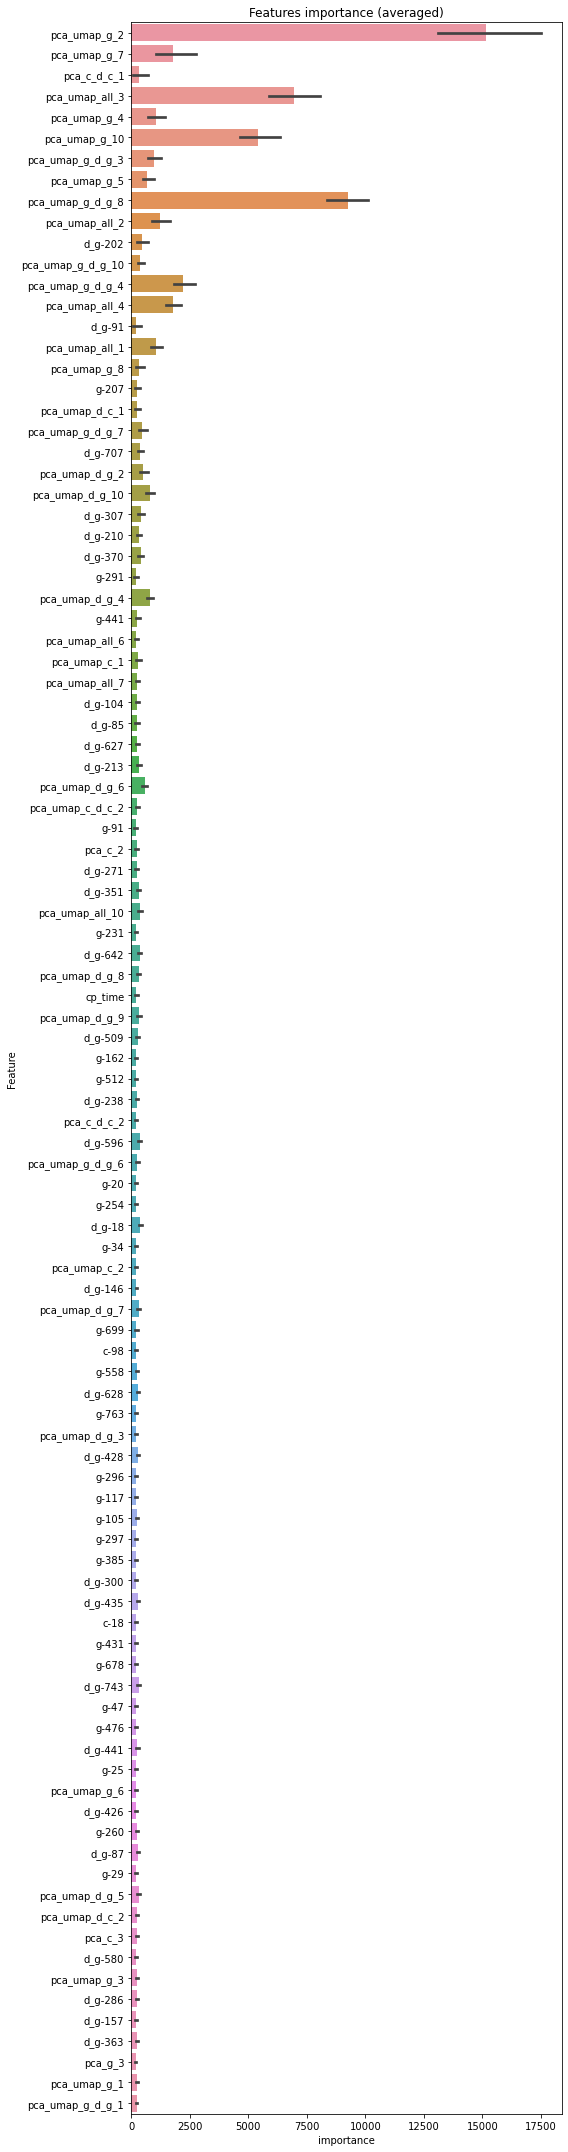

In [52]:
if DEBUG:
    show_feature_importance(feature_importance_df)